In [1]:
# Deep Convolutional GANs

# Importing the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [2]:
!mkdir anime-results

In [3]:

batchSize = 64 
imageSize = 64 

# Creating the transformations
transform = transforms.Compose([transforms.Scale(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

# Loading the dataset
dataset = dset.ImageFolder(root='./anime-data/anime-faces',transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

/mnt/4tb/amir-thesis/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [4]:
cuda = True if torch.cuda.is_available() else False

In [5]:
# Defining the generator

class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [6]:
# Defining the discriminator

class D(nn.Module):

    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

# Creating the discriminator
netD = D()
netD.apply(weights_init)


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [7]:
# Training the DCGANs

criterion = nn.BCELoss() 
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 

if cuda:
    netG.cuda()
    netD.cuda()
    criterion.cuda()

In [ ]:
for epoch in range(50):

    for i, data in enumerate(dataloader, 0): 
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad() # We initialize to 0 the gradients of the discriminator with respect to the weights.
        
        # Training the discriminator with a real image of the dataset
        real, _ = data # We get a real image of the dataset which will be used to train the discriminator.
        input = Variable(real) # We wrap it in a variable.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(input.cuda()) # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target.cuda()) # We compute the loss between the predictions (output) and the target (equal to 1).
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # We make a random input vector (noise) of the generator.
        fake = netG(noise.cuda()) # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        target = Variable(torch.zeros(input.size()[0])) # We get the target.
        output = netD(fake.detach()) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target.cuda()) # We compute the loss between the prediction (output) and the target (equal to 0).

        # Backpropagating the total error
        errD = errD_real + errD_fake # We compute the total error of the discriminator.
        errD.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() # We initialize to 0 the gradients of the generator with respect to the weights.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(fake) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errG = criterion(output, target.cuda()) # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data[0], errG.data[0])) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
        if i % 100 == 0: # Every 100 steps:
            vutils.save_image(real, '%s/real_samples.png' % "./anime-results", normalize = True) # We save the real images of the minibatch.
            fake = netG(noise.cuda()) # We get our fake generated images.
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./anime-results", epoch), normalize = True) # We also save the fake generated images of the minibatch.

[0/25][0/1799] Loss_D: 2.0936 Loss_G: 6.3614
[0/25][1/1799] Loss_D: 0.8575 Loss_G: 4.9241
[0/25][2/1799] Loss_D: 0.7397 Loss_G: 5.9139
[0/25][3/1799] Loss_D: 0.5045 Loss_G: 6.4472
[0/25][4/1799] Loss_D: 0.4426 Loss_G: 6.3931
[0/25][5/1799] Loss_D: 0.5835 Loss_G: 7.3641
[0/25][6/1799] Loss_D: 0.5376 Loss_G: 7.0993
[0/25][7/1799] Loss_D: 0.4912 Loss_G: 7.5911
[0/25][8/1799] Loss_D: 0.4602 Loss_G: 7.3714
[0/25][9/1799] Loss_D: 0.2877 Loss_G: 7.8727
[0/25][10/1799] Loss_D: 0.3694 Loss_G: 8.3858
[0/25][11/1799] Loss_D: 0.3518 Loss_G: 7.7786
[0/25][12/1799] Loss_D: 0.4388 Loss_G: 8.8016
[0/25][13/1799] Loss_D: 0.2700 Loss_G: 8.8998
[0/25][14/1799] Loss_D: 0.2646 Loss_G: 8.3408
[0/25][15/1799] Loss_D: 0.7392 Loss_G: 12.3159
[0/25][16/1799] Loss_D: 0.3097 Loss_G: 10.1475
[0/25][17/1799] Loss_D: 0.2168 Loss_G: 7.4641
[0/25][18/1799] Loss_D: 0.6419 Loss_G: 15.8771
[0/25][19/1799] Loss_D: 0.2120 Loss_G: 15.9022
[0/25][20/1799] Loss_D: 0.2561 Loss_G: 11.1446
[0/25][21/1799] Loss_D: 0.2887 Loss_G: 

[0/25][177/1799] Loss_D: 0.4154 Loss_G: 7.0888
[0/25][178/1799] Loss_D: 0.2748 Loss_G: 4.3315
[0/25][179/1799] Loss_D: 0.9559 Loss_G: 11.6740
[0/25][180/1799] Loss_D: 0.7105 Loss_G: 10.0752
[0/25][181/1799] Loss_D: 0.2581 Loss_G: 6.0928
[0/25][182/1799] Loss_D: 0.4891 Loss_G: 7.5300
[0/25][183/1799] Loss_D: 0.1617 Loss_G: 6.9868
[0/25][184/1799] Loss_D: 0.6406 Loss_G: 6.2277
[0/25][185/1799] Loss_D: 0.5407 Loss_G: 7.9177
[0/25][186/1799] Loss_D: 0.2759 Loss_G: 6.4827
[0/25][187/1799] Loss_D: 0.4986 Loss_G: 6.6823
[0/25][188/1799] Loss_D: 0.6815 Loss_G: 6.5515
[0/25][189/1799] Loss_D: 0.3824 Loss_G: 5.8461
[0/25][190/1799] Loss_D: 0.4121 Loss_G: 6.7612
[0/25][191/1799] Loss_D: 0.3063 Loss_G: 5.7140
[0/25][192/1799] Loss_D: 0.4212 Loss_G: 6.7761
[0/25][193/1799] Loss_D: 0.5476 Loss_G: 5.6808
[0/25][194/1799] Loss_D: 0.6529 Loss_G: 8.1502
[0/25][195/1799] Loss_D: 0.2225 Loss_G: 6.5022
[0/25][196/1799] Loss_D: 0.3996 Loss_G: 6.7366
[0/25][197/1799] Loss_D: 0.1603 Loss_G: 6.3948
[0/25][198/

[0/25][353/1799] Loss_D: 0.6571 Loss_G: 5.3370
[0/25][354/1799] Loss_D: 0.3725 Loss_G: 5.0096
[0/25][355/1799] Loss_D: 0.3759 Loss_G: 4.9229
[0/25][356/1799] Loss_D: 0.4664 Loss_G: 4.0392
[0/25][357/1799] Loss_D: 1.0583 Loss_G: 7.7187
[0/25][358/1799] Loss_D: 1.8304 Loss_G: 2.4453
[0/25][359/1799] Loss_D: 1.7764 Loss_G: 8.6605
[0/25][360/1799] Loss_D: 0.7047 Loss_G: 7.2141
[0/25][361/1799] Loss_D: 0.3017 Loss_G: 4.1814
[0/25][362/1799] Loss_D: 0.5337 Loss_G: 5.5099
[0/25][363/1799] Loss_D: 0.4374 Loss_G: 4.9549
[0/25][364/1799] Loss_D: 0.5206 Loss_G: 5.7908
[0/25][365/1799] Loss_D: 0.6240 Loss_G: 4.0484
[0/25][366/1799] Loss_D: 0.7015 Loss_G: 6.0034
[0/25][367/1799] Loss_D: 0.4411 Loss_G: 4.9124
[0/25][368/1799] Loss_D: 0.6788 Loss_G: 5.4115
[0/25][369/1799] Loss_D: 0.7393 Loss_G: 7.5955
[0/25][370/1799] Loss_D: 0.6788 Loss_G: 5.0465
[0/25][371/1799] Loss_D: 0.9722 Loss_G: 6.3973
[0/25][372/1799] Loss_D: 0.5797 Loss_G: 5.8873
[0/25][373/1799] Loss_D: 0.8240 Loss_G: 6.3540
[0/25][374/17

[0/25][529/1799] Loss_D: 0.4197 Loss_G: 4.7191
[0/25][530/1799] Loss_D: 0.5230 Loss_G: 3.6744
[0/25][531/1799] Loss_D: 0.5665 Loss_G: 5.5040
[0/25][532/1799] Loss_D: 0.3055 Loss_G: 5.7774
[0/25][533/1799] Loss_D: 0.3827 Loss_G: 4.0156
[0/25][534/1799] Loss_D: 0.3360 Loss_G: 5.5551
[0/25][535/1799] Loss_D: 0.5184 Loss_G: 4.3809
[0/25][536/1799] Loss_D: 0.4845 Loss_G: 4.0407
[0/25][537/1799] Loss_D: 0.4161 Loss_G: 5.1305
[0/25][538/1799] Loss_D: 0.5708 Loss_G: 5.4603
[0/25][539/1799] Loss_D: 0.4191 Loss_G: 4.4739
[0/25][540/1799] Loss_D: 0.4390 Loss_G: 7.1337
[0/25][541/1799] Loss_D: 0.4565 Loss_G: 5.0932
[0/25][542/1799] Loss_D: 0.3818 Loss_G: 5.1463
[0/25][543/1799] Loss_D: 0.4975 Loss_G: 6.6515
[0/25][544/1799] Loss_D: 0.4260 Loss_G: 4.0489
[0/25][545/1799] Loss_D: 0.5447 Loss_G: 5.7969
[0/25][546/1799] Loss_D: 0.5710 Loss_G: 5.0867
[0/25][547/1799] Loss_D: 0.3349 Loss_G: 6.2363
[0/25][548/1799] Loss_D: 0.2291 Loss_G: 5.8858
[0/25][549/1799] Loss_D: 0.4734 Loss_G: 3.7672
[0/25][550/17

[0/25][705/1799] Loss_D: 0.4356 Loss_G: 4.0572
[0/25][706/1799] Loss_D: 0.7806 Loss_G: 10.0089
[0/25][707/1799] Loss_D: 1.0529 Loss_G: 6.8760
[0/25][708/1799] Loss_D: 0.1756 Loss_G: 4.4404
[0/25][709/1799] Loss_D: 0.4559 Loss_G: 6.7147
[0/25][710/1799] Loss_D: 0.1599 Loss_G: 6.0837
[0/25][711/1799] Loss_D: 0.4663 Loss_G: 3.6280
[0/25][712/1799] Loss_D: 0.8046 Loss_G: 7.5008
[0/25][713/1799] Loss_D: 0.6158 Loss_G: 4.8091
[0/25][714/1799] Loss_D: 0.6418 Loss_G: 5.3281
[0/25][715/1799] Loss_D: 0.6548 Loss_G: 6.4275
[0/25][716/1799] Loss_D: 0.7776 Loss_G: 3.2253
[0/25][717/1799] Loss_D: 1.3536 Loss_G: 9.0978
[0/25][718/1799] Loss_D: 1.0490 Loss_G: 5.9968
[0/25][719/1799] Loss_D: 0.3319 Loss_G: 3.4372
[0/25][720/1799] Loss_D: 0.7012 Loss_G: 6.5739
[0/25][721/1799] Loss_D: 0.3293 Loss_G: 4.6846
[0/25][722/1799] Loss_D: 0.5699 Loss_G: 4.4273
[0/25][723/1799] Loss_D: 0.8521 Loss_G: 6.2697
[0/25][724/1799] Loss_D: 0.7782 Loss_G: 3.1137
[0/25][725/1799] Loss_D: 1.1783 Loss_G: 9.0918
[0/25][726/1

[0/25][881/1799] Loss_D: 0.8382 Loss_G: 3.3257
[0/25][882/1799] Loss_D: 0.5742 Loss_G: 6.8350
[0/25][883/1799] Loss_D: 0.1834 Loss_G: 6.4235
[0/25][884/1799] Loss_D: 0.2700 Loss_G: 4.6234
[0/25][885/1799] Loss_D: 0.7896 Loss_G: 5.4134
[0/25][886/1799] Loss_D: 0.4385 Loss_G: 4.1219
[0/25][887/1799] Loss_D: 0.7439 Loss_G: 6.7794
[0/25][888/1799] Loss_D: 0.2656 Loss_G: 5.6499
[0/25][889/1799] Loss_D: 0.4324 Loss_G: 3.1716
[0/25][890/1799] Loss_D: 0.6829 Loss_G: 5.2511
[0/25][891/1799] Loss_D: 0.3098 Loss_G: 4.7244
[0/25][892/1799] Loss_D: 0.3418 Loss_G: 4.0673
[0/25][893/1799] Loss_D: 0.4701 Loss_G: 5.8494
[0/25][894/1799] Loss_D: 0.7663 Loss_G: 2.9175
[0/25][895/1799] Loss_D: 1.2873 Loss_G: 8.1464
[0/25][896/1799] Loss_D: 1.4377 Loss_G: 2.8163
[0/25][897/1799] Loss_D: 0.6868 Loss_G: 5.0833
[0/25][898/1799] Loss_D: 0.3427 Loss_G: 5.7955
[0/25][899/1799] Loss_D: 0.3128 Loss_G: 4.5659
[0/25][900/1799] Loss_D: 0.5683 Loss_G: 3.4783
[0/25][901/1799] Loss_D: 0.6459 Loss_G: 6.4701
[0/25][902/17

[0/25][1055/1799] Loss_D: 0.2345 Loss_G: 6.6396
[0/25][1056/1799] Loss_D: 0.3245 Loss_G: 5.0517
[0/25][1057/1799] Loss_D: 0.3663 Loss_G: 6.1883
[0/25][1058/1799] Loss_D: 0.6498 Loss_G: 3.5193
[0/25][1059/1799] Loss_D: 0.7253 Loss_G: 8.0639
[0/25][1060/1799] Loss_D: 0.8783 Loss_G: 2.8669
[0/25][1061/1799] Loss_D: 0.8212 Loss_G: 8.4177
[0/25][1062/1799] Loss_D: 0.3494 Loss_G: 7.8013
[0/25][1063/1799] Loss_D: 0.5205 Loss_G: 3.5887
[0/25][1064/1799] Loss_D: 0.6216 Loss_G: 6.3513
[0/25][1065/1799] Loss_D: 0.3854 Loss_G: 5.2384
[0/25][1066/1799] Loss_D: 0.2560 Loss_G: 4.0644
[0/25][1067/1799] Loss_D: 0.4215 Loss_G: 6.4626
[0/25][1068/1799] Loss_D: 0.6598 Loss_G: 3.2664
[0/25][1069/1799] Loss_D: 0.4693 Loss_G: 5.3303
[0/25][1070/1799] Loss_D: 0.2534 Loss_G: 4.7513
[0/25][1071/1799] Loss_D: 0.3546 Loss_G: 5.3043
[0/25][1072/1799] Loss_D: 0.3420 Loss_G: 4.1564
[0/25][1073/1799] Loss_D: 0.4106 Loss_G: 5.6413
[0/25][1074/1799] Loss_D: 0.4491 Loss_G: 3.1395
[0/25][1075/1799] Loss_D: 0.5813 Loss_G:

[0/25][1227/1799] Loss_D: 0.3269 Loss_G: 4.9356
[0/25][1228/1799] Loss_D: 0.3245 Loss_G: 4.7496
[0/25][1229/1799] Loss_D: 0.2125 Loss_G: 4.7452
[0/25][1230/1799] Loss_D: 0.4295 Loss_G: 3.8957
[0/25][1231/1799] Loss_D: 0.3511 Loss_G: 6.3650
[0/25][1232/1799] Loss_D: 0.5039 Loss_G: 4.1227
[0/25][1233/1799] Loss_D: 0.2712 Loss_G: 5.2793
[0/25][1234/1799] Loss_D: 0.2863 Loss_G: 6.1054
[0/25][1235/1799] Loss_D: 0.4929 Loss_G: 4.2619
[0/25][1236/1799] Loss_D: 0.7033 Loss_G: 9.1190
[0/25][1237/1799] Loss_D: 0.8020 Loss_G: 2.9202
[0/25][1238/1799] Loss_D: 1.2224 Loss_G: 11.3544
[0/25][1239/1799] Loss_D: 1.2701 Loss_G: 2.8375
[0/25][1240/1799] Loss_D: 2.1147 Loss_G: 14.3391
[0/25][1241/1799] Loss_D: 2.0066 Loss_G: 8.9725
[0/25][1242/1799] Loss_D: 0.4593 Loss_G: 2.7440
[0/25][1243/1799] Loss_D: 1.9954 Loss_G: 11.1751
[0/25][1244/1799] Loss_D: 0.6455 Loss_G: 9.1502
[0/25][1245/1799] Loss_D: 0.3964 Loss_G: 3.6447
[0/25][1246/1799] Loss_D: 1.2314 Loss_G: 9.0821
[0/25][1247/1799] Loss_D: 0.7301 Loss

[0/25][1399/1799] Loss_D: 0.4745 Loss_G: 6.7093
[0/25][1400/1799] Loss_D: 0.2368 Loss_G: 5.3514
[0/25][1401/1799] Loss_D: 0.3243 Loss_G: 4.2951
[0/25][1402/1799] Loss_D: 0.4763 Loss_G: 5.3661
[0/25][1403/1799] Loss_D: 0.5158 Loss_G: 3.3089
[0/25][1404/1799] Loss_D: 0.4989 Loss_G: 5.8439
[0/25][1405/1799] Loss_D: 0.3057 Loss_G: 4.8563
[0/25][1406/1799] Loss_D: 0.3428 Loss_G: 5.0159
[0/25][1407/1799] Loss_D: 0.2593 Loss_G: 4.8465
[0/25][1408/1799] Loss_D: 0.4433 Loss_G: 3.7236
[0/25][1409/1799] Loss_D: 0.3860 Loss_G: 5.3912
[0/25][1410/1799] Loss_D: 0.2132 Loss_G: 5.0080
[0/25][1411/1799] Loss_D: 0.2040 Loss_G: 4.0666
[0/25][1412/1799] Loss_D: 0.4869 Loss_G: 5.9529
[0/25][1413/1799] Loss_D: 0.4059 Loss_G: 4.1980
[0/25][1414/1799] Loss_D: 0.2329 Loss_G: 3.8746
[0/25][1415/1799] Loss_D: 0.3500 Loss_G: 5.7841
[0/25][1416/1799] Loss_D: 0.2713 Loss_G: 4.9325
[0/25][1417/1799] Loss_D: 0.2939 Loss_G: 3.9977
[0/25][1418/1799] Loss_D: 0.5408 Loss_G: 8.8533
[0/25][1419/1799] Loss_D: 0.3268 Loss_G:

[0/25][1570/1799] Loss_D: 0.4725 Loss_G: 7.1608
[0/25][1571/1799] Loss_D: 0.5308 Loss_G: 4.6185
[0/25][1572/1799] Loss_D: 0.2757 Loss_G: 3.9031
[0/25][1573/1799] Loss_D: 0.4587 Loss_G: 7.6532
[0/25][1574/1799] Loss_D: 0.4603 Loss_G: 5.4060
[0/25][1575/1799] Loss_D: 0.2494 Loss_G: 4.3531
[0/25][1576/1799] Loss_D: 0.3935 Loss_G: 6.7523
[0/25][1577/1799] Loss_D: 0.3480 Loss_G: 4.0859
[0/25][1578/1799] Loss_D: 0.3433 Loss_G: 5.2072
[0/25][1579/1799] Loss_D: 0.2032 Loss_G: 5.7408
[0/25][1580/1799] Loss_D: 0.4551 Loss_G: 3.6601
[0/25][1581/1799] Loss_D: 0.7226 Loss_G: 7.4815
[0/25][1582/1799] Loss_D: 0.9302 Loss_G: 4.0870
[0/25][1583/1799] Loss_D: 0.4426 Loss_G: 5.8116
[0/25][1584/1799] Loss_D: 0.2853 Loss_G: 4.8835
[0/25][1585/1799] Loss_D: 0.3288 Loss_G: 5.2240
[0/25][1586/1799] Loss_D: 0.4282 Loss_G: 4.3811
[0/25][1587/1799] Loss_D: 0.3799 Loss_G: 6.6935
[0/25][1588/1799] Loss_D: 0.4429 Loss_G: 4.5923
[0/25][1589/1799] Loss_D: 0.3882 Loss_G: 4.4312
[0/25][1590/1799] Loss_D: 0.4618 Loss_G:

[0/25][1741/1799] Loss_D: 1.0156 Loss_G: 4.9853
[0/25][1742/1799] Loss_D: 0.5163 Loss_G: 6.0066
[0/25][1743/1799] Loss_D: 0.3770 Loss_G: 8.3671
[0/25][1744/1799] Loss_D: 0.2217 Loss_G: 6.8182
[0/25][1745/1799] Loss_D: 0.6319 Loss_G: 4.4344
[0/25][1746/1799] Loss_D: 0.5733 Loss_G: 8.9188
[0/25][1747/1799] Loss_D: 0.4149 Loss_G: 6.3331
[0/25][1748/1799] Loss_D: 0.3444 Loss_G: 3.7115
[0/25][1749/1799] Loss_D: 1.3414 Loss_G: 13.2338
[0/25][1750/1799] Loss_D: 2.0768 Loss_G: 5.6488
[0/25][1751/1799] Loss_D: 0.3607 Loss_G: 4.4926
[0/25][1752/1799] Loss_D: 0.5803 Loss_G: 11.3127
[0/25][1753/1799] Loss_D: 0.6286 Loss_G: 7.9309
[0/25][1754/1799] Loss_D: 0.1435 Loss_G: 3.5612
[0/25][1755/1799] Loss_D: 0.7196 Loss_G: 10.7642
[0/25][1756/1799] Loss_D: 0.6409 Loss_G: 7.6367
[0/25][1757/1799] Loss_D: 0.1759 Loss_G: 3.4674
[0/25][1758/1799] Loss_D: 0.8966 Loss_G: 9.9309
[0/25][1759/1799] Loss_D: 1.0368 Loss_G: 4.8422
[0/25][1760/1799] Loss_D: 0.3300 Loss_G: 4.8691
[0/25][1761/1799] Loss_D: 0.4689 Loss

[1/25][119/1799] Loss_D: 1.5412 Loss_G: 11.9800
[1/25][120/1799] Loss_D: 0.9804 Loss_G: 2.7477
[1/25][121/1799] Loss_D: 1.1745 Loss_G: 11.0854
[1/25][122/1799] Loss_D: 1.0259 Loss_G: 5.0656
[1/25][123/1799] Loss_D: 0.5687 Loss_G: 5.4552
[1/25][124/1799] Loss_D: 0.2897 Loss_G: 6.8088
[1/25][125/1799] Loss_D: 0.2898 Loss_G: 5.3524
[1/25][126/1799] Loss_D: 0.2447 Loss_G: 4.5210
[1/25][127/1799] Loss_D: 0.2793 Loss_G: 6.7710
[1/25][128/1799] Loss_D: 0.3251 Loss_G: 4.6210
[1/25][129/1799] Loss_D: 0.4196 Loss_G: 5.5416
[1/25][130/1799] Loss_D: 0.3005 Loss_G: 4.7568
[1/25][131/1799] Loss_D: 0.6358 Loss_G: 6.3501
[1/25][132/1799] Loss_D: 0.3798 Loss_G: 4.3718
[1/25][133/1799] Loss_D: 0.5356 Loss_G: 6.3942
[1/25][134/1799] Loss_D: 0.6024 Loss_G: 3.4696
[1/25][135/1799] Loss_D: 0.9705 Loss_G: 9.3987
[1/25][136/1799] Loss_D: 0.9723 Loss_G: 4.8170
[1/25][137/1799] Loss_D: 0.2705 Loss_G: 4.4311
[1/25][138/1799] Loss_D: 0.4625 Loss_G: 7.3552
[1/25][139/1799] Loss_D: 0.2950 Loss_G: 5.7553
[1/25][140/

[1/25][295/1799] Loss_D: 0.7631 Loss_G: 2.2194
[1/25][296/1799] Loss_D: 0.6181 Loss_G: 6.0587
[1/25][297/1799] Loss_D: 0.5852 Loss_G: 3.3166
[1/25][298/1799] Loss_D: 0.2792 Loss_G: 4.4624
[1/25][299/1799] Loss_D: 0.3812 Loss_G: 5.7252
[1/25][300/1799] Loss_D: 0.3906 Loss_G: 3.7048
[1/25][301/1799] Loss_D: 0.3762 Loss_G: 3.5790
[1/25][302/1799] Loss_D: 0.3602 Loss_G: 6.0867
[1/25][303/1799] Loss_D: 0.4185 Loss_G: 3.6776
[1/25][304/1799] Loss_D: 0.3746 Loss_G: 3.8726
[1/25][305/1799] Loss_D: 0.4738 Loss_G: 6.5198
[1/25][306/1799] Loss_D: 0.4929 Loss_G: 4.2225
[1/25][307/1799] Loss_D: 0.3718 Loss_G: 3.5424
[1/25][308/1799] Loss_D: 0.2920 Loss_G: 5.2637
[1/25][309/1799] Loss_D: 0.2125 Loss_G: 4.9380
[1/25][310/1799] Loss_D: 0.2848 Loss_G: 4.7422
[1/25][311/1799] Loss_D: 0.3654 Loss_G: 3.4569
[1/25][312/1799] Loss_D: 0.8853 Loss_G: 7.2208
[1/25][313/1799] Loss_D: 0.8403 Loss_G: 3.3260
[1/25][314/1799] Loss_D: 0.5494 Loss_G: 5.6522
[1/25][315/1799] Loss_D: 0.5375 Loss_G: 4.4085
[1/25][316/17

[1/25][471/1799] Loss_D: 0.1859 Loss_G: 3.8802
[1/25][472/1799] Loss_D: 0.5064 Loss_G: 7.2069
[1/25][473/1799] Loss_D: 0.6125 Loss_G: 3.7303
[1/25][474/1799] Loss_D: 0.2967 Loss_G: 4.9610
[1/25][475/1799] Loss_D: 0.3094 Loss_G: 5.3171
[1/25][476/1799] Loss_D: 0.3330 Loss_G: 3.9928
[1/25][477/1799] Loss_D: 0.3687 Loss_G: 6.1336
[1/25][478/1799] Loss_D: 0.6152 Loss_G: 3.0314
[1/25][479/1799] Loss_D: 0.3965 Loss_G: 5.9834
[1/25][480/1799] Loss_D: 0.2925 Loss_G: 4.9482
[1/25][481/1799] Loss_D: 0.3287 Loss_G: 3.5277
[1/25][482/1799] Loss_D: 0.5301 Loss_G: 6.6038
[1/25][483/1799] Loss_D: 0.3808 Loss_G: 4.4749
[1/25][484/1799] Loss_D: 0.3867 Loss_G: 4.4430
[1/25][485/1799] Loss_D: 0.3409 Loss_G: 5.0938
[1/25][486/1799] Loss_D: 0.3510 Loss_G: 5.1136
[1/25][487/1799] Loss_D: 0.3595 Loss_G: 3.6605
[1/25][488/1799] Loss_D: 0.3202 Loss_G: 5.9706
[1/25][489/1799] Loss_D: 0.4534 Loss_G: 3.3325
[1/25][490/1799] Loss_D: 0.4342 Loss_G: 7.3886
[1/25][491/1799] Loss_D: 0.4415 Loss_G: 4.9266
[1/25][492/17

[1/25][647/1799] Loss_D: 0.2744 Loss_G: 4.7623
[1/25][648/1799] Loss_D: 0.2401 Loss_G: 3.9244
[1/25][649/1799] Loss_D: 0.3078 Loss_G: 3.8881
[1/25][650/1799] Loss_D: 0.2264 Loss_G: 4.9808
[1/25][651/1799] Loss_D: 0.3992 Loss_G: 3.0861
[1/25][652/1799] Loss_D: 0.4602 Loss_G: 5.0252
[1/25][653/1799] Loss_D: 0.3755 Loss_G: 3.7581
[1/25][654/1799] Loss_D: 0.3164 Loss_G: 4.7723
[1/25][655/1799] Loss_D: 0.1951 Loss_G: 4.9949
[1/25][656/1799] Loss_D: 0.2672 Loss_G: 3.9054
[1/25][657/1799] Loss_D: 0.3445 Loss_G: 5.1359
[1/25][658/1799] Loss_D: 0.4871 Loss_G: 3.4871
[1/25][659/1799] Loss_D: 0.4911 Loss_G: 6.0788
[1/25][660/1799] Loss_D: 0.4236 Loss_G: 4.1008
[1/25][661/1799] Loss_D: 0.4319 Loss_G: 5.5920
[1/25][662/1799] Loss_D: 0.2106 Loss_G: 4.7600
[1/25][663/1799] Loss_D: 0.1734 Loss_G: 4.8164
[1/25][664/1799] Loss_D: 0.2597 Loss_G: 4.4061
[1/25][665/1799] Loss_D: 0.3332 Loss_G: 5.1893
[1/25][666/1799] Loss_D: 0.3717 Loss_G: 4.3085
[1/25][667/1799] Loss_D: 0.3472 Loss_G: 6.2746
[1/25][668/17

[1/25][823/1799] Loss_D: 0.6984 Loss_G: 3.6672
[1/25][824/1799] Loss_D: 0.3966 Loss_G: 6.1514
[1/25][825/1799] Loss_D: 0.3755 Loss_G: 4.2968
[1/25][826/1799] Loss_D: 0.1847 Loss_G: 4.7316
[1/25][827/1799] Loss_D: 0.2054 Loss_G: 5.3385
[1/25][828/1799] Loss_D: 0.3257 Loss_G: 4.1987
[1/25][829/1799] Loss_D: 0.3254 Loss_G: 3.2484
[1/25][830/1799] Loss_D: 0.5732 Loss_G: 7.5110
[1/25][831/1799] Loss_D: 0.6681 Loss_G: 4.1250
[1/25][832/1799] Loss_D: 0.2801 Loss_G: 4.6797
[1/25][833/1799] Loss_D: 0.2300 Loss_G: 5.8630
[1/25][834/1799] Loss_D: 0.3016 Loss_G: 4.0533
[1/25][835/1799] Loss_D: 0.3887 Loss_G: 6.0107
[1/25][836/1799] Loss_D: 0.5749 Loss_G: 2.2878
[1/25][837/1799] Loss_D: 0.9310 Loss_G: 10.3138
[1/25][838/1799] Loss_D: 1.0994 Loss_G: 5.8310
[1/25][839/1799] Loss_D: 0.1611 Loss_G: 3.5083
[1/25][840/1799] Loss_D: 0.6285 Loss_G: 8.2629
[1/25][841/1799] Loss_D: 0.3446 Loss_G: 6.2965
[1/25][842/1799] Loss_D: 0.3117 Loss_G: 3.0436
[1/25][843/1799] Loss_D: 1.0924 Loss_G: 9.5779
[1/25][844/1

[1/25][999/1799] Loss_D: 0.2209 Loss_G: 5.5241
[1/25][1000/1799] Loss_D: 0.1925 Loss_G: 4.3188
[1/25][1001/1799] Loss_D: 0.4125 Loss_G: 5.3085
[1/25][1002/1799] Loss_D: 0.5024 Loss_G: 3.0138
[1/25][1003/1799] Loss_D: 0.4292 Loss_G: 4.8713
[1/25][1004/1799] Loss_D: 0.3013 Loss_G: 4.8286
[1/25][1005/1799] Loss_D: 0.3331 Loss_G: 3.4799
[1/25][1006/1799] Loss_D: 0.4840 Loss_G: 5.3750
[1/25][1007/1799] Loss_D: 0.5821 Loss_G: 2.7081
[1/25][1008/1799] Loss_D: 0.7215 Loss_G: 6.0179
[1/25][1009/1799] Loss_D: 0.6602 Loss_G: 2.6018
[1/25][1010/1799] Loss_D: 0.5522 Loss_G: 5.6513
[1/25][1011/1799] Loss_D: 0.3683 Loss_G: 4.3626
[1/25][1012/1799] Loss_D: 0.4553 Loss_G: 3.8913
[1/25][1013/1799] Loss_D: 0.4295 Loss_G: 4.5875
[1/25][1014/1799] Loss_D: 0.3483 Loss_G: 5.0046
[1/25][1015/1799] Loss_D: 0.6614 Loss_G: 2.5138
[1/25][1016/1799] Loss_D: 0.8373 Loss_G: 7.3197
[1/25][1017/1799] Loss_D: 0.9186 Loss_G: 3.0927
[1/25][1018/1799] Loss_D: 0.6273 Loss_G: 4.5857
[1/25][1019/1799] Loss_D: 0.2676 Loss_G: 

[1/25][1171/1799] Loss_D: 0.3498 Loss_G: 4.8351
[1/25][1172/1799] Loss_D: 0.2645 Loss_G: 4.5202
[1/25][1173/1799] Loss_D: 0.4962 Loss_G: 3.4024
[1/25][1174/1799] Loss_D: 0.5561 Loss_G: 5.8908
[1/25][1175/1799] Loss_D: 0.7951 Loss_G: 1.5027
[1/25][1176/1799] Loss_D: 1.4940 Loss_G: 10.4465
[1/25][1177/1799] Loss_D: 1.3367 Loss_G: 4.5952
[1/25][1178/1799] Loss_D: 0.2068 Loss_G: 3.4083
[1/25][1179/1799] Loss_D: 0.6978 Loss_G: 9.4248
[1/25][1180/1799] Loss_D: 1.6514 Loss_G: 0.7817
[1/25][1181/1799] Loss_D: 2.0364 Loss_G: 8.9751
[1/25][1182/1799] Loss_D: 1.2391 Loss_G: 2.4457
[1/25][1183/1799] Loss_D: 0.7228 Loss_G: 6.9159
[1/25][1184/1799] Loss_D: 0.2162 Loss_G: 5.8846
[1/25][1185/1799] Loss_D: 0.3554 Loss_G: 2.5502
[1/25][1186/1799] Loss_D: 0.7911 Loss_G: 7.0258
[1/25][1187/1799] Loss_D: 0.7219 Loss_G: 3.9013
[1/25][1188/1799] Loss_D: 0.4442 Loss_G: 3.8188
[1/25][1189/1799] Loss_D: 0.3582 Loss_G: 4.8499
[1/25][1190/1799] Loss_D: 0.3034 Loss_G: 3.4205
[1/25][1191/1799] Loss_D: 0.4432 Loss_G

[1/25][1343/1799] Loss_D: 0.3047 Loss_G: 4.0517
[1/25][1344/1799] Loss_D: 0.3935 Loss_G: 6.6778
[1/25][1345/1799] Loss_D: 0.5871 Loss_G: 2.6596
[1/25][1346/1799] Loss_D: 0.4868 Loss_G: 5.9573
[1/25][1347/1799] Loss_D: 0.4348 Loss_G: 2.9341
[1/25][1348/1799] Loss_D: 0.3439 Loss_G: 6.0847
[1/25][1349/1799] Loss_D: 0.2119 Loss_G: 4.8978
[1/25][1350/1799] Loss_D: 0.3259 Loss_G: 3.3475
[1/25][1351/1799] Loss_D: 0.5090 Loss_G: 7.3968
[1/25][1352/1799] Loss_D: 0.6137 Loss_G: 2.8507
[1/25][1353/1799] Loss_D: 0.5969 Loss_G: 7.3491
[1/25][1354/1799] Loss_D: 0.7450 Loss_G: 2.4129
[1/25][1355/1799] Loss_D: 0.7798 Loss_G: 8.3650
[1/25][1356/1799] Loss_D: 0.7426 Loss_G: 3.3306
[1/25][1357/1799] Loss_D: 0.5496 Loss_G: 6.7620
[1/25][1358/1799] Loss_D: 0.2231 Loss_G: 5.2651
[1/25][1359/1799] Loss_D: 0.3267 Loss_G: 2.7257
[1/25][1360/1799] Loss_D: 1.0037 Loss_G: 8.2106
[1/25][1361/1799] Loss_D: 1.9533 Loss_G: 1.0305
[1/25][1362/1799] Loss_D: 2.1394 Loss_G: 9.4913
[1/25][1363/1799] Loss_D: 0.9807 Loss_G:

[1/25][1515/1799] Loss_D: 0.3430 Loss_G: 5.4951
[1/25][1516/1799] Loss_D: 0.3136 Loss_G: 4.0229
[1/25][1517/1799] Loss_D: 0.2381 Loss_G: 3.6132
[1/25][1518/1799] Loss_D: 0.3189 Loss_G: 4.4454
[1/25][1519/1799] Loss_D: 0.3556 Loss_G: 5.0106
[1/25][1520/1799] Loss_D: 0.3425 Loss_G: 3.9505
[1/25][1521/1799] Loss_D: 0.3707 Loss_G: 4.9748
[1/25][1522/1799] Loss_D: 0.4850 Loss_G: 2.9418
[1/25][1523/1799] Loss_D: 0.7393 Loss_G: 6.1802
[1/25][1524/1799] Loss_D: 0.5367 Loss_G: 2.2462
[1/25][1525/1799] Loss_D: 0.5894 Loss_G: 7.8819
[1/25][1526/1799] Loss_D: 0.5307 Loss_G: 4.3609
[1/25][1527/1799] Loss_D: 0.2036 Loss_G: 3.7341
[1/25][1528/1799] Loss_D: 0.4617 Loss_G: 6.0969
[1/25][1529/1799] Loss_D: 0.3849 Loss_G: 3.9042
[1/25][1530/1799] Loss_D: 0.2757 Loss_G: 3.6787
[1/25][1531/1799] Loss_D: 0.4171 Loss_G: 6.5162
[1/25][1532/1799] Loss_D: 0.5678 Loss_G: 2.9633
[1/25][1533/1799] Loss_D: 0.5495 Loss_G: 6.0788
[1/25][1534/1799] Loss_D: 0.3069 Loss_G: 5.1286
[1/25][1535/1799] Loss_D: 0.3194 Loss_G:

[1/25][1687/1799] Loss_D: 0.3959 Loss_G: 5.8567
[1/25][1688/1799] Loss_D: 0.1154 Loss_G: 5.7474
[1/25][1689/1799] Loss_D: 0.2275 Loss_G: 3.6534
[1/25][1690/1799] Loss_D: 0.2316 Loss_G: 4.4955
[1/25][1691/1799] Loss_D: 0.2022 Loss_G: 4.7915
[1/25][1692/1799] Loss_D: 0.2288 Loss_G: 3.9021
[1/25][1693/1799] Loss_D: 0.2047 Loss_G: 3.7280
[1/25][1694/1799] Loss_D: 0.3593 Loss_G: 5.5563
[1/25][1695/1799] Loss_D: 0.3319 Loss_G: 3.3448
[1/25][1696/1799] Loss_D: 0.4713 Loss_G: 4.2106
[1/25][1697/1799] Loss_D: 0.3197 Loss_G: 6.2284
[1/25][1698/1799] Loss_D: 0.4960 Loss_G: 2.8145
[1/25][1699/1799] Loss_D: 0.7495 Loss_G: 7.3791
[1/25][1700/1799] Loss_D: 0.3272 Loss_G: 5.3439
[1/25][1701/1799] Loss_D: 0.2166 Loss_G: 3.4636
[1/25][1702/1799] Loss_D: 0.3186 Loss_G: 6.2517
[1/25][1703/1799] Loss_D: 0.2551 Loss_G: 4.2061
[1/25][1704/1799] Loss_D: 0.3607 Loss_G: 5.4128
[1/25][1705/1799] Loss_D: 0.2667 Loss_G: 4.5627
[1/25][1706/1799] Loss_D: 0.3764 Loss_G: 2.8694
[1/25][1707/1799] Loss_D: 0.5550 Loss_G:

[2/25][63/1799] Loss_D: 0.3036 Loss_G: 4.0252
[2/25][64/1799] Loss_D: 0.2457 Loss_G: 4.7068
[2/25][65/1799] Loss_D: 0.3064 Loss_G: 3.1768
[2/25][66/1799] Loss_D: 0.3671 Loss_G: 4.8135
[2/25][67/1799] Loss_D: 0.3359 Loss_G: 3.7442
[2/25][68/1799] Loss_D: 0.3579 Loss_G: 4.9496
[2/25][69/1799] Loss_D: 0.5750 Loss_G: 1.9241
[2/25][70/1799] Loss_D: 0.6964 Loss_G: 7.8806
[2/25][71/1799] Loss_D: 0.8102 Loss_G: 2.9068
[2/25][72/1799] Loss_D: 0.6099 Loss_G: 6.0732
[2/25][73/1799] Loss_D: 0.3576 Loss_G: 3.5932
[2/25][74/1799] Loss_D: 0.5045 Loss_G: 6.3470
[2/25][75/1799] Loss_D: 0.4660 Loss_G: 3.0912
[2/25][76/1799] Loss_D: 0.3437 Loss_G: 5.4216
[2/25][77/1799] Loss_D: 0.1483 Loss_G: 5.1050
[2/25][78/1799] Loss_D: 0.3331 Loss_G: 3.0980
[2/25][79/1799] Loss_D: 0.5821 Loss_G: 6.3088
[2/25][80/1799] Loss_D: 0.8225 Loss_G: 1.5015
[2/25][81/1799] Loss_D: 1.2634 Loss_G: 10.1908
[2/25][82/1799] Loss_D: 1.1294 Loss_G: 3.9276
[2/25][83/1799] Loss_D: 0.2823 Loss_G: 5.0223
[2/25][84/1799] Loss_D: 0.1404 Lo

[2/25][239/1799] Loss_D: 0.3782 Loss_G: 3.3613
[2/25][240/1799] Loss_D: 0.6080 Loss_G: 8.2980
[2/25][241/1799] Loss_D: 0.8377 Loss_G: 2.8039
[2/25][242/1799] Loss_D: 0.5609 Loss_G: 6.7524
[2/25][243/1799] Loss_D: 0.7068 Loss_G: 2.1299
[2/25][244/1799] Loss_D: 0.9938 Loss_G: 10.1868
[2/25][245/1799] Loss_D: 0.4175 Loss_G: 7.2406
[2/25][246/1799] Loss_D: 0.2891 Loss_G: 1.2544
[2/25][247/1799] Loss_D: 1.7355 Loss_G: 11.0013
[2/25][248/1799] Loss_D: 2.0673 Loss_G: 0.4485
[2/25][249/1799] Loss_D: 2.9059 Loss_G: 11.6814
[2/25][250/1799] Loss_D: 2.5411 Loss_G: 4.3845
[2/25][251/1799] Loss_D: 0.3022 Loss_G: 3.0695
[2/25][252/1799] Loss_D: 0.6703 Loss_G: 8.6439
[2/25][253/1799] Loss_D: 1.0889 Loss_G: 3.1277
[2/25][254/1799] Loss_D: 0.7139 Loss_G: 5.9503
[2/25][255/1799] Loss_D: 0.3066 Loss_G: 5.0988
[2/25][256/1799] Loss_D: 0.5436 Loss_G: 2.6381
[2/25][257/1799] Loss_D: 1.2637 Loss_G: 9.1082
[2/25][258/1799] Loss_D: 1.7370 Loss_G: 3.8015
[2/25][259/1799] Loss_D: 0.7198 Loss_G: 5.3814
[2/25][260

[2/25][415/1799] Loss_D: 0.2728 Loss_G: 4.6499
[2/25][416/1799] Loss_D: 0.3042 Loss_G: 5.0222
[2/25][417/1799] Loss_D: 0.3835 Loss_G: 3.2123
[2/25][418/1799] Loss_D: 0.3231 Loss_G: 4.7150
[2/25][419/1799] Loss_D: 0.2658 Loss_G: 4.2118
[2/25][420/1799] Loss_D: 0.2235 Loss_G: 3.5318
[2/25][421/1799] Loss_D: 0.3249 Loss_G: 5.3366
[2/25][422/1799] Loss_D: 0.2044 Loss_G: 4.7330
[2/25][423/1799] Loss_D: 0.4269 Loss_G: 2.2995
[2/25][424/1799] Loss_D: 0.7459 Loss_G: 8.3025
[2/25][425/1799] Loss_D: 0.7967 Loss_G: 4.2897
[2/25][426/1799] Loss_D: 0.2856 Loss_G: 4.1730
[2/25][427/1799] Loss_D: 0.3538 Loss_G: 6.6598
[2/25][428/1799] Loss_D: 0.2959 Loss_G: 4.3185
[2/25][429/1799] Loss_D: 0.3959 Loss_G: 3.4923
[2/25][430/1799] Loss_D: 0.3039 Loss_G: 5.3888
[2/25][431/1799] Loss_D: 0.4297 Loss_G: 2.8200
[2/25][432/1799] Loss_D: 0.6469 Loss_G: 7.7775
[2/25][433/1799] Loss_D: 1.4530 Loss_G: 1.8750
[2/25][434/1799] Loss_D: 0.8410 Loss_G: 7.2325
[2/25][435/1799] Loss_D: 0.2960 Loss_G: 5.4435
[2/25][436/17

[2/25][591/1799] Loss_D: 0.7535 Loss_G: 3.0202
[2/25][592/1799] Loss_D: 0.3539 Loss_G: 3.2152
[2/25][593/1799] Loss_D: 0.3329 Loss_G: 4.5714
[2/25][594/1799] Loss_D: 0.2520 Loss_G: 4.2412
[2/25][595/1799] Loss_D: 0.2600 Loss_G: 3.6912
[2/25][596/1799] Loss_D: 0.2343 Loss_G: 4.3461
[2/25][597/1799] Loss_D: 0.2265 Loss_G: 4.4351
[2/25][598/1799] Loss_D: 0.4071 Loss_G: 2.3726
[2/25][599/1799] Loss_D: 0.4671 Loss_G: 6.2778
[2/25][600/1799] Loss_D: 0.6347 Loss_G: 2.8680
[2/25][601/1799] Loss_D: 0.3743 Loss_G: 3.7757
[2/25][602/1799] Loss_D: 0.2924 Loss_G: 4.3381
[2/25][603/1799] Loss_D: 0.1188 Loss_G: 4.9263
[2/25][604/1799] Loss_D: 0.1960 Loss_G: 3.4941
[2/25][605/1799] Loss_D: 0.2146 Loss_G: 4.1180
[2/25][606/1799] Loss_D: 0.2520 Loss_G: 4.4968
[2/25][607/1799] Loss_D: 0.2342 Loss_G: 3.5086
[2/25][608/1799] Loss_D: 0.4054 Loss_G: 3.9457
[2/25][609/1799] Loss_D: 0.4072 Loss_G: 4.1499
[2/25][610/1799] Loss_D: 0.3160 Loss_G: 3.3831
[2/25][611/1799] Loss_D: 0.3606 Loss_G: 4.0612
[2/25][612/17

[2/25][767/1799] Loss_D: 0.6096 Loss_G: 6.1233
[2/25][768/1799] Loss_D: 0.4555 Loss_G: 2.1382
[2/25][769/1799] Loss_D: 0.7553 Loss_G: 8.4767
[2/25][770/1799] Loss_D: 1.0410 Loss_G: 2.8495
[2/25][771/1799] Loss_D: 0.4992 Loss_G: 5.2769
[2/25][772/1799] Loss_D: 0.1466 Loss_G: 5.0232
[2/25][773/1799] Loss_D: 0.3382 Loss_G: 2.8314
[2/25][774/1799] Loss_D: 0.7662 Loss_G: 6.0301
[2/25][775/1799] Loss_D: 0.4393 Loss_G: 2.8600
[2/25][776/1799] Loss_D: 0.4880 Loss_G: 6.1553
[2/25][777/1799] Loss_D: 0.8054 Loss_G: 1.4081
[2/25][778/1799] Loss_D: 1.1863 Loss_G: 9.3317
[2/25][779/1799] Loss_D: 0.9846 Loss_G: 4.9481
[2/25][780/1799] Loss_D: 0.1589 Loss_G: 2.7580
[2/25][781/1799] Loss_D: 0.4081 Loss_G: 5.8055
[2/25][782/1799] Loss_D: 0.1406 Loss_G: 5.3719
[2/25][783/1799] Loss_D: 0.5269 Loss_G: 2.4287
[2/25][784/1799] Loss_D: 0.6998 Loss_G: 6.0744
[2/25][785/1799] Loss_D: 0.4023 Loss_G: 3.9737
[2/25][786/1799] Loss_D: 0.1749 Loss_G: 3.5134
[2/25][787/1799] Loss_D: 0.4595 Loss_G: 4.4847
[2/25][788/17

[2/25][943/1799] Loss_D: 0.3416 Loss_G: 4.6924
[2/25][944/1799] Loss_D: 0.2910 Loss_G: 3.7495
[2/25][945/1799] Loss_D: 0.3598 Loss_G: 4.2042
[2/25][946/1799] Loss_D: 0.4123 Loss_G: 3.1941
[2/25][947/1799] Loss_D: 0.5037 Loss_G: 5.0485
[2/25][948/1799] Loss_D: 0.4109 Loss_G: 2.3168
[2/25][949/1799] Loss_D: 0.7515 Loss_G: 7.9091
[2/25][950/1799] Loss_D: 1.3110 Loss_G: 2.0667
[2/25][951/1799] Loss_D: 0.6674 Loss_G: 6.2574
[2/25][952/1799] Loss_D: 0.4626 Loss_G: 3.5772
[2/25][953/1799] Loss_D: 0.3066 Loss_G: 4.8359
[2/25][954/1799] Loss_D: 0.2092 Loss_G: 5.8486
[2/25][955/1799] Loss_D: 0.4165 Loss_G: 3.0252
[2/25][956/1799] Loss_D: 0.2548 Loss_G: 4.2326
[2/25][957/1799] Loss_D: 0.4415 Loss_G: 4.8154
[2/25][958/1799] Loss_D: 0.3971 Loss_G: 2.9838
[2/25][959/1799] Loss_D: 0.4674 Loss_G: 5.8487
[2/25][960/1799] Loss_D: 0.6169 Loss_G: 2.4702
[2/25][961/1799] Loss_D: 0.8038 Loss_G: 7.4077
[2/25][962/1799] Loss_D: 0.7007 Loss_G: 4.7056
[2/25][963/1799] Loss_D: 0.2239 Loss_G: 2.6388
[2/25][964/17

[2/25][1115/1799] Loss_D: 0.3694 Loss_G: 2.7868
[2/25][1116/1799] Loss_D: 0.4499 Loss_G: 5.6227
[2/25][1117/1799] Loss_D: 0.2973 Loss_G: 4.1682
[2/25][1118/1799] Loss_D: 0.3448 Loss_G: 2.4783
[2/25][1119/1799] Loss_D: 0.5891 Loss_G: 7.1198
[2/25][1120/1799] Loss_D: 0.8624 Loss_G: 2.8962
[2/25][1121/1799] Loss_D: 0.3658 Loss_G: 4.5308
[2/25][1122/1799] Loss_D: 0.2593 Loss_G: 4.1592
[2/25][1123/1799] Loss_D: 0.2518 Loss_G: 3.4741
[2/25][1124/1799] Loss_D: 0.3243 Loss_G: 5.6869
[2/25][1125/1799] Loss_D: 0.2623 Loss_G: 4.4280
[2/25][1126/1799] Loss_D: 0.2520 Loss_G: 2.8137
[2/25][1127/1799] Loss_D: 0.3627 Loss_G: 5.1053
[2/25][1128/1799] Loss_D: 0.1609 Loss_G: 4.4059
[2/25][1129/1799] Loss_D: 0.1824 Loss_G: 3.0958
[2/25][1130/1799] Loss_D: 0.3027 Loss_G: 4.1301
[2/25][1131/1799] Loss_D: 0.3357 Loss_G: 2.9802
[2/25][1132/1799] Loss_D: 0.4199 Loss_G: 4.2174
[2/25][1133/1799] Loss_D: 0.3526 Loss_G: 2.6867
[2/25][1134/1799] Loss_D: 0.4675 Loss_G: 3.7584
[2/25][1135/1799] Loss_D: 0.1464 Loss_G:

[2/25][1286/1799] Loss_D: 0.5206 Loss_G: 6.3840
[2/25][1287/1799] Loss_D: 0.3394 Loss_G: 4.4944
[2/25][1288/1799] Loss_D: 0.1822 Loss_G: 3.3207
[2/25][1289/1799] Loss_D: 0.2063 Loss_G: 4.5741
[2/25][1290/1799] Loss_D: 0.1612 Loss_G: 4.5639
[2/25][1291/1799] Loss_D: 0.2608 Loss_G: 3.3706
[2/25][1292/1799] Loss_D: 0.2978 Loss_G: 5.2541
[2/25][1293/1799] Loss_D: 0.2512 Loss_G: 4.0662
[2/25][1294/1799] Loss_D: 0.2947 Loss_G: 3.6042
[2/25][1295/1799] Loss_D: 0.3009 Loss_G: 3.1416
[2/25][1296/1799] Loss_D: 0.4970 Loss_G: 5.7855
[2/25][1297/1799] Loss_D: 0.2350 Loss_G: 4.8099
[2/25][1298/1799] Loss_D: 0.1951 Loss_G: 2.9620
[2/25][1299/1799] Loss_D: 0.4777 Loss_G: 6.3471
[2/25][1300/1799] Loss_D: 0.4764 Loss_G: 3.5870
[2/25][1301/1799] Loss_D: 0.2157 Loss_G: 3.9697
[2/25][1302/1799] Loss_D: 0.2284 Loss_G: 4.7019
[2/25][1303/1799] Loss_D: 0.2142 Loss_G: 3.8586
[2/25][1304/1799] Loss_D: 0.2789 Loss_G: 4.2391
[2/25][1305/1799] Loss_D: 0.2234 Loss_G: 4.2539
[2/25][1306/1799] Loss_D: 0.2038 Loss_G:

[2/25][1458/1799] Loss_D: 0.1790 Loss_G: 4.6050
[2/25][1459/1799] Loss_D: 0.4931 Loss_G: 2.1629
[2/25][1460/1799] Loss_D: 0.6376 Loss_G: 5.9751
[2/25][1461/1799] Loss_D: 0.3860 Loss_G: 4.1608
[2/25][1462/1799] Loss_D: 0.2189 Loss_G: 2.7755
[2/25][1463/1799] Loss_D: 0.4032 Loss_G: 5.1785
[2/25][1464/1799] Loss_D: 0.3522 Loss_G: 3.8565
[2/25][1465/1799] Loss_D: 0.1817 Loss_G: 4.1118
[2/25][1466/1799] Loss_D: 0.1886 Loss_G: 4.5104
[2/25][1467/1799] Loss_D: 0.2972 Loss_G: 2.8277
[2/25][1468/1799] Loss_D: 0.4959 Loss_G: 6.0368
[2/25][1469/1799] Loss_D: 0.6216 Loss_G: 2.4338
[2/25][1470/1799] Loss_D: 0.4733 Loss_G: 4.0153
[2/25][1471/1799] Loss_D: 0.4225 Loss_G: 2.4777
[2/25][1472/1799] Loss_D: 0.3642 Loss_G: 4.8337
[2/25][1473/1799] Loss_D: 0.3852 Loss_G: 3.2412
[2/25][1474/1799] Loss_D: 0.2690 Loss_G: 4.2539
[2/25][1475/1799] Loss_D: 0.2792 Loss_G: 3.6594
[2/25][1476/1799] Loss_D: 0.1452 Loss_G: 3.6566
[2/25][1477/1799] Loss_D: 0.3215 Loss_G: 3.2415
[2/25][1478/1799] Loss_D: 0.3055 Loss_G:

[2/25][1629/1799] Loss_D: 0.2384 Loss_G: 3.8829
[2/25][1630/1799] Loss_D: 0.2918 Loss_G: 4.2932
[2/25][1631/1799] Loss_D: 0.8165 Loss_G: 1.1610
[2/25][1632/1799] Loss_D: 1.3279 Loss_G: 8.8922
[2/25][1633/1799] Loss_D: 0.9589 Loss_G: 4.6178
[2/25][1634/1799] Loss_D: 0.2478 Loss_G: 1.6348
[2/25][1635/1799] Loss_D: 1.0315 Loss_G: 8.8200
[2/25][1636/1799] Loss_D: 0.9228 Loss_G: 3.5584
[2/25][1637/1799] Loss_D: 0.3189 Loss_G: 2.7162
[2/25][1638/1799] Loss_D: 0.6937 Loss_G: 6.8190
[2/25][1639/1799] Loss_D: 1.1422 Loss_G: 1.9733
[2/25][1640/1799] Loss_D: 0.6585 Loss_G: 5.1744
[2/25][1641/1799] Loss_D: 0.4253 Loss_G: 4.1196
[2/25][1642/1799] Loss_D: 0.4152 Loss_G: 4.4100
[2/25][1643/1799] Loss_D: 0.4808 Loss_G: 4.8904
[2/25][1644/1799] Loss_D: 0.2892 Loss_G: 4.0198
[2/25][1645/1799] Loss_D: 0.5360 Loss_G: 2.9777
[2/25][1646/1799] Loss_D: 0.4175 Loss_G: 4.5073
[2/25][1647/1799] Loss_D: 0.1568 Loss_G: 4.6389
[2/25][1648/1799] Loss_D: 0.2505 Loss_G: 4.4844
[2/25][1649/1799] Loss_D: 0.4280 Loss_G:

[3/25][1/1799] Loss_D: 0.1912 Loss_G: 4.9549
[3/25][2/1799] Loss_D: 0.2222 Loss_G: 3.1600
[3/25][3/1799] Loss_D: 0.2372 Loss_G: 4.4302
[3/25][4/1799] Loss_D: 0.1970 Loss_G: 4.6711
[3/25][5/1799] Loss_D: 0.2786 Loss_G: 3.5308
[3/25][6/1799] Loss_D: 0.3089 Loss_G: 3.9181
[3/25][7/1799] Loss_D: 0.3165 Loss_G: 2.9988
[3/25][8/1799] Loss_D: 0.4047 Loss_G: 4.0078
[3/25][9/1799] Loss_D: 0.2599 Loss_G: 4.4603
[3/25][10/1799] Loss_D: 0.1878 Loss_G: 3.8569
[3/25][11/1799] Loss_D: 0.2201 Loss_G: 4.1114
[3/25][12/1799] Loss_D: 0.3122 Loss_G: 4.2619
[3/25][13/1799] Loss_D: 0.5491 Loss_G: 0.7769
[3/25][14/1799] Loss_D: 1.1823 Loss_G: 10.0113
[3/25][15/1799] Loss_D: 1.5537 Loss_G: 2.5344
[3/25][16/1799] Loss_D: 0.3942 Loss_G: 3.8936
[3/25][17/1799] Loss_D: 0.3657 Loss_G: 4.3808
[3/25][18/1799] Loss_D: 0.2067 Loss_G: 4.7884
[3/25][19/1799] Loss_D: 0.2343 Loss_G: 3.7000
[3/25][20/1799] Loss_D: 0.3929 Loss_G: 5.7660
[3/25][21/1799] Loss_D: 0.6005 Loss_G: 2.1443
[3/25][22/1799] Loss_D: 0.8110 Loss_G: 7.9

[3/25][179/1799] Loss_D: 0.7473 Loss_G: 6.8791
[3/25][180/1799] Loss_D: 1.0334 Loss_G: 2.1220
[3/25][181/1799] Loss_D: 1.0041 Loss_G: 7.9385
[3/25][182/1799] Loss_D: 0.4515 Loss_G: 5.2515
[3/25][183/1799] Loss_D: 0.3757 Loss_G: 3.6937
[3/25][184/1799] Loss_D: 0.2298 Loss_G: 4.8898
[3/25][185/1799] Loss_D: 0.4478 Loss_G: 3.4767
[3/25][186/1799] Loss_D: 0.3193 Loss_G: 4.2888
[3/25][187/1799] Loss_D: 0.3591 Loss_G: 4.1465
[3/25][188/1799] Loss_D: 0.6767 Loss_G: 2.1520
[3/25][189/1799] Loss_D: 0.6407 Loss_G: 7.4879
[3/25][190/1799] Loss_D: 1.0136 Loss_G: 1.7299
[3/25][191/1799] Loss_D: 0.6288 Loss_G: 6.0016
[3/25][192/1799] Loss_D: 0.1997 Loss_G: 5.1485
[3/25][193/1799] Loss_D: 0.1788 Loss_G: 3.4760
[3/25][194/1799] Loss_D: 0.3187 Loss_G: 4.0632
[3/25][195/1799] Loss_D: 0.1857 Loss_G: 4.6510
[3/25][196/1799] Loss_D: 0.1198 Loss_G: 4.5560
[3/25][197/1799] Loss_D: 0.4077 Loss_G: 2.0894
[3/25][198/1799] Loss_D: 0.7013 Loss_G: 6.4854
[3/25][199/1799] Loss_D: 0.6484 Loss_G: 2.7986
[3/25][200/17

[3/25][355/1799] Loss_D: 0.2570 Loss_G: 5.3145
[3/25][356/1799] Loss_D: 0.2648 Loss_G: 3.7662
[3/25][357/1799] Loss_D: 0.2643 Loss_G: 3.9036
[3/25][358/1799] Loss_D: 0.2111 Loss_G: 3.9858
[3/25][359/1799] Loss_D: 0.3075 Loss_G: 3.1995
[3/25][360/1799] Loss_D: 0.4566 Loss_G: 5.3076
[3/25][361/1799] Loss_D: 0.3239 Loss_G: 3.5937
[3/25][362/1799] Loss_D: 0.2526 Loss_G: 3.9928
[3/25][363/1799] Loss_D: 0.2243 Loss_G: 4.5512
[3/25][364/1799] Loss_D: 0.1788 Loss_G: 3.8820
[3/25][365/1799] Loss_D: 0.2528 Loss_G: 4.5227
[3/25][366/1799] Loss_D: 0.1310 Loss_G: 4.9623
[3/25][367/1799] Loss_D: 0.2611 Loss_G: 2.9620
[3/25][368/1799] Loss_D: 0.2857 Loss_G: 5.2796
[3/25][369/1799] Loss_D: 0.2456 Loss_G: 3.7606
[3/25][370/1799] Loss_D: 0.2397 Loss_G: 5.6613
[3/25][371/1799] Loss_D: 0.3768 Loss_G: 3.2656
[3/25][372/1799] Loss_D: 0.3561 Loss_G: 4.9838
[3/25][373/1799] Loss_D: 0.2265 Loss_G: 4.4641
[3/25][374/1799] Loss_D: 0.3412 Loss_G: 2.4249
[3/25][375/1799] Loss_D: 0.6627 Loss_G: 8.4437
[3/25][376/17

[3/25][531/1799] Loss_D: 0.5903 Loss_G: 5.5653
[3/25][532/1799] Loss_D: 0.2541 Loss_G: 4.4495
[3/25][533/1799] Loss_D: 0.2064 Loss_G: 3.7483
[3/25][534/1799] Loss_D: 0.3787 Loss_G: 3.1787
[3/25][535/1799] Loss_D: 0.5140 Loss_G: 5.3015
[3/25][536/1799] Loss_D: 0.8954 Loss_G: 0.7703
[3/25][537/1799] Loss_D: 1.8755 Loss_G: 9.3110
[3/25][538/1799] Loss_D: 2.4022 Loss_G: 1.4642
[3/25][539/1799] Loss_D: 0.6832 Loss_G: 3.9748
[3/25][540/1799] Loss_D: 0.2833 Loss_G: 4.5317
[3/25][541/1799] Loss_D: 0.3295 Loss_G: 3.6631
[3/25][542/1799] Loss_D: 0.4148 Loss_G: 5.0201
[3/25][543/1799] Loss_D: 0.1976 Loss_G: 4.6565
[3/25][544/1799] Loss_D: 0.5747 Loss_G: 2.3991
[3/25][545/1799] Loss_D: 0.5562 Loss_G: 5.9808
[3/25][546/1799] Loss_D: 0.3595 Loss_G: 4.0962
[3/25][547/1799] Loss_D: 0.3795 Loss_G: 3.0314
[3/25][548/1799] Loss_D: 0.4872 Loss_G: 6.4318
[3/25][549/1799] Loss_D: 0.6357 Loss_G: 2.4857
[3/25][550/1799] Loss_D: 0.4671 Loss_G: 5.7770
[3/25][551/1799] Loss_D: 0.1893 Loss_G: 5.4177
[3/25][552/17

[3/25][707/1799] Loss_D: 0.4810 Loss_G: 6.6905
[3/25][708/1799] Loss_D: 0.2430 Loss_G: 5.2639
[3/25][709/1799] Loss_D: 0.1282 Loss_G: 3.8180
[3/25][710/1799] Loss_D: 0.2373 Loss_G: 4.2665
[3/25][711/1799] Loss_D: 0.2717 Loss_G: 4.1969
[3/25][712/1799] Loss_D: 0.2812 Loss_G: 3.8499
[3/25][713/1799] Loss_D: 0.3520 Loss_G: 3.7196
[3/25][714/1799] Loss_D: 0.3176 Loss_G: 4.9324
[3/25][715/1799] Loss_D: 0.4521 Loss_G: 2.1014
[3/25][716/1799] Loss_D: 0.5557 Loss_G: 6.9361
[3/25][717/1799] Loss_D: 0.2758 Loss_G: 5.4987
[3/25][718/1799] Loss_D: 0.1301 Loss_G: 3.5327
[3/25][719/1799] Loss_D: 0.2028 Loss_G: 4.4313
[3/25][720/1799] Loss_D: 0.1051 Loss_G: 5.0839
[3/25][721/1799] Loss_D: 0.1307 Loss_G: 4.4122
[3/25][722/1799] Loss_D: 0.3196 Loss_G: 2.4740
[3/25][723/1799] Loss_D: 0.3949 Loss_G: 5.2777
[3/25][724/1799] Loss_D: 0.3063 Loss_G: 3.5863
[3/25][725/1799] Loss_D: 0.2125 Loss_G: 3.5543
[3/25][726/1799] Loss_D: 0.2186 Loss_G: 5.0746
[3/25][727/1799] Loss_D: 0.2353 Loss_G: 3.2910
[3/25][728/17

[3/25][883/1799] Loss_D: 0.2236 Loss_G: 3.5175
[3/25][884/1799] Loss_D: 0.1570 Loss_G: 4.4996
[3/25][885/1799] Loss_D: 0.5002 Loss_G: 1.4132
[3/25][886/1799] Loss_D: 0.6763 Loss_G: 7.1915
[3/25][887/1799] Loss_D: 0.6588 Loss_G: 3.3602
[3/25][888/1799] Loss_D: 0.1941 Loss_G: 2.5329
[3/25][889/1799] Loss_D: 0.3236 Loss_G: 5.8035
[3/25][890/1799] Loss_D: 0.1543 Loss_G: 4.9675
[3/25][891/1799] Loss_D: 0.2726 Loss_G: 2.7776
[3/25][892/1799] Loss_D: 0.4258 Loss_G: 5.9078
[3/25][893/1799] Loss_D: 0.1973 Loss_G: 4.8654
[3/25][894/1799] Loss_D: 0.2541 Loss_G: 2.9058
[3/25][895/1799] Loss_D: 0.2717 Loss_G: 4.1239
[3/25][896/1799] Loss_D: 0.2503 Loss_G: 3.2035
[3/25][897/1799] Loss_D: 0.1919 Loss_G: 4.4203
[3/25][898/1799] Loss_D: 0.2427 Loss_G: 3.4906
[3/25][899/1799] Loss_D: 0.3221 Loss_G: 2.5359
[3/25][900/1799] Loss_D: 0.4392 Loss_G: 5.8516
[3/25][901/1799] Loss_D: 0.3916 Loss_G: 3.6241
[3/25][902/1799] Loss_D: 0.2118 Loss_G: 3.5795
[3/25][903/1799] Loss_D: 0.2058 Loss_G: 3.7595
[3/25][904/17

[3/25][1057/1799] Loss_D: 0.3727 Loss_G: 5.9493
[3/25][1058/1799] Loss_D: 0.3451 Loss_G: 3.4511
[3/25][1059/1799] Loss_D: 0.1325 Loss_G: 3.3764
[3/25][1060/1799] Loss_D: 0.2656 Loss_G: 5.8335
[3/25][1061/1799] Loss_D: 0.4078 Loss_G: 2.8522
[3/25][1062/1799] Loss_D: 0.1879 Loss_G: 4.1512
[3/25][1063/1799] Loss_D: 0.1758 Loss_G: 5.1891
[3/25][1064/1799] Loss_D: 0.2615 Loss_G: 3.4466
[3/25][1065/1799] Loss_D: 0.2512 Loss_G: 4.3109
[3/25][1066/1799] Loss_D: 0.1605 Loss_G: 4.1853
[3/25][1067/1799] Loss_D: 0.2210 Loss_G: 2.7882
[3/25][1068/1799] Loss_D: 0.3179 Loss_G: 5.5687
[3/25][1069/1799] Loss_D: 0.2419 Loss_G: 4.4264
[3/25][1070/1799] Loss_D: 0.2305 Loss_G: 2.9883
[3/25][1071/1799] Loss_D: 0.3911 Loss_G: 6.4558
[3/25][1072/1799] Loss_D: 1.0184 Loss_G: 2.1670
[3/25][1073/1799] Loss_D: 0.8068 Loss_G: 8.6424
[3/25][1074/1799] Loss_D: 1.9702 Loss_G: 0.1698
[3/25][1075/1799] Loss_D: 2.8642 Loss_G: 10.7692
[3/25][1076/1799] Loss_D: 2.5844 Loss_G: 0.3041
[3/25][1077/1799] Loss_D: 2.0140 Loss_G

[3/25][1229/1799] Loss_D: 0.2533 Loss_G: 4.4667
[3/25][1230/1799] Loss_D: 0.2636 Loss_G: 4.9754
[3/25][1231/1799] Loss_D: 0.2210 Loss_G: 3.4703
[3/25][1232/1799] Loss_D: 0.1868 Loss_G: 4.1720
[3/25][1233/1799] Loss_D: 0.1297 Loss_G: 4.7402
[3/25][1234/1799] Loss_D: 0.2363 Loss_G: 3.1211
[3/25][1235/1799] Loss_D: 0.2576 Loss_G: 4.9902
[3/25][1236/1799] Loss_D: 0.1954 Loss_G: 4.0113
[3/25][1237/1799] Loss_D: 0.1694 Loss_G: 3.6474
[3/25][1238/1799] Loss_D: 0.1953 Loss_G: 4.1784
[3/25][1239/1799] Loss_D: 0.2044 Loss_G: 4.1330
[3/25][1240/1799] Loss_D: 0.2175 Loss_G: 3.5720
[3/25][1241/1799] Loss_D: 0.2011 Loss_G: 4.0076
[3/25][1242/1799] Loss_D: 0.1868 Loss_G: 3.8289
[3/25][1243/1799] Loss_D: 0.2340 Loss_G: 4.4883
[3/25][1244/1799] Loss_D: 0.2841 Loss_G: 2.6418
[3/25][1245/1799] Loss_D: 0.2781 Loss_G: 4.4323
[3/25][1246/1799] Loss_D: 0.1178 Loss_G: 4.8020
[3/25][1247/1799] Loss_D: 0.2855 Loss_G: 3.0264
[3/25][1248/1799] Loss_D: 0.1898 Loss_G: 4.2182
[3/25][1249/1799] Loss_D: 0.1592 Loss_G:

[3/25][1401/1799] Loss_D: 0.1921 Loss_G: 4.1296
[3/25][1402/1799] Loss_D: 0.2513 Loss_G: 2.6497
[3/25][1403/1799] Loss_D: 0.4086 Loss_G: 6.1960
[3/25][1404/1799] Loss_D: 0.3392 Loss_G: 3.8730
[3/25][1405/1799] Loss_D: 0.1585 Loss_G: 3.3283
[3/25][1406/1799] Loss_D: 0.2343 Loss_G: 4.4012
[3/25][1407/1799] Loss_D: 0.1628 Loss_G: 4.0224
[3/25][1408/1799] Loss_D: 0.1241 Loss_G: 4.1901
[3/25][1409/1799] Loss_D: 0.1370 Loss_G: 4.5110
[3/25][1410/1799] Loss_D: 0.1134 Loss_G: 4.3017
[3/25][1411/1799] Loss_D: 0.1895 Loss_G: 3.5447
[3/25][1412/1799] Loss_D: 0.2427 Loss_G: 3.2043
[3/25][1413/1799] Loss_D: 0.2925 Loss_G: 3.3495
[3/25][1414/1799] Loss_D: 0.2046 Loss_G: 4.8238
[3/25][1415/1799] Loss_D: 0.3893 Loss_G: 2.1011
[3/25][1416/1799] Loss_D: 0.4271 Loss_G: 5.9808
[3/25][1417/1799] Loss_D: 0.1262 Loss_G: 5.2373
[3/25][1418/1799] Loss_D: 0.2489 Loss_G: 3.2590
[3/25][1419/1799] Loss_D: 0.2764 Loss_G: 5.2484
[3/25][1420/1799] Loss_D: 0.1605 Loss_G: 4.1039
[3/25][1421/1799] Loss_D: 0.1586 Loss_G:

[3/25][1573/1799] Loss_D: 0.2131 Loss_G: 4.4679
[3/25][1574/1799] Loss_D: 0.2970 Loss_G: 2.9017
[3/25][1575/1799] Loss_D: 0.4465 Loss_G: 5.6619
[3/25][1576/1799] Loss_D: 0.4723 Loss_G: 2.9387
[3/25][1577/1799] Loss_D: 0.5924 Loss_G: 7.0117
[3/25][1578/1799] Loss_D: 0.6859 Loss_G: 2.8529
[3/25][1579/1799] Loss_D: 0.3840 Loss_G: 5.4821
[3/25][1580/1799] Loss_D: 0.1309 Loss_G: 5.2610
[3/25][1581/1799] Loss_D: 0.2958 Loss_G: 2.9917
[3/25][1582/1799] Loss_D: 0.3146 Loss_G: 5.1796
[3/25][1583/1799] Loss_D: 0.1589 Loss_G: 4.4485
[3/25][1584/1799] Loss_D: 0.2984 Loss_G: 2.8850
[3/25][1585/1799] Loss_D: 0.3119 Loss_G: 4.1661
[3/25][1586/1799] Loss_D: 0.3275 Loss_G: 4.8613
[3/25][1587/1799] Loss_D: 0.2895 Loss_G: 3.6782
[3/25][1588/1799] Loss_D: 0.2613 Loss_G: 3.6148
[3/25][1589/1799] Loss_D: 0.3313 Loss_G: 4.0785
[3/25][1590/1799] Loss_D: 0.2194 Loss_G: 4.2395
[3/25][1591/1799] Loss_D: 0.1972 Loss_G: 3.5809
[3/25][1592/1799] Loss_D: 0.2933 Loss_G: 3.7645
[3/25][1593/1799] Loss_D: 0.2755 Loss_G:

[3/25][1745/1799] Loss_D: 0.1853 Loss_G: 3.4969
[3/25][1746/1799] Loss_D: 0.2025 Loss_G: 4.7465
[3/25][1747/1799] Loss_D: 0.3518 Loss_G: 2.1478
[3/25][1748/1799] Loss_D: 0.4074 Loss_G: 7.3015
[3/25][1749/1799] Loss_D: 0.7968 Loss_G: 2.9456
[3/25][1750/1799] Loss_D: 0.2440 Loss_G: 4.2928
[3/25][1751/1799] Loss_D: 0.2890 Loss_G: 4.7267
[3/25][1752/1799] Loss_D: 0.6278 Loss_G: 0.5130
[3/25][1753/1799] Loss_D: 2.2113 Loss_G: 11.9795
[3/25][1754/1799] Loss_D: 4.4816 Loss_G: 2.7042
[3/25][1755/1799] Loss_D: 0.5302 Loss_G: 0.5147
[3/25][1756/1799] Loss_D: 2.0822 Loss_G: 8.2538
[3/25][1757/1799] Loss_D: 2.4450 Loss_G: 2.6340
[3/25][1758/1799] Loss_D: 0.3278 Loss_G: 3.4700
[3/25][1759/1799] Loss_D: 0.2481 Loss_G: 6.9482
[3/25][1760/1799] Loss_D: 0.1537 Loss_G: 4.6704
[3/25][1761/1799] Loss_D: 0.4245 Loss_G: 3.5462
[3/25][1762/1799] Loss_D: 0.8619 Loss_G: 8.2708
[3/25][1763/1799] Loss_D: 2.0155 Loss_G: 0.6998
[3/25][1764/1799] Loss_D: 1.2153 Loss_G: 6.8054
[3/25][1765/1799] Loss_D: 0.0885 Loss_G

[4/25][123/1799] Loss_D: 0.0878 Loss_G: 4.5574
[4/25][124/1799] Loss_D: 0.1612 Loss_G: 3.5956
[4/25][125/1799] Loss_D: 0.1931 Loss_G: 3.4392
[4/25][126/1799] Loss_D: 0.2915 Loss_G: 5.3573
[4/25][127/1799] Loss_D: 0.9612 Loss_G: 0.1986
[4/25][128/1799] Loss_D: 2.6207 Loss_G: 10.3008
[4/25][129/1799] Loss_D: 5.3012 Loss_G: 0.9182
[4/25][130/1799] Loss_D: 1.3886 Loss_G: 3.0541
[4/25][131/1799] Loss_D: 1.1061 Loss_G: 1.8351
[4/25][132/1799] Loss_D: 0.9445 Loss_G: 4.1303
[4/25][133/1799] Loss_D: 1.0995 Loss_G: 1.3242
[4/25][134/1799] Loss_D: 0.9083 Loss_G: 5.2821
[4/25][135/1799] Loss_D: 1.0031 Loss_G: 0.9214
[4/25][136/1799] Loss_D: 1.4097 Loss_G: 5.7291
[4/25][137/1799] Loss_D: 1.0114 Loss_G: 2.5367
[4/25][138/1799] Loss_D: 0.4810 Loss_G: 3.3822
[4/25][139/1799] Loss_D: 0.4176 Loss_G: 5.2216
[4/25][140/1799] Loss_D: 0.6036 Loss_G: 3.0171
[4/25][141/1799] Loss_D: 0.3838 Loss_G: 3.1002
[4/25][142/1799] Loss_D: 0.2611 Loss_G: 5.3802
[4/25][143/1799] Loss_D: 0.5092 Loss_G: 2.1637
[4/25][144/1

[4/25][299/1799] Loss_D: 0.5829 Loss_G: 6.4142
[4/25][300/1799] Loss_D: 0.6982 Loss_G: 1.7454
[4/25][301/1799] Loss_D: 0.8038 Loss_G: 7.3716
[4/25][302/1799] Loss_D: 0.6800 Loss_G: 3.1281
[4/25][303/1799] Loss_D: 0.1822 Loss_G: 3.3233
[4/25][304/1799] Loss_D: 0.4289 Loss_G: 5.8688
[4/25][305/1799] Loss_D: 0.2403 Loss_G: 5.2219
[4/25][306/1799] Loss_D: 0.2719 Loss_G: 2.9451
[4/25][307/1799] Loss_D: 0.3369 Loss_G: 4.5211
[4/25][308/1799] Loss_D: 0.2645 Loss_G: 3.5205
[4/25][309/1799] Loss_D: 0.2605 Loss_G: 4.4958
[4/25][310/1799] Loss_D: 0.2159 Loss_G: 4.1961
[4/25][311/1799] Loss_D: 0.2957 Loss_G: 3.5730
[4/25][312/1799] Loss_D: 0.2227 Loss_G: 3.1417
[4/25][313/1799] Loss_D: 0.3200 Loss_G: 4.3130
[4/25][314/1799] Loss_D: 0.2513 Loss_G: 3.9272
[4/25][315/1799] Loss_D: 0.1715 Loss_G: 3.5745
[4/25][316/1799] Loss_D: 0.4211 Loss_G: 4.6618
[4/25][317/1799] Loss_D: 0.5426 Loss_G: 1.8800
[4/25][318/1799] Loss_D: 0.4814 Loss_G: 5.6864
[4/25][319/1799] Loss_D: 0.1782 Loss_G: 5.2618
[4/25][320/17

[4/25][475/1799] Loss_D: 0.5429 Loss_G: 3.9678
[4/25][476/1799] Loss_D: 0.4245 Loss_G: 4.6759
[4/25][477/1799] Loss_D: 0.4608 Loss_G: 2.6856
[4/25][478/1799] Loss_D: 0.6638 Loss_G: 7.3495
[4/25][479/1799] Loss_D: 0.5607 Loss_G: 3.9273
[4/25][480/1799] Loss_D: 0.2160 Loss_G: 4.4827
[4/25][481/1799] Loss_D: 0.1818 Loss_G: 5.2792
[4/25][482/1799] Loss_D: 0.1938 Loss_G: 3.9487
[4/25][483/1799] Loss_D: 0.3489 Loss_G: 3.9209
[4/25][484/1799] Loss_D: 0.3964 Loss_G: 6.5913
[4/25][485/1799] Loss_D: 1.3666 Loss_G: 0.4479
[4/25][486/1799] Loss_D: 2.2051 Loss_G: 10.8984
[4/25][487/1799] Loss_D: 4.0474 Loss_G: 3.6071
[4/25][488/1799] Loss_D: 0.4219 Loss_G: 0.8603
[4/25][489/1799] Loss_D: 1.4795 Loss_G: 7.1626
[4/25][490/1799] Loss_D: 0.6600 Loss_G: 5.0534
[4/25][491/1799] Loss_D: 0.4690 Loss_G: 1.3549
[4/25][492/1799] Loss_D: 1.7072 Loss_G: 7.3112
[4/25][493/1799] Loss_D: 0.8169 Loss_G: 3.8398
[4/25][494/1799] Loss_D: 0.3466 Loss_G: 3.2352
[4/25][495/1799] Loss_D: 0.4733 Loss_G: 5.7394
[4/25][496/1

[4/25][651/1799] Loss_D: 0.0939 Loss_G: 4.7773
[4/25][652/1799] Loss_D: 0.3084 Loss_G: 1.9663
[4/25][653/1799] Loss_D: 0.5664 Loss_G: 7.5205
[4/25][654/1799] Loss_D: 0.4498 Loss_G: 3.8196
[4/25][655/1799] Loss_D: 0.1534 Loss_G: 3.3315
[4/25][656/1799] Loss_D: 0.2755 Loss_G: 6.6338
[4/25][657/1799] Loss_D: 0.7917 Loss_G: 1.3518
[4/25][658/1799] Loss_D: 0.6239 Loss_G: 7.8048
[4/25][659/1799] Loss_D: 0.8058 Loss_G: 2.4760
[4/25][660/1799] Loss_D: 0.3437 Loss_G: 4.2497
[4/25][661/1799] Loss_D: 0.3036 Loss_G: 5.1126
[4/25][662/1799] Loss_D: 0.1853 Loss_G: 4.5452
[4/25][663/1799] Loss_D: 0.2049 Loss_G: 2.7649
[4/25][664/1799] Loss_D: 0.1716 Loss_G: 4.2388
[4/25][665/1799] Loss_D: 0.1838 Loss_G: 4.8082
[4/25][666/1799] Loss_D: 0.2420 Loss_G: 3.6033
[4/25][667/1799] Loss_D: 0.1391 Loss_G: 3.6148
[4/25][668/1799] Loss_D: 0.1332 Loss_G: 4.5850
[4/25][669/1799] Loss_D: 0.1709 Loss_G: 3.6263
[4/25][670/1799] Loss_D: 0.0960 Loss_G: 3.9869
[4/25][671/1799] Loss_D: 0.1201 Loss_G: 4.3641
[4/25][672/17

[4/25][827/1799] Loss_D: 0.2007 Loss_G: 3.9636
[4/25][828/1799] Loss_D: 0.1639 Loss_G: 3.4838
[4/25][829/1799] Loss_D: 0.2265 Loss_G: 4.5317
[4/25][830/1799] Loss_D: 0.2743 Loss_G: 3.1500
[4/25][831/1799] Loss_D: 0.2102 Loss_G: 3.2405
[4/25][832/1799] Loss_D: 0.2561 Loss_G: 4.8349
[4/25][833/1799] Loss_D: 0.2310 Loss_G: 3.7017
[4/25][834/1799] Loss_D: 0.3063 Loss_G: 3.8315
[4/25][835/1799] Loss_D: 0.1928 Loss_G: 4.0384
[4/25][836/1799] Loss_D: 0.2307 Loss_G: 3.7780
[4/25][837/1799] Loss_D: 0.3145 Loss_G: 2.5536
[4/25][838/1799] Loss_D: 0.4667 Loss_G: 6.8276
[4/25][839/1799] Loss_D: 0.7627 Loss_G: 1.5915
[4/25][840/1799] Loss_D: 0.5126 Loss_G: 7.3274
[4/25][841/1799] Loss_D: 0.3994 Loss_G: 3.3159
[4/25][842/1799] Loss_D: 0.2418 Loss_G: 4.5746
[4/25][843/1799] Loss_D: 0.1216 Loss_G: 4.6744
[4/25][844/1799] Loss_D: 0.1516 Loss_G: 3.9716
[4/25][845/1799] Loss_D: 0.2221 Loss_G: 3.2992
[4/25][846/1799] Loss_D: 0.1566 Loss_G: 4.0410
[4/25][847/1799] Loss_D: 0.2024 Loss_G: 5.0500
[4/25][848/17

[4/25][1003/1799] Loss_D: 0.1834 Loss_G: 4.8267
[4/25][1004/1799] Loss_D: 0.1936 Loss_G: 2.9488
[4/25][1005/1799] Loss_D: 0.4318 Loss_G: 7.2300
[4/25][1006/1799] Loss_D: 0.3905 Loss_G: 4.8163
[4/25][1007/1799] Loss_D: 0.0769 Loss_G: 3.4528
[4/25][1008/1799] Loss_D: 0.3086 Loss_G: 6.7700
[4/25][1009/1799] Loss_D: 0.3613 Loss_G: 3.4260
[4/25][1010/1799] Loss_D: 0.1573 Loss_G: 3.6975
[4/25][1011/1799] Loss_D: 0.3324 Loss_G: 6.4303
[4/25][1012/1799] Loss_D: 0.3226 Loss_G: 4.3021
[4/25][1013/1799] Loss_D: 0.1506 Loss_G: 3.5928
[4/25][1014/1799] Loss_D: 0.2914 Loss_G: 4.9863
[4/25][1015/1799] Loss_D: 0.2019 Loss_G: 3.6920
[4/25][1016/1799] Loss_D: 0.2111 Loss_G: 5.4675
[4/25][1017/1799] Loss_D: 0.3071 Loss_G: 3.0103
[4/25][1018/1799] Loss_D: 0.2782 Loss_G: 6.1007
[4/25][1019/1799] Loss_D: 0.3597 Loss_G: 2.3469
[4/25][1020/1799] Loss_D: 0.4329 Loss_G: 8.3124
[4/25][1021/1799] Loss_D: 1.0046 Loss_G: 3.4128
[4/25][1022/1799] Loss_D: 0.2712 Loss_G: 4.3352
[4/25][1023/1799] Loss_D: 0.2303 Loss_G:

[4/25][1175/1799] Loss_D: 0.4523 Loss_G: 4.1124
[4/25][1176/1799] Loss_D: 0.7624 Loss_G: 1.3815
[4/25][1177/1799] Loss_D: 1.0520 Loss_G: 8.0769
[4/25][1178/1799] Loss_D: 0.8468 Loss_G: 4.5773
[4/25][1179/1799] Loss_D: 0.0857 Loss_G: 3.3127
[4/25][1180/1799] Loss_D: 0.3164 Loss_G: 3.3695
[4/25][1181/1799] Loss_D: 0.3115 Loss_G: 5.4088
[4/25][1182/1799] Loss_D: 0.0591 Loss_G: 5.7203
[4/25][1183/1799] Loss_D: 0.5632 Loss_G: 1.2514
[4/25][1184/1799] Loss_D: 0.8755 Loss_G: 7.3888
[4/25][1185/1799] Loss_D: 0.5618 Loss_G: 4.2695
[4/25][1186/1799] Loss_D: 0.2280 Loss_G: 2.5332
[4/25][1187/1799] Loss_D: 0.4020 Loss_G: 5.7024
[4/25][1188/1799] Loss_D: 0.2206 Loss_G: 4.6033
[4/25][1189/1799] Loss_D: 0.1921 Loss_G: 4.1891
[4/25][1190/1799] Loss_D: 0.1684 Loss_G: 4.3136
[4/25][1191/1799] Loss_D: 0.3098 Loss_G: 5.8300
[4/25][1192/1799] Loss_D: 0.4919 Loss_G: 2.2020
[4/25][1193/1799] Loss_D: 0.5069 Loss_G: 6.8310
[4/25][1194/1799] Loss_D: 0.4363 Loss_G: 3.3452
[4/25][1195/1799] Loss_D: 0.2259 Loss_G:

[4/25][1347/1799] Loss_D: 0.7058 Loss_G: 1.1062
[4/25][1348/1799] Loss_D: 1.5655 Loss_G: 9.2882
[4/25][1349/1799] Loss_D: 3.5940 Loss_G: 0.4561
[4/25][1350/1799] Loss_D: 2.2651 Loss_G: 6.3916
[4/25][1351/1799] Loss_D: 2.5551 Loss_G: 0.6058
[4/25][1352/1799] Loss_D: 1.7269 Loss_G: 7.5099
[4/25][1353/1799] Loss_D: 1.0306 Loss_G: 2.5964
[4/25][1354/1799] Loss_D: 0.8942 Loss_G: 5.0973
[4/25][1355/1799] Loss_D: 0.1855 Loss_G: 4.8429
[4/25][1356/1799] Loss_D: 0.3259 Loss_G: 2.8302
[4/25][1357/1799] Loss_D: 0.6845 Loss_G: 6.0568
[4/25][1358/1799] Loss_D: 1.1308 Loss_G: 1.1568
[4/25][1359/1799] Loss_D: 1.5664 Loss_G: 7.7828
[4/25][1360/1799] Loss_D: 0.8176 Loss_G: 4.3640
[4/25][1361/1799] Loss_D: 0.3260 Loss_G: 1.7327
[4/25][1362/1799] Loss_D: 0.8974 Loss_G: 5.9455
[4/25][1363/1799] Loss_D: 0.4973 Loss_G: 4.3598
[4/25][1364/1799] Loss_D: 0.3950 Loss_G: 2.7898
[4/25][1365/1799] Loss_D: 0.4745 Loss_G: 4.7056
[4/25][1366/1799] Loss_D: 0.4226 Loss_G: 4.1819
[4/25][1367/1799] Loss_D: 0.4592 Loss_G:

[4/25][1519/1799] Loss_D: 0.3888 Loss_G: 1.7245
[4/25][1520/1799] Loss_D: 0.4674 Loss_G: 7.2627
[4/25][1521/1799] Loss_D: 0.4528 Loss_G: 3.9663
[4/25][1522/1799] Loss_D: 0.1201 Loss_G: 4.4075
[4/25][1523/1799] Loss_D: 0.2451 Loss_G: 4.9632
[4/25][1524/1799] Loss_D: 0.8421 Loss_G: 1.0417
[4/25][1525/1799] Loss_D: 1.5160 Loss_G: 9.5468
[4/25][1526/1799] Loss_D: 3.7222 Loss_G: 1.4487
[4/25][1527/1799] Loss_D: 0.6980 Loss_G: 1.9976
[4/25][1528/1799] Loss_D: 0.6978 Loss_G: 5.3609
[4/25][1529/1799] Loss_D: 0.4130 Loss_G: 4.0211
[4/25][1530/1799] Loss_D: 0.3824 Loss_G: 2.0799
[4/25][1531/1799] Loss_D: 0.7973 Loss_G: 5.6475
[4/25][1532/1799] Loss_D: 0.6869 Loss_G: 2.4617
[4/25][1533/1799] Loss_D: 0.3877 Loss_G: 4.0394
[4/25][1534/1799] Loss_D: 0.2819 Loss_G: 4.6326
[4/25][1535/1799] Loss_D: 0.3117 Loss_G: 2.9567
[4/25][1536/1799] Loss_D: 0.4179 Loss_G: 6.7429
[4/25][1537/1799] Loss_D: 0.3768 Loss_G: 3.6235
[4/25][1538/1799] Loss_D: 0.4191 Loss_G: 6.3036
[4/25][1539/1799] Loss_D: 0.8030 Loss_G:

[4/25][1691/1799] Loss_D: 0.1846 Loss_G: 3.6885
[4/25][1692/1799] Loss_D: 0.2853 Loss_G: 5.2524
[4/25][1693/1799] Loss_D: 0.0901 Loss_G: 5.1424
[4/25][1694/1799] Loss_D: 0.3794 Loss_G: 2.2625
[4/25][1695/1799] Loss_D: 0.4027 Loss_G: 6.3246
[4/25][1696/1799] Loss_D: 0.1731 Loss_G: 5.3647
[4/25][1697/1799] Loss_D: 0.0663 Loss_G: 4.4070
[4/25][1698/1799] Loss_D: 0.1506 Loss_G: 4.8063
[4/25][1699/1799] Loss_D: 0.0649 Loss_G: 5.1721
[4/25][1700/1799] Loss_D: 0.2126 Loss_G: 2.8951
[4/25][1701/1799] Loss_D: 0.3297 Loss_G: 5.4373
[4/25][1702/1799] Loss_D: 0.2858 Loss_G: 3.5199
[4/25][1703/1799] Loss_D: 0.1446 Loss_G: 3.8544
[4/25][1704/1799] Loss_D: 0.1293 Loss_G: 4.6026
[4/25][1705/1799] Loss_D: 0.1621 Loss_G: 3.8481
[4/25][1706/1799] Loss_D: 0.1414 Loss_G: 4.1841
[4/25][1707/1799] Loss_D: 0.1852 Loss_G: 4.2646
[4/25][1708/1799] Loss_D: 0.0911 Loss_G: 4.6754
[4/25][1709/1799] Loss_D: 0.1409 Loss_G: 3.9796
[4/25][1710/1799] Loss_D: 0.1770 Loss_G: 4.1155
[4/25][1711/1799] Loss_D: 0.1716 Loss_G:

[5/25][67/1799] Loss_D: 0.2621 Loss_G: 3.0074
[5/25][68/1799] Loss_D: 0.2674 Loss_G: 5.0415
[5/25][69/1799] Loss_D: 0.1053 Loss_G: 5.0108
[5/25][70/1799] Loss_D: 0.3693 Loss_G: 1.3533
[5/25][71/1799] Loss_D: 1.0036 Loss_G: 10.4308
[5/25][72/1799] Loss_D: 2.2832 Loss_G: 2.9600
[5/25][73/1799] Loss_D: 0.2850 Loss_G: 3.4758
[5/25][74/1799] Loss_D: 0.2200 Loss_G: 4.6913
[5/25][75/1799] Loss_D: 0.3202 Loss_G: 2.9781
[5/25][76/1799] Loss_D: 0.4332 Loss_G: 2.7719
[5/25][77/1799] Loss_D: 0.2565 Loss_G: 4.5046
[5/25][78/1799] Loss_D: 0.2311 Loss_G: 4.0048
[5/25][79/1799] Loss_D: 0.2370 Loss_G: 2.9432
[5/25][80/1799] Loss_D: 0.3975 Loss_G: 2.0591
[5/25][81/1799] Loss_D: 0.6185 Loss_G: 5.8269
[5/25][82/1799] Loss_D: 0.2539 Loss_G: 4.6980
[5/25][83/1799] Loss_D: 0.2600 Loss_G: 2.6023
[5/25][84/1799] Loss_D: 0.3820 Loss_G: 5.3932
[5/25][85/1799] Loss_D: 0.2270 Loss_G: 4.3196
[5/25][86/1799] Loss_D: 0.2612 Loss_G: 2.8180
[5/25][87/1799] Loss_D: 0.3034 Loss_G: 4.4810
[5/25][88/1799] Loss_D: 0.4911 Lo

[5/25][243/1799] Loss_D: 0.1432 Loss_G: 4.2741
[5/25][244/1799] Loss_D: 0.1349 Loss_G: 4.0652
[5/25][245/1799] Loss_D: 0.1640 Loss_G: 4.0643
[5/25][246/1799] Loss_D: 0.1096 Loss_G: 4.7402
[5/25][247/1799] Loss_D: 0.1330 Loss_G: 3.9203
[5/25][248/1799] Loss_D: 0.2458 Loss_G: 2.3500
[5/25][249/1799] Loss_D: 0.5085 Loss_G: 6.6275
[5/25][250/1799] Loss_D: 1.2510 Loss_G: 0.3600
[5/25][251/1799] Loss_D: 2.0539 Loss_G: 10.7770
[5/25][252/1799] Loss_D: 3.4624 Loss_G: 0.1951
[5/25][253/1799] Loss_D: 2.9072 Loss_G: 9.2499
[5/25][254/1799] Loss_D: 2.6116 Loss_G: 0.8376
[5/25][255/1799] Loss_D: 1.5649 Loss_G: 6.3759
[5/25][256/1799] Loss_D: 1.1160 Loss_G: 1.5077
[5/25][257/1799] Loss_D: 0.5723 Loss_G: 3.7524
[5/25][258/1799] Loss_D: 0.6867 Loss_G: 2.5790
[5/25][259/1799] Loss_D: 0.7052 Loss_G: 4.5462
[5/25][260/1799] Loss_D: 1.4169 Loss_G: 0.5987
[5/25][261/1799] Loss_D: 2.1028 Loss_G: 7.4418
[5/25][262/1799] Loss_D: 0.5427 Loss_G: 5.8307
[5/25][263/1799] Loss_D: 0.9077 Loss_G: 1.1542
[5/25][264/1

[5/25][419/1799] Loss_D: 0.2140 Loss_G: 3.0405
[5/25][420/1799] Loss_D: 0.3180 Loss_G: 5.6444
[5/25][421/1799] Loss_D: 0.2842 Loss_G: 3.1697
[5/25][422/1799] Loss_D: 0.1414 Loss_G: 3.2668
[5/25][423/1799] Loss_D: 0.1865 Loss_G: 3.8490
[5/25][424/1799] Loss_D: 0.1281 Loss_G: 4.9983
[5/25][425/1799] Loss_D: 0.3406 Loss_G: 2.0988
[5/25][426/1799] Loss_D: 0.4001 Loss_G: 6.0253
[5/25][427/1799] Loss_D: 0.4315 Loss_G: 2.8092
[5/25][428/1799] Loss_D: 0.2453 Loss_G: 4.0835
[5/25][429/1799] Loss_D: 0.2652 Loss_G: 3.8848
[5/25][430/1799] Loss_D: 0.2872 Loss_G: 3.0186
[5/25][431/1799] Loss_D: 0.1842 Loss_G: 4.3236
[5/25][432/1799] Loss_D: 0.1481 Loss_G: 4.4782
[5/25][433/1799] Loss_D: 0.1440 Loss_G: 3.5724
[5/25][434/1799] Loss_D: 0.1757 Loss_G: 3.6141
[5/25][435/1799] Loss_D: 0.2592 Loss_G: 4.5966
[5/25][436/1799] Loss_D: 0.2991 Loss_G: 2.8670
[5/25][437/1799] Loss_D: 0.3372 Loss_G: 5.5200
[5/25][438/1799] Loss_D: 0.4044 Loss_G: 3.6604
[5/25][439/1799] Loss_D: 0.2241 Loss_G: 3.7592
[5/25][440/17

[5/25][594/1799] Loss_D: 1.7138 Loss_G: 2.5600
[5/25][595/1799] Loss_D: 0.7627 Loss_G: 3.2269
[5/25][596/1799] Loss_D: 0.6943 Loss_G: 4.5612
[5/25][597/1799] Loss_D: 0.7206 Loss_G: 2.2001
[5/25][598/1799] Loss_D: 0.7910 Loss_G: 6.0382
[5/25][599/1799] Loss_D: 1.0042 Loss_G: 1.5516
[5/25][600/1799] Loss_D: 1.4122 Loss_G: 6.7967
[5/25][601/1799] Loss_D: 1.1383 Loss_G: 2.3261
[5/25][602/1799] Loss_D: 0.8488 Loss_G: 5.4095
[5/25][603/1799] Loss_D: 0.3909 Loss_G: 4.2241
[5/25][604/1799] Loss_D: 0.3276 Loss_G: 3.7864
[5/25][605/1799] Loss_D: 0.5885 Loss_G: 4.4109
[5/25][606/1799] Loss_D: 0.5837 Loss_G: 2.7287
[5/25][607/1799] Loss_D: 0.6124 Loss_G: 6.3420
[5/25][608/1799] Loss_D: 0.6462 Loss_G: 3.5850
[5/25][609/1799] Loss_D: 0.3173 Loss_G: 5.0719
[5/25][610/1799] Loss_D: 0.3007 Loss_G: 5.6516
[5/25][611/1799] Loss_D: 0.2955 Loss_G: 3.9921
[5/25][612/1799] Loss_D: 0.8366 Loss_G: 5.5837
[5/25][613/1799] Loss_D: 0.7019 Loss_G: 1.8017
[5/25][614/1799] Loss_D: 0.7461 Loss_G: 6.5700
[5/25][615/17

[5/25][769/1799] Loss_D: 0.2365 Loss_G: 4.9692
[5/25][770/1799] Loss_D: 0.2873 Loss_G: 3.3109
[5/25][771/1799] Loss_D: 0.2583 Loss_G: 3.4321
[5/25][772/1799] Loss_D: 0.2092 Loss_G: 5.0716
[5/25][773/1799] Loss_D: 0.3965 Loss_G: 2.3314
[5/25][774/1799] Loss_D: 0.5159 Loss_G: 6.8151
[5/25][775/1799] Loss_D: 0.6579 Loss_G: 2.9160
[5/25][776/1799] Loss_D: 0.2907 Loss_G: 4.6698
[5/25][777/1799] Loss_D: 0.0901 Loss_G: 5.4464
[5/25][778/1799] Loss_D: 0.1462 Loss_G: 4.4000
[5/25][779/1799] Loss_D: 0.2477 Loss_G: 2.7190
[5/25][780/1799] Loss_D: 0.2310 Loss_G: 4.6905
[5/25][781/1799] Loss_D: 0.1336 Loss_G: 4.8163
[5/25][782/1799] Loss_D: 0.2376 Loss_G: 3.0914
[5/25][783/1799] Loss_D: 0.2655 Loss_G: 3.6675
[5/25][784/1799] Loss_D: 0.2122 Loss_G: 4.1714
[5/25][785/1799] Loss_D: 0.1947 Loss_G: 3.7902
[5/25][786/1799] Loss_D: 0.1600 Loss_G: 4.7327
[5/25][787/1799] Loss_D: 0.1423 Loss_G: 4.0739
[5/25][788/1799] Loss_D: 0.1199 Loss_G: 3.8275
[5/25][789/1799] Loss_D: 0.1418 Loss_G: 4.1217
[5/25][790/17

[5/25][945/1799] Loss_D: 0.1181 Loss_G: 3.3408
[5/25][946/1799] Loss_D: 0.1378 Loss_G: 4.3755
[5/25][947/1799] Loss_D: 0.0904 Loss_G: 5.1563
[5/25][948/1799] Loss_D: 0.1235 Loss_G: 4.3790
[5/25][949/1799] Loss_D: 0.1175 Loss_G: 3.9308
[5/25][950/1799] Loss_D: 0.1835 Loss_G: 3.5828
[5/25][951/1799] Loss_D: 0.1710 Loss_G: 3.3837
[5/25][952/1799] Loss_D: 0.1799 Loss_G: 5.2194
[5/25][953/1799] Loss_D: 0.4555 Loss_G: 1.8693
[5/25][954/1799] Loss_D: 0.5315 Loss_G: 6.6856
[5/25][955/1799] Loss_D: 0.3003 Loss_G: 4.9278
[5/25][956/1799] Loss_D: 0.1554 Loss_G: 3.1550
[5/25][957/1799] Loss_D: 0.1566 Loss_G: 4.3356
[5/25][958/1799] Loss_D: 0.1182 Loss_G: 5.0317
[5/25][959/1799] Loss_D: 0.3902 Loss_G: 2.0598
[5/25][960/1799] Loss_D: 0.5014 Loss_G: 7.4688
[5/25][961/1799] Loss_D: 0.6611 Loss_G: 1.5662
[5/25][962/1799] Loss_D: 0.4527 Loss_G: 6.6641
[5/25][963/1799] Loss_D: 0.2191 Loss_G: 4.1458
[5/25][964/1799] Loss_D: 0.1034 Loss_G: 3.7355
[5/25][965/1799] Loss_D: 0.1274 Loss_G: 4.0908
[5/25][966/17

[5/25][1117/1799] Loss_D: 0.1305 Loss_G: 4.5288
[5/25][1118/1799] Loss_D: 0.1534 Loss_G: 3.7996
[5/25][1119/1799] Loss_D: 0.1277 Loss_G: 3.9500
[5/25][1120/1799] Loss_D: 0.2479 Loss_G: 3.1852
[5/25][1121/1799] Loss_D: 0.1304 Loss_G: 4.7635
[5/25][1122/1799] Loss_D: 0.2041 Loss_G: 3.5868
[5/25][1123/1799] Loss_D: 0.2111 Loss_G: 4.1218
[5/25][1124/1799] Loss_D: 0.2196 Loss_G: 3.6585
[5/25][1125/1799] Loss_D: 0.1787 Loss_G: 3.0971
[5/25][1126/1799] Loss_D: 0.4384 Loss_G: 7.6965
[5/25][1127/1799] Loss_D: 0.8271 Loss_G: 2.0476
[5/25][1128/1799] Loss_D: 0.1910 Loss_G: 3.0559
[5/25][1129/1799] Loss_D: 0.6148 Loss_G: 8.5668
[5/25][1130/1799] Loss_D: 1.4357 Loss_G: 1.5580
[5/25][1131/1799] Loss_D: 0.5475 Loss_G: 5.2116
[5/25][1132/1799] Loss_D: 0.0631 Loss_G: 5.6969
[5/25][1133/1799] Loss_D: 0.2199 Loss_G: 3.6229
[5/25][1134/1799] Loss_D: 0.2224 Loss_G: 4.6593
[5/25][1135/1799] Loss_D: 0.1100 Loss_G: 4.8125
[5/25][1136/1799] Loss_D: 0.2780 Loss_G: 3.1019
[5/25][1137/1799] Loss_D: 0.3732 Loss_G:

[5/25][1289/1799] Loss_D: 0.3326 Loss_G: 2.4244
[5/25][1290/1799] Loss_D: 0.2098 Loss_G: 5.4168
[5/25][1291/1799] Loss_D: 0.1576 Loss_G: 4.0471
[5/25][1292/1799] Loss_D: 0.0872 Loss_G: 3.7309
[5/25][1293/1799] Loss_D: 0.1729 Loss_G: 3.0754
[5/25][1294/1799] Loss_D: 0.1816 Loss_G: 5.5283
[5/25][1295/1799] Loss_D: 0.1207 Loss_G: 4.9246
[5/25][1296/1799] Loss_D: 0.1954 Loss_G: 2.2967
[5/25][1297/1799] Loss_D: 0.2213 Loss_G: 5.8231
[5/25][1298/1799] Loss_D: 0.0825 Loss_G: 5.6540
[5/25][1299/1799] Loss_D: 0.1517 Loss_G: 4.4602
[5/25][1300/1799] Loss_D: 0.1295 Loss_G: 3.8219
[5/25][1301/1799] Loss_D: 0.1568 Loss_G: 3.6613
[5/25][1302/1799] Loss_D: 0.0883 Loss_G: 4.6593
[5/25][1303/1799] Loss_D: 0.0903 Loss_G: 4.5112
[5/25][1304/1799] Loss_D: 0.0916 Loss_G: 4.2050
[5/25][1305/1799] Loss_D: 0.0664 Loss_G: 4.5213
[5/25][1306/1799] Loss_D: 0.0938 Loss_G: 4.1358
[5/25][1307/1799] Loss_D: 0.1679 Loss_G: 4.2195
[5/25][1308/1799] Loss_D: 0.0987 Loss_G: 4.5445
[5/25][1309/1799] Loss_D: 0.2234 Loss_G:

[5/25][1461/1799] Loss_D: 0.6696 Loss_G: 1.6642
[5/25][1462/1799] Loss_D: 0.3846 Loss_G: 5.8482
[5/25][1463/1799] Loss_D: 0.2031 Loss_G: 3.9912
[5/25][1464/1799] Loss_D: 0.1921 Loss_G: 4.2618
[5/25][1465/1799] Loss_D: 0.1369 Loss_G: 4.5823
[5/25][1466/1799] Loss_D: 0.0936 Loss_G: 4.5874
[5/25][1467/1799] Loss_D: 0.2164 Loss_G: 3.7984
[5/25][1468/1799] Loss_D: 0.1332 Loss_G: 3.9675
[5/25][1469/1799] Loss_D: 0.1428 Loss_G: 4.7323
[5/25][1470/1799] Loss_D: 0.4799 Loss_G: 1.6966
[5/25][1471/1799] Loss_D: 0.3763 Loss_G: 5.6338
[5/25][1472/1799] Loss_D: 0.1548 Loss_G: 5.5100
[5/25][1473/1799] Loss_D: 0.2444 Loss_G: 3.2078
[5/25][1474/1799] Loss_D: 0.1764 Loss_G: 3.0254
[5/25][1475/1799] Loss_D: 0.4168 Loss_G: 6.1658
[5/25][1476/1799] Loss_D: 0.4490 Loss_G: 3.2594
[5/25][1477/1799] Loss_D: 0.1297 Loss_G: 3.6384
[5/25][1478/1799] Loss_D: 0.2760 Loss_G: 6.1964
[5/25][1479/1799] Loss_D: 0.6971 Loss_G: 1.9089
[5/25][1480/1799] Loss_D: 0.5303 Loss_G: 7.6713
[5/25][1481/1799] Loss_D: 0.9844 Loss_G:

[5/25][1633/1799] Loss_D: 0.1716 Loss_G: 2.6055
[5/25][1634/1799] Loss_D: 0.5660 Loss_G: 7.4895
[5/25][1635/1799] Loss_D: 1.5628 Loss_G: 1.1717
[5/25][1636/1799] Loss_D: 1.5554 Loss_G: 8.1149
[5/25][1637/1799] Loss_D: 0.2495 Loss_G: 5.9290
[5/25][1638/1799] Loss_D: 0.2567 Loss_G: 2.5075
[5/25][1639/1799] Loss_D: 0.3192 Loss_G: 5.3729
[5/25][1640/1799] Loss_D: 0.2340 Loss_G: 4.6753
[5/25][1641/1799] Loss_D: 0.2658 Loss_G: 2.6789
[5/25][1642/1799] Loss_D: 0.2560 Loss_G: 5.2877
[5/25][1643/1799] Loss_D: 0.1308 Loss_G: 5.1932
[5/25][1644/1799] Loss_D: 0.1643 Loss_G: 4.0514
[5/25][1645/1799] Loss_D: 0.1397 Loss_G: 3.5142
[5/25][1646/1799] Loss_D: 0.3150 Loss_G: 4.7552
[5/25][1647/1799] Loss_D: 0.2468 Loss_G: 3.9702
[5/25][1648/1799] Loss_D: 0.2555 Loss_G: 2.5288
[5/25][1649/1799] Loss_D: 0.3995 Loss_G: 5.0594
[5/25][1650/1799] Loss_D: 0.1735 Loss_G: 4.5129
[5/25][1651/1799] Loss_D: 0.1284 Loss_G: 3.9877
[5/25][1652/1799] Loss_D: 0.1763 Loss_G: 3.4736
[5/25][1653/1799] Loss_D: 0.1526 Loss_G:

[6/25][5/1799] Loss_D: 0.0737 Loss_G: 4.6275
[6/25][6/1799] Loss_D: 0.1237 Loss_G: 3.8126
[6/25][7/1799] Loss_D: 0.1261 Loss_G: 3.9646
[6/25][8/1799] Loss_D: 0.1837 Loss_G: 3.6545
[6/25][9/1799] Loss_D: 0.3224 Loss_G: 4.3624
[6/25][10/1799] Loss_D: 0.1612 Loss_G: 4.0412
[6/25][11/1799] Loss_D: 0.1489 Loss_G: 3.2694
[6/25][12/1799] Loss_D: 0.1559 Loss_G: 4.6653
[6/25][13/1799] Loss_D: 0.2183 Loss_G: 3.0686
[6/25][14/1799] Loss_D: 0.1354 Loss_G: 3.9456
[6/25][15/1799] Loss_D: 0.1630 Loss_G: 3.9980
[6/25][16/1799] Loss_D: 0.1706 Loss_G: 4.2211
[6/25][17/1799] Loss_D: 0.1275 Loss_G: 3.9465
[6/25][18/1799] Loss_D: 0.1374 Loss_G: 4.1498
[6/25][19/1799] Loss_D: 0.0763 Loss_G: 4.4933
[6/25][20/1799] Loss_D: 0.0830 Loss_G: 4.5195
[6/25][21/1799] Loss_D: 0.0819 Loss_G: 4.3207
[6/25][22/1799] Loss_D: 0.1465 Loss_G: 3.5129
[6/25][23/1799] Loss_D: 0.1190 Loss_G: 4.1809
[6/25][24/1799] Loss_D: 0.1093 Loss_G: 4.2902
[6/25][25/1799] Loss_D: 0.0746 Loss_G: 4.5701
[6/25][26/1799] Loss_D: 0.1803 Loss_G: 

[6/25][183/1799] Loss_D: 1.6282 Loss_G: 1.3165
[6/25][184/1799] Loss_D: 1.3233 Loss_G: 7.5839
[6/25][185/1799] Loss_D: 0.3746 Loss_G: 4.0951
[6/25][186/1799] Loss_D: 0.3626 Loss_G: 1.8672
[6/25][187/1799] Loss_D: 1.2528 Loss_G: 8.3633
[6/25][188/1799] Loss_D: 0.7768 Loss_G: 3.8490
[6/25][189/1799] Loss_D: 0.2146 Loss_G: 3.5629
[6/25][190/1799] Loss_D: 0.6877 Loss_G: 4.8374
[6/25][191/1799] Loss_D: 0.4588 Loss_G: 3.6554
[6/25][192/1799] Loss_D: 0.1613 Loss_G: 4.7701
[6/25][193/1799] Loss_D: 0.5481 Loss_G: 1.8800
[6/25][194/1799] Loss_D: 1.0597 Loss_G: 9.5231
[6/25][195/1799] Loss_D: 1.0570 Loss_G: 3.9843
[6/25][196/1799] Loss_D: 0.2104 Loss_G: 3.2711
[6/25][197/1799] Loss_D: 0.4361 Loss_G: 6.8131
[6/25][198/1799] Loss_D: 0.4402 Loss_G: 4.3544
[6/25][199/1799] Loss_D: 0.2472 Loss_G: 2.8915
[6/25][200/1799] Loss_D: 0.4421 Loss_G: 6.4864
[6/25][201/1799] Loss_D: 0.6032 Loss_G: 2.7253
[6/25][202/1799] Loss_D: 0.1921 Loss_G: 4.3538
[6/25][203/1799] Loss_D: 0.4686 Loss_G: 7.9944
[6/25][204/17

[6/25][359/1799] Loss_D: 0.1551 Loss_G: 4.2909
[6/25][360/1799] Loss_D: 0.0973 Loss_G: 4.3006
[6/25][361/1799] Loss_D: 0.1192 Loss_G: 3.2549
[6/25][362/1799] Loss_D: 0.2490 Loss_G: 6.4632
[6/25][363/1799] Loss_D: 0.7056 Loss_G: 0.5470
[6/25][364/1799] Loss_D: 1.3850 Loss_G: 12.7024
[6/25][365/1799] Loss_D: 2.5843 Loss_G: 2.8021
[6/25][366/1799] Loss_D: 0.1775 Loss_G: 2.5885
[6/25][367/1799] Loss_D: 0.8700 Loss_G: 8.7705
[6/25][368/1799] Loss_D: 1.5370 Loss_G: 1.7431
[6/25][369/1799] Loss_D: 1.3419 Loss_G: 7.8529
[6/25][370/1799] Loss_D: 1.4612 Loss_G: 1.3176
[6/25][371/1799] Loss_D: 0.9214 Loss_G: 5.5555
[6/25][372/1799] Loss_D: 0.1156 Loss_G: 6.2089
[6/25][373/1799] Loss_D: 0.2442 Loss_G: 4.3834
[6/25][374/1799] Loss_D: 0.1305 Loss_G: 3.5520
[6/25][375/1799] Loss_D: 0.1662 Loss_G: 4.0076
[6/25][376/1799] Loss_D: 0.3783 Loss_G: 3.7161
[6/25][377/1799] Loss_D: 0.2908 Loss_G: 3.7789
[6/25][378/1799] Loss_D: 0.3028 Loss_G: 4.7124
[6/25][379/1799] Loss_D: 0.4717 Loss_G: 4.5470
[6/25][380/1

[6/25][535/1799] Loss_D: 0.1979 Loss_G: 3.9444
[6/25][536/1799] Loss_D: 0.1820 Loss_G: 5.7290
[6/25][537/1799] Loss_D: 0.5450 Loss_G: 2.1261
[6/25][538/1799] Loss_D: 0.5049 Loss_G: 7.1771
[6/25][539/1799] Loss_D: 0.4883 Loss_G: 3.2344
[6/25][540/1799] Loss_D: 0.3838 Loss_G: 5.1803
[6/25][541/1799] Loss_D: 0.2149 Loss_G: 3.9191
[6/25][542/1799] Loss_D: 0.3059 Loss_G: 4.8931
[6/25][543/1799] Loss_D: 0.2714 Loss_G: 3.1844
[6/25][544/1799] Loss_D: 0.3282 Loss_G: 5.9047
[6/25][545/1799] Loss_D: 0.2354 Loss_G: 4.0346
[6/25][546/1799] Loss_D: 0.1152 Loss_G: 3.7056
[6/25][547/1799] Loss_D: 0.1576 Loss_G: 4.7470
[6/25][548/1799] Loss_D: 0.1105 Loss_G: 4.7400
[6/25][549/1799] Loss_D: 0.1046 Loss_G: 4.1554
[6/25][550/1799] Loss_D: 0.0764 Loss_G: 3.9545
[6/25][551/1799] Loss_D: 0.1156 Loss_G: 3.9637
[6/25][552/1799] Loss_D: 0.2694 Loss_G: 3.6293
[6/25][553/1799] Loss_D: 0.2101 Loss_G: 4.1971
[6/25][554/1799] Loss_D: 0.1294 Loss_G: 4.3142
[6/25][555/1799] Loss_D: 0.1320 Loss_G: 4.6325
[6/25][556/17

[6/25][711/1799] Loss_D: 0.1294 Loss_G: 5.8674
[6/25][712/1799] Loss_D: 0.0913 Loss_G: 5.2463
[6/25][713/1799] Loss_D: 0.1688 Loss_G: 3.2821
[6/25][714/1799] Loss_D: 0.3622 Loss_G: 4.8070
[6/25][715/1799] Loss_D: 0.1108 Loss_G: 4.5002
[6/25][716/1799] Loss_D: 0.0597 Loss_G: 4.8408
[6/25][717/1799] Loss_D: 0.1968 Loss_G: 2.9720
[6/25][718/1799] Loss_D: 0.1667 Loss_G: 4.4779
[6/25][719/1799] Loss_D: 0.0893 Loss_G: 5.4106
[6/25][720/1799] Loss_D: 0.2447 Loss_G: 2.6941
[6/25][721/1799] Loss_D: 0.3367 Loss_G: 6.1291
[6/25][722/1799] Loss_D: 0.1148 Loss_G: 5.5994
[6/25][723/1799] Loss_D: 0.2015 Loss_G: 2.6991
[6/25][724/1799] Loss_D: 0.2126 Loss_G: 5.0330
[6/25][725/1799] Loss_D: 0.0980 Loss_G: 4.8172
[6/25][726/1799] Loss_D: 0.1207 Loss_G: 4.0220
[6/25][727/1799] Loss_D: 0.0728 Loss_G: 4.8608
[6/25][728/1799] Loss_D: 0.1424 Loss_G: 3.7889
[6/25][729/1799] Loss_D: 0.0755 Loss_G: 4.0654
[6/25][730/1799] Loss_D: 0.1293 Loss_G: 3.6330
[6/25][731/1799] Loss_D: 0.1303 Loss_G: 5.0799
[6/25][732/17

[6/25][887/1799] Loss_D: 0.2646 Loss_G: 3.3609
[6/25][888/1799] Loss_D: 0.2179 Loss_G: 4.7026
[6/25][889/1799] Loss_D: 0.3154 Loss_G: 3.1024
[6/25][890/1799] Loss_D: 0.3554 Loss_G: 4.2070
[6/25][891/1799] Loss_D: 0.1874 Loss_G: 4.0302
[6/25][892/1799] Loss_D: 0.2547 Loss_G: 3.0816
[6/25][893/1799] Loss_D: 0.1661 Loss_G: 3.5641
[6/25][894/1799] Loss_D: 0.2240 Loss_G: 5.2796
[6/25][895/1799] Loss_D: 0.2761 Loss_G: 3.4809
[6/25][896/1799] Loss_D: 0.2105 Loss_G: 2.8934
[6/25][897/1799] Loss_D: 0.2388 Loss_G: 4.7893
[6/25][898/1799] Loss_D: 0.2337 Loss_G: 3.7112
[6/25][899/1799] Loss_D: 0.1681 Loss_G: 4.2063
[6/25][900/1799] Loss_D: 0.1262 Loss_G: 4.0279
[6/25][901/1799] Loss_D: 0.1468 Loss_G: 3.9251
[6/25][902/1799] Loss_D: 0.3298 Loss_G: 2.5382
[6/25][903/1799] Loss_D: 0.4410 Loss_G: 5.7024
[6/25][904/1799] Loss_D: 0.4779 Loss_G: 2.6547
[6/25][905/1799] Loss_D: 0.3514 Loss_G: 5.2940
[6/25][906/1799] Loss_D: 0.0671 Loss_G: 5.7734
[6/25][907/1799] Loss_D: 0.6831 Loss_G: 0.9349
[6/25][908/17

[6/25][1061/1799] Loss_D: 0.0765 Loss_G: 4.7103
[6/25][1062/1799] Loss_D: 0.3779 Loss_G: 1.7708
[6/25][1063/1799] Loss_D: 0.5770 Loss_G: 5.9432
[6/25][1064/1799] Loss_D: 0.1314 Loss_G: 5.5691
[6/25][1065/1799] Loss_D: 0.2531 Loss_G: 3.3910
[6/25][1066/1799] Loss_D: 0.1209 Loss_G: 3.5122
[6/25][1067/1799] Loss_D: 0.1771 Loss_G: 4.6835
[6/25][1068/1799] Loss_D: 0.1922 Loss_G: 4.2334
[6/25][1069/1799] Loss_D: 0.1649 Loss_G: 3.7377
[6/25][1070/1799] Loss_D: 0.1478 Loss_G: 3.5928
[6/25][1071/1799] Loss_D: 0.1913 Loss_G: 4.0851
[6/25][1072/1799] Loss_D: 0.1603 Loss_G: 4.3162
[6/25][1073/1799] Loss_D: 0.1984 Loss_G: 3.8462
[6/25][1074/1799] Loss_D: 0.1400 Loss_G: 3.8908
[6/25][1075/1799] Loss_D: 0.0973 Loss_G: 4.1056
[6/25][1076/1799] Loss_D: 0.1926 Loss_G: 4.1792
[6/25][1077/1799] Loss_D: 0.3227 Loss_G: 2.0538
[6/25][1078/1799] Loss_D: 0.6055 Loss_G: 7.1027
[6/25][1079/1799] Loss_D: 0.7550 Loss_G: 2.4244
[6/25][1080/1799] Loss_D: 0.2991 Loss_G: 5.1654
[6/25][1081/1799] Loss_D: 0.2341 Loss_G:

[6/25][1233/1799] Loss_D: 0.1698 Loss_G: 3.8099
[6/25][1234/1799] Loss_D: 0.1980 Loss_G: 3.9655
[6/25][1235/1799] Loss_D: 0.3290 Loss_G: 5.1595
[6/25][1236/1799] Loss_D: 0.3112 Loss_G: 3.3458
[6/25][1237/1799] Loss_D: 0.1925 Loss_G: 4.9150
[6/25][1238/1799] Loss_D: 0.1452 Loss_G: 5.3820
[6/25][1239/1799] Loss_D: 0.4518 Loss_G: 2.1355
[6/25][1240/1799] Loss_D: 0.5127 Loss_G: 6.8981
[6/25][1241/1799] Loss_D: 0.3675 Loss_G: 3.5723
[6/25][1242/1799] Loss_D: 0.1452 Loss_G: 3.6512
[6/25][1243/1799] Loss_D: 0.1523 Loss_G: 4.3766
[6/25][1244/1799] Loss_D: 0.2705 Loss_G: 3.7474
[6/25][1245/1799] Loss_D: 0.1590 Loss_G: 3.8974
[6/25][1246/1799] Loss_D: 0.1652 Loss_G: 4.4799
[6/25][1247/1799] Loss_D: 0.2580 Loss_G: 3.0737
[6/25][1248/1799] Loss_D: 0.1219 Loss_G: 3.7813
[6/25][1249/1799] Loss_D: 0.1559 Loss_G: 4.6154
[6/25][1250/1799] Loss_D: 0.4562 Loss_G: 1.7396
[6/25][1251/1799] Loss_D: 0.6124 Loss_G: 7.7358
[6/25][1252/1799] Loss_D: 0.4802 Loss_G: 5.2578
[6/25][1253/1799] Loss_D: 0.0914 Loss_G:

[6/25][1405/1799] Loss_D: 0.0942 Loss_G: 5.3234
[6/25][1406/1799] Loss_D: 0.3748 Loss_G: 1.9333
[6/25][1407/1799] Loss_D: 0.5214 Loss_G: 7.5012
[6/25][1408/1799] Loss_D: 0.4925 Loss_G: 3.1563
[6/25][1409/1799] Loss_D: 0.1491 Loss_G: 3.3307
[6/25][1410/1799] Loss_D: 0.1375 Loss_G: 4.4598
[6/25][1411/1799] Loss_D: 0.1037 Loss_G: 5.1614
[6/25][1412/1799] Loss_D: 0.3022 Loss_G: 2.5360
[6/25][1413/1799] Loss_D: 0.2931 Loss_G: 5.6554
[6/25][1414/1799] Loss_D: 0.1702 Loss_G: 4.5517
[6/25][1415/1799] Loss_D: 0.0551 Loss_G: 4.4294
[6/25][1416/1799] Loss_D: 0.1145 Loss_G: 4.0924
[6/25][1417/1799] Loss_D: 0.1606 Loss_G: 3.5221
[6/25][1418/1799] Loss_D: 0.1252 Loss_G: 4.2471
[6/25][1419/1799] Loss_D: 0.0650 Loss_G: 4.8609
[6/25][1420/1799] Loss_D: 0.0636 Loss_G: 4.6979
[6/25][1421/1799] Loss_D: 0.2561 Loss_G: 2.2775
[6/25][1422/1799] Loss_D: 0.3211 Loss_G: 5.0088
[6/25][1423/1799] Loss_D: 0.2140 Loss_G: 4.0964
[6/25][1424/1799] Loss_D: 0.1538 Loss_G: 3.3837
[6/25][1425/1799] Loss_D: 0.0814 Loss_G:

[6/25][1577/1799] Loss_D: 0.1964 Loss_G: 3.1250
[6/25][1578/1799] Loss_D: 0.1637 Loss_G: 4.1088
[6/25][1579/1799] Loss_D: 0.1147 Loss_G: 5.6905
[6/25][1580/1799] Loss_D: 0.0987 Loss_G: 5.1616
[6/25][1581/1799] Loss_D: 0.1442 Loss_G: 3.3138
[6/25][1582/1799] Loss_D: 0.1271 Loss_G: 4.0871
[6/25][1583/1799] Loss_D: 0.0623 Loss_G: 4.9741
[6/25][1584/1799] Loss_D: 0.2641 Loss_G: 2.3065
[6/25][1585/1799] Loss_D: 0.2598 Loss_G: 5.5331
[6/25][1586/1799] Loss_D: 0.1027 Loss_G: 5.1208
[6/25][1587/1799] Loss_D: 0.0979 Loss_G: 4.2516
[6/25][1588/1799] Loss_D: 0.1099 Loss_G: 3.7252
[6/25][1589/1799] Loss_D: 0.1056 Loss_G: 4.9012
[6/25][1590/1799] Loss_D: 0.0555 Loss_G: 4.9947
[6/25][1591/1799] Loss_D: 0.3202 Loss_G: 1.6642
[6/25][1592/1799] Loss_D: 0.5916 Loss_G: 8.1741
[6/25][1593/1799] Loss_D: 0.0810 Loss_G: 6.6349
[6/25][1594/1799] Loss_D: 0.8608 Loss_G: 0.4869
[6/25][1595/1799] Loss_D: 1.8809 Loss_G: 8.9778
[6/25][1596/1799] Loss_D: 1.8077 Loss_G: 0.0000
[6/25][1597/1799] Loss_D: 13.7031 Loss_G

[6/25][1749/1799] Loss_D: 0.0947 Loss_G: 4.5445
[6/25][1750/1799] Loss_D: 0.2478 Loss_G: 2.5208
[6/25][1751/1799] Loss_D: 0.3533 Loss_G: 5.8942
[6/25][1752/1799] Loss_D: 0.2142 Loss_G: 4.0905
[6/25][1753/1799] Loss_D: 0.1330 Loss_G: 3.3289
[6/25][1754/1799] Loss_D: 0.1429 Loss_G: 4.2438
[6/25][1755/1799] Loss_D: 0.1194 Loss_G: 5.1677
[6/25][1756/1799] Loss_D: 0.2282 Loss_G: 3.2206
[6/25][1757/1799] Loss_D: 0.3090 Loss_G: 3.0136
[6/25][1758/1799] Loss_D: 0.1241 Loss_G: 4.1282
[6/25][1759/1799] Loss_D: 0.1836 Loss_G: 5.3223
[6/25][1760/1799] Loss_D: 0.5948 Loss_G: 1.2070
[6/25][1761/1799] Loss_D: 0.5836 Loss_G: 8.0346
[6/25][1762/1799] Loss_D: 0.3716 Loss_G: 3.0599
[6/25][1763/1799] Loss_D: 0.1343 Loss_G: 4.0483
[6/25][1764/1799] Loss_D: 0.2774 Loss_G: 6.7424
[6/25][1765/1799] Loss_D: 1.0033 Loss_G: 1.7720
[6/25][1766/1799] Loss_D: 0.5128 Loss_G: 7.3966
[6/25][1767/1799] Loss_D: 0.9504 Loss_G: 0.7666
[6/25][1768/1799] Loss_D: 1.2100 Loss_G: 7.4659
[6/25][1769/1799] Loss_D: 0.9253 Loss_G:

[7/25][127/1799] Loss_D: 0.0692 Loss_G: 3.8594
[7/25][128/1799] Loss_D: 0.1240 Loss_G: 3.6742
[7/25][129/1799] Loss_D: 0.0919 Loss_G: 4.7191
[7/25][130/1799] Loss_D: 0.2592 Loss_G: 2.8535
[7/25][131/1799] Loss_D: 0.1541 Loss_G: 4.1548
[7/25][132/1799] Loss_D: 0.0735 Loss_G: 5.2725
[7/25][133/1799] Loss_D: 0.0718 Loss_G: 5.1188
[7/25][134/1799] Loss_D: 0.2602 Loss_G: 2.4378
[7/25][135/1799] Loss_D: 0.1979 Loss_G: 4.1809
[7/25][136/1799] Loss_D: 0.1438 Loss_G: 5.1036
[7/25][137/1799] Loss_D: 0.2807 Loss_G: 2.6957
[7/25][138/1799] Loss_D: 0.1430 Loss_G: 3.6542
[7/25][139/1799] Loss_D: 0.1692 Loss_G: 5.2160
[7/25][140/1799] Loss_D: 0.1093 Loss_G: 4.9557
[7/25][141/1799] Loss_D: 0.1572 Loss_G: 3.1079
[7/25][142/1799] Loss_D: 0.1662 Loss_G: 4.7438
[7/25][143/1799] Loss_D: 0.1742 Loss_G: 4.0043
[7/25][144/1799] Loss_D: 0.0744 Loss_G: 4.2297
[7/25][145/1799] Loss_D: 0.0819 Loss_G: 4.5105
[7/25][146/1799] Loss_D: 0.1639 Loss_G: 3.5436
[7/25][147/1799] Loss_D: 0.1133 Loss_G: 4.3847
[7/25][148/17

[7/25][303/1799] Loss_D: 0.2096 Loss_G: 2.9287
[7/25][304/1799] Loss_D: 0.4567 Loss_G: 6.2245
[7/25][305/1799] Loss_D: 0.5278 Loss_G: 2.1862
[7/25][306/1799] Loss_D: 0.3087 Loss_G: 4.9287
[7/25][307/1799] Loss_D: 0.1302 Loss_G: 4.4776
[7/25][308/1799] Loss_D: 0.1533 Loss_G: 4.0037
[7/25][309/1799] Loss_D: 0.1323 Loss_G: 4.5518
[7/25][310/1799] Loss_D: 0.0970 Loss_G: 4.5930
[7/25][311/1799] Loss_D: 0.1062 Loss_G: 4.0694
[7/25][312/1799] Loss_D: 0.2621 Loss_G: 3.9243
[7/25][313/1799] Loss_D: 0.0861 Loss_G: 4.3150
[7/25][314/1799] Loss_D: 0.1457 Loss_G: 4.2783
[7/25][315/1799] Loss_D: 0.1559 Loss_G: 4.5272
[7/25][316/1799] Loss_D: 0.0962 Loss_G: 4.2272
[7/25][317/1799] Loss_D: 0.2804 Loss_G: 1.9728
[7/25][318/1799] Loss_D: 0.5056 Loss_G: 7.0190
[7/25][319/1799] Loss_D: 0.7192 Loss_G: 1.8902
[7/25][320/1799] Loss_D: 0.2976 Loss_G: 4.1291
[7/25][321/1799] Loss_D: 0.2247 Loss_G: 6.0339
[7/25][322/1799] Loss_D: 0.5301 Loss_G: 2.3034
[7/25][323/1799] Loss_D: 0.3615 Loss_G: 5.7993
[7/25][324/17

[7/25][479/1799] Loss_D: 0.3233 Loss_G: 2.8546
[7/25][480/1799] Loss_D: 0.2656 Loss_G: 5.9514
[7/25][481/1799] Loss_D: 0.0943 Loss_G: 5.2209
[7/25][482/1799] Loss_D: 0.1455 Loss_G: 3.8548
[7/25][483/1799] Loss_D: 0.0884 Loss_G: 4.2688
[7/25][484/1799] Loss_D: 0.0810 Loss_G: 4.8758
[7/25][485/1799] Loss_D: 0.0402 Loss_G: 5.4167
[7/25][486/1799] Loss_D: 0.0715 Loss_G: 4.5996
[7/25][487/1799] Loss_D: 0.1348 Loss_G: 3.2681
[7/25][488/1799] Loss_D: 0.1651 Loss_G: 3.4367
[7/25][489/1799] Loss_D: 0.1292 Loss_G: 4.5378
[7/25][490/1799] Loss_D: 0.0653 Loss_G: 4.9088
[7/25][491/1799] Loss_D: 0.0614 Loss_G: 4.8664
[7/25][492/1799] Loss_D: 0.1172 Loss_G: 3.4798
[7/25][493/1799] Loss_D: 0.1025 Loss_G: 3.5754
[7/25][494/1799] Loss_D: 0.1366 Loss_G: 4.8569
[7/25][495/1799] Loss_D: 0.1651 Loss_G: 3.4762
[7/25][496/1799] Loss_D: 0.1301 Loss_G: 4.0504
[7/25][497/1799] Loss_D: 0.0591 Loss_G: 5.0371
[7/25][498/1799] Loss_D: 0.0495 Loss_G: 5.0073
[7/25][499/1799] Loss_D: 0.1375 Loss_G: 3.2369
[7/25][500/17

[7/25][655/1799] Loss_D: 0.2463 Loss_G: 4.8988
[7/25][656/1799] Loss_D: 0.1357 Loss_G: 4.0245
[7/25][657/1799] Loss_D: 0.1935 Loss_G: 5.5567
[7/25][658/1799] Loss_D: 0.4152 Loss_G: 3.2523
[7/25][659/1799] Loss_D: 0.1631 Loss_G: 5.2792
[7/25][660/1799] Loss_D: 0.1429 Loss_G: 4.2479
[7/25][661/1799] Loss_D: 0.3902 Loss_G: 0.6616
[7/25][662/1799] Loss_D: 1.5916 Loss_G: 10.8460
[7/25][663/1799] Loss_D: 3.2286 Loss_G: 2.5688
[7/25][664/1799] Loss_D: 0.2511 Loss_G: 3.1355
[7/25][665/1799] Loss_D: 0.3065 Loss_G: 5.8275
[7/25][666/1799] Loss_D: 0.2455 Loss_G: 3.7037
[7/25][667/1799] Loss_D: 0.2748 Loss_G: 3.4988
[7/25][668/1799] Loss_D: 0.2119 Loss_G: 3.7948
[7/25][669/1799] Loss_D: 0.2473 Loss_G: 3.7506
[7/25][670/1799] Loss_D: 0.1889 Loss_G: 4.1811
[7/25][671/1799] Loss_D: 0.4025 Loss_G: 4.6526
[7/25][672/1799] Loss_D: 0.1393 Loss_G: 5.2342
[7/25][673/1799] Loss_D: 0.4213 Loss_G: 2.4735
[7/25][674/1799] Loss_D: 0.8368 Loss_G: 8.1376
[7/25][675/1799] Loss_D: 0.2870 Loss_G: 5.8646
[7/25][676/1

[7/25][831/1799] Loss_D: 0.1087 Loss_G: 4.2235
[7/25][832/1799] Loss_D: 0.0838 Loss_G: 4.8891
[7/25][833/1799] Loss_D: 0.1706 Loss_G: 3.4605
[7/25][834/1799] Loss_D: 0.1730 Loss_G: 4.9988
[7/25][835/1799] Loss_D: 0.2260 Loss_G: 3.7092
[7/25][836/1799] Loss_D: 0.1324 Loss_G: 4.0665
[7/25][837/1799] Loss_D: 0.0891 Loss_G: 4.4110
[7/25][838/1799] Loss_D: 0.0780 Loss_G: 4.2766
[7/25][839/1799] Loss_D: 0.0759 Loss_G: 4.6894
[7/25][840/1799] Loss_D: 0.1873 Loss_G: 2.8995
[7/25][841/1799] Loss_D: 0.1974 Loss_G: 4.7758
[7/25][842/1799] Loss_D: 0.2005 Loss_G: 3.5380
[7/25][843/1799] Loss_D: 0.1921 Loss_G: 4.5478
[7/25][844/1799] Loss_D: 0.0604 Loss_G: 5.2875
[7/25][845/1799] Loss_D: 0.1772 Loss_G: 3.7120
[7/25][846/1799] Loss_D: 0.1983 Loss_G: 5.1604
[7/25][847/1799] Loss_D: 0.0722 Loss_G: 4.8454
[7/25][848/1799] Loss_D: 0.1124 Loss_G: 3.9453
[7/25][849/1799] Loss_D: 0.0486 Loss_G: 4.2930
[7/25][850/1799] Loss_D: 0.0824 Loss_G: 4.5715
[7/25][851/1799] Loss_D: 0.0696 Loss_G: 5.1189
[7/25][852/17

[7/25][1007/1799] Loss_D: 0.1667 Loss_G: 5.7905
[7/25][1008/1799] Loss_D: 0.2873 Loss_G: 2.1780
[7/25][1009/1799] Loss_D: 0.6617 Loss_G: 8.2885
[7/25][1010/1799] Loss_D: 1.2688 Loss_G: 1.1777
[7/25][1011/1799] Loss_D: 0.6103 Loss_G: 5.8994
[7/25][1012/1799] Loss_D: 0.2381 Loss_G: 4.1210
[7/25][1013/1799] Loss_D: 0.2709 Loss_G: 4.1115
[7/25][1014/1799] Loss_D: 0.2252 Loss_G: 3.8232
[7/25][1015/1799] Loss_D: 0.1737 Loss_G: 5.0092
[7/25][1016/1799] Loss_D: 0.2566 Loss_G: 3.2401
[7/25][1017/1799] Loss_D: 0.2814 Loss_G: 5.2769
[7/25][1018/1799] Loss_D: 0.1815 Loss_G: 4.6097
[7/25][1019/1799] Loss_D: 0.0823 Loss_G: 4.2817
[7/25][1020/1799] Loss_D: 0.0967 Loss_G: 4.9103
[7/25][1021/1799] Loss_D: 0.1619 Loss_G: 3.4850
[7/25][1022/1799] Loss_D: 0.1968 Loss_G: 3.9735
[7/25][1023/1799] Loss_D: 0.1871 Loss_G: 4.2797
[7/25][1024/1799] Loss_D: 0.2359 Loss_G: 3.4826
[7/25][1025/1799] Loss_D: 0.2224 Loss_G: 5.1170
[7/25][1026/1799] Loss_D: 0.2260 Loss_G: 3.4080
[7/25][1027/1799] Loss_D: 0.1792 Loss_G:

[7/25][1179/1799] Loss_D: 0.2743 Loss_G: 5.9109
[7/25][1180/1799] Loss_D: 0.3815 Loss_G: 3.1372
[7/25][1181/1799] Loss_D: 0.1235 Loss_G: 3.5004
[7/25][1182/1799] Loss_D: 0.2284 Loss_G: 5.9007
[7/25][1183/1799] Loss_D: 0.2989 Loss_G: 3.3840
[7/25][1184/1799] Loss_D: 0.1053 Loss_G: 4.8111
[7/25][1185/1799] Loss_D: 0.1340 Loss_G: 4.9920
[7/25][1186/1799] Loss_D: 0.4380 Loss_G: 1.7594
[7/25][1187/1799] Loss_D: 0.6953 Loss_G: 7.8149
[7/25][1188/1799] Loss_D: 0.2815 Loss_G: 5.3009
[7/25][1189/1799] Loss_D: 0.1018 Loss_G: 4.0516
[7/25][1190/1799] Loss_D: 0.2723 Loss_G: 4.7762
[7/25][1191/1799] Loss_D: 0.1391 Loss_G: 4.6671
[7/25][1192/1799] Loss_D: 0.1851 Loss_G: 2.6698
[7/25][1193/1799] Loss_D: 0.2599 Loss_G: 5.5639
[7/25][1194/1799] Loss_D: 0.0648 Loss_G: 5.6591
[7/25][1195/1799] Loss_D: 0.6261 Loss_G: 1.0074
[7/25][1196/1799] Loss_D: 0.8645 Loss_G: 8.9086
[7/25][1197/1799] Loss_D: 1.7549 Loss_G: 1.3665
[7/25][1198/1799] Loss_D: 1.1955 Loss_G: 7.5149
[7/25][1199/1799] Loss_D: 0.2345 Loss_G:

[7/25][1351/1799] Loss_D: 0.1069 Loss_G: 4.1867
[7/25][1352/1799] Loss_D: 0.0922 Loss_G: 4.7814
[7/25][1353/1799] Loss_D: 0.0629 Loss_G: 5.1042
[7/25][1354/1799] Loss_D: 0.0497 Loss_G: 4.7665
[7/25][1355/1799] Loss_D: 0.0481 Loss_G: 4.5313
[7/25][1356/1799] Loss_D: 0.1144 Loss_G: 4.1201
[7/25][1357/1799] Loss_D: 0.0678 Loss_G: 4.4582
[7/25][1358/1799] Loss_D: 0.1662 Loss_G: 3.3688
[7/25][1359/1799] Loss_D: 0.1750 Loss_G: 4.0683
[7/25][1360/1799] Loss_D: 0.1025 Loss_G: 4.0270
[7/25][1361/1799] Loss_D: 0.0579 Loss_G: 4.8155
[7/25][1362/1799] Loss_D: 0.1807 Loss_G: 2.8775
[7/25][1363/1799] Loss_D: 0.2376 Loss_G: 4.8985
[7/25][1364/1799] Loss_D: 0.1793 Loss_G: 3.6654
[7/25][1365/1799] Loss_D: 0.1371 Loss_G: 3.2950
[7/25][1366/1799] Loss_D: 0.0925 Loss_G: 4.5808
[7/25][1367/1799] Loss_D: 0.0825 Loss_G: 5.0161
[7/25][1368/1799] Loss_D: 0.1027 Loss_G: 4.5312
[7/25][1369/1799] Loss_D: 0.0908 Loss_G: 3.9837
[7/25][1370/1799] Loss_D: 0.2274 Loss_G: 2.4620
[7/25][1371/1799] Loss_D: 0.2820 Loss_G:

[7/25][1523/1799] Loss_D: 0.2495 Loss_G: 4.3090
[7/25][1524/1799] Loss_D: 0.1788 Loss_G: 4.2050
[7/25][1525/1799] Loss_D: 0.1987 Loss_G: 3.1685
[7/25][1526/1799] Loss_D: 0.2007 Loss_G: 4.4019
[7/25][1527/1799] Loss_D: 0.1530 Loss_G: 4.7239
[7/25][1528/1799] Loss_D: 0.2322 Loss_G: 3.8989
[7/25][1529/1799] Loss_D: 0.0815 Loss_G: 4.3673
[7/25][1530/1799] Loss_D: 0.1222 Loss_G: 4.5969
[7/25][1531/1799] Loss_D: 0.1446 Loss_G: 4.3582
[7/25][1532/1799] Loss_D: 0.1367 Loss_G: 4.1207
[7/25][1533/1799] Loss_D: 0.2985 Loss_G: 2.7132
[7/25][1534/1799] Loss_D: 0.2729 Loss_G: 3.4256
[7/25][1535/1799] Loss_D: 0.2422 Loss_G: 6.0587
[7/25][1536/1799] Loss_D: 0.3076 Loss_G: 3.8651
[7/25][1537/1799] Loss_D: 0.1115 Loss_G: 4.1607
[7/25][1538/1799] Loss_D: 0.0727 Loss_G: 4.3212
[7/25][1539/1799] Loss_D: 0.1167 Loss_G: 4.1157
[7/25][1540/1799] Loss_D: 0.1335 Loss_G: 4.4613
[7/25][1541/1799] Loss_D: 0.0897 Loss_G: 4.5303
[7/25][1542/1799] Loss_D: 0.1671 Loss_G: 3.5791
[7/25][1543/1799] Loss_D: 0.0862 Loss_G:

[7/25][1695/1799] Loss_D: 0.0771 Loss_G: 5.4199
[7/25][1696/1799] Loss_D: 0.1190 Loss_G: 4.7588
[7/25][1697/1799] Loss_D: 0.1798 Loss_G: 4.4492
[7/25][1698/1799] Loss_D: 0.1664 Loss_G: 4.5545
[7/25][1699/1799] Loss_D: 0.1417 Loss_G: 4.4658
[7/25][1700/1799] Loss_D: 0.0914 Loss_G: 4.3507
[7/25][1701/1799] Loss_D: 0.1160 Loss_G: 4.5330
[7/25][1702/1799] Loss_D: 0.3009 Loss_G: 2.8040
[7/25][1703/1799] Loss_D: 0.2079 Loss_G: 5.2592
[7/25][1704/1799] Loss_D: 0.5306 Loss_G: 1.6551
[7/25][1705/1799] Loss_D: 0.7362 Loss_G: 8.6405
[7/25][1706/1799] Loss_D: 0.8798 Loss_G: 3.3828
[7/25][1707/1799] Loss_D: 0.2129 Loss_G: 2.1036
[7/25][1708/1799] Loss_D: 0.3793 Loss_G: 6.0291
[7/25][1709/1799] Loss_D: 0.1252 Loss_G: 5.4240
[7/25][1710/1799] Loss_D: 0.0887 Loss_G: 4.1362
[7/25][1711/1799] Loss_D: 0.3057 Loss_G: 1.7478
[7/25][1712/1799] Loss_D: 0.7318 Loss_G: 9.2813
[7/25][1713/1799] Loss_D: 0.7872 Loss_G: 3.9303
[7/25][1714/1799] Loss_D: 0.0936 Loss_G: 3.6577
[7/25][1715/1799] Loss_D: 0.3408 Loss_G:

[8/25][71/1799] Loss_D: 0.0578 Loss_G: 4.5532
[8/25][72/1799] Loss_D: 0.1166 Loss_G: 3.4149
[8/25][73/1799] Loss_D: 0.1922 Loss_G: 4.5026
[8/25][74/1799] Loss_D: 0.0462 Loss_G: 5.2183
[8/25][75/1799] Loss_D: 0.1500 Loss_G: 3.6782
[8/25][76/1799] Loss_D: 0.0922 Loss_G: 3.4130
[8/25][77/1799] Loss_D: 0.1685 Loss_G: 4.8695
[8/25][78/1799] Loss_D: 0.0361 Loss_G: 5.4687
[8/25][79/1799] Loss_D: 0.0573 Loss_G: 5.4022
[8/25][80/1799] Loss_D: 0.2574 Loss_G: 2.2913
[8/25][81/1799] Loss_D: 0.2037 Loss_G: 5.0257
[8/25][82/1799] Loss_D: 0.0983 Loss_G: 4.6881
[8/25][83/1799] Loss_D: 0.0928 Loss_G: 4.2824
[8/25][84/1799] Loss_D: 0.0688 Loss_G: 4.4461
[8/25][85/1799] Loss_D: 0.0784 Loss_G: 4.5362
[8/25][86/1799] Loss_D: 0.1406 Loss_G: 3.4400
[8/25][87/1799] Loss_D: 0.0941 Loss_G: 4.0175
[8/25][88/1799] Loss_D: 0.0829 Loss_G: 4.7807
[8/25][89/1799] Loss_D: 0.0440 Loss_G: 5.0670
[8/25][90/1799] Loss_D: 0.1103 Loss_G: 4.0058
[8/25][91/1799] Loss_D: 0.1034 Loss_G: 3.4183
[8/25][92/1799] Loss_D: 0.1132 Los

[8/25][247/1799] Loss_D: 0.6048 Loss_G: 2.1779
[8/25][248/1799] Loss_D: 0.5842 Loss_G: 5.2454
[8/25][249/1799] Loss_D: 0.4634 Loss_G: 2.7130
[8/25][250/1799] Loss_D: 0.3896 Loss_G: 3.8494
[8/25][251/1799] Loss_D: 0.5021 Loss_G: 2.0894
[8/25][252/1799] Loss_D: 0.9647 Loss_G: 9.4339
[8/25][253/1799] Loss_D: 1.9258 Loss_G: 0.6338
[8/25][254/1799] Loss_D: 0.9990 Loss_G: 5.3206
[8/25][255/1799] Loss_D: 0.5756 Loss_G: 4.3581
[8/25][256/1799] Loss_D: 0.9125 Loss_G: 0.5930
[8/25][257/1799] Loss_D: 2.4350 Loss_G: 7.5928
[8/25][258/1799] Loss_D: 0.5552 Loss_G: 2.2363
[8/25][259/1799] Loss_D: 0.4647 Loss_G: 3.7176
[8/25][260/1799] Loss_D: 0.5546 Loss_G: 3.9669
[8/25][261/1799] Loss_D: 0.6948 Loss_G: 0.6823
[8/25][262/1799] Loss_D: 2.2655 Loss_G: 11.8552
[8/25][263/1799] Loss_D: 2.5010 Loss_G: 2.9981
[8/25][264/1799] Loss_D: 0.3093 Loss_G: 2.0933
[8/25][265/1799] Loss_D: 0.7196 Loss_G: 6.0862
[8/25][266/1799] Loss_D: 0.4963 Loss_G: 3.7267
[8/25][267/1799] Loss_D: 0.3836 Loss_G: 2.1370
[8/25][268/1

[8/25][423/1799] Loss_D: 0.1270 Loss_G: 4.0187
[8/25][424/1799] Loss_D: 0.1317 Loss_G: 3.6651
[8/25][425/1799] Loss_D: 0.1133 Loss_G: 4.5510
[8/25][426/1799] Loss_D: 0.0683 Loss_G: 4.8634
[8/25][427/1799] Loss_D: 0.1470 Loss_G: 3.3657
[8/25][428/1799] Loss_D: 0.1736 Loss_G: 5.3645
[8/25][429/1799] Loss_D: 0.1256 Loss_G: 5.1572
[8/25][430/1799] Loss_D: 0.1358 Loss_G: 3.0952
[8/25][431/1799] Loss_D: 0.2101 Loss_G: 5.5223
[8/25][432/1799] Loss_D: 0.1796 Loss_G: 3.6818
[8/25][433/1799] Loss_D: 0.1130 Loss_G: 4.3919
[8/25][434/1799] Loss_D: 0.0399 Loss_G: 5.1311
[8/25][435/1799] Loss_D: 0.1162 Loss_G: 4.0500
[8/25][436/1799] Loss_D: 0.1353 Loss_G: 4.8132
[8/25][437/1799] Loss_D: 0.1102 Loss_G: 4.6044
[8/25][438/1799] Loss_D: 0.0762 Loss_G: 4.3470
[8/25][439/1799] Loss_D: 0.0777 Loss_G: 4.5533
[8/25][440/1799] Loss_D: 0.1588 Loss_G: 3.0276
[8/25][441/1799] Loss_D: 0.1062 Loss_G: 4.7339
[8/25][442/1799] Loss_D: 0.0956 Loss_G: 4.2271
[8/25][443/1799] Loss_D: 0.1005 Loss_G: 4.6256
[8/25][444/17

[8/25][599/1799] Loss_D: 0.2993 Loss_G: 2.6565
[8/25][600/1799] Loss_D: 0.3085 Loss_G: 4.6297
[8/25][601/1799] Loss_D: 0.1579 Loss_G: 5.0194
[8/25][602/1799] Loss_D: 0.1768 Loss_G: 4.3600
[8/25][603/1799] Loss_D: 0.1284 Loss_G: 3.7275
[8/25][604/1799] Loss_D: 0.1364 Loss_G: 4.3225
[8/25][605/1799] Loss_D: 0.1359 Loss_G: 4.6987
[8/25][606/1799] Loss_D: 0.2166 Loss_G: 3.4636
[8/25][607/1799] Loss_D: 0.1527 Loss_G: 4.7768
[8/25][608/1799] Loss_D: 0.2609 Loss_G: 2.9220
[8/25][609/1799] Loss_D: 0.2406 Loss_G: 5.5419
[8/25][610/1799] Loss_D: 0.2973 Loss_G: 3.0487
[8/25][611/1799] Loss_D: 0.2413 Loss_G: 5.3835
[8/25][612/1799] Loss_D: 0.1507 Loss_G: 4.2882
[8/25][613/1799] Loss_D: 0.1129 Loss_G: 4.0439
[8/25][614/1799] Loss_D: 0.1414 Loss_G: 5.4528
[8/25][615/1799] Loss_D: 0.1064 Loss_G: 5.2677
[8/25][616/1799] Loss_D: 0.2361 Loss_G: 2.9115
[8/25][617/1799] Loss_D: 0.2799 Loss_G: 6.0274
[8/25][618/1799] Loss_D: 0.2298 Loss_G: 4.1868
[8/25][619/1799] Loss_D: 0.0946 Loss_G: 4.9695
[8/25][620/17

[8/25][775/1799] Loss_D: 0.0997 Loss_G: 5.1793
[8/25][776/1799] Loss_D: 0.2115 Loss_G: 3.0933
[8/25][777/1799] Loss_D: 0.2225 Loss_G: 5.6475
[8/25][778/1799] Loss_D: 0.2965 Loss_G: 2.8638
[8/25][779/1799] Loss_D: 0.2520 Loss_G: 5.8720
[8/25][780/1799] Loss_D: 0.0784 Loss_G: 5.9507
[8/25][781/1799] Loss_D: 0.0659 Loss_G: 4.5367
[8/25][782/1799] Loss_D: 0.0626 Loss_G: 4.0659
[8/25][783/1799] Loss_D: 0.0798 Loss_G: 4.0770
[8/25][784/1799] Loss_D: 0.0705 Loss_G: 4.4231
[8/25][785/1799] Loss_D: 0.0722 Loss_G: 5.0086
[8/25][786/1799] Loss_D: 0.0825 Loss_G: 4.8908
[8/25][787/1799] Loss_D: 0.1918 Loss_G: 2.2090
[8/25][788/1799] Loss_D: 0.3180 Loss_G: 6.2726
[8/25][789/1799] Loss_D: 0.2723 Loss_G: 3.8857
[8/25][790/1799] Loss_D: 0.0663 Loss_G: 3.6619
[8/25][791/1799] Loss_D: 0.1819 Loss_G: 5.8665
[8/25][792/1799] Loss_D: 0.2021 Loss_G: 4.1498
[8/25][793/1799] Loss_D: 0.0695 Loss_G: 3.5068
[8/25][794/1799] Loss_D: 0.1113 Loss_G: 4.5229
[8/25][795/1799] Loss_D: 0.1362 Loss_G: 4.7331
[8/25][796/17

[8/25][951/1799] Loss_D: 0.1162 Loss_G: 3.8896
[8/25][952/1799] Loss_D: 0.1262 Loss_G: 3.9324
[8/25][953/1799] Loss_D: 0.0766 Loss_G: 4.8538
[8/25][954/1799] Loss_D: 0.1016 Loss_G: 5.0373
[8/25][955/1799] Loss_D: 0.1177 Loss_G: 4.5087
[8/25][956/1799] Loss_D: 0.1377 Loss_G: 3.4698
[8/25][957/1799] Loss_D: 0.1926 Loss_G: 5.1809
[8/25][958/1799] Loss_D: 0.1905 Loss_G: 4.1270
[8/25][959/1799] Loss_D: 0.1091 Loss_G: 3.7866
[8/25][960/1799] Loss_D: 0.1211 Loss_G: 3.6142
[8/25][961/1799] Loss_D: 0.1536 Loss_G: 4.9051
[8/25][962/1799] Loss_D: 0.0837 Loss_G: 5.0961
[8/25][963/1799] Loss_D: 0.1388 Loss_G: 3.8315
[8/25][964/1799] Loss_D: 0.1064 Loss_G: 3.4556
[8/25][965/1799] Loss_D: 0.1179 Loss_G: 4.3926
[8/25][966/1799] Loss_D: 0.1652 Loss_G: 4.2240
[8/25][967/1799] Loss_D: 0.0924 Loss_G: 4.4145
[8/25][968/1799] Loss_D: 0.0696 Loss_G: 4.2298
[8/25][969/1799] Loss_D: 0.1285 Loss_G: 4.4665
[8/25][970/1799] Loss_D: 0.1175 Loss_G: 4.1873
[8/25][971/1799] Loss_D: 0.2240 Loss_G: 2.3714
[8/25][972/17

[8/25][1123/1799] Loss_D: 0.0535 Loss_G: 5.0189
[8/25][1124/1799] Loss_D: 0.1495 Loss_G: 3.5638
[8/25][1125/1799] Loss_D: 0.1380 Loss_G: 3.1280
[8/25][1126/1799] Loss_D: 0.2965 Loss_G: 5.4760
[8/25][1127/1799] Loss_D: 0.1110 Loss_G: 4.6865
[8/25][1128/1799] Loss_D: 0.4573 Loss_G: 0.5334
[8/25][1129/1799] Loss_D: 1.4657 Loss_G: 13.3985
[8/25][1130/1799] Loss_D: 3.6119 Loss_G: 1.3512
[8/25][1131/1799] Loss_D: 0.9062 Loss_G: 4.6420
[8/25][1132/1799] Loss_D: 0.8925 Loss_G: 1.5390
[8/25][1133/1799] Loss_D: 0.8652 Loss_G: 5.1527
[8/25][1134/1799] Loss_D: 1.2476 Loss_G: 1.3512
[8/25][1135/1799] Loss_D: 0.6683 Loss_G: 5.0309
[8/25][1136/1799] Loss_D: 0.2993 Loss_G: 4.8837
[8/25][1137/1799] Loss_D: 1.3892 Loss_G: 0.3939
[8/25][1138/1799] Loss_D: 3.0121 Loss_G: 6.3621
[8/25][1139/1799] Loss_D: 1.4659 Loss_G: 2.0505
[8/25][1140/1799] Loss_D: 0.4545 Loss_G: 2.7387
[8/25][1141/1799] Loss_D: 0.5052 Loss_G: 4.5101
[8/25][1142/1799] Loss_D: 0.2119 Loss_G: 4.3351
[8/25][1143/1799] Loss_D: 0.4596 Loss_G

[8/25][1295/1799] Loss_D: 0.1179 Loss_G: 4.7115
[8/25][1296/1799] Loss_D: 0.1126 Loss_G: 3.5624
[8/25][1297/1799] Loss_D: 0.1478 Loss_G: 3.3312
[8/25][1298/1799] Loss_D: 0.2243 Loss_G: 5.8011
[8/25][1299/1799] Loss_D: 0.1458 Loss_G: 4.7684
[8/25][1300/1799] Loss_D: 0.2158 Loss_G: 3.0332
[8/25][1301/1799] Loss_D: 0.2608 Loss_G: 5.2697
[8/25][1302/1799] Loss_D: 0.1142 Loss_G: 4.8391
[8/25][1303/1799] Loss_D: 0.0738 Loss_G: 4.5220
[8/25][1304/1799] Loss_D: 0.1199 Loss_G: 4.1126
[8/25][1305/1799] Loss_D: 0.1431 Loss_G: 3.9933
[8/25][1306/1799] Loss_D: 0.0789 Loss_G: 4.5545
[8/25][1307/1799] Loss_D: 0.2335 Loss_G: 2.9498
[8/25][1308/1799] Loss_D: 0.1550 Loss_G: 4.5801
[8/25][1309/1799] Loss_D: 0.1539 Loss_G: 5.1266
[8/25][1310/1799] Loss_D: 0.1480 Loss_G: 4.1545
[8/25][1311/1799] Loss_D: 0.1110 Loss_G: 3.8253
[8/25][1312/1799] Loss_D: 0.0717 Loss_G: 4.4542
[8/25][1313/1799] Loss_D: 0.1068 Loss_G: 4.4045
[8/25][1314/1799] Loss_D: 0.1925 Loss_G: 3.1016
[8/25][1315/1799] Loss_D: 0.2535 Loss_G:

[8/25][1467/1799] Loss_D: 0.2493 Loss_G: 3.0844
[8/25][1468/1799] Loss_D: 0.2741 Loss_G: 3.4465
[8/25][1469/1799] Loss_D: 0.5815 Loss_G: 8.1216
[8/25][1470/1799] Loss_D: 1.2302 Loss_G: 1.1876
[8/25][1471/1799] Loss_D: 0.4764 Loss_G: 4.7537
[8/25][1472/1799] Loss_D: 0.4023 Loss_G: 7.0706
[8/25][1473/1799] Loss_D: 1.0571 Loss_G: 1.3327
[8/25][1474/1799] Loss_D: 0.4931 Loss_G: 4.7419
[8/25][1475/1799] Loss_D: 0.3057 Loss_G: 6.4696
[8/25][1476/1799] Loss_D: 0.3419 Loss_G: 5.2563
[8/25][1477/1799] Loss_D: 0.1482 Loss_G: 3.0949
[8/25][1478/1799] Loss_D: 0.4150 Loss_G: 5.5525
[8/25][1479/1799] Loss_D: 0.2041 Loss_G: 5.1883
[8/25][1480/1799] Loss_D: 0.1114 Loss_G: 4.6051
[8/25][1481/1799] Loss_D: 0.2042 Loss_G: 3.9450
[8/25][1482/1799] Loss_D: 0.1880 Loss_G: 4.5342
[8/25][1483/1799] Loss_D: 0.2539 Loss_G: 3.2940
[8/25][1484/1799] Loss_D: 0.3435 Loss_G: 4.9990
[8/25][1485/1799] Loss_D: 0.1997 Loss_G: 4.4484
[8/25][1486/1799] Loss_D: 0.1593 Loss_G: 3.3030
[8/25][1487/1799] Loss_D: 0.2873 Loss_G:

[8/25][1639/1799] Loss_D: 1.9504 Loss_G: 0.8213
[8/25][1640/1799] Loss_D: 1.6031 Loss_G: 8.1272
[8/25][1641/1799] Loss_D: 0.3390 Loss_G: 6.5694
[8/25][1642/1799] Loss_D: 0.1309 Loss_G: 4.2920
[8/25][1643/1799] Loss_D: 0.4216 Loss_G: 6.4645
[8/25][1644/1799] Loss_D: 0.3786 Loss_G: 4.0547
[8/25][1645/1799] Loss_D: 0.2182 Loss_G: 4.6621
[8/25][1646/1799] Loss_D: 0.1895 Loss_G: 5.8611
[8/25][1647/1799] Loss_D: 0.1939 Loss_G: 5.1321
[8/25][1648/1799] Loss_D: 0.2287 Loss_G: 2.7617
[8/25][1649/1799] Loss_D: 0.3851 Loss_G: 5.1697
[8/25][1650/1799] Loss_D: 0.1693 Loss_G: 4.8115
[8/25][1651/1799] Loss_D: 0.1010 Loss_G: 4.5170
[8/25][1652/1799] Loss_D: 0.2350 Loss_G: 3.2672
[8/25][1653/1799] Loss_D: 0.2433 Loss_G: 4.9557
[8/25][1654/1799] Loss_D: 0.1961 Loss_G: 4.1408
[8/25][1655/1799] Loss_D: 0.2326 Loss_G: 3.0517
[8/25][1656/1799] Loss_D: 0.1899 Loss_G: 4.9150
[8/25][1657/1799] Loss_D: 0.1928 Loss_G: 4.3087
[8/25][1658/1799] Loss_D: 0.0879 Loss_G: 4.6285
[8/25][1659/1799] Loss_D: 0.2981 Loss_G:

[9/25][13/1799] Loss_D: 0.1149 Loss_G: 5.3324
[9/25][14/1799] Loss_D: 0.1077 Loss_G: 4.7184
[9/25][15/1799] Loss_D: 0.0284 Loss_G: 5.3627
[9/25][16/1799] Loss_D: 0.0920 Loss_G: 4.6863
[9/25][17/1799] Loss_D: 0.3280 Loss_G: 1.6352
[9/25][18/1799] Loss_D: 0.6744 Loss_G: 9.2488
[9/25][19/1799] Loss_D: 0.3277 Loss_G: 6.6342
[9/25][20/1799] Loss_D: 0.1525 Loss_G: 3.1471
[9/25][21/1799] Loss_D: 0.1607 Loss_G: 4.3392
[9/25][22/1799] Loss_D: 0.0893 Loss_G: 5.0957
[9/25][23/1799] Loss_D: 0.1293 Loss_G: 4.4794
[9/25][24/1799] Loss_D: 0.1286 Loss_G: 3.8640
[9/25][25/1799] Loss_D: 0.0862 Loss_G: 5.0630
[9/25][26/1799] Loss_D: 0.1261 Loss_G: 5.7149
[9/25][27/1799] Loss_D: 0.1018 Loss_G: 4.8474
[9/25][28/1799] Loss_D: 0.1590 Loss_G: 2.9348
[9/25][29/1799] Loss_D: 0.1387 Loss_G: 3.7535
[9/25][30/1799] Loss_D: 0.2068 Loss_G: 6.3324
[9/25][31/1799] Loss_D: 0.1506 Loss_G: 5.0693
[9/25][32/1799] Loss_D: 0.0900 Loss_G: 4.2074
[9/25][33/1799] Loss_D: 0.1145 Loss_G: 4.1783
[9/25][34/1799] Loss_D: 0.0884 Los

[9/25][191/1799] Loss_D: 0.0387 Loss_G: 5.0902
[9/25][192/1799] Loss_D: 0.0749 Loss_G: 4.4626
[9/25][193/1799] Loss_D: 0.0622 Loss_G: 4.0266
[9/25][194/1799] Loss_D: 0.1111 Loss_G: 5.4038
[9/25][195/1799] Loss_D: 0.0240 Loss_G: 6.3872
[9/25][196/1799] Loss_D: 0.0178 Loss_G: 6.5569
[9/25][197/1799] Loss_D: 0.1306 Loss_G: 3.9395
[9/25][198/1799] Loss_D: 0.0656 Loss_G: 3.8992
[9/25][199/1799] Loss_D: 0.0430 Loss_G: 4.7855
[9/25][200/1799] Loss_D: 0.0678 Loss_G: 5.2988
[9/25][201/1799] Loss_D: 0.0464 Loss_G: 5.4009
[9/25][202/1799] Loss_D: 0.0626 Loss_G: 4.8358
[9/25][203/1799] Loss_D: 0.0538 Loss_G: 4.5507
[9/25][204/1799] Loss_D: 0.1002 Loss_G: 3.7401
[9/25][205/1799] Loss_D: 0.0753 Loss_G: 4.5782
[9/25][206/1799] Loss_D: 0.0581 Loss_G: 5.5359
[9/25][207/1799] Loss_D: 0.0560 Loss_G: 5.2142
[9/25][208/1799] Loss_D: 0.0349 Loss_G: 5.4870
[9/25][209/1799] Loss_D: 0.1054 Loss_G: 3.8200
[9/25][210/1799] Loss_D: 0.0867 Loss_G: 4.8264
[9/25][211/1799] Loss_D: 0.1758 Loss_G: 3.7711
[9/25][212/17

[9/25][367/1799] Loss_D: 0.1394 Loss_G: 4.8309
[9/25][368/1799] Loss_D: 0.1816 Loss_G: 3.8777
[9/25][369/1799] Loss_D: 0.1119 Loss_G: 4.1418
[9/25][370/1799] Loss_D: 0.1533 Loss_G: 4.0992
[9/25][371/1799] Loss_D: 0.1600 Loss_G: 4.3350
[9/25][372/1799] Loss_D: 0.1043 Loss_G: 4.8652
[9/25][373/1799] Loss_D: 0.2726 Loss_G: 3.0325
[9/25][374/1799] Loss_D: 0.2181 Loss_G: 4.7923
[9/25][375/1799] Loss_D: 0.1136 Loss_G: 4.4832
[9/25][376/1799] Loss_D: 0.0734 Loss_G: 4.3932
[9/25][377/1799] Loss_D: 0.1797 Loss_G: 5.0636
[9/25][378/1799] Loss_D: 0.4079 Loss_G: 1.7797
[9/25][379/1799] Loss_D: 0.5733 Loss_G: 7.6196
[9/25][380/1799] Loss_D: 0.4442 Loss_G: 4.2780
[9/25][381/1799] Loss_D: 0.1001 Loss_G: 4.0906
[9/25][382/1799] Loss_D: 0.0888 Loss_G: 5.0746
[9/25][383/1799] Loss_D: 0.0873 Loss_G: 5.0114
[9/25][384/1799] Loss_D: 0.1126 Loss_G: 4.1557
[9/25][385/1799] Loss_D: 0.1413 Loss_G: 3.7890
[9/25][386/1799] Loss_D: 0.1148 Loss_G: 4.6385
[9/25][387/1799] Loss_D: 0.0514 Loss_G: 5.2608
[9/25][388/17

[9/25][543/1799] Loss_D: 1.9547 Loss_G: 9.0407
[9/25][544/1799] Loss_D: 3.0802 Loss_G: 0.0010
[9/25][545/1799] Loss_D: 8.2147 Loss_G: 10.5550
[9/25][546/1799] Loss_D: 5.4609 Loss_G: 0.5053
[9/25][547/1799] Loss_D: 1.9739 Loss_G: 7.1881
[9/25][548/1799] Loss_D: 3.0056 Loss_G: 0.2112
[9/25][549/1799] Loss_D: 2.9411 Loss_G: 5.3612
[9/25][550/1799] Loss_D: 1.8069 Loss_G: 0.9011
[9/25][551/1799] Loss_D: 1.2771 Loss_G: 2.9806
[9/25][552/1799] Loss_D: 0.9405 Loss_G: 3.2719
[9/25][553/1799] Loss_D: 1.3081 Loss_G: 0.6088
[9/25][554/1799] Loss_D: 1.7710 Loss_G: 5.1662
[9/25][555/1799] Loss_D: 1.4761 Loss_G: 1.1561
[9/25][556/1799] Loss_D: 1.0169 Loss_G: 3.7318
[9/25][557/1799] Loss_D: 0.7770 Loss_G: 4.3966
[9/25][558/1799] Loss_D: 1.9690 Loss_G: 0.3889
[9/25][559/1799] Loss_D: 2.4483 Loss_G: 5.9507
[9/25][560/1799] Loss_D: 0.6293 Loss_G: 4.0773
[9/25][561/1799] Loss_D: 0.7604 Loss_G: 1.5399
[9/25][562/1799] Loss_D: 0.9537 Loss_G: 5.3855
[9/25][563/1799] Loss_D: 0.5055 Loss_G: 3.9617
[9/25][564/1

[9/25][719/1799] Loss_D: 0.2815 Loss_G: 3.7508
[9/25][720/1799] Loss_D: 0.1575 Loss_G: 4.7600
[9/25][721/1799] Loss_D: 0.0855 Loss_G: 5.4356
[9/25][722/1799] Loss_D: 0.0595 Loss_G: 5.2844
[9/25][723/1799] Loss_D: 0.1353 Loss_G: 3.5636
[9/25][724/1799] Loss_D: 0.1295 Loss_G: 4.7989
[9/25][725/1799] Loss_D: 0.1128 Loss_G: 6.0544
[9/25][726/1799] Loss_D: 0.2750 Loss_G: 3.5358
[9/25][727/1799] Loss_D: 0.2322 Loss_G: 3.7638
[9/25][728/1799] Loss_D: 0.0962 Loss_G: 5.1383
[9/25][729/1799] Loss_D: 0.1831 Loss_G: 3.4996
[9/25][730/1799] Loss_D: 0.1666 Loss_G: 5.7188
[9/25][731/1799] Loss_D: 0.1188 Loss_G: 4.8817
[9/25][732/1799] Loss_D: 0.1139 Loss_G: 4.1900
[9/25][733/1799] Loss_D: 0.1829 Loss_G: 6.1045
[9/25][734/1799] Loss_D: 0.2486 Loss_G: 3.6917
[9/25][735/1799] Loss_D: 0.0565 Loss_G: 4.3271
[9/25][736/1799] Loss_D: 0.1422 Loss_G: 5.0467
[9/25][737/1799] Loss_D: 0.1711 Loss_G: 4.4003
[9/25][738/1799] Loss_D: 0.0898 Loss_G: 4.5040
[9/25][739/1799] Loss_D: 0.0849 Loss_G: 4.8590
[9/25][740/17

[9/25][895/1799] Loss_D: 0.2919 Loss_G: 4.3692
[9/25][896/1799] Loss_D: 0.4759 Loss_G: 1.7624
[9/25][897/1799] Loss_D: 0.6552 Loss_G: 4.6035
[9/25][898/1799] Loss_D: 0.3981 Loss_G: 3.6227
[9/25][899/1799] Loss_D: 0.2251 Loss_G: 3.7566
[9/25][900/1799] Loss_D: 0.3011 Loss_G: 3.1257
[9/25][901/1799] Loss_D: 0.3495 Loss_G: 5.5469
[9/25][902/1799] Loss_D: 0.4284 Loss_G: 3.0212
[9/25][903/1799] Loss_D: 0.3567 Loss_G: 2.1530
[9/25][904/1799] Loss_D: 0.5852 Loss_G: 6.2231
[9/25][905/1799] Loss_D: 0.3197 Loss_G: 4.7269
[9/25][906/1799] Loss_D: 0.1347 Loss_G: 3.6536
[9/25][907/1799] Loss_D: 0.1296 Loss_G: 4.0607
[9/25][908/1799] Loss_D: 0.1181 Loss_G: 4.3050
[9/25][909/1799] Loss_D: 0.2085 Loss_G: 3.7195
[9/25][910/1799] Loss_D: 0.3009 Loss_G: 4.4411
[9/25][911/1799] Loss_D: 0.1472 Loss_G: 4.6428
[9/25][912/1799] Loss_D: 0.2409 Loss_G: 2.9787
[9/25][913/1799] Loss_D: 0.1845 Loss_G: 3.7246
[9/25][914/1799] Loss_D: 0.2115 Loss_G: 4.3684
[9/25][915/1799] Loss_D: 0.1045 Loss_G: 4.7789
[9/25][916/17

[9/25][1069/1799] Loss_D: 0.1674 Loss_G: 3.4546
[9/25][1070/1799] Loss_D: 0.0942 Loss_G: 4.7380
[9/25][1071/1799] Loss_D: 0.0858 Loss_G: 4.5619
[9/25][1072/1799] Loss_D: 0.0619 Loss_G: 5.1799
[9/25][1073/1799] Loss_D: 0.0746 Loss_G: 4.9269
[9/25][1074/1799] Loss_D: 0.0771 Loss_G: 4.6766
[9/25][1075/1799] Loss_D: 0.0607 Loss_G: 4.4521
[9/25][1076/1799] Loss_D: 0.0828 Loss_G: 3.8395
[9/25][1077/1799] Loss_D: 0.0748 Loss_G: 4.5717
[9/25][1078/1799] Loss_D: 0.0833 Loss_G: 5.2919
[9/25][1079/1799] Loss_D: 0.2574 Loss_G: 2.4388
[9/25][1080/1799] Loss_D: 0.2624 Loss_G: 6.1225
[9/25][1081/1799] Loss_D: 0.0425 Loss_G: 6.0410
[9/25][1082/1799] Loss_D: 0.0799 Loss_G: 5.0849
[9/25][1083/1799] Loss_D: 0.0947 Loss_G: 3.7617
[9/25][1084/1799] Loss_D: 0.1083 Loss_G: 4.0883
[9/25][1085/1799] Loss_D: 0.1387 Loss_G: 4.1462
[9/25][1086/1799] Loss_D: 0.1722 Loss_G: 3.2888
[9/25][1087/1799] Loss_D: 0.1645 Loss_G: 5.5581
[9/25][1088/1799] Loss_D: 0.0405 Loss_G: 5.6787
[9/25][1089/1799] Loss_D: 0.2089 Loss_G:

[9/25][1241/1799] Loss_D: 0.0519 Loss_G: 5.3586
[9/25][1242/1799] Loss_D: 0.0636 Loss_G: 4.9111
[9/25][1243/1799] Loss_D: 0.0365 Loss_G: 4.8962
[9/25][1244/1799] Loss_D: 0.0427 Loss_G: 5.0705
[9/25][1245/1799] Loss_D: 0.0955 Loss_G: 4.0383
[9/25][1246/1799] Loss_D: 0.0299 Loss_G: 5.0946
[9/25][1247/1799] Loss_D: 0.0317 Loss_G: 5.2965
[9/25][1248/1799] Loss_D: 0.0502 Loss_G: 5.3646
[9/25][1249/1799] Loss_D: 0.0991 Loss_G: 4.1194
[9/25][1250/1799] Loss_D: 0.0558 Loss_G: 4.8776
[9/25][1251/1799] Loss_D: 0.0675 Loss_G: 5.3888
[9/25][1252/1799] Loss_D: 0.0709 Loss_G: 4.8654
[9/25][1253/1799] Loss_D: 0.0250 Loss_G: 4.8424
[9/25][1254/1799] Loss_D: 0.0485 Loss_G: 4.4275
[9/25][1255/1799] Loss_D: 0.0384 Loss_G: 4.8745
[9/25][1256/1799] Loss_D: 0.0715 Loss_G: 5.3637
[9/25][1257/1799] Loss_D: 0.0784 Loss_G: 4.8041
[9/25][1258/1799] Loss_D: 0.0256 Loss_G: 4.5568
[9/25][1259/1799] Loss_D: 0.0459 Loss_G: 5.1953
[9/25][1260/1799] Loss_D: 0.0896 Loss_G: 4.1124
[9/25][1261/1799] Loss_D: 0.1170 Loss_G:

[9/25][1413/1799] Loss_D: 0.7058 Loss_G: 2.6434
[9/25][1414/1799] Loss_D: 1.0711 Loss_G: 1.8621
[9/25][1415/1799] Loss_D: 1.1261 Loss_G: 3.4725
[9/25][1416/1799] Loss_D: 1.0131 Loss_G: 1.0241
[9/25][1417/1799] Loss_D: 1.1890 Loss_G: 5.4302
[9/25][1418/1799] Loss_D: 1.2190 Loss_G: 1.3896
[9/25][1419/1799] Loss_D: 0.8295 Loss_G: 3.6209
[9/25][1420/1799] Loss_D: 0.5900 Loss_G: 5.4287
[9/25][1421/1799] Loss_D: 1.4789 Loss_G: 0.4326
[9/25][1422/1799] Loss_D: 1.5975 Loss_G: 5.0932
[9/25][1423/1799] Loss_D: 0.6133 Loss_G: 3.5792
[9/25][1424/1799] Loss_D: 0.4780 Loss_G: 1.9662
[9/25][1425/1799] Loss_D: 0.4691 Loss_G: 4.6076
[9/25][1426/1799] Loss_D: 0.3032 Loss_G: 3.7928
[9/25][1427/1799] Loss_D: 0.4212 Loss_G: 3.6616
[9/25][1428/1799] Loss_D: 0.2353 Loss_G: 3.1534
[9/25][1429/1799] Loss_D: 0.5306 Loss_G: 3.6339
[9/25][1430/1799] Loss_D: 0.5891 Loss_G: 5.7308
[9/25][1431/1799] Loss_D: 1.0320 Loss_G: 1.3249
[9/25][1432/1799] Loss_D: 1.2771 Loss_G: 6.8128
[9/25][1433/1799] Loss_D: 0.8146 Loss_G:

[9/25][1585/1799] Loss_D: 0.4975 Loss_G: 3.3274
[9/25][1586/1799] Loss_D: 0.3818 Loss_G: 2.3307
[9/25][1587/1799] Loss_D: 0.4496 Loss_G: 5.7046
[9/25][1588/1799] Loss_D: 0.1815 Loss_G: 4.7271
[9/25][1589/1799] Loss_D: 0.1467 Loss_G: 4.1079
[9/25][1590/1799] Loss_D: 0.1783 Loss_G: 3.4943
[9/25][1591/1799] Loss_D: 0.3953 Loss_G: 4.8776
[9/25][1592/1799] Loss_D: 0.2929 Loss_G: 3.5924
[9/25][1593/1799] Loss_D: 0.1632 Loss_G: 4.0204
[9/25][1594/1799] Loss_D: 0.1888 Loss_G: 4.9075
[9/25][1595/1799] Loss_D: 0.1298 Loss_G: 4.5311
[9/25][1596/1799] Loss_D: 0.1095 Loss_G: 4.0319
[9/25][1597/1799] Loss_D: 0.1493 Loss_G: 3.4569
[9/25][1598/1799] Loss_D: 0.1597 Loss_G: 4.5721
[9/25][1599/1799] Loss_D: 0.0920 Loss_G: 5.4063
[9/25][1600/1799] Loss_D: 0.4068 Loss_G: 2.0835
[9/25][1601/1799] Loss_D: 0.3959 Loss_G: 5.9103
[9/25][1602/1799] Loss_D: 0.1196 Loss_G: 5.4373
[9/25][1603/1799] Loss_D: 0.1199 Loss_G: 4.4042
[9/25][1604/1799] Loss_D: 0.1057 Loss_G: 4.0229
[9/25][1605/1799] Loss_D: 0.1071 Loss_G:

[9/25][1757/1799] Loss_D: 0.0593 Loss_G: 5.2852
[9/25][1758/1799] Loss_D: 0.1754 Loss_G: 2.6685
[9/25][1759/1799] Loss_D: 0.1585 Loss_G: 5.7115
[9/25][1760/1799] Loss_D: 0.2760 Loss_G: 2.0804
[9/25][1761/1799] Loss_D: 0.2792 Loss_G: 7.1320
[9/25][1762/1799] Loss_D: 0.0380 Loss_G: 7.1866
[9/25][1763/1799] Loss_D: 0.1902 Loss_G: 4.6885
[9/25][1764/1799] Loss_D: 0.0448 Loss_G: 3.8247
[9/25][1765/1799] Loss_D: 0.1199 Loss_G: 5.2520
[9/25][1766/1799] Loss_D: 0.0812 Loss_G: 5.2053
[9/25][1767/1799] Loss_D: 0.0599 Loss_G: 5.1549
[9/25][1768/1799] Loss_D: 0.0362 Loss_G: 4.6912
[9/25][1769/1799] Loss_D: 0.0875 Loss_G: 4.0859
[9/25][1770/1799] Loss_D: 0.0760 Loss_G: 4.4676
[9/25][1771/1799] Loss_D: 0.0459 Loss_G: 4.8826
[9/25][1772/1799] Loss_D: 0.1948 Loss_G: 2.6980
[9/25][1773/1799] Loss_D: 0.2066 Loss_G: 5.6153
[9/25][1774/1799] Loss_D: 0.0771 Loss_G: 5.2868
[9/25][1775/1799] Loss_D: 0.0616 Loss_G: 5.2570
[9/25][1776/1799] Loss_D: 0.0832 Loss_G: 4.0475
[9/25][1777/1799] Loss_D: 0.0389 Loss_G:

[10/25][131/1799] Loss_D: 0.0712 Loss_G: 4.5321
[10/25][132/1799] Loss_D: 0.0653 Loss_G: 4.6494
[10/25][133/1799] Loss_D: 0.1031 Loss_G: 5.5228
[10/25][134/1799] Loss_D: 0.1375 Loss_G: 4.1058
[10/25][135/1799] Loss_D: 0.0482 Loss_G: 4.5247
[10/25][136/1799] Loss_D: 0.0759 Loss_G: 4.8314
[10/25][137/1799] Loss_D: 0.0522 Loss_G: 5.1212
[10/25][138/1799] Loss_D: 0.0496 Loss_G: 5.2628
[10/25][139/1799] Loss_D: 0.0334 Loss_G: 5.0445
[10/25][140/1799] Loss_D: 0.0664 Loss_G: 4.3352
[10/25][141/1799] Loss_D: 0.0581 Loss_G: 4.4950
[10/25][142/1799] Loss_D: 0.0648 Loss_G: 5.1766
[10/25][143/1799] Loss_D: 0.0393 Loss_G: 5.7727
[10/25][144/1799] Loss_D: 0.0671 Loss_G: 4.6461
[10/25][145/1799] Loss_D: 0.0970 Loss_G: 3.6211
[10/25][146/1799] Loss_D: 0.1569 Loss_G: 5.2700
[10/25][147/1799] Loss_D: 0.0404 Loss_G: 5.7301
[10/25][148/1799] Loss_D: 0.0553 Loss_G: 5.0718
[10/25][149/1799] Loss_D: 0.0410 Loss_G: 5.2759
[10/25][150/1799] Loss_D: 0.0547 Loss_G: 4.3295
[10/25][151/1799] Loss_D: 0.0827 Loss_G:

[10/25][303/1799] Loss_D: 0.0743 Loss_G: 4.7853
[10/25][304/1799] Loss_D: 0.1046 Loss_G: 4.1593
[10/25][305/1799] Loss_D: 0.1180 Loss_G: 3.6535
[10/25][306/1799] Loss_D: 0.2271 Loss_G: 7.3731
[10/25][307/1799] Loss_D: 0.3788 Loss_G: 2.5752
[10/25][308/1799] Loss_D: 0.2199 Loss_G: 6.3857
[10/25][309/1799] Loss_D: 0.1640 Loss_G: 4.3949
[10/25][310/1799] Loss_D: 0.0413 Loss_G: 4.6961
[10/25][311/1799] Loss_D: 0.0666 Loss_G: 5.3242
[10/25][312/1799] Loss_D: 0.0999 Loss_G: 6.1667
[10/25][313/1799] Loss_D: 0.1442 Loss_G: 4.2389
[10/25][314/1799] Loss_D: 0.0436 Loss_G: 4.6433
[10/25][315/1799] Loss_D: 0.0964 Loss_G: 4.5528
[10/25][316/1799] Loss_D: 0.1152 Loss_G: 3.7319
[10/25][317/1799] Loss_D: 0.1631 Loss_G: 6.2376
[10/25][318/1799] Loss_D: 0.2842 Loss_G: 3.1062
[10/25][319/1799] Loss_D: 0.3417 Loss_G: 7.5693
[10/25][320/1799] Loss_D: 0.3278 Loss_G: 3.7884
[10/25][321/1799] Loss_D: 0.1321 Loss_G: 4.8726
[10/25][322/1799] Loss_D: 0.1350 Loss_G: 5.1398
[10/25][323/1799] Loss_D: 0.0892 Loss_G:

[10/25][475/1799] Loss_D: 0.0714 Loss_G: 5.3119
[10/25][476/1799] Loss_D: 0.0484 Loss_G: 5.6146
[10/25][477/1799] Loss_D: 0.0205 Loss_G: 5.2405
[10/25][478/1799] Loss_D: 0.0300 Loss_G: 5.3756
[10/25][479/1799] Loss_D: 0.0415 Loss_G: 4.8656
[10/25][480/1799] Loss_D: 0.1068 Loss_G: 3.8742
[10/25][481/1799] Loss_D: 0.0636 Loss_G: 4.3208
[10/25][482/1799] Loss_D: 0.0606 Loss_G: 5.0599
[10/25][483/1799] Loss_D: 0.1924 Loss_G: 2.3989
[10/25][484/1799] Loss_D: 0.3568 Loss_G: 9.9018
[10/25][485/1799] Loss_D: 1.0711 Loss_G: 0.4979
[10/25][486/1799] Loss_D: 1.7562 Loss_G: 11.0284
[10/25][487/1799] Loss_D: 5.3511 Loss_G: 0.0220
[10/25][488/1799] Loss_D: 6.3185 Loss_G: 10.7832
[10/25][489/1799] Loss_D: 6.3193 Loss_G: 0.2858
[10/25][490/1799] Loss_D: 3.4287 Loss_G: 8.8598
[10/25][491/1799] Loss_D: 4.4789 Loss_G: 0.9051
[10/25][492/1799] Loss_D: 2.0946 Loss_G: 4.8952
[10/25][493/1799] Loss_D: 1.4862 Loss_G: 1.3939
[10/25][494/1799] Loss_D: 1.1706 Loss_G: 5.0626
[10/25][495/1799] Loss_D: 1.6557 Loss_

[10/25][646/1799] Loss_D: 0.8091 Loss_G: 7.1262
[10/25][647/1799] Loss_D: 0.3928 Loss_G: 5.1034
[10/25][648/1799] Loss_D: 0.1895 Loss_G: 3.2757
[10/25][649/1799] Loss_D: 0.3145 Loss_G: 5.1289
[10/25][650/1799] Loss_D: 0.4056 Loss_G: 3.1913
[10/25][651/1799] Loss_D: 0.2558 Loss_G: 4.7094
[10/25][652/1799] Loss_D: 0.1045 Loss_G: 5.2434
[10/25][653/1799] Loss_D: 0.1550 Loss_G: 4.4099
[10/25][654/1799] Loss_D: 0.1515 Loss_G: 3.5607
[10/25][655/1799] Loss_D: 0.2929 Loss_G: 5.5387
[10/25][656/1799] Loss_D: 0.2252 Loss_G: 5.6270
[10/25][657/1799] Loss_D: 0.4982 Loss_G: 2.0270
[10/25][658/1799] Loss_D: 0.6312 Loss_G: 7.7796
[10/25][659/1799] Loss_D: 1.3493 Loss_G: 1.3260
[10/25][660/1799] Loss_D: 0.9561 Loss_G: 6.5305
[10/25][661/1799] Loss_D: 0.2360 Loss_G: 4.7743
[10/25][662/1799] Loss_D: 0.1987 Loss_G: 3.0840
[10/25][663/1799] Loss_D: 0.2164 Loss_G: 4.9380
[10/25][664/1799] Loss_D: 0.2223 Loss_G: 3.9670
[10/25][665/1799] Loss_D: 0.1267 Loss_G: 5.1834
[10/25][666/1799] Loss_D: 0.1593 Loss_G:

[10/25][817/1799] Loss_D: 0.1107 Loss_G: 4.2730
[10/25][818/1799] Loss_D: 0.0807 Loss_G: 4.8099
[10/25][819/1799] Loss_D: 0.0630 Loss_G: 4.7723
[10/25][820/1799] Loss_D: 0.0557 Loss_G: 4.7792
[10/25][821/1799] Loss_D: 0.4771 Loss_G: 1.5501
[10/25][822/1799] Loss_D: 0.9577 Loss_G: 8.2287
[10/25][823/1799] Loss_D: 0.3903 Loss_G: 5.9383
[10/25][824/1799] Loss_D: 0.1492 Loss_G: 3.9477
[10/25][825/1799] Loss_D: 0.1016 Loss_G: 3.8651
[10/25][826/1799] Loss_D: 0.1427 Loss_G: 4.3413
[10/25][827/1799] Loss_D: 0.1259 Loss_G: 5.2252
[10/25][828/1799] Loss_D: 0.1137 Loss_G: 4.9980
[10/25][829/1799] Loss_D: 0.0839 Loss_G: 4.3917
[10/25][830/1799] Loss_D: 0.1181 Loss_G: 3.7495
[10/25][831/1799] Loss_D: 0.1134 Loss_G: 3.7018
[10/25][832/1799] Loss_D: 0.3201 Loss_G: 4.4720
[10/25][833/1799] Loss_D: 0.0709 Loss_G: 5.4007
[10/25][834/1799] Loss_D: 0.3507 Loss_G: 2.5306
[10/25][835/1799] Loss_D: 0.2140 Loss_G: 4.3109
[10/25][836/1799] Loss_D: 0.1751 Loss_G: 6.1687
[10/25][837/1799] Loss_D: 0.2183 Loss_G:

[10/25][989/1799] Loss_D: 0.0520 Loss_G: 4.2734
[10/25][990/1799] Loss_D: 0.0561 Loss_G: 4.2946
[10/25][991/1799] Loss_D: 0.0532 Loss_G: 4.4675
[10/25][992/1799] Loss_D: 0.0607 Loss_G: 4.9162
[10/25][993/1799] Loss_D: 0.0710 Loss_G: 4.6578
[10/25][994/1799] Loss_D: 0.1136 Loss_G: 3.9549
[10/25][995/1799] Loss_D: 0.0594 Loss_G: 4.9181
[10/25][996/1799] Loss_D: 0.0807 Loss_G: 5.0428
[10/25][997/1799] Loss_D: 0.0706 Loss_G: 4.5554
[10/25][998/1799] Loss_D: 0.0606 Loss_G: 4.0722
[10/25][999/1799] Loss_D: 0.1075 Loss_G: 5.1337
[10/25][1000/1799] Loss_D: 0.1454 Loss_G: 3.8363
[10/25][1001/1799] Loss_D: 0.1146 Loss_G: 4.5901
[10/25][1002/1799] Loss_D: 0.0681 Loss_G: 4.9365
[10/25][1003/1799] Loss_D: 0.0332 Loss_G: 5.0441
[10/25][1004/1799] Loss_D: 0.0671 Loss_G: 4.6562
[10/25][1005/1799] Loss_D: 0.0454 Loss_G: 4.4938
[10/25][1006/1799] Loss_D: 0.0579 Loss_G: 4.4766
[10/25][1007/1799] Loss_D: 0.0745 Loss_G: 4.0996
[10/25][1008/1799] Loss_D: 0.0883 Loss_G: 4.9288
[10/25][1009/1799] Loss_D: 0.10

[10/25][1157/1799] Loss_D: 0.0315 Loss_G: 4.8884
[10/25][1158/1799] Loss_D: 0.0675 Loss_G: 4.0580
[10/25][1159/1799] Loss_D: 0.0420 Loss_G: 4.6054
[10/25][1160/1799] Loss_D: 0.1172 Loss_G: 3.8818
[10/25][1161/1799] Loss_D: 0.0677 Loss_G: 4.8922
[10/25][1162/1799] Loss_D: 0.0404 Loss_G: 5.4622
[10/25][1163/1799] Loss_D: 0.2015 Loss_G: 1.6675
[10/25][1164/1799] Loss_D: 0.4740 Loss_G: 9.9197
[10/25][1165/1799] Loss_D: 0.7370 Loss_G: 2.5029
[10/25][1166/1799] Loss_D: 0.4218 Loss_G: 8.2485
[10/25][1167/1799] Loss_D: 0.4096 Loss_G: 1.6728
[10/25][1168/1799] Loss_D: 0.3417 Loss_G: 7.7307
[10/25][1169/1799] Loss_D: 0.3844 Loss_G: 2.0637
[10/25][1170/1799] Loss_D: 0.2564 Loss_G: 6.9405
[10/25][1171/1799] Loss_D: 0.0945 Loss_G: 6.2198
[10/25][1172/1799] Loss_D: 0.1325 Loss_G: 4.4173
[10/25][1173/1799] Loss_D: 0.0724 Loss_G: 3.9738
[10/25][1174/1799] Loss_D: 0.0865 Loss_G: 4.8669
[10/25][1175/1799] Loss_D: 0.1774 Loss_G: 3.9437
[10/25][1176/1799] Loss_D: 0.1014 Loss_G: 5.0704
[10/25][1177/1799] L

[10/25][1325/1799] Loss_D: 0.1639 Loss_G: 4.0964
[10/25][1326/1799] Loss_D: 0.1423 Loss_G: 4.7021
[10/25][1327/1799] Loss_D: 0.0905 Loss_G: 5.4518
[10/25][1328/1799] Loss_D: 0.1860 Loss_G: 4.2586
[10/25][1329/1799] Loss_D: 0.1068 Loss_G: 4.6050
[10/25][1330/1799] Loss_D: 0.3032 Loss_G: 2.6641
[10/25][1331/1799] Loss_D: 0.8554 Loss_G: 10.7443
[10/25][1332/1799] Loss_D: 1.4486 Loss_G: 4.0385
[10/25][1333/1799] Loss_D: 0.1613 Loss_G: 3.2547
[10/25][1334/1799] Loss_D: 0.1781 Loss_G: 5.3668
[10/25][1335/1799] Loss_D: 0.2425 Loss_G: 4.7861
[10/25][1336/1799] Loss_D: 0.1178 Loss_G: 4.8152
[10/25][1337/1799] Loss_D: 0.1252 Loss_G: 3.6536
[10/25][1338/1799] Loss_D: 0.3637 Loss_G: 6.0248
[10/25][1339/1799] Loss_D: 0.1905 Loss_G: 5.0254
[10/25][1340/1799] Loss_D: 0.3422 Loss_G: 2.3512
[10/25][1341/1799] Loss_D: 0.2685 Loss_G: 4.3895
[10/25][1342/1799] Loss_D: 0.1456 Loss_G: 6.0549
[10/25][1343/1799] Loss_D: 0.1498 Loss_G: 4.8886
[10/25][1344/1799] Loss_D: 0.1978 Loss_G: 3.1638
[10/25][1345/1799] 

[10/25][1493/1799] Loss_D: 0.1244 Loss_G: 3.8805
[10/25][1494/1799] Loss_D: 0.0945 Loss_G: 4.5569
[10/25][1495/1799] Loss_D: 0.0528 Loss_G: 5.1352
[10/25][1496/1799] Loss_D: 0.1494 Loss_G: 3.7311
[10/25][1497/1799] Loss_D: 0.1055 Loss_G: 4.3343
[10/25][1498/1799] Loss_D: 0.0467 Loss_G: 5.1495
[10/25][1499/1799] Loss_D: 0.0911 Loss_G: 4.5680
[10/25][1500/1799] Loss_D: 0.0942 Loss_G: 5.2421
[10/25][1501/1799] Loss_D: 0.2098 Loss_G: 3.2370
[10/25][1502/1799] Loss_D: 0.1338 Loss_G: 4.3134
[10/25][1503/1799] Loss_D: 0.0776 Loss_G: 4.7319
[10/25][1504/1799] Loss_D: 0.1395 Loss_G: 4.3453
[10/25][1505/1799] Loss_D: 0.0779 Loss_G: 4.7634
[10/25][1506/1799] Loss_D: 0.0726 Loss_G: 4.9641
[10/25][1507/1799] Loss_D: 0.1862 Loss_G: 3.3448
[10/25][1508/1799] Loss_D: 0.0978 Loss_G: 3.9926
[10/25][1509/1799] Loss_D: 0.0508 Loss_G: 5.1099
[10/25][1510/1799] Loss_D: 0.1090 Loss_G: 5.3334
[10/25][1511/1799] Loss_D: 0.2265 Loss_G: 2.7678
[10/25][1512/1799] Loss_D: 0.2483 Loss_G: 6.3640
[10/25][1513/1799] L

[10/25][1661/1799] Loss_D: 0.0447 Loss_G: 4.2111
[10/25][1662/1799] Loss_D: 0.0957 Loss_G: 5.7229
[10/25][1663/1799] Loss_D: 0.0321 Loss_G: 5.7916
[10/25][1664/1799] Loss_D: 0.1692 Loss_G: 3.3402
[10/25][1665/1799] Loss_D: 0.0993 Loss_G: 4.8212
[10/25][1666/1799] Loss_D: 0.0508 Loss_G: 5.5796
[10/25][1667/1799] Loss_D: 0.1502 Loss_G: 3.3478
[10/25][1668/1799] Loss_D: 0.0693 Loss_G: 4.4144
[10/25][1669/1799] Loss_D: 0.0408 Loss_G: 5.3287
[10/25][1670/1799] Loss_D: 0.0247 Loss_G: 5.6286
[10/25][1671/1799] Loss_D: 0.0797 Loss_G: 4.6709
[10/25][1672/1799] Loss_D: 0.0480 Loss_G: 4.8260
[10/25][1673/1799] Loss_D: 0.0404 Loss_G: 5.3255
[10/25][1674/1799] Loss_D: 0.0166 Loss_G: 5.7625
[10/25][1675/1799] Loss_D: 0.0348 Loss_G: 5.1765
[10/25][1676/1799] Loss_D: 0.0414 Loss_G: 5.0095
[10/25][1677/1799] Loss_D: 0.0336 Loss_G: 4.8244
[10/25][1678/1799] Loss_D: 0.0878 Loss_G: 3.5540
[10/25][1679/1799] Loss_D: 0.1162 Loss_G: 5.5748
[10/25][1680/1799] Loss_D: 0.0765 Loss_G: 5.1268
[10/25][1681/1799] L

[11/25][32/1799] Loss_D: 0.1156 Loss_G: 5.2087
[11/25][33/1799] Loss_D: 0.3045 Loss_G: 2.9234
[11/25][34/1799] Loss_D: 0.3041 Loss_G: 6.8627
[11/25][35/1799] Loss_D: 0.2437 Loss_G: 4.0067
[11/25][36/1799] Loss_D: 0.1016 Loss_G: 4.5978
[11/25][37/1799] Loss_D: 0.0446 Loss_G: 5.6122
[11/25][38/1799] Loss_D: 0.1041 Loss_G: 5.1184
[11/25][39/1799] Loss_D: 0.2389 Loss_G: 3.3994
[11/25][40/1799] Loss_D: 0.0880 Loss_G: 4.7232
[11/25][41/1799] Loss_D: 0.1279 Loss_G: 6.2590
[11/25][42/1799] Loss_D: 0.2962 Loss_G: 3.1100
[11/25][43/1799] Loss_D: 0.2870 Loss_G: 6.3298
[11/25][44/1799] Loss_D: 0.4851 Loss_G: 1.2442
[11/25][45/1799] Loss_D: 1.1591 Loss_G: 11.4660
[11/25][46/1799] Loss_D: 0.7608 Loss_G: 5.4411
[11/25][47/1799] Loss_D: 0.0775 Loss_G: 3.0963
[11/25][48/1799] Loss_D: 0.4952 Loss_G: 7.6765
[11/25][49/1799] Loss_D: 0.4665 Loss_G: 3.6701
[11/25][50/1799] Loss_D: 0.1336 Loss_G: 2.7150
[11/25][51/1799] Loss_D: 0.3061 Loss_G: 5.9493
[11/25][52/1799] Loss_D: 0.1481 Loss_G: 5.4972
[11/25][53/1

[11/25][205/1799] Loss_D: 0.0430 Loss_G: 5.8733
[11/25][206/1799] Loss_D: 0.0613 Loss_G: 4.5143
[11/25][207/1799] Loss_D: 0.0641 Loss_G: 5.2005
[11/25][208/1799] Loss_D: 0.0263 Loss_G: 5.9276
[11/25][209/1799] Loss_D: 0.1646 Loss_G: 2.7768
[11/25][210/1799] Loss_D: 0.0966 Loss_G: 5.0169
[11/25][211/1799] Loss_D: 0.0669 Loss_G: 5.7898
[11/25][212/1799] Loss_D: 0.0849 Loss_G: 4.6977
[11/25][213/1799] Loss_D: 0.0249 Loss_G: 4.9716
[11/25][214/1799] Loss_D: 0.0758 Loss_G: 4.6533
[11/25][215/1799] Loss_D: 0.0500 Loss_G: 5.2492
[11/25][216/1799] Loss_D: 0.0448 Loss_G: 5.4433
[11/25][217/1799] Loss_D: 0.0678 Loss_G: 4.7077
[11/25][218/1799] Loss_D: 0.0421 Loss_G: 4.8735
[11/25][219/1799] Loss_D: 0.1529 Loss_G: 2.3247
[11/25][220/1799] Loss_D: 0.3875 Loss_G: 10.0728
[11/25][221/1799] Loss_D: 0.6162 Loss_G: 4.0367
[11/25][222/1799] Loss_D: 0.0643 Loss_G: 3.0612
[11/25][223/1799] Loss_D: 0.3887 Loss_G: 10.0822
[11/25][224/1799] Loss_D: 1.0000 Loss_G: 1.6423
[11/25][225/1799] Loss_D: 0.2904 Loss_

[11/25][377/1799] Loss_D: 0.2222 Loss_G: 1.8770
[11/25][378/1799] Loss_D: 0.2835 Loss_G: 7.9970
[11/25][379/1799] Loss_D: 0.0677 Loss_G: 6.8243
[11/25][380/1799] Loss_D: 0.4659 Loss_G: 1.1340
[11/25][381/1799] Loss_D: 0.6753 Loss_G: 10.8509
[11/25][382/1799] Loss_D: 2.6779 Loss_G: 0.0153
[11/25][383/1799] Loss_D: 5.4511 Loss_G: 11.2076
[11/25][384/1799] Loss_D: 6.0490 Loss_G: 0.3715
[11/25][385/1799] Loss_D: 1.8665 Loss_G: 6.6443
[11/25][386/1799] Loss_D: 3.4095 Loss_G: 0.0524
[11/25][387/1799] Loss_D: 3.4565 Loss_G: 5.5731
[11/25][388/1799] Loss_D: 1.4870 Loss_G: 1.6873
[11/25][389/1799] Loss_D: 0.6385 Loss_G: 2.2388
[11/25][390/1799] Loss_D: 0.6546 Loss_G: 4.4495
[11/25][391/1799] Loss_D: 0.8133 Loss_G: 1.6256
[11/25][392/1799] Loss_D: 0.9348 Loss_G: 3.3538
[11/25][393/1799] Loss_D: 0.6203 Loss_G: 1.7716
[11/25][394/1799] Loss_D: 0.9260 Loss_G: 4.5163
[11/25][395/1799] Loss_D: 0.6583 Loss_G: 2.9901
[11/25][396/1799] Loss_D: 0.3794 Loss_G: 2.8961
[11/25][397/1799] Loss_D: 0.7232 Loss_

[11/25][549/1799] Loss_D: 0.2622 Loss_G: 3.7995
[11/25][550/1799] Loss_D: 0.1168 Loss_G: 3.8924
[11/25][551/1799] Loss_D: 0.3412 Loss_G: 6.4141
[11/25][552/1799] Loss_D: 0.1185 Loss_G: 5.7127
[11/25][553/1799] Loss_D: 0.6354 Loss_G: 0.6577
[11/25][554/1799] Loss_D: 1.2731 Loss_G: 9.9759
[11/25][555/1799] Loss_D: 0.3746 Loss_G: 5.7412
[11/25][556/1799] Loss_D: 0.2365 Loss_G: 2.5037
[11/25][557/1799] Loss_D: 0.3440 Loss_G: 5.7054
[11/25][558/1799] Loss_D: 0.0772 Loss_G: 6.0068
[11/25][559/1799] Loss_D: 0.0847 Loss_G: 5.1581
[11/25][560/1799] Loss_D: 0.1373 Loss_G: 4.5944
[11/25][561/1799] Loss_D: 0.1547 Loss_G: 4.8922
[11/25][562/1799] Loss_D: 0.1501 Loss_G: 5.8614
[11/25][563/1799] Loss_D: 0.5473 Loss_G: 1.4667
[11/25][564/1799] Loss_D: 1.0215 Loss_G: 12.5310
[11/25][565/1799] Loss_D: 1.2875 Loss_G: 4.4932
[11/25][566/1799] Loss_D: 0.0605 Loss_G: 2.6873
[11/25][567/1799] Loss_D: 0.4673 Loss_G: 7.9881
[11/25][568/1799] Loss_D: 0.5130 Loss_G: 4.0551
[11/25][569/1799] Loss_D: 0.2038 Loss_G

[11/25][721/1799] Loss_D: 0.1388 Loss_G: 3.3573
[11/25][722/1799] Loss_D: 0.1673 Loss_G: 5.5475
[11/25][723/1799] Loss_D: 0.1140 Loss_G: 4.7063
[11/25][724/1799] Loss_D: 0.0489 Loss_G: 4.5919
[11/25][725/1799] Loss_D: 0.0404 Loss_G: 4.9548
[11/25][726/1799] Loss_D: 0.0641 Loss_G: 4.6248
[11/25][727/1799] Loss_D: 0.0498 Loss_G: 4.9047
[11/25][728/1799] Loss_D: 0.0452 Loss_G: 5.0846
[11/25][729/1799] Loss_D: 0.0575 Loss_G: 5.0115
[11/25][730/1799] Loss_D: 0.0415 Loss_G: 5.3985
[11/25][731/1799] Loss_D: 0.0244 Loss_G: 5.3931
[11/25][732/1799] Loss_D: 0.0444 Loss_G: 4.9526
[11/25][733/1799] Loss_D: 0.0383 Loss_G: 4.9296
[11/25][734/1799] Loss_D: 0.0314 Loss_G: 4.8053
[11/25][735/1799] Loss_D: 0.1014 Loss_G: 3.9633
[11/25][736/1799] Loss_D: 0.1205 Loss_G: 4.6171
[11/25][737/1799] Loss_D: 0.1269 Loss_G: 3.6803
[11/25][738/1799] Loss_D: 0.0664 Loss_G: 5.0815
[11/25][739/1799] Loss_D: 0.0558 Loss_G: 5.6998
[11/25][740/1799] Loss_D: 0.0333 Loss_G: 6.6888
[11/25][741/1799] Loss_D: 0.1902 Loss_G:

[11/25][893/1799] Loss_D: 0.0679 Loss_G: 4.4524
[11/25][894/1799] Loss_D: 0.0351 Loss_G: 4.6799
[11/25][895/1799] Loss_D: 0.0783 Loss_G: 5.5547
[11/25][896/1799] Loss_D: 0.0870 Loss_G: 4.0994
[11/25][897/1799] Loss_D: 0.0799 Loss_G: 4.5721
[11/25][898/1799] Loss_D: 0.0492 Loss_G: 5.0456
[11/25][899/1799] Loss_D: 0.0312 Loss_G: 5.1131
[11/25][900/1799] Loss_D: 0.0295 Loss_G: 5.2191
[11/25][901/1799] Loss_D: 0.0468 Loss_G: 5.1910
[11/25][902/1799] Loss_D: 0.0567 Loss_G: 4.7867
[11/25][903/1799] Loss_D: 0.0684 Loss_G: 3.9546
[11/25][904/1799] Loss_D: 0.0325 Loss_G: 4.7848
[11/25][905/1799] Loss_D: 0.0753 Loss_G: 5.9686
[11/25][906/1799] Loss_D: 0.1766 Loss_G: 3.3455
[11/25][907/1799] Loss_D: 0.1177 Loss_G: 5.4599
[11/25][908/1799] Loss_D: 0.0363 Loss_G: 5.9037
[11/25][909/1799] Loss_D: 0.0711 Loss_G: 4.6481
[11/25][910/1799] Loss_D: 0.0219 Loss_G: 5.2587
[11/25][911/1799] Loss_D: 0.0369 Loss_G: 5.1184
[11/25][912/1799] Loss_D: 0.0645 Loss_G: 4.3094
[11/25][913/1799] Loss_D: 0.0761 Loss_G:

[11/25][1063/1799] Loss_D: 0.0279 Loss_G: 5.0749
[11/25][1064/1799] Loss_D: 0.0278 Loss_G: 5.2343
[11/25][1065/1799] Loss_D: 0.0564 Loss_G: 4.6190
[11/25][1066/1799] Loss_D: 0.0283 Loss_G: 5.2661
[11/25][1067/1799] Loss_D: 0.0470 Loss_G: 4.9869
[11/25][1068/1799] Loss_D: 0.0418 Loss_G: 5.1586
[11/25][1069/1799] Loss_D: 0.0419 Loss_G: 5.4537
[11/25][1070/1799] Loss_D: 0.0755 Loss_G: 4.3591
[11/25][1071/1799] Loss_D: 0.0412 Loss_G: 4.5342
[11/25][1072/1799] Loss_D: 0.0383 Loss_G: 4.9804
[11/25][1073/1799] Loss_D: 0.0372 Loss_G: 5.8271
[11/25][1074/1799] Loss_D: 0.0332 Loss_G: 5.7285
[11/25][1075/1799] Loss_D: 0.0415 Loss_G: 5.1159
[11/25][1076/1799] Loss_D: 0.0269 Loss_G: 5.5086
[11/25][1077/1799] Loss_D: 0.0400 Loss_G: 5.0029
[11/25][1078/1799] Loss_D: 0.0195 Loss_G: 5.5258
[11/25][1079/1799] Loss_D: 0.0480 Loss_G: 4.8607
[11/25][1080/1799] Loss_D: 0.0439 Loss_G: 4.8721
[11/25][1081/1799] Loss_D: 0.0490 Loss_G: 5.3173
[11/25][1082/1799] Loss_D: 0.0246 Loss_G: 6.0130
[11/25][1083/1799] L

[11/25][1231/1799] Loss_D: 0.1304 Loss_G: 4.8043
[11/25][1232/1799] Loss_D: 0.3439 Loss_G: 2.3958
[11/25][1233/1799] Loss_D: 0.9330 Loss_G: 10.3863
[11/25][1234/1799] Loss_D: 0.9732 Loss_G: 3.8103
[11/25][1235/1799] Loss_D: 0.1694 Loss_G: 3.7020
[11/25][1236/1799] Loss_D: 0.4424 Loss_G: 7.5453
[11/25][1237/1799] Loss_D: 1.0697 Loss_G: 1.3462
[11/25][1238/1799] Loss_D: 0.5974 Loss_G: 7.0911
[11/25][1239/1799] Loss_D: 0.1643 Loss_G: 5.8200
[11/25][1240/1799] Loss_D: 0.4174 Loss_G: 1.8723
[11/25][1241/1799] Loss_D: 0.5502 Loss_G: 7.5204
[11/25][1242/1799] Loss_D: 0.0525 Loss_G: 7.8283
[11/25][1243/1799] Loss_D: 0.2438 Loss_G: 3.7522
[11/25][1244/1799] Loss_D: 0.1423 Loss_G: 4.4742
[11/25][1245/1799] Loss_D: 0.1065 Loss_G: 5.1545
[11/25][1246/1799] Loss_D: 0.0642 Loss_G: 5.0137
[11/25][1247/1799] Loss_D: 0.1023 Loss_G: 5.0196
[11/25][1248/1799] Loss_D: 0.0790 Loss_G: 5.0794
[11/25][1249/1799] Loss_D: 0.0900 Loss_G: 5.2913
[11/25][1250/1799] Loss_D: 0.1931 Loss_G: 3.3922
[11/25][1251/1799] 

[11/25][1399/1799] Loss_D: 0.5415 Loss_G: 7.7556
[11/25][1400/1799] Loss_D: 0.4750 Loss_G: 3.2537
[11/25][1401/1799] Loss_D: 0.1679 Loss_G: 3.1090
[11/25][1402/1799] Loss_D: 0.3880 Loss_G: 6.5359
[11/25][1403/1799] Loss_D: 0.3845 Loss_G: 4.2305
[11/25][1404/1799] Loss_D: 0.1824 Loss_G: 3.1748
[11/25][1405/1799] Loss_D: 0.1763 Loss_G: 4.8769
[11/25][1406/1799] Loss_D: 0.1495 Loss_G: 4.5632
[11/25][1407/1799] Loss_D: 0.1444 Loss_G: 3.8456
[11/25][1408/1799] Loss_D: 0.2332 Loss_G: 3.9686
[11/25][1409/1799] Loss_D: 0.1019 Loss_G: 4.5833
[11/25][1410/1799] Loss_D: 0.2460 Loss_G: 4.5673
[11/25][1411/1799] Loss_D: 0.1604 Loss_G: 4.6040
[11/25][1412/1799] Loss_D: 0.1893 Loss_G: 3.3641
[11/25][1413/1799] Loss_D: 0.1406 Loss_G: 4.3527
[11/25][1414/1799] Loss_D: 0.1105 Loss_G: 5.0847
[11/25][1415/1799] Loss_D: 0.0710 Loss_G: 5.2951
[11/25][1416/1799] Loss_D: 0.1006 Loss_G: 4.4860
[11/25][1417/1799] Loss_D: 0.1161 Loss_G: 3.9794
[11/25][1418/1799] Loss_D: 0.1439 Loss_G: 3.9228
[11/25][1419/1799] L

[11/25][1567/1799] Loss_D: 0.1404 Loss_G: 4.5815
[11/25][1568/1799] Loss_D: 0.0719 Loss_G: 3.9256
[11/25][1569/1799] Loss_D: 0.0516 Loss_G: 5.0888
[11/25][1570/1799] Loss_D: 0.1002 Loss_G: 4.2233
[11/25][1571/1799] Loss_D: 0.0448 Loss_G: 4.3766
[11/25][1572/1799] Loss_D: 0.1195 Loss_G: 6.0128
[11/25][1573/1799] Loss_D: 0.1631 Loss_G: 4.1515
[11/25][1574/1799] Loss_D: 0.0543 Loss_G: 4.7120
[11/25][1575/1799] Loss_D: 0.0883 Loss_G: 5.0385
[11/25][1576/1799] Loss_D: 0.0380 Loss_G: 5.9314
[11/25][1577/1799] Loss_D: 0.0449 Loss_G: 4.5854
[11/25][1578/1799] Loss_D: 0.0374 Loss_G: 4.8738
[11/25][1579/1799] Loss_D: 0.0619 Loss_G: 4.2723
[11/25][1580/1799] Loss_D: 0.0710 Loss_G: 5.1220
[11/25][1581/1799] Loss_D: 0.0669 Loss_G: 6.0776
[11/25][1582/1799] Loss_D: 0.0580 Loss_G: 5.7493
[11/25][1583/1799] Loss_D: 0.1114 Loss_G: 3.1967
[11/25][1584/1799] Loss_D: 0.0975 Loss_G: 4.9500
[11/25][1585/1799] Loss_D: 0.0352 Loss_G: 5.6448
[11/25][1586/1799] Loss_D: 0.0311 Loss_G: 5.8605
[11/25][1587/1799] L

[11/25][1735/1799] Loss_D: 1.2745 Loss_G: 0.9963
[11/25][1736/1799] Loss_D: 1.3291 Loss_G: 8.4009
[11/25][1737/1799] Loss_D: 1.4565 Loss_G: 0.2338
[11/25][1738/1799] Loss_D: 2.8855 Loss_G: 10.8189
[11/25][1739/1799] Loss_D: 4.8717 Loss_G: 0.3144
[11/25][1740/1799] Loss_D: 2.3082 Loss_G: 5.6521
[11/25][1741/1799] Loss_D: 1.2813 Loss_G: 1.5939
[11/25][1742/1799] Loss_D: 0.6725 Loss_G: 2.9622
[11/25][1743/1799] Loss_D: 0.7105 Loss_G: 5.0811
[11/25][1744/1799] Loss_D: 0.9110 Loss_G: 2.1051
[11/25][1745/1799] Loss_D: 0.5642 Loss_G: 3.3985
[11/25][1746/1799] Loss_D: 0.3340 Loss_G: 3.7993
[11/25][1747/1799] Loss_D: 0.2959 Loss_G: 3.1198
[11/25][1748/1799] Loss_D: 0.3494 Loss_G: 3.3167
[11/25][1749/1799] Loss_D: 0.3166 Loss_G: 4.4506
[11/25][1750/1799] Loss_D: 0.4186 Loss_G: 2.3252
[11/25][1751/1799] Loss_D: 0.7720 Loss_G: 6.6802
[11/25][1752/1799] Loss_D: 0.2420 Loss_G: 5.8138
[11/25][1753/1799] Loss_D: 0.6810 Loss_G: 1.8811
[11/25][1754/1799] Loss_D: 0.5312 Loss_G: 4.8715
[11/25][1755/1799] 

[12/25][109/1799] Loss_D: 0.0531 Loss_G: 7.0786
[12/25][110/1799] Loss_D: 0.2686 Loss_G: 3.9649
[12/25][111/1799] Loss_D: 0.1096 Loss_G: 3.9397
[12/25][112/1799] Loss_D: 0.1208 Loss_G: 5.6181
[12/25][113/1799] Loss_D: 0.0274 Loss_G: 6.1000
[12/25][114/1799] Loss_D: 0.0311 Loss_G: 6.0927
[12/25][115/1799] Loss_D: 0.1008 Loss_G: 4.1823
[12/25][116/1799] Loss_D: 0.0592 Loss_G: 4.4076
[12/25][117/1799] Loss_D: 0.0831 Loss_G: 5.3869
[12/25][118/1799] Loss_D: 0.1964 Loss_G: 3.7910
[12/25][119/1799] Loss_D: 0.0949 Loss_G: 4.6169
[12/25][120/1799] Loss_D: 0.0544 Loss_G: 5.0166
[12/25][121/1799] Loss_D: 0.0761 Loss_G: 4.5670
[12/25][122/1799] Loss_D: 0.1027 Loss_G: 4.0605
[12/25][123/1799] Loss_D: 0.1084 Loss_G: 4.2264
[12/25][124/1799] Loss_D: 0.1560 Loss_G: 5.5825
[12/25][125/1799] Loss_D: 0.0823 Loss_G: 5.6610
[12/25][126/1799] Loss_D: 0.0690 Loss_G: 4.5739
[12/25][127/1799] Loss_D: 0.0843 Loss_G: 4.5281
[12/25][128/1799] Loss_D: 0.0742 Loss_G: 4.7318
[12/25][129/1799] Loss_D: 0.1235 Loss_G:

[12/25][281/1799] Loss_D: 0.0505 Loss_G: 4.7847
[12/25][282/1799] Loss_D: 0.0356 Loss_G: 5.1186
[12/25][283/1799] Loss_D: 0.1094 Loss_G: 3.9210
[12/25][284/1799] Loss_D: 0.0938 Loss_G: 5.6985
[12/25][285/1799] Loss_D: 0.0636 Loss_G: 5.1574
[12/25][286/1799] Loss_D: 0.0186 Loss_G: 5.3953
[12/25][287/1799] Loss_D: 0.0190 Loss_G: 5.5322
[12/25][288/1799] Loss_D: 0.0480 Loss_G: 5.0707
[12/25][289/1799] Loss_D: 0.0611 Loss_G: 4.6698
[12/25][290/1799] Loss_D: 0.0411 Loss_G: 5.0460
[12/25][291/1799] Loss_D: 0.0465 Loss_G: 5.1955
[12/25][292/1799] Loss_D: 0.0179 Loss_G: 5.7529
[12/25][293/1799] Loss_D: 0.0706 Loss_G: 4.4164
[12/25][294/1799] Loss_D: 0.0505 Loss_G: 4.7208
[12/25][295/1799] Loss_D: 0.0264 Loss_G: 5.4378
[12/25][296/1799] Loss_D: 0.0620 Loss_G: 4.6184
[12/25][297/1799] Loss_D: 0.0482 Loss_G: 4.5154
[12/25][298/1799] Loss_D: 0.0513 Loss_G: 5.2562
[12/25][299/1799] Loss_D: 0.0377 Loss_G: 5.1218
[12/25][300/1799] Loss_D: 0.0111 Loss_G: 6.0695
[12/25][301/1799] Loss_D: 0.0995 Loss_G:

[12/25][453/1799] Loss_D: 0.0432 Loss_G: 4.6027
[12/25][454/1799] Loss_D: 0.0266 Loss_G: 5.0068
[12/25][455/1799] Loss_D: 0.0388 Loss_G: 5.2868
[12/25][456/1799] Loss_D: 0.0358 Loss_G: 5.7747
[12/25][457/1799] Loss_D: 0.0333 Loss_G: 5.9961
[12/25][458/1799] Loss_D: 0.0273 Loss_G: 5.7033
[12/25][459/1799] Loss_D: 0.0421 Loss_G: 4.7104
[12/25][460/1799] Loss_D: 0.0388 Loss_G: 4.7709
[12/25][461/1799] Loss_D: 0.0186 Loss_G: 5.5214
[12/25][462/1799] Loss_D: 0.0180 Loss_G: 5.8591
[12/25][463/1799] Loss_D: 0.0165 Loss_G: 6.0867
[12/25][464/1799] Loss_D: 0.0981 Loss_G: 3.4500
[12/25][465/1799] Loss_D: 0.2190 Loss_G: 9.1071
[12/25][466/1799] Loss_D: 0.3066 Loss_G: 4.3868
[12/25][467/1799] Loss_D: 0.0637 Loss_G: 3.5647
[12/25][468/1799] Loss_D: 0.2009 Loss_G: 8.2452
[12/25][469/1799] Loss_D: 0.3948 Loss_G: 3.7898
[12/25][470/1799] Loss_D: 0.0592 Loss_G: 4.1775
[12/25][471/1799] Loss_D: 0.1497 Loss_G: 6.4104
[12/25][472/1799] Loss_D: 0.1983 Loss_G: 3.8417
[12/25][473/1799] Loss_D: 0.0784 Loss_G:

[12/25][625/1799] Loss_D: 0.1645 Loss_G: 3.3479
[12/25][626/1799] Loss_D: 0.2802 Loss_G: 7.0159
[12/25][627/1799] Loss_D: 0.2753 Loss_G: 3.5088
[12/25][628/1799] Loss_D: 0.2483 Loss_G: 6.5272
[12/25][629/1799] Loss_D: 0.0661 Loss_G: 5.9950
[12/25][630/1799] Loss_D: 0.0638 Loss_G: 6.0929
[12/25][631/1799] Loss_D: 0.0827 Loss_G: 4.5160
[12/25][632/1799] Loss_D: 0.1759 Loss_G: 6.2073
[12/25][633/1799] Loss_D: 0.3131 Loss_G: 2.2533
[12/25][634/1799] Loss_D: 0.3509 Loss_G: 8.4789
[12/25][635/1799] Loss_D: 0.4750 Loss_G: 3.6889
[12/25][636/1799] Loss_D: 0.2412 Loss_G: 6.5430
[12/25][637/1799] Loss_D: 0.1605 Loss_G: 4.2651
[12/25][638/1799] Loss_D: 0.1899 Loss_G: 6.1200
[12/25][639/1799] Loss_D: 0.0755 Loss_G: 5.5565
[12/25][640/1799] Loss_D: 0.2015 Loss_G: 3.4349
[12/25][641/1799] Loss_D: 0.1574 Loss_G: 6.0245
[12/25][642/1799] Loss_D: 0.0530 Loss_G: 6.0306
[12/25][643/1799] Loss_D: 0.0473 Loss_G: 6.1432
[12/25][644/1799] Loss_D: 0.1130 Loss_G: 4.1825
[12/25][645/1799] Loss_D: 0.0509 Loss_G:

[12/25][797/1799] Loss_D: 0.5161 Loss_G: 1.0029
[12/25][798/1799] Loss_D: 1.2502 Loss_G: 10.6350
[12/25][799/1799] Loss_D: 2.3500 Loss_G: 1.1368
[12/25][800/1799] Loss_D: 0.8411 Loss_G: 5.1677
[12/25][801/1799] Loss_D: 0.1950 Loss_G: 5.2746
[12/25][802/1799] Loss_D: 0.3166 Loss_G: 2.6542
[12/25][803/1799] Loss_D: 0.2048 Loss_G: 3.5480
[12/25][804/1799] Loss_D: 0.1573 Loss_G: 5.3777
[12/25][805/1799] Loss_D: 0.3501 Loss_G: 3.3025
[12/25][806/1799] Loss_D: 0.2755 Loss_G: 5.2338
[12/25][807/1799] Loss_D: 0.0689 Loss_G: 6.1137
[12/25][808/1799] Loss_D: 0.1183 Loss_G: 4.9547
[12/25][809/1799] Loss_D: 0.0699 Loss_G: 4.8196
[12/25][810/1799] Loss_D: 0.0975 Loss_G: 5.1910
[12/25][811/1799] Loss_D: 0.1033 Loss_G: 5.6805
[12/25][812/1799] Loss_D: 0.7013 Loss_G: 0.8206
[12/25][813/1799] Loss_D: 1.0548 Loss_G: 9.9073
[12/25][814/1799] Loss_D: 1.5054 Loss_G: 0.9991
[12/25][815/1799] Loss_D: 1.3768 Loss_G: 7.9441
[12/25][816/1799] Loss_D: 1.6987 Loss_G: 1.9089
[12/25][817/1799] Loss_D: 0.4289 Loss_G

[12/25][969/1799] Loss_D: 0.0489 Loss_G: 4.9840
[12/25][970/1799] Loss_D: 0.0322 Loss_G: 5.2823
[12/25][971/1799] Loss_D: 0.0630 Loss_G: 4.5303
[12/25][972/1799] Loss_D: 0.0683 Loss_G: 4.2889
[12/25][973/1799] Loss_D: 0.0431 Loss_G: 5.5086
[12/25][974/1799] Loss_D: 0.0649 Loss_G: 4.9238
[12/25][975/1799] Loss_D: 0.0827 Loss_G: 3.9690
[12/25][976/1799] Loss_D: 0.1380 Loss_G: 5.3159
[12/25][977/1799] Loss_D: 0.1029 Loss_G: 4.3537
[12/25][978/1799] Loss_D: 0.0526 Loss_G: 4.6223
[12/25][979/1799] Loss_D: 0.0393 Loss_G: 5.2977
[12/25][980/1799] Loss_D: 0.0836 Loss_G: 4.1622
[12/25][981/1799] Loss_D: 0.0648 Loss_G: 4.4975
[12/25][982/1799] Loss_D: 0.0732 Loss_G: 4.9789
[12/25][983/1799] Loss_D: 0.0550 Loss_G: 6.0884
[12/25][984/1799] Loss_D: 0.1904 Loss_G: 4.3231
[12/25][985/1799] Loss_D: 0.0462 Loss_G: 4.1249
[12/25][986/1799] Loss_D: 0.0471 Loss_G: 5.1935
[12/25][987/1799] Loss_D: 0.0321 Loss_G: 5.8405
[12/25][988/1799] Loss_D: 0.0462 Loss_G: 5.5358
[12/25][989/1799] Loss_D: 0.2069 Loss_G:

[12/25][1137/1799] Loss_D: 0.1078 Loss_G: 4.3754
[12/25][1138/1799] Loss_D: 0.0572 Loss_G: 4.3317
[12/25][1139/1799] Loss_D: 0.0586 Loss_G: 5.0446
[12/25][1140/1799] Loss_D: 0.0579 Loss_G: 5.1134
[12/25][1141/1799] Loss_D: 0.0465 Loss_G: 4.9523
[12/25][1142/1799] Loss_D: 0.0318 Loss_G: 5.2248
[12/25][1143/1799] Loss_D: 0.0452 Loss_G: 4.9025
[12/25][1144/1799] Loss_D: 0.0389 Loss_G: 4.9845
[12/25][1145/1799] Loss_D: 0.0352 Loss_G: 5.2391
[12/25][1146/1799] Loss_D: 0.0241 Loss_G: 5.5729
[12/25][1147/1799] Loss_D: 0.0504 Loss_G: 4.8998
[12/25][1148/1799] Loss_D: 0.0351 Loss_G: 4.8652
[12/25][1149/1799] Loss_D: 0.0589 Loss_G: 5.0915
[12/25][1150/1799] Loss_D: 0.0266 Loss_G: 5.5972
[12/25][1151/1799] Loss_D: 0.0642 Loss_G: 5.1989
[12/25][1152/1799] Loss_D: 0.0428 Loss_G: 5.0167
[12/25][1153/1799] Loss_D: 0.0382 Loss_G: 5.1469
[12/25][1154/1799] Loss_D: 0.0756 Loss_G: 4.6463
[12/25][1155/1799] Loss_D: 0.0460 Loss_G: 4.6611
[12/25][1156/1799] Loss_D: 0.0589 Loss_G: 5.2606
[12/25][1157/1799] L

[12/25][1305/1799] Loss_D: 0.1129 Loss_G: 4.6936
[12/25][1306/1799] Loss_D: 0.1733 Loss_G: 4.2604
[12/25][1307/1799] Loss_D: 0.2683 Loss_G: 6.0856
[12/25][1308/1799] Loss_D: 0.3540 Loss_G: 2.5127
[12/25][1309/1799] Loss_D: 0.2809 Loss_G: 6.4866
[12/25][1310/1799] Loss_D: 0.0551 Loss_G: 6.0302
[12/25][1311/1799] Loss_D: 0.1386 Loss_G: 4.7989
[12/25][1312/1799] Loss_D: 0.1055 Loss_G: 4.6258
[12/25][1313/1799] Loss_D: 0.0833 Loss_G: 5.1022
[12/25][1314/1799] Loss_D: 0.0971 Loss_G: 5.4721
[12/25][1315/1799] Loss_D: 0.1065 Loss_G: 4.4476
[12/25][1316/1799] Loss_D: 0.1484 Loss_G: 3.5955
[12/25][1317/1799] Loss_D: 0.4045 Loss_G: 5.7669
[12/25][1318/1799] Loss_D: 0.0740 Loss_G: 6.6111
[12/25][1319/1799] Loss_D: 0.0362 Loss_G: 6.8625
[12/25][1320/1799] Loss_D: 0.1277 Loss_G: 4.2503
[12/25][1321/1799] Loss_D: 0.1307 Loss_G: 5.6354
[12/25][1322/1799] Loss_D: 0.0379 Loss_G: 6.2110
[12/25][1323/1799] Loss_D: 0.0830 Loss_G: 5.6146
[12/25][1324/1799] Loss_D: 0.3437 Loss_G: 1.2722
[12/25][1325/1799] L

[12/25][1473/1799] Loss_D: 0.0801 Loss_G: 4.4699
[12/25][1474/1799] Loss_D: 0.0430 Loss_G: 5.1399
[12/25][1475/1799] Loss_D: 0.0863 Loss_G: 5.2009
[12/25][1476/1799] Loss_D: 0.0528 Loss_G: 5.6542
[12/25][1477/1799] Loss_D: 0.0422 Loss_G: 4.9250
[12/25][1478/1799] Loss_D: 0.0600 Loss_G: 5.3354
[12/25][1479/1799] Loss_D: 0.0807 Loss_G: 4.6505
[12/25][1480/1799] Loss_D: 0.1382 Loss_G: 3.4828
[12/25][1481/1799] Loss_D: 0.0879 Loss_G: 5.3356
[12/25][1482/1799] Loss_D: 0.0445 Loss_G: 5.8866
[12/25][1483/1799] Loss_D: 0.2624 Loss_G: 2.2763
[12/25][1484/1799] Loss_D: 0.3696 Loss_G: 8.2775
[12/25][1485/1799] Loss_D: 0.3249 Loss_G: 3.9561
[12/25][1486/1799] Loss_D: 0.1695 Loss_G: 6.1177
[12/25][1487/1799] Loss_D: 0.0556 Loss_G: 5.5157
[12/25][1488/1799] Loss_D: 0.0529 Loss_G: 5.2586
[12/25][1489/1799] Loss_D: 0.0734 Loss_G: 4.7012
[12/25][1490/1799] Loss_D: 0.0331 Loss_G: 5.2214
[12/25][1491/1799] Loss_D: 0.0786 Loss_G: 5.0735
[12/25][1492/1799] Loss_D: 0.0461 Loss_G: 5.5503
[12/25][1493/1799] L

[12/25][1641/1799] Loss_D: 0.0603 Loss_G: 6.1728
[12/25][1642/1799] Loss_D: 0.0245 Loss_G: 6.7657
[12/25][1643/1799] Loss_D: 0.1674 Loss_G: 3.3832
[12/25][1644/1799] Loss_D: 0.1442 Loss_G: 5.1928
[12/25][1645/1799] Loss_D: 0.0366 Loss_G: 6.0974
[12/25][1646/1799] Loss_D: 0.0371 Loss_G: 5.9216
[12/25][1647/1799] Loss_D: 0.1783 Loss_G: 3.6545
[12/25][1648/1799] Loss_D: 0.0815 Loss_G: 4.9654
[12/25][1649/1799] Loss_D: 0.0832 Loss_G: 6.4026
[12/25][1650/1799] Loss_D: 0.1964 Loss_G: 4.2941
[12/25][1651/1799] Loss_D: 0.0814 Loss_G: 5.3805
[12/25][1652/1799] Loss_D: 0.1053 Loss_G: 4.6594
[12/25][1653/1799] Loss_D: 0.0900 Loss_G: 4.5976
[12/25][1654/1799] Loss_D: 0.0593 Loss_G: 5.7178
[12/25][1655/1799] Loss_D: 0.0481 Loss_G: 6.0780
[12/25][1656/1799] Loss_D: 0.0607 Loss_G: 5.9346
[12/25][1657/1799] Loss_D: 0.0653 Loss_G: 4.4286
[12/25][1658/1799] Loss_D: 0.0441 Loss_G: 5.1168
[12/25][1659/1799] Loss_D: 0.0574 Loss_G: 4.9639
[12/25][1660/1799] Loss_D: 0.0553 Loss_G: 5.0588
[12/25][1661/1799] L

[13/25][11/1799] Loss_D: 0.0780 Loss_G: 4.5586
[13/25][12/1799] Loss_D: 0.1109 Loss_G: 5.2983
[13/25][13/1799] Loss_D: 0.0279 Loss_G: 6.2748
[13/25][14/1799] Loss_D: 0.0640 Loss_G: 5.4555
[13/25][15/1799] Loss_D: 0.0334 Loss_G: 4.7657
[13/25][16/1799] Loss_D: 0.0465 Loss_G: 5.1552
[13/25][17/1799] Loss_D: 0.0141 Loss_G: 5.7994
[13/25][18/1799] Loss_D: 0.0350 Loss_G: 5.4407
[13/25][19/1799] Loss_D: 0.0296 Loss_G: 5.7151
[13/25][20/1799] Loss_D: 0.0347 Loss_G: 5.7220
[13/25][21/1799] Loss_D: 0.0221 Loss_G: 5.6145
[13/25][22/1799] Loss_D: 0.0398 Loss_G: 5.0170
[13/25][23/1799] Loss_D: 0.0321 Loss_G: 5.0640
[13/25][24/1799] Loss_D: 0.0294 Loss_G: 5.4028
[13/25][25/1799] Loss_D: 0.0531 Loss_G: 5.0564
[13/25][26/1799] Loss_D: 0.0289 Loss_G: 5.4490
[13/25][27/1799] Loss_D: 0.0484 Loss_G: 5.5192
[13/25][28/1799] Loss_D: 0.0365 Loss_G: 4.7733
[13/25][29/1799] Loss_D: 0.0725 Loss_G: 5.9316
[13/25][30/1799] Loss_D: 0.0448 Loss_G: 5.6698
[13/25][31/1799] Loss_D: 0.0287 Loss_G: 5.9078
[13/25][32/17

[13/25][185/1799] Loss_D: 0.1049 Loss_G: 4.1378
[13/25][186/1799] Loss_D: 0.0744 Loss_G: 5.7385
[13/25][187/1799] Loss_D: 0.0197 Loss_G: 6.2972
[13/25][188/1799] Loss_D: 0.0246 Loss_G: 5.7877
[13/25][189/1799] Loss_D: 0.0140 Loss_G: 6.4644
[13/25][190/1799] Loss_D: 0.0186 Loss_G: 5.8263
[13/25][191/1799] Loss_D: 0.0239 Loss_G: 6.0858
[13/25][192/1799] Loss_D: 0.0243 Loss_G: 5.7178
[13/25][193/1799] Loss_D: 0.0188 Loss_G: 5.9462
[13/25][194/1799] Loss_D: 0.1156 Loss_G: 2.8426
[13/25][195/1799] Loss_D: 0.1661 Loss_G: 7.7210
[13/25][196/1799] Loss_D: 0.0481 Loss_G: 7.3621
[13/25][197/1799] Loss_D: 0.1520 Loss_G: 3.4091
[13/25][198/1799] Loss_D: 0.0310 Loss_G: 3.9269
[13/25][199/1799] Loss_D: 0.1887 Loss_G: 9.0151
[13/25][200/1799] Loss_D: 0.1782 Loss_G: 5.9122
[13/25][201/1799] Loss_D: 0.0076 Loss_G: 5.6401
[13/25][202/1799] Loss_D: 0.0325 Loss_G: 5.4097
[13/25][203/1799] Loss_D: 0.0254 Loss_G: 5.8956
[13/25][204/1799] Loss_D: 0.0152 Loss_G: 6.5352
[13/25][205/1799] Loss_D: 0.0193 Loss_G:

[13/25][357/1799] Loss_D: 0.1398 Loss_G: 4.9701
[13/25][358/1799] Loss_D: 0.0710 Loss_G: 5.0900
[13/25][359/1799] Loss_D: 0.0942 Loss_G: 4.3491
[13/25][360/1799] Loss_D: 0.1780 Loss_G: 3.2193
[13/25][361/1799] Loss_D: 0.2386 Loss_G: 5.9039
[13/25][362/1799] Loss_D: 0.2760 Loss_G: 3.4226
[13/25][363/1799] Loss_D: 0.0820 Loss_G: 4.0361
[13/25][364/1799] Loss_D: 0.1015 Loss_G: 5.5486
[13/25][365/1799] Loss_D: 0.0310 Loss_G: 5.7842
[13/25][366/1799] Loss_D: 0.1236 Loss_G: 5.3284
[13/25][367/1799] Loss_D: 0.0885 Loss_G: 3.8604
[13/25][368/1799] Loss_D: 0.1607 Loss_G: 5.4894
[13/25][369/1799] Loss_D: 0.0666 Loss_G: 5.9375
[13/25][370/1799] Loss_D: 0.1413 Loss_G: 4.6087
[13/25][371/1799] Loss_D: 0.1587 Loss_G: 5.4682
[13/25][372/1799] Loss_D: 0.2407 Loss_G: 3.0834
[13/25][373/1799] Loss_D: 0.1373 Loss_G: 4.7825
[13/25][374/1799] Loss_D: 0.1103 Loss_G: 5.9717
[13/25][375/1799] Loss_D: 0.0462 Loss_G: 6.2345
[13/25][376/1799] Loss_D: 0.1776 Loss_G: 3.4046
[13/25][377/1799] Loss_D: 0.3312 Loss_G:

[13/25][529/1799] Loss_D: 0.6827 Loss_G: 11.1728
[13/25][530/1799] Loss_D: 1.1120 Loss_G: 4.0240
[13/25][531/1799] Loss_D: 0.2082 Loss_G: 1.8943
[13/25][532/1799] Loss_D: 1.0457 Loss_G: 11.3955
[13/25][533/1799] Loss_D: 2.6063 Loss_G: 0.7438
[13/25][534/1799] Loss_D: 1.0349 Loss_G: 7.7222
[13/25][535/1799] Loss_D: 0.6568 Loss_G: 2.5151
[13/25][536/1799] Loss_D: 0.2829 Loss_G: 3.9430
[13/25][537/1799] Loss_D: 0.1200 Loss_G: 5.2566
[13/25][538/1799] Loss_D: 0.1248 Loss_G: 4.9612
[13/25][539/1799] Loss_D: 0.2013 Loss_G: 4.3174
[13/25][540/1799] Loss_D: 0.2997 Loss_G: 3.2186
[13/25][541/1799] Loss_D: 0.3410 Loss_G: 4.6599
[13/25][542/1799] Loss_D: 0.3932 Loss_G: 7.1117
[13/25][543/1799] Loss_D: 1.6147 Loss_G: 0.2425
[13/25][544/1799] Loss_D: 3.8735 Loss_G: 9.5366
[13/25][545/1799] Loss_D: 1.2798 Loss_G: 2.9683
[13/25][546/1799] Loss_D: 0.4571 Loss_G: 3.0533
[13/25][547/1799] Loss_D: 0.4131 Loss_G: 3.8709
[13/25][548/1799] Loss_D: 0.2675 Loss_G: 4.5678
[13/25][549/1799] Loss_D: 0.2382 Loss_

[13/25][701/1799] Loss_D: 0.0845 Loss_G: 4.8064
[13/25][702/1799] Loss_D: 0.0384 Loss_G: 5.3292
[13/25][703/1799] Loss_D: 0.0307 Loss_G: 5.3979
[13/25][704/1799] Loss_D: 0.1185 Loss_G: 5.5752
[13/25][705/1799] Loss_D: 0.0223 Loss_G: 6.1383
[13/25][706/1799] Loss_D: 0.0183 Loss_G: 5.9444
[13/25][707/1799] Loss_D: 0.0400 Loss_G: 5.2520
[13/25][708/1799] Loss_D: 0.0878 Loss_G: 4.7666
[13/25][709/1799] Loss_D: 0.0347 Loss_G: 5.2077
[13/25][710/1799] Loss_D: 0.0680 Loss_G: 4.7155
[13/25][711/1799] Loss_D: 0.1579 Loss_G: 3.7521
[13/25][712/1799] Loss_D: 0.0729 Loss_G: 5.2169
[13/25][713/1799] Loss_D: 0.0852 Loss_G: 4.7678
[13/25][714/1799] Loss_D: 0.0929 Loss_G: 4.2266
[13/25][715/1799] Loss_D: 0.1080 Loss_G: 5.7505
[13/25][716/1799] Loss_D: 0.2039 Loss_G: 3.5686
[13/25][717/1799] Loss_D: 0.0948 Loss_G: 4.5493
[13/25][718/1799] Loss_D: 0.1227 Loss_G: 6.3625
[13/25][719/1799] Loss_D: 0.0360 Loss_G: 6.6278
[13/25][720/1799] Loss_D: 0.1421 Loss_G: 4.2323
[13/25][721/1799] Loss_D: 0.0465 Loss_G:

[13/25][873/1799] Loss_D: 0.0332 Loss_G: 5.1862
[13/25][874/1799] Loss_D: 0.0303 Loss_G: 5.1391
[13/25][875/1799] Loss_D: 0.0517 Loss_G: 4.5165
[13/25][876/1799] Loss_D: 0.0518 Loss_G: 5.3902
[13/25][877/1799] Loss_D: 0.0445 Loss_G: 5.6215
[13/25][878/1799] Loss_D: 0.0975 Loss_G: 3.7214
[13/25][879/1799] Loss_D: 0.0349 Loss_G: 4.3480
[13/25][880/1799] Loss_D: 0.1220 Loss_G: 5.5094
[13/25][881/1799] Loss_D: 0.0489 Loss_G: 5.6987
[13/25][882/1799] Loss_D: 0.0208 Loss_G: 5.9523
[13/25][883/1799] Loss_D: 0.0409 Loss_G: 5.5487
[13/25][884/1799] Loss_D: 0.0221 Loss_G: 5.0890
[13/25][885/1799] Loss_D: 0.0323 Loss_G: 5.7896
[13/25][886/1799] Loss_D: 0.0638 Loss_G: 4.5904
[13/25][887/1799] Loss_D: 0.0804 Loss_G: 5.7502
[13/25][888/1799] Loss_D: 0.0924 Loss_G: 4.4414
[13/25][889/1799] Loss_D: 0.0788 Loss_G: 4.3407
[13/25][890/1799] Loss_D: 0.0782 Loss_G: 6.2622
[13/25][891/1799] Loss_D: 0.0804 Loss_G: 5.8991
[13/25][892/1799] Loss_D: 0.0282 Loss_G: 4.7813
[13/25][893/1799] Loss_D: 0.0528 Loss_G:

[13/25][1043/1799] Loss_D: 0.1491 Loss_G: 5.3968
[13/25][1044/1799] Loss_D: 0.1427 Loss_G: 4.0342
[13/25][1045/1799] Loss_D: 0.0718 Loss_G: 4.9107
[13/25][1046/1799] Loss_D: 0.0575 Loss_G: 5.3420
[13/25][1047/1799] Loss_D: 0.1383 Loss_G: 4.1246
[13/25][1048/1799] Loss_D: 0.0551 Loss_G: 4.3553
[13/25][1049/1799] Loss_D: 0.0862 Loss_G: 5.0554
[13/25][1050/1799] Loss_D: 0.0399 Loss_G: 5.7066
[13/25][1051/1799] Loss_D: 0.0254 Loss_G: 5.7009
[13/25][1052/1799] Loss_D: 0.2791 Loss_G: 2.3434
[13/25][1053/1799] Loss_D: 0.2023 Loss_G: 4.5563
[13/25][1054/1799] Loss_D: 0.1606 Loss_G: 6.2344
[13/25][1055/1799] Loss_D: 0.0858 Loss_G: 6.0138
[13/25][1056/1799] Loss_D: 0.1098 Loss_G: 4.4585
[13/25][1057/1799] Loss_D: 0.0398 Loss_G: 4.3677
[13/25][1058/1799] Loss_D: 0.0775 Loss_G: 4.6139
[13/25][1059/1799] Loss_D: 0.0309 Loss_G: 5.5099
[13/25][1060/1799] Loss_D: 0.0872 Loss_G: 5.7725
[13/25][1061/1799] Loss_D: 0.0775 Loss_G: 5.0997
[13/25][1062/1799] Loss_D: 0.1157 Loss_G: 3.5339
[13/25][1063/1799] L

[13/25][1211/1799] Loss_D: 0.0882 Loss_G: 4.8949
[13/25][1212/1799] Loss_D: 0.0997 Loss_G: 5.8159
[13/25][1213/1799] Loss_D: 0.0315 Loss_G: 6.1801
[13/25][1214/1799] Loss_D: 0.0482 Loss_G: 6.1593
[13/25][1215/1799] Loss_D: 0.0769 Loss_G: 4.7070
[13/25][1216/1799] Loss_D: 0.0419 Loss_G: 5.6514
[13/25][1217/1799] Loss_D: 0.0550 Loss_G: 5.6325
[13/25][1218/1799] Loss_D: 0.1295 Loss_G: 3.7422
[13/25][1219/1799] Loss_D: 0.0730 Loss_G: 5.1891
[13/25][1220/1799] Loss_D: 0.0653 Loss_G: 5.6326
[13/25][1221/1799] Loss_D: 0.0605 Loss_G: 5.6593
[13/25][1222/1799] Loss_D: 0.0663 Loss_G: 4.6888
[13/25][1223/1799] Loss_D: 0.0556 Loss_G: 5.0061
[13/25][1224/1799] Loss_D: 0.0862 Loss_G: 5.1272
[13/25][1225/1799] Loss_D: 0.0640 Loss_G: 5.5569
[13/25][1226/1799] Loss_D: 0.0381 Loss_G: 6.0316
[13/25][1227/1799] Loss_D: 0.1344 Loss_G: 3.2331
[13/25][1228/1799] Loss_D: 0.1486 Loss_G: 6.4886
[13/25][1229/1799] Loss_D: 0.0905 Loss_G: 5.8478
[13/25][1230/1799] Loss_D: 0.0253 Loss_G: 5.5064
[13/25][1231/1799] L

[13/25][1379/1799] Loss_D: 0.4688 Loss_G: 11.8094
[13/25][1380/1799] Loss_D: 0.5783 Loss_G: 3.2433
[13/25][1381/1799] Loss_D: 0.2075 Loss_G: 7.2051
[13/25][1382/1799] Loss_D: 0.2588 Loss_G: 1.8340
[13/25][1383/1799] Loss_D: 0.4291 Loss_G: 9.5582
[13/25][1384/1799] Loss_D: 0.6431 Loss_G: 2.0379
[13/25][1385/1799] Loss_D: 0.3532 Loss_G: 6.6769
[13/25][1386/1799] Loss_D: 0.0745 Loss_G: 5.9941
[13/25][1387/1799] Loss_D: 0.1008 Loss_G: 4.5239
[13/25][1388/1799] Loss_D: 0.0406 Loss_G: 4.9378
[13/25][1389/1799] Loss_D: 0.0798 Loss_G: 5.2373
[13/25][1390/1799] Loss_D: 0.1081 Loss_G: 4.7174
[13/25][1391/1799] Loss_D: 0.1227 Loss_G: 6.0017
[13/25][1392/1799] Loss_D: 0.0717 Loss_G: 6.2922
[13/25][1393/1799] Loss_D: 0.0577 Loss_G: 5.3511
[13/25][1394/1799] Loss_D: 0.0569 Loss_G: 5.1400
[13/25][1395/1799] Loss_D: 0.0350 Loss_G: 5.2394
[13/25][1396/1799] Loss_D: 0.1421 Loss_G: 3.7446
[13/25][1397/1799] Loss_D: 0.2059 Loss_G: 7.7367
[13/25][1398/1799] Loss_D: 0.5318 Loss_G: 2.2755
[13/25][1399/1799] 

[13/25][1547/1799] Loss_D: 0.3721 Loss_G: 4.4622
[13/25][1548/1799] Loss_D: 0.3254 Loss_G: 3.9739
[13/25][1549/1799] Loss_D: 0.5624 Loss_G: 2.7845
[13/25][1550/1799] Loss_D: 0.3345 Loss_G: 3.6574
[13/25][1551/1799] Loss_D: 0.3274 Loss_G: 4.2236
[13/25][1552/1799] Loss_D: 0.5027 Loss_G: 2.5166
[13/25][1553/1799] Loss_D: 0.4266 Loss_G: 4.3689
[13/25][1554/1799] Loss_D: 0.3380 Loss_G: 4.8244
[13/25][1555/1799] Loss_D: 0.1332 Loss_G: 4.8405
[13/25][1556/1799] Loss_D: 0.2918 Loss_G: 2.7893
[13/25][1557/1799] Loss_D: 0.6109 Loss_G: 7.8257
[13/25][1558/1799] Loss_D: 1.0395 Loss_G: 0.5267
[13/25][1559/1799] Loss_D: 1.6575 Loss_G: 8.5272
[13/25][1560/1799] Loss_D: 0.5892 Loss_G: 1.4262
[13/25][1561/1799] Loss_D: 0.6301 Loss_G: 5.2913
[13/25][1562/1799] Loss_D: 0.4033 Loss_G: 4.3421
[13/25][1563/1799] Loss_D: 0.2982 Loss_G: 3.0240
[13/25][1564/1799] Loss_D: 0.2215 Loss_G: 4.5658
[13/25][1565/1799] Loss_D: 0.3715 Loss_G: 3.1020
[13/25][1566/1799] Loss_D: 0.5028 Loss_G: 7.2567
[13/25][1567/1799] L

[13/25][1715/1799] Loss_D: 0.0924 Loss_G: 4.5204
[13/25][1716/1799] Loss_D: 0.1165 Loss_G: 4.5691
[13/25][1717/1799] Loss_D: 0.0976 Loss_G: 6.5751
[13/25][1718/1799] Loss_D: 0.1893 Loss_G: 3.6075
[13/25][1719/1799] Loss_D: 0.2628 Loss_G: 9.7201
[13/25][1720/1799] Loss_D: 0.4028 Loss_G: 6.1758
[13/25][1721/1799] Loss_D: 0.0877 Loss_G: 3.5181
[13/25][1722/1799] Loss_D: 0.3481 Loss_G: 9.7401
[13/25][1723/1799] Loss_D: 0.9444 Loss_G: 1.2195
[13/25][1724/1799] Loss_D: 0.6882 Loss_G: 7.7807
[13/25][1725/1799] Loss_D: 0.0693 Loss_G: 7.5744
[13/25][1726/1799] Loss_D: 0.2232 Loss_G: 3.7378
[13/25][1727/1799] Loss_D: 0.1393 Loss_G: 3.2167
[13/25][1728/1799] Loss_D: 0.5567 Loss_G: 9.8613
[13/25][1729/1799] Loss_D: 0.6128 Loss_G: 4.8741
[13/25][1730/1799] Loss_D: 0.0309 Loss_G: 3.4790
[13/25][1731/1799] Loss_D: 0.1894 Loss_G: 5.6644
[13/25][1732/1799] Loss_D: 0.1165 Loss_G: 5.6082
[13/25][1733/1799] Loss_D: 0.1412 Loss_G: 5.3827
[13/25][1734/1799] Loss_D: 0.1264 Loss_G: 5.1555
[13/25][1735/1799] L

[14/25][87/1799] Loss_D: 0.0598 Loss_G: 4.6794
[14/25][88/1799] Loss_D: 0.0238 Loss_G: 5.4085
[14/25][89/1799] Loss_D: 0.0416 Loss_G: 5.6598
[14/25][90/1799] Loss_D: 0.0227 Loss_G: 5.8756
[14/25][91/1799] Loss_D: 0.0283 Loss_G: 5.7774
[14/25][92/1799] Loss_D: 0.0201 Loss_G: 5.4866
[14/25][93/1799] Loss_D: 0.0210 Loss_G: 5.9354
[14/25][94/1799] Loss_D: 0.0262 Loss_G: 5.4529
[14/25][95/1799] Loss_D: 0.0478 Loss_G: 5.1734
[14/25][96/1799] Loss_D: 0.0271 Loss_G: 5.9514
[14/25][97/1799] Loss_D: 0.0343 Loss_G: 5.5866
[14/25][98/1799] Loss_D: 0.1690 Loss_G: 2.5792
[14/25][99/1799] Loss_D: 0.1879 Loss_G: 8.4213
[14/25][100/1799] Loss_D: 0.1195 Loss_G: 6.7304
[14/25][101/1799] Loss_D: 0.0250 Loss_G: 5.7837
[14/25][102/1799] Loss_D: 0.0894 Loss_G: 3.7801
[14/25][103/1799] Loss_D: 0.0829 Loss_G: 6.0632
[14/25][104/1799] Loss_D: 0.0348 Loss_G: 7.0063
[14/25][105/1799] Loss_D: 0.0280 Loss_G: 7.3987
[14/25][106/1799] Loss_D: 0.0278 Loss_G: 6.6488
[14/25][107/1799] Loss_D: 0.0219 Loss_G: 6.1720
[14/2

[14/25][259/1799] Loss_D: 0.0832 Loss_G: 4.4565
[14/25][260/1799] Loss_D: 0.0401 Loss_G: 5.3378
[14/25][261/1799] Loss_D: 0.0626 Loss_G: 4.9566
[14/25][262/1799] Loss_D: 0.0625 Loss_G: 5.7626
[14/25][263/1799] Loss_D: 0.0566 Loss_G: 5.9832
[14/25][264/1799] Loss_D: 0.0676 Loss_G: 5.2212
[14/25][265/1799] Loss_D: 0.0349 Loss_G: 4.9894
[14/25][266/1799] Loss_D: 0.0339 Loss_G: 5.2260
[14/25][267/1799] Loss_D: 0.0485 Loss_G: 5.6261
[14/25][268/1799] Loss_D: 0.0367 Loss_G: 5.8397
[14/25][269/1799] Loss_D: 0.0471 Loss_G: 5.6529
[14/25][270/1799] Loss_D: 0.0458 Loss_G: 5.3387
[14/25][271/1799] Loss_D: 0.0383 Loss_G: 6.0928
[14/25][272/1799] Loss_D: 0.0404 Loss_G: 5.7536
[14/25][273/1799] Loss_D: 0.0282 Loss_G: 5.6846
[14/25][274/1799] Loss_D: 0.0968 Loss_G: 3.7847
[14/25][275/1799] Loss_D: 0.1049 Loss_G: 6.0429
[14/25][276/1799] Loss_D: 0.0495 Loss_G: 5.7647
[14/25][277/1799] Loss_D: 0.0510 Loss_G: 5.7062
[14/25][278/1799] Loss_D: 0.0668 Loss_G: 4.1410
[14/25][279/1799] Loss_D: 0.0595 Loss_G:

[14/25][431/1799] Loss_D: 0.5173 Loss_G: 7.7728
[14/25][432/1799] Loss_D: 0.5090 Loss_G: 4.6397
[14/25][433/1799] Loss_D: 0.1364 Loss_G: 3.4140
[14/25][434/1799] Loss_D: 0.2787 Loss_G: 5.9445
[14/25][435/1799] Loss_D: 0.1463 Loss_G: 6.1999
[14/25][436/1799] Loss_D: 0.3738 Loss_G: 2.6125
[14/25][437/1799] Loss_D: 0.3336 Loss_G: 6.0934
[14/25][438/1799] Loss_D: 0.1980 Loss_G: 5.1960
[14/25][439/1799] Loss_D: 0.0574 Loss_G: 5.7320
[14/25][440/1799] Loss_D: 0.0897 Loss_G: 4.7981
[14/25][441/1799] Loss_D: 0.4038 Loss_G: 2.9798
[14/25][442/1799] Loss_D: 0.3793 Loss_G: 7.5488
[14/25][443/1799] Loss_D: 1.1749 Loss_G: 0.4621
[14/25][444/1799] Loss_D: 2.6574 Loss_G: 10.9412
[14/25][445/1799] Loss_D: 2.5625 Loss_G: 2.8750
[14/25][446/1799] Loss_D: 0.3846 Loss_G: 1.8521
[14/25][447/1799] Loss_D: 1.0682 Loss_G: 7.7322
[14/25][448/1799] Loss_D: 1.4793 Loss_G: 3.4365
[14/25][449/1799] Loss_D: 0.2113 Loss_G: 2.9366
[14/25][450/1799] Loss_D: 0.3831 Loss_G: 5.4209
[14/25][451/1799] Loss_D: 0.0971 Loss_G

[14/25][603/1799] Loss_D: 0.0253 Loss_G: 6.0141
[14/25][604/1799] Loss_D: 0.0361 Loss_G: 5.3229
[14/25][605/1799] Loss_D: 0.0741 Loss_G: 5.0085
[14/25][606/1799] Loss_D: 0.0290 Loss_G: 5.4470
[14/25][607/1799] Loss_D: 0.0112 Loss_G: 6.2616
[14/25][608/1799] Loss_D: 0.0513 Loss_G: 5.2338
[14/25][609/1799] Loss_D: 0.0884 Loss_G: 4.9736
[14/25][610/1799] Loss_D: 0.0439 Loss_G: 5.5358
[14/25][611/1799] Loss_D: 0.0404 Loss_G: 5.3275
[14/25][612/1799] Loss_D: 0.0435 Loss_G: 5.6200
[14/25][613/1799] Loss_D: 0.0435 Loss_G: 4.7272
[14/25][614/1799] Loss_D: 0.0685 Loss_G: 4.5531
[14/25][615/1799] Loss_D: 0.0704 Loss_G: 5.5811
[14/25][616/1799] Loss_D: 0.0377 Loss_G: 5.7114
[14/25][617/1799] Loss_D: 0.1009 Loss_G: 4.0328
[14/25][618/1799] Loss_D: 0.0692 Loss_G: 4.7955
[14/25][619/1799] Loss_D: 0.0437 Loss_G: 5.5350
[14/25][620/1799] Loss_D: 0.0280 Loss_G: 5.8098
[14/25][621/1799] Loss_D: 0.0156 Loss_G: 5.7400
[14/25][622/1799] Loss_D: 0.0210 Loss_G: 5.7136
[14/25][623/1799] Loss_D: 0.0492 Loss_G:

[14/25][775/1799] Loss_D: 0.0574 Loss_G: 4.3933
[14/25][776/1799] Loss_D: 0.0502 Loss_G: 5.0179
[14/25][777/1799] Loss_D: 0.0202 Loss_G: 5.3822
[14/25][778/1799] Loss_D: 0.0286 Loss_G: 5.5386
[14/25][779/1799] Loss_D: 0.0234 Loss_G: 5.5079
[14/25][780/1799] Loss_D: 0.0167 Loss_G: 6.0146
[14/25][781/1799] Loss_D: 0.0606 Loss_G: 4.9490
[14/25][782/1799] Loss_D: 0.0681 Loss_G: 3.9617
[14/25][783/1799] Loss_D: 0.0438 Loss_G: 5.1039
[14/25][784/1799] Loss_D: 0.0300 Loss_G: 5.7068
[14/25][785/1799] Loss_D: 0.0177 Loss_G: 6.0877
[14/25][786/1799] Loss_D: 0.0755 Loss_G: 4.7693
[14/25][787/1799] Loss_D: 0.0252 Loss_G: 4.8878
[14/25][788/1799] Loss_D: 0.0247 Loss_G: 5.3154
[14/25][789/1799] Loss_D: 0.0311 Loss_G: 5.4502
[14/25][790/1799] Loss_D: 0.0321 Loss_G: 5.2091
[14/25][791/1799] Loss_D: 0.0258 Loss_G: 5.5161
[14/25][792/1799] Loss_D: 0.0168 Loss_G: 5.5200
[14/25][793/1799] Loss_D: 0.0246 Loss_G: 5.4102
[14/25][794/1799] Loss_D: 0.0407 Loss_G: 5.2264
[14/25][795/1799] Loss_D: 0.0128 Loss_G:

[14/25][947/1799] Loss_D: 0.0119 Loss_G: 6.5434
[14/25][948/1799] Loss_D: 0.0758 Loss_G: 4.6123
[14/25][949/1799] Loss_D: 0.0396 Loss_G: 5.3449
[14/25][950/1799] Loss_D: 0.0554 Loss_G: 5.9133
[14/25][951/1799] Loss_D: 0.0891 Loss_G: 4.8105
[14/25][952/1799] Loss_D: 0.0908 Loss_G: 3.9315
[14/25][953/1799] Loss_D: 0.1364 Loss_G: 6.6153
[14/25][954/1799] Loss_D: 0.0307 Loss_G: 7.2282
[14/25][955/1799] Loss_D: 0.1738 Loss_G: 3.8928
[14/25][956/1799] Loss_D: 0.1107 Loss_G: 4.9380
[14/25][957/1799] Loss_D: 0.0588 Loss_G: 6.0064
[14/25][958/1799] Loss_D: 0.0422 Loss_G: 6.7737
[14/25][959/1799] Loss_D: 0.0473 Loss_G: 6.2048
[14/25][960/1799] Loss_D: 0.0254 Loss_G: 6.2849
[14/25][961/1799] Loss_D: 0.2112 Loss_G: 2.5692
[14/25][962/1799] Loss_D: 0.2963 Loss_G: 8.5097
[14/25][963/1799] Loss_D: 0.0366 Loss_G: 8.5206
[14/25][964/1799] Loss_D: 0.5199 Loss_G: 2.6440
[14/25][965/1799] Loss_D: 0.1457 Loss_G: 4.4816
[14/25][966/1799] Loss_D: 0.1384 Loss_G: 5.5698
[14/25][967/1799] Loss_D: 0.1861 Loss_G:

[14/25][1117/1799] Loss_D: 0.0288 Loss_G: 5.4208
[14/25][1118/1799] Loss_D: 0.0659 Loss_G: 4.6260
[14/25][1119/1799] Loss_D: 0.0336 Loss_G: 4.7370
[14/25][1120/1799] Loss_D: 0.0223 Loss_G: 5.8801
[14/25][1121/1799] Loss_D: 0.1148 Loss_G: 3.2955
[14/25][1122/1799] Loss_D: 0.0447 Loss_G: 5.2890
[14/25][1123/1799] Loss_D: 0.0487 Loss_G: 6.1514
[14/25][1124/1799] Loss_D: 0.0205 Loss_G: 6.8227
[14/25][1125/1799] Loss_D: 0.0161 Loss_G: 6.3079
[14/25][1126/1799] Loss_D: 0.1398 Loss_G: 2.9449
[14/25][1127/1799] Loss_D: 0.2762 Loss_G: 8.9109
[14/25][1128/1799] Loss_D: 0.2561 Loss_G: 3.4550
[14/25][1129/1799] Loss_D: 0.0626 Loss_G: 4.3415
[14/25][1130/1799] Loss_D: 0.1242 Loss_G: 7.7528
[14/25][1131/1799] Loss_D: 0.0272 Loss_G: 8.4581
[14/25][1132/1799] Loss_D: 0.0434 Loss_G: 7.7089
[14/25][1133/1799] Loss_D: 0.0325 Loss_G: 6.1739
[14/25][1134/1799] Loss_D: 0.0478 Loss_G: 4.2488
[14/25][1135/1799] Loss_D: 0.0342 Loss_G: 4.7727
[14/25][1136/1799] Loss_D: 0.0363 Loss_G: 5.4150
[14/25][1137/1799] L

[14/25][1285/1799] Loss_D: 0.0315 Loss_G: 7.3465
[14/25][1286/1799] Loss_D: 0.0197 Loss_G: 6.4813
[14/25][1287/1799] Loss_D: 0.0258 Loss_G: 5.6506
[14/25][1288/1799] Loss_D: 0.0444 Loss_G: 5.4598
[14/25][1289/1799] Loss_D: 0.0801 Loss_G: 4.4572
[14/25][1290/1799] Loss_D: 0.1191 Loss_G: 4.3120
[14/25][1291/1799] Loss_D: 0.0773 Loss_G: 5.5252
[14/25][1292/1799] Loss_D: 0.0172 Loss_G: 6.2177
[14/25][1293/1799] Loss_D: 0.0145 Loss_G: 6.5400
[14/25][1294/1799] Loss_D: 0.0216 Loss_G: 5.9399
[14/25][1295/1799] Loss_D: 0.1129 Loss_G: 3.5426
[14/25][1296/1799] Loss_D: 0.0476 Loss_G: 4.8907
[14/25][1297/1799] Loss_D: 0.0783 Loss_G: 4.9546
[14/25][1298/1799] Loss_D: 0.0531 Loss_G: 5.0702
[14/25][1299/1799] Loss_D: 0.0756 Loss_G: 5.3240
[14/25][1300/1799] Loss_D: 0.0501 Loss_G: 5.3058
[14/25][1301/1799] Loss_D: 0.0449 Loss_G: 4.8324
[14/25][1302/1799] Loss_D: 0.1174 Loss_G: 3.3911
[14/25][1303/1799] Loss_D: 0.3159 Loss_G: 10.3226
[14/25][1304/1799] Loss_D: 1.7150 Loss_G: 0.4081
[14/25][1305/1799] 

[14/25][1453/1799] Loss_D: 0.1245 Loss_G: 3.5180
[14/25][1454/1799] Loss_D: 0.1195 Loss_G: 6.1561
[14/25][1455/1799] Loss_D: 0.0313 Loss_G: 6.6526
[14/25][1456/1799] Loss_D: 0.0211 Loss_G: 6.6922
[14/25][1457/1799] Loss_D: 0.0795 Loss_G: 4.7010
[14/25][1458/1799] Loss_D: 0.0317 Loss_G: 4.5944
[14/25][1459/1799] Loss_D: 0.1011 Loss_G: 5.7871
[14/25][1460/1799] Loss_D: 0.0415 Loss_G: 5.8222
[14/25][1461/1799] Loss_D: 0.0376 Loss_G: 5.5205
[14/25][1462/1799] Loss_D: 0.1018 Loss_G: 3.8261
[14/25][1463/1799] Loss_D: 0.1271 Loss_G: 6.1316
[14/25][1464/1799] Loss_D: 0.1547 Loss_G: 3.2832
[14/25][1465/1799] Loss_D: 0.2097 Loss_G: 6.9291
[14/25][1466/1799] Loss_D: 0.2450 Loss_G: 4.3151
[14/25][1467/1799] Loss_D: 0.0966 Loss_G: 4.6304
[14/25][1468/1799] Loss_D: 0.1201 Loss_G: 6.5342
[14/25][1469/1799] Loss_D: 0.2403 Loss_G: 5.3912
[14/25][1470/1799] Loss_D: 0.0462 Loss_G: 4.2914
[14/25][1471/1799] Loss_D: 0.0757 Loss_G: 4.6931
[14/25][1472/1799] Loss_D: 0.1089 Loss_G: 4.5109
[14/25][1473/1799] L

[14/25][1621/1799] Loss_D: 0.1453 Loss_G: 6.8992
[14/25][1622/1799] Loss_D: 0.0174 Loss_G: 8.3080
[14/25][1623/1799] Loss_D: 0.0438 Loss_G: 6.2042
[14/25][1624/1799] Loss_D: 0.1050 Loss_G: 4.5018
[14/25][1625/1799] Loss_D: 0.0718 Loss_G: 5.1055
[14/25][1626/1799] Loss_D: 0.0399 Loss_G: 6.0964
[14/25][1627/1799] Loss_D: 0.0530 Loss_G: 5.7046
[14/25][1628/1799] Loss_D: 0.0198 Loss_G: 5.5341
[14/25][1629/1799] Loss_D: 0.1030 Loss_G: 5.3981
[14/25][1630/1799] Loss_D: 0.0125 Loss_G: 6.2746
[14/25][1631/1799] Loss_D: 0.0846 Loss_G: 4.5508
[14/25][1632/1799] Loss_D: 0.0886 Loss_G: 6.1865
[14/25][1633/1799] Loss_D: 0.0278 Loss_G: 6.5378
[14/25][1634/1799] Loss_D: 0.0187 Loss_G: 6.3870
[14/25][1635/1799] Loss_D: 0.0155 Loss_G: 6.5002
[14/25][1636/1799] Loss_D: 0.0593 Loss_G: 5.1368
[14/25][1637/1799] Loss_D: 0.0537 Loss_G: 4.3617
[14/25][1638/1799] Loss_D: 0.0527 Loss_G: 5.4140
[14/25][1639/1799] Loss_D: 0.1882 Loss_G: 2.1141
[14/25][1640/1799] Loss_D: 0.4012 Loss_G: 12.3447
[14/25][1641/1799] 

[14/25][1789/1799] Loss_D: 0.1680 Loss_G: 3.1394
[14/25][1790/1799] Loss_D: 0.1875 Loss_G: 5.9483
[14/25][1791/1799] Loss_D: 0.0844 Loss_G: 5.7321
[14/25][1792/1799] Loss_D: 0.1437 Loss_G: 4.4125
[14/25][1793/1799] Loss_D: 0.1920 Loss_G: 4.8989
[14/25][1794/1799] Loss_D: 0.0850 Loss_G: 4.9958
[14/25][1795/1799] Loss_D: 0.0922 Loss_G: 5.3073
[14/25][1796/1799] Loss_D: 0.0301 Loss_G: 6.1663
[14/25][1797/1799] Loss_D: 0.0532 Loss_G: 5.5887
[14/25][1798/1799] Loss_D: 0.5992 Loss_G: 1.0277
[15/25][0/1799] Loss_D: 1.7756 Loss_G: 11.8310
[15/25][1/1799] Loss_D: 1.6357 Loss_G: 3.2164
[15/25][2/1799] Loss_D: 0.2359 Loss_G: 2.7539
[15/25][3/1799] Loss_D: 0.7019 Loss_G: 8.3374
[15/25][4/1799] Loss_D: 1.3174 Loss_G: 1.1327
[15/25][5/1799] Loss_D: 1.0072 Loss_G: 7.2829
[15/25][6/1799] Loss_D: 0.2854 Loss_G: 5.7424
[15/25][7/1799] Loss_D: 0.0700 Loss_G: 5.0932
[15/25][8/1799] Loss_D: 0.1449 Loss_G: 3.7951
[15/25][9/1799] Loss_D: 0.1784 Loss_G: 5.5511
[15/25][10/1799] Loss_D: 0.0936 Loss_G: 5.6786
[1

[15/25][163/1799] Loss_D: 0.0707 Loss_G: 5.4681
[15/25][164/1799] Loss_D: 0.0437 Loss_G: 4.6298
[15/25][165/1799] Loss_D: 0.0862 Loss_G: 5.3301
[15/25][166/1799] Loss_D: 0.0641 Loss_G: 5.8355
[15/25][167/1799] Loss_D: 0.1574 Loss_G: 4.1963
[15/25][168/1799] Loss_D: 0.0937 Loss_G: 4.9207
[15/25][169/1799] Loss_D: 0.0224 Loss_G: 5.9878
[15/25][170/1799] Loss_D: 0.0228 Loss_G: 5.8353
[15/25][171/1799] Loss_D: 0.0480 Loss_G: 5.4171
[15/25][172/1799] Loss_D: 0.0369 Loss_G: 5.2611
[15/25][173/1799] Loss_D: 0.1269 Loss_G: 3.8454
[15/25][174/1799] Loss_D: 0.0500 Loss_G: 4.5547
[15/25][175/1799] Loss_D: 0.1164 Loss_G: 5.8492
[15/25][176/1799] Loss_D: 0.0617 Loss_G: 6.5622
[15/25][177/1799] Loss_D: 0.0326 Loss_G: 6.3265
[15/25][178/1799] Loss_D: 0.0206 Loss_G: 5.5719
[15/25][179/1799] Loss_D: 0.0226 Loss_G: 5.4417
[15/25][180/1799] Loss_D: 0.0838 Loss_G: 4.6006
[15/25][181/1799] Loss_D: 0.0397 Loss_G: 4.4403
[15/25][182/1799] Loss_D: 0.0436 Loss_G: 5.1293
[15/25][183/1799] Loss_D: 0.0633 Loss_G:

[15/25][335/1799] Loss_D: 0.0417 Loss_G: 4.9608
[15/25][336/1799] Loss_D: 0.0363 Loss_G: 5.4590
[15/25][337/1799] Loss_D: 0.0310 Loss_G: 5.9941
[15/25][338/1799] Loss_D: 0.0251 Loss_G: 5.4524
[15/25][339/1799] Loss_D: 0.0323 Loss_G: 5.7466
[15/25][340/1799] Loss_D: 0.0089 Loss_G: 6.6953
[15/25][341/1799] Loss_D: 0.0193 Loss_G: 6.0738
[15/25][342/1799] Loss_D: 0.0132 Loss_G: 6.1955
[15/25][343/1799] Loss_D: 0.0168 Loss_G: 5.9583
[15/25][344/1799] Loss_D: 0.0324 Loss_G: 5.0862
[15/25][345/1799] Loss_D: 0.0460 Loss_G: 5.6217
[15/25][346/1799] Loss_D: 0.0315 Loss_G: 6.3029
[15/25][347/1799] Loss_D: 0.0391 Loss_G: 5.0224
[15/25][348/1799] Loss_D: 0.0253 Loss_G: 5.2667
[15/25][349/1799] Loss_D: 0.0335 Loss_G: 5.5214
[15/25][350/1799] Loss_D: 0.0568 Loss_G: 5.2118
[15/25][351/1799] Loss_D: 0.0105 Loss_G: 6.0987
[15/25][352/1799] Loss_D: 0.0176 Loss_G: 5.7803
[15/25][353/1799] Loss_D: 0.0224 Loss_G: 6.0514
[15/25][354/1799] Loss_D: 0.0164 Loss_G: 5.7751
[15/25][355/1799] Loss_D: 0.0126 Loss_G:

[15/25][507/1799] Loss_D: 0.0171 Loss_G: 7.0935
[15/25][508/1799] Loss_D: 0.0752 Loss_G: 4.2828
[15/25][509/1799] Loss_D: 0.0543 Loss_G: 5.3912
[15/25][510/1799] Loss_D: 0.0321 Loss_G: 5.8393
[15/25][511/1799] Loss_D: 0.0228 Loss_G: 6.0558
[15/25][512/1799] Loss_D: 0.0442 Loss_G: 5.6269
[15/25][513/1799] Loss_D: 0.0131 Loss_G: 5.4130
[15/25][514/1799] Loss_D: 0.0515 Loss_G: 6.5561
[15/25][515/1799] Loss_D: 0.0131 Loss_G: 7.0473
[15/25][516/1799] Loss_D: 0.0881 Loss_G: 5.0645
[15/25][517/1799] Loss_D: 0.0416 Loss_G: 4.7661
[15/25][518/1799] Loss_D: 0.0399 Loss_G: 6.3489
[15/25][519/1799] Loss_D: 0.0480 Loss_G: 5.8894
[15/25][520/1799] Loss_D: 0.0144 Loss_G: 5.6461
[15/25][521/1799] Loss_D: 0.0207 Loss_G: 5.6418
[15/25][522/1799] Loss_D: 0.0190 Loss_G: 5.6559
[15/25][523/1799] Loss_D: 0.0219 Loss_G: 6.1013
[15/25][524/1799] Loss_D: 0.0102 Loss_G: 7.1397
[15/25][525/1799] Loss_D: 0.0122 Loss_G: 6.2348
[15/25][526/1799] Loss_D: 0.0088 Loss_G: 6.4882
[15/25][527/1799] Loss_D: 0.0087 Loss_G:

[15/25][679/1799] Loss_D: 0.0104 Loss_G: 6.2882
[15/25][680/1799] Loss_D: 0.0175 Loss_G: 5.6059
[15/25][681/1799] Loss_D: 0.0154 Loss_G: 6.0793
[15/25][682/1799] Loss_D: 0.2259 Loss_G: 0.5706
[15/25][683/1799] Loss_D: 1.7182 Loss_G: 15.4675
[15/25][684/1799] Loss_D: 7.5038 Loss_G: 0.6506
[15/25][685/1799] Loss_D: 1.4683 Loss_G: 7.3020
[15/25][686/1799] Loss_D: 2.1450 Loss_G: 0.0988
[15/25][687/1799] Loss_D: 3.9538 Loss_G: 7.8444
[15/25][688/1799] Loss_D: 0.9497 Loss_G: 3.6074
[15/25][689/1799] Loss_D: 0.5117 Loss_G: 1.9539
[15/25][690/1799] Loss_D: 0.4552 Loss_G: 4.1986
[15/25][691/1799] Loss_D: 0.3924 Loss_G: 3.4984
[15/25][692/1799] Loss_D: 0.5548 Loss_G: 2.2684
[15/25][693/1799] Loss_D: 0.8345 Loss_G: 6.1921
[15/25][694/1799] Loss_D: 1.1735 Loss_G: 1.4800
[15/25][695/1799] Loss_D: 1.1523 Loss_G: 6.4720
[15/25][696/1799] Loss_D: 0.9593 Loss_G: 2.3900
[15/25][697/1799] Loss_D: 0.4729 Loss_G: 3.9661
[15/25][698/1799] Loss_D: 0.3075 Loss_G: 7.3277
[15/25][699/1799] Loss_D: 0.7666 Loss_G

[15/25][851/1799] Loss_D: 0.0644 Loss_G: 5.2709
[15/25][852/1799] Loss_D: 0.0490 Loss_G: 5.3544
[15/25][853/1799] Loss_D: 0.0788 Loss_G: 4.9711
[15/25][854/1799] Loss_D: 0.0804 Loss_G: 5.3343
[15/25][855/1799] Loss_D: 0.0889 Loss_G: 5.5376
[15/25][856/1799] Loss_D: 0.0303 Loss_G: 5.9687
[15/25][857/1799] Loss_D: 0.1466 Loss_G: 3.8589
[15/25][858/1799] Loss_D: 0.1044 Loss_G: 4.9605
[15/25][859/1799] Loss_D: 0.0632 Loss_G: 5.7618
[15/25][860/1799] Loss_D: 0.3912 Loss_G: 1.0559
[15/25][861/1799] Loss_D: 1.3748 Loss_G: 12.8197
[15/25][862/1799] Loss_D: 5.2967 Loss_G: 0.7769
[15/25][863/1799] Loss_D: 1.1905 Loss_G: 6.3334
[15/25][864/1799] Loss_D: 1.4428 Loss_G: 0.4272
[15/25][865/1799] Loss_D: 1.8585 Loss_G: 8.2515
[15/25][866/1799] Loss_D: 0.9096 Loss_G: 4.8180
[15/25][867/1799] Loss_D: 0.2141 Loss_G: 2.9353
[15/25][868/1799] Loss_D: 0.3886 Loss_G: 4.9631
[15/25][869/1799] Loss_D: 0.0771 Loss_G: 5.8710
[15/25][870/1799] Loss_D: 0.1516 Loss_G: 5.0904
[15/25][871/1799] Loss_D: 0.1983 Loss_G

[15/25][1023/1799] Loss_D: 0.1968 Loss_G: 3.2272
[15/25][1024/1799] Loss_D: 0.1134 Loss_G: 5.3085
[15/25][1025/1799] Loss_D: 0.1061 Loss_G: 5.5417
[15/25][1026/1799] Loss_D: 0.0657 Loss_G: 4.9840
[15/25][1027/1799] Loss_D: 0.1273 Loss_G: 6.1571
[15/25][1028/1799] Loss_D: 0.2508 Loss_G: 3.7475
[15/25][1029/1799] Loss_D: 0.1767 Loss_G: 5.5791
[15/25][1030/1799] Loss_D: 0.0775 Loss_G: 5.7930
[15/25][1031/1799] Loss_D: 0.0689 Loss_G: 4.4638
[15/25][1032/1799] Loss_D: 0.0824 Loss_G: 4.9101
[15/25][1033/1799] Loss_D: 0.0952 Loss_G: 4.7863
[15/25][1034/1799] Loss_D: 0.0546 Loss_G: 4.5310
[15/25][1035/1799] Loss_D: 0.1257 Loss_G: 5.6486
[15/25][1036/1799] Loss_D: 0.0607 Loss_G: 5.8362
[15/25][1037/1799] Loss_D: 0.0651 Loss_G: 5.3310
[15/25][1038/1799] Loss_D: 0.0922 Loss_G: 4.2942
[15/25][1039/1799] Loss_D: 0.0422 Loss_G: 4.8071
[15/25][1040/1799] Loss_D: 0.1294 Loss_G: 5.8844
[15/25][1041/1799] Loss_D: 0.0706 Loss_G: 5.4245
[15/25][1042/1799] Loss_D: 0.0865 Loss_G: 4.4382
[15/25][1043/1799] L

[15/25][1191/1799] Loss_D: 0.0340 Loss_G: 9.3830
[15/25][1192/1799] Loss_D: 0.4870 Loss_G: 2.6920
[15/25][1193/1799] Loss_D: 0.2430 Loss_G: 6.3342
[15/25][1194/1799] Loss_D: 0.0340 Loss_G: 6.3285
[15/25][1195/1799] Loss_D: 0.0769 Loss_G: 5.5344
[15/25][1196/1799] Loss_D: 0.0829 Loss_G: 4.6337
[15/25][1197/1799] Loss_D: 0.0756 Loss_G: 4.3129
[15/25][1198/1799] Loss_D: 0.1237 Loss_G: 5.5169
[15/25][1199/1799] Loss_D: 0.0586 Loss_G: 5.4876
[15/25][1200/1799] Loss_D: 0.0311 Loss_G: 5.9835
[15/25][1201/1799] Loss_D: 0.0710 Loss_G: 5.1333
[15/25][1202/1799] Loss_D: 0.0734 Loss_G: 4.5160
[15/25][1203/1799] Loss_D: 0.1286 Loss_G: 5.9691
[15/25][1204/1799] Loss_D: 0.0120 Loss_G: 7.2054
[15/25][1205/1799] Loss_D: 0.1943 Loss_G: 3.8947
[15/25][1206/1799] Loss_D: 0.0642 Loss_G: 4.2026
[15/25][1207/1799] Loss_D: 0.0632 Loss_G: 5.8434
[15/25][1208/1799] Loss_D: 0.0492 Loss_G: 5.9769
[15/25][1209/1799] Loss_D: 0.0524 Loss_G: 5.6261
[15/25][1210/1799] Loss_D: 0.0184 Loss_G: 6.2097
[15/25][1211/1799] L

[15/25][1359/1799] Loss_D: 0.0216 Loss_G: 5.7724
[15/25][1360/1799] Loss_D: 0.0424 Loss_G: 5.4250
[15/25][1361/1799] Loss_D: 0.0189 Loss_G: 4.9637
[15/25][1362/1799] Loss_D: 0.0261 Loss_G: 5.3980
[15/25][1363/1799] Loss_D: 0.0291 Loss_G: 6.0398
[15/25][1364/1799] Loss_D: 0.0325 Loss_G: 5.6475
[15/25][1365/1799] Loss_D: 0.0178 Loss_G: 5.6109
[15/25][1366/1799] Loss_D: 0.0496 Loss_G: 4.6909
[15/25][1367/1799] Loss_D: 0.0482 Loss_G: 5.9916
[15/25][1368/1799] Loss_D: 0.0199 Loss_G: 6.7332
[15/25][1369/1799] Loss_D: 0.0136 Loss_G: 6.2001
[15/25][1370/1799] Loss_D: 0.0181 Loss_G: 5.9171
[15/25][1371/1799] Loss_D: 0.0551 Loss_G: 5.0084
[15/25][1372/1799] Loss_D: 0.0166 Loss_G: 5.4125
[15/25][1373/1799] Loss_D: 0.0169 Loss_G: 5.5075
[15/25][1374/1799] Loss_D: 0.0215 Loss_G: 5.7452
[15/25][1375/1799] Loss_D: 0.0318 Loss_G: 5.5863
[15/25][1376/1799] Loss_D: 0.0279 Loss_G: 5.6661
[15/25][1377/1799] Loss_D: 0.0221 Loss_G: 5.4975
[15/25][1378/1799] Loss_D: 0.0196 Loss_G: 5.7183
[15/25][1379/1799] L

[15/25][1527/1799] Loss_D: 0.2053 Loss_G: 8.5979
[15/25][1528/1799] Loss_D: 0.0112 Loss_G: 8.3851
[15/25][1529/1799] Loss_D: 0.0697 Loss_G: 6.9369
[15/25][1530/1799] Loss_D: 0.1178 Loss_G: 3.1560
[15/25][1531/1799] Loss_D: 0.1219 Loss_G: 6.5822
[15/25][1532/1799] Loss_D: 0.0246 Loss_G: 7.1512
[15/25][1533/1799] Loss_D: 0.0304 Loss_G: 6.4031
[15/25][1534/1799] Loss_D: 0.0200 Loss_G: 6.3615
[15/25][1535/1799] Loss_D: 0.0180 Loss_G: 6.0168
[15/25][1536/1799] Loss_D: 0.0360 Loss_G: 6.0402
[15/25][1537/1799] Loss_D: 0.0263 Loss_G: 5.9910
[15/25][1538/1799] Loss_D: 0.0171 Loss_G: 6.3471
[15/25][1539/1799] Loss_D: 0.0097 Loss_G: 6.6853
[15/25][1540/1799] Loss_D: 0.0415 Loss_G: 5.3960
[15/25][1541/1799] Loss_D: 0.0220 Loss_G: 5.3683
[15/25][1542/1799] Loss_D: 0.0267 Loss_G: 5.4163
[15/25][1543/1799] Loss_D: 0.0433 Loss_G: 6.0338
[15/25][1544/1799] Loss_D: 0.0174 Loss_G: 6.5501
[15/25][1545/1799] Loss_D: 0.0290 Loss_G: 6.2968
[15/25][1546/1799] Loss_D: 0.0092 Loss_G: 5.7918
[15/25][1547/1799] L

[15/25][1695/1799] Loss_D: 0.0199 Loss_G: 5.9813
[15/25][1696/1799] Loss_D: 0.0120 Loss_G: 5.9981
[15/25][1697/1799] Loss_D: 0.0116 Loss_G: 6.0852
[15/25][1698/1799] Loss_D: 0.0197 Loss_G: 5.6629
[15/25][1699/1799] Loss_D: 0.0114 Loss_G: 6.0440
[15/25][1700/1799] Loss_D: 0.0168 Loss_G: 6.0904
[15/25][1701/1799] Loss_D: 0.0239 Loss_G: 5.8173
[15/25][1702/1799] Loss_D: 0.0132 Loss_G: 5.7655
[15/25][1703/1799] Loss_D: 0.0105 Loss_G: 6.4955
[15/25][1704/1799] Loss_D: 0.0176 Loss_G: 5.8851
[15/25][1705/1799] Loss_D: 0.0197 Loss_G: 5.6807
[15/25][1706/1799] Loss_D: 0.0121 Loss_G: 6.0255
[15/25][1707/1799] Loss_D: 0.0526 Loss_G: 5.0974
[15/25][1708/1799] Loss_D: 0.0170 Loss_G: 5.3263
[15/25][1709/1799] Loss_D: 0.0208 Loss_G: 6.0896
[15/25][1710/1799] Loss_D: 0.0074 Loss_G: 6.3711
[15/25][1711/1799] Loss_D: 0.0111 Loss_G: 6.7510
[15/25][1712/1799] Loss_D: 0.0628 Loss_G: 4.4674
[15/25][1713/1799] Loss_D: 0.0984 Loss_G: 7.8724
[15/25][1714/1799] Loss_D: 0.1485 Loss_G: 4.8125
[15/25][1715/1799] L

[16/25][67/1799] Loss_D: 0.3126 Loss_G: 2.7941
[16/25][68/1799] Loss_D: 0.1935 Loss_G: 3.8318
[16/25][69/1799] Loss_D: 0.4497 Loss_G: 8.7353
[16/25][70/1799] Loss_D: 0.8573 Loss_G: 2.5465
[16/25][71/1799] Loss_D: 0.2236 Loss_G: 4.1083
[16/25][72/1799] Loss_D: 0.2486 Loss_G: 7.4987
[16/25][73/1799] Loss_D: 0.1762 Loss_G: 5.3383
[16/25][74/1799] Loss_D: 0.0651 Loss_G: 4.8817
[16/25][75/1799] Loss_D: 0.0916 Loss_G: 4.8422
[16/25][76/1799] Loss_D: 0.0773 Loss_G: 5.4437
[16/25][77/1799] Loss_D: 0.0788 Loss_G: 5.1243
[16/25][78/1799] Loss_D: 0.0621 Loss_G: 4.6472
[16/25][79/1799] Loss_D: 0.0652 Loss_G: 5.4297
[16/25][80/1799] Loss_D: 0.1100 Loss_G: 4.3303
[16/25][81/1799] Loss_D: 0.0534 Loss_G: 4.8763
[16/25][82/1799] Loss_D: 0.1252 Loss_G: 6.3345
[16/25][83/1799] Loss_D: 0.3609 Loss_G: 1.7541
[16/25][84/1799] Loss_D: 0.9003 Loss_G: 12.3862
[16/25][85/1799] Loss_D: 1.2741 Loss_G: 1.8490
[16/25][86/1799] Loss_D: 0.4825 Loss_G: 6.2793
[16/25][87/1799] Loss_D: 0.1166 Loss_G: 5.3624
[16/25][88/1

[16/25][239/1799] Loss_D: 0.1566 Loss_G: 3.8878
[16/25][240/1799] Loss_D: 0.0822 Loss_G: 6.0072
[16/25][241/1799] Loss_D: 0.0241 Loss_G: 6.7605
[16/25][242/1799] Loss_D: 0.0812 Loss_G: 4.4108
[16/25][243/1799] Loss_D: 0.0935 Loss_G: 6.2543
[16/25][244/1799] Loss_D: 0.0493 Loss_G: 6.3133
[16/25][245/1799] Loss_D: 0.0262 Loss_G: 5.6761
[16/25][246/1799] Loss_D: 0.0275 Loss_G: 5.8647
[16/25][247/1799] Loss_D: 0.0742 Loss_G: 4.5939
[16/25][248/1799] Loss_D: 0.0288 Loss_G: 5.1428
[16/25][249/1799] Loss_D: 0.0990 Loss_G: 3.8063
[16/25][250/1799] Loss_D: 0.2086 Loss_G: 8.6951
[16/25][251/1799] Loss_D: 0.0854 Loss_G: 7.9499
[16/25][252/1799] Loss_D: 0.1104 Loss_G: 4.9264
[16/25][253/1799] Loss_D: 0.0540 Loss_G: 4.8082
[16/25][254/1799] Loss_D: 0.0444 Loss_G: 5.5160
[16/25][255/1799] Loss_D: 0.0183 Loss_G: 6.0190
[16/25][256/1799] Loss_D: 0.0474 Loss_G: 5.5985
[16/25][257/1799] Loss_D: 0.0482 Loss_G: 5.7644
[16/25][258/1799] Loss_D: 0.0759 Loss_G: 5.0452
[16/25][259/1799] Loss_D: 0.0865 Loss_G:

[16/25][411/1799] Loss_D: 0.0759 Loss_G: 4.2440
[16/25][412/1799] Loss_D: 0.0635 Loss_G: 4.9869
[16/25][413/1799] Loss_D: 0.0595 Loss_G: 5.5458
[16/25][414/1799] Loss_D: 0.0404 Loss_G: 5.7980
[16/25][415/1799] Loss_D: 0.2210 Loss_G: 1.6496
[16/25][416/1799] Loss_D: 0.6093 Loss_G: 12.3144
[16/25][417/1799] Loss_D: 0.8901 Loss_G: 5.2840
[16/25][418/1799] Loss_D: 0.1171 Loss_G: 1.7649
[16/25][419/1799] Loss_D: 0.5065 Loss_G: 8.8308
[16/25][420/1799] Loss_D: 0.6055 Loss_G: 2.8755
[16/25][421/1799] Loss_D: 0.1844 Loss_G: 3.9895
[16/25][422/1799] Loss_D: 0.0879 Loss_G: 5.6135
[16/25][423/1799] Loss_D: 0.1097 Loss_G: 5.6672
[16/25][424/1799] Loss_D: 0.1064 Loss_G: 4.8834
[16/25][425/1799] Loss_D: 0.0367 Loss_G: 4.9517
[16/25][426/1799] Loss_D: 0.0527 Loss_G: 5.2939
[16/25][427/1799] Loss_D: 0.0755 Loss_G: 5.2996
[16/25][428/1799] Loss_D: 0.1241 Loss_G: 3.9150
[16/25][429/1799] Loss_D: 0.0854 Loss_G: 5.4541
[16/25][430/1799] Loss_D: 0.0633 Loss_G: 6.4446
[16/25][431/1799] Loss_D: 0.0981 Loss_G

[16/25][583/1799] Loss_D: 0.2111 Loss_G: 4.6333
[16/25][584/1799] Loss_D: 0.0750 Loss_G: 5.7519
[16/25][585/1799] Loss_D: 0.1629 Loss_G: 3.5329
[16/25][586/1799] Loss_D: 0.1462 Loss_G: 5.9982
[16/25][587/1799] Loss_D: 0.0672 Loss_G: 6.8805
[16/25][588/1799] Loss_D: 0.1840 Loss_G: 4.9879
[16/25][589/1799] Loss_D: 0.1003 Loss_G: 3.3383
[16/25][590/1799] Loss_D: 0.2006 Loss_G: 6.7583
[16/25][591/1799] Loss_D: 0.0692 Loss_G: 6.2328
[16/25][592/1799] Loss_D: 0.0177 Loss_G: 6.0460
[16/25][593/1799] Loss_D: 0.0262 Loss_G: 5.5519
[16/25][594/1799] Loss_D: 0.0554 Loss_G: 4.8692
[16/25][595/1799] Loss_D: 0.0870 Loss_G: 5.3591
[16/25][596/1799] Loss_D: 0.1169 Loss_G: 4.6930
[16/25][597/1799] Loss_D: 0.0944 Loss_G: 5.2456
[16/25][598/1799] Loss_D: 0.0555 Loss_G: 5.4907
[16/25][599/1799] Loss_D: 0.1082 Loss_G: 4.7709
[16/25][600/1799] Loss_D: 0.0969 Loss_G: 5.9537
[16/25][601/1799] Loss_D: 0.0347 Loss_G: 6.4111
[16/25][602/1799] Loss_D: 0.0368 Loss_G: 6.0349
[16/25][603/1799] Loss_D: 0.0498 Loss_G:

[16/25][755/1799] Loss_D: 0.0448 Loss_G: 6.0273
[16/25][756/1799] Loss_D: 0.1088 Loss_G: 4.1831
[16/25][757/1799] Loss_D: 0.0724 Loss_G: 5.5036
[16/25][758/1799] Loss_D: 0.0404 Loss_G: 5.9572
[16/25][759/1799] Loss_D: 0.0579 Loss_G: 4.7642
[16/25][760/1799] Loss_D: 0.0396 Loss_G: 5.9585
[16/25][761/1799] Loss_D: 0.0605 Loss_G: 5.3759
[16/25][762/1799] Loss_D: 0.0340 Loss_G: 5.5309
[16/25][763/1799] Loss_D: 0.0115 Loss_G: 5.9402
[16/25][764/1799] Loss_D: 0.0228 Loss_G: 5.7022
[16/25][765/1799] Loss_D: 0.0286 Loss_G: 5.8111
[16/25][766/1799] Loss_D: 0.0490 Loss_G: 5.2923
[16/25][767/1799] Loss_D: 0.0433 Loss_G: 6.0140
[16/25][768/1799] Loss_D: 0.0153 Loss_G: 6.5231
[16/25][769/1799] Loss_D: 0.4618 Loss_G: 0.3931
[16/25][770/1799] Loss_D: 2.3244 Loss_G: 13.2015
[16/25][771/1799] Loss_D: 8.4117 Loss_G: 2.3661
[16/25][772/1799] Loss_D: 1.2054 Loss_G: 0.0685
[16/25][773/1799] Loss_D: 3.9080 Loss_G: 10.2920
[16/25][774/1799] Loss_D: 6.9951 Loss_G: 1.6281
[16/25][775/1799] Loss_D: 0.9108 Loss_

[16/25][927/1799] Loss_D: 0.0206 Loss_G: 6.0577
[16/25][928/1799] Loss_D: 0.0486 Loss_G: 4.8695
[16/25][929/1799] Loss_D: 0.0299 Loss_G: 5.2298
[16/25][930/1799] Loss_D: 0.0583 Loss_G: 5.4006
[16/25][931/1799] Loss_D: 0.0344 Loss_G: 5.5783
[16/25][932/1799] Loss_D: 0.0625 Loss_G: 5.0096
[16/25][933/1799] Loss_D: 0.0274 Loss_G: 5.2185
[16/25][934/1799] Loss_D: 0.0321 Loss_G: 5.5443
[16/25][935/1799] Loss_D: 0.0585 Loss_G: 5.3231
[16/25][936/1799] Loss_D: 0.0880 Loss_G: 4.0623
[16/25][937/1799] Loss_D: 0.0503 Loss_G: 5.2248
[16/25][938/1799] Loss_D: 0.0385 Loss_G: 6.1378
[16/25][939/1799] Loss_D: 0.0700 Loss_G: 4.7617
[16/25][940/1799] Loss_D: 0.1591 Loss_G: 6.6769
[16/25][941/1799] Loss_D: 0.0498 Loss_G: 6.3317
[16/25][942/1799] Loss_D: 0.0986 Loss_G: 4.3443
[16/25][943/1799] Loss_D: 0.0276 Loss_G: 4.6057
[16/25][944/1799] Loss_D: 0.0950 Loss_G: 6.6039
[16/25][945/1799] Loss_D: 0.0685 Loss_G: 5.9818
[16/25][946/1799] Loss_D: 0.0505 Loss_G: 4.9940
[16/25][947/1799] Loss_D: 0.0385 Loss_G:

[16/25][1097/1799] Loss_D: 0.2794 Loss_G: 4.2910
[16/25][1098/1799] Loss_D: 0.1471 Loss_G: 3.7483
[16/25][1099/1799] Loss_D: 0.3086 Loss_G: 6.3125
[16/25][1100/1799] Loss_D: 0.2190 Loss_G: 5.2054
[16/25][1101/1799] Loss_D: 0.1564 Loss_G: 3.6906
[16/25][1102/1799] Loss_D: 0.1119 Loss_G: 3.9656
[16/25][1103/1799] Loss_D: 0.1931 Loss_G: 5.3771
[16/25][1104/1799] Loss_D: 0.2020 Loss_G: 4.7670
[16/25][1105/1799] Loss_D: 0.0702 Loss_G: 5.2606
[16/25][1106/1799] Loss_D: 0.2188 Loss_G: 3.2216
[16/25][1107/1799] Loss_D: 0.1732 Loss_G: 5.0172
[16/25][1108/1799] Loss_D: 0.1474 Loss_G: 5.3354
[16/25][1109/1799] Loss_D: 0.1078 Loss_G: 4.6744
[16/25][1110/1799] Loss_D: 0.2438 Loss_G: 3.3280
[16/25][1111/1799] Loss_D: 0.1282 Loss_G: 4.6878
[16/25][1112/1799] Loss_D: 0.1412 Loss_G: 5.1350
[16/25][1113/1799] Loss_D: 0.2082 Loss_G: 4.1671
[16/25][1114/1799] Loss_D: 0.1749 Loss_G: 4.8045
[16/25][1115/1799] Loss_D: 0.0889 Loss_G: 6.1230
[16/25][1116/1799] Loss_D: 0.1963 Loss_G: 3.7679
[16/25][1117/1799] L

[16/25][1265/1799] Loss_D: 0.1200 Loss_G: 5.6828
[16/25][1266/1799] Loss_D: 0.3936 Loss_G: 1.3893
[16/25][1267/1799] Loss_D: 0.8780 Loss_G: 10.3495
[16/25][1268/1799] Loss_D: 1.8129 Loss_G: 0.3415
[16/25][1269/1799] Loss_D: 1.9250 Loss_G: 10.8869
[16/25][1270/1799] Loss_D: 0.7146 Loss_G: 3.2701
[16/25][1271/1799] Loss_D: 0.1511 Loss_G: 3.3804
[16/25][1272/1799] Loss_D: 0.3257 Loss_G: 6.9276
[16/25][1273/1799] Loss_D: 0.3593 Loss_G: 4.6014
[16/25][1274/1799] Loss_D: 0.1316 Loss_G: 4.2514
[16/25][1275/1799] Loss_D: 0.1247 Loss_G: 4.8635
[16/25][1276/1799] Loss_D: 0.1076 Loss_G: 5.0317
[16/25][1277/1799] Loss_D: 0.1169 Loss_G: 4.5436
[16/25][1278/1799] Loss_D: 0.1613 Loss_G: 3.7725
[16/25][1279/1799] Loss_D: 0.2175 Loss_G: 5.4423
[16/25][1280/1799] Loss_D: 0.0736 Loss_G: 5.9146
[16/25][1281/1799] Loss_D: 0.0915 Loss_G: 5.3828
[16/25][1282/1799] Loss_D: 0.2301 Loss_G: 3.3572
[16/25][1283/1799] Loss_D: 0.1878 Loss_G: 5.6715
[16/25][1284/1799] Loss_D: 0.1138 Loss_G: 6.1204
[16/25][1285/1799]

[16/25][1433/1799] Loss_D: 0.0446 Loss_G: 5.1761
[16/25][1434/1799] Loss_D: 0.0621 Loss_G: 4.2585
[16/25][1435/1799] Loss_D: 0.1024 Loss_G: 6.1889
[16/25][1436/1799] Loss_D: 0.0317 Loss_G: 6.3683
[16/25][1437/1799] Loss_D: 0.1634 Loss_G: 3.5401
[16/25][1438/1799] Loss_D: 0.0846 Loss_G: 5.0698
[16/25][1439/1799] Loss_D: 0.0286 Loss_G: 5.9369
[16/25][1440/1799] Loss_D: 0.0472 Loss_G: 5.7238
[16/25][1441/1799] Loss_D: 0.0555 Loss_G: 5.2202
[16/25][1442/1799] Loss_D: 0.0273 Loss_G: 5.4389
[16/25][1443/1799] Loss_D: 0.0406 Loss_G: 5.2094
[16/25][1444/1799] Loss_D: 0.0449 Loss_G: 5.1201
[16/25][1445/1799] Loss_D: 0.0366 Loss_G: 5.2642
[16/25][1446/1799] Loss_D: 0.0271 Loss_G: 5.7455
[16/25][1447/1799] Loss_D: 0.0140 Loss_G: 6.4242
[16/25][1448/1799] Loss_D: 0.0234 Loss_G: 5.4374
[16/25][1449/1799] Loss_D: 0.0148 Loss_G: 6.5795
[16/25][1450/1799] Loss_D: 0.1227 Loss_G: 4.1605
[16/25][1451/1799] Loss_D: 0.0579 Loss_G: 4.6048
[16/25][1452/1799] Loss_D: 0.1187 Loss_G: 6.5904
[16/25][1453/1799] L

[16/25][1601/1799] Loss_D: 0.0260 Loss_G: 5.8609
[16/25][1602/1799] Loss_D: 0.0598 Loss_G: 5.0599
[16/25][1603/1799] Loss_D: 0.0612 Loss_G: 5.1792
[16/25][1604/1799] Loss_D: 0.0405 Loss_G: 5.7812
[16/25][1605/1799] Loss_D: 0.0633 Loss_G: 5.4754
[16/25][1606/1799] Loss_D: 0.1743 Loss_G: 3.5587
[16/25][1607/1799] Loss_D: 0.1595 Loss_G: 6.1968
[16/25][1608/1799] Loss_D: 0.0289 Loss_G: 6.7969
[16/25][1609/1799] Loss_D: 0.0244 Loss_G: 6.5492
[16/25][1610/1799] Loss_D: 0.1763 Loss_G: 3.4624
[16/25][1611/1799] Loss_D: 0.0559 Loss_G: 4.0441
[16/25][1612/1799] Loss_D: 0.0905 Loss_G: 5.9084
[16/25][1613/1799] Loss_D: 0.0548 Loss_G: 6.4664
[16/25][1614/1799] Loss_D: 0.0472 Loss_G: 6.8832
[16/25][1615/1799] Loss_D: 0.0532 Loss_G: 5.7399
[16/25][1616/1799] Loss_D: 0.0825 Loss_G: 3.8948
[16/25][1617/1799] Loss_D: 0.0562 Loss_G: 5.1088
[16/25][1618/1799] Loss_D: 0.0550 Loss_G: 5.3683
[16/25][1619/1799] Loss_D: 0.0845 Loss_G: 4.5258
[16/25][1620/1799] Loss_D: 0.0306 Loss_G: 4.9601
[16/25][1621/1799] L

[16/25][1769/1799] Loss_D: 0.0183 Loss_G: 5.9905
[16/25][1770/1799] Loss_D: 0.0228 Loss_G: 5.9975
[16/25][1771/1799] Loss_D: 0.0347 Loss_G: 5.3266
[16/25][1772/1799] Loss_D: 0.0198 Loss_G: 5.2568
[16/25][1773/1799] Loss_D: 0.0279 Loss_G: 5.5030
[16/25][1774/1799] Loss_D: 0.0108 Loss_G: 5.8320
[16/25][1775/1799] Loss_D: 0.0301 Loss_G: 5.4658
[16/25][1776/1799] Loss_D: 0.0214 Loss_G: 5.7931
[16/25][1777/1799] Loss_D: 0.0440 Loss_G: 5.0890
[16/25][1778/1799] Loss_D: 0.0265 Loss_G: 5.2063
[16/25][1779/1799] Loss_D: 0.0197 Loss_G: 5.5100
[16/25][1780/1799] Loss_D: 0.0218 Loss_G: 5.8761
[16/25][1781/1799] Loss_D: 0.1379 Loss_G: 2.6736
[16/25][1782/1799] Loss_D: 0.2820 Loss_G: 10.2666
[16/25][1783/1799] Loss_D: 0.2147 Loss_G: 6.7281
[16/25][1784/1799] Loss_D: 0.1180 Loss_G: 3.2695
[16/25][1785/1799] Loss_D: 0.3527 Loss_G: 10.6390
[16/25][1786/1799] Loss_D: 0.2397 Loss_G: 5.3738
[16/25][1787/1799] Loss_D: 0.0451 Loss_G: 3.5294
[16/25][1788/1799] Loss_D: 0.1034 Loss_G: 6.3001
[16/25][1789/1799]

[17/25][143/1799] Loss_D: 0.0254 Loss_G: 5.0525
[17/25][144/1799] Loss_D: 0.0497 Loss_G: 5.7732
[17/25][145/1799] Loss_D: 0.0181 Loss_G: 6.0627
[17/25][146/1799] Loss_D: 0.0482 Loss_G: 5.1659
[17/25][147/1799] Loss_D: 0.0232 Loss_G: 5.6995
[17/25][148/1799] Loss_D: 0.0208 Loss_G: 5.9408
[17/25][149/1799] Loss_D: 0.0177 Loss_G: 5.7372
[17/25][150/1799] Loss_D: 0.0133 Loss_G: 5.9526
[17/25][151/1799] Loss_D: 0.0094 Loss_G: 6.3712
[17/25][152/1799] Loss_D: 0.0209 Loss_G: 5.8999
[17/25][153/1799] Loss_D: 0.0546 Loss_G: 5.0975
[17/25][154/1799] Loss_D: 0.0069 Loss_G: 5.9099
[17/25][155/1799] Loss_D: 0.0225 Loss_G: 5.6502
[17/25][156/1799] Loss_D: 0.0168 Loss_G: 6.0836
[17/25][157/1799] Loss_D: 0.0423 Loss_G: 5.7859
[17/25][158/1799] Loss_D: 0.0394 Loss_G: 5.5278
[17/25][159/1799] Loss_D: 0.0527 Loss_G: 4.9675
[17/25][160/1799] Loss_D: 0.0693 Loss_G: 5.8537
[17/25][161/1799] Loss_D: 0.0286 Loss_G: 5.9196
[17/25][162/1799] Loss_D: 0.1093 Loss_G: 3.3342
[17/25][163/1799] Loss_D: 0.0938 Loss_G:

[17/25][315/1799] Loss_D: 0.0240 Loss_G: 5.9215
[17/25][316/1799] Loss_D: 0.0289 Loss_G: 5.8064
[17/25][317/1799] Loss_D: 0.0158 Loss_G: 6.0510
[17/25][318/1799] Loss_D: 0.0172 Loss_G: 6.1360
[17/25][319/1799] Loss_D: 0.0363 Loss_G: 5.3870
[17/25][320/1799] Loss_D: 0.0263 Loss_G: 5.8030
[17/25][321/1799] Loss_D: 0.0168 Loss_G: 6.4279
[17/25][322/1799] Loss_D: 0.0116 Loss_G: 6.2814
[17/25][323/1799] Loss_D: 0.0128 Loss_G: 6.8215
[17/25][324/1799] Loss_D: 0.0049 Loss_G: 7.3689
[17/25][325/1799] Loss_D: 0.0204 Loss_G: 7.0109
[17/25][326/1799] Loss_D: 0.0053 Loss_G: 6.7875
[17/25][327/1799] Loss_D: 0.0054 Loss_G: 6.3486
[17/25][328/1799] Loss_D: 0.0142 Loss_G: 6.1093
[17/25][329/1799] Loss_D: 0.0215 Loss_G: 5.9256
[17/25][330/1799] Loss_D: 0.0127 Loss_G: 6.1027
[17/25][331/1799] Loss_D: 0.0086 Loss_G: 6.0988
[17/25][332/1799] Loss_D: 0.0116 Loss_G: 6.7085
[17/25][333/1799] Loss_D: 0.0445 Loss_G: 4.8988
[17/25][334/1799] Loss_D: 0.0149 Loss_G: 5.5343
[17/25][335/1799] Loss_D: 0.0193 Loss_G:

[17/25][487/1799] Loss_D: 0.2436 Loss_G: 4.7256
[17/25][488/1799] Loss_D: 0.2985 Loss_G: 3.8193
[17/25][489/1799] Loss_D: 0.3550 Loss_G: 8.4273
[17/25][490/1799] Loss_D: 0.1637 Loss_G: 6.7235
[17/25][491/1799] Loss_D: 0.1907 Loss_G: 3.3398
[17/25][492/1799] Loss_D: 0.5302 Loss_G: 9.1202
[17/25][493/1799] Loss_D: 0.4410 Loss_G: 4.3291
[17/25][494/1799] Loss_D: 0.0915 Loss_G: 3.8723
[17/25][495/1799] Loss_D: 0.3575 Loss_G: 7.0271
[17/25][496/1799] Loss_D: 0.3461 Loss_G: 4.7376
[17/25][497/1799] Loss_D: 0.1511 Loss_G: 4.8453
[17/25][498/1799] Loss_D: 0.0834 Loss_G: 6.5959
[17/25][499/1799] Loss_D: 0.1657 Loss_G: 5.5013
[17/25][500/1799] Loss_D: 0.2310 Loss_G: 6.5671
[17/25][501/1799] Loss_D: 0.0753 Loss_G: 7.4695
[17/25][502/1799] Loss_D: 0.2861 Loss_G: 4.4181
[17/25][503/1799] Loss_D: 0.2672 Loss_G: 8.0293
[17/25][504/1799] Loss_D: 0.1062 Loss_G: 6.5567
[17/25][505/1799] Loss_D: 0.0691 Loss_G: 4.6552
[17/25][506/1799] Loss_D: 0.0782 Loss_G: 6.2194
[17/25][507/1799] Loss_D: 0.1451 Loss_G:

[17/25][658/1799] Loss_D: 0.2052 Loss_G: 3.4577
[17/25][659/1799] Loss_D: 0.4875 Loss_G: 9.3119
[17/25][660/1799] Loss_D: 0.3785 Loss_G: 5.6904
[17/25][661/1799] Loss_D: 0.0995 Loss_G: 3.5710
[17/25][662/1799] Loss_D: 0.2447 Loss_G: 7.7550
[17/25][663/1799] Loss_D: 0.0430 Loss_G: 7.0240
[17/25][664/1799] Loss_D: 0.1037 Loss_G: 5.5968
[17/25][665/1799] Loss_D: 0.0879 Loss_G: 5.2031
[17/25][666/1799] Loss_D: 0.0796 Loss_G: 5.1211
[17/25][667/1799] Loss_D: 0.0658 Loss_G: 6.2228
[17/25][668/1799] Loss_D: 0.1042 Loss_G: 6.2964
[17/25][669/1799] Loss_D: 0.0596 Loss_G: 5.8674
[17/25][670/1799] Loss_D: 0.1090 Loss_G: 6.0433
[17/25][671/1799] Loss_D: 0.0747 Loss_G: 5.8356
[17/25][672/1799] Loss_D: 0.0987 Loss_G: 3.7458
[17/25][673/1799] Loss_D: 0.1302 Loss_G: 6.1928
[17/25][674/1799] Loss_D: 0.0503 Loss_G: 6.4952
[17/25][675/1799] Loss_D: 0.1758 Loss_G: 3.9324
[17/25][676/1799] Loss_D: 0.1763 Loss_G: 6.3070
[17/25][677/1799] Loss_D: 0.0822 Loss_G: 5.6633
[17/25][678/1799] Loss_D: 0.0720 Loss_G:

[17/25][829/1799] Loss_D: 0.0372 Loss_G: 6.4176
[17/25][830/1799] Loss_D: 0.0766 Loss_G: 5.4836
[17/25][831/1799] Loss_D: 0.0222 Loss_G: 5.2047
[17/25][832/1799] Loss_D: 0.0462 Loss_G: 5.6783
[17/25][833/1799] Loss_D: 0.0748 Loss_G: 5.5065
[17/25][834/1799] Loss_D: 0.0764 Loss_G: 4.5666
[17/25][835/1799] Loss_D: 0.0408 Loss_G: 5.0741
[17/25][836/1799] Loss_D: 0.0471 Loss_G: 5.9933
[17/25][837/1799] Loss_D: 0.0245 Loss_G: 6.6066
[17/25][838/1799] Loss_D: 0.0466 Loss_G: 5.7809
[17/25][839/1799] Loss_D: 0.0465 Loss_G: 4.6410
[17/25][840/1799] Loss_D: 0.0517 Loss_G: 5.6246
[17/25][841/1799] Loss_D: 0.0551 Loss_G: 5.7499
[17/25][842/1799] Loss_D: 0.0733 Loss_G: 4.9338
[17/25][843/1799] Loss_D: 0.0305 Loss_G: 5.3843
[17/25][844/1799] Loss_D: 0.0272 Loss_G: 5.6878
[17/25][845/1799] Loss_D: 0.0345 Loss_G: 6.0476
[17/25][846/1799] Loss_D: 0.0142 Loss_G: 6.4678
[17/25][847/1799] Loss_D: 0.0191 Loss_G: 6.4097
[17/25][848/1799] Loss_D: 0.0227 Loss_G: 5.8481
[17/25][849/1799] Loss_D: 0.0485 Loss_G:

[17/25][1001/1799] Loss_D: 0.1210 Loss_G: 2.9948
[17/25][1002/1799] Loss_D: 0.1341 Loss_G: 7.6509
[17/25][1003/1799] Loss_D: 0.0098 Loss_G: 8.4865
[17/25][1004/1799] Loss_D: 0.1731 Loss_G: 6.0242
[17/25][1005/1799] Loss_D: 0.0267 Loss_G: 4.9695
[17/25][1006/1799] Loss_D: 0.0674 Loss_G: 6.5717
[17/25][1007/1799] Loss_D: 0.0654 Loss_G: 5.5483
[17/25][1008/1799] Loss_D: 0.0401 Loss_G: 5.0922
[17/25][1009/1799] Loss_D: 0.0396 Loss_G: 5.5869
[17/25][1010/1799] Loss_D: 0.0274 Loss_G: 5.9430
[17/25][1011/1799] Loss_D: 0.0323 Loss_G: 6.1021
[17/25][1012/1799] Loss_D: 0.0187 Loss_G: 6.0902
[17/25][1013/1799] Loss_D: 0.0080 Loss_G: 7.0493
[17/25][1014/1799] Loss_D: 0.0298 Loss_G: 6.0589
[17/25][1015/1799] Loss_D: 0.0509 Loss_G: 4.7774
[17/25][1016/1799] Loss_D: 0.0842 Loss_G: 6.7242
[17/25][1017/1799] Loss_D: 0.0108 Loss_G: 7.2451
[17/25][1018/1799] Loss_D: 0.0647 Loss_G: 5.4540
[17/25][1019/1799] Loss_D: 0.0151 Loss_G: 5.3460
[17/25][1020/1799] Loss_D: 0.0213 Loss_G: 5.4072
[17/25][1021/1799] L

[17/25][1169/1799] Loss_D: 0.0244 Loss_G: 6.1600
[17/25][1170/1799] Loss_D: 0.0107 Loss_G: 5.8894
[17/25][1171/1799] Loss_D: 0.0130 Loss_G: 6.5465
[17/25][1172/1799] Loss_D: 0.0455 Loss_G: 5.0413
[17/25][1173/1799] Loss_D: 0.0384 Loss_G: 5.3188
[17/25][1174/1799] Loss_D: 0.0231 Loss_G: 6.0320
[17/25][1175/1799] Loss_D: 0.0164 Loss_G: 6.6353
[17/25][1176/1799] Loss_D: 0.0100 Loss_G: 6.3479
[17/25][1177/1799] Loss_D: 0.0060 Loss_G: 6.6301
[17/25][1178/1799] Loss_D: 0.0284 Loss_G: 6.0755
[17/25][1179/1799] Loss_D: 0.0352 Loss_G: 4.6970
[17/25][1180/1799] Loss_D: 0.0213 Loss_G: 5.4357
[17/25][1181/1799] Loss_D: 0.0450 Loss_G: 5.8442
[17/25][1182/1799] Loss_D: 0.0558 Loss_G: 5.2260
[17/25][1183/1799] Loss_D: 0.0149 Loss_G: 5.3372
[17/25][1184/1799] Loss_D: 0.0303 Loss_G: 5.7664
[17/25][1185/1799] Loss_D: 0.0178 Loss_G: 6.9077
[17/25][1186/1799] Loss_D: 0.0162 Loss_G: 6.6855
[17/25][1187/1799] Loss_D: 0.1016 Loss_G: 2.6530
[17/25][1188/1799] Loss_D: 0.1479 Loss_G: 8.9724
[17/25][1189/1799] L

[17/25][1337/1799] Loss_D: 1.2482 Loss_G: 7.0782
[17/25][1338/1799] Loss_D: 0.9943 Loss_G: 2.0992
[17/25][1339/1799] Loss_D: 0.3547 Loss_G: 2.9389
[17/25][1340/1799] Loss_D: 0.5900 Loss_G: 5.2820
[17/25][1341/1799] Loss_D: 0.4162 Loss_G: 3.6458
[17/25][1342/1799] Loss_D: 0.3441 Loss_G: 3.2747
[17/25][1343/1799] Loss_D: 0.3003 Loss_G: 4.1920
[17/25][1344/1799] Loss_D: 0.3437 Loss_G: 4.1526
[17/25][1345/1799] Loss_D: 0.2981 Loss_G: 3.4764
[17/25][1346/1799] Loss_D: 0.2765 Loss_G: 3.3421
[17/25][1347/1799] Loss_D: 0.6583 Loss_G: 6.6731
[17/25][1348/1799] Loss_D: 1.0682 Loss_G: 1.1845
[17/25][1349/1799] Loss_D: 0.8871 Loss_G: 6.7785
[17/25][1350/1799] Loss_D: 0.7767 Loss_G: 2.8032
[17/25][1351/1799] Loss_D: 0.2240 Loss_G: 3.6333
[17/25][1352/1799] Loss_D: 0.4210 Loss_G: 5.6466
[17/25][1353/1799] Loss_D: 0.2586 Loss_G: 4.7901
[17/25][1354/1799] Loss_D: 0.1180 Loss_G: 4.3554
[17/25][1355/1799] Loss_D: 0.2119 Loss_G: 4.9644
[17/25][1356/1799] Loss_D: 0.3134 Loss_G: 2.9486
[17/25][1357/1799] L

[17/25][1505/1799] Loss_D: 0.2260 Loss_G: 4.9448
[17/25][1506/1799] Loss_D: 0.1180 Loss_G: 4.9200
[17/25][1507/1799] Loss_D: 0.1378 Loss_G: 3.8743
[17/25][1508/1799] Loss_D: 0.1495 Loss_G: 4.3285
[17/25][1509/1799] Loss_D: 0.1904 Loss_G: 5.9641
[17/25][1510/1799] Loss_D: 0.1623 Loss_G: 4.8499
[17/25][1511/1799] Loss_D: 0.0789 Loss_G: 4.4788
[17/25][1512/1799] Loss_D: 0.1234 Loss_G: 4.8340
[17/25][1513/1799] Loss_D: 0.1344 Loss_G: 4.6091
[17/25][1514/1799] Loss_D: 0.1143 Loss_G: 4.2630
[17/25][1515/1799] Loss_D: 0.0829 Loss_G: 4.6328
[17/25][1516/1799] Loss_D: 0.1697 Loss_G: 5.0638
[17/25][1517/1799] Loss_D: 0.1229 Loss_G: 4.6148
[17/25][1518/1799] Loss_D: 0.0751 Loss_G: 4.5358
[17/25][1519/1799] Loss_D: 0.0916 Loss_G: 4.3456
[17/25][1520/1799] Loss_D: 0.1375 Loss_G: 4.8231
[17/25][1521/1799] Loss_D: 0.0569 Loss_G: 5.1770
[17/25][1522/1799] Loss_D: 0.1243 Loss_G: 4.1585
[17/25][1523/1799] Loss_D: 0.1646 Loss_G: 4.7007
[17/25][1524/1799] Loss_D: 0.0582 Loss_G: 5.4659
[17/25][1525/1799] L

[17/25][1673/1799] Loss_D: 0.1454 Loss_G: 4.1885
[17/25][1674/1799] Loss_D: 0.0376 Loss_G: 4.6324
[17/25][1675/1799] Loss_D: 0.0793 Loss_G: 5.7423
[17/25][1676/1799] Loss_D: 0.0902 Loss_G: 4.9938
[17/25][1677/1799] Loss_D: 0.0614 Loss_G: 5.2000
[17/25][1678/1799] Loss_D: 0.0457 Loss_G: 5.5276
[17/25][1679/1799] Loss_D: 0.0313 Loss_G: 5.6037
[17/25][1680/1799] Loss_D: 0.0279 Loss_G: 6.0423
[17/25][1681/1799] Loss_D: 0.1590 Loss_G: 3.8681
[17/25][1682/1799] Loss_D: 0.1113 Loss_G: 5.4344
[17/25][1683/1799] Loss_D: 0.0416 Loss_G: 6.6299
[17/25][1684/1799] Loss_D: 0.0470 Loss_G: 5.8981
[17/25][1685/1799] Loss_D: 0.0646 Loss_G: 5.3153
[17/25][1686/1799] Loss_D: 0.0240 Loss_G: 5.4143
[17/25][1687/1799] Loss_D: 0.0752 Loss_G: 5.3924
[17/25][1688/1799] Loss_D: 0.0875 Loss_G: 4.7715
[17/25][1689/1799] Loss_D: 0.0740 Loss_G: 5.3978
[17/25][1690/1799] Loss_D: 0.0390 Loss_G: 5.7206
[17/25][1691/1799] Loss_D: 0.0778 Loss_G: 5.1346
[17/25][1692/1799] Loss_D: 0.0337 Loss_G: 5.4288
[17/25][1693/1799] L

[18/25][45/1799] Loss_D: 0.0748 Loss_G: 4.6008
[18/25][46/1799] Loss_D: 0.0829 Loss_G: 5.9168
[18/25][47/1799] Loss_D: 0.0825 Loss_G: 4.8805
[18/25][48/1799] Loss_D: 0.0877 Loss_G: 3.6085
[18/25][49/1799] Loss_D: 0.2054 Loss_G: 7.4230
[18/25][50/1799] Loss_D: 0.2463 Loss_G: 3.6031
[18/25][51/1799] Loss_D: 0.2728 Loss_G: 9.0593
[18/25][52/1799] Loss_D: 0.5336 Loss_G: 2.8402
[18/25][53/1799] Loss_D: 0.4672 Loss_G: 10.4383
[18/25][54/1799] Loss_D: 0.4628 Loss_G: 4.0068
[18/25][55/1799] Loss_D: 0.0575 Loss_G: 3.6793
[18/25][56/1799] Loss_D: 0.3490 Loss_G: 9.8832
[18/25][57/1799] Loss_D: 0.2498 Loss_G: 5.6416
[18/25][58/1799] Loss_D: 0.0112 Loss_G: 5.1585
[18/25][59/1799] Loss_D: 0.0821 Loss_G: 5.3317
[18/25][60/1799] Loss_D: 0.0654 Loss_G: 6.1262
[18/25][61/1799] Loss_D: 0.1279 Loss_G: 5.0464
[18/25][62/1799] Loss_D: 0.0261 Loss_G: 4.8839
[18/25][63/1799] Loss_D: 0.0911 Loss_G: 6.2282
[18/25][64/1799] Loss_D: 0.0494 Loss_G: 6.1463
[18/25][65/1799] Loss_D: 0.0271 Loss_G: 6.0952
[18/25][66/1

[18/25][217/1799] Loss_D: 0.0103 Loss_G: 6.7539
[18/25][218/1799] Loss_D: 0.0153 Loss_G: 6.4412
[18/25][219/1799] Loss_D: 0.0245 Loss_G: 6.0203
[18/25][220/1799] Loss_D: 0.0360 Loss_G: 5.1102
[18/25][221/1799] Loss_D: 0.0238 Loss_G: 5.3006
[18/25][222/1799] Loss_D: 0.0193 Loss_G: 5.7924
[18/25][223/1799] Loss_D: 0.0244 Loss_G: 5.9384
[18/25][224/1799] Loss_D: 0.0384 Loss_G: 5.5920
[18/25][225/1799] Loss_D: 0.0174 Loss_G: 5.6738
[18/25][226/1799] Loss_D: 0.0431 Loss_G: 5.1419
[18/25][227/1799] Loss_D: 0.0260 Loss_G: 5.0870
[18/25][228/1799] Loss_D: 0.0238 Loss_G: 5.8033
[18/25][229/1799] Loss_D: 0.0059 Loss_G: 7.1826
[18/25][230/1799] Loss_D: 0.0172 Loss_G: 6.0577
[18/25][231/1799] Loss_D: 0.0053 Loss_G: 7.2667
[18/25][232/1799] Loss_D: 0.1077 Loss_G: 3.7540
[18/25][233/1799] Loss_D: 0.0413 Loss_G: 4.2637
[18/25][234/1799] Loss_D: 0.1124 Loss_G: 7.5600
[18/25][235/1799] Loss_D: 0.0597 Loss_G: 7.4301
[18/25][236/1799] Loss_D: 0.0065 Loss_G: 6.8203
[18/25][237/1799] Loss_D: 0.0401 Loss_G:

[18/25][389/1799] Loss_D: 1.6653 Loss_G: 4.6556
[18/25][390/1799] Loss_D: 0.6344 Loss_G: 3.0968
[18/25][391/1799] Loss_D: 1.0896 Loss_G: 2.7756
[18/25][392/1799] Loss_D: 0.9935 Loss_G: 3.3496
[18/25][393/1799] Loss_D: 0.9069 Loss_G: 1.6513
[18/25][394/1799] Loss_D: 1.5196 Loss_G: 7.7905
[18/25][395/1799] Loss_D: 3.1681 Loss_G: 0.5591
[18/25][396/1799] Loss_D: 2.0719 Loss_G: 5.6487
[18/25][397/1799] Loss_D: 1.2730 Loss_G: 1.8955
[18/25][398/1799] Loss_D: 0.8987 Loss_G: 3.7263
[18/25][399/1799] Loss_D: 0.7693 Loss_G: 2.7161
[18/25][400/1799] Loss_D: 0.7007 Loss_G: 3.4329
[18/25][401/1799] Loss_D: 0.7645 Loss_G: 2.1134
[18/25][402/1799] Loss_D: 0.6655 Loss_G: 4.3238
[18/25][403/1799] Loss_D: 0.6433 Loss_G: 2.5170
[18/25][404/1799] Loss_D: 0.7498 Loss_G: 4.5836
[18/25][405/1799] Loss_D: 0.6496 Loss_G: 3.1452
[18/25][406/1799] Loss_D: 0.6168 Loss_G: 2.5002
[18/25][407/1799] Loss_D: 0.8668 Loss_G: 5.0261
[18/25][408/1799] Loss_D: 0.8415 Loss_G: 1.3763
[18/25][409/1799] Loss_D: 0.8444 Loss_G:

[18/25][561/1799] Loss_D: 0.2903 Loss_G: 7.6401
[18/25][562/1799] Loss_D: 0.1854 Loss_G: 5.5518
[18/25][563/1799] Loss_D: 0.0755 Loss_G: 4.4520
[18/25][564/1799] Loss_D: 0.0697 Loss_G: 5.0812
[18/25][565/1799] Loss_D: 0.0328 Loss_G: 5.6722
[18/25][566/1799] Loss_D: 0.0642 Loss_G: 6.1233
[18/25][567/1799] Loss_D: 0.1210 Loss_G: 4.6307
[18/25][568/1799] Loss_D: 0.0469 Loss_G: 5.3439
[18/25][569/1799] Loss_D: 0.0819 Loss_G: 5.4942
[18/25][570/1799] Loss_D: 0.0582 Loss_G: 5.8724
[18/25][571/1799] Loss_D: 0.0678 Loss_G: 4.9944
[18/25][572/1799] Loss_D: 0.1145 Loss_G: 4.1339
[18/25][573/1799] Loss_D: 0.1632 Loss_G: 7.1321
[18/25][574/1799] Loss_D: 0.0152 Loss_G: 7.9243
[18/25][575/1799] Loss_D: 0.3028 Loss_G: 2.9960
[18/25][576/1799] Loss_D: 0.1373 Loss_G: 5.6367
[18/25][577/1799] Loss_D: 0.0884 Loss_G: 4.7844
[18/25][578/1799] Loss_D: 0.1052 Loss_G: 5.9691
[18/25][579/1799] Loss_D: 0.0615 Loss_G: 6.1312
[18/25][580/1799] Loss_D: 0.0406 Loss_G: 5.7636
[18/25][581/1799] Loss_D: 0.0540 Loss_G:

[18/25][733/1799] Loss_D: 0.0852 Loss_G: 5.9373
[18/25][734/1799] Loss_D: 0.0206 Loss_G: 5.0715
[18/25][735/1799] Loss_D: 0.0249 Loss_G: 5.6184
[18/25][736/1799] Loss_D: 0.0188 Loss_G: 6.3727
[18/25][737/1799] Loss_D: 0.0218 Loss_G: 6.1035
[18/25][738/1799] Loss_D: 0.0260 Loss_G: 5.9075
[18/25][739/1799] Loss_D: 0.0298 Loss_G: 5.5821
[18/25][740/1799] Loss_D: 0.0182 Loss_G: 5.9119
[18/25][741/1799] Loss_D: 0.0248 Loss_G: 5.7581
[18/25][742/1799] Loss_D: 0.0137 Loss_G: 5.9321
[18/25][743/1799] Loss_D: 0.0387 Loss_G: 5.1516
[18/25][744/1799] Loss_D: 0.0147 Loss_G: 5.7166
[18/25][745/1799] Loss_D: 0.0456 Loss_G: 5.0738
[18/25][746/1799] Loss_D: 0.0367 Loss_G: 5.2860
[18/25][747/1799] Loss_D: 0.0571 Loss_G: 4.7127
[18/25][748/1799] Loss_D: 0.0294 Loss_G: 5.8921
[18/25][749/1799] Loss_D: 0.0366 Loss_G: 5.6051
[18/25][750/1799] Loss_D: 0.0239 Loss_G: 6.3449
[18/25][751/1799] Loss_D: 0.0192 Loss_G: 6.5299
[18/25][752/1799] Loss_D: 0.0167 Loss_G: 5.9079
[18/25][753/1799] Loss_D: 0.0142 Loss_G:

[18/25][905/1799] Loss_D: 0.0210 Loss_G: 6.1415
[18/25][906/1799] Loss_D: 0.0345 Loss_G: 4.6709
[18/25][907/1799] Loss_D: 0.0250 Loss_G: 5.2850
[18/25][908/1799] Loss_D: 0.0256 Loss_G: 6.1079
[18/25][909/1799] Loss_D: 0.0412 Loss_G: 5.6458
[18/25][910/1799] Loss_D: 0.0148 Loss_G: 5.8887
[18/25][911/1799] Loss_D: 0.0119 Loss_G: 5.7730
[18/25][912/1799] Loss_D: 0.0200 Loss_G: 5.9417
[18/25][913/1799] Loss_D: 0.0210 Loss_G: 5.5798
[18/25][914/1799] Loss_D: 0.0147 Loss_G: 6.0012
[18/25][915/1799] Loss_D: 0.0158 Loss_G: 5.8916
[18/25][916/1799] Loss_D: 0.0155 Loss_G: 5.9801
[18/25][917/1799] Loss_D: 0.0069 Loss_G: 6.1349
[18/25][918/1799] Loss_D: 0.0082 Loss_G: 6.5466
[18/25][919/1799] Loss_D: 0.0225 Loss_G: 6.1495
[18/25][920/1799] Loss_D: 0.0342 Loss_G: 5.1608
[18/25][921/1799] Loss_D: 0.0212 Loss_G: 4.9402
[18/25][922/1799] Loss_D: 0.0196 Loss_G: 5.7895
[18/25][923/1799] Loss_D: 0.0296 Loss_G: 6.2035
[18/25][924/1799] Loss_D: 0.0282 Loss_G: 6.5607
[18/25][925/1799] Loss_D: 0.0239 Loss_G:

[18/25][1075/1799] Loss_D: 0.3292 Loss_G: 3.1384
[18/25][1076/1799] Loss_D: 0.4089 Loss_G: 5.2489
[18/25][1077/1799] Loss_D: 0.5692 Loss_G: 3.1697
[18/25][1078/1799] Loss_D: 0.2002 Loss_G: 3.9940
[18/25][1079/1799] Loss_D: 0.2758 Loss_G: 4.0869
[18/25][1080/1799] Loss_D: 0.2291 Loss_G: 4.2673
[18/25][1081/1799] Loss_D: 0.3182 Loss_G: 4.5107
[18/25][1082/1799] Loss_D: 0.2035 Loss_G: 4.3684
[18/25][1083/1799] Loss_D: 0.2898 Loss_G: 5.8615
[18/25][1084/1799] Loss_D: 0.2600 Loss_G: 4.5415
[18/25][1085/1799] Loss_D: 0.2770 Loss_G: 3.3834
[18/25][1086/1799] Loss_D: 0.3430 Loss_G: 7.3976
[18/25][1087/1799] Loss_D: 0.9996 Loss_G: 1.2004
[18/25][1088/1799] Loss_D: 1.1118 Loss_G: 10.6660
[18/25][1089/1799] Loss_D: 0.1329 Loss_G: 8.8930
[18/25][1090/1799] Loss_D: 0.6984 Loss_G: 2.9268
[18/25][1091/1799] Loss_D: 0.2855 Loss_G: 3.8323
[18/25][1092/1799] Loss_D: 0.2692 Loss_G: 7.0047
[18/25][1093/1799] Loss_D: 0.1317 Loss_G: 5.6925
[18/25][1094/1799] Loss_D: 0.1796 Loss_G: 4.2271
[18/25][1095/1799] 

[18/25][1243/1799] Loss_D: 2.0351 Loss_G: 0.2803
[18/25][1244/1799] Loss_D: 1.5907 Loss_G: 11.1709
[18/25][1245/1799] Loss_D: 3.5353 Loss_G: 0.6359
[18/25][1246/1799] Loss_D: 2.0936 Loss_G: 8.1060
[18/25][1247/1799] Loss_D: 1.3528 Loss_G: 2.2122
[18/25][1248/1799] Loss_D: 0.3748 Loss_G: 3.2927
[18/25][1249/1799] Loss_D: 0.3959 Loss_G: 4.3485
[18/25][1250/1799] Loss_D: 0.1450 Loss_G: 4.9615
[18/25][1251/1799] Loss_D: 0.2148 Loss_G: 4.3123
[18/25][1252/1799] Loss_D: 0.1192 Loss_G: 4.4198
[18/25][1253/1799] Loss_D: 0.1190 Loss_G: 4.7211
[18/25][1254/1799] Loss_D: 0.1665 Loss_G: 4.3379
[18/25][1255/1799] Loss_D: 0.1309 Loss_G: 5.0258
[18/25][1256/1799] Loss_D: 0.1072 Loss_G: 5.5853
[18/25][1257/1799] Loss_D: 0.1760 Loss_G: 4.8287
[18/25][1258/1799] Loss_D: 0.0340 Loss_G: 5.0445
[18/25][1259/1799] Loss_D: 0.1837 Loss_G: 4.7644
[18/25][1260/1799] Loss_D: 0.2354 Loss_G: 3.5664
[18/25][1261/1799] Loss_D: 0.2702 Loss_G: 7.0893
[18/25][1262/1799] Loss_D: 0.3236 Loss_G: 3.5402
[18/25][1263/1799] 

[18/25][1411/1799] Loss_D: 0.1497 Loss_G: 3.6098
[18/25][1412/1799] Loss_D: 0.1165 Loss_G: 6.0977
[18/25][1413/1799] Loss_D: 0.0362 Loss_G: 6.6727
[18/25][1414/1799] Loss_D: 0.1008 Loss_G: 4.6678
[18/25][1415/1799] Loss_D: 0.1076 Loss_G: 6.1508
[18/25][1416/1799] Loss_D: 0.0502 Loss_G: 5.7487
[18/25][1417/1799] Loss_D: 0.0347 Loss_G: 6.0222
[18/25][1418/1799] Loss_D: 0.0165 Loss_G: 6.0003
[18/25][1419/1799] Loss_D: 0.0359 Loss_G: 5.6224
[18/25][1420/1799] Loss_D: 0.0579 Loss_G: 5.4443
[18/25][1421/1799] Loss_D: 0.0606 Loss_G: 5.4875
[18/25][1422/1799] Loss_D: 0.0496 Loss_G: 5.8508
[18/25][1423/1799] Loss_D: 0.1383 Loss_G: 3.0499
[18/25][1424/1799] Loss_D: 0.2210 Loss_G: 9.2474
[18/25][1425/1799] Loss_D: 0.0304 Loss_G: 8.8085
[18/25][1426/1799] Loss_D: 0.1721 Loss_G: 4.6184
[18/25][1427/1799] Loss_D: 0.0296 Loss_G: 4.1442
[18/25][1428/1799] Loss_D: 0.1548 Loss_G: 8.2963
[18/25][1429/1799] Loss_D: 0.1412 Loss_G: 5.4963
[18/25][1430/1799] Loss_D: 0.0371 Loss_G: 5.7541
[18/25][1431/1799] L

[18/25][1579/1799] Loss_D: 0.1290 Loss_G: 4.6028
[18/25][1580/1799] Loss_D: 0.1742 Loss_G: 4.8070
[18/25][1581/1799] Loss_D: 0.1900 Loss_G: 3.8386
[18/25][1582/1799] Loss_D: 0.1680 Loss_G: 6.0058
[18/25][1583/1799] Loss_D: 0.0978 Loss_G: 5.8405
[18/25][1584/1799] Loss_D: 0.1577 Loss_G: 4.3444
[18/25][1585/1799] Loss_D: 0.1007 Loss_G: 4.7295
[18/25][1586/1799] Loss_D: 0.1259 Loss_G: 5.7970
[18/25][1587/1799] Loss_D: 0.1524 Loss_G: 4.5411
[18/25][1588/1799] Loss_D: 0.0584 Loss_G: 4.9414
[18/25][1589/1799] Loss_D: 0.0990 Loss_G: 4.8429
[18/25][1590/1799] Loss_D: 0.0734 Loss_G: 4.9619
[18/25][1591/1799] Loss_D: 0.0449 Loss_G: 5.5439
[18/25][1592/1799] Loss_D: 0.1319 Loss_G: 4.2242
[18/25][1593/1799] Loss_D: 0.2738 Loss_G: 2.3715
[18/25][1594/1799] Loss_D: 0.5086 Loss_G: 9.6225
[18/25][1595/1799] Loss_D: 0.5352 Loss_G: 3.3477
[18/25][1596/1799] Loss_D: 0.2983 Loss_G: 5.7240
[18/25][1597/1799] Loss_D: 0.0656 Loss_G: 5.9021
[18/25][1598/1799] Loss_D: 0.0502 Loss_G: 5.4354
[18/25][1599/1799] L

[18/25][1747/1799] Loss_D: 0.0551 Loss_G: 5.0731
[18/25][1748/1799] Loss_D: 0.0377 Loss_G: 5.8431
[18/25][1749/1799] Loss_D: 0.0979 Loss_G: 4.3739
[18/25][1750/1799] Loss_D: 0.0697 Loss_G: 4.8052
[18/25][1751/1799] Loss_D: 0.1461 Loss_G: 6.8898
[18/25][1752/1799] Loss_D: 0.4961 Loss_G: 1.4750
[18/25][1753/1799] Loss_D: 1.2423 Loss_G: 15.1698
[18/25][1754/1799] Loss_D: 2.0791 Loss_G: 4.2737
[18/25][1755/1799] Loss_D: 0.0775 Loss_G: 2.0844
[18/25][1756/1799] Loss_D: 0.3693 Loss_G: 5.2812
[18/25][1757/1799] Loss_D: 0.5165 Loss_G: 2.8761
[18/25][1758/1799] Loss_D: 0.3457 Loss_G: 4.5329
[18/25][1759/1799] Loss_D: 0.1993 Loss_G: 5.5262
[18/25][1760/1799] Loss_D: 0.1526 Loss_G: 4.8112
[18/25][1761/1799] Loss_D: 0.1082 Loss_G: 4.3004
[18/25][1762/1799] Loss_D: 0.1491 Loss_G: 4.0047
[18/25][1763/1799] Loss_D: 0.2359 Loss_G: 4.3038
[18/25][1764/1799] Loss_D: 0.1026 Loss_G: 4.5742
[18/25][1765/1799] Loss_D: 0.2370 Loss_G: 3.6002
[18/25][1766/1799] Loss_D: 0.2265 Loss_G: 5.9459
[18/25][1767/1799] 

[19/25][121/1799] Loss_D: 0.0407 Loss_G: 6.2547
[19/25][122/1799] Loss_D: 0.0158 Loss_G: 6.9362
[19/25][123/1799] Loss_D: 0.0414 Loss_G: 5.7352
[19/25][124/1799] Loss_D: 0.0415 Loss_G: 4.8000
[19/25][125/1799] Loss_D: 0.0244 Loss_G: 5.3582
[19/25][126/1799] Loss_D: 0.0277 Loss_G: 5.8678
[19/25][127/1799] Loss_D: 0.0267 Loss_G: 5.7674
[19/25][128/1799] Loss_D: 0.0245 Loss_G: 5.9646
[19/25][129/1799] Loss_D: 0.0216 Loss_G: 5.4908
[19/25][130/1799] Loss_D: 0.0301 Loss_G: 5.3552
[19/25][131/1799] Loss_D: 0.0936 Loss_G: 4.1226
[19/25][132/1799] Loss_D: 0.0519 Loss_G: 5.6869
[19/25][133/1799] Loss_D: 0.0235 Loss_G: 6.4776
[19/25][134/1799] Loss_D: 0.0213 Loss_G: 6.3134
[19/25][135/1799] Loss_D: 0.0940 Loss_G: 4.3781
[19/25][136/1799] Loss_D: 0.0617 Loss_G: 4.9521
[19/25][137/1799] Loss_D: 0.0229 Loss_G: 5.9618
[19/25][138/1799] Loss_D: 0.0136 Loss_G: 6.6337
[19/25][139/1799] Loss_D: 0.0267 Loss_G: 6.2808
[19/25][140/1799] Loss_D: 0.0239 Loss_G: 6.5609
[19/25][141/1799] Loss_D: 0.0190 Loss_G:

[19/25][293/1799] Loss_D: 0.0782 Loss_G: 4.5201
[19/25][294/1799] Loss_D: 0.0354 Loss_G: 4.7480
[19/25][295/1799] Loss_D: 0.0438 Loss_G: 6.1581
[19/25][296/1799] Loss_D: 0.0483 Loss_G: 5.7283
[19/25][297/1799] Loss_D: 0.0173 Loss_G: 6.3917
[19/25][298/1799] Loss_D: 0.0194 Loss_G: 5.6308
[19/25][299/1799] Loss_D: 0.0175 Loss_G: 6.3877
[19/25][300/1799] Loss_D: 0.0127 Loss_G: 6.3395
[19/25][301/1799] Loss_D: 0.0230 Loss_G: 6.1117
[19/25][302/1799] Loss_D: 0.0257 Loss_G: 6.2009
[19/25][303/1799] Loss_D: 0.0178 Loss_G: 5.9758
[19/25][304/1799] Loss_D: 0.0115 Loss_G: 5.9904
[19/25][305/1799] Loss_D: 0.0257 Loss_G: 5.8732
[19/25][306/1799] Loss_D: 0.0257 Loss_G: 6.2256
[19/25][307/1799] Loss_D: 0.1031 Loss_G: 4.5415
[19/25][308/1799] Loss_D: 0.0392 Loss_G: 4.6670
[19/25][309/1799] Loss_D: 0.0686 Loss_G: 6.5831
[19/25][310/1799] Loss_D: 0.0142 Loss_G: 7.0407
[19/25][311/1799] Loss_D: 0.0362 Loss_G: 6.5530
[19/25][312/1799] Loss_D: 0.0217 Loss_G: 6.1387
[19/25][313/1799] Loss_D: 0.0156 Loss_G:

[19/25][465/1799] Loss_D: 0.5877 Loss_G: 6.2429
[19/25][466/1799] Loss_D: 0.2552 Loss_G: 5.3695
[19/25][467/1799] Loss_D: 0.4502 Loss_G: 1.8040
[19/25][468/1799] Loss_D: 0.5164 Loss_G: 5.6783
[19/25][469/1799] Loss_D: 0.2394 Loss_G: 5.2242
[19/25][470/1799] Loss_D: 0.3494 Loss_G: 2.4084
[19/25][471/1799] Loss_D: 0.1898 Loss_G: 3.9834
[19/25][472/1799] Loss_D: 0.1864 Loss_G: 4.8918
[19/25][473/1799] Loss_D: 0.2876 Loss_G: 4.0611
[19/25][474/1799] Loss_D: 0.1814 Loss_G: 5.2493
[19/25][475/1799] Loss_D: 0.4116 Loss_G: 2.3438
[19/25][476/1799] Loss_D: 0.2919 Loss_G: 4.8179
[19/25][477/1799] Loss_D: 0.1460 Loss_G: 5.2845
[19/25][478/1799] Loss_D: 0.2079 Loss_G: 4.4387
[19/25][479/1799] Loss_D: 0.2473 Loss_G: 3.4268
[19/25][480/1799] Loss_D: 0.1995 Loss_G: 4.8939
[19/25][481/1799] Loss_D: 0.1601 Loss_G: 4.7890
[19/25][482/1799] Loss_D: 0.0910 Loss_G: 4.4580
[19/25][483/1799] Loss_D: 0.3132 Loss_G: 3.1343
[19/25][484/1799] Loss_D: 0.2534 Loss_G: 5.4975
[19/25][485/1799] Loss_D: 0.1638 Loss_G:

[19/25][637/1799] Loss_D: 0.0616 Loss_G: 5.2359
[19/25][638/1799] Loss_D: 0.0453 Loss_G: 5.6740
[19/25][639/1799] Loss_D: 0.0458 Loss_G: 5.2340
[19/25][640/1799] Loss_D: 0.0527 Loss_G: 4.9432
[19/25][641/1799] Loss_D: 0.0693 Loss_G: 4.9972
[19/25][642/1799] Loss_D: 0.0580 Loss_G: 4.6713
[19/25][643/1799] Loss_D: 0.0879 Loss_G: 4.8823
[19/25][644/1799] Loss_D: 0.0819 Loss_G: 5.2434
[19/25][645/1799] Loss_D: 0.0756 Loss_G: 5.0958
[19/25][646/1799] Loss_D: 0.0525 Loss_G: 4.9501
[19/25][647/1799] Loss_D: 0.0592 Loss_G: 4.6573
[19/25][648/1799] Loss_D: 0.0487 Loss_G: 5.6096
[19/25][649/1799] Loss_D: 0.0671 Loss_G: 6.1839
[19/25][650/1799] Loss_D: 0.1808 Loss_G: 2.7325
[19/25][651/1799] Loss_D: 0.2450 Loss_G: 8.2405
[19/25][652/1799] Loss_D: 0.0359 Loss_G: 8.4061
[19/25][653/1799] Loss_D: 0.1186 Loss_G: 5.6360
[19/25][654/1799] Loss_D: 0.0084 Loss_G: 5.2785
[19/25][655/1799] Loss_D: 0.0370 Loss_G: 5.3671
[19/25][656/1799] Loss_D: 0.0322 Loss_G: 6.4831
[19/25][657/1799] Loss_D: 0.0077 Loss_G:

[19/25][809/1799] Loss_D: 0.1850 Loss_G: 3.0427
[19/25][810/1799] Loss_D: 0.2743 Loss_G: 5.7101
[19/25][811/1799] Loss_D: 0.1285 Loss_G: 5.1700
[19/25][812/1799] Loss_D: 0.1596 Loss_G: 4.1329
[19/25][813/1799] Loss_D: 0.4363 Loss_G: 2.5281
[19/25][814/1799] Loss_D: 0.5713 Loss_G: 8.3259
[19/25][815/1799] Loss_D: 0.5758 Loss_G: 3.1068
[19/25][816/1799] Loss_D: 0.1722 Loss_G: 3.6987
[19/25][817/1799] Loss_D: 0.3054 Loss_G: 6.6490
[19/25][818/1799] Loss_D: 0.2133 Loss_G: 5.3781
[19/25][819/1799] Loss_D: 0.1155 Loss_G: 4.1398
[19/25][820/1799] Loss_D: 0.1739 Loss_G: 4.9351
[19/25][821/1799] Loss_D: 0.1195 Loss_G: 5.1921
[19/25][822/1799] Loss_D: 0.1854 Loss_G: 4.1235
[19/25][823/1799] Loss_D: 0.2556 Loss_G: 4.6031
[19/25][824/1799] Loss_D: 0.1518 Loss_G: 4.2748
[19/25][825/1799] Loss_D: 0.1353 Loss_G: 5.4340
[19/25][826/1799] Loss_D: 0.2067 Loss_G: 3.9644
[19/25][827/1799] Loss_D: 0.1047 Loss_G: 5.3670
[19/25][828/1799] Loss_D: 0.1100 Loss_G: 4.8284
[19/25][829/1799] Loss_D: 0.1963 Loss_G:

[19/25][981/1799] Loss_D: 0.1690 Loss_G: 5.6243
[19/25][982/1799] Loss_D: 0.0496 Loss_G: 3.9296
[19/25][983/1799] Loss_D: 0.1463 Loss_G: 8.3130
[19/25][984/1799] Loss_D: 0.1186 Loss_G: 6.3574
[19/25][985/1799] Loss_D: 0.0339 Loss_G: 5.2396
[19/25][986/1799] Loss_D: 0.0406 Loss_G: 5.9474
[19/25][987/1799] Loss_D: 0.0271 Loss_G: 6.4526
[19/25][988/1799] Loss_D: 0.0138 Loss_G: 6.7943
[19/25][989/1799] Loss_D: 0.1181 Loss_G: 3.8540
[19/25][990/1799] Loss_D: 0.1007 Loss_G: 6.8644
[19/25][991/1799] Loss_D: 0.0359 Loss_G: 6.9349
[19/25][992/1799] Loss_D: 0.0321 Loss_G: 5.6407
[19/25][993/1799] Loss_D: 0.0185 Loss_G: 6.0853
[19/25][994/1799] Loss_D: 0.0278 Loss_G: 5.7892
[19/25][995/1799] Loss_D: 0.0089 Loss_G: 6.5975
[19/25][996/1799] Loss_D: 0.0118 Loss_G: 6.3806
[19/25][997/1799] Loss_D: 0.0102 Loss_G: 6.8764
[19/25][998/1799] Loss_D: 0.1456 Loss_G: 2.1718
[19/25][999/1799] Loss_D: 0.2187 Loss_G: 9.8719
[19/25][1000/1799] Loss_D: 0.0510 Loss_G: 8.1348
[19/25][1001/1799] Loss_D: 0.0356 Loss_

[19/25][1149/1799] Loss_D: 0.2853 Loss_G: 4.8730
[19/25][1150/1799] Loss_D: 0.1544 Loss_G: 4.0307
[19/25][1151/1799] Loss_D: 0.3488 Loss_G: 2.9232
[19/25][1152/1799] Loss_D: 0.4987 Loss_G: 5.2980
[19/25][1153/1799] Loss_D: 0.2642 Loss_G: 4.7275
[19/25][1154/1799] Loss_D: 0.3523 Loss_G: 2.6463
[19/25][1155/1799] Loss_D: 0.4791 Loss_G: 4.1852
[19/25][1156/1799] Loss_D: 0.2520 Loss_G: 4.9330
[19/25][1157/1799] Loss_D: 0.4002 Loss_G: 2.6706
[19/25][1158/1799] Loss_D: 0.3349 Loss_G: 4.3961
[19/25][1159/1799] Loss_D: 0.1968 Loss_G: 5.4528
[19/25][1160/1799] Loss_D: 0.3927 Loss_G: 2.7893
[19/25][1161/1799] Loss_D: 0.2301 Loss_G: 4.2512
[19/25][1162/1799] Loss_D: 0.1167 Loss_G: 4.9597
[19/25][1163/1799] Loss_D: 0.1709 Loss_G: 5.2741
[19/25][1164/1799] Loss_D: 0.2464 Loss_G: 3.7344
[19/25][1165/1799] Loss_D: 0.1904 Loss_G: 4.9786
[19/25][1166/1799] Loss_D: 0.1826 Loss_G: 3.9966
[19/25][1167/1799] Loss_D: 0.1197 Loss_G: 4.2582
[19/25][1168/1799] Loss_D: 0.1116 Loss_G: 5.0633
[19/25][1169/1799] L

[19/25][1317/1799] Loss_D: 0.0719 Loss_G: 3.9269
[19/25][1318/1799] Loss_D: 0.6104 Loss_G: 10.7658
[19/25][1319/1799] Loss_D: 0.6211 Loss_G: 6.5984
[19/25][1320/1799] Loss_D: 0.1881 Loss_G: 2.3882
[19/25][1321/1799] Loss_D: 0.2285 Loss_G: 5.6648
[19/25][1322/1799] Loss_D: 0.0496 Loss_G: 6.6871
[19/25][1323/1799] Loss_D: 0.0432 Loss_G: 6.3927
[19/25][1324/1799] Loss_D: 0.0328 Loss_G: 7.2822
[19/25][1325/1799] Loss_D: 0.1242 Loss_G: 5.4216
[19/25][1326/1799] Loss_D: 0.0227 Loss_G: 5.3874
[19/25][1327/1799] Loss_D: 0.0677 Loss_G: 5.3072
[19/25][1328/1799] Loss_D: 0.0805 Loss_G: 5.3749
[19/25][1329/1799] Loss_D: 0.1284 Loss_G: 5.3916
[19/25][1330/1799] Loss_D: 0.1198 Loss_G: 4.8341
[19/25][1331/1799] Loss_D: 0.0519 Loss_G: 5.6397
[19/25][1332/1799] Loss_D: 0.1515 Loss_G: 5.7006
[19/25][1333/1799] Loss_D: 0.1812 Loss_G: 3.4043
[19/25][1334/1799] Loss_D: 0.2618 Loss_G: 5.9752
[19/25][1335/1799] Loss_D: 0.0881 Loss_G: 6.0053
[19/25][1336/1799] Loss_D: 0.0637 Loss_G: 5.5129
[19/25][1337/1799] 

[19/25][1485/1799] Loss_D: 0.0266 Loss_G: 6.1519
[19/25][1486/1799] Loss_D: 0.0332 Loss_G: 5.8953
[19/25][1487/1799] Loss_D: 0.0112 Loss_G: 6.0667
[19/25][1488/1799] Loss_D: 0.0458 Loss_G: 4.9905
[19/25][1489/1799] Loss_D: 0.0231 Loss_G: 6.1243
[19/25][1490/1799] Loss_D: 0.0947 Loss_G: 4.4119
[19/25][1491/1799] Loss_D: 0.0252 Loss_G: 5.1195
[19/25][1492/1799] Loss_D: 0.0460 Loss_G: 6.1208
[19/25][1493/1799] Loss_D: 0.0515 Loss_G: 5.6570
[19/25][1494/1799] Loss_D: 0.0390 Loss_G: 5.4223
[19/25][1495/1799] Loss_D: 0.0184 Loss_G: 6.3674
[19/25][1496/1799] Loss_D: 0.0273 Loss_G: 6.0629
[19/25][1497/1799] Loss_D: 0.0101 Loss_G: 6.0570
[19/25][1498/1799] Loss_D: 0.0153 Loss_G: 6.3632
[19/25][1499/1799] Loss_D: 0.0084 Loss_G: 6.8479
[19/25][1500/1799] Loss_D: 0.0388 Loss_G: 5.4167
[19/25][1501/1799] Loss_D: 0.0224 Loss_G: 5.4299
[19/25][1502/1799] Loss_D: 0.0314 Loss_G: 5.5612
[19/25][1503/1799] Loss_D: 0.0783 Loss_G: 4.7549
[19/25][1504/1799] Loss_D: 0.0291 Loss_G: 5.3171
[19/25][1505/1799] L

[19/25][1653/1799] Loss_D: 0.0085 Loss_G: 6.2222
[19/25][1654/1799] Loss_D: 0.0853 Loss_G: 4.7956
[19/25][1655/1799] Loss_D: 0.0138 Loss_G: 5.2772
[19/25][1656/1799] Loss_D: 0.0370 Loss_G: 5.3236
[19/25][1657/1799] Loss_D: 0.0223 Loss_G: 6.2240
[19/25][1658/1799] Loss_D: 0.0294 Loss_G: 6.5122
[19/25][1659/1799] Loss_D: 0.0220 Loss_G: 6.4168
[19/25][1660/1799] Loss_D: 0.0193 Loss_G: 5.5218
[19/25][1661/1799] Loss_D: 0.0376 Loss_G: 5.4793
[19/25][1662/1799] Loss_D: 0.0227 Loss_G: 5.8772
[19/25][1663/1799] Loss_D: 0.0153 Loss_G: 5.9931
[19/25][1664/1799] Loss_D: 0.0059 Loss_G: 6.6178
[19/25][1665/1799] Loss_D: 0.0196 Loss_G: 6.0437
[19/25][1666/1799] Loss_D: 0.0340 Loss_G: 5.4340
[19/25][1667/1799] Loss_D: 0.0231 Loss_G: 5.8978
[19/25][1668/1799] Loss_D: 0.0202 Loss_G: 6.1942
[19/25][1669/1799] Loss_D: 0.0263 Loss_G: 5.3772
[19/25][1670/1799] Loss_D: 0.0185 Loss_G: 5.7742
[19/25][1671/1799] Loss_D: 0.0154 Loss_G: 5.8907
[19/25][1672/1799] Loss_D: 0.0475 Loss_G: 5.3427
[19/25][1673/1799] L

[20/25][25/1799] Loss_D: 0.0115 Loss_G: 7.4036
[20/25][26/1799] Loss_D: 0.0114 Loss_G: 6.5191
[20/25][27/1799] Loss_D: 0.0227 Loss_G: 6.5491
[20/25][28/1799] Loss_D: 0.0253 Loss_G: 5.9897
[20/25][29/1799] Loss_D: 0.0170 Loss_G: 5.4867
[20/25][30/1799] Loss_D: 0.0306 Loss_G: 5.6018
[20/25][31/1799] Loss_D: 0.0140 Loss_G: 6.3690
[20/25][32/1799] Loss_D: 0.0563 Loss_G: 4.8136
[20/25][33/1799] Loss_D: 0.0493 Loss_G: 5.9603
[20/25][34/1799] Loss_D: 0.0540 Loss_G: 5.7236
[20/25][35/1799] Loss_D: 0.0564 Loss_G: 4.4547
[20/25][36/1799] Loss_D: 0.0676 Loss_G: 5.9238
[20/25][37/1799] Loss_D: 0.0367 Loss_G: 5.9076
[20/25][38/1799] Loss_D: 0.0269 Loss_G: 5.7333
[20/25][39/1799] Loss_D: 0.0149 Loss_G: 5.9838
[20/25][40/1799] Loss_D: 0.0183 Loss_G: 6.0617
[20/25][41/1799] Loss_D: 0.0181 Loss_G: 6.0786
[20/25][42/1799] Loss_D: 0.0152 Loss_G: 6.0693
[20/25][43/1799] Loss_D: 0.0463 Loss_G: 4.9853
[20/25][44/1799] Loss_D: 0.0217 Loss_G: 5.2393
[20/25][45/1799] Loss_D: 0.0514 Loss_G: 6.5995
[20/25][46/17

[20/25][199/1799] Loss_D: 0.0811 Loss_G: 5.2301
[20/25][200/1799] Loss_D: 0.0820 Loss_G: 5.4263
[20/25][201/1799] Loss_D: 0.0791 Loss_G: 5.2769
[20/25][202/1799] Loss_D: 0.0638 Loss_G: 4.9126
[20/25][203/1799] Loss_D: 0.1815 Loss_G: 4.9918
[20/25][204/1799] Loss_D: 0.1381 Loss_G: 5.5023
[20/25][205/1799] Loss_D: 0.0776 Loss_G: 5.2341
[20/25][206/1799] Loss_D: 0.1184 Loss_G: 4.8318
[20/25][207/1799] Loss_D: 0.0684 Loss_G: 5.9109
[20/25][208/1799] Loss_D: 0.1507 Loss_G: 4.2593
[20/25][209/1799] Loss_D: 0.2071 Loss_G: 6.0856
[20/25][210/1799] Loss_D: 0.0316 Loss_G: 6.4577
[20/25][211/1799] Loss_D: 0.2348 Loss_G: 2.3883
[20/25][212/1799] Loss_D: 0.2730 Loss_G: 8.4393
[20/25][213/1799] Loss_D: 0.0755 Loss_G: 7.2938
[20/25][214/1799] Loss_D: 0.0932 Loss_G: 4.7395
[20/25][215/1799] Loss_D: 0.0239 Loss_G: 4.9918
[20/25][216/1799] Loss_D: 0.0989 Loss_G: 6.6891
[20/25][217/1799] Loss_D: 0.0289 Loss_G: 6.7530
[20/25][218/1799] Loss_D: 0.0695 Loss_G: 5.0345
[20/25][219/1799] Loss_D: 0.0497 Loss_G:

[20/25][371/1799] Loss_D: 0.0797 Loss_G: 5.2540
[20/25][372/1799] Loss_D: 0.1621 Loss_G: 3.4671
[20/25][373/1799] Loss_D: 0.2280 Loss_G: 7.0671
[20/25][374/1799] Loss_D: 0.2520 Loss_G: 3.5817
[20/25][375/1799] Loss_D: 0.1757 Loss_G: 6.4625
[20/25][376/1799] Loss_D: 0.0224 Loss_G: 6.7419
[20/25][377/1799] Loss_D: 0.1668 Loss_G: 4.5063
[20/25][378/1799] Loss_D: 0.1014 Loss_G: 4.4484
[20/25][379/1799] Loss_D: 0.1324 Loss_G: 6.3990
[20/25][380/1799] Loss_D: 0.0539 Loss_G: 6.5100
[20/25][381/1799] Loss_D: 0.1384 Loss_G: 4.3771
[20/25][382/1799] Loss_D: 0.0584 Loss_G: 4.2140
[20/25][383/1799] Loss_D: 0.1089 Loss_G: 5.9578
[20/25][384/1799] Loss_D: 0.0373 Loss_G: 6.6572
[20/25][385/1799] Loss_D: 0.0228 Loss_G: 5.8190
[20/25][386/1799] Loss_D: 0.0314 Loss_G: 5.7246
[20/25][387/1799] Loss_D: 0.0251 Loss_G: 6.1962
[20/25][388/1799] Loss_D: 0.0308 Loss_G: 5.0268
[20/25][389/1799] Loss_D: 0.0458 Loss_G: 4.7814
[20/25][390/1799] Loss_D: 0.0402 Loss_G: 5.4206
[20/25][391/1799] Loss_D: 0.0383 Loss_G:

[20/25][543/1799] Loss_D: 0.0218 Loss_G: 5.8230
[20/25][544/1799] Loss_D: 0.0123 Loss_G: 5.8799
[20/25][545/1799] Loss_D: 0.0201 Loss_G: 6.0292
[20/25][546/1799] Loss_D: 0.0145 Loss_G: 5.7777
[20/25][547/1799] Loss_D: 0.0284 Loss_G: 5.8223
[20/25][548/1799] Loss_D: 0.0091 Loss_G: 5.9987
[20/25][549/1799] Loss_D: 0.0151 Loss_G: 6.0543
[20/25][550/1799] Loss_D: 0.0679 Loss_G: 4.4816
[20/25][551/1799] Loss_D: 0.0419 Loss_G: 5.1172
[20/25][552/1799] Loss_D: 0.0485 Loss_G: 5.4118
[20/25][553/1799] Loss_D: 0.0155 Loss_G: 6.2474
[20/25][554/1799] Loss_D: 0.0400 Loss_G: 5.7754
[20/25][555/1799] Loss_D: 0.0166 Loss_G: 5.7899
[20/25][556/1799] Loss_D: 0.0157 Loss_G: 5.8250
[20/25][557/1799] Loss_D: 0.0151 Loss_G: 6.1589
[20/25][558/1799] Loss_D: 0.0338 Loss_G: 5.6368
[20/25][559/1799] Loss_D: 0.0143 Loss_G: 6.0968
[20/25][560/1799] Loss_D: 0.0100 Loss_G: 6.5157
[20/25][561/1799] Loss_D: 0.0124 Loss_G: 6.4069
[20/25][562/1799] Loss_D: 0.0199 Loss_G: 6.3697
[20/25][563/1799] Loss_D: 0.0138 Loss_G:

[20/25][715/1799] Loss_D: 0.0169 Loss_G: 6.5681
[20/25][716/1799] Loss_D: 0.0078 Loss_G: 6.3079
[20/25][717/1799] Loss_D: 0.0417 Loss_G: 5.1333
[20/25][718/1799] Loss_D: 0.0296 Loss_G: 5.4146
[20/25][719/1799] Loss_D: 0.0084 Loss_G: 6.4742
[20/25][720/1799] Loss_D: 0.0295 Loss_G: 5.9561
[20/25][721/1799] Loss_D: 0.0162 Loss_G: 5.7737
[20/25][722/1799] Loss_D: 0.0141 Loss_G: 5.9248
[20/25][723/1799] Loss_D: 0.0087 Loss_G: 6.4567
[20/25][724/1799] Loss_D: 0.0057 Loss_G: 6.6033
[20/25][725/1799] Loss_D: 0.0181 Loss_G: 6.1599
[20/25][726/1799] Loss_D: 0.0278 Loss_G: 5.9921
[20/25][727/1799] Loss_D: 0.0435 Loss_G: 4.8332
[20/25][728/1799] Loss_D: 0.0159 Loss_G: 5.9909
[20/25][729/1799] Loss_D: 0.0378 Loss_G: 5.5595
[20/25][730/1799] Loss_D: 0.0198 Loss_G: 6.0323
[20/25][731/1799] Loss_D: 0.0254 Loss_G: 5.7912
[20/25][732/1799] Loss_D: 0.0076 Loss_G: 6.5360
[20/25][733/1799] Loss_D: 0.0239 Loss_G: 6.0238
[20/25][734/1799] Loss_D: 0.0573 Loss_G: 5.3459
[20/25][735/1799] Loss_D: 0.0231 Loss_G:

[20/25][887/1799] Loss_D: 0.3871 Loss_G: 5.6461
[20/25][888/1799] Loss_D: 0.1610 Loss_G: 5.7887
[20/25][889/1799] Loss_D: 0.0485 Loss_G: 5.6031
[20/25][890/1799] Loss_D: 0.1383 Loss_G: 4.7267
[20/25][891/1799] Loss_D: 0.1706 Loss_G: 3.7238
[20/25][892/1799] Loss_D: 0.1558 Loss_G: 4.8479
[20/25][893/1799] Loss_D: 0.1330 Loss_G: 5.7468
[20/25][894/1799] Loss_D: 0.3123 Loss_G: 3.9428
[20/25][895/1799] Loss_D: 0.2729 Loss_G: 4.1774
[20/25][896/1799] Loss_D: 0.1178 Loss_G: 5.4487
[20/25][897/1799] Loss_D: 0.1339 Loss_G: 4.7025
[20/25][898/1799] Loss_D: 0.0620 Loss_G: 5.1773
[20/25][899/1799] Loss_D: 0.1857 Loss_G: 4.1811
[20/25][900/1799] Loss_D: 0.2899 Loss_G: 4.0714
[20/25][901/1799] Loss_D: 0.2096 Loss_G: 5.2511
[20/25][902/1799] Loss_D: 0.1842 Loss_G: 4.6716
[20/25][903/1799] Loss_D: 0.1052 Loss_G: 5.1778
[20/25][904/1799] Loss_D: 0.2474 Loss_G: 3.1053
[20/25][905/1799] Loss_D: 0.1918 Loss_G: 5.4809
[20/25][906/1799] Loss_D: 0.1407 Loss_G: 5.8811
[20/25][907/1799] Loss_D: 0.1541 Loss_G:

[20/25][1057/1799] Loss_D: 0.0458 Loss_G: 5.5275
[20/25][1058/1799] Loss_D: 0.0443 Loss_G: 6.5115
[20/25][1059/1799] Loss_D: 0.0809 Loss_G: 5.5507
[20/25][1060/1799] Loss_D: 0.0443 Loss_G: 4.9731
[20/25][1061/1799] Loss_D: 0.0487 Loss_G: 5.6833
[20/25][1062/1799] Loss_D: 0.0525 Loss_G: 5.5155
[20/25][1063/1799] Loss_D: 0.1078 Loss_G: 3.4578
[20/25][1064/1799] Loss_D: 0.1988 Loss_G: 9.2758
[20/25][1065/1799] Loss_D: 0.1195 Loss_G: 7.5985
[20/25][1066/1799] Loss_D: 0.0177 Loss_G: 6.7890
[20/25][1067/1799] Loss_D: 0.0333 Loss_G: 5.1736
[20/25][1068/1799] Loss_D: 0.0258 Loss_G: 5.4510
[20/25][1069/1799] Loss_D: 0.0403 Loss_G: 5.5336
[20/25][1070/1799] Loss_D: 0.0468 Loss_G: 5.8714
[20/25][1071/1799] Loss_D: 0.0258 Loss_G: 6.3956
[20/25][1072/1799] Loss_D: 0.0441 Loss_G: 5.5185
[20/25][1073/1799] Loss_D: 0.0255 Loss_G: 5.4472
[20/25][1074/1799] Loss_D: 0.0172 Loss_G: 6.0729
[20/25][1075/1799] Loss_D: 0.0299 Loss_G: 6.2643
[20/25][1076/1799] Loss_D: 0.0373 Loss_G: 6.0817
[20/25][1077/1799] L

[20/25][1225/1799] Loss_D: 0.0283 Loss_G: 6.4629
[20/25][1226/1799] Loss_D: 0.0079 Loss_G: 6.2578
[20/25][1227/1799] Loss_D: 0.0346 Loss_G: 5.6448
[20/25][1228/1799] Loss_D: 0.0345 Loss_G: 6.3174
[20/25][1229/1799] Loss_D: 0.0469 Loss_G: 5.7774
[20/25][1230/1799] Loss_D: 0.0332 Loss_G: 5.5855
[20/25][1231/1799] Loss_D: 0.0287 Loss_G: 5.8093
[20/25][1232/1799] Loss_D: 0.0395 Loss_G: 5.9116
[20/25][1233/1799] Loss_D: 0.0075 Loss_G: 6.8300
[20/25][1234/1799] Loss_D: 0.0260 Loss_G: 5.9073
[20/25][1235/1799] Loss_D: 0.0375 Loss_G: 5.6614
[20/25][1236/1799] Loss_D: 0.0833 Loss_G: 3.8288
[20/25][1237/1799] Loss_D: 0.1201 Loss_G: 6.3540
[20/25][1238/1799] Loss_D: 0.0152 Loss_G: 7.1537
[20/25][1239/1799] Loss_D: 0.1072 Loss_G: 5.8232
[20/25][1240/1799] Loss_D: 0.0545 Loss_G: 3.8870
[20/25][1241/1799] Loss_D: 0.1185 Loss_G: 5.8686
[20/25][1242/1799] Loss_D: 0.0739 Loss_G: 7.1155
[20/25][1243/1799] Loss_D: 0.0169 Loss_G: 7.3989
[20/25][1244/1799] Loss_D: 0.1912 Loss_G: 3.9724
[20/25][1245/1799] L

[20/25][1393/1799] Loss_D: 0.0149 Loss_G: 5.9198
[20/25][1394/1799] Loss_D: 0.0255 Loss_G: 6.3513
[20/25][1395/1799] Loss_D: 0.0131 Loss_G: 6.9409
[20/25][1396/1799] Loss_D: 0.0319 Loss_G: 6.2191
[20/25][1397/1799] Loss_D: 0.0354 Loss_G: 5.3454
[20/25][1398/1799] Loss_D: 0.0132 Loss_G: 5.3594
[20/25][1399/1799] Loss_D: 0.0289 Loss_G: 5.8871
[20/25][1400/1799] Loss_D: 0.0362 Loss_G: 5.7880
[20/25][1401/1799] Loss_D: 0.0128 Loss_G: 5.7349
[20/25][1402/1799] Loss_D: 0.0075 Loss_G: 6.4690
[20/25][1403/1799] Loss_D: 0.0076 Loss_G: 6.4701
[20/25][1404/1799] Loss_D: 0.0642 Loss_G: 4.3085
[20/25][1405/1799] Loss_D: 0.0418 Loss_G: 5.4710
[20/25][1406/1799] Loss_D: 0.0307 Loss_G: 6.0232
[20/25][1407/1799] Loss_D: 0.0469 Loss_G: 6.1357
[20/25][1408/1799] Loss_D: 0.0257 Loss_G: 5.3575
[20/25][1409/1799] Loss_D: 0.0336 Loss_G: 5.6842
[20/25][1410/1799] Loss_D: 0.0175 Loss_G: 6.2313
[20/25][1411/1799] Loss_D: 0.0156 Loss_G: 7.0538
[20/25][1412/1799] Loss_D: 0.0145 Loss_G: 6.1530
[20/25][1413/1799] L

[20/25][1561/1799] Loss_D: 0.0449 Loss_G: 4.8622
[20/25][1562/1799] Loss_D: 0.0463 Loss_G: 5.3355
[20/25][1563/1799] Loss_D: 0.0297 Loss_G: 5.7759
[20/25][1564/1799] Loss_D: 0.0167 Loss_G: 6.0439
[20/25][1565/1799] Loss_D: 0.0207 Loss_G: 6.3376
[20/25][1566/1799] Loss_D: 0.0608 Loss_G: 5.7337
[20/25][1567/1799] Loss_D: 0.0380 Loss_G: 5.7963
[20/25][1568/1799] Loss_D: 0.0335 Loss_G: 6.2064
[20/25][1569/1799] Loss_D: 0.0247 Loss_G: 6.1203
[20/25][1570/1799] Loss_D: 0.0300 Loss_G: 5.8241
[20/25][1571/1799] Loss_D: 0.0399 Loss_G: 4.8852
[20/25][1572/1799] Loss_D: 0.0434 Loss_G: 5.5629
[20/25][1573/1799] Loss_D: 0.0593 Loss_G: 4.8676
[20/25][1574/1799] Loss_D: 0.0969 Loss_G: 6.3927
[20/25][1575/1799] Loss_D: 0.0179 Loss_G: 6.8329
[20/25][1576/1799] Loss_D: 0.0828 Loss_G: 5.4916
[20/25][1577/1799] Loss_D: 0.0254 Loss_G: 4.9462
[20/25][1578/1799] Loss_D: 0.0675 Loss_G: 6.0738
[20/25][1579/1799] Loss_D: 0.0119 Loss_G: 7.2693
[20/25][1580/1799] Loss_D: 0.0267 Loss_G: 6.6895
[20/25][1581/1799] L

[20/25][1729/1799] Loss_D: 0.0347 Loss_G: 5.0979
[20/25][1730/1799] Loss_D: 0.0308 Loss_G: 6.2727
[20/25][1731/1799] Loss_D: 0.0075 Loss_G: 7.6354
[20/25][1732/1799] Loss_D: 0.0476 Loss_G: 5.9128
[20/25][1733/1799] Loss_D: 0.0179 Loss_G: 5.4772
[20/25][1734/1799] Loss_D: 0.0461 Loss_G: 5.2402
[20/25][1735/1799] Loss_D: 0.0121 Loss_G: 5.7270
[20/25][1736/1799] Loss_D: 0.0135 Loss_G: 5.9999
[20/25][1737/1799] Loss_D: 0.0396 Loss_G: 5.1624
[20/25][1738/1799] Loss_D: 0.0127 Loss_G: 5.6800
[20/25][1739/1799] Loss_D: 0.0248 Loss_G: 5.6191
[20/25][1740/1799] Loss_D: 0.0217 Loss_G: 5.9807
[20/25][1741/1799] Loss_D: 0.0065 Loss_G: 6.8401
[20/25][1742/1799] Loss_D: 0.0190 Loss_G: 6.4149
[20/25][1743/1799] Loss_D: 0.0377 Loss_G: 5.7510
[20/25][1744/1799] Loss_D: 0.0294 Loss_G: 5.6590
[20/25][1745/1799] Loss_D: 0.0211 Loss_G: 6.6002
[20/25][1746/1799] Loss_D: 0.0153 Loss_G: 6.0406
[20/25][1747/1799] Loss_D: 0.0218 Loss_G: 6.3141
[20/25][1748/1799] Loss_D: 0.0129 Loss_G: 6.1590
[20/25][1749/1799] L

[21/25][103/1799] Loss_D: 0.0041 Loss_G: 6.3105
[21/25][104/1799] Loss_D: 0.0180 Loss_G: 5.9922
[21/25][105/1799] Loss_D: 0.0207 Loss_G: 6.3704
[21/25][106/1799] Loss_D: 0.0122 Loss_G: 5.8276
[21/25][107/1799] Loss_D: 0.0273 Loss_G: 6.3461
[21/25][108/1799] Loss_D: 0.0338 Loss_G: 5.6569
[21/25][109/1799] Loss_D: 0.0140 Loss_G: 5.8645
[21/25][110/1799] Loss_D: 0.0068 Loss_G: 6.3358
[21/25][111/1799] Loss_D: 0.0188 Loss_G: 5.8401
[21/25][112/1799] Loss_D: 0.0119 Loss_G: 6.4061
[21/25][113/1799] Loss_D: 0.0144 Loss_G: 6.5124
[21/25][114/1799] Loss_D: 0.0045 Loss_G: 7.0155
[21/25][115/1799] Loss_D: 0.0119 Loss_G: 6.8743
[21/25][116/1799] Loss_D: 0.0319 Loss_G: 5.6759
[21/25][117/1799] Loss_D: 0.0086 Loss_G: 5.9665
[21/25][118/1799] Loss_D: 0.0146 Loss_G: 5.9664
[21/25][119/1799] Loss_D: 0.0157 Loss_G: 6.4891
[21/25][120/1799] Loss_D: 0.0162 Loss_G: 6.5627
[21/25][121/1799] Loss_D: 0.0105 Loss_G: 7.0223
[21/25][122/1799] Loss_D: 0.0320 Loss_G: 5.6038
[21/25][123/1799] Loss_D: 0.0085 Loss_G:

[21/25][275/1799] Loss_D: 0.0462 Loss_G: 5.1337
[21/25][276/1799] Loss_D: 0.0466 Loss_G: 5.0577
[21/25][277/1799] Loss_D: 0.1143 Loss_G: 4.9012
[21/25][278/1799] Loss_D: 0.0604 Loss_G: 5.7021
[21/25][279/1799] Loss_D: 0.1143 Loss_G: 4.3902
[21/25][280/1799] Loss_D: 0.0824 Loss_G: 5.3048
[21/25][281/1799] Loss_D: 0.0588 Loss_G: 5.7446
[21/25][282/1799] Loss_D: 0.0951 Loss_G: 5.6479
[21/25][283/1799] Loss_D: 0.0659 Loss_G: 5.4543
[21/25][284/1799] Loss_D: 0.0564 Loss_G: 4.7511
[21/25][285/1799] Loss_D: 0.0822 Loss_G: 6.1342
[21/25][286/1799] Loss_D: 0.1656 Loss_G: 4.1427
[21/25][287/1799] Loss_D: 0.2224 Loss_G: 7.5703
[21/25][288/1799] Loss_D: 0.1710 Loss_G: 5.3217
[21/25][289/1799] Loss_D: 0.0968 Loss_G: 5.1772
[21/25][290/1799] Loss_D: 0.0635 Loss_G: 5.0885
[21/25][291/1799] Loss_D: 0.0662 Loss_G: 4.6119
[21/25][292/1799] Loss_D: 0.0439 Loss_G: 5.5990
[21/25][293/1799] Loss_D: 0.0391 Loss_G: 5.6683
[21/25][294/1799] Loss_D: 0.0502 Loss_G: 5.8569
[21/25][295/1799] Loss_D: 0.0417 Loss_G:

[21/25][447/1799] Loss_D: 0.0282 Loss_G: 8.4926
[21/25][448/1799] Loss_D: 0.0338 Loss_G: 6.5483
[21/25][449/1799] Loss_D: 0.0118 Loss_G: 5.9974
[21/25][450/1799] Loss_D: 0.0137 Loss_G: 6.2395
[21/25][451/1799] Loss_D: 0.0182 Loss_G: 6.1496
[21/25][452/1799] Loss_D: 0.0131 Loss_G: 6.7710
[21/25][453/1799] Loss_D: 0.0191 Loss_G: 6.3772
[21/25][454/1799] Loss_D: 0.0068 Loss_G: 6.8696
[21/25][455/1799] Loss_D: 0.0202 Loss_G: 6.6141
[21/25][456/1799] Loss_D: 0.0116 Loss_G: 6.1768
[21/25][457/1799] Loss_D: 0.0101 Loss_G: 6.5809
[21/25][458/1799] Loss_D: 0.0082 Loss_G: 6.7280
[21/25][459/1799] Loss_D: 0.0120 Loss_G: 6.7813
[21/25][460/1799] Loss_D: 0.0865 Loss_G: 3.0848
[21/25][461/1799] Loss_D: 0.1483 Loss_G: 10.7093
[21/25][462/1799] Loss_D: 0.0474 Loss_G: 9.6002
[21/25][463/1799] Loss_D: 0.0785 Loss_G: 7.7220
[21/25][464/1799] Loss_D: 0.0103 Loss_G: 5.9330
[21/25][465/1799] Loss_D: 0.0324 Loss_G: 6.2470
[21/25][466/1799] Loss_D: 0.0213 Loss_G: 7.0285
[21/25][467/1799] Loss_D: 0.0094 Loss_G

[21/25][619/1799] Loss_D: 0.0727 Loss_G: 5.6211
[21/25][620/1799] Loss_D: 0.0678 Loss_G: 6.0028
[21/25][621/1799] Loss_D: 0.0562 Loss_G: 5.4900
[21/25][622/1799] Loss_D: 0.0643 Loss_G: 6.4123
[21/25][623/1799] Loss_D: 0.1492 Loss_G: 4.2899
[21/25][624/1799] Loss_D: 0.0790 Loss_G: 5.8204
[21/25][625/1799] Loss_D: 0.0685 Loss_G: 6.0187
[21/25][626/1799] Loss_D: 0.0316 Loss_G: 6.0270
[21/25][627/1799] Loss_D: 0.0190 Loss_G: 6.6700
[21/25][628/1799] Loss_D: 0.0357 Loss_G: 6.5719
[21/25][629/1799] Loss_D: 0.3885 Loss_G: 1.6347
[21/25][630/1799] Loss_D: 1.2037 Loss_G: 16.6638
[21/25][631/1799] Loss_D: 2.6983 Loss_G: 1.2582
[21/25][632/1799] Loss_D: 1.1466 Loss_G: 11.2132
[21/25][633/1799] Loss_D: 0.3353 Loss_G: 6.5345
[21/25][634/1799] Loss_D: 0.1293 Loss_G: 3.0045
[21/25][635/1799] Loss_D: 0.2728 Loss_G: 6.3147
[21/25][636/1799] Loss_D: 0.3118 Loss_G: 2.9951
[21/25][637/1799] Loss_D: 0.6398 Loss_G: 9.9496
[21/25][638/1799] Loss_D: 0.9348 Loss_G: 3.0523
[21/25][639/1799] Loss_D: 0.2909 Loss_

[21/25][791/1799] Loss_D: 0.3232 Loss_G: 2.4823
[21/25][792/1799] Loss_D: 0.2410 Loss_G: 7.8419
[21/25][793/1799] Loss_D: 0.0730 Loss_G: 6.3984
[21/25][794/1799] Loss_D: 0.1497 Loss_G: 3.4062
[21/25][795/1799] Loss_D: 0.1440 Loss_G: 6.1466
[21/25][796/1799] Loss_D: 0.1547 Loss_G: 4.4496
[21/25][797/1799] Loss_D: 0.1204 Loss_G: 6.8100
[21/25][798/1799] Loss_D: 0.0232 Loss_G: 8.0127
[21/25][799/1799] Loss_D: 0.2507 Loss_G: 2.6924
[21/25][800/1799] Loss_D: 0.2102 Loss_G: 7.7962
[21/25][801/1799] Loss_D: 0.0427 Loss_G: 6.7394
[21/25][802/1799] Loss_D: 0.2732 Loss_G: 3.3530
[21/25][803/1799] Loss_D: 0.1519 Loss_G: 4.7132
[21/25][804/1799] Loss_D: 0.1557 Loss_G: 7.6492
[21/25][805/1799] Loss_D: 0.0625 Loss_G: 7.5370
[21/25][806/1799] Loss_D: 0.0537 Loss_G: 6.4496
[21/25][807/1799] Loss_D: 0.0430 Loss_G: 5.3783
[21/25][808/1799] Loss_D: 0.0230 Loss_G: 5.1621
[21/25][809/1799] Loss_D: 0.0688 Loss_G: 5.3856
[21/25][810/1799] Loss_D: 0.1019 Loss_G: 4.9274
[21/25][811/1799] Loss_D: 0.0823 Loss_G:

[21/25][962/1799] Loss_D: 0.0304 Loss_G: 6.1636
[21/25][963/1799] Loss_D: 0.0303 Loss_G: 6.4851
[21/25][964/1799] Loss_D: 0.0402 Loss_G: 6.1783
[21/25][965/1799] Loss_D: 0.0688 Loss_G: 5.3535
[21/25][966/1799] Loss_D: 0.1013 Loss_G: 7.3418
[21/25][967/1799] Loss_D: 0.0237 Loss_G: 7.3222
[21/25][968/1799] Loss_D: 0.1559 Loss_G: 4.5721
[21/25][969/1799] Loss_D: 0.1463 Loss_G: 7.4610
[21/25][970/1799] Loss_D: 0.0139 Loss_G: 7.5979
[21/25][971/1799] Loss_D: 0.0513 Loss_G: 7.4850
[21/25][972/1799] Loss_D: 0.0916 Loss_G: 4.8338
[21/25][973/1799] Loss_D: 0.0393 Loss_G: 4.8140
[21/25][974/1799] Loss_D: 0.1088 Loss_G: 7.6063
[21/25][975/1799] Loss_D: 0.0656 Loss_G: 6.5364
[21/25][976/1799] Loss_D: 0.0911 Loss_G: 4.4315
[21/25][977/1799] Loss_D: 0.0363 Loss_G: 5.0610
[21/25][978/1799] Loss_D: 0.0813 Loss_G: 6.8867
[21/25][979/1799] Loss_D: 0.0508 Loss_G: 6.2903
[21/25][980/1799] Loss_D: 0.0135 Loss_G: 6.1312
[21/25][981/1799] Loss_D: 0.1022 Loss_G: 4.1267
[21/25][982/1799] Loss_D: 0.0475 Loss_G:

[21/25][1131/1799] Loss_D: 0.0522 Loss_G: 5.6501
[21/25][1132/1799] Loss_D: 0.0419 Loss_G: 4.7462
[21/25][1133/1799] Loss_D: 0.0333 Loss_G: 5.8454
[21/25][1134/1799] Loss_D: 0.0317 Loss_G: 6.8976
[21/25][1135/1799] Loss_D: 0.0682 Loss_G: 6.1883
[21/25][1136/1799] Loss_D: 0.0141 Loss_G: 5.6203
[21/25][1137/1799] Loss_D: 0.0177 Loss_G: 5.9831
[21/25][1138/1799] Loss_D: 0.0153 Loss_G: 6.4020
[21/25][1139/1799] Loss_D: 0.0148 Loss_G: 6.2486
[21/25][1140/1799] Loss_D: 0.0162 Loss_G: 6.0464
[21/25][1141/1799] Loss_D: 0.0232 Loss_G: 5.9086
[21/25][1142/1799] Loss_D: 0.0137 Loss_G: 6.2579
[21/25][1143/1799] Loss_D: 0.0296 Loss_G: 5.7082
[21/25][1144/1799] Loss_D: 0.0158 Loss_G: 5.5950
[21/25][1145/1799] Loss_D: 0.0322 Loss_G: 5.9590
[21/25][1146/1799] Loss_D: 0.0133 Loss_G: 6.3578
[21/25][1147/1799] Loss_D: 0.0143 Loss_G: 6.7356
[21/25][1148/1799] Loss_D: 0.0503 Loss_G: 5.7393
[21/25][1149/1799] Loss_D: 0.0256 Loss_G: 5.7807
[21/25][1150/1799] Loss_D: 0.0264 Loss_G: 5.6218
[21/25][1151/1799] L

[21/25][1299/1799] Loss_D: 0.0262 Loss_G: 5.4452
[21/25][1300/1799] Loss_D: 0.0147 Loss_G: 5.7080
[21/25][1301/1799] Loss_D: 0.0152 Loss_G: 6.0060
[21/25][1302/1799] Loss_D: 0.0146 Loss_G: 6.3391
[21/25][1303/1799] Loss_D: 0.0213 Loss_G: 6.7263
[21/25][1304/1799] Loss_D: 0.0399 Loss_G: 4.4941
[21/25][1305/1799] Loss_D: 0.0205 Loss_G: 5.4606
[21/25][1306/1799] Loss_D: 0.0332 Loss_G: 6.4426
[21/25][1307/1799] Loss_D: 0.0095 Loss_G: 7.4484
[21/25][1308/1799] Loss_D: 0.0543 Loss_G: 5.5799
[21/25][1309/1799] Loss_D: 0.0150 Loss_G: 5.6115
[21/25][1310/1799] Loss_D: 0.0134 Loss_G: 6.3069
[21/25][1311/1799] Loss_D: 0.0121 Loss_G: 6.3299
[21/25][1312/1799] Loss_D: 0.0094 Loss_G: 6.5124
[21/25][1313/1799] Loss_D: 0.0327 Loss_G: 6.1032
[21/25][1314/1799] Loss_D: 0.0142 Loss_G: 5.4792
[21/25][1315/1799] Loss_D: 0.0300 Loss_G: 6.6130
[21/25][1316/1799] Loss_D: 0.0099 Loss_G: 6.2711
[21/25][1317/1799] Loss_D: 0.0187 Loss_G: 6.1880
[21/25][1318/1799] Loss_D: 0.0081 Loss_G: 6.9699
[21/25][1319/1799] L

[21/25][1467/1799] Loss_D: 0.0622 Loss_G: 5.5969
[21/25][1468/1799] Loss_D: 0.0193 Loss_G: 5.7233
[21/25][1469/1799] Loss_D: 0.0290 Loss_G: 6.1139
[21/25][1470/1799] Loss_D: 0.0824 Loss_G: 4.4268
[21/25][1471/1799] Loss_D: 0.1124 Loss_G: 7.6202
[21/25][1472/1799] Loss_D: 0.0175 Loss_G: 7.8372
[21/25][1473/1799] Loss_D: 0.1271 Loss_G: 4.8993
[21/25][1474/1799] Loss_D: 0.0361 Loss_G: 4.7027
[21/25][1475/1799] Loss_D: 0.0430 Loss_G: 6.2295
[21/25][1476/1799] Loss_D: 0.0635 Loss_G: 5.3598
[21/25][1477/1799] Loss_D: 0.0301 Loss_G: 6.1866
[21/25][1478/1799] Loss_D: 0.0448 Loss_G: 6.2701
[21/25][1479/1799] Loss_D: 0.0143 Loss_G: 6.4976
[21/25][1480/1799] Loss_D: 0.0434 Loss_G: 5.2038
[21/25][1481/1799] Loss_D: 0.0597 Loss_G: 6.4078
[21/25][1482/1799] Loss_D: 0.0562 Loss_G: 5.9328
[21/25][1483/1799] Loss_D: 0.0315 Loss_G: 5.3967
[21/25][1484/1799] Loss_D: 0.0320 Loss_G: 5.8770
[21/25][1485/1799] Loss_D: 0.0360 Loss_G: 6.2662
[21/25][1486/1799] Loss_D: 0.0567 Loss_G: 5.3036
[21/25][1487/1799] L

[21/25][1635/1799] Loss_D: 0.0374 Loss_G: 6.4521
[21/25][1636/1799] Loss_D: 0.0071 Loss_G: 6.8858
[21/25][1637/1799] Loss_D: 0.0312 Loss_G: 6.5169
[21/25][1638/1799] Loss_D: 0.0112 Loss_G: 6.1719
[21/25][1639/1799] Loss_D: 0.0643 Loss_G: 5.8481
[21/25][1640/1799] Loss_D: 0.0265 Loss_G: 6.3265
[21/25][1641/1799] Loss_D: 0.0132 Loss_G: 5.9230
[21/25][1642/1799] Loss_D: 0.0137 Loss_G: 6.4193
[21/25][1643/1799] Loss_D: 0.0384 Loss_G: 5.6222
[21/25][1644/1799] Loss_D: 0.0319 Loss_G: 5.3406
[21/25][1645/1799] Loss_D: 0.0139 Loss_G: 5.8022
[21/25][1646/1799] Loss_D: 0.0149 Loss_G: 6.5802
[21/25][1647/1799] Loss_D: 0.0141 Loss_G: 6.7346
[21/25][1648/1799] Loss_D: 0.0406 Loss_G: 6.0387
[21/25][1649/1799] Loss_D: 0.0644 Loss_G: 4.1204
[21/25][1650/1799] Loss_D: 0.0788 Loss_G: 7.5936
[21/25][1651/1799] Loss_D: 0.0144 Loss_G: 7.7399
[21/25][1652/1799] Loss_D: 0.0952 Loss_G: 6.2742
[21/25][1653/1799] Loss_D: 0.0134 Loss_G: 5.9212
[21/25][1654/1799] Loss_D: 0.0658 Loss_G: 5.5998
[21/25][1655/1799] L

[22/25][5/1799] Loss_D: 1.8454 Loss_G: 14.8907
[22/25][6/1799] Loss_D: 3.5477 Loss_G: 0.2151
[22/25][7/1799] Loss_D: 3.6778 Loss_G: 12.5188
[22/25][8/1799] Loss_D: 3.5097 Loss_G: 0.2735
[22/25][9/1799] Loss_D: 2.9281 Loss_G: 11.2092
[22/25][10/1799] Loss_D: 1.4137 Loss_G: 4.7199
[22/25][11/1799] Loss_D: 0.1543 Loss_G: 3.1653
[22/25][12/1799] Loss_D: 0.3238 Loss_G: 5.2199
[22/25][13/1799] Loss_D: 0.3008 Loss_G: 5.5582
[22/25][14/1799] Loss_D: 0.3446 Loss_G: 4.4448
[22/25][15/1799] Loss_D: 0.1759 Loss_G: 4.0839
[22/25][16/1799] Loss_D: 0.2239 Loss_G: 5.0875
[22/25][17/1799] Loss_D: 0.2016 Loss_G: 4.5195
[22/25][18/1799] Loss_D: 0.2538 Loss_G: 3.6305
[22/25][19/1799] Loss_D: 0.3809 Loss_G: 5.3406
[22/25][20/1799] Loss_D: 0.2945 Loss_G: 4.7227
[22/25][21/1799] Loss_D: 0.2006 Loss_G: 4.5433
[22/25][22/1799] Loss_D: 0.2762 Loss_G: 3.6907
[22/25][23/1799] Loss_D: 0.2479 Loss_G: 5.0993
[22/25][24/1799] Loss_D: 0.2198 Loss_G: 6.4105
[22/25][25/1799] Loss_D: 0.1132 Loss_G: 5.8900
[22/25][26/1799

[22/25][179/1799] Loss_D: 0.0878 Loss_G: 5.6127
[22/25][180/1799] Loss_D: 0.1295 Loss_G: 4.5750
[22/25][181/1799] Loss_D: 0.2695 Loss_G: 9.7815
[22/25][182/1799] Loss_D: 0.0992 Loss_G: 8.6744
[22/25][183/1799] Loss_D: 0.3022 Loss_G: 2.8215
[22/25][184/1799] Loss_D: 0.5843 Loss_G: 11.8059
[22/25][185/1799] Loss_D: 0.0046 Loss_G: 12.9257
[22/25][186/1799] Loss_D: 1.4285 Loss_G: 1.1203
[22/25][187/1799] Loss_D: 1.1328 Loss_G: 11.1417
[22/25][188/1799] Loss_D: 0.8404 Loss_G: 3.1296
[22/25][189/1799] Loss_D: 0.1130 Loss_G: 2.8542
[22/25][190/1799] Loss_D: 0.4060 Loss_G: 6.8068
[22/25][191/1799] Loss_D: 0.3485 Loss_G: 4.4724
[22/25][192/1799] Loss_D: 0.1775 Loss_G: 3.9532
[22/25][193/1799] Loss_D: 0.1150 Loss_G: 4.8334
[22/25][194/1799] Loss_D: 0.1841 Loss_G: 5.9627
[22/25][195/1799] Loss_D: 0.1492 Loss_G: 5.2024
[22/25][196/1799] Loss_D: 0.0962 Loss_G: 4.5826
[22/25][197/1799] Loss_D: 0.1208 Loss_G: 4.6851
[22/25][198/1799] Loss_D: 0.1263 Loss_G: 5.5594
[22/25][199/1799] Loss_D: 0.2390 Loss

[22/25][351/1799] Loss_D: 0.1134 Loss_G: 4.2123
[22/25][352/1799] Loss_D: 0.1052 Loss_G: 6.5802
[22/25][353/1799] Loss_D: 0.0262 Loss_G: 7.3294
[22/25][354/1799] Loss_D: 0.0068 Loss_G: 7.3096
[22/25][355/1799] Loss_D: 0.0148 Loss_G: 6.6422
[22/25][356/1799] Loss_D: 0.0211 Loss_G: 6.2825
[22/25][357/1799] Loss_D: 0.0308 Loss_G: 5.8534
[22/25][358/1799] Loss_D: 0.0408 Loss_G: 5.5902
[22/25][359/1799] Loss_D: 0.0612 Loss_G: 4.7684
[22/25][360/1799] Loss_D: 0.0669 Loss_G: 5.9728
[22/25][361/1799] Loss_D: 0.0458 Loss_G: 5.9213
[22/25][362/1799] Loss_D: 0.0168 Loss_G: 6.2412
[22/25][363/1799] Loss_D: 0.0904 Loss_G: 5.6004
[22/25][364/1799] Loss_D: 0.0494 Loss_G: 5.2296
[22/25][365/1799] Loss_D: 0.0691 Loss_G: 5.2960
[22/25][366/1799] Loss_D: 0.0281 Loss_G: 6.6427
[22/25][367/1799] Loss_D: 0.0649 Loss_G: 5.7548
[22/25][368/1799] Loss_D: 0.0912 Loss_G: 4.9058
[22/25][369/1799] Loss_D: 0.0724 Loss_G: 5.6859
[22/25][370/1799] Loss_D: 0.0409 Loss_G: 5.8775
[22/25][371/1799] Loss_D: 0.0337 Loss_G:

[22/25][523/1799] Loss_D: 0.1941 Loss_G: 4.7111
[22/25][524/1799] Loss_D: 0.1023 Loss_G: 5.2241
[22/25][525/1799] Loss_D: 0.1596 Loss_G: 5.9764
[22/25][526/1799] Loss_D: 0.0457 Loss_G: 6.3599
[22/25][527/1799] Loss_D: 0.1266 Loss_G: 4.9165
[22/25][528/1799] Loss_D: 0.0889 Loss_G: 4.3582
[22/25][529/1799] Loss_D: 0.0999 Loss_G: 4.1775
[22/25][530/1799] Loss_D: 0.2036 Loss_G: 6.6578
[22/25][531/1799] Loss_D: 0.0266 Loss_G: 7.0997
[22/25][532/1799] Loss_D: 0.1324 Loss_G: 4.4789
[22/25][533/1799] Loss_D: 0.0902 Loss_G: 3.9773
[22/25][534/1799] Loss_D: 0.1026 Loss_G: 5.7995
[22/25][535/1799] Loss_D: 0.0503 Loss_G: 5.9579
[22/25][536/1799] Loss_D: 0.1056 Loss_G: 4.9620
[22/25][537/1799] Loss_D: 0.2961 Loss_G: 1.9449
[22/25][538/1799] Loss_D: 0.7133 Loss_G: 10.4372
[22/25][539/1799] Loss_D: 0.1206 Loss_G: 8.2190
[22/25][540/1799] Loss_D: 0.8533 Loss_G: 1.6926
[22/25][541/1799] Loss_D: 0.5549 Loss_G: 5.9068
[22/25][542/1799] Loss_D: 0.0523 Loss_G: 6.2465
[22/25][543/1799] Loss_D: 0.0501 Loss_G

[22/25][695/1799] Loss_D: 0.2058 Loss_G: 4.4244
[22/25][696/1799] Loss_D: 0.1416 Loss_G: 4.5279
[22/25][697/1799] Loss_D: 0.2364 Loss_G: 4.1798
[22/25][698/1799] Loss_D: 0.3349 Loss_G: 5.5232
[22/25][699/1799] Loss_D: 0.2538 Loss_G: 4.1797
[22/25][700/1799] Loss_D: 0.2589 Loss_G: 2.3438
[22/25][701/1799] Loss_D: 0.5235 Loss_G: 8.8723
[22/25][702/1799] Loss_D: 0.4129 Loss_G: 5.5893
[22/25][703/1799] Loss_D: 0.1379 Loss_G: 3.2864
[22/25][704/1799] Loss_D: 0.3271 Loss_G: 6.7654
[22/25][705/1799] Loss_D: 0.1761 Loss_G: 5.5035
[22/25][706/1799] Loss_D: 0.0266 Loss_G: 5.3385
[22/25][707/1799] Loss_D: 0.0983 Loss_G: 4.4245
[22/25][708/1799] Loss_D: 0.0741 Loss_G: 5.5239
[22/25][709/1799] Loss_D: 0.0686 Loss_G: 5.5341
[22/25][710/1799] Loss_D: 0.1564 Loss_G: 6.8437
[22/25][711/1799] Loss_D: 0.5567 Loss_G: 1.5568
[22/25][712/1799] Loss_D: 0.6096 Loss_G: 7.9039
[22/25][713/1799] Loss_D: 0.1277 Loss_G: 6.3001
[22/25][714/1799] Loss_D: 0.1616 Loss_G: 3.8008
[22/25][715/1799] Loss_D: 0.2144 Loss_G:

[22/25][867/1799] Loss_D: 0.0534 Loss_G: 4.5620
[22/25][868/1799] Loss_D: 0.0266 Loss_G: 5.8774
[22/25][869/1799] Loss_D: 0.0096 Loss_G: 6.4830
[22/25][870/1799] Loss_D: 0.0376 Loss_G: 5.8156
[22/25][871/1799] Loss_D: 0.0215 Loss_G: 5.6925
[22/25][872/1799] Loss_D: 0.0375 Loss_G: 6.1896
[22/25][873/1799] Loss_D: 0.0589 Loss_G: 5.1410
[22/25][874/1799] Loss_D: 0.0190 Loss_G: 5.0374
[22/25][875/1799] Loss_D: 0.0562 Loss_G: 6.7063
[22/25][876/1799] Loss_D: 0.0230 Loss_G: 6.8896
[22/25][877/1799] Loss_D: 0.0108 Loss_G: 6.6814
[22/25][878/1799] Loss_D: 0.0515 Loss_G: 5.6258
[22/25][879/1799] Loss_D: 0.0161 Loss_G: 5.3911
[22/25][880/1799] Loss_D: 0.0096 Loss_G: 5.7439
[22/25][881/1799] Loss_D: 0.0170 Loss_G: 6.0878
[22/25][882/1799] Loss_D: 0.0076 Loss_G: 6.4725
[22/25][883/1799] Loss_D: 0.0111 Loss_G: 6.5294
[22/25][884/1799] Loss_D: 0.0187 Loss_G: 6.3255
[22/25][885/1799] Loss_D: 0.0248 Loss_G: 6.3411
[22/25][886/1799] Loss_D: 0.0052 Loss_G: 6.4558
[22/25][887/1799] Loss_D: 0.0229 Loss_G:

[22/25][1038/1799] Loss_D: 0.0218 Loss_G: 6.8108
[22/25][1039/1799] Loss_D: 0.0069 Loss_G: 6.7531
[22/25][1040/1799] Loss_D: 0.0671 Loss_G: 4.6380
[22/25][1041/1799] Loss_D: 0.0158 Loss_G: 5.0256
[22/25][1042/1799] Loss_D: 0.0497 Loss_G: 6.7139
[22/25][1043/1799] Loss_D: 0.0151 Loss_G: 7.7530
[22/25][1044/1799] Loss_D: 0.1040 Loss_G: 4.8651
[22/25][1045/1799] Loss_D: 0.0226 Loss_G: 5.3974
[22/25][1046/1799] Loss_D: 0.0470 Loss_G: 6.2475
[22/25][1047/1799] Loss_D: 0.0216 Loss_G: 7.9993
[22/25][1048/1799] Loss_D: 0.0085 Loss_G: 7.3767
[22/25][1049/1799] Loss_D: 0.0167 Loss_G: 7.4210
[22/25][1050/1799] Loss_D: 0.0349 Loss_G: 6.6087
[22/25][1051/1799] Loss_D: 0.0069 Loss_G: 5.6159
[22/25][1052/1799] Loss_D: 0.0123 Loss_G: 6.1883
[22/25][1053/1799] Loss_D: 0.0127 Loss_G: 6.4108
[22/25][1054/1799] Loss_D: 0.0130 Loss_G: 6.9815
[22/25][1055/1799] Loss_D: 0.0087 Loss_G: 7.3558
[22/25][1056/1799] Loss_D: 0.0035 Loss_G: 7.9476
[22/25][1057/1799] Loss_D: 0.0037 Loss_G: 7.4974
[22/25][1058/1799] L

[22/25][1207/1799] Loss_D: 0.0099 Loss_G: 5.2376
[22/25][1208/1799] Loss_D: 0.0188 Loss_G: 5.8898
[22/25][1209/1799] Loss_D: 0.0218 Loss_G: 6.4741
[22/25][1210/1799] Loss_D: 0.0236 Loss_G: 6.2016
[22/25][1211/1799] Loss_D: 0.0455 Loss_G: 6.2992
[22/25][1212/1799] Loss_D: 0.0135 Loss_G: 5.8037
[22/25][1213/1799] Loss_D: 0.0185 Loss_G: 6.1652
[22/25][1214/1799] Loss_D: 0.0074 Loss_G: 6.6931
[22/25][1215/1799] Loss_D: 0.0162 Loss_G: 6.6178
[22/25][1216/1799] Loss_D: 0.0156 Loss_G: 6.2303
[22/25][1217/1799] Loss_D: 0.0121 Loss_G: 6.5885
[22/25][1218/1799] Loss_D: 0.0066 Loss_G: 7.5401
[22/25][1219/1799] Loss_D: 0.0064 Loss_G: 7.6006
[22/25][1220/1799] Loss_D: 0.0165 Loss_G: 6.7129
[22/25][1221/1799] Loss_D: 0.0178 Loss_G: 5.9496
[22/25][1222/1799] Loss_D: 0.0104 Loss_G: 6.1355
[22/25][1223/1799] Loss_D: 0.0276 Loss_G: 5.6346
[22/25][1224/1799] Loss_D: 0.0079 Loss_G: 6.3497
[22/25][1225/1799] Loss_D: 0.0716 Loss_G: 7.8790
[22/25][1226/1799] Loss_D: 0.0212 Loss_G: 8.2148
[22/25][1227/1799] L

[22/25][1375/1799] Loss_D: 0.0054 Loss_G: 6.6894
[22/25][1376/1799] Loss_D: 0.0116 Loss_G: 6.3634
[22/25][1377/1799] Loss_D: 0.0073 Loss_G: 6.6607
[22/25][1378/1799] Loss_D: 0.0125 Loss_G: 6.3576
[22/25][1379/1799] Loss_D: 0.0137 Loss_G: 6.2695
[22/25][1380/1799] Loss_D: 0.0098 Loss_G: 6.4547
[22/25][1381/1799] Loss_D: 0.0128 Loss_G: 6.4597
[22/25][1382/1799] Loss_D: 0.0068 Loss_G: 7.0492
[22/25][1383/1799] Loss_D: 0.0053 Loss_G: 7.0161
[22/25][1384/1799] Loss_D: 0.0043 Loss_G: 7.1288
[22/25][1385/1799] Loss_D: 0.0038 Loss_G: 7.1636
[22/25][1386/1799] Loss_D: 0.0110 Loss_G: 6.3850
[22/25][1387/1799] Loss_D: 0.0184 Loss_G: 5.6969
[22/25][1388/1799] Loss_D: 0.0262 Loss_G: 5.0540
[22/25][1389/1799] Loss_D: 0.0166 Loss_G: 5.6740
[22/25][1390/1799] Loss_D: 0.0170 Loss_G: 6.1502
[22/25][1391/1799] Loss_D: 0.0077 Loss_G: 6.4836
[22/25][1392/1799] Loss_D: 0.0121 Loss_G: 6.6987
[22/25][1393/1799] Loss_D: 0.0174 Loss_G: 6.3494
[22/25][1394/1799] Loss_D: 0.0182 Loss_G: 6.0684
[22/25][1395/1799] L

[22/25][1543/1799] Loss_D: 0.2700 Loss_G: 5.0606
[22/25][1544/1799] Loss_D: 0.0896 Loss_G: 8.1010
[22/25][1545/1799] Loss_D: 0.0859 Loss_G: 5.2075
[22/25][1546/1799] Loss_D: 0.0834 Loss_G: 4.3213
[22/25][1547/1799] Loss_D: 0.3872 Loss_G: 18.0161
[22/25][1548/1799] Loss_D: 4.8018 Loss_G: 0.0183
[22/25][1549/1799] Loss_D: 5.8274 Loss_G: 17.5426
[22/25][1550/1799] Loss_D: 11.1267 Loss_G: 0.1046
[22/25][1551/1799] Loss_D: 4.6465 Loss_G: 13.7541
[22/25][1552/1799] Loss_D: 8.4103 Loss_G: 1.1988
[22/25][1553/1799] Loss_D: 1.0917 Loss_G: 2.8280
[22/25][1554/1799] Loss_D: 1.0102 Loss_G: 4.7972
[22/25][1555/1799] Loss_D: 1.8973 Loss_G: 2.1341
[22/25][1556/1799] Loss_D: 1.6709 Loss_G: 5.0918
[22/25][1557/1799] Loss_D: 1.2894 Loss_G: 1.2270
[22/25][1558/1799] Loss_D: 0.9392 Loss_G: 6.3300
[22/25][1559/1799] Loss_D: 1.1508 Loss_G: 1.8825
[22/25][1560/1799] Loss_D: 0.8238 Loss_G: 4.5726
[22/25][1561/1799] Loss_D: 0.6460 Loss_G: 2.6574
[22/25][1562/1799] Loss_D: 0.6766 Loss_G: 4.2544
[22/25][1563/179

[22/25][1711/1799] Loss_D: 0.2648 Loss_G: 2.6445
[22/25][1712/1799] Loss_D: 0.7238 Loss_G: 10.7222
[22/25][1713/1799] Loss_D: 0.5927 Loss_G: 5.6181
[22/25][1714/1799] Loss_D: 0.0555 Loss_G: 3.8593
[22/25][1715/1799] Loss_D: 0.2031 Loss_G: 6.7139
[22/25][1716/1799] Loss_D: 0.1030 Loss_G: 5.9212
[22/25][1717/1799] Loss_D: 0.0982 Loss_G: 5.2306
[22/25][1718/1799] Loss_D: 0.2060 Loss_G: 3.7130
[22/25][1719/1799] Loss_D: 0.0821 Loss_G: 5.4098
[22/25][1720/1799] Loss_D: 0.1558 Loss_G: 7.8752
[22/25][1721/1799] Loss_D: 0.1276 Loss_G: 5.9983
[22/25][1722/1799] Loss_D: 0.0806 Loss_G: 4.7171
[22/25][1723/1799] Loss_D: 0.0537 Loss_G: 5.5782
[22/25][1724/1799] Loss_D: 0.1882 Loss_G: 5.7255
[22/25][1725/1799] Loss_D: 0.1975 Loss_G: 4.0531
[22/25][1726/1799] Loss_D: 0.2318 Loss_G: 7.2327
[22/25][1727/1799] Loss_D: 0.0787 Loss_G: 6.5999
[22/25][1728/1799] Loss_D: 0.0409 Loss_G: 5.8980
[22/25][1729/1799] Loss_D: 0.0251 Loss_G: 5.8132
[22/25][1730/1799] Loss_D: 0.0735 Loss_G: 6.1778
[22/25][1731/1799] 

[23/25][83/1799] Loss_D: 0.1266 Loss_G: 4.5940
[23/25][84/1799] Loss_D: 0.1110 Loss_G: 5.2047
[23/25][85/1799] Loss_D: 0.0751 Loss_G: 5.9585
[23/25][86/1799] Loss_D: 0.0958 Loss_G: 5.4052
[23/25][87/1799] Loss_D: 0.0511 Loss_G: 6.0465
[23/25][88/1799] Loss_D: 0.0421 Loss_G: 6.4325
[23/25][89/1799] Loss_D: 0.0231 Loss_G: 6.3951
[23/25][90/1799] Loss_D: 0.4142 Loss_G: 0.8548
[23/25][91/1799] Loss_D: 1.7878 Loss_G: 15.0553
[23/25][92/1799] Loss_D: 4.0833 Loss_G: 4.4716
[23/25][93/1799] Loss_D: 0.2387 Loss_G: 0.9875
[23/25][94/1799] Loss_D: 0.9650 Loss_G: 6.8832
[23/25][95/1799] Loss_D: 0.2567 Loss_G: 5.2324
[23/25][96/1799] Loss_D: 0.5645 Loss_G: 2.6209
[23/25][97/1799] Loss_D: 0.4483 Loss_G: 4.6786
[23/25][98/1799] Loss_D: 0.1545 Loss_G: 5.8058
[23/25][99/1799] Loss_D: 0.0916 Loss_G: 6.0186
[23/25][100/1799] Loss_D: 0.3123 Loss_G: 3.3226
[23/25][101/1799] Loss_D: 0.3083 Loss_G: 4.2456
[23/25][102/1799] Loss_D: 0.1713 Loss_G: 5.4721
[23/25][103/1799] Loss_D: 0.2103 Loss_G: 4.9023
[23/25][

[23/25][254/1799] Loss_D: 0.0808 Loss_G: 5.8200
[23/25][255/1799] Loss_D: 0.0207 Loss_G: 6.4558
[23/25][256/1799] Loss_D: 0.0501 Loss_G: 6.1082
[23/25][257/1799] Loss_D: 0.0389 Loss_G: 4.9987
[23/25][258/1799] Loss_D: 0.0203 Loss_G: 5.2759
[23/25][259/1799] Loss_D: 0.0529 Loss_G: 5.4436
[23/25][260/1799] Loss_D: 0.0347 Loss_G: 6.0957
[23/25][261/1799] Loss_D: 0.0164 Loss_G: 6.1128
[23/25][262/1799] Loss_D: 0.0206 Loss_G: 5.7021
[23/25][263/1799] Loss_D: 0.0143 Loss_G: 6.7663
[23/25][264/1799] Loss_D: 0.0478 Loss_G: 5.3191
[23/25][265/1799] Loss_D: 0.0198 Loss_G: 5.7237
[23/25][266/1799] Loss_D: 0.0210 Loss_G: 5.5575
[23/25][267/1799] Loss_D: 0.0152 Loss_G: 5.7010
[23/25][268/1799] Loss_D: 0.0180 Loss_G: 6.2056
[23/25][269/1799] Loss_D: 0.0358 Loss_G: 5.9356
[23/25][270/1799] Loss_D: 0.0358 Loss_G: 5.1702
[23/25][271/1799] Loss_D: 0.0226 Loss_G: 5.9626
[23/25][272/1799] Loss_D: 0.0186 Loss_G: 5.5806
[23/25][273/1799] Loss_D: 0.0441 Loss_G: 5.6351
[23/25][274/1799] Loss_D: 0.0349 Loss_G:

[23/25][425/1799] Loss_D: 0.0201 Loss_G: 6.4786
[23/25][426/1799] Loss_D: 0.0271 Loss_G: 5.8936
[23/25][427/1799] Loss_D: 0.0222 Loss_G: 6.0567
[23/25][428/1799] Loss_D: 0.0172 Loss_G: 5.6288
[23/25][429/1799] Loss_D: 0.0182 Loss_G: 5.9608
[23/25][430/1799] Loss_D: 0.0138 Loss_G: 6.3049
[23/25][431/1799] Loss_D: 0.0299 Loss_G: 5.8603
[23/25][432/1799] Loss_D: 0.0246 Loss_G: 5.3463
[23/25][433/1799] Loss_D: 0.0395 Loss_G: 6.1518
[23/25][434/1799] Loss_D: 0.0159 Loss_G: 6.2947
[23/25][435/1799] Loss_D: 0.0149 Loss_G: 6.6032
[23/25][436/1799] Loss_D: 0.0167 Loss_G: 6.5670
[23/25][437/1799] Loss_D: 0.0087 Loss_G: 6.8201
[23/25][438/1799] Loss_D: 0.0096 Loss_G: 6.7241
[23/25][439/1799] Loss_D: 0.0122 Loss_G: 6.5875
[23/25][440/1799] Loss_D: 0.0040 Loss_G: 7.1423
[23/25][441/1799] Loss_D: 0.0522 Loss_G: 4.7455
[23/25][442/1799] Loss_D: 0.0151 Loss_G: 5.3620
[23/25][443/1799] Loss_D: 0.0500 Loss_G: 6.0223
[23/25][444/1799] Loss_D: 0.0090 Loss_G: 6.6202
[23/25][445/1799] Loss_D: 0.0074 Loss_G:

[23/25][597/1799] Loss_D: 0.0044 Loss_G: 7.4521
[23/25][598/1799] Loss_D: 0.0229 Loss_G: 6.4752
[23/25][599/1799] Loss_D: 0.0153 Loss_G: 5.9230
[23/25][600/1799] Loss_D: 0.0150 Loss_G: 6.0599
[23/25][601/1799] Loss_D: 0.0093 Loss_G: 6.8334
[23/25][602/1799] Loss_D: 0.0440 Loss_G: 5.4820
[23/25][603/1799] Loss_D: 0.0196 Loss_G: 5.3251
[23/25][604/1799] Loss_D: 0.0259 Loss_G: 5.7670
[23/25][605/1799] Loss_D: 0.0113 Loss_G: 5.9262
[23/25][606/1799] Loss_D: 0.0045 Loss_G: 7.1685
[23/25][607/1799] Loss_D: 0.0160 Loss_G: 5.9870
[23/25][608/1799] Loss_D: 0.0284 Loss_G: 6.0087
[23/25][609/1799] Loss_D: 0.0101 Loss_G: 5.9393
[23/25][610/1799] Loss_D: 0.0208 Loss_G: 6.3147
[23/25][611/1799] Loss_D: 0.0048 Loss_G: 7.5459
[23/25][612/1799] Loss_D: 0.0134 Loss_G: 7.1365
[23/25][613/1799] Loss_D: 0.0386 Loss_G: 5.0847
[23/25][614/1799] Loss_D: 0.0210 Loss_G: 5.6821
[23/25][615/1799] Loss_D: 0.0157 Loss_G: 6.4436
[23/25][616/1799] Loss_D: 0.0195 Loss_G: 6.7780
[23/25][617/1799] Loss_D: 0.0253 Loss_G:

[23/25][769/1799] Loss_D: 0.0184 Loss_G: 5.6192
[23/25][770/1799] Loss_D: 0.0179 Loss_G: 6.0080
[23/25][771/1799] Loss_D: 0.0048 Loss_G: 7.0780
[23/25][772/1799] Loss_D: 0.0077 Loss_G: 6.7518
[23/25][773/1799] Loss_D: 0.0369 Loss_G: 5.8399
[23/25][774/1799] Loss_D: 0.0087 Loss_G: 5.7480
[23/25][775/1799] Loss_D: 0.0255 Loss_G: 5.7703
[23/25][776/1799] Loss_D: 0.0100 Loss_G: 6.6126
[23/25][777/1799] Loss_D: 0.0067 Loss_G: 6.8786
[23/25][778/1799] Loss_D: 0.0247 Loss_G: 6.3813
[23/25][779/1799] Loss_D: 0.0105 Loss_G: 6.6434
[23/25][780/1799] Loss_D: 0.0340 Loss_G: 5.3005
[23/25][781/1799] Loss_D: 0.0234 Loss_G: 5.5011
[23/25][782/1799] Loss_D: 0.0144 Loss_G: 6.2076
[23/25][783/1799] Loss_D: 0.0145 Loss_G: 6.6131
[23/25][784/1799] Loss_D: 0.0097 Loss_G: 6.5947
[23/25][785/1799] Loss_D: 0.0170 Loss_G: 6.2860
[23/25][786/1799] Loss_D: 0.0094 Loss_G: 5.9137
[23/25][787/1799] Loss_D: 0.0109 Loss_G: 6.4835
[23/25][788/1799] Loss_D: 0.0145 Loss_G: 6.6998
[23/25][789/1799] Loss_D: 0.0163 Loss_G:

[23/25][941/1799] Loss_D: 0.0387 Loss_G: 6.7446
[23/25][942/1799] Loss_D: 0.1925 Loss_G: 4.0598
[23/25][943/1799] Loss_D: 0.1486 Loss_G: 5.4845
[23/25][944/1799] Loss_D: 0.0656 Loss_G: 6.7196
[23/25][945/1799] Loss_D: 0.0215 Loss_G: 7.5132
[23/25][946/1799] Loss_D: 0.0789 Loss_G: 6.1130
[23/25][947/1799] Loss_D: 0.0551 Loss_G: 4.8049
[23/25][948/1799] Loss_D: 0.0485 Loss_G: 5.2767
[23/25][949/1799] Loss_D: 0.0266 Loss_G: 6.3712
[23/25][950/1799] Loss_D: 0.0880 Loss_G: 5.0425
[23/25][951/1799] Loss_D: 0.1090 Loss_G: 3.7958
[23/25][952/1799] Loss_D: 0.1211 Loss_G: 6.6518
[23/25][953/1799] Loss_D: 0.0744 Loss_G: 5.9458
[23/25][954/1799] Loss_D: 0.0385 Loss_G: 5.4990
[23/25][955/1799] Loss_D: 0.0253 Loss_G: 5.5667
[23/25][956/1799] Loss_D: 0.0146 Loss_G: 5.8213
[23/25][957/1799] Loss_D: 0.0441 Loss_G: 5.1929
[23/25][958/1799] Loss_D: 0.0419 Loss_G: 5.5211
[23/25][959/1799] Loss_D: 0.0249 Loss_G: 5.5162
[23/25][960/1799] Loss_D: 0.0364 Loss_G: 5.5533
[23/25][961/1799] Loss_D: 0.0573 Loss_G:

[23/25][1111/1799] Loss_D: 0.0281 Loss_G: 6.1609
[23/25][1112/1799] Loss_D: 0.0215 Loss_G: 6.3219
[23/25][1113/1799] Loss_D: 0.0094 Loss_G: 6.4249
[23/25][1114/1799] Loss_D: 0.0238 Loss_G: 6.3987
[23/25][1115/1799] Loss_D: 0.0455 Loss_G: 4.5349
[23/25][1116/1799] Loss_D: 0.0991 Loss_G: 7.7391
[23/25][1117/1799] Loss_D: 0.0193 Loss_G: 8.3587
[23/25][1118/1799] Loss_D: 0.0745 Loss_G: 5.1725
[23/25][1119/1799] Loss_D: 0.0225 Loss_G: 4.8707
[23/25][1120/1799] Loss_D: 0.0575 Loss_G: 7.7299
[23/25][1121/1799] Loss_D: 0.0190 Loss_G: 7.5506
[23/25][1122/1799] Loss_D: 0.0860 Loss_G: 6.0561
[23/25][1123/1799] Loss_D: 0.0106 Loss_G: 5.4468
[23/25][1124/1799] Loss_D: 0.0528 Loss_G: 6.6668
[23/25][1125/1799] Loss_D: 0.0254 Loss_G: 6.5149
[23/25][1126/1799] Loss_D: 0.0114 Loss_G: 7.0901
[23/25][1127/1799] Loss_D: 0.0086 Loss_G: 6.9588
[23/25][1128/1799] Loss_D: 0.0437 Loss_G: 5.8029
[23/25][1129/1799] Loss_D: 0.0070 Loss_G: 6.5911
[23/25][1130/1799] Loss_D: 0.0421 Loss_G: 5.1265
[23/25][1131/1799] L

[23/25][1279/1799] Loss_D: 0.0990 Loss_G: 5.9494
[23/25][1280/1799] Loss_D: 0.0256 Loss_G: 6.4880
[23/25][1281/1799] Loss_D: 0.0507 Loss_G: 6.1513
[23/25][1282/1799] Loss_D: 0.0482 Loss_G: 5.4351
[23/25][1283/1799] Loss_D: 0.0897 Loss_G: 4.9588
[23/25][1284/1799] Loss_D: 0.0553 Loss_G: 5.0811
[23/25][1285/1799] Loss_D: 0.0334 Loss_G: 5.5243
[23/25][1286/1799] Loss_D: 0.1215 Loss_G: 3.8681
[23/25][1287/1799] Loss_D: 0.2339 Loss_G: 7.3451
[23/25][1288/1799] Loss_D: 0.0527 Loss_G: 7.1804
[23/25][1289/1799] Loss_D: 0.0511 Loss_G: 6.0622
[23/25][1290/1799] Loss_D: 0.0173 Loss_G: 5.2533
[23/25][1291/1799] Loss_D: 0.0445 Loss_G: 5.5434
[23/25][1292/1799] Loss_D: 0.0362 Loss_G: 5.8294
[23/25][1293/1799] Loss_D: 0.0454 Loss_G: 5.2340
[23/25][1294/1799] Loss_D: 0.0501 Loss_G: 5.6780
[23/25][1295/1799] Loss_D: 0.0447 Loss_G: 5.8260
[23/25][1296/1799] Loss_D: 0.0956 Loss_G: 4.3908
[23/25][1297/1799] Loss_D: 0.0559 Loss_G: 5.2654
[23/25][1298/1799] Loss_D: 0.0605 Loss_G: 5.3061
[23/25][1299/1799] L

[23/25][1447/1799] Loss_D: 0.6936 Loss_G: 2.2475
[23/25][1448/1799] Loss_D: 0.8272 Loss_G: 3.0308
[23/25][1449/1799] Loss_D: 0.7395 Loss_G: 3.0148
[23/25][1450/1799] Loss_D: 0.9799 Loss_G: 1.7543
[23/25][1451/1799] Loss_D: 0.6749 Loss_G: 4.5145
[23/25][1452/1799] Loss_D: 0.7315 Loss_G: 1.8736
[23/25][1453/1799] Loss_D: 0.5737 Loss_G: 3.1064
[23/25][1454/1799] Loss_D: 0.5593 Loss_G: 4.1422
[23/25][1455/1799] Loss_D: 0.6074 Loss_G: 1.8599
[23/25][1456/1799] Loss_D: 0.7086 Loss_G: 3.3880
[23/25][1457/1799] Loss_D: 0.4626 Loss_G: 3.5143
[23/25][1458/1799] Loss_D: 0.6479 Loss_G: 2.1206
[23/25][1459/1799] Loss_D: 0.7248 Loss_G: 4.1843
[23/25][1460/1799] Loss_D: 0.6346 Loss_G: 1.7738
[23/25][1461/1799] Loss_D: 0.9506 Loss_G: 5.3675
[23/25][1462/1799] Loss_D: 1.3937 Loss_G: 1.0215
[23/25][1463/1799] Loss_D: 1.1086 Loss_G: 5.5798
[23/25][1464/1799] Loss_D: 0.9722 Loss_G: 1.9084
[23/25][1465/1799] Loss_D: 0.7028 Loss_G: 4.1159
[23/25][1466/1799] Loss_D: 0.9746 Loss_G: 1.4254
[23/25][1467/1799] L

[23/25][1615/1799] Loss_D: 0.0931 Loss_G: 5.2294
[23/25][1616/1799] Loss_D: 0.0469 Loss_G: 5.8064
[23/25][1617/1799] Loss_D: 0.1664 Loss_G: 3.9080
[23/25][1618/1799] Loss_D: 0.1598 Loss_G: 5.0621
[23/25][1619/1799] Loss_D: 0.1329 Loss_G: 4.6332
[23/25][1620/1799] Loss_D: 0.0448 Loss_G: 5.4228
[23/25][1621/1799] Loss_D: 0.0365 Loss_G: 5.8056
[23/25][1622/1799] Loss_D: 0.1483 Loss_G: 4.0313
[23/25][1623/1799] Loss_D: 0.2494 Loss_G: 7.0081
[23/25][1624/1799] Loss_D: 0.0805 Loss_G: 6.4619
[23/25][1625/1799] Loss_D: 0.1554 Loss_G: 3.6021
[23/25][1626/1799] Loss_D: 0.2794 Loss_G: 7.6252
[23/25][1627/1799] Loss_D: 0.2457 Loss_G: 4.7297
[23/25][1628/1799] Loss_D: 0.0606 Loss_G: 3.3836
[23/25][1629/1799] Loss_D: 0.1417 Loss_G: 6.2659
[23/25][1630/1799] Loss_D: 0.0590 Loss_G: 5.6884
[23/25][1631/1799] Loss_D: 0.0617 Loss_G: 5.7786
[23/25][1632/1799] Loss_D: 0.1224 Loss_G: 4.3171
[23/25][1633/1799] Loss_D: 0.0702 Loss_G: 4.6532
[23/25][1634/1799] Loss_D: 0.0559 Loss_G: 5.5988
[23/25][1635/1799] L

[23/25][1783/1799] Loss_D: 0.0380 Loss_G: 6.1660
[23/25][1784/1799] Loss_D: 0.0151 Loss_G: 6.1258
[23/25][1785/1799] Loss_D: 0.0366 Loss_G: 5.0549
[23/25][1786/1799] Loss_D: 0.0351 Loss_G: 5.8472
[23/25][1787/1799] Loss_D: 0.0712 Loss_G: 5.0099
[23/25][1788/1799] Loss_D: 0.0496 Loss_G: 6.7191
[23/25][1789/1799] Loss_D: 0.0251 Loss_G: 6.4700
[23/25][1790/1799] Loss_D: 0.0089 Loss_G: 6.8782
[23/25][1791/1799] Loss_D: 0.0405 Loss_G: 5.3602
[23/25][1792/1799] Loss_D: 0.0217 Loss_G: 5.7372
[23/25][1793/1799] Loss_D: 0.0501 Loss_G: 6.8753
[23/25][1794/1799] Loss_D: 0.0143 Loss_G: 7.1214
[23/25][1795/1799] Loss_D: 0.0610 Loss_G: 5.2313
[23/25][1796/1799] Loss_D: 0.0273 Loss_G: 4.8749
[23/25][1797/1799] Loss_D: 0.0340 Loss_G: 4.8485
[23/25][1798/1799] Loss_D: 0.0207 Loss_G: 7.5374
[24/25][0/1799] Loss_D: 0.0225 Loss_G: 6.6964
[24/25][1/1799] Loss_D: 0.0151 Loss_G: 7.1813
[24/25][2/1799] Loss_D: 0.0121 Loss_G: 7.0996
[24/25][3/1799] Loss_D: 0.0451 Loss_G: 5.0379
[24/25][4/1799] Loss_D: 0.0261 L

[24/25][157/1799] Loss_D: 0.2282 Loss_G: 6.3823
[24/25][158/1799] Loss_D: 0.1264 Loss_G: 5.9439
[24/25][159/1799] Loss_D: 0.1255 Loss_G: 4.0857
[24/25][160/1799] Loss_D: 0.0963 Loss_G: 4.4444
[24/25][161/1799] Loss_D: 0.0953 Loss_G: 5.9145
[24/25][162/1799] Loss_D: 0.0907 Loss_G: 6.6981
[24/25][163/1799] Loss_D: 0.1615 Loss_G: 3.9670
[24/25][164/1799] Loss_D: 0.0918 Loss_G: 4.0362
[24/25][165/1799] Loss_D: 0.1668 Loss_G: 6.6447
[24/25][166/1799] Loss_D: 0.0542 Loss_G: 6.8288
[24/25][167/1799] Loss_D: 0.2588 Loss_G: 3.3976
[24/25][168/1799] Loss_D: 0.1471 Loss_G: 5.5334
[24/25][169/1799] Loss_D: 0.0812 Loss_G: 6.6309
[24/25][170/1799] Loss_D: 0.0333 Loss_G: 6.8210
[24/25][171/1799] Loss_D: 0.1983 Loss_G: 3.4862
[24/25][172/1799] Loss_D: 0.2260 Loss_G: 6.8971
[24/25][173/1799] Loss_D: 0.0257 Loss_G: 7.5146
[24/25][174/1799] Loss_D: 0.0840 Loss_G: 5.5892
[24/25][175/1799] Loss_D: 0.0287 Loss_G: 5.2501
[24/25][176/1799] Loss_D: 0.0670 Loss_G: 5.2641
[24/25][177/1799] Loss_D: 0.0853 Loss_G:

[24/25][329/1799] Loss_D: 0.0166 Loss_G: 6.5458
[24/25][330/1799] Loss_D: 0.0146 Loss_G: 6.0928
[24/25][331/1799] Loss_D: 0.1098 Loss_G: 2.5693
[24/25][332/1799] Loss_D: 0.1619 Loss_G: 9.8799
[24/25][333/1799] Loss_D: 0.0486 Loss_G: 8.0040
[24/25][334/1799] Loss_D: 0.0126 Loss_G: 7.3662
[24/25][335/1799] Loss_D: 0.0135 Loss_G: 7.5492
[24/25][336/1799] Loss_D: 0.0103 Loss_G: 6.7964
[24/25][337/1799] Loss_D: 0.0040 Loss_G: 6.6346
[24/25][338/1799] Loss_D: 0.0176 Loss_G: 6.0067
[24/25][339/1799] Loss_D: 0.0108 Loss_G: 6.4263
[24/25][340/1799] Loss_D: 0.0094 Loss_G: 6.5533
[24/25][341/1799] Loss_D: 0.0127 Loss_G: 6.8815
[24/25][342/1799] Loss_D: 0.0213 Loss_G: 6.6477
[24/25][343/1799] Loss_D: 0.0053 Loss_G: 7.1349
[24/25][344/1799] Loss_D: 0.0223 Loss_G: 6.2898
[24/25][345/1799] Loss_D: 0.0162 Loss_G: 6.4668
[24/25][346/1799] Loss_D: 0.0031 Loss_G: 7.5294
[24/25][347/1799] Loss_D: 0.0169 Loss_G: 6.4106
[24/25][348/1799] Loss_D: 0.0397 Loss_G: 5.8400
[24/25][349/1799] Loss_D: 0.0412 Loss_G:

[24/25][501/1799] Loss_D: 0.0066 Loss_G: 6.4873
[24/25][502/1799] Loss_D: 0.0324 Loss_G: 5.6976
[24/25][503/1799] Loss_D: 0.0358 Loss_G: 5.0704
[24/25][504/1799] Loss_D: 0.0241 Loss_G: 5.9864
[24/25][505/1799] Loss_D: 0.0221 Loss_G: 7.1008
[24/25][506/1799] Loss_D: 0.0192 Loss_G: 6.8503
[24/25][507/1799] Loss_D: 0.0134 Loss_G: 6.8319
[24/25][508/1799] Loss_D: 0.0438 Loss_G: 5.0962
[24/25][509/1799] Loss_D: 0.0175 Loss_G: 5.2637
[24/25][510/1799] Loss_D: 0.0337 Loss_G: 6.9441
[24/25][511/1799] Loss_D: 0.0282 Loss_G: 5.8725
[24/25][512/1799] Loss_D: 0.0101 Loss_G: 6.1250
[24/25][513/1799] Loss_D: 0.0105 Loss_G: 6.7935
[24/25][514/1799] Loss_D: 0.0215 Loss_G: 6.6163
[24/25][515/1799] Loss_D: 0.0067 Loss_G: 6.3638
[24/25][516/1799] Loss_D: 0.0066 Loss_G: 6.5218
[24/25][517/1799] Loss_D: 0.0386 Loss_G: 5.5258
[24/25][518/1799] Loss_D: 0.0211 Loss_G: 5.4446
[24/25][519/1799] Loss_D: 0.0138 Loss_G: 6.7141
[24/25][520/1799] Loss_D: 0.0089 Loss_G: 7.0438
[24/25][521/1799] Loss_D: 0.0320 Loss_G:

[24/25][673/1799] Loss_D: 0.0102 Loss_G: 6.5037
[24/25][674/1799] Loss_D: 0.0074 Loss_G: 6.4321
[24/25][675/1799] Loss_D: 0.1374 Loss_G: 1.1095
[24/25][676/1799] Loss_D: 0.2894 Loss_G: 13.4380
[24/25][677/1799] Loss_D: 0.9149 Loss_G: 0.8989
[24/25][678/1799] Loss_D: 1.7065 Loss_G: 16.9433
[24/25][679/1799] Loss_D: 10.6293 Loss_G: 0.4758
[24/25][680/1799] Loss_D: 1.6978 Loss_G: 8.9643
[24/25][681/1799] Loss_D: 4.3215 Loss_G: 0.0784
[24/25][682/1799] Loss_D: 3.9772 Loss_G: 8.6479
[24/25][683/1799] Loss_D: 2.7050 Loss_G: 0.9028
[24/25][684/1799] Loss_D: 1.2940 Loss_G: 5.1495
[24/25][685/1799] Loss_D: 0.5785 Loss_G: 3.8624
[24/25][686/1799] Loss_D: 0.5805 Loss_G: 1.7264
[24/25][687/1799] Loss_D: 0.5138 Loss_G: 3.7190
[24/25][688/1799] Loss_D: 0.4527 Loss_G: 5.0217
[24/25][689/1799] Loss_D: 0.7848 Loss_G: 1.9029
[24/25][690/1799] Loss_D: 0.4650 Loss_G: 2.7171
[24/25][691/1799] Loss_D: 0.6967 Loss_G: 4.1132
[24/25][692/1799] Loss_D: 0.5173 Loss_G: 3.4962
[24/25][693/1799] Loss_D: 0.4876 Loss

[24/25][845/1799] Loss_D: 0.0084 Loss_G: 7.2357
[24/25][846/1799] Loss_D: 0.0379 Loss_G: 6.9806
[24/25][847/1799] Loss_D: 0.0212 Loss_G: 5.6951
[24/25][848/1799] Loss_D: 0.0164 Loss_G: 6.6602
[24/25][849/1799] Loss_D: 0.0178 Loss_G: 6.6449
[24/25][850/1799] Loss_D: 0.0088 Loss_G: 6.9100
[24/25][851/1799] Loss_D: 0.0115 Loss_G: 6.8812
[24/25][852/1799] Loss_D: 0.0106 Loss_G: 6.8262
[24/25][853/1799] Loss_D: 0.0119 Loss_G: 7.4451
[24/25][854/1799] Loss_D: 0.0463 Loss_G: 5.4707
[24/25][855/1799] Loss_D: 0.0048 Loss_G: 7.4513
[24/25][856/1799] Loss_D: 0.0634 Loss_G: 4.1450
[24/25][857/1799] Loss_D: 0.1063 Loss_G: 9.3609
[24/25][858/1799] Loss_D: 0.1565 Loss_G: 3.8640
[24/25][859/1799] Loss_D: 0.0480 Loss_G: 5.7169
[24/25][860/1799] Loss_D: 0.0907 Loss_G: 10.7040
[24/25][861/1799] Loss_D: 0.1779 Loss_G: 4.8468
[24/25][862/1799] Loss_D: 0.0946 Loss_G: 9.2797
[24/25][863/1799] Loss_D: 0.1041 Loss_G: 4.3172
[24/25][864/1799] Loss_D: 0.2503 Loss_G: 13.2114
[24/25][865/1799] Loss_D: 1.4748 Loss_

[24/25][1017/1799] Loss_D: 0.0595 Loss_G: 5.9223
[24/25][1018/1799] Loss_D: 0.0741 Loss_G: 5.2573
[24/25][1019/1799] Loss_D: 0.1028 Loss_G: 5.5821
[24/25][1020/1799] Loss_D: 0.0547 Loss_G: 6.1196
[24/25][1021/1799] Loss_D: 0.0396 Loss_G: 6.0664
[24/25][1022/1799] Loss_D: 0.0933 Loss_G: 5.0811
[24/25][1023/1799] Loss_D: 0.1294 Loss_G: 4.4867
[24/25][1024/1799] Loss_D: 0.0925 Loss_G: 6.8595
[24/25][1025/1799] Loss_D: 0.0311 Loss_G: 6.7520
[24/25][1026/1799] Loss_D: 0.0704 Loss_G: 5.4054
[24/25][1027/1799] Loss_D: 0.0699 Loss_G: 4.6418
[24/25][1028/1799] Loss_D: 0.1180 Loss_G: 6.8427
[24/25][1029/1799] Loss_D: 0.2005 Loss_G: 3.4757
[24/25][1030/1799] Loss_D: 0.1565 Loss_G: 7.1122
[24/25][1031/1799] Loss_D: 0.1327 Loss_G: 4.8015
[24/25][1032/1799] Loss_D: 0.1206 Loss_G: 6.9382
[24/25][1033/1799] Loss_D: 0.4472 Loss_G: 1.4817
[24/25][1034/1799] Loss_D: 1.5134 Loss_G: 15.3731
[24/25][1035/1799] Loss_D: 4.2885 Loss_G: 2.2862
[24/25][1036/1799] Loss_D: 0.4243 Loss_G: 2.6082
[24/25][1037/1799] 

[24/25][1185/1799] Loss_D: 0.0287 Loss_G: 6.1358
[24/25][1186/1799] Loss_D: 0.0243 Loss_G: 5.8888
[24/25][1187/1799] Loss_D: 0.0377 Loss_G: 6.1437
[24/25][1188/1799] Loss_D: 0.0278 Loss_G: 5.8929
[24/25][1189/1799] Loss_D: 0.0350 Loss_G: 6.1497
[24/25][1190/1799] Loss_D: 0.0287 Loss_G: 6.4583
[24/25][1191/1799] Loss_D: 0.0147 Loss_G: 7.0863
[24/25][1192/1799] Loss_D: 0.3026 Loss_G: 2.0884
[24/25][1193/1799] Loss_D: 0.8221 Loss_G: 13.1286
[24/25][1194/1799] Loss_D: 2.3708 Loss_G: 0.8462
[24/25][1195/1799] Loss_D: 1.1942 Loss_G: 7.2865
[24/25][1196/1799] Loss_D: 0.1116 Loss_G: 6.7506
[24/25][1197/1799] Loss_D: 0.2807 Loss_G: 4.4734
[24/25][1198/1799] Loss_D: 0.1713 Loss_G: 3.3605
[24/25][1199/1799] Loss_D: 0.2923 Loss_G: 4.7892
[24/25][1200/1799] Loss_D: 0.0705 Loss_G: 5.9347
[24/25][1201/1799] Loss_D: 0.1281 Loss_G: 5.0430
[24/25][1202/1799] Loss_D: 0.0677 Loss_G: 4.9086
[24/25][1203/1799] Loss_D: 0.0383 Loss_G: 5.4376
[24/25][1204/1799] Loss_D: 0.1347 Loss_G: 4.3648
[24/25][1205/1799] 

[24/25][1353/1799] Loss_D: 0.0325 Loss_G: 5.6911
[24/25][1354/1799] Loss_D: 0.0730 Loss_G: 4.8876
[24/25][1355/1799] Loss_D: 0.1200 Loss_G: 6.4049
[24/25][1356/1799] Loss_D: 0.0172 Loss_G: 7.0790
[24/25][1357/1799] Loss_D: 0.4534 Loss_G: 1.4278
[24/25][1358/1799] Loss_D: 0.5129 Loss_G: 8.3013
[24/25][1359/1799] Loss_D: 0.0515 Loss_G: 7.5461
[24/25][1360/1799] Loss_D: 0.1197 Loss_G: 6.4540
[24/25][1361/1799] Loss_D: 0.0352 Loss_G: 5.5894
[24/25][1362/1799] Loss_D: 0.0471 Loss_G: 5.2246
[24/25][1363/1799] Loss_D: 0.0800 Loss_G: 5.9457
[24/25][1364/1799] Loss_D: 0.0254 Loss_G: 6.5093
[24/25][1365/1799] Loss_D: 0.0158 Loss_G: 6.8579
[24/25][1366/1799] Loss_D: 0.1606 Loss_G: 4.4818
[24/25][1367/1799] Loss_D: 0.1090 Loss_G: 4.7130
[24/25][1368/1799] Loss_D: 0.0607 Loss_G: 6.0521
[24/25][1369/1799] Loss_D: 0.0377 Loss_G: 6.4497
[24/25][1370/1799] Loss_D: 0.0339 Loss_G: 6.2267
[24/25][1371/1799] Loss_D: 0.0820 Loss_G: 4.6452
[24/25][1372/1799] Loss_D: 0.0459 Loss_G: 5.3678
[24/25][1373/1799] L

[24/25][1521/1799] Loss_D: 0.0156 Loss_G: 6.1974
[24/25][1522/1799] Loss_D: 0.0423 Loss_G: 5.7735
[24/25][1523/1799] Loss_D: 0.0228 Loss_G: 5.5362
[24/25][1524/1799] Loss_D: 0.0216 Loss_G: 5.6479
[24/25][1525/1799] Loss_D: 0.0223 Loss_G: 5.9842
[24/25][1526/1799] Loss_D: 0.0154 Loss_G: 6.4535
[24/25][1527/1799] Loss_D: 0.0258 Loss_G: 5.7738
[24/25][1528/1799] Loss_D: 0.0298 Loss_G: 5.7494
[24/25][1529/1799] Loss_D: 0.0306 Loss_G: 5.6078
[24/25][1530/1799] Loss_D: 0.0195 Loss_G: 5.7393
[24/25][1531/1799] Loss_D: 0.0147 Loss_G: 6.4081
[24/25][1532/1799] Loss_D: 0.0220 Loss_G: 6.9320
[24/25][1533/1799] Loss_D: 0.0150 Loss_G: 6.4006
[24/25][1534/1799] Loss_D: 0.0157 Loss_G: 6.3195
[24/25][1535/1799] Loss_D: 0.0277 Loss_G: 6.1973
[24/25][1536/1799] Loss_D: 0.0060 Loss_G: 6.5848
[24/25][1537/1799] Loss_D: 0.0236 Loss_G: 5.9300
[24/25][1538/1799] Loss_D: 0.0235 Loss_G: 5.7324
[24/25][1539/1799] Loss_D: 0.0169 Loss_G: 6.1700
[24/25][1540/1799] Loss_D: 0.0346 Loss_G: 6.7351
[24/25][1541/1799] L

[24/25][1689/1799] Loss_D: 0.0158 Loss_G: 6.5353
[24/25][1690/1799] Loss_D: 0.0114 Loss_G: 6.9717
[24/25][1691/1799] Loss_D: 0.0234 Loss_G: 5.8129
[24/25][1692/1799] Loss_D: 0.0376 Loss_G: 6.1995
[24/25][1693/1799] Loss_D: 0.0321 Loss_G: 5.5952
[24/25][1694/1799] Loss_D: 0.0328 Loss_G: 6.5767
[24/25][1695/1799] Loss_D: 0.0209 Loss_G: 6.4932
[24/25][1696/1799] Loss_D: 0.0663 Loss_G: 5.0812
[24/25][1697/1799] Loss_D: 0.0358 Loss_G: 5.1045
[24/25][1698/1799] Loss_D: 0.0657 Loss_G: 7.4303
[24/25][1699/1799] Loss_D: 0.0172 Loss_G: 8.0220
[24/25][1700/1799] Loss_D: 0.0532 Loss_G: 6.9780
[24/25][1701/1799] Loss_D: 0.0078 Loss_G: 6.2595
[24/25][1702/1799] Loss_D: 0.0047 Loss_G: 6.5688
[24/25][1703/1799] Loss_D: 0.0206 Loss_G: 6.0685
[24/25][1704/1799] Loss_D: 0.0199 Loss_G: 6.3316
[24/25][1705/1799] Loss_D: 0.0063 Loss_G: 7.0860
[24/25][1706/1799] Loss_D: 0.0151 Loss_G: 7.1488
[24/25][1707/1799] Loss_D: 0.0093 Loss_G: 6.3717
[24/25][1708/1799] Loss_D: 0.0147 Loss_G: 6.0832
[24/25][1709/1799] L

[25/25][61/1799] Loss_D: 0.0131 Loss_G: 6.1030
[25/25][62/1799] Loss_D: 0.0124 Loss_G: 6.4545
[25/25][63/1799] Loss_D: 0.0126 Loss_G: 6.6197
[25/25][64/1799] Loss_D: 0.0035 Loss_G: 7.4379
[25/25][65/1799] Loss_D: 0.0055 Loss_G: 7.6628
[25/25][66/1799] Loss_D: 0.0030 Loss_G: 7.9819
[25/25][67/1799] Loss_D: 0.0301 Loss_G: 6.4335
[25/25][68/1799] Loss_D: 0.0069 Loss_G: 7.0324
[25/25][69/1799] Loss_D: 0.0203 Loss_G: 6.1154
[25/25][70/1799] Loss_D: 0.0103 Loss_G: 6.4487
[25/25][71/1799] Loss_D: 0.0703 Loss_G: 4.3793
[25/25][72/1799] Loss_D: 0.0550 Loss_G: 6.2701
[25/25][73/1799] Loss_D: 0.0055 Loss_G: 7.1925
[25/25][74/1799] Loss_D: 0.0117 Loss_G: 6.5192
[25/25][75/1799] Loss_D: 0.0077 Loss_G: 7.1309
[25/25][76/1799] Loss_D: 0.0025 Loss_G: 7.1754
[25/25][77/1799] Loss_D: 0.0143 Loss_G: 6.6886
[25/25][78/1799] Loss_D: 0.0074 Loss_G: 6.6223
[25/25][79/1799] Loss_D: 0.0059 Loss_G: 6.6990
[25/25][80/1799] Loss_D: 0.0096 Loss_G: 6.7652
[25/25][81/1799] Loss_D: 0.0142 Loss_G: 6.7244
[25/25][82/17

[25/25][233/1799] Loss_D: 0.0095 Loss_G: 7.9770
[25/25][234/1799] Loss_D: 0.0147 Loss_G: 7.1951
[25/25][235/1799] Loss_D: 0.0045 Loss_G: 6.9759
[25/25][236/1799] Loss_D: 0.0091 Loss_G: 6.9512
[25/25][237/1799] Loss_D: 0.0136 Loss_G: 6.3503
[25/25][238/1799] Loss_D: 0.0178 Loss_G: 5.6086
[25/25][239/1799] Loss_D: 0.0202 Loss_G: 6.4947
[25/25][240/1799] Loss_D: 0.0125 Loss_G: 6.5828
[25/25][241/1799] Loss_D: 0.0051 Loss_G: 7.0391
[25/25][242/1799] Loss_D: 0.0092 Loss_G: 7.3535
[25/25][243/1799] Loss_D: 0.0201 Loss_G: 7.0214
[25/25][244/1799] Loss_D: 0.0028 Loss_G: 6.9872
[25/25][245/1799] Loss_D: 0.0229 Loss_G: 6.3985
[25/25][246/1799] Loss_D: 0.0178 Loss_G: 6.4452
[25/25][247/1799] Loss_D: 0.0048 Loss_G: 6.6650
[25/25][248/1799] Loss_D: 0.0130 Loss_G: 6.4947
[25/25][249/1799] Loss_D: 0.0125 Loss_G: 6.0244
[25/25][250/1799] Loss_D: 0.0177 Loss_G: 6.9875
[25/25][251/1799] Loss_D: 0.0055 Loss_G: 6.5365
[25/25][252/1799] Loss_D: 0.0165 Loss_G: 7.3205
[25/25][253/1799] Loss_D: 0.0101 Loss_G:

[25/25][405/1799] Loss_D: 0.1343 Loss_G: 4.9729
[25/25][406/1799] Loss_D: 0.1007 Loss_G: 6.5448
[25/25][407/1799] Loss_D: 0.0258 Loss_G: 6.8987
[25/25][408/1799] Loss_D: 0.0622 Loss_G: 5.8601
[25/25][409/1799] Loss_D: 0.0690 Loss_G: 4.7191
[25/25][410/1799] Loss_D: 0.0873 Loss_G: 5.6992
[25/25][411/1799] Loss_D: 0.0318 Loss_G: 6.3712
[25/25][412/1799] Loss_D: 0.0280 Loss_G: 6.7924
[25/25][413/1799] Loss_D: 0.0127 Loss_G: 6.3043
[25/25][414/1799] Loss_D: 0.0562 Loss_G: 5.4944
[25/25][415/1799] Loss_D: 0.1041 Loss_G: 4.5101
[25/25][416/1799] Loss_D: 0.0734 Loss_G: 5.6283
[25/25][417/1799] Loss_D: 0.0446 Loss_G: 6.6181
[25/25][418/1799] Loss_D: 0.0144 Loss_G: 7.6521
[25/25][419/1799] Loss_D: 0.0113 Loss_G: 7.1796
[25/25][420/1799] Loss_D: 0.1088 Loss_G: 4.0978
[25/25][421/1799] Loss_D: 0.0416 Loss_G: 4.7705
[25/25][422/1799] Loss_D: 0.0473 Loss_G: 5.8954
[25/25][423/1799] Loss_D: 0.0835 Loss_G: 5.0195
[25/25][424/1799] Loss_D: 0.0432 Loss_G: 5.6428
[25/25][425/1799] Loss_D: 0.0673 Loss_G:

[25/25][577/1799] Loss_D: 0.7863 Loss_G: 2.5725
[25/25][578/1799] Loss_D: 0.5516 Loss_G: 3.4761
[25/25][579/1799] Loss_D: 0.3973 Loss_G: 3.2721
[25/25][580/1799] Loss_D: 0.4626 Loss_G: 4.0806
[25/25][581/1799] Loss_D: 0.7147 Loss_G: 1.8373
[25/25][582/1799] Loss_D: 0.7812 Loss_G: 4.3703
[25/25][583/1799] Loss_D: 0.8207 Loss_G: 3.7964
[25/25][584/1799] Loss_D: 0.9576 Loss_G: 1.0927
[25/25][585/1799] Loss_D: 1.4215 Loss_G: 6.7131
[25/25][586/1799] Loss_D: 1.4253 Loss_G: 2.5705
[25/25][587/1799] Loss_D: 0.6560 Loss_G: 3.2217
[25/25][588/1799] Loss_D: 0.5704 Loss_G: 4.3196
[25/25][589/1799] Loss_D: 0.3089 Loss_G: 4.7963
[25/25][590/1799] Loss_D: 0.5075 Loss_G: 3.1757
[25/25][591/1799] Loss_D: 0.4996 Loss_G: 2.7944
[25/25][592/1799] Loss_D: 0.5988 Loss_G: 5.1547
[25/25][593/1799] Loss_D: 0.7815 Loss_G: 2.2445
[25/25][594/1799] Loss_D: 0.3712 Loss_G: 3.0388
[25/25][595/1799] Loss_D: 0.4144 Loss_G: 5.0598
[25/25][596/1799] Loss_D: 0.4187 Loss_G: 3.7368
[25/25][597/1799] Loss_D: 0.5155 Loss_G:

[25/25][749/1799] Loss_D: 0.3010 Loss_G: 6.9710
[25/25][750/1799] Loss_D: 0.0378 Loss_G: 7.0542
[25/25][751/1799] Loss_D: 0.0151 Loss_G: 7.0492
[25/25][752/1799] Loss_D: 0.1488 Loss_G: 6.4708
[25/25][753/1799] Loss_D: 0.0762 Loss_G: 4.0436
[25/25][754/1799] Loss_D: 0.1099 Loss_G: 5.8431
[25/25][755/1799] Loss_D: 0.0408 Loss_G: 6.2007
[25/25][756/1799] Loss_D: 0.1090 Loss_G: 4.7848
[25/25][757/1799] Loss_D: 0.0938 Loss_G: 5.8571
[25/25][758/1799] Loss_D: 0.0630 Loss_G: 6.8905
[25/25][759/1799] Loss_D: 0.0277 Loss_G: 7.4427
[25/25][760/1799] Loss_D: 0.0123 Loss_G: 7.2385
[25/25][761/1799] Loss_D: 0.1634 Loss_G: 3.7844
[25/25][762/1799] Loss_D: 0.2126 Loss_G: 6.8657
[25/25][763/1799] Loss_D: 0.0479 Loss_G: 7.0083
[25/25][764/1799] Loss_D: 0.0077 Loss_G: 7.1817
[25/25][765/1799] Loss_D: 0.0631 Loss_G: 5.2685
[25/25][766/1799] Loss_D: 0.0478 Loss_G: 5.2456
[25/25][767/1799] Loss_D: 0.0349 Loss_G: 5.7704
[25/25][768/1799] Loss_D: 0.0246 Loss_G: 6.2193
[25/25][769/1799] Loss_D: 0.0305 Loss_G:

[25/25][921/1799] Loss_D: 2.6203 Loss_G: 9.9727
[25/25][922/1799] Loss_D: 1.0773 Loss_G: 3.8963
[25/25][923/1799] Loss_D: 0.1277 Loss_G: 3.0159
[25/25][924/1799] Loss_D: 0.3085 Loss_G: 5.8987
[25/25][925/1799] Loss_D: 0.0815 Loss_G: 6.1373
[25/25][926/1799] Loss_D: 0.0672 Loss_G: 6.0375
[25/25][927/1799] Loss_D: 0.0468 Loss_G: 6.0711
[25/25][928/1799] Loss_D: 0.1756 Loss_G: 3.9732
[25/25][929/1799] Loss_D: 0.1059 Loss_G: 4.9325
[25/25][930/1799] Loss_D: 0.0857 Loss_G: 5.4457
[25/25][931/1799] Loss_D: 0.1659 Loss_G: 5.0602
[25/25][932/1799] Loss_D: 0.1677 Loss_G: 4.5491
[25/25][933/1799] Loss_D: 0.0853 Loss_G: 4.2832
[25/25][934/1799] Loss_D: 0.2395 Loss_G: 4.4953
[25/25][935/1799] Loss_D: 0.1027 Loss_G: 5.6900
[25/25][936/1799] Loss_D: 0.0781 Loss_G: 5.6839
[25/25][937/1799] Loss_D: 0.2133 Loss_G: 3.8786
[25/25][938/1799] Loss_D: 0.2506 Loss_G: 6.4673
[25/25][939/1799] Loss_D: 0.1253 Loss_G: 6.1381
[25/25][940/1799] Loss_D: 0.1123 Loss_G: 4.4418
[25/25][941/1799] Loss_D: 0.1239 Loss_G:

[25/25][1091/1799] Loss_D: 0.0610 Loss_G: 6.1113
[25/25][1092/1799] Loss_D: 0.1868 Loss_G: 3.4442
[25/25][1093/1799] Loss_D: 0.1424 Loss_G: 5.8327
[25/25][1094/1799] Loss_D: 0.0279 Loss_G: 6.6716
[25/25][1095/1799] Loss_D: 0.1528 Loss_G: 3.7850
[25/25][1096/1799] Loss_D: 0.0903 Loss_G: 5.4186
[25/25][1097/1799] Loss_D: 0.0260 Loss_G: 6.1821
[25/25][1098/1799] Loss_D: 0.0451 Loss_G: 6.2153
[25/25][1099/1799] Loss_D: 0.0196 Loss_G: 6.6976
[25/25][1100/1799] Loss_D: 0.0364 Loss_G: 5.8543
[25/25][1101/1799] Loss_D: 0.0515 Loss_G: 6.2782
[25/25][1102/1799] Loss_D: 0.0383 Loss_G: 6.5027
[25/25][1103/1799] Loss_D: 0.0243 Loss_G: 5.8334
[25/25][1104/1799] Loss_D: 0.0363 Loss_G: 6.5394
[25/25][1105/1799] Loss_D: 0.0095 Loss_G: 7.1803
[25/25][1106/1799] Loss_D: 0.0234 Loss_G: 6.3865
[25/25][1107/1799] Loss_D: 0.0365 Loss_G: 5.3438
[25/25][1108/1799] Loss_D: 0.0363 Loss_G: 6.2450
[25/25][1109/1799] Loss_D: 0.0562 Loss_G: 5.3521
[25/25][1110/1799] Loss_D: 0.0360 Loss_G: 5.8511
[25/25][1111/1799] L

[25/25][1259/1799] Loss_D: 0.0161 Loss_G: 6.9043
[25/25][1260/1799] Loss_D: 0.0224 Loss_G: 6.2799
[25/25][1261/1799] Loss_D: 0.0145 Loss_G: 6.0713
[25/25][1262/1799] Loss_D: 0.0149 Loss_G: 6.8144
[25/25][1263/1799] Loss_D: 0.0188 Loss_G: 7.2032
[25/25][1264/1799] Loss_D: 0.0134 Loss_G: 6.6004
[25/25][1265/1799] Loss_D: 0.0057 Loss_G: 6.8818
[25/25][1266/1799] Loss_D: 0.0304 Loss_G: 6.2221
[25/25][1267/1799] Loss_D: 0.0080 Loss_G: 6.5160
[25/25][1268/1799] Loss_D: 0.0328 Loss_G: 5.7062
[25/25][1269/1799] Loss_D: 0.0256 Loss_G: 5.4850
[25/25][1270/1799] Loss_D: 0.0395 Loss_G: 5.1236
[25/25][1271/1799] Loss_D: 0.0175 Loss_G: 5.5416
[25/25][1272/1799] Loss_D: 0.0321 Loss_G: 6.6297
[25/25][1273/1799] Loss_D: 0.0561 Loss_G: 5.3825
[25/25][1274/1799] Loss_D: 0.0217 Loss_G: 5.7144
[25/25][1275/1799] Loss_D: 0.0113 Loss_G: 6.7559
[25/25][1276/1799] Loss_D: 0.0121 Loss_G: 6.5043
[25/25][1277/1799] Loss_D: 0.0186 Loss_G: 6.2960
[25/25][1278/1799] Loss_D: 0.0102 Loss_G: 6.8528
[25/25][1279/1799] L

[25/25][1427/1799] Loss_D: 0.0292 Loss_G: 5.8995
[25/25][1428/1799] Loss_D: 0.0140 Loss_G: 6.4113
[25/25][1429/1799] Loss_D: 0.0114 Loss_G: 5.7879
[25/25][1430/1799] Loss_D: 0.0081 Loss_G: 6.3622
[25/25][1431/1799] Loss_D: 0.0058 Loss_G: 6.7736
[25/25][1432/1799] Loss_D: 0.0070 Loss_G: 6.8355
[25/25][1433/1799] Loss_D: 0.0259 Loss_G: 6.1082
[25/25][1434/1799] Loss_D: 0.0081 Loss_G: 6.4809
[25/25][1435/1799] Loss_D: 0.0105 Loss_G: 6.3228
[25/25][1436/1799] Loss_D: 0.0113 Loss_G: 6.6489
[25/25][1437/1799] Loss_D: 0.0262 Loss_G: 6.3499
[25/25][1438/1799] Loss_D: 0.0217 Loss_G: 5.4917
[25/25][1439/1799] Loss_D: 0.0079 Loss_G: 6.1873
[25/25][1440/1799] Loss_D: 0.0120 Loss_G: 6.6864
[25/25][1441/1799] Loss_D: 0.0246 Loss_G: 5.9414
[25/25][1442/1799] Loss_D: 0.0100 Loss_G: 6.1119
[25/25][1443/1799] Loss_D: 0.0115 Loss_G: 6.5768
[25/25][1444/1799] Loss_D: 0.0083 Loss_G: 6.8100
[25/25][1445/1799] Loss_D: 0.0337 Loss_G: 5.9671
[25/25][1446/1799] Loss_D: 0.0158 Loss_G: 6.2669
[25/25][1447/1799] L

[25/25][1595/1799] Loss_D: 0.0105 Loss_G: 6.6872
[25/25][1596/1799] Loss_D: 0.0477 Loss_G: 5.9704
[25/25][1597/1799] Loss_D: 0.0463 Loss_G: 5.5620
[25/25][1598/1799] Loss_D: 0.0381 Loss_G: 5.5956
[25/25][1599/1799] Loss_D: 0.0531 Loss_G: 4.9209
[25/25][1600/1799] Loss_D: 0.1582 Loss_G: 9.0711
[25/25][1601/1799] Loss_D: 0.2458 Loss_G: 3.2939
[25/25][1602/1799] Loss_D: 0.1467 Loss_G: 6.0975
[25/25][1603/1799] Loss_D: 0.0836 Loss_G: 7.9053
[25/25][1604/1799] Loss_D: 0.0447 Loss_G: 7.2765
[25/25][1605/1799] Loss_D: 0.0121 Loss_G: 7.9734
[25/25][1606/1799] Loss_D: 0.0427 Loss_G: 5.2836
[25/25][1607/1799] Loss_D: 0.0292 Loss_G: 5.7449
[25/25][1608/1799] Loss_D: 0.0134 Loss_G: 6.5343
[25/25][1609/1799] Loss_D: 0.0167 Loss_G: 7.0956
[25/25][1610/1799] Loss_D: 0.0054 Loss_G: 6.9495
[25/25][1611/1799] Loss_D: 0.0048 Loss_G: 7.2739
[25/25][1612/1799] Loss_D: 0.0136 Loss_G: 6.5876
[25/25][1613/1799] Loss_D: 0.1155 Loss_G: 3.0034
[25/25][1614/1799] Loss_D: 0.2321 Loss_G: 11.4943
[25/25][1615/1799] 

[25/25][1763/1799] Loss_D: 0.1394 Loss_G: 5.2377
[25/25][1764/1799] Loss_D: 0.0502 Loss_G: 5.2888
[25/25][1765/1799] Loss_D: 0.1198 Loss_G: 4.5956
[25/25][1766/1799] Loss_D: 0.1704 Loss_G: 5.1772
[25/25][1767/1799] Loss_D: 0.1652 Loss_G: 6.9425
[25/25][1768/1799] Loss_D: 0.1871 Loss_G: 4.8359
[25/25][1769/1799] Loss_D: 0.1231 Loss_G: 4.8202
[25/25][1770/1799] Loss_D: 0.0751 Loss_G: 5.7430
[25/25][1771/1799] Loss_D: 0.1545 Loss_G: 4.7261
[25/25][1772/1799] Loss_D: 0.2451 Loss_G: 6.5064
[25/25][1773/1799] Loss_D: 0.1578 Loss_G: 5.1110
[25/25][1774/1799] Loss_D: 0.1353 Loss_G: 5.7430
[25/25][1775/1799] Loss_D: 0.1448 Loss_G: 5.1038
[25/25][1776/1799] Loss_D: 0.0801 Loss_G: 5.1172
[25/25][1777/1799] Loss_D: 0.0861 Loss_G: 5.8061
[25/25][1778/1799] Loss_D: 0.0713 Loss_G: 5.7187
[25/25][1779/1799] Loss_D: 0.0984 Loss_G: 5.9490
[25/25][1780/1799] Loss_D: 0.0626 Loss_G: 5.8763
[25/25][1781/1799] Loss_D: 0.0359 Loss_G: 6.2122
[25/25][1782/1799] Loss_D: 0.1204 Loss_G: 4.4229
[25/25][1783/1799] L

[26/25][137/1799] Loss_D: 0.0193 Loss_G: 5.7517
[26/25][138/1799] Loss_D: 0.0235 Loss_G: 5.9762
[26/25][139/1799] Loss_D: 0.0301 Loss_G: 5.5902
[26/25][140/1799] Loss_D: 0.0077 Loss_G: 6.3492
[26/25][141/1799] Loss_D: 0.0382 Loss_G: 5.6007
[26/25][142/1799] Loss_D: 0.0185 Loss_G: 5.8698
[26/25][143/1799] Loss_D: 0.0203 Loss_G: 5.9101
[26/25][144/1799] Loss_D: 0.0336 Loss_G: 5.8735
[26/25][145/1799] Loss_D: 0.0631 Loss_G: 4.5053
[26/25][146/1799] Loss_D: 0.0326 Loss_G: 5.5509
[26/25][147/1799] Loss_D: 0.0238 Loss_G: 6.1048
[26/25][148/1799] Loss_D: 0.0148 Loss_G: 6.5893
[26/25][149/1799] Loss_D: 0.0437 Loss_G: 6.1538
[26/25][150/1799] Loss_D: 0.0223 Loss_G: 6.0918
[26/25][151/1799] Loss_D: 0.0210 Loss_G: 6.1111
[26/25][152/1799] Loss_D: 0.0617 Loss_G: 6.7554
[26/25][153/1799] Loss_D: 0.0091 Loss_G: 7.4271
[26/25][154/1799] Loss_D: 0.0453 Loss_G: 6.4300
[26/25][155/1799] Loss_D: 0.0096 Loss_G: 6.3028
[26/25][156/1799] Loss_D: 0.0164 Loss_G: 5.8477
[26/25][157/1799] Loss_D: 0.0164 Loss_G:

[26/25][309/1799] Loss_D: 0.0243 Loss_G: 7.1350
[26/25][310/1799] Loss_D: 0.0634 Loss_G: 6.3673
[26/25][311/1799] Loss_D: 0.0063 Loss_G: 5.5490
[26/25][312/1799] Loss_D: 0.0273 Loss_G: 6.0114
[26/25][313/1799] Loss_D: 0.0140 Loss_G: 6.9543
[26/25][314/1799] Loss_D: 0.0051 Loss_G: 7.2525
[26/25][315/1799] Loss_D: 0.0137 Loss_G: 7.6296
[26/25][316/1799] Loss_D: 0.0102 Loss_G: 6.7452
[26/25][317/1799] Loss_D: 0.0329 Loss_G: 5.0135
[26/25][318/1799] Loss_D: 0.0139 Loss_G: 5.5902
[26/25][319/1799] Loss_D: 0.0123 Loss_G: 6.4000
[26/25][320/1799] Loss_D: 0.0183 Loss_G: 6.2900
[26/25][321/1799] Loss_D: 0.0093 Loss_G: 7.3864
[26/25][322/1799] Loss_D: 0.0065 Loss_G: 7.8890
[26/25][323/1799] Loss_D: 0.0153 Loss_G: 6.8376
[26/25][324/1799] Loss_D: 0.0381 Loss_G: 6.9698
[26/25][325/1799] Loss_D: 0.0362 Loss_G: 4.9994
[26/25][326/1799] Loss_D: 0.0221 Loss_G: 6.4980
[26/25][327/1799] Loss_D: 0.0108 Loss_G: 6.8901
[26/25][328/1799] Loss_D: 0.0276 Loss_G: 6.4055
[26/25][329/1799] Loss_D: 0.0188 Loss_G:

[26/25][481/1799] Loss_D: 0.0112 Loss_G: 6.7069
[26/25][482/1799] Loss_D: 0.0207 Loss_G: 6.0389
[26/25][483/1799] Loss_D: 0.0086 Loss_G: 6.7526
[26/25][484/1799] Loss_D: 0.0072 Loss_G: 6.7594
[26/25][485/1799] Loss_D: 0.0076 Loss_G: 6.7099
[26/25][486/1799] Loss_D: 0.0084 Loss_G: 6.7574
[26/25][487/1799] Loss_D: 0.0406 Loss_G: 6.1162
[26/25][488/1799] Loss_D: 0.0112 Loss_G: 5.9341
[26/25][489/1799] Loss_D: 0.0148 Loss_G: 6.8440
[26/25][490/1799] Loss_D: 0.0149 Loss_G: 6.3993
[26/25][491/1799] Loss_D: 0.0172 Loss_G: 6.2402
[26/25][492/1799] Loss_D: 0.0066 Loss_G: 6.3452
[26/25][493/1799] Loss_D: 0.0127 Loss_G: 6.2642
[26/25][494/1799] Loss_D: 0.0212 Loss_G: 6.3147
[26/25][495/1799] Loss_D: 0.0141 Loss_G: 5.9966
[26/25][496/1799] Loss_D: 0.0165 Loss_G: 6.2273
[26/25][497/1799] Loss_D: 0.0204 Loss_G: 5.9711
[26/25][498/1799] Loss_D: 0.0140 Loss_G: 6.2467
[26/25][499/1799] Loss_D: 0.0085 Loss_G: 6.7693
[26/25][500/1799] Loss_D: 0.0058 Loss_G: 6.8619
[26/25][501/1799] Loss_D: 0.0054 Loss_G:

[26/25][653/1799] Loss_D: 0.1697 Loss_G: 3.1094
[26/25][654/1799] Loss_D: 0.4785 Loss_G: 11.8464
[26/25][655/1799] Loss_D: 0.5846 Loss_G: 3.9830
[26/25][656/1799] Loss_D: 0.1891 Loss_G: 4.9719
[26/25][657/1799] Loss_D: 0.0507 Loss_G: 6.2495
[26/25][658/1799] Loss_D: 0.0320 Loss_G: 7.0596
[26/25][659/1799] Loss_D: 0.0259 Loss_G: 6.6470
[26/25][660/1799] Loss_D: 0.0118 Loss_G: 6.2588
[26/25][661/1799] Loss_D: 0.0390 Loss_G: 6.8013
[26/25][662/1799] Loss_D: 0.0242 Loss_G: 6.8486
[26/25][663/1799] Loss_D: 0.0502 Loss_G: 5.5871
[26/25][664/1799] Loss_D: 0.0660 Loss_G: 5.0355
[26/25][665/1799] Loss_D: 0.0820 Loss_G: 5.2610
[26/25][666/1799] Loss_D: 0.0716 Loss_G: 5.8521
[26/25][667/1799] Loss_D: 0.0318 Loss_G: 6.2598
[26/25][668/1799] Loss_D: 0.0201 Loss_G: 6.6714
[26/25][669/1799] Loss_D: 0.0843 Loss_G: 4.8050
[26/25][670/1799] Loss_D: 0.0206 Loss_G: 5.4868
[26/25][671/1799] Loss_D: 0.0928 Loss_G: 6.9005
[26/25][672/1799] Loss_D: 0.0698 Loss_G: 6.3191
[26/25][673/1799] Loss_D: 0.0600 Loss_G

[26/25][825/1799] Loss_D: 0.5185 Loss_G: 2.9063
[26/25][826/1799] Loss_D: 0.5699 Loss_G: 6.2035
[26/25][827/1799] Loss_D: 0.2217 Loss_G: 5.6838
[26/25][828/1799] Loss_D: 0.0818 Loss_G: 5.0335
[26/25][829/1799] Loss_D: 0.0998 Loss_G: 4.9045
[26/25][830/1799] Loss_D: 0.1181 Loss_G: 4.5652
[26/25][831/1799] Loss_D: 0.1261 Loss_G: 5.5189
[26/25][832/1799] Loss_D: 0.0881 Loss_G: 5.3118
[26/25][833/1799] Loss_D: 0.1114 Loss_G: 5.7536
[26/25][834/1799] Loss_D: 0.1982 Loss_G: 5.2193
[26/25][835/1799] Loss_D: 0.1859 Loss_G: 5.4994
[26/25][836/1799] Loss_D: 0.3974 Loss_G: 0.5784
[26/25][837/1799] Loss_D: 2.6179 Loss_G: 15.8652
[26/25][838/1799] Loss_D: 2.6236 Loss_G: 0.2262
[26/25][839/1799] Loss_D: 3.6373 Loss_G: 17.5536
[26/25][840/1799] Loss_D: 6.4513 Loss_G: 0.8579
[26/25][841/1799] Loss_D: 1.6937 Loss_G: 10.3841
[26/25][842/1799] Loss_D: 3.3835 Loss_G: 0.9810
[26/25][843/1799] Loss_D: 1.5744 Loss_G: 5.2350
[26/25][844/1799] Loss_D: 0.4920 Loss_G: 4.6558
[26/25][845/1799] Loss_D: 0.8533 Loss

[26/25][997/1799] Loss_D: 0.2327 Loss_G: 6.4682
[26/25][998/1799] Loss_D: 0.3794 Loss_G: 3.0665
[26/25][999/1799] Loss_D: 0.2052 Loss_G: 5.6693
[26/25][1000/1799] Loss_D: 0.0874 Loss_G: 6.2725
[26/25][1001/1799] Loss_D: 0.0592 Loss_G: 6.8180
[26/25][1002/1799] Loss_D: 0.1472 Loss_G: 5.4693
[26/25][1003/1799] Loss_D: 0.3875 Loss_G: 0.8512
[26/25][1004/1799] Loss_D: 2.1252 Loss_G: 18.5502
[26/25][1005/1799] Loss_D: 5.4871 Loss_G: 3.1471
[26/25][1006/1799] Loss_D: 0.1984 Loss_G: 3.0873
[26/25][1007/1799] Loss_D: 0.3624 Loss_G: 8.9275
[26/25][1008/1799] Loss_D: 0.0580 Loss_G: 8.5543
[26/25][1009/1799] Loss_D: 0.1943 Loss_G: 5.1527
[26/25][1010/1799] Loss_D: 0.0371 Loss_G: 4.4060
[26/25][1011/1799] Loss_D: 0.1008 Loss_G: 5.1014
[26/25][1012/1799] Loss_D: 0.0846 Loss_G: 5.6021
[26/25][1013/1799] Loss_D: 0.0885 Loss_G: 5.3998
[26/25][1014/1799] Loss_D: 0.1180 Loss_G: 4.5180
[26/25][1015/1799] Loss_D: 0.2277 Loss_G: 6.3839
[26/25][1016/1799] Loss_D: 0.0566 Loss_G: 6.5984
[26/25][1017/1799] Los

[26/25][1165/1799] Loss_D: 0.0646 Loss_G: 5.0440
[26/25][1166/1799] Loss_D: 0.0349 Loss_G: 5.8753
[26/25][1167/1799] Loss_D: 0.0158 Loss_G: 6.6478
[26/25][1168/1799] Loss_D: 0.0942 Loss_G: 4.0906
[26/25][1169/1799] Loss_D: 0.0777 Loss_G: 5.8940
[26/25][1170/1799] Loss_D: 0.0943 Loss_G: 4.2737
[26/25][1171/1799] Loss_D: 0.0453 Loss_G: 6.1807
[26/25][1172/1799] Loss_D: 0.0193 Loss_G: 6.3170
[26/25][1173/1799] Loss_D: 0.0365 Loss_G: 6.4224
[26/25][1174/1799] Loss_D: 0.0303 Loss_G: 6.6087
[26/25][1175/1799] Loss_D: 0.0121 Loss_G: 6.8347
[26/25][1176/1799] Loss_D: 0.0208 Loss_G: 5.9854
[26/25][1177/1799] Loss_D: 0.0208 Loss_G: 5.6836
[26/25][1178/1799] Loss_D: 0.0210 Loss_G: 6.0677
[26/25][1179/1799] Loss_D: 0.0404 Loss_G: 5.4399
[26/25][1180/1799] Loss_D: 0.0245 Loss_G: 6.0266
[26/25][1181/1799] Loss_D: 0.0199 Loss_G: 6.0407
[26/25][1182/1799] Loss_D: 0.0104 Loss_G: 6.5771
[26/25][1183/1799] Loss_D: 0.0225 Loss_G: 6.0711
[26/25][1184/1799] Loss_D: 0.0307 Loss_G: 5.8351
[26/25][1185/1799] L

[26/25][1333/1799] Loss_D: 0.1429 Loss_G: 3.6667
[26/25][1334/1799] Loss_D: 0.1159 Loss_G: 6.3347
[26/25][1335/1799] Loss_D: 0.0217 Loss_G: 6.7967
[26/25][1336/1799] Loss_D: 0.0142 Loss_G: 7.2286
[26/25][1337/1799] Loss_D: 0.0509 Loss_G: 5.9111
[26/25][1338/1799] Loss_D: 0.0091 Loss_G: 6.0519
[26/25][1339/1799] Loss_D: 0.0211 Loss_G: 5.6350
[26/25][1340/1799] Loss_D: 0.0789 Loss_G: 4.9649
[26/25][1341/1799] Loss_D: 0.0367 Loss_G: 5.1537
[26/25][1342/1799] Loss_D: 0.0354 Loss_G: 5.9508
[26/25][1343/1799] Loss_D: 0.0207 Loss_G: 6.5189
[26/25][1344/1799] Loss_D: 0.0490 Loss_G: 5.7336
[26/25][1345/1799] Loss_D: 0.0426 Loss_G: 5.7903
[26/25][1346/1799] Loss_D: 0.0383 Loss_G: 6.0341
[26/25][1347/1799] Loss_D: 0.0097 Loss_G: 6.9767
[26/25][1348/1799] Loss_D: 0.0112 Loss_G: 7.3518
[26/25][1349/1799] Loss_D: 0.0953 Loss_G: 4.5459
[26/25][1350/1799] Loss_D: 0.0219 Loss_G: 4.5736
[26/25][1351/1799] Loss_D: 0.0988 Loss_G: 7.1272
[26/25][1352/1799] Loss_D: 0.0305 Loss_G: 7.4971
[26/25][1353/1799] L

[26/25][1501/1799] Loss_D: 0.0420 Loss_G: 6.8648
[26/25][1502/1799] Loss_D: 0.0242 Loss_G: 6.6752
[26/25][1503/1799] Loss_D: 0.0033 Loss_G: 7.0404
[26/25][1504/1799] Loss_D: 0.1188 Loss_G: 4.5335
[26/25][1505/1799] Loss_D: 0.1266 Loss_G: 7.7654
[26/25][1506/1799] Loss_D: 0.0089 Loss_G: 7.7680
[26/25][1507/1799] Loss_D: 0.0221 Loss_G: 7.2231
[26/25][1508/1799] Loss_D: 0.0161 Loss_G: 7.4753
[26/25][1509/1799] Loss_D: 0.0270 Loss_G: 7.3092
[26/25][1510/1799] Loss_D: 0.0153 Loss_G: 5.8247
[26/25][1511/1799] Loss_D: 0.0049 Loss_G: 6.5893
[26/25][1512/1799] Loss_D: 0.0247 Loss_G: 5.9240
[26/25][1513/1799] Loss_D: 0.0185 Loss_G: 5.7863
[26/25][1514/1799] Loss_D: 0.0245 Loss_G: 5.9198
[26/25][1515/1799] Loss_D: 0.0157 Loss_G: 6.1312
[26/25][1516/1799] Loss_D: 0.0078 Loss_G: 6.4295
[26/25][1517/1799] Loss_D: 0.0305 Loss_G: 6.1946
[26/25][1518/1799] Loss_D: 0.0155 Loss_G: 5.7947
[26/25][1519/1799] Loss_D: 0.0315 Loss_G: 6.7837
[26/25][1520/1799] Loss_D: 0.0159 Loss_G: 6.4923
[26/25][1521/1799] L

[26/25][1669/1799] Loss_D: 0.0157 Loss_G: 6.2418
[26/25][1670/1799] Loss_D: 0.0301 Loss_G: 6.7822
[26/25][1671/1799] Loss_D: 0.0052 Loss_G: 8.0268
[26/25][1672/1799] Loss_D: 0.0100 Loss_G: 7.8917
[26/25][1673/1799] Loss_D: 0.0029 Loss_G: 7.6536
[26/25][1674/1799] Loss_D: 0.0013 Loss_G: 7.8940
[26/25][1675/1799] Loss_D: 0.0116 Loss_G: 7.0661
[26/25][1676/1799] Loss_D: 0.0122 Loss_G: 6.9052
[26/25][1677/1799] Loss_D: 0.0299 Loss_G: 6.7275
[26/25][1678/1799] Loss_D: 0.0092 Loss_G: 7.2590
[26/25][1679/1799] Loss_D: 0.0050 Loss_G: 7.6747
[26/25][1680/1799] Loss_D: 0.0136 Loss_G: 6.1933
[26/25][1681/1799] Loss_D: 0.0096 Loss_G: 6.8175
[26/25][1682/1799] Loss_D: 0.0287 Loss_G: 5.6895
[26/25][1683/1799] Loss_D: 0.0363 Loss_G: 5.4778
[26/25][1684/1799] Loss_D: 0.0213 Loss_G: 6.5635
[26/25][1685/1799] Loss_D: 0.0055 Loss_G: 7.5465
[26/25][1686/1799] Loss_D: 0.0101 Loss_G: 7.3312
[26/25][1687/1799] Loss_D: 0.0102 Loss_G: 7.0718
[26/25][1688/1799] Loss_D: 0.0591 Loss_G: 4.4382
[26/25][1689/1799] L

[27/25][39/1799] Loss_D: 0.0217 Loss_G: 6.1007
[27/25][40/1799] Loss_D: 0.0168 Loss_G: 6.5238
[27/25][41/1799] Loss_D: 0.0177 Loss_G: 6.8854
[27/25][42/1799] Loss_D: 0.0706 Loss_G: 5.6190
[27/25][43/1799] Loss_D: 0.0104 Loss_G: 5.8567
[27/25][44/1799] Loss_D: 0.0368 Loss_G: 6.2335
[27/25][45/1799] Loss_D: 0.0235 Loss_G: 6.8288
[27/25][46/1799] Loss_D: 0.0195 Loss_G: 7.0864
[27/25][47/1799] Loss_D: 0.0280 Loss_G: 5.6679
[27/25][48/1799] Loss_D: 0.0291 Loss_G: 6.0617
[27/25][49/1799] Loss_D: 0.0182 Loss_G: 5.9390
[27/25][50/1799] Loss_D: 0.0557 Loss_G: 7.2766
[27/25][51/1799] Loss_D: 0.0089 Loss_G: 7.9838
[27/25][52/1799] Loss_D: 0.0316 Loss_G: 8.1624
[27/25][53/1799] Loss_D: 0.0377 Loss_G: 5.5699
[27/25][54/1799] Loss_D: 0.0280 Loss_G: 5.0405
[27/25][55/1799] Loss_D: 0.0466 Loss_G: 6.1943
[27/25][56/1799] Loss_D: 0.0153 Loss_G: 7.4085
[27/25][57/1799] Loss_D: 0.0119 Loss_G: 7.6658
[27/25][58/1799] Loss_D: 0.0349 Loss_G: 6.0719
[27/25][59/1799] Loss_D: 0.0090 Loss_G: 6.3191
[27/25][60/17

[27/25][211/1799] Loss_D: 0.0308 Loss_G: 6.7831
[27/25][212/1799] Loss_D: 0.0048 Loss_G: 8.1202
[27/25][213/1799] Loss_D: 0.0305 Loss_G: 6.3233
[27/25][214/1799] Loss_D: 0.0089 Loss_G: 5.9564
[27/25][215/1799] Loss_D: 0.0148 Loss_G: 6.2104
[27/25][216/1799] Loss_D: 0.0131 Loss_G: 6.6020
[27/25][217/1799] Loss_D: 0.0242 Loss_G: 5.9367
[27/25][218/1799] Loss_D: 0.0125 Loss_G: 5.9379
[27/25][219/1799] Loss_D: 0.0117 Loss_G: 6.2893
[27/25][220/1799] Loss_D: 0.0160 Loss_G: 6.1507
[27/25][221/1799] Loss_D: 0.0288 Loss_G: 5.4942
[27/25][222/1799] Loss_D: 0.0153 Loss_G: 5.9311
[27/25][223/1799] Loss_D: 0.0243 Loss_G: 7.0709
[27/25][224/1799] Loss_D: 0.0081 Loss_G: 8.3817
[27/25][225/1799] Loss_D: 0.0596 Loss_G: 5.7400
[27/25][226/1799] Loss_D: 0.0266 Loss_G: 5.7301
[27/25][227/1799] Loss_D: 0.0264 Loss_G: 6.7806
[27/25][228/1799] Loss_D: 0.0259 Loss_G: 6.9095
[27/25][229/1799] Loss_D: 0.0075 Loss_G: 7.3826
[27/25][230/1799] Loss_D: 0.0423 Loss_G: 5.5192
[27/25][231/1799] Loss_D: 0.0124 Loss_G:

[27/25][383/1799] Loss_D: 0.0330 Loss_G: 6.9601
[27/25][384/1799] Loss_D: 0.0088 Loss_G: 7.7859
[27/25][385/1799] Loss_D: 0.0185 Loss_G: 6.6214
[27/25][386/1799] Loss_D: 0.0091 Loss_G: 6.5041
[27/25][387/1799] Loss_D: 0.0085 Loss_G: 6.7733
[27/25][388/1799] Loss_D: 0.0194 Loss_G: 6.3571
[27/25][389/1799] Loss_D: 0.0055 Loss_G: 6.5823
[27/25][390/1799] Loss_D: 0.0217 Loss_G: 6.0703
[27/25][391/1799] Loss_D: 0.0153 Loss_G: 6.3774
[27/25][392/1799] Loss_D: 0.0091 Loss_G: 6.9850
[27/25][393/1799] Loss_D: 0.0068 Loss_G: 7.1294
[27/25][394/1799] Loss_D: 0.0972 Loss_G: 2.5689
[27/25][395/1799] Loss_D: 0.1386 Loss_G: 11.4693
[27/25][396/1799] Loss_D: 0.1131 Loss_G: 7.5123
[27/25][397/1799] Loss_D: 0.0073 Loss_G: 6.3964
[27/25][398/1799] Loss_D: 0.0471 Loss_G: 8.0006
[27/25][399/1799] Loss_D: 0.1175 Loss_G: 4.5162
[27/25][400/1799] Loss_D: 0.1198 Loss_G: 9.8667
[27/25][401/1799] Loss_D: 0.0102 Loss_G: 9.7491
[27/25][402/1799] Loss_D: 0.0833 Loss_G: 6.3369
[27/25][403/1799] Loss_D: 0.0112 Loss_G

[27/25][555/1799] Loss_D: 0.2594 Loss_G: 3.4559
[27/25][556/1799] Loss_D: 0.2529 Loss_G: 8.7804
[27/25][557/1799] Loss_D: 0.0303 Loss_G: 7.6895
[27/25][558/1799] Loss_D: 0.1450 Loss_G: 6.1600
[27/25][559/1799] Loss_D: 0.0364 Loss_G: 5.3551
[27/25][560/1799] Loss_D: 0.0986 Loss_G: 6.8985
[27/25][561/1799] Loss_D: 0.0746 Loss_G: 6.3325
[27/25][562/1799] Loss_D: 0.0497 Loss_G: 5.6733
[27/25][563/1799] Loss_D: 0.0477 Loss_G: 5.5987
[27/25][564/1799] Loss_D: 0.0526 Loss_G: 6.7167
[27/25][565/1799] Loss_D: 0.0500 Loss_G: 6.7372
[27/25][566/1799] Loss_D: 0.0177 Loss_G: 7.1276
[27/25][567/1799] Loss_D: 0.0936 Loss_G: 4.4756
[27/25][568/1799] Loss_D: 0.1032 Loss_G: 5.2008
[27/25][569/1799] Loss_D: 0.0417 Loss_G: 6.4633
[27/25][570/1799] Loss_D: 0.2069 Loss_G: 3.6236
[27/25][571/1799] Loss_D: 0.1484 Loss_G: 7.8777
[27/25][572/1799] Loss_D: 0.0423 Loss_G: 8.0639
[27/25][573/1799] Loss_D: 0.0551 Loss_G: 6.1787
[27/25][574/1799] Loss_D: 0.0469 Loss_G: 5.2166
[27/25][575/1799] Loss_D: 0.0785 Loss_G:

[27/25][727/1799] Loss_D: 1.1728 Loss_G: 3.9927
[27/25][728/1799] Loss_D: 0.4159 Loss_G: 3.2060
[27/25][729/1799] Loss_D: 0.2652 Loss_G: 5.0280
[27/25][730/1799] Loss_D: 0.3819 Loss_G: 5.2220
[27/25][731/1799] Loss_D: 0.4822 Loss_G: 2.8277
[27/25][732/1799] Loss_D: 0.6146 Loss_G: 5.6457
[27/25][733/1799] Loss_D: 0.5222 Loss_G: 3.6930
[27/25][734/1799] Loss_D: 0.2888 Loss_G: 2.7378
[27/25][735/1799] Loss_D: 0.9461 Loss_G: 7.5110
[27/25][736/1799] Loss_D: 1.5123 Loss_G: 1.4697
[27/25][737/1799] Loss_D: 1.0946 Loss_G: 6.5771
[27/25][738/1799] Loss_D: 0.4799 Loss_G: 4.8029
[27/25][739/1799] Loss_D: 0.3985 Loss_G: 2.9653
[27/25][740/1799] Loss_D: 0.4131 Loss_G: 5.0470
[27/25][741/1799] Loss_D: 0.1454 Loss_G: 4.9397
[27/25][742/1799] Loss_D: 0.3718 Loss_G: 3.8333
[27/25][743/1799] Loss_D: 0.2445 Loss_G: 4.1125
[27/25][744/1799] Loss_D: 0.3197 Loss_G: 4.9162
[27/25][745/1799] Loss_D: 0.1775 Loss_G: 5.3368
[27/25][746/1799] Loss_D: 0.2624 Loss_G: 3.6716
[27/25][747/1799] Loss_D: 0.3385 Loss_G:

[27/25][899/1799] Loss_D: 0.0398 Loss_G: 6.3567
[27/25][900/1799] Loss_D: 0.0477 Loss_G: 6.0268
[27/25][901/1799] Loss_D: 0.0204 Loss_G: 6.3475
[27/25][902/1799] Loss_D: 0.0367 Loss_G: 6.8096
[27/25][903/1799] Loss_D: 0.0250 Loss_G: 7.2539
[27/25][904/1799] Loss_D: 0.0401 Loss_G: 6.6476
[27/25][905/1799] Loss_D: 0.0582 Loss_G: 5.5376
[27/25][906/1799] Loss_D: 0.0247 Loss_G: 6.1392
[27/25][907/1799] Loss_D: 0.0471 Loss_G: 5.9786
[27/25][908/1799] Loss_D: 0.0244 Loss_G: 6.3606
[27/25][909/1799] Loss_D: 0.0216 Loss_G: 6.4463
[27/25][910/1799] Loss_D: 0.0261 Loss_G: 6.3455
[27/25][911/1799] Loss_D: 0.0417 Loss_G: 5.7722
[27/25][912/1799] Loss_D: 0.0533 Loss_G: 6.6527
[27/25][913/1799] Loss_D: 0.0355 Loss_G: 7.3609
[27/25][914/1799] Loss_D: 0.0849 Loss_G: 5.6407
[27/25][915/1799] Loss_D: 0.0905 Loss_G: 5.7294
[27/25][916/1799] Loss_D: 0.0199 Loss_G: 6.7000
[27/25][917/1799] Loss_D: 0.0319 Loss_G: 6.5211
[27/25][918/1799] Loss_D: 0.0429 Loss_G: 6.7919
[27/25][919/1799] Loss_D: 0.2659 Loss_G:

[27/25][1069/1799] Loss_D: 0.0469 Loss_G: 6.1236
[27/25][1070/1799] Loss_D: 0.0139 Loss_G: 7.2943
[27/25][1071/1799] Loss_D: 0.0124 Loss_G: 7.8021
[27/25][1072/1799] Loss_D: 0.0765 Loss_G: 4.7027
[27/25][1073/1799] Loss_D: 0.0824 Loss_G: 6.0395
[27/25][1074/1799] Loss_D: 0.0329 Loss_G: 6.0077
[27/25][1075/1799] Loss_D: 0.0275 Loss_G: 6.9947
[27/25][1076/1799] Loss_D: 0.0163 Loss_G: 6.5221
[27/25][1077/1799] Loss_D: 0.0232 Loss_G: 5.8802
[27/25][1078/1799] Loss_D: 0.0106 Loss_G: 6.0527
[27/25][1079/1799] Loss_D: 0.0376 Loss_G: 5.6164
[27/25][1080/1799] Loss_D: 0.0062 Loss_G: 6.7285
[27/25][1081/1799] Loss_D: 0.0145 Loss_G: 6.2640
[27/25][1082/1799] Loss_D: 0.0328 Loss_G: 5.9141
[27/25][1083/1799] Loss_D: 0.0848 Loss_G: 3.8237
[27/25][1084/1799] Loss_D: 0.0844 Loss_G: 7.2327
[27/25][1085/1799] Loss_D: 0.0430 Loss_G: 6.8018
[27/25][1086/1799] Loss_D: 0.0171 Loss_G: 6.5506
[27/25][1087/1799] Loss_D: 0.0103 Loss_G: 7.4294
[27/25][1088/1799] Loss_D: 0.0313 Loss_G: 6.0158
[27/25][1089/1799] L

[27/25][1237/1799] Loss_D: 0.5092 Loss_G: 5.5829
[27/25][1238/1799] Loss_D: 0.2593 Loss_G: 4.3138
[27/25][1239/1799] Loss_D: 0.1487 Loss_G: 4.1596
[27/25][1240/1799] Loss_D: 0.1846 Loss_G: 4.4986
[27/25][1241/1799] Loss_D: 0.2180 Loss_G: 4.4726
[27/25][1242/1799] Loss_D: 0.1544 Loss_G: 4.6153
[27/25][1243/1799] Loss_D: 0.1859 Loss_G: 5.0226
[27/25][1244/1799] Loss_D: 0.2123 Loss_G: 3.9898
[27/25][1245/1799] Loss_D: 0.3290 Loss_G: 6.7039
[27/25][1246/1799] Loss_D: 0.0917 Loss_G: 6.9559
[27/25][1247/1799] Loss_D: 0.9458 Loss_G: 0.5685
[27/25][1248/1799] Loss_D: 2.1345 Loss_G: 11.5143
[27/25][1249/1799] Loss_D: 0.6314 Loss_G: 7.7655
[27/25][1250/1799] Loss_D: 0.1335 Loss_G: 6.1761
[27/25][1251/1799] Loss_D: 0.0720 Loss_G: 4.3389
[27/25][1252/1799] Loss_D: 0.2279 Loss_G: 6.5770
[27/25][1253/1799] Loss_D: 0.1196 Loss_G: 6.5580
[27/25][1254/1799] Loss_D: 0.0349 Loss_G: 5.7457
[27/25][1255/1799] Loss_D: 0.0631 Loss_G: 5.7533
[27/25][1256/1799] Loss_D: 0.1285 Loss_G: 4.5853
[27/25][1257/1799] 

[27/25][1405/1799] Loss_D: 0.0871 Loss_G: 5.1426
[27/25][1406/1799] Loss_D: 0.1066 Loss_G: 4.2786
[27/25][1407/1799] Loss_D: 0.0707 Loss_G: 5.5328
[27/25][1408/1799] Loss_D: 0.0579 Loss_G: 6.0330
[27/25][1409/1799] Loss_D: 0.0190 Loss_G: 6.2321
[27/25][1410/1799] Loss_D: 0.0403 Loss_G: 6.0564
[27/25][1411/1799] Loss_D: 0.0225 Loss_G: 6.2030
[27/25][1412/1799] Loss_D: 0.0585 Loss_G: 5.3638
[27/25][1413/1799] Loss_D: 0.0776 Loss_G: 5.0371
[27/25][1414/1799] Loss_D: 0.0483 Loss_G: 5.9109
[27/25][1415/1799] Loss_D: 0.0521 Loss_G: 5.7961
[27/25][1416/1799] Loss_D: 0.0532 Loss_G: 5.1667
[27/25][1417/1799] Loss_D: 0.0181 Loss_G: 6.1599
[27/25][1418/1799] Loss_D: 0.1312 Loss_G: 4.4591
[27/25][1419/1799] Loss_D: 0.0462 Loss_G: 5.0250
[27/25][1420/1799] Loss_D: 0.1028 Loss_G: 6.3625
[27/25][1421/1799] Loss_D: 0.0218 Loss_G: 7.0207
[27/25][1422/1799] Loss_D: 0.0394 Loss_G: 7.1002
[27/25][1423/1799] Loss_D: 0.0608 Loss_G: 5.6331
[27/25][1424/1799] Loss_D: 0.0366 Loss_G: 4.7830
[27/25][1425/1799] L

[27/25][1573/1799] Loss_D: 0.0306 Loss_G: 6.3552
[27/25][1574/1799] Loss_D: 0.0062 Loss_G: 6.6955
[27/25][1575/1799] Loss_D: 0.1127 Loss_G: 2.4018
[27/25][1576/1799] Loss_D: 0.3855 Loss_G: 15.3642
[27/25][1577/1799] Loss_D: 2.4666 Loss_G: 1.2522
[27/25][1578/1799] Loss_D: 0.4967 Loss_G: 5.9628
[27/25][1579/1799] Loss_D: 0.1155 Loss_G: 5.2877
[27/25][1580/1799] Loss_D: 0.2751 Loss_G: 2.7212
[27/25][1581/1799] Loss_D: 0.3417 Loss_G: 5.7272
[27/25][1582/1799] Loss_D: 0.3436 Loss_G: 2.7673
[27/25][1583/1799] Loss_D: 0.2003 Loss_G: 4.6688
[27/25][1584/1799] Loss_D: 0.0902 Loss_G: 5.2081
[27/25][1585/1799] Loss_D: 0.0852 Loss_G: 5.7248
[27/25][1586/1799] Loss_D: 0.1399 Loss_G: 4.0493
[27/25][1587/1799] Loss_D: 0.1457 Loss_G: 3.8627
[27/25][1588/1799] Loss_D: 0.1024 Loss_G: 5.0659
[27/25][1589/1799] Loss_D: 0.0808 Loss_G: 5.1584
[27/25][1590/1799] Loss_D: 0.0287 Loss_G: 5.8603
[27/25][1591/1799] Loss_D: 0.2218 Loss_G: 2.7936
[27/25][1592/1799] Loss_D: 0.2492 Loss_G: 5.7541
[27/25][1593/1799] 

[27/25][1741/1799] Loss_D: 0.4363 Loss_G: 7.0272
[27/25][1742/1799] Loss_D: 0.2076 Loss_G: 5.1487
[27/25][1743/1799] Loss_D: 0.0626 Loss_G: 5.1003
[27/25][1744/1799] Loss_D: 0.1088 Loss_G: 4.8817
[27/25][1745/1799] Loss_D: 0.0851 Loss_G: 5.9093
[27/25][1746/1799] Loss_D: 0.2670 Loss_G: 2.9844
[27/25][1747/1799] Loss_D: 0.1207 Loss_G: 5.3328
[27/25][1748/1799] Loss_D: 0.0930 Loss_G: 6.5019
[27/25][1749/1799] Loss_D: 0.1861 Loss_G: 4.5084
[27/25][1750/1799] Loss_D: 0.0790 Loss_G: 4.2779
[27/25][1751/1799] Loss_D: 0.2432 Loss_G: 8.4279
[27/25][1752/1799] Loss_D: 0.4037 Loss_G: 2.9122
[27/25][1753/1799] Loss_D: 0.2881 Loss_G: 7.1043
[27/25][1754/1799] Loss_D: 0.0305 Loss_G: 7.0306
[27/25][1755/1799] Loss_D: 0.0854 Loss_G: 6.6608
[27/25][1756/1799] Loss_D: 0.1072 Loss_G: 4.1670
[27/25][1757/1799] Loss_D: 0.0825 Loss_G: 5.5291
[27/25][1758/1799] Loss_D: 0.0598 Loss_G: 6.3435
[27/25][1759/1799] Loss_D: 0.1010 Loss_G: 5.6027
[27/25][1760/1799] Loss_D: 0.0832 Loss_G: 6.3592
[27/25][1761/1799] L

[28/25][115/1799] Loss_D: 0.0323 Loss_G: 6.2246
[28/25][116/1799] Loss_D: 0.0128 Loss_G: 6.9731
[28/25][117/1799] Loss_D: 0.0177 Loss_G: 6.5237
[28/25][118/1799] Loss_D: 0.0113 Loss_G: 6.5435
[28/25][119/1799] Loss_D: 0.0755 Loss_G: 4.9655
[28/25][120/1799] Loss_D: 0.0665 Loss_G: 6.8857
[28/25][121/1799] Loss_D: 0.0299 Loss_G: 6.8450
[28/25][122/1799] Loss_D: 0.0319 Loss_G: 6.3007
[28/25][123/1799] Loss_D: 0.0150 Loss_G: 5.6759
[28/25][124/1799] Loss_D: 0.0146 Loss_G: 6.1811
[28/25][125/1799] Loss_D: 0.0097 Loss_G: 7.1068
[28/25][126/1799] Loss_D: 0.0639 Loss_G: 5.0185
[28/25][127/1799] Loss_D: 0.0722 Loss_G: 6.9081
[28/25][128/1799] Loss_D: 0.0132 Loss_G: 7.4372
[28/25][129/1799] Loss_D: 0.0274 Loss_G: 6.5887
[28/25][130/1799] Loss_D: 0.0147 Loss_G: 6.6306
[28/25][131/1799] Loss_D: 0.0084 Loss_G: 6.4068
[28/25][132/1799] Loss_D: 0.0172 Loss_G: 6.1948
[28/25][133/1799] Loss_D: 0.0159 Loss_G: 6.4545
[28/25][134/1799] Loss_D: 0.0182 Loss_G: 6.1939
[28/25][135/1799] Loss_D: 0.0196 Loss_G:

[28/25][287/1799] Loss_D: 0.0172 Loss_G: 7.0107
[28/25][288/1799] Loss_D: 0.0163 Loss_G: 6.5047
[28/25][289/1799] Loss_D: 0.0198 Loss_G: 6.4056
[28/25][290/1799] Loss_D: 0.0192 Loss_G: 6.0237
[28/25][291/1799] Loss_D: 0.0062 Loss_G: 6.4006
[28/25][292/1799] Loss_D: 0.0126 Loss_G: 6.7512
[28/25][293/1799] Loss_D: 0.0194 Loss_G: 5.6529
[28/25][294/1799] Loss_D: 0.0129 Loss_G: 6.2994
[28/25][295/1799] Loss_D: 0.0110 Loss_G: 6.3617
[28/25][296/1799] Loss_D: 0.0152 Loss_G: 6.5498
[28/25][297/1799] Loss_D: 0.0195 Loss_G: 5.9503
[28/25][298/1799] Loss_D: 0.0322 Loss_G: 7.2756
[28/25][299/1799] Loss_D: 0.0092 Loss_G: 8.1677
[28/25][300/1799] Loss_D: 0.0325 Loss_G: 7.0019
[28/25][301/1799] Loss_D: 0.0157 Loss_G: 5.9072
[28/25][302/1799] Loss_D: 0.0218 Loss_G: 5.5943
[28/25][303/1799] Loss_D: 0.0253 Loss_G: 6.6777
[28/25][304/1799] Loss_D: 0.0063 Loss_G: 7.4022
[28/25][305/1799] Loss_D: 0.0129 Loss_G: 7.4672
[28/25][306/1799] Loss_D: 0.0171 Loss_G: 6.9989
[28/25][307/1799] Loss_D: 0.0182 Loss_G:

[28/25][459/1799] Loss_D: 0.0150 Loss_G: 7.2625
[28/25][460/1799] Loss_D: 0.0071 Loss_G: 6.5115
[28/25][461/1799] Loss_D: 0.0113 Loss_G: 6.0289
[28/25][462/1799] Loss_D: 0.0098 Loss_G: 6.4643
[28/25][463/1799] Loss_D: 0.0117 Loss_G: 7.1253
[28/25][464/1799] Loss_D: 0.0129 Loss_G: 6.0060
[28/25][465/1799] Loss_D: 0.0086 Loss_G: 6.2606
[28/25][466/1799] Loss_D: 0.0112 Loss_G: 6.7905
[28/25][467/1799] Loss_D: 0.0082 Loss_G: 6.8722
[28/25][468/1799] Loss_D: 0.0032 Loss_G: 7.3879
[28/25][469/1799] Loss_D: 0.0152 Loss_G: 6.7850
[28/25][470/1799] Loss_D: 0.0049 Loss_G: 6.8700
[28/25][471/1799] Loss_D: 0.0046 Loss_G: 7.1980
[28/25][472/1799] Loss_D: 0.0160 Loss_G: 6.7870
[28/25][473/1799] Loss_D: 0.0062 Loss_G: 7.2800
[28/25][474/1799] Loss_D: 0.0096 Loss_G: 6.9320
[28/25][475/1799] Loss_D: 0.0242 Loss_G: 5.9858
[28/25][476/1799] Loss_D: 0.0227 Loss_G: 6.0266
[28/25][477/1799] Loss_D: 0.0129 Loss_G: 5.7195
[28/25][478/1799] Loss_D: 0.0295 Loss_G: 5.6602
[28/25][479/1799] Loss_D: 0.0149 Loss_G:

[28/25][631/1799] Loss_D: 0.0098 Loss_G: 6.4930
[28/25][632/1799] Loss_D: 0.0108 Loss_G: 6.8789
[28/25][633/1799] Loss_D: 0.0093 Loss_G: 7.6374
[28/25][634/1799] Loss_D: 0.0259 Loss_G: 6.2133
[28/25][635/1799] Loss_D: 0.0343 Loss_G: 5.4661
[28/25][636/1799] Loss_D: 0.0193 Loss_G: 6.4778
[28/25][637/1799] Loss_D: 0.0197 Loss_G: 6.6382
[28/25][638/1799] Loss_D: 0.0127 Loss_G: 7.1144
[28/25][639/1799] Loss_D: 0.0052 Loss_G: 7.0756
[28/25][640/1799] Loss_D: 0.0121 Loss_G: 6.7309
[28/25][641/1799] Loss_D: 0.0094 Loss_G: 7.2439
[28/25][642/1799] Loss_D: 0.0355 Loss_G: 5.9598
[28/25][643/1799] Loss_D: 0.0096 Loss_G: 6.3967
[28/25][644/1799] Loss_D: 0.0186 Loss_G: 6.7348
[28/25][645/1799] Loss_D: 0.0228 Loss_G: 6.5121
[28/25][646/1799] Loss_D: 0.0059 Loss_G: 6.6914
[28/25][647/1799] Loss_D: 0.0168 Loss_G: 6.4249
[28/25][648/1799] Loss_D: 0.0138 Loss_G: 7.3885
[28/25][649/1799] Loss_D: 0.0235 Loss_G: 7.4340
[28/25][650/1799] Loss_D: 0.0028 Loss_G: 7.0691
[28/25][651/1799] Loss_D: 0.0078 Loss_G:

[28/25][803/1799] Loss_D: 0.0105 Loss_G: 7.5572
[28/25][804/1799] Loss_D: 0.0067 Loss_G: 7.8701
[28/25][805/1799] Loss_D: 0.0078 Loss_G: 7.6089
[28/25][806/1799] Loss_D: 0.0093 Loss_G: 6.8092
[28/25][807/1799] Loss_D: 0.0222 Loss_G: 6.3373
[28/25][808/1799] Loss_D: 0.0498 Loss_G: 7.1985
[28/25][809/1799] Loss_D: 0.0138 Loss_G: 8.0786
[28/25][810/1799] Loss_D: 0.0071 Loss_G: 7.7590
[28/25][811/1799] Loss_D: 0.0126 Loss_G: 6.8744
[28/25][812/1799] Loss_D: 0.0261 Loss_G: 6.0970
[28/25][813/1799] Loss_D: 0.0301 Loss_G: 6.0361
[28/25][814/1799] Loss_D: 0.0471 Loss_G: 6.3674
[28/25][815/1799] Loss_D: 0.0430 Loss_G: 6.6077
[28/25][816/1799] Loss_D: 0.0236 Loss_G: 7.2743
[28/25][817/1799] Loss_D: 0.0458 Loss_G: 6.3450
[28/25][818/1799] Loss_D: 0.0190 Loss_G: 6.4977
[28/25][819/1799] Loss_D: 0.0129 Loss_G: 7.5831
[28/25][820/1799] Loss_D: 0.0045 Loss_G: 7.6226
[28/25][821/1799] Loss_D: 0.0082 Loss_G: 7.1868
[28/25][822/1799] Loss_D: 0.0091 Loss_G: 7.5547
[28/25][823/1799] Loss_D: 0.0094 Loss_G:

[28/25][975/1799] Loss_D: 0.0151 Loss_G: 7.4130
[28/25][976/1799] Loss_D: 0.0065 Loss_G: 7.0977
[28/25][977/1799] Loss_D: 0.0417 Loss_G: 4.8038
[28/25][978/1799] Loss_D: 0.0240 Loss_G: 6.3453
[28/25][979/1799] Loss_D: 0.0369 Loss_G: 8.9578
[28/25][980/1799] Loss_D: 0.0101 Loss_G: 8.7766
[28/25][981/1799] Loss_D: 0.1255 Loss_G: 2.8360
[28/25][982/1799] Loss_D: 0.1702 Loss_G: 15.2644
[28/25][983/1799] Loss_D: 0.1179 Loss_G: 11.1823
[28/25][984/1799] Loss_D: 0.1384 Loss_G: 3.1227
[28/25][985/1799] Loss_D: 0.3076 Loss_G: 14.9853
[28/25][986/1799] Loss_D: 0.8327 Loss_G: 0.2923
[28/25][987/1799] Loss_D: 2.1714 Loss_G: 20.3809
[28/25][988/1799] Loss_D: 10.5949 Loss_G: 0.5801
[28/25][989/1799] Loss_D: 1.8947 Loss_G: 14.0492
[28/25][990/1799] Loss_D: 6.4786 Loss_G: 0.2005
[28/25][991/1799] Loss_D: 3.7895 Loss_G: 11.6848
[28/25][992/1799] Loss_D: 1.2505 Loss_G: 6.1082
[28/25][993/1799] Loss_D: 0.1768 Loss_G: 4.4907
[28/25][994/1799] Loss_D: 0.2748 Loss_G: 6.4500
[28/25][995/1799] Loss_D: 0.2116 

[28/25][1143/1799] Loss_D: 0.0161 Loss_G: 8.6216
[28/25][1144/1799] Loss_D: 0.0634 Loss_G: 6.1577
[28/25][1145/1799] Loss_D: 0.0647 Loss_G: 7.7925
[28/25][1146/1799] Loss_D: 0.0108 Loss_G: 8.8160
[28/25][1147/1799] Loss_D: 0.0104 Loss_G: 7.4452
[28/25][1148/1799] Loss_D: 0.0107 Loss_G: 7.1952
[28/25][1149/1799] Loss_D: 0.0061 Loss_G: 7.5031
[28/25][1150/1799] Loss_D: 0.0694 Loss_G: 6.8908
[28/25][1151/1799] Loss_D: 0.0259 Loss_G: 7.9925
[28/25][1152/1799] Loss_D: 0.0438 Loss_G: 7.1387
[28/25][1153/1799] Loss_D: 0.0049 Loss_G: 6.9838
[28/25][1154/1799] Loss_D: 0.0077 Loss_G: 7.2957
[28/25][1155/1799] Loss_D: 0.0297 Loss_G: 7.9463
[28/25][1156/1799] Loss_D: 0.0525 Loss_G: 5.3936
[28/25][1157/1799] Loss_D: 0.0746 Loss_G: 8.2085
[28/25][1158/1799] Loss_D: 0.0136 Loss_G: 8.5299
[28/25][1159/1799] Loss_D: 0.0109 Loss_G: 8.3198
[28/25][1160/1799] Loss_D: 0.0254 Loss_G: 7.5939
[28/25][1161/1799] Loss_D: 0.0159 Loss_G: 5.8962
[28/25][1162/1799] Loss_D: 0.0251 Loss_G: 7.1539
[28/25][1163/1799] L

[28/25][1311/1799] Loss_D: 0.2112 Loss_G: 4.5189
[28/25][1312/1799] Loss_D: 0.1090 Loss_G: 4.9911
[28/25][1313/1799] Loss_D: 0.2014 Loss_G: 5.4267
[28/25][1314/1799] Loss_D: 0.1664 Loss_G: 7.1528
[28/25][1315/1799] Loss_D: 0.3551 Loss_G: 3.9796
[28/25][1316/1799] Loss_D: 0.1218 Loss_G: 5.2061
[28/25][1317/1799] Loss_D: 0.2576 Loss_G: 8.9077
[28/25][1318/1799] Loss_D: 0.5698 Loss_G: 3.4893
[28/25][1319/1799] Loss_D: 0.2136 Loss_G: 5.8161
[28/25][1320/1799] Loss_D: 0.0841 Loss_G: 7.3982
[28/25][1321/1799] Loss_D: 0.0584 Loss_G: 6.7984
[28/25][1322/1799] Loss_D: 0.0477 Loss_G: 6.7644
[28/25][1323/1799] Loss_D: 0.0401 Loss_G: 5.7216
[28/25][1324/1799] Loss_D: 0.0808 Loss_G: 5.5803
[28/25][1325/1799] Loss_D: 0.0527 Loss_G: 6.0211
[28/25][1326/1799] Loss_D: 0.0550 Loss_G: 6.4430
[28/25][1327/1799] Loss_D: 0.0315 Loss_G: 6.5979
[28/25][1328/1799] Loss_D: 0.0088 Loss_G: 7.5626
[28/25][1329/1799] Loss_D: 0.0442 Loss_G: 5.7946
[28/25][1330/1799] Loss_D: 0.1091 Loss_G: 4.9200
[28/25][1331/1799] L

[28/25][1480/1799] Loss_D: 0.0550 Loss_G: 5.4117
[28/25][1481/1799] Loss_D: 0.0929 Loss_G: 5.0655
[28/25][1482/1799] Loss_D: 0.0247 Loss_G: 5.3423
[28/25][1483/1799] Loss_D: 0.0261 Loss_G: 5.6567
[28/25][1484/1799] Loss_D: 0.0749 Loss_G: 6.1464
[28/25][1485/1799] Loss_D: 0.0755 Loss_G: 5.7913
[28/25][1486/1799] Loss_D: 0.0954 Loss_G: 4.0803
[28/25][1487/1799] Loss_D: 0.1956 Loss_G: 7.5290
[28/25][1488/1799] Loss_D: 0.0375 Loss_G: 7.6303
[28/25][1489/1799] Loss_D: 0.1111 Loss_G: 5.8543
[28/25][1490/1799] Loss_D: 0.0459 Loss_G: 5.6119
[28/25][1491/1799] Loss_D: 0.0361 Loss_G: 5.9156
[28/25][1492/1799] Loss_D: 0.0808 Loss_G: 4.3961
[28/25][1493/1799] Loss_D: 0.1041 Loss_G: 6.5107
[28/25][1494/1799] Loss_D: 0.0666 Loss_G: 6.3666
[28/25][1495/1799] Loss_D: 0.0781 Loss_G: 4.9571
[28/25][1496/1799] Loss_D: 0.0453 Loss_G: 5.0209
[28/25][1497/1799] Loss_D: 0.0828 Loss_G: 6.6702
[28/25][1498/1799] Loss_D: 0.1079 Loss_G: 5.5671
[28/25][1499/1799] Loss_D: 0.0261 Loss_G: 5.9412
[28/25][1500/1799] L

[28/25][1649/1799] Loss_D: 0.3625 Loss_G: 5.6067
[28/25][1650/1799] Loss_D: 0.5099 Loss_G: 3.6161
[28/25][1651/1799] Loss_D: 0.2996 Loss_G: 4.4690
[28/25][1652/1799] Loss_D: 0.1127 Loss_G: 4.8638
[28/25][1653/1799] Loss_D: 0.1847 Loss_G: 3.7975
[28/25][1654/1799] Loss_D: 0.3775 Loss_G: 4.8502
[28/25][1655/1799] Loss_D: 0.2505 Loss_G: 4.1522
[28/25][1656/1799] Loss_D: 0.3584 Loss_G: 4.2806
[28/25][1657/1799] Loss_D: 0.2951 Loss_G: 4.8221
[28/25][1658/1799] Loss_D: 0.4229 Loss_G: 2.5245
[28/25][1659/1799] Loss_D: 0.3263 Loss_G: 5.2441
[28/25][1660/1799] Loss_D: 0.1956 Loss_G: 5.3818
[28/25][1661/1799] Loss_D: 0.1782 Loss_G: 4.2930
[28/25][1662/1799] Loss_D: 0.1173 Loss_G: 4.1595
[28/25][1663/1799] Loss_D: 0.3885 Loss_G: 5.5589
[28/25][1664/1799] Loss_D: 0.1347 Loss_G: 5.6366
[28/25][1665/1799] Loss_D: 0.2390 Loss_G: 2.7790
[28/25][1666/1799] Loss_D: 0.2926 Loss_G: 5.1808
[28/25][1667/1799] Loss_D: 0.1876 Loss_G: 5.3281
[28/25][1668/1799] Loss_D: 0.0981 Loss_G: 5.1374
[28/25][1669/1799] L

[29/25][19/1799] Loss_D: 0.4605 Loss_G: 2.6911
[29/25][20/1799] Loss_D: 0.7956 Loss_G: 8.7097
[29/25][21/1799] Loss_D: 1.5474 Loss_G: 1.1530
[29/25][22/1799] Loss_D: 1.0179 Loss_G: 6.6162
[29/25][23/1799] Loss_D: 0.3163 Loss_G: 5.1360
[29/25][24/1799] Loss_D: 0.3026 Loss_G: 3.3668
[29/25][25/1799] Loss_D: 0.3088 Loss_G: 3.7482
[29/25][26/1799] Loss_D: 0.1860 Loss_G: 5.0797
[29/25][27/1799] Loss_D: 0.1275 Loss_G: 5.2112
[29/25][28/1799] Loss_D: 0.1637 Loss_G: 4.3665
[29/25][29/1799] Loss_D: 0.1156 Loss_G: 4.3052
[29/25][30/1799] Loss_D: 0.2196 Loss_G: 4.6352
[29/25][31/1799] Loss_D: 0.3129 Loss_G: 4.0429
[29/25][32/1799] Loss_D: 0.2068 Loss_G: 4.1533
[29/25][33/1799] Loss_D: 0.1906 Loss_G: 4.7094
[29/25][34/1799] Loss_D: 0.2017 Loss_G: 5.7118
[29/25][35/1799] Loss_D: 0.1974 Loss_G: 4.5729
[29/25][36/1799] Loss_D: 0.1632 Loss_G: 4.0734
[29/25][37/1799] Loss_D: 0.2486 Loss_G: 3.4895
[29/25][38/1799] Loss_D: 0.2944 Loss_G: 7.1398
[29/25][39/1799] Loss_D: 0.4276 Loss_G: 4.0897
[29/25][40/17

[29/25][193/1799] Loss_D: 0.0346 Loss_G: 6.0650
[29/25][194/1799] Loss_D: 0.0216 Loss_G: 7.0898
[29/25][195/1799] Loss_D: 0.0226 Loss_G: 6.2277
[29/25][196/1799] Loss_D: 0.0406 Loss_G: 5.9794
[29/25][197/1799] Loss_D: 0.0136 Loss_G: 6.5668
[29/25][198/1799] Loss_D: 0.0310 Loss_G: 6.7920
[29/25][199/1799] Loss_D: 0.0383 Loss_G: 5.1507
[29/25][200/1799] Loss_D: 0.0531 Loss_G: 4.6119
[29/25][201/1799] Loss_D: 0.0361 Loss_G: 5.3244
[29/25][202/1799] Loss_D: 0.0419 Loss_G: 5.6888
[29/25][203/1799] Loss_D: 0.0253 Loss_G: 5.9705
[29/25][204/1799] Loss_D: 0.0383 Loss_G: 5.6644
[29/25][205/1799] Loss_D: 0.0988 Loss_G: 4.4077
[29/25][206/1799] Loss_D: 0.0351 Loss_G: 5.3391
[29/25][207/1799] Loss_D: 0.0499 Loss_G: 6.5983
[29/25][208/1799] Loss_D: 0.0316 Loss_G: 6.7118
[29/25][209/1799] Loss_D: 0.0337 Loss_G: 6.2755
[29/25][210/1799] Loss_D: 0.0108 Loss_G: 6.6334
[29/25][211/1799] Loss_D: 0.0241 Loss_G: 6.2037
[29/25][212/1799] Loss_D: 0.0380 Loss_G: 5.3840
[29/25][213/1799] Loss_D: 0.0326 Loss_G:

[29/25][365/1799] Loss_D: 0.0142 Loss_G: 7.1020
[29/25][366/1799] Loss_D: 0.0197 Loss_G: 6.9126
[29/25][367/1799] Loss_D: 0.0438 Loss_G: 6.6430
[29/25][368/1799] Loss_D: 0.0073 Loss_G: 6.5317
[29/25][369/1799] Loss_D: 0.0104 Loss_G: 6.8547
[29/25][370/1799] Loss_D: 0.0051 Loss_G: 6.6469
[29/25][371/1799] Loss_D: 0.0110 Loss_G: 6.7478
[29/25][372/1799] Loss_D: 0.0117 Loss_G: 6.9838
[29/25][373/1799] Loss_D: 0.0035 Loss_G: 6.9676
[29/25][374/1799] Loss_D: 0.0088 Loss_G: 6.6258
[29/25][375/1799] Loss_D: 0.0187 Loss_G: 6.2103
[29/25][376/1799] Loss_D: 0.0256 Loss_G: 5.6478
[29/25][377/1799] Loss_D: 0.0293 Loss_G: 6.0769
[29/25][378/1799] Loss_D: 0.0177 Loss_G: 7.0573
[29/25][379/1799] Loss_D: 0.0163 Loss_G: 6.5029
[29/25][380/1799] Loss_D: 0.0203 Loss_G: 6.9428
[29/25][381/1799] Loss_D: 0.0066 Loss_G: 6.7813
[29/25][382/1799] Loss_D: 0.0660 Loss_G: 4.8455
[29/25][383/1799] Loss_D: 0.0310 Loss_G: 6.2343
[29/25][384/1799] Loss_D: 0.0249 Loss_G: 6.7763
[29/25][385/1799] Loss_D: 0.0067 Loss_G:

[29/25][537/1799] Loss_D: 0.0108 Loss_G: 6.7053
[29/25][538/1799] Loss_D: 0.0133 Loss_G: 6.2344
[29/25][539/1799] Loss_D: 0.0142 Loss_G: 6.7713
[29/25][540/1799] Loss_D: 0.0061 Loss_G: 6.9630
[29/25][541/1799] Loss_D: 0.0116 Loss_G: 6.5054
[29/25][542/1799] Loss_D: 0.0370 Loss_G: 6.6269
[29/25][543/1799] Loss_D: 0.0112 Loss_G: 6.3408
[29/25][544/1799] Loss_D: 0.0088 Loss_G: 6.3760
[29/25][545/1799] Loss_D: 0.0061 Loss_G: 7.0948
[29/25][546/1799] Loss_D: 0.0060 Loss_G: 6.9549
[29/25][547/1799] Loss_D: 0.0063 Loss_G: 7.1535
[29/25][548/1799] Loss_D: 0.1324 Loss_G: 2.0337
[29/25][549/1799] Loss_D: 0.4790 Loss_G: 15.4221
[29/25][550/1799] Loss_D: 1.9593 Loss_G: 0.8413
[29/25][551/1799] Loss_D: 1.1658 Loss_G: 12.4268
[29/25][552/1799] Loss_D: 3.8367 Loss_G: 0.4640
[29/25][553/1799] Loss_D: 1.5071 Loss_G: 8.0555
[29/25][554/1799] Loss_D: 0.7252 Loss_G: 4.4008
[29/25][555/1799] Loss_D: 0.1915 Loss_G: 3.9970
[29/25][556/1799] Loss_D: 0.1578 Loss_G: 4.7402
[29/25][557/1799] Loss_D: 0.2494 Loss_

[29/25][709/1799] Loss_D: 0.0106 Loss_G: 7.1628
[29/25][710/1799] Loss_D: 0.0126 Loss_G: 7.2473
[29/25][711/1799] Loss_D: 0.0129 Loss_G: 6.5495
[29/25][712/1799] Loss_D: 0.0121 Loss_G: 7.1131
[29/25][713/1799] Loss_D: 0.0463 Loss_G: 5.0272
[29/25][714/1799] Loss_D: 0.0231 Loss_G: 6.1264
[29/25][715/1799] Loss_D: 0.0198 Loss_G: 6.8316
[29/25][716/1799] Loss_D: 0.0080 Loss_G: 7.3974
[29/25][717/1799] Loss_D: 0.0114 Loss_G: 7.8538
[29/25][718/1799] Loss_D: 0.0786 Loss_G: 3.7213
[29/25][719/1799] Loss_D: 0.0725 Loss_G: 7.3929
[29/25][720/1799] Loss_D: 0.0131 Loss_G: 7.6486
[29/25][721/1799] Loss_D: 0.0170 Loss_G: 8.3666
[29/25][722/1799] Loss_D: 0.0117 Loss_G: 7.0807
[29/25][723/1799] Loss_D: 0.0148 Loss_G: 6.2841
[29/25][724/1799] Loss_D: 0.0070 Loss_G: 6.5703
[29/25][725/1799] Loss_D: 0.0124 Loss_G: 7.0072
[29/25][726/1799] Loss_D: 0.0459 Loss_G: 6.3068
[29/25][727/1799] Loss_D: 0.0760 Loss_G: 4.5120
[29/25][728/1799] Loss_D: 0.0371 Loss_G: 6.4291
[29/25][729/1799] Loss_D: 0.0735 Loss_G:

[29/25][881/1799] Loss_D: 0.0105 Loss_G: 6.2431
[29/25][882/1799] Loss_D: 0.0146 Loss_G: 6.6198
[29/25][883/1799] Loss_D: 0.0261 Loss_G: 7.6453
[29/25][884/1799] Loss_D: 0.0142 Loss_G: 8.4465
[29/25][885/1799] Loss_D: 0.0042 Loss_G: 8.6126
[29/25][886/1799] Loss_D: 0.0384 Loss_G: 6.3136
[29/25][887/1799] Loss_D: 0.0073 Loss_G: 5.8121
[29/25][888/1799] Loss_D: 0.0081 Loss_G: 6.0768
[29/25][889/1799] Loss_D: 0.0145 Loss_G: 6.4027
[29/25][890/1799] Loss_D: 0.0181 Loss_G: 7.4422
[29/25][891/1799] Loss_D: 0.0124 Loss_G: 7.5748
[29/25][892/1799] Loss_D: 0.0083 Loss_G: 7.9874
[29/25][893/1799] Loss_D: 0.0033 Loss_G: 7.7592
[29/25][894/1799] Loss_D: 0.0050 Loss_G: 7.7599
[29/25][895/1799] Loss_D: 0.0097 Loss_G: 6.7028
[29/25][896/1799] Loss_D: 0.0032 Loss_G: 7.7744
[29/25][897/1799] Loss_D: 0.0055 Loss_G: 7.4932
[29/25][898/1799] Loss_D: 0.0145 Loss_G: 7.0935
[29/25][899/1799] Loss_D: 0.0048 Loss_G: 6.9852
[29/25][900/1799] Loss_D: 0.0059 Loss_G: 7.2686
[29/25][901/1799] Loss_D: 0.0116 Loss_G:

[29/25][1051/1799] Loss_D: 0.1652 Loss_G: 5.7176
[29/25][1052/1799] Loss_D: 0.2559 Loss_G: 2.6652
[29/25][1053/1799] Loss_D: 0.5050 Loss_G: 9.1167
[29/25][1054/1799] Loss_D: 0.4555 Loss_G: 5.6092
[29/25][1055/1799] Loss_D: 0.1000 Loss_G: 4.2719
[29/25][1056/1799] Loss_D: 0.0890 Loss_G: 4.9792
[29/25][1057/1799] Loss_D: 0.2849 Loss_G: 7.3323
[29/25][1058/1799] Loss_D: 0.3788 Loss_G: 5.3394
[29/25][1059/1799] Loss_D: 0.0793 Loss_G: 4.1748
[29/25][1060/1799] Loss_D: 0.3304 Loss_G: 7.4909
[29/25][1061/1799] Loss_D: 0.2753 Loss_G: 5.8624
[29/25][1062/1799] Loss_D: 0.0442 Loss_G: 4.7949
[29/25][1063/1799] Loss_D: 0.1095 Loss_G: 5.0831
[29/25][1064/1799] Loss_D: 0.2129 Loss_G: 5.9866
[29/25][1065/1799] Loss_D: 0.1488 Loss_G: 4.6676
[29/25][1066/1799] Loss_D: 0.1491 Loss_G: 4.7530
[29/25][1067/1799] Loss_D: 0.1788 Loss_G: 5.9572
[29/25][1068/1799] Loss_D: 0.1768 Loss_G: 5.2906
[29/25][1069/1799] Loss_D: 0.2328 Loss_G: 3.2121
[29/25][1070/1799] Loss_D: 0.2679 Loss_G: 6.3168
[29/25][1071/1799] L

[29/25][1219/1799] Loss_D: 0.0736 Loss_G: 5.5580
[29/25][1220/1799] Loss_D: 0.2209 Loss_G: 2.0991
[29/25][1221/1799] Loss_D: 0.5083 Loss_G: 13.0561
[29/25][1222/1799] Loss_D: 0.1263 Loss_G: 10.8994
[29/25][1223/1799] Loss_D: 0.8611 Loss_G: 0.4896
[29/25][1224/1799] Loss_D: 2.1477 Loss_G: 15.7748
[29/25][1225/1799] Loss_D: 2.2190 Loss_G: 1.6184
[29/25][1226/1799] Loss_D: 0.9982 Loss_G: 9.3861
[29/25][1227/1799] Loss_D: 0.2303 Loss_G: 8.0620
[29/25][1228/1799] Loss_D: 0.2343 Loss_G: 4.3901
[29/25][1229/1799] Loss_D: 0.1533 Loss_G: 4.8445
[29/25][1230/1799] Loss_D: 0.2174 Loss_G: 7.3163
[29/25][1231/1799] Loss_D: 0.0707 Loss_G: 7.1820
[29/25][1232/1799] Loss_D: 0.0975 Loss_G: 5.8804
[29/25][1233/1799] Loss_D: 0.1431 Loss_G: 4.1966
[29/25][1234/1799] Loss_D: 0.2545 Loss_G: 6.5431
[29/25][1235/1799] Loss_D: 0.1899 Loss_G: 6.5485
[29/25][1236/1799] Loss_D: 0.1836 Loss_G: 4.7510
[29/25][1237/1799] Loss_D: 0.0795 Loss_G: 4.7512
[29/25][1238/1799] Loss_D: 0.2246 Loss_G: 9.2124
[29/25][1239/1799

[29/25][1387/1799] Loss_D: 0.0275 Loss_G: 7.0143
[29/25][1388/1799] Loss_D: 0.0229 Loss_G: 6.4205
[29/25][1389/1799] Loss_D: 0.0122 Loss_G: 5.7254
[29/25][1390/1799] Loss_D: 0.0292 Loss_G: 6.0809
[29/25][1391/1799] Loss_D: 0.0590 Loss_G: 6.8287
[29/25][1392/1799] Loss_D: 0.0215 Loss_G: 7.3699
[29/25][1393/1799] Loss_D: 0.0107 Loss_G: 7.2564
[29/25][1394/1799] Loss_D: 0.0531 Loss_G: 5.4049
[29/25][1395/1799] Loss_D: 0.0252 Loss_G: 5.8861
[29/25][1396/1799] Loss_D: 0.0344 Loss_G: 6.6284
[29/25][1397/1799] Loss_D: 0.0321 Loss_G: 6.9612
[29/25][1398/1799] Loss_D: 0.0282 Loss_G: 6.6340
[29/25][1399/1799] Loss_D: 0.0369 Loss_G: 6.0003
[29/25][1400/1799] Loss_D: 0.0777 Loss_G: 4.7278
[29/25][1401/1799] Loss_D: 0.0810 Loss_G: 6.5597
[29/25][1402/1799] Loss_D: 0.0074 Loss_G: 7.8763
[29/25][1403/1799] Loss_D: 0.0214 Loss_G: 7.1378
[29/25][1404/1799] Loss_D: 0.0136 Loss_G: 6.9175
[29/25][1405/1799] Loss_D: 0.0216 Loss_G: 6.6261
[29/25][1406/1799] Loss_D: 0.0131 Loss_G: 6.4672
[29/25][1407/1799] L

[29/25][1555/1799] Loss_D: 0.0153 Loss_G: 6.6602
[29/25][1556/1799] Loss_D: 0.0167 Loss_G: 6.9446
[29/25][1557/1799] Loss_D: 0.0040 Loss_G: 7.4724
[29/25][1558/1799] Loss_D: 0.0187 Loss_G: 6.4151
[29/25][1559/1799] Loss_D: 0.0075 Loss_G: 7.6629
[29/25][1560/1799] Loss_D: 0.0061 Loss_G: 6.8259
[29/25][1561/1799] Loss_D: 0.0157 Loss_G: 6.4839
[29/25][1562/1799] Loss_D: 0.0054 Loss_G: 6.8775
[29/25][1563/1799] Loss_D: 0.0054 Loss_G: 6.8693
[29/25][1564/1799] Loss_D: 0.0031 Loss_G: 7.3540
[29/25][1565/1799] Loss_D: 0.0127 Loss_G: 6.6576
[29/25][1566/1799] Loss_D: 0.0627 Loss_G: 3.8804
[29/25][1567/1799] Loss_D: 0.2753 Loss_G: 14.3638
[29/25][1568/1799] Loss_D: 1.7112 Loss_G: 0.0003
[29/25][1569/1799] Loss_D: 11.3653 Loss_G: 20.3007
[29/25][1570/1799] Loss_D: 12.7136 Loss_G: 1.9591
[29/25][1571/1799] Loss_D: 0.5681 Loss_G: 0.8783
[29/25][1572/1799] Loss_D: 1.8066 Loss_G: 13.4927
[29/25][1573/1799] Loss_D: 9.0339 Loss_G: 1.5194
[29/25][1574/1799] Loss_D: 1.0417 Loss_G: 1.9609
[29/25][1575/17

[29/25][1723/1799] Loss_D: 0.0610 Loss_G: 5.4840
[29/25][1724/1799] Loss_D: 0.1460 Loss_G: 5.6843
[29/25][1725/1799] Loss_D: 0.0944 Loss_G: 5.1896
[29/25][1726/1799] Loss_D: 0.0823 Loss_G: 4.8284
[29/25][1727/1799] Loss_D: 0.1857 Loss_G: 4.6721
[29/25][1728/1799] Loss_D: 0.0707 Loss_G: 5.6106
[29/25][1729/1799] Loss_D: 0.0521 Loss_G: 6.2891
[29/25][1730/1799] Loss_D: 0.0809 Loss_G: 6.3124
[29/25][1731/1799] Loss_D: 0.1533 Loss_G: 4.3606
[29/25][1732/1799] Loss_D: 0.1989 Loss_G: 3.3094
[29/25][1733/1799] Loss_D: 0.2771 Loss_G: 7.6443
[29/25][1734/1799] Loss_D: 0.1047 Loss_G: 6.3027
[29/25][1735/1799] Loss_D: 0.0703 Loss_G: 5.6615
[29/25][1736/1799] Loss_D: 0.0434 Loss_G: 4.9186
[29/25][1737/1799] Loss_D: 0.0531 Loss_G: 5.7673
[29/25][1738/1799] Loss_D: 0.3066 Loss_G: 2.4210
[29/25][1739/1799] Loss_D: 0.4292 Loss_G: 8.6843
[29/25][1740/1799] Loss_D: 0.2872 Loss_G: 5.5503
[29/25][1741/1799] Loss_D: 0.0634 Loss_G: 4.5059
[29/25][1742/1799] Loss_D: 0.0542 Loss_G: 5.6016
[29/25][1743/1799] L

[30/25][97/1799] Loss_D: 0.0148 Loss_G: 6.2654
[30/25][98/1799] Loss_D: 0.0167 Loss_G: 6.7258
[30/25][99/1799] Loss_D: 0.0412 Loss_G: 5.8150
[30/25][100/1799] Loss_D: 0.0545 Loss_G: 5.7723
[30/25][101/1799] Loss_D: 0.1085 Loss_G: 4.4771
[30/25][102/1799] Loss_D: 0.1073 Loss_G: 6.4726
[30/25][103/1799] Loss_D: 0.0214 Loss_G: 6.5190
[30/25][104/1799] Loss_D: 0.0388 Loss_G: 6.5010
[30/25][105/1799] Loss_D: 0.0180 Loss_G: 6.1965
[30/25][106/1799] Loss_D: 0.0410 Loss_G: 6.0774
[30/25][107/1799] Loss_D: 0.0490 Loss_G: 5.2712
[30/25][108/1799] Loss_D: 0.0270 Loss_G: 5.8648
[30/25][109/1799] Loss_D: 0.0383 Loss_G: 6.1594
[30/25][110/1799] Loss_D: 0.0584 Loss_G: 5.4651
[30/25][111/1799] Loss_D: 0.0124 Loss_G: 6.3856
[30/25][112/1799] Loss_D: 0.0402 Loss_G: 5.9321
[30/25][113/1799] Loss_D: 0.0270 Loss_G: 5.7514
[30/25][114/1799] Loss_D: 0.0177 Loss_G: 6.4547
[30/25][115/1799] Loss_D: 0.0106 Loss_G: 6.2956
[30/25][116/1799] Loss_D: 0.0180 Loss_G: 5.7817
[30/25][117/1799] Loss_D: 0.0270 Loss_G: 6.

[30/25][269/1799] Loss_D: 0.1171 Loss_G: 7.1994
[30/25][270/1799] Loss_D: 0.1417 Loss_G: 6.1885
[30/25][271/1799] Loss_D: 0.0475 Loss_G: 4.5867
[30/25][272/1799] Loss_D: 0.0836 Loss_G: 5.5700
[30/25][273/1799] Loss_D: 0.0224 Loss_G: 6.1996
[30/25][274/1799] Loss_D: 0.0239 Loss_G: 5.9093
[30/25][275/1799] Loss_D: 0.0947 Loss_G: 4.5973
[30/25][276/1799] Loss_D: 0.0729 Loss_G: 5.0618
[30/25][277/1799] Loss_D: 0.1253 Loss_G: 5.4682
[30/25][278/1799] Loss_D: 0.0712 Loss_G: 5.7332
[30/25][279/1799] Loss_D: 0.2480 Loss_G: 3.1021
[30/25][280/1799] Loss_D: 0.3722 Loss_G: 8.3633
[30/25][281/1799] Loss_D: 0.0390 Loss_G: 8.4621
[30/25][282/1799] Loss_D: 0.0670 Loss_G: 8.5044
[30/25][283/1799] Loss_D: 0.1661 Loss_G: 5.2606
[30/25][284/1799] Loss_D: 0.0340 Loss_G: 4.5286
[30/25][285/1799] Loss_D: 0.1979 Loss_G: 6.2891
[30/25][286/1799] Loss_D: 0.0861 Loss_G: 6.1574
[30/25][287/1799] Loss_D: 0.0900 Loss_G: 6.4099
[30/25][288/1799] Loss_D: 0.1325 Loss_G: 5.3105
[30/25][289/1799] Loss_D: 0.0822 Loss_G:

[30/25][441/1799] Loss_D: 0.0708 Loss_G: 3.9252
[30/25][442/1799] Loss_D: 0.1012 Loss_G: 5.5348
[30/25][443/1799] Loss_D: 0.0345 Loss_G: 7.2531
[30/25][444/1799] Loss_D: 0.0250 Loss_G: 6.9292
[30/25][445/1799] Loss_D: 0.0291 Loss_G: 6.3802
[30/25][446/1799] Loss_D: 0.0298 Loss_G: 5.7095
[30/25][447/1799] Loss_D: 0.0500 Loss_G: 5.5892
[30/25][448/1799] Loss_D: 0.0379 Loss_G: 5.5500
[30/25][449/1799] Loss_D: 0.0504 Loss_G: 6.0625
[30/25][450/1799] Loss_D: 0.0278 Loss_G: 6.6198
[30/25][451/1799] Loss_D: 0.0637 Loss_G: 6.5659
[30/25][452/1799] Loss_D: 0.0492 Loss_G: 5.6278
[30/25][453/1799] Loss_D: 0.1045 Loss_G: 5.2652
[30/25][454/1799] Loss_D: 0.0182 Loss_G: 5.8367
[30/25][455/1799] Loss_D: 0.0252 Loss_G: 6.8749
[30/25][456/1799] Loss_D: 0.1158 Loss_G: 4.2917
[30/25][457/1799] Loss_D: 0.1165 Loss_G: 5.2434
[30/25][458/1799] Loss_D: 0.0653 Loss_G: 6.1649
[30/25][459/1799] Loss_D: 0.0459 Loss_G: 5.6579
[30/25][460/1799] Loss_D: 0.1564 Loss_G: 4.7243
[30/25][461/1799] Loss_D: 0.1008 Loss_G:

[30/25][613/1799] Loss_D: 0.0188 Loss_G: 6.1471
[30/25][614/1799] Loss_D: 0.0145 Loss_G: 6.5950
[30/25][615/1799] Loss_D: 0.0095 Loss_G: 7.0645
[30/25][616/1799] Loss_D: 0.0479 Loss_G: 5.7298
[30/25][617/1799] Loss_D: 0.0231 Loss_G: 5.3899
[30/25][618/1799] Loss_D: 0.0198 Loss_G: 6.7050
[30/25][619/1799] Loss_D: 0.0112 Loss_G: 7.4555
[30/25][620/1799] Loss_D: 0.0117 Loss_G: 6.6948
[30/25][621/1799] Loss_D: 0.0408 Loss_G: 5.7305
[30/25][622/1799] Loss_D: 0.0238 Loss_G: 5.5262
[30/25][623/1799] Loss_D: 0.0191 Loss_G: 5.8219
[30/25][624/1799] Loss_D: 0.0305 Loss_G: 6.3138
[30/25][625/1799] Loss_D: 0.0084 Loss_G: 7.4247
[30/25][626/1799] Loss_D: 0.1290 Loss_G: 3.6868
[30/25][627/1799] Loss_D: 0.0830 Loss_G: 6.2435
[30/25][628/1799] Loss_D: 0.0114 Loss_G: 7.4612
[30/25][629/1799] Loss_D: 0.0056 Loss_G: 7.4407
[30/25][630/1799] Loss_D: 0.0255 Loss_G: 7.0807
[30/25][631/1799] Loss_D: 0.0096 Loss_G: 6.7566
[30/25][632/1799] Loss_D: 0.0194 Loss_G: 5.6904
[30/25][633/1799] Loss_D: 0.0179 Loss_G:

[30/25][785/1799] Loss_D: 0.0120 Loss_G: 6.5011
[30/25][786/1799] Loss_D: 0.0101 Loss_G: 6.3341
[30/25][787/1799] Loss_D: 0.0083 Loss_G: 6.2460
[30/25][788/1799] Loss_D: 0.0217 Loss_G: 6.4475
[30/25][789/1799] Loss_D: 0.0089 Loss_G: 6.6613
[30/25][790/1799] Loss_D: 0.0139 Loss_G: 6.1871
[30/25][791/1799] Loss_D: 0.0049 Loss_G: 6.9281
[30/25][792/1799] Loss_D: 0.0173 Loss_G: 6.7307
[30/25][793/1799] Loss_D: 0.0200 Loss_G: 6.2761
[30/25][794/1799] Loss_D: 0.0072 Loss_G: 6.5910
[30/25][795/1799] Loss_D: 0.0077 Loss_G: 6.3959
[30/25][796/1799] Loss_D: 0.0203 Loss_G: 6.2458
[30/25][797/1799] Loss_D: 0.0442 Loss_G: 6.1279
[30/25][798/1799] Loss_D: 0.0207 Loss_G: 5.8973
[30/25][799/1799] Loss_D: 0.0151 Loss_G: 6.5452
[30/25][800/1799] Loss_D: 0.0154 Loss_G: 6.3160
[30/25][801/1799] Loss_D: 0.0281 Loss_G: 6.0108
[30/25][802/1799] Loss_D: 0.0755 Loss_G: 4.4580
[30/25][803/1799] Loss_D: 0.0657 Loss_G: 6.3884
[30/25][804/1799] Loss_D: 0.0282 Loss_G: 7.2595
[30/25][805/1799] Loss_D: 0.0102 Loss_G:

[30/25][957/1799] Loss_D: 0.0418 Loss_G: 5.4637
[30/25][958/1799] Loss_D: 0.0621 Loss_G: 8.5368
[30/25][959/1799] Loss_D: 0.0056 Loss_G: 9.1978
[30/25][960/1799] Loss_D: 0.0043 Loss_G: 9.1882
[30/25][961/1799] Loss_D: 0.0085 Loss_G: 8.1312
[30/25][962/1799] Loss_D: 0.0253 Loss_G: 6.3046
[30/25][963/1799] Loss_D: 0.0105 Loss_G: 6.9408
[30/25][964/1799] Loss_D: 0.0147 Loss_G: 6.2238
[30/25][965/1799] Loss_D: 0.0206 Loss_G: 6.6427
[30/25][966/1799] Loss_D: 0.0253 Loss_G: 6.6205
[30/25][967/1799] Loss_D: 0.0021 Loss_G: 8.0364
[30/25][968/1799] Loss_D: 0.0109 Loss_G: 7.1218
[30/25][969/1799] Loss_D: 0.0139 Loss_G: 7.1976
[30/25][970/1799] Loss_D: 0.0481 Loss_G: 6.5890
[30/25][971/1799] Loss_D: 0.0267 Loss_G: 6.0529
[30/25][972/1799] Loss_D: 0.0120 Loss_G: 7.0653
[30/25][973/1799] Loss_D: 0.0125 Loss_G: 7.2820
[30/25][974/1799] Loss_D: 0.0124 Loss_G: 8.3353
[30/25][975/1799] Loss_D: 0.0103 Loss_G: 7.3615
[30/25][976/1799] Loss_D: 0.0145 Loss_G: 6.2895
[30/25][977/1799] Loss_D: 0.0115 Loss_G:

[30/25][1125/1799] Loss_D: 0.0054 Loss_G: 7.4096
[30/25][1126/1799] Loss_D: 0.0125 Loss_G: 7.5712
[30/25][1127/1799] Loss_D: 0.0092 Loss_G: 7.5092
[30/25][1128/1799] Loss_D: 0.0263 Loss_G: 6.2492
[30/25][1129/1799] Loss_D: 0.0401 Loss_G: 4.8518
[30/25][1130/1799] Loss_D: 0.0591 Loss_G: 8.9260
[30/25][1131/1799] Loss_D: 0.0343 Loss_G: 10.0703
[30/25][1132/1799] Loss_D: 0.0165 Loss_G: 10.6168
[30/25][1133/1799] Loss_D: 0.0188 Loss_G: 9.9729
[30/25][1134/1799] Loss_D: 0.0846 Loss_G: 6.0221
[30/25][1135/1799] Loss_D: 0.0299 Loss_G: 6.0045
[30/25][1136/1799] Loss_D: 0.0158 Loss_G: 7.3253
[30/25][1137/1799] Loss_D: 0.0028 Loss_G: 7.8689
[30/25][1138/1799] Loss_D: 0.0038 Loss_G: 8.0232
[30/25][1139/1799] Loss_D: 0.0049 Loss_G: 7.5003
[30/25][1140/1799] Loss_D: 0.0171 Loss_G: 7.2669
[30/25][1141/1799] Loss_D: 0.0069 Loss_G: 7.2567
[30/25][1142/1799] Loss_D: 0.0084 Loss_G: 7.4575
[30/25][1143/1799] Loss_D: 0.0056 Loss_G: 6.9099
[30/25][1144/1799] Loss_D: 0.0102 Loss_G: 7.0248
[30/25][1145/1799]

[30/25][1293/1799] Loss_D: 0.0171 Loss_G: 6.1257
[30/25][1294/1799] Loss_D: 0.0206 Loss_G: 6.7261
[30/25][1295/1799] Loss_D: 0.0135 Loss_G: 7.1354
[30/25][1296/1799] Loss_D: 0.0421 Loss_G: 7.5239
[30/25][1297/1799] Loss_D: 0.0513 Loss_G: 5.9030
[30/25][1298/1799] Loss_D: 0.0038 Loss_G: 6.8497
[30/25][1299/1799] Loss_D: 0.0574 Loss_G: 7.8127
[30/25][1300/1799] Loss_D: 0.0049 Loss_G: 8.4813
[30/25][1301/1799] Loss_D: 0.0731 Loss_G: 5.8652
[30/25][1302/1799] Loss_D: 0.0331 Loss_G: 5.7450
[30/25][1303/1799] Loss_D: 0.0090 Loss_G: 6.8479
[30/25][1304/1799] Loss_D: 0.0098 Loss_G: 6.8458
[30/25][1305/1799] Loss_D: 0.0208 Loss_G: 7.6534
[30/25][1306/1799] Loss_D: 0.0184 Loss_G: 7.3942
[30/25][1307/1799] Loss_D: 0.0098 Loss_G: 7.1316
[30/25][1308/1799] Loss_D: 0.0090 Loss_G: 6.8676
[30/25][1309/1799] Loss_D: 0.0110 Loss_G: 7.2772
[30/25][1310/1799] Loss_D: 0.0081 Loss_G: 7.4090
[30/25][1311/1799] Loss_D: 0.1437 Loss_G: 2.8411
[30/25][1312/1799] Loss_D: 0.1735 Loss_G: 12.1713
[30/25][1313/1799] 

[30/25][1461/1799] Loss_D: 0.1639 Loss_G: 5.2917
[30/25][1462/1799] Loss_D: 0.1106 Loss_G: 5.4755
[30/25][1463/1799] Loss_D: 0.1067 Loss_G: 5.1129
[30/25][1464/1799] Loss_D: 0.1692 Loss_G: 6.3712
[30/25][1465/1799] Loss_D: 0.2907 Loss_G: 5.2357
[30/25][1466/1799] Loss_D: 0.2235 Loss_G: 6.4755
[30/25][1467/1799] Loss_D: 0.2646 Loss_G: 4.7595
[30/25][1468/1799] Loss_D: 0.0523 Loss_G: 5.6429
[30/25][1469/1799] Loss_D: 0.1703 Loss_G: 4.2415
[30/25][1470/1799] Loss_D: 0.1022 Loss_G: 5.6528
[30/25][1471/1799] Loss_D: 0.1604 Loss_G: 5.0602
[30/25][1472/1799] Loss_D: 0.1450 Loss_G: 4.5475
[30/25][1473/1799] Loss_D: 0.1227 Loss_G: 5.1999
[30/25][1474/1799] Loss_D: 0.1530 Loss_G: 6.1324
[30/25][1475/1799] Loss_D: 0.0943 Loss_G: 6.3001
[30/25][1476/1799] Loss_D: 0.0895 Loss_G: 5.5813
[30/25][1477/1799] Loss_D: 0.0914 Loss_G: 6.0907
[30/25][1478/1799] Loss_D: 0.2135 Loss_G: 4.9828
[30/25][1479/1799] Loss_D: 0.1509 Loss_G: 4.6128
[30/25][1480/1799] Loss_D: 0.0766 Loss_G: 6.5531
[30/25][1481/1799] L

[30/25][1629/1799] Loss_D: 0.1696 Loss_G: 6.3990
[30/25][1630/1799] Loss_D: 0.0311 Loss_G: 5.5640
[30/25][1631/1799] Loss_D: 0.0584 Loss_G: 5.4431
[30/25][1632/1799] Loss_D: 0.1423 Loss_G: 6.3623
[30/25][1633/1799] Loss_D: 0.0698 Loss_G: 6.1943
[30/25][1634/1799] Loss_D: 0.0921 Loss_G: 6.3016
[30/25][1635/1799] Loss_D: 0.1159 Loss_G: 4.9100
[30/25][1636/1799] Loss_D: 0.1251 Loss_G: 6.6382
[30/25][1637/1799] Loss_D: 0.0943 Loss_G: 6.2090
[30/25][1638/1799] Loss_D: 0.0628 Loss_G: 5.6294
[30/25][1639/1799] Loss_D: 0.0548 Loss_G: 6.0606
[30/25][1640/1799] Loss_D: 0.0589 Loss_G: 6.3808
[30/25][1641/1799] Loss_D: 0.0460 Loss_G: 6.4166
[30/25][1642/1799] Loss_D: 0.0524 Loss_G: 5.7265
[30/25][1643/1799] Loss_D: 0.1316 Loss_G: 4.5651
[30/25][1644/1799] Loss_D: 0.1453 Loss_G: 8.4913
[30/25][1645/1799] Loss_D: 0.1854 Loss_G: 4.9283
[30/25][1646/1799] Loss_D: 0.0448 Loss_G: 4.5322
[30/25][1647/1799] Loss_D: 0.1717 Loss_G: 8.1293
[30/25][1648/1799] Loss_D: 0.0108 Loss_G: 8.4735
[30/25][1649/1799] L

[30/25][1797/1799] Loss_D: 0.0696 Loss_G: 7.6066
[30/25][1798/1799] Loss_D: 0.0835 Loss_G: 5.4324
[31/25][0/1799] Loss_D: 0.0863 Loss_G: 8.4716
[31/25][1/1799] Loss_D: 0.0251 Loss_G: 8.3145
[31/25][2/1799] Loss_D: 0.0761 Loss_G: 7.2141
[31/25][3/1799] Loss_D: 0.0592 Loss_G: 6.6985
[31/25][4/1799] Loss_D: 0.0289 Loss_G: 6.6792
[31/25][5/1799] Loss_D: 0.0137 Loss_G: 7.6092
[31/25][6/1799] Loss_D: 0.0785 Loss_G: 6.3742
[31/25][7/1799] Loss_D: 0.0233 Loss_G: 6.2300
[31/25][8/1799] Loss_D: 0.0079 Loss_G: 6.6921
[31/25][9/1799] Loss_D: 0.0292 Loss_G: 6.4975
[31/25][10/1799] Loss_D: 0.0347 Loss_G: 6.4871
[31/25][11/1799] Loss_D: 0.0280 Loss_G: 6.9503
[31/25][12/1799] Loss_D: 0.0099 Loss_G: 7.6946
[31/25][13/1799] Loss_D: 0.0202 Loss_G: 7.5914
[31/25][14/1799] Loss_D: 0.0244 Loss_G: 6.8868
[31/25][15/1799] Loss_D: 0.0120 Loss_G: 6.3173
[31/25][16/1799] Loss_D: 0.0270 Loss_G: 6.0607
[31/25][17/1799] Loss_D: 0.0613 Loss_G: 7.6155
[31/25][18/1799] Loss_D: 0.0150 Loss_G: 8.4758
[31/25][19/1799] Lo

[31/25][171/1799] Loss_D: 0.0221 Loss_G: 6.1989
[31/25][172/1799] Loss_D: 0.0113 Loss_G: 6.3234
[31/25][173/1799] Loss_D: 0.0122 Loss_G: 6.7746
[31/25][174/1799] Loss_D: 0.0079 Loss_G: 6.9653
[31/25][175/1799] Loss_D: 0.0112 Loss_G: 6.2834
[31/25][176/1799] Loss_D: 0.0320 Loss_G: 5.8640
[31/25][177/1799] Loss_D: 0.0148 Loss_G: 6.2799
[31/25][178/1799] Loss_D: 0.0492 Loss_G: 6.5839
[31/25][179/1799] Loss_D: 0.0257 Loss_G: 7.6599
[31/25][180/1799] Loss_D: 0.0443 Loss_G: 6.9634
[31/25][181/1799] Loss_D: 0.0082 Loss_G: 7.1868
[31/25][182/1799] Loss_D: 0.0247 Loss_G: 7.5026
[31/25][183/1799] Loss_D: 0.0103 Loss_G: 7.2620
[31/25][184/1799] Loss_D: 0.0433 Loss_G: 6.6057
[31/25][185/1799] Loss_D: 0.0326 Loss_G: 6.7843
[31/25][186/1799] Loss_D: 0.0131 Loss_G: 7.8199
[31/25][187/1799] Loss_D: 0.0090 Loss_G: 7.7929
[31/25][188/1799] Loss_D: 0.0281 Loss_G: 6.1815
[31/25][189/1799] Loss_D: 0.0080 Loss_G: 6.2978
[31/25][190/1799] Loss_D: 0.0374 Loss_G: 7.9092
[31/25][191/1799] Loss_D: 0.0244 Loss_G:

[31/25][343/1799] Loss_D: 0.3072 Loss_G: 3.8317
[31/25][344/1799] Loss_D: 0.3297 Loss_G: 3.2763
[31/25][345/1799] Loss_D: 0.5449 Loss_G: 6.4860
[31/25][346/1799] Loss_D: 0.8919 Loss_G: 2.3836
[31/25][347/1799] Loss_D: 0.4989 Loss_G: 4.9062
[31/25][348/1799] Loss_D: 0.2467 Loss_G: 4.6915
[31/25][349/1799] Loss_D: 0.2824 Loss_G: 4.4295
[31/25][350/1799] Loss_D: 0.4325 Loss_G: 3.0127
[31/25][351/1799] Loss_D: 0.3573 Loss_G: 5.5746
[31/25][352/1799] Loss_D: 0.3127 Loss_G: 4.0602
[31/25][353/1799] Loss_D: 0.3890 Loss_G: 4.0702
[31/25][354/1799] Loss_D: 0.1820 Loss_G: 4.2119
[31/25][355/1799] Loss_D: 0.4548 Loss_G: 4.0227
[31/25][356/1799] Loss_D: 0.2160 Loss_G: 4.8521
[31/25][357/1799] Loss_D: 0.3945 Loss_G: 2.7179
[31/25][358/1799] Loss_D: 0.4397 Loss_G: 5.5903
[31/25][359/1799] Loss_D: 0.4500 Loss_G: 3.8159
[31/25][360/1799] Loss_D: 0.3480 Loss_G: 4.5284
[31/25][361/1799] Loss_D: 0.4792 Loss_G: 2.5529
[31/25][362/1799] Loss_D: 0.4012 Loss_G: 5.6454
[31/25][363/1799] Loss_D: 0.2538 Loss_G:

[31/25][515/1799] Loss_D: 0.5809 Loss_G: 5.0794
[31/25][516/1799] Loss_D: 0.0891 Loss_G: 3.9715
[31/25][517/1799] Loss_D: 0.2839 Loss_G: 8.3079
[31/25][518/1799] Loss_D: 0.0282 Loss_G: 8.8819
[31/25][519/1799] Loss_D: 0.1808 Loss_G: 5.5874
[31/25][520/1799] Loss_D: 0.0231 Loss_G: 4.9806
[31/25][521/1799] Loss_D: 0.1725 Loss_G: 7.0760
[31/25][522/1799] Loss_D: 0.0432 Loss_G: 7.6954
[31/25][523/1799] Loss_D: 0.0692 Loss_G: 6.8856
[31/25][524/1799] Loss_D: 0.0386 Loss_G: 6.0303
[31/25][525/1799] Loss_D: 0.0505 Loss_G: 6.3644
[31/25][526/1799] Loss_D: 0.0329 Loss_G: 5.9101
[31/25][527/1799] Loss_D: 0.0442 Loss_G: 6.6493
[31/25][528/1799] Loss_D: 0.0938 Loss_G: 5.5959
[31/25][529/1799] Loss_D: 0.0863 Loss_G: 4.5131
[31/25][530/1799] Loss_D: 0.1432 Loss_G: 6.1429
[31/25][531/1799] Loss_D: 0.0609 Loss_G: 6.0521
[31/25][532/1799] Loss_D: 0.1335 Loss_G: 6.2820
[31/25][533/1799] Loss_D: 0.0306 Loss_G: 6.1400
[31/25][534/1799] Loss_D: 0.0474 Loss_G: 5.6637
[31/25][535/1799] Loss_D: 0.1758 Loss_G:

[31/25][687/1799] Loss_D: 0.5449 Loss_G: 3.7204
[31/25][688/1799] Loss_D: 0.5413 Loss_G: 4.1632
[31/25][689/1799] Loss_D: 0.5042 Loss_G: 3.5545
[31/25][690/1799] Loss_D: 0.5067 Loss_G: 2.9305
[31/25][691/1799] Loss_D: 0.3476 Loss_G: 5.0727
[31/25][692/1799] Loss_D: 0.6295 Loss_G: 3.4556
[31/25][693/1799] Loss_D: 0.6754 Loss_G: 3.4748
[31/25][694/1799] Loss_D: 0.3669 Loss_G: 4.1481
[31/25][695/1799] Loss_D: 0.3421 Loss_G: 4.4472
[31/25][696/1799] Loss_D: 0.2577 Loss_G: 4.3711
[31/25][697/1799] Loss_D: 0.3518 Loss_G: 3.8640
[31/25][698/1799] Loss_D: 0.4257 Loss_G: 4.3749
[31/25][699/1799] Loss_D: 0.6291 Loss_G: 3.2695
[31/25][700/1799] Loss_D: 0.3652 Loss_G: 3.1101
[31/25][701/1799] Loss_D: 0.6497 Loss_G: 7.8687
[31/25][702/1799] Loss_D: 1.4491 Loss_G: 1.1501
[31/25][703/1799] Loss_D: 1.7531 Loss_G: 8.7726
[31/25][704/1799] Loss_D: 0.7238 Loss_G: 5.1702
[31/25][705/1799] Loss_D: 0.1823 Loss_G: 3.1578
[31/25][706/1799] Loss_D: 0.4247 Loss_G: 5.6500
[31/25][707/1799] Loss_D: 0.2448 Loss_G:

[31/25][859/1799] Loss_D: 0.1239 Loss_G: 4.9735
[31/25][860/1799] Loss_D: 0.0637 Loss_G: 4.7814
[31/25][861/1799] Loss_D: 0.0816 Loss_G: 5.9553
[31/25][862/1799] Loss_D: 0.0500 Loss_G: 5.9134
[31/25][863/1799] Loss_D: 0.0241 Loss_G: 6.1709
[31/25][864/1799] Loss_D: 0.0516 Loss_G: 6.0676
[31/25][865/1799] Loss_D: 0.0241 Loss_G: 6.6315
[31/25][866/1799] Loss_D: 0.0628 Loss_G: 5.1230
[31/25][867/1799] Loss_D: 0.0475 Loss_G: 6.1633
[31/25][868/1799] Loss_D: 0.0280 Loss_G: 5.7351
[31/25][869/1799] Loss_D: 0.0127 Loss_G: 5.9379
[31/25][870/1799] Loss_D: 0.0205 Loss_G: 6.1563
[31/25][871/1799] Loss_D: 0.0685 Loss_G: 5.6317
[31/25][872/1799] Loss_D: 0.0363 Loss_G: 6.2038
[31/25][873/1799] Loss_D: 0.0524 Loss_G: 5.3028
[31/25][874/1799] Loss_D: 0.0792 Loss_G: 5.1676
[31/25][875/1799] Loss_D: 0.0987 Loss_G: 7.4758
[31/25][876/1799] Loss_D: 0.0530 Loss_G: 8.0722
[31/25][877/1799] Loss_D: 0.0652 Loss_G: 6.1376
[31/25][878/1799] Loss_D: 0.0287 Loss_G: 5.4843
[31/25][879/1799] Loss_D: 0.0705 Loss_G:

[31/25][1029/1799] Loss_D: 0.0450 Loss_G: 6.3746
[31/25][1030/1799] Loss_D: 0.0121 Loss_G: 7.7044
[31/25][1031/1799] Loss_D: 0.0310 Loss_G: 6.5915
[31/25][1032/1799] Loss_D: 0.0308 Loss_G: 5.8661
[31/25][1033/1799] Loss_D: 0.0104 Loss_G: 6.0085
[31/25][1034/1799] Loss_D: 0.0339 Loss_G: 5.8783
[31/25][1035/1799] Loss_D: 0.0437 Loss_G: 5.5533
[31/25][1036/1799] Loss_D: 0.0451 Loss_G: 5.8553
[31/25][1037/1799] Loss_D: 0.0138 Loss_G: 6.5903
[31/25][1038/1799] Loss_D: 0.0488 Loss_G: 6.2435
[31/25][1039/1799] Loss_D: 0.0217 Loss_G: 5.8346
[31/25][1040/1799] Loss_D: 0.0194 Loss_G: 6.1149
[31/25][1041/1799] Loss_D: 0.0355 Loss_G: 6.2091
[31/25][1042/1799] Loss_D: 0.0149 Loss_G: 6.3125
[31/25][1043/1799] Loss_D: 0.0302 Loss_G: 5.5798
[31/25][1044/1799] Loss_D: 0.0365 Loss_G: 6.1286
[31/25][1045/1799] Loss_D: 0.0122 Loss_G: 6.6638
[31/25][1046/1799] Loss_D: 0.0356 Loss_G: 5.7051
[31/25][1047/1799] Loss_D: 0.0238 Loss_G: 6.0885
[31/25][1048/1799] Loss_D: 0.0174 Loss_G: 5.7926
[31/25][1049/1799] L

[31/25][1197/1799] Loss_D: 0.0404 Loss_G: 7.3055
[31/25][1198/1799] Loss_D: 0.0069 Loss_G: 8.0197
[31/25][1199/1799] Loss_D: 0.0066 Loss_G: 8.2162
[31/25][1200/1799] Loss_D: 0.0223 Loss_G: 6.9444
[31/25][1201/1799] Loss_D: 0.0208 Loss_G: 6.0276
[31/25][1202/1799] Loss_D: 0.0327 Loss_G: 6.1614
[31/25][1203/1799] Loss_D: 0.0053 Loss_G: 7.9226
[31/25][1204/1799] Loss_D: 0.0108 Loss_G: 7.6220
[31/25][1205/1799] Loss_D: 0.1464 Loss_G: 3.4881
[31/25][1206/1799] Loss_D: 0.0852 Loss_G: 5.6036
[31/25][1207/1799] Loss_D: 0.0468 Loss_G: 7.5645
[31/25][1208/1799] Loss_D: 0.0143 Loss_G: 7.6764
[31/25][1209/1799] Loss_D: 0.0537 Loss_G: 6.1414
[31/25][1210/1799] Loss_D: 0.0661 Loss_G: 4.4773
[31/25][1211/1799] Loss_D: 0.0985 Loss_G: 7.4255
[31/25][1212/1799] Loss_D: 0.0074 Loss_G: 8.1454
[31/25][1213/1799] Loss_D: 0.0791 Loss_G: 6.8493
[31/25][1214/1799] Loss_D: 0.0161 Loss_G: 6.4164
[31/25][1215/1799] Loss_D: 0.0173 Loss_G: 6.4041
[31/25][1216/1799] Loss_D: 0.0075 Loss_G: 7.6866
[31/25][1217/1799] L

[31/25][1365/1799] Loss_D: 0.0185 Loss_G: 6.6420
[31/25][1366/1799] Loss_D: 0.0493 Loss_G: 6.8795
[31/25][1367/1799] Loss_D: 0.0369 Loss_G: 6.2973
[31/25][1368/1799] Loss_D: 0.0275 Loss_G: 5.9099
[31/25][1369/1799] Loss_D: 0.0851 Loss_G: 3.9912
[31/25][1370/1799] Loss_D: 0.1489 Loss_G: 7.6579
[31/25][1371/1799] Loss_D: 0.0880 Loss_G: 6.3471
[31/25][1372/1799] Loss_D: 0.0106 Loss_G: 6.9778
[31/25][1373/1799] Loss_D: 0.0128 Loss_G: 6.4136
[31/25][1374/1799] Loss_D: 0.0637 Loss_G: 5.2231
[31/25][1375/1799] Loss_D: 0.0149 Loss_G: 6.0410
[31/25][1376/1799] Loss_D: 0.0614 Loss_G: 6.6143
[31/25][1377/1799] Loss_D: 0.0463 Loss_G: 5.7532
[31/25][1378/1799] Loss_D: 0.0376 Loss_G: 5.8167
[31/25][1379/1799] Loss_D: 0.0334 Loss_G: 6.2303
[31/25][1380/1799] Loss_D: 0.0217 Loss_G: 6.1263
[31/25][1381/1799] Loss_D: 0.0586 Loss_G: 7.3329
[31/25][1382/1799] Loss_D: 0.0175 Loss_G: 7.8167
[31/25][1383/1799] Loss_D: 0.0753 Loss_G: 5.6781
[31/25][1384/1799] Loss_D: 0.0407 Loss_G: 5.1481
[31/25][1385/1799] L

[31/25][1533/1799] Loss_D: 0.1164 Loss_G: 6.6147
[31/25][1534/1799] Loss_D: 0.0314 Loss_G: 7.1068
[31/25][1535/1799] Loss_D: 0.0205 Loss_G: 6.7385
[31/25][1536/1799] Loss_D: 0.1781 Loss_G: 3.3817
[31/25][1537/1799] Loss_D: 0.2549 Loss_G: 8.4760
[31/25][1538/1799] Loss_D: 0.0225 Loss_G: 9.3420
[31/25][1539/1799] Loss_D: 0.0047 Loss_G: 9.3516
[31/25][1540/1799] Loss_D: 0.0694 Loss_G: 6.8362
[31/25][1541/1799] Loss_D: 0.0845 Loss_G: 4.4571
[31/25][1542/1799] Loss_D: 0.1576 Loss_G: 7.2206
[31/25][1543/1799] Loss_D: 0.0078 Loss_G: 8.4801
[31/25][1544/1799] Loss_D: 0.0570 Loss_G: 7.3958
[31/25][1545/1799] Loss_D: 0.0134 Loss_G: 6.8483
[31/25][1546/1799] Loss_D: 0.0467 Loss_G: 6.5473
[31/25][1547/1799] Loss_D: 0.0143 Loss_G: 6.5974
[31/25][1548/1799] Loss_D: 0.0119 Loss_G: 7.4485
[31/25][1549/1799] Loss_D: 0.0110 Loss_G: 6.6928
[31/25][1550/1799] Loss_D: 0.1347 Loss_G: 3.4313
[31/25][1551/1799] Loss_D: 0.0859 Loss_G: 5.7964
[31/25][1552/1799] Loss_D: 0.0229 Loss_G: 6.9654
[31/25][1553/1799] L

[31/25][1701/1799] Loss_D: 0.0689 Loss_G: 5.3783
[31/25][1702/1799] Loss_D: 0.0485 Loss_G: 4.6303
[31/25][1703/1799] Loss_D: 0.1000 Loss_G: 5.7524
[31/25][1704/1799] Loss_D: 0.0344 Loss_G: 6.3563
[31/25][1705/1799] Loss_D: 0.0156 Loss_G: 7.1837
[31/25][1706/1799] Loss_D: 0.7246 Loss_G: 0.1180
[31/25][1707/1799] Loss_D: 4.5001 Loss_G: 14.2027
[31/25][1708/1799] Loss_D: 3.7136 Loss_G: 2.6448
[31/25][1709/1799] Loss_D: 0.4071 Loss_G: 2.3834
[31/25][1710/1799] Loss_D: 0.5568 Loss_G: 7.2068
[31/25][1711/1799] Loss_D: 0.5518 Loss_G: 3.6274
[31/25][1712/1799] Loss_D: 0.2222 Loss_G: 3.8519
[31/25][1713/1799] Loss_D: 0.2121 Loss_G: 5.1466
[31/25][1714/1799] Loss_D: 0.0882 Loss_G: 5.8542
[31/25][1715/1799] Loss_D: 0.1796 Loss_G: 4.4988
[31/25][1716/1799] Loss_D: 0.3655 Loss_G: 3.4043
[31/25][1717/1799] Loss_D: 0.2560 Loss_G: 3.6237
[31/25][1718/1799] Loss_D: 0.3169 Loss_G: 6.0583
[31/25][1719/1799] Loss_D: 0.1320 Loss_G: 5.8965
[31/25][1720/1799] Loss_D: 0.1775 Loss_G: 4.2925
[31/25][1721/1799] 

[32/25][73/1799] Loss_D: 0.0293 Loss_G: 7.5755
[32/25][74/1799] Loss_D: 0.0213 Loss_G: 6.3642
[32/25][75/1799] Loss_D: 0.1026 Loss_G: 4.0443
[32/25][76/1799] Loss_D: 0.1319 Loss_G: 8.0392
[32/25][77/1799] Loss_D: 0.0100 Loss_G: 7.9519
[32/25][78/1799] Loss_D: 0.0095 Loss_G: 8.7025
[32/25][79/1799] Loss_D: 0.0320 Loss_G: 7.5368
[32/25][80/1799] Loss_D: 0.0096 Loss_G: 7.2016
[32/25][81/1799] Loss_D: 0.0148 Loss_G: 6.4741
[32/25][82/1799] Loss_D: 0.0315 Loss_G: 6.2556
[32/25][83/1799] Loss_D: 0.0141 Loss_G: 6.3393
[32/25][84/1799] Loss_D: 0.0368 Loss_G: 7.5546
[32/25][85/1799] Loss_D: 0.0198 Loss_G: 7.0331
[32/25][86/1799] Loss_D: 0.0118 Loss_G: 7.7013
[32/25][87/1799] Loss_D: 0.0901 Loss_G: 3.7010
[32/25][88/1799] Loss_D: 0.1621 Loss_G: 9.2285
[32/25][89/1799] Loss_D: 0.0608 Loss_G: 8.7616
[32/25][90/1799] Loss_D: 0.0064 Loss_G: 7.4210
[32/25][91/1799] Loss_D: 0.0248 Loss_G: 6.8324
[32/25][92/1799] Loss_D: 0.0137 Loss_G: 5.9007
[32/25][93/1799] Loss_D: 0.0219 Loss_G: 6.7747
[32/25][94/17

[32/25][245/1799] Loss_D: 0.0335 Loss_G: 4.6442
[32/25][246/1799] Loss_D: 0.0686 Loss_G: 7.0634
[32/25][247/1799] Loss_D: 0.0150 Loss_G: 7.1675
[32/25][248/1799] Loss_D: 0.0398 Loss_G: 6.6771
[32/25][249/1799] Loss_D: 0.0310 Loss_G: 5.9063
[32/25][250/1799] Loss_D: 0.0400 Loss_G: 6.5906
[32/25][251/1799] Loss_D: 0.0101 Loss_G: 7.3565
[32/25][252/1799] Loss_D: 0.0249 Loss_G: 7.5615
[32/25][253/1799] Loss_D: 0.0185 Loss_G: 6.9746
[32/25][254/1799] Loss_D: 0.0065 Loss_G: 7.4408
[32/25][255/1799] Loss_D: 0.0435 Loss_G: 5.3208
[32/25][256/1799] Loss_D: 0.0169 Loss_G: 5.8119
[32/25][257/1799] Loss_D: 0.0187 Loss_G: 6.7310
[32/25][258/1799] Loss_D: 0.0326 Loss_G: 6.4208
[32/25][259/1799] Loss_D: 0.0211 Loss_G: 6.4919
[32/25][260/1799] Loss_D: 0.0159 Loss_G: 7.0102
[32/25][261/1799] Loss_D: 0.0056 Loss_G: 7.5027
[32/25][262/1799] Loss_D: 0.0129 Loss_G: 6.6951
[32/25][263/1799] Loss_D: 0.0231 Loss_G: 6.7630
[32/25][264/1799] Loss_D: 0.0043 Loss_G: 7.2841
[32/25][265/1799] Loss_D: 0.0598 Loss_G:

[32/25][417/1799] Loss_D: 0.0407 Loss_G: 5.8149
[32/25][418/1799] Loss_D: 0.0439 Loss_G: 5.9826
[32/25][419/1799] Loss_D: 0.0197 Loss_G: 6.1445
[32/25][420/1799] Loss_D: 0.0317 Loss_G: 5.9281
[32/25][421/1799] Loss_D: 0.0308 Loss_G: 5.6430
[32/25][422/1799] Loss_D: 0.0576 Loss_G: 6.2284
[32/25][423/1799] Loss_D: 0.0341 Loss_G: 5.8069
[32/25][424/1799] Loss_D: 0.0378 Loss_G: 5.6172
[32/25][425/1799] Loss_D: 0.0423 Loss_G: 5.8975
[32/25][426/1799] Loss_D: 0.0371 Loss_G: 5.8717
[32/25][427/1799] Loss_D: 0.0207 Loss_G: 6.0781
[32/25][428/1799] Loss_D: 0.0405 Loss_G: 6.1439
[32/25][429/1799] Loss_D: 0.0266 Loss_G: 6.8750
[32/25][430/1799] Loss_D: 0.0151 Loss_G: 6.5560
[32/25][431/1799] Loss_D: 0.0675 Loss_G: 5.2863
[32/25][432/1799] Loss_D: 0.0694 Loss_G: 6.2691
[32/25][433/1799] Loss_D: 0.0264 Loss_G: 6.5848
[32/25][434/1799] Loss_D: 0.0358 Loss_G: 5.8429
[32/25][435/1799] Loss_D: 0.0425 Loss_G: 5.0895
[32/25][436/1799] Loss_D: 0.0371 Loss_G: 5.9789
[32/25][437/1799] Loss_D: 0.0196 Loss_G:

[32/25][589/1799] Loss_D: 0.0216 Loss_G: 6.1582
[32/25][590/1799] Loss_D: 0.1833 Loss_G: 3.3894
[32/25][591/1799] Loss_D: 0.5027 Loss_G: 13.0237
[32/25][592/1799] Loss_D: 0.7857 Loss_G: 3.6691
[32/25][593/1799] Loss_D: 0.2382 Loss_G: 5.3841
[32/25][594/1799] Loss_D: 0.0780 Loss_G: 6.8635
[32/25][595/1799] Loss_D: 0.0184 Loss_G: 7.3614
[32/25][596/1799] Loss_D: 0.0200 Loss_G: 7.6424
[32/25][597/1799] Loss_D: 0.0290 Loss_G: 6.7904
[32/25][598/1799] Loss_D: 0.0279 Loss_G: 5.9192
[32/25][599/1799] Loss_D: 0.0433 Loss_G: 5.8700
[32/25][600/1799] Loss_D: 0.0188 Loss_G: 6.4036
[32/25][601/1799] Loss_D: 0.0989 Loss_G: 5.0286
[32/25][602/1799] Loss_D: 0.0278 Loss_G: 5.1792
[32/25][603/1799] Loss_D: 0.0391 Loss_G: 5.7366
[32/25][604/1799] Loss_D: 0.0314 Loss_G: 6.2709
[32/25][605/1799] Loss_D: 0.0164 Loss_G: 7.0442
[32/25][606/1799] Loss_D: 0.0112 Loss_G: 6.8807
[32/25][607/1799] Loss_D: 0.0638 Loss_G: 6.0610
[32/25][608/1799] Loss_D: 0.0323 Loss_G: 5.6207
[32/25][609/1799] Loss_D: 0.0242 Loss_G

[32/25][761/1799] Loss_D: 0.0350 Loss_G: 7.5077
[32/25][762/1799] Loss_D: 0.0228 Loss_G: 7.2806
[32/25][763/1799] Loss_D: 0.0719 Loss_G: 4.2190
[32/25][764/1799] Loss_D: 0.0387 Loss_G: 5.8610
[32/25][765/1799] Loss_D: 0.0330 Loss_G: 7.4589
[32/25][766/1799] Loss_D: 0.0122 Loss_G: 8.2983
[32/25][767/1799] Loss_D: 0.0032 Loss_G: 8.5743
[32/25][768/1799] Loss_D: 0.0553 Loss_G: 6.3825
[32/25][769/1799] Loss_D: 0.0175 Loss_G: 5.7317
[32/25][770/1799] Loss_D: 0.0161 Loss_G: 6.1595
[32/25][771/1799] Loss_D: 0.0183 Loss_G: 6.8484
[32/25][772/1799] Loss_D: 0.0102 Loss_G: 7.8638
[32/25][773/1799] Loss_D: 0.0068 Loss_G: 7.2646
[32/25][774/1799] Loss_D: 0.0075 Loss_G: 6.6317
[32/25][775/1799] Loss_D: 0.0086 Loss_G: 7.1080
[32/25][776/1799] Loss_D: 0.0261 Loss_G: 6.8484
[32/25][777/1799] Loss_D: 0.0217 Loss_G: 7.5662
[32/25][778/1799] Loss_D: 0.0101 Loss_G: 6.4858
[32/25][779/1799] Loss_D: 0.0172 Loss_G: 6.5424
[32/25][780/1799] Loss_D: 0.0332 Loss_G: 5.8740
[32/25][781/1799] Loss_D: 0.0106 Loss_G:

[32/25][933/1799] Loss_D: 0.0083 Loss_G: 7.1385
[32/25][934/1799] Loss_D: 0.0104 Loss_G: 6.3918
[32/25][935/1799] Loss_D: 0.0300 Loss_G: 6.3585
[32/25][936/1799] Loss_D: 0.0065 Loss_G: 7.1904
[32/25][937/1799] Loss_D: 0.0495 Loss_G: 5.7073
[32/25][938/1799] Loss_D: 0.0542 Loss_G: 6.3796
[32/25][939/1799] Loss_D: 0.0113 Loss_G: 7.3440
[32/25][940/1799] Loss_D: 0.0515 Loss_G: 6.0421
[32/25][941/1799] Loss_D: 0.0400 Loss_G: 6.4745
[32/25][942/1799] Loss_D: 0.0250 Loss_G: 6.6693
[32/25][943/1799] Loss_D: 0.0147 Loss_G: 7.6357
[32/25][944/1799] Loss_D: 0.0167 Loss_G: 7.3128
[32/25][945/1799] Loss_D: 0.0110 Loss_G: 6.9348
[32/25][946/1799] Loss_D: 0.0223 Loss_G: 6.8715
[32/25][947/1799] Loss_D: 0.0315 Loss_G: 6.0436
[32/25][948/1799] Loss_D: 0.0358 Loss_G: 6.1607
[32/25][949/1799] Loss_D: 0.0170 Loss_G: 6.5162
[32/25][950/1799] Loss_D: 0.0356 Loss_G: 6.1997
[32/25][951/1799] Loss_D: 0.0093 Loss_G: 6.8013
[32/25][952/1799] Loss_D: 0.0332 Loss_G: 7.0660
[32/25][953/1799] Loss_D: 0.0116 Loss_G:

[32/25][1103/1799] Loss_D: 0.0175 Loss_G: 8.3984
[32/25][1104/1799] Loss_D: 0.1087 Loss_G: 3.9173
[32/25][1105/1799] Loss_D: 0.0665 Loss_G: 6.5957
[32/25][1106/1799] Loss_D: 0.0357 Loss_G: 8.1106
[32/25][1107/1799] Loss_D: 0.0010 Loss_G: 9.6718
[32/25][1108/1799] Loss_D: 0.0744 Loss_G: 5.8696
[32/25][1109/1799] Loss_D: 0.0138 Loss_G: 6.4730
[32/25][1110/1799] Loss_D: 0.0389 Loss_G: 7.3193
[32/25][1111/1799] Loss_D: 0.0295 Loss_G: 6.6377
[32/25][1112/1799] Loss_D: 0.0055 Loss_G: 7.4086
[32/25][1113/1799] Loss_D: 0.1058 Loss_G: 3.7577
[32/25][1114/1799] Loss_D: 0.2130 Loss_G: 13.7755
[32/25][1115/1799] Loss_D: 0.1276 Loss_G: 8.2810
[32/25][1116/1799] Loss_D: 0.0210 Loss_G: 6.1195
[32/25][1117/1799] Loss_D: 0.0142 Loss_G: 5.8010
[32/25][1118/1799] Loss_D: 0.0347 Loss_G: 7.7246
[32/25][1119/1799] Loss_D: 0.0042 Loss_G: 8.6982
[32/25][1120/1799] Loss_D: 0.0174 Loss_G: 7.5561
[32/25][1121/1799] Loss_D: 0.0411 Loss_G: 5.8525
[32/25][1122/1799] Loss_D: 0.0839 Loss_G: 9.1236
[32/25][1123/1799] 

[32/25][1271/1799] Loss_D: 0.0042 Loss_G: 8.8163
[32/25][1272/1799] Loss_D: 0.0919 Loss_G: 4.9439
[32/25][1273/1799] Loss_D: 0.1161 Loss_G: 10.2189
[32/25][1274/1799] Loss_D: 0.0807 Loss_G: 7.2585
[32/25][1275/1799] Loss_D: 0.0042 Loss_G: 7.4878
[32/25][1276/1799] Loss_D: 0.0272 Loss_G: 5.8148
[32/25][1277/1799] Loss_D: 0.0215 Loss_G: 6.9281
[32/25][1278/1799] Loss_D: 0.0089 Loss_G: 7.6805
[32/25][1279/1799] Loss_D: 0.0439 Loss_G: 8.3353
[32/25][1280/1799] Loss_D: 0.0096 Loss_G: 8.1443
[32/25][1281/1799] Loss_D: 0.0172 Loss_G: 7.1041
[32/25][1282/1799] Loss_D: 0.0289 Loss_G: 7.0476
[32/25][1283/1799] Loss_D: 0.0186 Loss_G: 6.3053
[32/25][1284/1799] Loss_D: 0.0043 Loss_G: 7.4990
[32/25][1285/1799] Loss_D: 0.0043 Loss_G: 7.6367
[32/25][1286/1799] Loss_D: 0.0033 Loss_G: 7.2067
[32/25][1287/1799] Loss_D: 0.0279 Loss_G: 7.5187
[32/25][1288/1799] Loss_D: 0.0023 Loss_G: 7.7836
[32/25][1289/1799] Loss_D: 0.0355 Loss_G: 5.2681
[32/25][1290/1799] Loss_D: 0.0117 Loss_G: 6.1014
[32/25][1291/1799] 

[32/25][1439/1799] Loss_D: 0.0290 Loss_G: 9.5689
[32/25][1440/1799] Loss_D: 0.0523 Loss_G: 6.8483
[32/25][1441/1799] Loss_D: 0.0207 Loss_G: 5.2590
[32/25][1442/1799] Loss_D: 0.0437 Loss_G: 7.3030
[32/25][1443/1799] Loss_D: 0.0063 Loss_G: 7.9577
[32/25][1444/1799] Loss_D: 0.0075 Loss_G: 7.8935
[32/25][1445/1799] Loss_D: 0.0012 Loss_G: 8.7820
[32/25][1446/1799] Loss_D: 0.0145 Loss_G: 7.7248
[32/25][1447/1799] Loss_D: 0.0055 Loss_G: 7.1140
[32/25][1448/1799] Loss_D: 0.0054 Loss_G: 7.2408
[32/25][1449/1799] Loss_D: 0.0051 Loss_G: 7.5896
[32/25][1450/1799] Loss_D: 0.0087 Loss_G: 6.5324
[32/25][1451/1799] Loss_D: 0.0051 Loss_G: 7.9836
[32/25][1452/1799] Loss_D: 0.0080 Loss_G: 7.5662
[32/25][1453/1799] Loss_D: 0.0128 Loss_G: 6.6679
[32/25][1454/1799] Loss_D: 0.0155 Loss_G: 6.9834
[32/25][1455/1799] Loss_D: 0.0281 Loss_G: 5.5777
[32/25][1456/1799] Loss_D: 0.0355 Loss_G: 6.9577
[32/25][1457/1799] Loss_D: 0.0029 Loss_G: 8.5114
[32/25][1458/1799] Loss_D: 0.0083 Loss_G: 7.6063
[32/25][1459/1799] L

[32/25][1607/1799] Loss_D: 0.1307 Loss_G: 5.3598
[32/25][1608/1799] Loss_D: 0.0970 Loss_G: 6.1065
[32/25][1609/1799] Loss_D: 0.0401 Loss_G: 6.2717
[32/25][1610/1799] Loss_D: 0.0332 Loss_G: 6.5670
[32/25][1611/1799] Loss_D: 0.0852 Loss_G: 5.8031
[32/25][1612/1799] Loss_D: 0.2018 Loss_G: 4.1333
[32/25][1613/1799] Loss_D: 0.4921 Loss_G: 8.6573
[32/25][1614/1799] Loss_D: 0.1910 Loss_G: 7.6573
[32/25][1615/1799] Loss_D: 0.1851 Loss_G: 4.4157
[32/25][1616/1799] Loss_D: 0.1171 Loss_G: 5.1703
[32/25][1617/1799] Loss_D: 0.2719 Loss_G: 7.6544
[32/25][1618/1799] Loss_D: 0.2572 Loss_G: 5.1918
[32/25][1619/1799] Loss_D: 0.0964 Loss_G: 4.8853
[32/25][1620/1799] Loss_D: 0.1419 Loss_G: 5.2537
[32/25][1621/1799] Loss_D: 0.0996 Loss_G: 6.3603
[32/25][1622/1799] Loss_D: 0.1687 Loss_G: 5.0215
[32/25][1623/1799] Loss_D: 0.1098 Loss_G: 6.0318
[32/25][1624/1799] Loss_D: 0.0409 Loss_G: 7.1041
[32/25][1625/1799] Loss_D: 0.0508 Loss_G: 6.0353
[32/25][1626/1799] Loss_D: 0.0841 Loss_G: 4.3408
[32/25][1627/1799] L

[32/25][1775/1799] Loss_D: 0.0555 Loss_G: 6.8548
[32/25][1776/1799] Loss_D: 0.0566 Loss_G: 6.9687
[32/25][1777/1799] Loss_D: 0.0537 Loss_G: 6.0657
[32/25][1778/1799] Loss_D: 0.0775 Loss_G: 4.9151
[32/25][1779/1799] Loss_D: 0.1066 Loss_G: 6.6374
[32/25][1780/1799] Loss_D: 0.0354 Loss_G: 7.6670
[32/25][1781/1799] Loss_D: 0.0499 Loss_G: 7.0420
[32/25][1782/1799] Loss_D: 0.1742 Loss_G: 3.9739
[32/25][1783/1799] Loss_D: 0.1492 Loss_G: 6.7179
[32/25][1784/1799] Loss_D: 0.0367 Loss_G: 7.6216
[32/25][1785/1799] Loss_D: 0.0060 Loss_G: 8.2892
[32/25][1786/1799] Loss_D: 0.1342 Loss_G: 5.0243
[32/25][1787/1799] Loss_D: 0.0239 Loss_G: 4.8359
[32/25][1788/1799] Loss_D: 0.2251 Loss_G: 9.3199
[32/25][1789/1799] Loss_D: 0.0318 Loss_G: 10.0526
[32/25][1790/1799] Loss_D: 0.0572 Loss_G: 8.5088
[32/25][1791/1799] Loss_D: 0.2461 Loss_G: 2.8012
[32/25][1792/1799] Loss_D: 0.1536 Loss_G: 5.8117
[32/25][1793/1799] Loss_D: 0.1179 Loss_G: 8.4755
[32/25][1794/1799] Loss_D: 0.0140 Loss_G: 8.4009
[32/25][1795/1799] 

[33/25][149/1799] Loss_D: 0.1975 Loss_G: 4.7677
[33/25][150/1799] Loss_D: 0.1042 Loss_G: 6.1647
[33/25][151/1799] Loss_D: 0.0965 Loss_G: 6.2103
[33/25][152/1799] Loss_D: 0.2050 Loss_G: 3.5672
[33/25][153/1799] Loss_D: 0.2818 Loss_G: 8.4541
[33/25][154/1799] Loss_D: 0.0292 Loss_G: 8.8249
[33/25][155/1799] Loss_D: 0.1714 Loss_G: 5.6305
[33/25][156/1799] Loss_D: 0.0912 Loss_G: 3.8517
[33/25][157/1799] Loss_D: 0.1072 Loss_G: 5.1977
[33/25][158/1799] Loss_D: 0.1415 Loss_G: 7.0398
[33/25][159/1799] Loss_D: 0.0635 Loss_G: 6.5697
[33/25][160/1799] Loss_D: 0.1134 Loss_G: 5.6498
[33/25][161/1799] Loss_D: 0.0897 Loss_G: 5.1629
[33/25][162/1799] Loss_D: 0.0452 Loss_G: 5.7619
[33/25][163/1799] Loss_D: 0.1709 Loss_G: 6.9717
[33/25][164/1799] Loss_D: 0.1024 Loss_G: 6.3611
[33/25][165/1799] Loss_D: 0.0517 Loss_G: 5.9899
[33/25][166/1799] Loss_D: 0.2289 Loss_G: 3.4378
[33/25][167/1799] Loss_D: 0.2529 Loss_G: 7.6779
[33/25][168/1799] Loss_D: 0.0362 Loss_G: 7.9076
[33/25][169/1799] Loss_D: 0.2524 Loss_G:

[33/25][321/1799] Loss_D: 0.0791 Loss_G: 5.6576
[33/25][322/1799] Loss_D: 0.0456 Loss_G: 5.7745
[33/25][323/1799] Loss_D: 0.0462 Loss_G: 6.0444
[33/25][324/1799] Loss_D: 0.0994 Loss_G: 6.8950
[33/25][325/1799] Loss_D: 0.0415 Loss_G: 7.5416
[33/25][326/1799] Loss_D: 0.0084 Loss_G: 7.4870
[33/25][327/1799] Loss_D: 0.0539 Loss_G: 6.2565
[33/25][328/1799] Loss_D: 0.0161 Loss_G: 6.2451
[33/25][329/1799] Loss_D: 0.0478 Loss_G: 5.3554
[33/25][330/1799] Loss_D: 0.2176 Loss_G: 7.2309
[33/25][331/1799] Loss_D: 0.0331 Loss_G: 7.4575
[33/25][332/1799] Loss_D: 0.0111 Loss_G: 7.5586
[33/25][333/1799] Loss_D: 0.0099 Loss_G: 7.3599
[33/25][334/1799] Loss_D: 0.0122 Loss_G: 7.0085
[33/25][335/1799] Loss_D: 0.0197 Loss_G: 7.3634
[33/25][336/1799] Loss_D: 0.0284 Loss_G: 7.1952
[33/25][337/1799] Loss_D: 0.1206 Loss_G: 4.4259
[33/25][338/1799] Loss_D: 0.1585 Loss_G: 10.5483
[33/25][339/1799] Loss_D: 0.2140 Loss_G: 4.5148
[33/25][340/1799] Loss_D: 0.0750 Loss_G: 5.4208
[33/25][341/1799] Loss_D: 0.0423 Loss_G

[33/25][493/1799] Loss_D: 0.0535 Loss_G: 6.3807
[33/25][494/1799] Loss_D: 0.0256 Loss_G: 6.8390
[33/25][495/1799] Loss_D: 0.0482 Loss_G: 6.2710
[33/25][496/1799] Loss_D: 0.0716 Loss_G: 4.9462
[33/25][497/1799] Loss_D: 0.0614 Loss_G: 5.8169
[33/25][498/1799] Loss_D: 0.0549 Loss_G: 6.4351
[33/25][499/1799] Loss_D: 0.0568 Loss_G: 5.5598
[33/25][500/1799] Loss_D: 0.0301 Loss_G: 6.2455
[33/25][501/1799] Loss_D: 0.0318 Loss_G: 6.9848
[33/25][502/1799] Loss_D: 0.0216 Loss_G: 6.9285
[33/25][503/1799] Loss_D: 0.0469 Loss_G: 6.3201
[33/25][504/1799] Loss_D: 0.0321 Loss_G: 5.7584
[33/25][505/1799] Loss_D: 0.0700 Loss_G: 5.5696
[33/25][506/1799] Loss_D: 0.0367 Loss_G: 6.8103
[33/25][507/1799] Loss_D: 0.0194 Loss_G: 6.9079
[33/25][508/1799] Loss_D: 0.0404 Loss_G: 6.5974
[33/25][509/1799] Loss_D: 0.0096 Loss_G: 6.7355
[33/25][510/1799] Loss_D: 0.0419 Loss_G: 5.2773
[33/25][511/1799] Loss_D: 0.0397 Loss_G: 6.1421
[33/25][512/1799] Loss_D: 0.0369 Loss_G: 6.2590
[33/25][513/1799] Loss_D: 0.0207 Loss_G:

[33/25][665/1799] Loss_D: 0.0296 Loss_G: 6.6983
[33/25][666/1799] Loss_D: 0.0458 Loss_G: 6.1943
[33/25][667/1799] Loss_D: 0.0241 Loss_G: 5.8875
[33/25][668/1799] Loss_D: 0.0430 Loss_G: 6.1288
[33/25][669/1799] Loss_D: 0.0224 Loss_G: 7.1219
[33/25][670/1799] Loss_D: 0.0458 Loss_G: 6.4759
[33/25][671/1799] Loss_D: 0.0120 Loss_G: 6.3960
[33/25][672/1799] Loss_D: 0.0421 Loss_G: 5.3659
[33/25][673/1799] Loss_D: 0.0263 Loss_G: 6.3867
[33/25][674/1799] Loss_D: 0.0379 Loss_G: 6.2485
[33/25][675/1799] Loss_D: 0.0551 Loss_G: 6.9099
[33/25][676/1799] Loss_D: 0.0217 Loss_G: 7.9060
[33/25][677/1799] Loss_D: 0.0388 Loss_G: 6.0481
[33/25][678/1799] Loss_D: 0.0085 Loss_G: 5.9937
[33/25][679/1799] Loss_D: 0.0219 Loss_G: 6.7616
[33/25][680/1799] Loss_D: 0.0189 Loss_G: 6.7156
[33/25][681/1799] Loss_D: 0.0277 Loss_G: 6.4418
[33/25][682/1799] Loss_D: 0.0080 Loss_G: 7.3018
[33/25][683/1799] Loss_D: 0.0333 Loss_G: 6.3689
[33/25][684/1799] Loss_D: 0.0218 Loss_G: 6.7437
[33/25][685/1799] Loss_D: 0.0213 Loss_G:

[33/25][837/1799] Loss_D: 0.1315 Loss_G: 5.1619
[33/25][838/1799] Loss_D: 0.1332 Loss_G: 6.1314
[33/25][839/1799] Loss_D: 0.0278 Loss_G: 6.6860
[33/25][840/1799] Loss_D: 0.1593 Loss_G: 4.3862
[33/25][841/1799] Loss_D: 0.0360 Loss_G: 5.0049
[33/25][842/1799] Loss_D: 0.1099 Loss_G: 6.0438
[33/25][843/1799] Loss_D: 0.1606 Loss_G: 4.9641
[33/25][844/1799] Loss_D: 0.1128 Loss_G: 5.0718
[33/25][845/1799] Loss_D: 0.0654 Loss_G: 5.1943
[33/25][846/1799] Loss_D: 0.0246 Loss_G: 5.8882
[33/25][847/1799] Loss_D: 0.0688 Loss_G: 5.7441
[33/25][848/1799] Loss_D: 0.1315 Loss_G: 4.3323
[33/25][849/1799] Loss_D: 0.0912 Loss_G: 5.0145
[33/25][850/1799] Loss_D: 0.0424 Loss_G: 5.6820
[33/25][851/1799] Loss_D: 0.0355 Loss_G: 6.8093
[33/25][852/1799] Loss_D: 0.1158 Loss_G: 5.1786
[33/25][853/1799] Loss_D: 0.0575 Loss_G: 5.0147
[33/25][854/1799] Loss_D: 0.1163 Loss_G: 5.4423
[33/25][855/1799] Loss_D: 0.0337 Loss_G: 6.3751
[33/25][856/1799] Loss_D: 0.2042 Loss_G: 3.6005
[33/25][857/1799] Loss_D: 0.1519 Loss_G:

[33/25][1009/1799] Loss_D: 0.0209 Loss_G: 6.1099
[33/25][1010/1799] Loss_D: 0.0613 Loss_G: 6.8502
[33/25][1011/1799] Loss_D: 0.0322 Loss_G: 7.4212
[33/25][1012/1799] Loss_D: 0.0091 Loss_G: 7.2588
[33/25][1013/1799] Loss_D: 0.0152 Loss_G: 6.6760
[33/25][1014/1799] Loss_D: 0.0160 Loss_G: 6.4756
[33/25][1015/1799] Loss_D: 0.0174 Loss_G: 6.4172
[33/25][1016/1799] Loss_D: 0.0121 Loss_G: 6.8065
[33/25][1017/1799] Loss_D: 0.0151 Loss_G: 6.9030
[33/25][1018/1799] Loss_D: 0.0143 Loss_G: 6.3870
[33/25][1019/1799] Loss_D: 0.0165 Loss_G: 6.0129
[33/25][1020/1799] Loss_D: 0.0560 Loss_G: 5.0717
[33/25][1021/1799] Loss_D: 0.0886 Loss_G: 3.7237
[33/25][1022/1799] Loss_D: 0.1270 Loss_G: 9.0629
[33/25][1023/1799] Loss_D: 0.0213 Loss_G: 9.0735
[33/25][1024/1799] Loss_D: 0.2611 Loss_G: 2.4816
[33/25][1025/1799] Loss_D: 0.1705 Loss_G: 8.3210
[33/25][1026/1799] Loss_D: 0.0077 Loss_G: 8.0287
[33/25][1027/1799] Loss_D: 0.0936 Loss_G: 8.2922
[33/25][1028/1799] Loss_D: 0.0692 Loss_G: 6.4151
[33/25][1029/1799] L

[33/25][1177/1799] Loss_D: 0.0719 Loss_G: 6.3701
[33/25][1178/1799] Loss_D: 0.0262 Loss_G: 5.9414
[33/25][1179/1799] Loss_D: 0.0420 Loss_G: 5.7993
[33/25][1180/1799] Loss_D: 0.0163 Loss_G: 6.7099
[33/25][1181/1799] Loss_D: 0.1042 Loss_G: 4.5507
[33/25][1182/1799] Loss_D: 0.0799 Loss_G: 6.1084
[33/25][1183/1799] Loss_D: 0.0664 Loss_G: 5.5068
[33/25][1184/1799] Loss_D: 0.0449 Loss_G: 5.8715
[33/25][1185/1799] Loss_D: 0.0889 Loss_G: 5.9604
[33/25][1186/1799] Loss_D: 0.0150 Loss_G: 7.1571
[33/25][1187/1799] Loss_D: 0.2307 Loss_G: 2.4535
[33/25][1188/1799] Loss_D: 0.5171 Loss_G: 12.5801
[33/25][1189/1799] Loss_D: 0.3169 Loss_G: 6.6404
[33/25][1190/1799] Loss_D: 0.1134 Loss_G: 3.7055
[33/25][1191/1799] Loss_D: 0.1369 Loss_G: 5.9022
[33/25][1192/1799] Loss_D: 0.0341 Loss_G: 7.0432
[33/25][1193/1799] Loss_D: 0.0186 Loss_G: 7.7541
[33/25][1194/1799] Loss_D: 0.0325 Loss_G: 7.3798
[33/25][1195/1799] Loss_D: 0.1952 Loss_G: 3.9232
[33/25][1196/1799] Loss_D: 0.1513 Loss_G: 7.2690
[33/25][1197/1799] 

[33/25][1345/1799] Loss_D: 0.3009 Loss_G: 3.4282
[33/25][1346/1799] Loss_D: 0.2429 Loss_G: 5.4258
[33/25][1347/1799] Loss_D: 0.0643 Loss_G: 6.2548
[33/25][1348/1799] Loss_D: 0.1360 Loss_G: 5.1131
[33/25][1349/1799] Loss_D: 0.1168 Loss_G: 4.1832
[33/25][1350/1799] Loss_D: 0.1806 Loss_G: 5.0931
[33/25][1351/1799] Loss_D: 0.1469 Loss_G: 5.9270
[33/25][1352/1799] Loss_D: 0.2260 Loss_G: 4.1444
[33/25][1353/1799] Loss_D: 0.1128 Loss_G: 4.1494
[33/25][1354/1799] Loss_D: 0.1967 Loss_G: 5.5379
[33/25][1355/1799] Loss_D: 0.2069 Loss_G: 4.2267
[33/25][1356/1799] Loss_D: 0.1788 Loss_G: 4.6084
[33/25][1357/1799] Loss_D: 0.2512 Loss_G: 5.0238
[33/25][1358/1799] Loss_D: 0.0987 Loss_G: 5.3057
[33/25][1359/1799] Loss_D: 0.0911 Loss_G: 4.6766
[33/25][1360/1799] Loss_D: 0.1133 Loss_G: 4.5418
[33/25][1361/1799] Loss_D: 0.2094 Loss_G: 3.8829
[33/25][1362/1799] Loss_D: 0.2240 Loss_G: 6.7952
[33/25][1363/1799] Loss_D: 0.1390 Loss_G: 5.5546
[33/25][1364/1799] Loss_D: 0.0730 Loss_G: 4.5875
[33/25][1365/1799] L

[33/25][1513/1799] Loss_D: 0.0203 Loss_G: 7.0809
[33/25][1514/1799] Loss_D: 0.0338 Loss_G: 6.8310
[33/25][1515/1799] Loss_D: 0.0080 Loss_G: 6.3885
[33/25][1516/1799] Loss_D: 0.0319 Loss_G: 6.1157
[33/25][1517/1799] Loss_D: 0.0224 Loss_G: 6.4199
[33/25][1518/1799] Loss_D: 0.0331 Loss_G: 6.7250
[33/25][1519/1799] Loss_D: 0.0093 Loss_G: 7.5041
[33/25][1520/1799] Loss_D: 0.0068 Loss_G: 7.7529
[33/25][1521/1799] Loss_D: 0.0159 Loss_G: 7.3265
[33/25][1522/1799] Loss_D: 0.0083 Loss_G: 6.7193
[33/25][1523/1799] Loss_D: 0.0319 Loss_G: 5.0655
[33/25][1524/1799] Loss_D: 0.0333 Loss_G: 5.9506
[33/25][1525/1799] Loss_D: 0.0206 Loss_G: 6.7235
[33/25][1526/1799] Loss_D: 0.0665 Loss_G: 5.0995
[33/25][1527/1799] Loss_D: 0.0448 Loss_G: 6.9341
[33/25][1528/1799] Loss_D: 0.0416 Loss_G: 6.8647
[33/25][1529/1799] Loss_D: 0.0260 Loss_G: 6.5527
[33/25][1530/1799] Loss_D: 0.0045 Loss_G: 7.3153
[33/25][1531/1799] Loss_D: 0.0090 Loss_G: 6.9023
[33/25][1532/1799] Loss_D: 0.0097 Loss_G: 7.4296
[33/25][1533/1799] L

[33/25][1681/1799] Loss_D: 0.0132 Loss_G: 7.1023
[33/25][1682/1799] Loss_D: 0.0181 Loss_G: 6.3718
[33/25][1683/1799] Loss_D: 0.0429 Loss_G: 6.5182
[33/25][1684/1799] Loss_D: 0.0346 Loss_G: 5.5551
[33/25][1685/1799] Loss_D: 0.0251 Loss_G: 6.5722
[33/25][1686/1799] Loss_D: 0.0096 Loss_G: 7.2393
[33/25][1687/1799] Loss_D: 0.0748 Loss_G: 5.2781
[33/25][1688/1799] Loss_D: 0.0564 Loss_G: 6.5476
[33/25][1689/1799] Loss_D: 0.0791 Loss_G: 5.4017
[33/25][1690/1799] Loss_D: 0.0579 Loss_G: 6.1410
[33/25][1691/1799] Loss_D: 0.0302 Loss_G: 7.6723
[33/25][1692/1799] Loss_D: 0.0058 Loss_G: 7.8593
[33/25][1693/1799] Loss_D: 0.0464 Loss_G: 6.6731
[33/25][1694/1799] Loss_D: 0.0543 Loss_G: 5.4888
[33/25][1695/1799] Loss_D: 0.0501 Loss_G: 6.5062
[33/25][1696/1799] Loss_D: 0.0190 Loss_G: 6.6507
[33/25][1697/1799] Loss_D: 0.0034 Loss_G: 8.3568
[33/25][1698/1799] Loss_D: 0.0280 Loss_G: 7.3394
[33/25][1699/1799] Loss_D: 0.0198 Loss_G: 6.5394
[33/25][1700/1799] Loss_D: 0.0188 Loss_G: 6.5114
[33/25][1701/1799] L

[34/25][53/1799] Loss_D: 0.0303 Loss_G: 6.5633
[34/25][54/1799] Loss_D: 0.0281 Loss_G: 6.1856
[34/25][55/1799] Loss_D: 0.0732 Loss_G: 4.5561
[34/25][56/1799] Loss_D: 0.0242 Loss_G: 6.0842
[34/25][57/1799] Loss_D: 0.1410 Loss_G: 4.9199
[34/25][58/1799] Loss_D: 0.0550 Loss_G: 6.0272
[34/25][59/1799] Loss_D: 0.0794 Loss_G: 6.8340
[34/25][60/1799] Loss_D: 0.0480 Loss_G: 6.9533
[34/25][61/1799] Loss_D: 0.0844 Loss_G: 3.8734
[34/25][62/1799] Loss_D: 0.0537 Loss_G: 5.8761
[34/25][63/1799] Loss_D: 0.0723 Loss_G: 8.1625
[34/25][64/1799] Loss_D: 0.0143 Loss_G: 8.1581
[34/25][65/1799] Loss_D: 0.1094 Loss_G: 6.2490
[34/25][66/1799] Loss_D: 0.0316 Loss_G: 5.0321
[34/25][67/1799] Loss_D: 0.0969 Loss_G: 7.5726
[34/25][68/1799] Loss_D: 0.0182 Loss_G: 8.8502
[34/25][69/1799] Loss_D: 0.0680 Loss_G: 7.0107
[34/25][70/1799] Loss_D: 0.0547 Loss_G: 5.3769
[34/25][71/1799] Loss_D: 0.0598 Loss_G: 6.1967
[34/25][72/1799] Loss_D: 0.1293 Loss_G: 4.4218
[34/25][73/1799] Loss_D: 0.1026 Loss_G: 7.5688
[34/25][74/17

[34/25][225/1799] Loss_D: 0.0346 Loss_G: 5.4135
[34/25][226/1799] Loss_D: 0.0467 Loss_G: 5.8818
[34/25][227/1799] Loss_D: 0.1091 Loss_G: 4.7969
[34/25][228/1799] Loss_D: 0.0392 Loss_G: 5.4010
[34/25][229/1799] Loss_D: 0.2053 Loss_G: 7.1243
[34/25][230/1799] Loss_D: 0.0927 Loss_G: 7.0277
[34/25][231/1799] Loss_D: 0.1681 Loss_G: 3.8127
[34/25][232/1799] Loss_D: 0.2137 Loss_G: 7.4307
[34/25][233/1799] Loss_D: 0.1336 Loss_G: 5.3299
[34/25][234/1799] Loss_D: 0.0465 Loss_G: 4.6298
[34/25][235/1799] Loss_D: 0.0903 Loss_G: 6.7609
[34/25][236/1799] Loss_D: 0.0590 Loss_G: 6.1639
[34/25][237/1799] Loss_D: 0.0789 Loss_G: 4.7839
[34/25][238/1799] Loss_D: 0.1065 Loss_G: 4.2995
[34/25][239/1799] Loss_D: 0.0614 Loss_G: 5.7131
[34/25][240/1799] Loss_D: 0.0678 Loss_G: 7.2959
[34/25][241/1799] Loss_D: 0.0059 Loss_G: 7.3730
[34/25][242/1799] Loss_D: 0.0441 Loss_G: 5.9485
[34/25][243/1799] Loss_D: 0.0221 Loss_G: 6.2299
[34/25][244/1799] Loss_D: 0.1638 Loss_G: 3.1753
[34/25][245/1799] Loss_D: 0.3636 Loss_G:

[34/25][396/1799] Loss_D: 0.0053 Loss_G: 6.6899
[34/25][397/1799] Loss_D: 0.0133 Loss_G: 6.2726
[34/25][398/1799] Loss_D: 0.0734 Loss_G: 5.4818
[34/25][399/1799] Loss_D: 0.0467 Loss_G: 5.9274
[34/25][400/1799] Loss_D: 0.0216 Loss_G: 6.5327
[34/25][401/1799] Loss_D: 0.0077 Loss_G: 6.7639
[34/25][402/1799] Loss_D: 0.0293 Loss_G: 6.3407
[34/25][403/1799] Loss_D: 0.0617 Loss_G: 4.7574
[34/25][404/1799] Loss_D: 0.0593 Loss_G: 6.1400
[34/25][405/1799] Loss_D: 0.0414 Loss_G: 7.2355
[34/25][406/1799] Loss_D: 0.0159 Loss_G: 7.7476
[34/25][407/1799] Loss_D: 0.0378 Loss_G: 7.5000
[34/25][408/1799] Loss_D: 0.0155 Loss_G: 7.0122
[34/25][409/1799] Loss_D: 0.0328 Loss_G: 5.4926
[34/25][410/1799] Loss_D: 0.0281 Loss_G: 5.7451
[34/25][411/1799] Loss_D: 0.0181 Loss_G: 5.7643
[34/25][412/1799] Loss_D: 0.0124 Loss_G: 6.1364
[34/25][413/1799] Loss_D: 0.0244 Loss_G: 6.5084
[34/25][414/1799] Loss_D: 0.0190 Loss_G: 7.2292
[34/25][415/1799] Loss_D: 0.0143 Loss_G: 8.4830
[34/25][416/1799] Loss_D: 0.0685 Loss_G:

[34/25][567/1799] Loss_D: 0.0044 Loss_G: 7.5020
[34/25][568/1799] Loss_D: 0.0081 Loss_G: 7.0090
[34/25][569/1799] Loss_D: 0.0098 Loss_G: 7.2775
[34/25][570/1799] Loss_D: 0.0201 Loss_G: 6.6439
[34/25][571/1799] Loss_D: 0.0240 Loss_G: 6.2285
[34/25][572/1799] Loss_D: 0.0342 Loss_G: 7.2734
[34/25][573/1799] Loss_D: 0.0035 Loss_G: 8.2902
[34/25][574/1799] Loss_D: 0.0102 Loss_G: 7.3679
[34/25][575/1799] Loss_D: 0.0421 Loss_G: 6.0058
[34/25][576/1799] Loss_D: 0.0134 Loss_G: 6.0011
[34/25][577/1799] Loss_D: 0.0424 Loss_G: 6.5265
[34/25][578/1799] Loss_D: 0.0063 Loss_G: 7.9599
[34/25][579/1799] Loss_D: 0.0609 Loss_G: 5.3911
[34/25][580/1799] Loss_D: 0.0756 Loss_G: 7.8579
[34/25][581/1799] Loss_D: 0.0519 Loss_G: 7.4211
[34/25][582/1799] Loss_D: 0.0070 Loss_G: 6.2885
[34/25][583/1799] Loss_D: 0.0276 Loss_G: 6.6958
[34/25][584/1799] Loss_D: 0.0127 Loss_G: 7.1521
[34/25][585/1799] Loss_D: 0.0094 Loss_G: 7.2207
[34/25][586/1799] Loss_D: 0.0047 Loss_G: 7.8414
[34/25][587/1799] Loss_D: 0.0062 Loss_G:

[34/25][739/1799] Loss_D: 0.0389 Loss_G: 6.4283
[34/25][740/1799] Loss_D: 0.0464 Loss_G: 6.0269
[34/25][741/1799] Loss_D: 0.0423 Loss_G: 5.4986
[34/25][742/1799] Loss_D: 0.0395 Loss_G: 5.9294
[34/25][743/1799] Loss_D: 0.0978 Loss_G: 5.2321
[34/25][744/1799] Loss_D: 0.0365 Loss_G: 6.2233
[34/25][745/1799] Loss_D: 0.0241 Loss_G: 6.2641
[34/25][746/1799] Loss_D: 0.0529 Loss_G: 6.2311
[34/25][747/1799] Loss_D: 0.0349 Loss_G: 5.9819
[34/25][748/1799] Loss_D: 0.0600 Loss_G: 5.5964
[34/25][749/1799] Loss_D: 0.0439 Loss_G: 5.6357
[34/25][750/1799] Loss_D: 0.0759 Loss_G: 5.2184
[34/25][751/1799] Loss_D: 0.0554 Loss_G: 5.8701
[34/25][752/1799] Loss_D: 0.0719 Loss_G: 5.5068
[34/25][753/1799] Loss_D: 0.0714 Loss_G: 5.0257
[34/25][754/1799] Loss_D: 0.0419 Loss_G: 5.4344
[34/25][755/1799] Loss_D: 0.0211 Loss_G: 6.5151
[34/25][756/1799] Loss_D: 0.0176 Loss_G: 6.9759
[34/25][757/1799] Loss_D: 0.0903 Loss_G: 6.6314
[34/25][758/1799] Loss_D: 0.0196 Loss_G: 6.4830
[34/25][759/1799] Loss_D: 0.0295 Loss_G:

[34/25][911/1799] Loss_D: 0.0142 Loss_G: 6.9084
[34/25][912/1799] Loss_D: 0.0381 Loss_G: 6.2697
[34/25][913/1799] Loss_D: 0.0115 Loss_G: 6.4397
[34/25][914/1799] Loss_D: 0.0152 Loss_G: 6.3530
[34/25][915/1799] Loss_D: 0.0126 Loss_G: 6.4563
[34/25][916/1799] Loss_D: 0.0136 Loss_G: 6.6016
[34/25][917/1799] Loss_D: 0.0350 Loss_G: 5.3084
[34/25][918/1799] Loss_D: 0.0383 Loss_G: 6.6448
[34/25][919/1799] Loss_D: 0.0040 Loss_G: 7.8413
[34/25][920/1799] Loss_D: 0.0092 Loss_G: 7.3906
[34/25][921/1799] Loss_D: 0.0095 Loss_G: 6.8245
[34/25][922/1799] Loss_D: 0.0116 Loss_G: 6.9253
[34/25][923/1799] Loss_D: 0.0325 Loss_G: 6.9674
[34/25][924/1799] Loss_D: 0.0175 Loss_G: 6.0019
[34/25][925/1799] Loss_D: 0.0111 Loss_G: 6.2983
[34/25][926/1799] Loss_D: 0.0337 Loss_G: 6.7825
[34/25][927/1799] Loss_D: 0.0149 Loss_G: 7.8691
[34/25][928/1799] Loss_D: 0.0036 Loss_G: 7.7041
[34/25][929/1799] Loss_D: 0.0069 Loss_G: 7.7272
[34/25][930/1799] Loss_D: 0.0249 Loss_G: 6.1951
[34/25][931/1799] Loss_D: 0.0075 Loss_G:

[34/25][1081/1799] Loss_D: 0.1415 Loss_G: 5.2789
[34/25][1082/1799] Loss_D: 0.0970 Loss_G: 5.1012
[34/25][1083/1799] Loss_D: 0.0914 Loss_G: 5.8387
[34/25][1084/1799] Loss_D: 0.0813 Loss_G: 6.1234
[34/25][1085/1799] Loss_D: 0.0455 Loss_G: 5.8590
[34/25][1086/1799] Loss_D: 0.0827 Loss_G: 5.7589
[34/25][1087/1799] Loss_D: 0.1114 Loss_G: 4.6620
[34/25][1088/1799] Loss_D: 0.1658 Loss_G: 5.9429
[34/25][1089/1799] Loss_D: 0.1721 Loss_G: 7.9841
[34/25][1090/1799] Loss_D: 0.0662 Loss_G: 7.8914
[34/25][1091/1799] Loss_D: 0.1870 Loss_G: 4.4529
[34/25][1092/1799] Loss_D: 0.0646 Loss_G: 4.3858
[34/25][1093/1799] Loss_D: 0.1783 Loss_G: 7.7460
[34/25][1094/1799] Loss_D: 0.1078 Loss_G: 6.5247
[34/25][1095/1799] Loss_D: 0.0470 Loss_G: 6.4447
[34/25][1096/1799] Loss_D: 0.0773 Loss_G: 5.4522
[34/25][1097/1799] Loss_D: 0.1105 Loss_G: 6.6055
[34/25][1098/1799] Loss_D: 0.0212 Loss_G: 7.4187
[34/25][1099/1799] Loss_D: 0.0566 Loss_G: 6.7291
[34/25][1100/1799] Loss_D: 0.0501 Loss_G: 5.9750
[34/25][1101/1799] L

[34/25][1249/1799] Loss_D: 0.0066 Loss_G: 7.9837
[34/25][1250/1799] Loss_D: 0.0148 Loss_G: 7.2214
[34/25][1251/1799] Loss_D: 0.0161 Loss_G: 5.9304
[34/25][1252/1799] Loss_D: 0.0229 Loss_G: 5.9597
[34/25][1253/1799] Loss_D: 0.0183 Loss_G: 6.6924
[34/25][1254/1799] Loss_D: 0.0192 Loss_G: 6.8260
[34/25][1255/1799] Loss_D: 0.0060 Loss_G: 7.6971
[34/25][1256/1799] Loss_D: 0.0253 Loss_G: 6.8753
[34/25][1257/1799] Loss_D: 0.0156 Loss_G: 6.2341
[34/25][1258/1799] Loss_D: 0.0121 Loss_G: 6.8709
[34/25][1259/1799] Loss_D: 0.0207 Loss_G: 6.8671
[34/25][1260/1799] Loss_D: 0.0382 Loss_G: 5.2223
[34/25][1261/1799] Loss_D: 0.0250 Loss_G: 7.0264
[34/25][1262/1799] Loss_D: 0.0122 Loss_G: 7.4257
[34/25][1263/1799] Loss_D: 0.0275 Loss_G: 6.3294
[34/25][1264/1799] Loss_D: 0.0135 Loss_G: 6.5972
[34/25][1265/1799] Loss_D: 0.0264 Loss_G: 5.8977
[34/25][1266/1799] Loss_D: 0.0295 Loss_G: 6.2736
[34/25][1267/1799] Loss_D: 0.0323 Loss_G: 6.4682
[34/25][1268/1799] Loss_D: 0.0091 Loss_G: 7.6356
[34/25][1269/1799] L

[34/25][1417/1799] Loss_D: 0.0376 Loss_G: 6.2176
[34/25][1418/1799] Loss_D: 0.0128 Loss_G: 5.9160
[34/25][1419/1799] Loss_D: 0.0178 Loss_G: 6.6177
[34/25][1420/1799] Loss_D: 0.0190 Loss_G: 7.0177
[34/25][1421/1799] Loss_D: 0.0167 Loss_G: 7.0615
[34/25][1422/1799] Loss_D: 0.0118 Loss_G: 6.6391
[34/25][1423/1799] Loss_D: 0.0122 Loss_G: 6.5947
[34/25][1424/1799] Loss_D: 0.0141 Loss_G: 6.6003
[34/25][1425/1799] Loss_D: 0.0100 Loss_G: 7.0062
[34/25][1426/1799] Loss_D: 0.0242 Loss_G: 6.3982
[34/25][1427/1799] Loss_D: 0.0181 Loss_G: 6.2101
[34/25][1428/1799] Loss_D: 0.0436 Loss_G: 6.3256
[34/25][1429/1799] Loss_D: 0.0295 Loss_G: 6.1813
[34/25][1430/1799] Loss_D: 0.0212 Loss_G: 6.4695
[34/25][1431/1799] Loss_D: 0.0140 Loss_G: 6.6909
[34/25][1432/1799] Loss_D: 0.0130 Loss_G: 8.0483
[34/25][1433/1799] Loss_D: 0.0673 Loss_G: 5.7689
[34/25][1434/1799] Loss_D: 0.0618 Loss_G: 4.4040
[34/25][1435/1799] Loss_D: 0.1055 Loss_G: 7.8469
[34/25][1436/1799] Loss_D: 0.0045 Loss_G: 8.4846
[34/25][1437/1799] L

[34/25][1585/1799] Loss_D: 0.0845 Loss_G: 6.1414
[34/25][1586/1799] Loss_D: 0.1709 Loss_G: 3.2272
[34/25][1587/1799] Loss_D: 0.1834 Loss_G: 8.8958
[34/25][1588/1799] Loss_D: 0.0324 Loss_G: 9.2471
[34/25][1589/1799] Loss_D: 0.0298 Loss_G: 7.8768
[34/25][1590/1799] Loss_D: 0.1929 Loss_G: 4.1791
[34/25][1591/1799] Loss_D: 0.2151 Loss_G: 8.0048
[34/25][1592/1799] Loss_D: 0.0216 Loss_G: 8.7373
[34/25][1593/1799] Loss_D: 0.0204 Loss_G: 8.3116
[34/25][1594/1799] Loss_D: 0.0820 Loss_G: 5.7679
[34/25][1595/1799] Loss_D: 0.0167 Loss_G: 5.7009
[34/25][1596/1799] Loss_D: 0.0269 Loss_G: 5.9005
[34/25][1597/1799] Loss_D: 0.0360 Loss_G: 6.3865
[34/25][1598/1799] Loss_D: 0.0244 Loss_G: 6.7772
[34/25][1599/1799] Loss_D: 0.0177 Loss_G: 7.1476
[34/25][1600/1799] Loss_D: 0.0284 Loss_G: 6.4612
[34/25][1601/1799] Loss_D: 0.0381 Loss_G: 5.6644
[34/25][1602/1799] Loss_D: 0.0499 Loss_G: 5.5138
[34/25][1603/1799] Loss_D: 0.1197 Loss_G: 7.0599
[34/25][1604/1799] Loss_D: 0.0118 Loss_G: 7.9494
[34/25][1605/1799] L

[34/25][1753/1799] Loss_D: 0.0199 Loss_G: 8.8034
[34/25][1754/1799] Loss_D: 0.0286 Loss_G: 7.0777
[34/25][1755/1799] Loss_D: 0.0374 Loss_G: 5.1111
[34/25][1756/1799] Loss_D: 0.0161 Loss_G: 5.3952
[34/25][1757/1799] Loss_D: 0.0448 Loss_G: 7.9072
[34/25][1758/1799] Loss_D: 0.0070 Loss_G: 8.8988
[34/25][1759/1799] Loss_D: 0.0179 Loss_G: 8.1919
[34/25][1760/1799] Loss_D: 0.0057 Loss_G: 9.0736
[34/25][1761/1799] Loss_D: 0.0034 Loss_G: 8.7830
[34/25][1762/1799] Loss_D: 0.0034 Loss_G: 7.9810
[34/25][1763/1799] Loss_D: 0.0346 Loss_G: 6.3877
[34/25][1764/1799] Loss_D: 0.0099 Loss_G: 6.1164
[34/25][1765/1799] Loss_D: 0.0312 Loss_G: 6.9603
[34/25][1766/1799] Loss_D: 0.0025 Loss_G: 8.4822
[34/25][1767/1799] Loss_D: 0.0156 Loss_G: 6.7553
[34/25][1768/1799] Loss_D: 0.0223 Loss_G: 6.3086
[34/25][1769/1799] Loss_D: 0.0046 Loss_G: 7.9732
[34/25][1770/1799] Loss_D: 0.0130 Loss_G: 6.5028
[34/25][1771/1799] Loss_D: 0.0087 Loss_G: 6.6640
[34/25][1772/1799] Loss_D: 0.0099 Loss_G: 7.0042
[34/25][1773/1799] L

[35/25][127/1799] Loss_D: 0.0060 Loss_G: 8.0100
[35/25][128/1799] Loss_D: 0.0170 Loss_G: 6.4763
[35/25][129/1799] Loss_D: 0.0073 Loss_G: 8.1795
[35/25][130/1799] Loss_D: 0.0066 Loss_G: 7.4793
[35/25][131/1799] Loss_D: 0.0050 Loss_G: 7.6127
[35/25][132/1799] Loss_D: 0.0284 Loss_G: 6.4637
[35/25][133/1799] Loss_D: 0.0116 Loss_G: 6.2610
[35/25][134/1799] Loss_D: 0.0627 Loss_G: 5.4618
[35/25][135/1799] Loss_D: 0.0233 Loss_G: 6.8528
[35/25][136/1799] Loss_D: 0.0458 Loss_G: 9.4996
[35/25][137/1799] Loss_D: 0.0532 Loss_G: 7.1519
[35/25][138/1799] Loss_D: 0.0094 Loss_G: 6.6639
[35/25][139/1799] Loss_D: 0.0203 Loss_G: 6.8683
[35/25][140/1799] Loss_D: 0.0141 Loss_G: 7.0326
[35/25][141/1799] Loss_D: 0.0034 Loss_G: 7.6419
[35/25][142/1799] Loss_D: 0.0110 Loss_G: 7.2349
[35/25][143/1799] Loss_D: 0.0075 Loss_G: 7.2792
[35/25][144/1799] Loss_D: 0.0183 Loss_G: 6.3908
[35/25][145/1799] Loss_D: 0.0061 Loss_G: 7.2796
[35/25][146/1799] Loss_D: 0.0085 Loss_G: 6.8978
[35/25][147/1799] Loss_D: 0.0328 Loss_G:

[35/25][299/1799] Loss_D: 0.0640 Loss_G: 7.1587
[35/25][300/1799] Loss_D: 0.0452 Loss_G: 6.7912
[35/25][301/1799] Loss_D: 0.0171 Loss_G: 6.4659
[35/25][302/1799] Loss_D: 0.0987 Loss_G: 5.6387
[35/25][303/1799] Loss_D: 0.2657 Loss_G: 6.3384
[35/25][304/1799] Loss_D: 0.1077 Loss_G: 6.9222
[35/25][305/1799] Loss_D: 0.1052 Loss_G: 5.2474
[35/25][306/1799] Loss_D: 0.1142 Loss_G: 4.2907
[35/25][307/1799] Loss_D: 0.1740 Loss_G: 5.9417
[35/25][308/1799] Loss_D: 0.0894 Loss_G: 6.3117
[35/25][309/1799] Loss_D: 0.0887 Loss_G: 5.7152
[35/25][310/1799] Loss_D: 0.2173 Loss_G: 7.1754
[35/25][311/1799] Loss_D: 0.2307 Loss_G: 5.0530
[35/25][312/1799] Loss_D: 0.1324 Loss_G: 4.6488
[35/25][313/1799] Loss_D: 0.1914 Loss_G: 6.7271
[35/25][314/1799] Loss_D: 0.2444 Loss_G: 4.2718
[35/25][315/1799] Loss_D: 0.2641 Loss_G: 8.9375
[35/25][316/1799] Loss_D: 0.2286 Loss_G: 6.2467
[35/25][317/1799] Loss_D: 0.0869 Loss_G: 5.4833
[35/25][318/1799] Loss_D: 0.0322 Loss_G: 5.9955
[35/25][319/1799] Loss_D: 0.0528 Loss_G:

[35/25][471/1799] Loss_D: 0.0234 Loss_G: 5.8160
[35/25][472/1799] Loss_D: 0.0735 Loss_G: 5.0269
[35/25][473/1799] Loss_D: 0.0928 Loss_G: 7.6753
[35/25][474/1799] Loss_D: 0.0157 Loss_G: 8.3629
[35/25][475/1799] Loss_D: 0.0316 Loss_G: 6.8968
[35/25][476/1799] Loss_D: 0.0415 Loss_G: 6.5899
[35/25][477/1799] Loss_D: 0.0297 Loss_G: 5.6726
[35/25][478/1799] Loss_D: 0.0191 Loss_G: 6.5557
[35/25][479/1799] Loss_D: 0.0399 Loss_G: 7.4173
[35/25][480/1799] Loss_D: 0.0225 Loss_G: 7.1907
[35/25][481/1799] Loss_D: 0.0737 Loss_G: 5.2909
[35/25][482/1799] Loss_D: 0.0512 Loss_G: 6.1012
[35/25][483/1799] Loss_D: 0.0944 Loss_G: 8.0264
[35/25][484/1799] Loss_D: 0.0450 Loss_G: 7.5891
[35/25][485/1799] Loss_D: 0.0625 Loss_G: 5.3202
[35/25][486/1799] Loss_D: 0.0526 Loss_G: 5.1319
[35/25][487/1799] Loss_D: 0.0748 Loss_G: 7.7995
[35/25][488/1799] Loss_D: 0.0524 Loss_G: 6.5135
[35/25][489/1799] Loss_D: 0.0614 Loss_G: 5.1657
[35/25][490/1799] Loss_D: 0.1803 Loss_G: 10.4098
[35/25][491/1799] Loss_D: 0.2129 Loss_G

[35/25][643/1799] Loss_D: 0.0309 Loss_G: 7.6453
[35/25][644/1799] Loss_D: 0.0265 Loss_G: 6.3934
[35/25][645/1799] Loss_D: 0.0195 Loss_G: 5.9024
[35/25][646/1799] Loss_D: 0.0066 Loss_G: 6.7760
[35/25][647/1799] Loss_D: 0.0380 Loss_G: 7.2433
[35/25][648/1799] Loss_D: 0.0212 Loss_G: 7.2222
[35/25][649/1799] Loss_D: 0.0601 Loss_G: 4.2686
[35/25][650/1799] Loss_D: 0.0271 Loss_G: 6.0479
[35/25][651/1799] Loss_D: 0.0183 Loss_G: 6.7521
[35/25][652/1799] Loss_D: 0.0166 Loss_G: 6.8236
[35/25][653/1799] Loss_D: 0.0123 Loss_G: 7.1987
[35/25][654/1799] Loss_D: 0.0165 Loss_G: 7.1345
[35/25][655/1799] Loss_D: 0.0148 Loss_G: 7.0545
[35/25][656/1799] Loss_D: 0.0293 Loss_G: 6.5201
[35/25][657/1799] Loss_D: 0.0389 Loss_G: 6.4478
[35/25][658/1799] Loss_D: 0.0556 Loss_G: 7.5447
[35/25][659/1799] Loss_D: 0.0506 Loss_G: 6.7440
[35/25][660/1799] Loss_D: 0.0170 Loss_G: 6.8577
[35/25][661/1799] Loss_D: 0.0405 Loss_G: 4.9569
[35/25][662/1799] Loss_D: 0.0328 Loss_G: 5.9496
[35/25][663/1799] Loss_D: 0.0141 Loss_G:

[35/25][815/1799] Loss_D: 0.0849 Loss_G: 5.5474
[35/25][816/1799] Loss_D: 0.0289 Loss_G: 6.1205
[35/25][817/1799] Loss_D: 0.0983 Loss_G: 5.1872
[35/25][818/1799] Loss_D: 0.0201 Loss_G: 5.9820
[35/25][819/1799] Loss_D: 0.0396 Loss_G: 6.0267
[35/25][820/1799] Loss_D: 0.0512 Loss_G: 5.9940
[35/25][821/1799] Loss_D: 0.0456 Loss_G: 5.4003
[35/25][822/1799] Loss_D: 0.0295 Loss_G: 6.2422
[35/25][823/1799] Loss_D: 0.0321 Loss_G: 6.6613
[35/25][824/1799] Loss_D: 0.0157 Loss_G: 6.8273
[35/25][825/1799] Loss_D: 0.0120 Loss_G: 7.1590
[35/25][826/1799] Loss_D: 0.1227 Loss_G: 4.1903
[35/25][827/1799] Loss_D: 0.2764 Loss_G: 9.9861
[35/25][828/1799] Loss_D: 0.1203 Loss_G: 8.7572
[35/25][829/1799] Loss_D: 0.1568 Loss_G: 4.4195
[35/25][830/1799] Loss_D: 0.1100 Loss_G: 6.2701
[35/25][831/1799] Loss_D: 0.0384 Loss_G: 7.3520
[35/25][832/1799] Loss_D: 0.0120 Loss_G: 7.5141
[35/25][833/1799] Loss_D: 0.0071 Loss_G: 7.7322
[35/25][834/1799] Loss_D: 0.0223 Loss_G: 6.9113
[35/25][835/1799] Loss_D: 0.0102 Loss_G:

[35/25][987/1799] Loss_D: 1.0086 Loss_G: 4.4938
[35/25][988/1799] Loss_D: 0.1315 Loss_G: 3.5768
[35/25][989/1799] Loss_D: 0.1067 Loss_G: 6.2253
[35/25][990/1799] Loss_D: 0.1313 Loss_G: 7.7325
[35/25][991/1799] Loss_D: 0.0312 Loss_G: 8.2415
[35/25][992/1799] Loss_D: 0.1754 Loss_G: 5.9992
[35/25][993/1799] Loss_D: 0.0481 Loss_G: 4.6120
[35/25][994/1799] Loss_D: 0.1413 Loss_G: 5.6674
[35/25][995/1799] Loss_D: 0.0864 Loss_G: 6.1829
[35/25][996/1799] Loss_D: 0.0837 Loss_G: 6.1299
[35/25][997/1799] Loss_D: 0.0332 Loss_G: 6.3766
[35/25][998/1799] Loss_D: 0.0798 Loss_G: 5.7618
[35/25][999/1799] Loss_D: 0.1872 Loss_G: 4.5076
[35/25][1000/1799] Loss_D: 0.1503 Loss_G: 4.2074
[35/25][1001/1799] Loss_D: 0.2054 Loss_G: 7.0087
[35/25][1002/1799] Loss_D: 0.1153 Loss_G: 7.1556
[35/25][1003/1799] Loss_D: 0.0660 Loss_G: 6.3428
[35/25][1004/1799] Loss_D: 0.0287 Loss_G: 6.1623
[35/25][1005/1799] Loss_D: 0.2663 Loss_G: 2.8297
[35/25][1006/1799] Loss_D: 0.2614 Loss_G: 7.4636
[35/25][1007/1799] Loss_D: 0.0473

[35/25][1155/1799] Loss_D: 0.0921 Loss_G: 6.7775
[35/25][1156/1799] Loss_D: 0.0347 Loss_G: 7.3105
[35/25][1157/1799] Loss_D: 0.0898 Loss_G: 6.1704
[35/25][1158/1799] Loss_D: 0.0283 Loss_G: 5.4850
[35/25][1159/1799] Loss_D: 0.0338 Loss_G: 6.4628
[35/25][1160/1799] Loss_D: 0.0389 Loss_G: 6.6574
[35/25][1161/1799] Loss_D: 0.0235 Loss_G: 6.6097
[35/25][1162/1799] Loss_D: 0.1295 Loss_G: 3.7746
[35/25][1163/1799] Loss_D: 0.1064 Loss_G: 6.6781
[35/25][1164/1799] Loss_D: 0.0218 Loss_G: 7.1718
[35/25][1165/1799] Loss_D: 0.0129 Loss_G: 7.9631
[35/25][1166/1799] Loss_D: 0.0196 Loss_G: 7.3133
[35/25][1167/1799] Loss_D: 0.1092 Loss_G: 3.7889
[35/25][1168/1799] Loss_D: 0.1054 Loss_G: 5.5350
[35/25][1169/1799] Loss_D: 0.0373 Loss_G: 6.9866
[35/25][1170/1799] Loss_D: 0.0066 Loss_G: 7.6524
[35/25][1171/1799] Loss_D: 0.0194 Loss_G: 6.8261
[35/25][1172/1799] Loss_D: 0.0120 Loss_G: 7.0367
[35/25][1173/1799] Loss_D: 0.0302 Loss_G: 6.5283
[35/25][1174/1799] Loss_D: 0.0279 Loss_G: 5.9075
[35/25][1175/1799] L

[35/25][1323/1799] Loss_D: 0.0413 Loss_G: 5.4007
[35/25][1324/1799] Loss_D: 0.0095 Loss_G: 5.9302
[35/25][1325/1799] Loss_D: 0.0530 Loss_G: 5.9550
[35/25][1326/1799] Loss_D: 0.1160 Loss_G: 5.1217
[35/25][1327/1799] Loss_D: 0.0242 Loss_G: 5.6495
[35/25][1328/1799] Loss_D: 0.0530 Loss_G: 6.4089
[35/25][1329/1799] Loss_D: 0.0907 Loss_G: 5.5278
[35/25][1330/1799] Loss_D: 0.0753 Loss_G: 6.2669
[35/25][1331/1799] Loss_D: 0.0087 Loss_G: 7.7770
[35/25][1332/1799] Loss_D: 0.0779 Loss_G: 5.1628
[35/25][1333/1799] Loss_D: 0.0345 Loss_G: 5.3211
[35/25][1334/1799] Loss_D: 0.0717 Loss_G: 6.7495
[35/25][1335/1799] Loss_D: 0.0338 Loss_G: 7.5988
[35/25][1336/1799] Loss_D: 0.0105 Loss_G: 7.8087
[35/25][1337/1799] Loss_D: 0.0491 Loss_G: 5.9434
[35/25][1338/1799] Loss_D: 0.0184 Loss_G: 5.5158
[35/25][1339/1799] Loss_D: 0.0249 Loss_G: 5.8881
[35/25][1340/1799] Loss_D: 0.0329 Loss_G: 6.0806
[35/25][1341/1799] Loss_D: 0.0299 Loss_G: 6.6069
[35/25][1342/1799] Loss_D: 0.0295 Loss_G: 6.3220
[35/25][1343/1799] L

[35/25][1491/1799] Loss_D: 0.0157 Loss_G: 6.7557
[35/25][1492/1799] Loss_D: 0.0288 Loss_G: 6.8633
[35/25][1493/1799] Loss_D: 0.0124 Loss_G: 7.7172
[35/25][1494/1799] Loss_D: 0.0733 Loss_G: 5.5454
[35/25][1495/1799] Loss_D: 0.0418 Loss_G: 4.8123
[35/25][1496/1799] Loss_D: 0.0426 Loss_G: 6.7292
[35/25][1497/1799] Loss_D: 0.0281 Loss_G: 6.8732
[35/25][1498/1799] Loss_D: 0.0333 Loss_G: 6.4081
[35/25][1499/1799] Loss_D: 0.0543 Loss_G: 5.4001
[35/25][1500/1799] Loss_D: 0.0389 Loss_G: 6.5764
[35/25][1501/1799] Loss_D: 0.0509 Loss_G: 5.7117
[35/25][1502/1799] Loss_D: 0.0368 Loss_G: 5.9780
[35/25][1503/1799] Loss_D: 0.0214 Loss_G: 6.6638
[35/25][1504/1799] Loss_D: 0.0211 Loss_G: 6.9972
[35/25][1505/1799] Loss_D: 0.0610 Loss_G: 5.1226
[35/25][1506/1799] Loss_D: 0.0284 Loss_G: 6.5349
[35/25][1507/1799] Loss_D: 0.0694 Loss_G: 6.0019
[35/25][1508/1799] Loss_D: 0.0526 Loss_G: 5.7914
[35/25][1509/1799] Loss_D: 0.0108 Loss_G: 6.2284
[35/25][1510/1799] Loss_D: 0.0473 Loss_G: 7.0493
[35/25][1511/1799] L

[35/25][1659/1799] Loss_D: 0.0091 Loss_G: 5.9689
[35/25][1660/1799] Loss_D: 0.0091 Loss_G: 6.4253
[35/25][1661/1799] Loss_D: 0.1255 Loss_G: 5.2421
[35/25][1662/1799] Loss_D: 0.0310 Loss_G: 6.7376
[35/25][1663/1799] Loss_D: 0.0157 Loss_G: 7.1597
[35/25][1664/1799] Loss_D: 0.0080 Loss_G: 7.6362
[35/25][1665/1799] Loss_D: 0.0362 Loss_G: 6.0358
[35/25][1666/1799] Loss_D: 0.0170 Loss_G: 6.3097
[35/25][1667/1799] Loss_D: 0.0133 Loss_G: 6.2766
[35/25][1668/1799] Loss_D: 0.0283 Loss_G: 6.9199
[35/25][1669/1799] Loss_D: 0.0060 Loss_G: 7.8015
[35/25][1670/1799] Loss_D: 0.0141 Loss_G: 6.9516
[35/25][1671/1799] Loss_D: 0.0541 Loss_G: 5.6969
[35/25][1672/1799] Loss_D: 0.0111 Loss_G: 5.3694
[35/25][1673/1799] Loss_D: 0.1688 Loss_G: 10.9093
[35/25][1674/1799] Loss_D: 0.2269 Loss_G: 6.9278
[35/25][1675/1799] Loss_D: 0.0160 Loss_G: 5.3332
[35/25][1676/1799] Loss_D: 0.0459 Loss_G: 6.4030
[35/25][1677/1799] Loss_D: 0.0450 Loss_G: 8.4862
[35/25][1678/1799] Loss_D: 0.0614 Loss_G: 6.6666
[35/25][1679/1799] 

[36/25][29/1799] Loss_D: 0.0075 Loss_G: 7.7380
[36/25][30/1799] Loss_D: 0.0363 Loss_G: 5.2031
[36/25][31/1799] Loss_D: 0.0672 Loss_G: 5.0791
[36/25][32/1799] Loss_D: 0.0232 Loss_G: 6.2569
[36/25][33/1799] Loss_D: 0.1504 Loss_G: 10.9440
[36/25][34/1799] Loss_D: 0.1925 Loss_G: 7.7553
[36/25][35/1799] Loss_D: 0.0049 Loss_G: 6.6871
[36/25][36/1799] Loss_D: 0.0788 Loss_G: 7.6897
[36/25][37/1799] Loss_D: 0.0092 Loss_G: 7.8678
[36/25][38/1799] Loss_D: 0.0186 Loss_G: 7.2099
[36/25][39/1799] Loss_D: 0.0078 Loss_G: 7.6670
[36/25][40/1799] Loss_D: 0.0044 Loss_G: 8.0900
[36/25][41/1799] Loss_D: 0.0101 Loss_G: 7.4324
[36/25][42/1799] Loss_D: 0.0063 Loss_G: 7.5078
[36/25][43/1799] Loss_D: 0.0066 Loss_G: 7.0940
[36/25][44/1799] Loss_D: 0.0087 Loss_G: 6.6701
[36/25][45/1799] Loss_D: 0.0310 Loss_G: 6.5309
[36/25][46/1799] Loss_D: 0.0544 Loss_G: 4.9461
[36/25][47/1799] Loss_D: 0.0092 Loss_G: 6.5438
[36/25][48/1799] Loss_D: 0.0089 Loss_G: 6.5860
[36/25][49/1799] Loss_D: 0.0172 Loss_G: 6.8895
[36/25][50/1

[36/25][203/1799] Loss_D: 0.0067 Loss_G: 6.8748
[36/25][204/1799] Loss_D: 0.0114 Loss_G: 7.2653
[36/25][205/1799] Loss_D: 0.0058 Loss_G: 7.0219
[36/25][206/1799] Loss_D: 0.0027 Loss_G: 7.2807
[36/25][207/1799] Loss_D: 0.0181 Loss_G: 7.1991
[36/25][208/1799] Loss_D: 0.0170 Loss_G: 7.0408
[36/25][209/1799] Loss_D: 0.0034 Loss_G: 7.7295
[36/25][210/1799] Loss_D: 0.0038 Loss_G: 7.8050
[36/25][211/1799] Loss_D: 0.0040 Loss_G: 7.7128
[36/25][212/1799] Loss_D: 0.0070 Loss_G: 7.3801
[36/25][213/1799] Loss_D: 0.0327 Loss_G: 5.6736
[36/25][214/1799] Loss_D: 0.0053 Loss_G: 6.4821
[36/25][215/1799] Loss_D: 0.0252 Loss_G: 6.9338
[36/25][216/1799] Loss_D: 0.0277 Loss_G: 6.5173
[36/25][217/1799] Loss_D: 0.0072 Loss_G: 6.2287
[36/25][218/1799] Loss_D: 0.0085 Loss_G: 6.8547
[36/25][219/1799] Loss_D: 0.0171 Loss_G: 6.5606
[36/25][220/1799] Loss_D: 0.0102 Loss_G: 7.0169
[36/25][221/1799] Loss_D: 0.0100 Loss_G: 6.9454
[36/25][222/1799] Loss_D: 0.0444 Loss_G: 4.9260
[36/25][223/1799] Loss_D: 0.0663 Loss_G:

[36/25][375/1799] Loss_D: 0.1854 Loss_G: 9.7661
[36/25][376/1799] Loss_D: 0.0041 Loss_G: 11.4530
[36/25][377/1799] Loss_D: 0.0626 Loss_G: 9.8190
[36/25][378/1799] Loss_D: 0.0247 Loss_G: 8.9204
[36/25][379/1799] Loss_D: 0.0097 Loss_G: 7.1281
[36/25][380/1799] Loss_D: 0.0096 Loss_G: 6.9755
[36/25][381/1799] Loss_D: 0.0092 Loss_G: 6.8787
[36/25][382/1799] Loss_D: 0.0065 Loss_G: 7.4816
[36/25][383/1799] Loss_D: 0.0123 Loss_G: 7.8346
[36/25][384/1799] Loss_D: 0.0153 Loss_G: 7.3235
[36/25][385/1799] Loss_D: 0.0194 Loss_G: 7.1394
[36/25][386/1799] Loss_D: 0.0060 Loss_G: 7.0591
[36/25][387/1799] Loss_D: 0.0260 Loss_G: 6.5115
[36/25][388/1799] Loss_D: 0.0184 Loss_G: 7.4009
[36/25][389/1799] Loss_D: 0.0100 Loss_G: 6.7501
[36/25][390/1799] Loss_D: 0.0158 Loss_G: 7.1720
[36/25][391/1799] Loss_D: 0.0130 Loss_G: 6.9260
[36/25][392/1799] Loss_D: 0.0152 Loss_G: 6.8382
[36/25][393/1799] Loss_D: 0.0245 Loss_G: 6.7590
[36/25][394/1799] Loss_D: 0.0656 Loss_G: 5.1317
[36/25][395/1799] Loss_D: 0.0208 Loss_G

[36/25][547/1799] Loss_D: 0.0254 Loss_G: 6.7379
[36/25][548/1799] Loss_D: 0.0069 Loss_G: 8.2169
[36/25][549/1799] Loss_D: 0.0542 Loss_G: 5.4082
[36/25][550/1799] Loss_D: 0.0148 Loss_G: 5.5192
[36/25][551/1799] Loss_D: 0.0535 Loss_G: 7.9254
[36/25][552/1799] Loss_D: 0.0219 Loss_G: 8.3788
[36/25][553/1799] Loss_D: 0.0027 Loss_G: 8.4728
[36/25][554/1799] Loss_D: 0.0089 Loss_G: 7.5385
[36/25][555/1799] Loss_D: 0.0105 Loss_G: 7.2150
[36/25][556/1799] Loss_D: 0.0158 Loss_G: 6.5271
[36/25][557/1799] Loss_D: 0.0093 Loss_G: 8.0652
[36/25][558/1799] Loss_D: 0.0236 Loss_G: 6.6354
[36/25][559/1799] Loss_D: 0.0466 Loss_G: 5.1687
[36/25][560/1799] Loss_D: 0.0550 Loss_G: 8.7433
[36/25][561/1799] Loss_D: 0.0130 Loss_G: 9.5614
[36/25][562/1799] Loss_D: 0.0051 Loss_G: 9.8298
[36/25][563/1799] Loss_D: 0.0066 Loss_G: 8.6407
[36/25][564/1799] Loss_D: 0.0203 Loss_G: 7.9667
[36/25][565/1799] Loss_D: 0.0080 Loss_G: 7.8484
[36/25][566/1799] Loss_D: 0.0118 Loss_G: 7.6785
[36/25][567/1799] Loss_D: 0.0020 Loss_G:

[36/25][719/1799] Loss_D: 0.0181 Loss_G: 7.4990
[36/25][720/1799] Loss_D: 0.0994 Loss_G: 5.4211
[36/25][721/1799] Loss_D: 0.0401 Loss_G: 6.1695
[36/25][722/1799] Loss_D: 0.0924 Loss_G: 7.9887
[36/25][723/1799] Loss_D: 0.0111 Loss_G: 8.8149
[36/25][724/1799] Loss_D: 0.0065 Loss_G: 9.0528
[36/25][725/1799] Loss_D: 0.1516 Loss_G: 6.3144
[36/25][726/1799] Loss_D: 0.0209 Loss_G: 5.4063
[36/25][727/1799] Loss_D: 0.0340 Loss_G: 6.5821
[36/25][728/1799] Loss_D: 0.0413 Loss_G: 6.8081
[36/25][729/1799] Loss_D: 0.0676 Loss_G: 8.7439
[36/25][730/1799] Loss_D: 0.1529 Loss_G: 5.9739
[36/25][731/1799] Loss_D: 0.0220 Loss_G: 5.0584
[36/25][732/1799] Loss_D: 0.0689 Loss_G: 5.8705
[36/25][733/1799] Loss_D: 0.1000 Loss_G: 7.6712
[36/25][734/1799] Loss_D: 0.0235 Loss_G: 7.3457
[36/25][735/1799] Loss_D: 0.0253 Loss_G: 7.0914
[36/25][736/1799] Loss_D: 0.0175 Loss_G: 7.3314
[36/25][737/1799] Loss_D: 0.0618 Loss_G: 5.1399
[36/25][738/1799] Loss_D: 0.0788 Loss_G: 7.0279
[36/25][739/1799] Loss_D: 0.0188 Loss_G:

[36/25][891/1799] Loss_D: 0.2416 Loss_G: 4.4549
[36/25][892/1799] Loss_D: 0.2842 Loss_G: 7.5161
[36/25][893/1799] Loss_D: 0.4656 Loss_G: 4.1747
[36/25][894/1799] Loss_D: 0.2448 Loss_G: 4.5744
[36/25][895/1799] Loss_D: 0.2502 Loss_G: 6.3831
[36/25][896/1799] Loss_D: 0.0385 Loss_G: 7.3735
[36/25][897/1799] Loss_D: 0.3011 Loss_G: 4.6893
[36/25][898/1799] Loss_D: 0.0884 Loss_G: 4.2709
[36/25][899/1799] Loss_D: 0.1876 Loss_G: 5.7900
[36/25][900/1799] Loss_D: 0.1562 Loss_G: 5.9662
[36/25][901/1799] Loss_D: 0.0643 Loss_G: 6.5459
[36/25][902/1799] Loss_D: 0.3487 Loss_G: 3.4934
[36/25][903/1799] Loss_D: 0.1205 Loss_G: 4.5748
[36/25][904/1799] Loss_D: 0.1557 Loss_G: 6.4462
[36/25][905/1799] Loss_D: 0.1212 Loss_G: 5.9388
[36/25][906/1799] Loss_D: 0.0713 Loss_G: 5.8773
[36/25][907/1799] Loss_D: 0.0805 Loss_G: 5.4848
[36/25][908/1799] Loss_D: 0.0610 Loss_G: 5.8480
[36/25][909/1799] Loss_D: 0.1316 Loss_G: 4.6094
[36/25][910/1799] Loss_D: 0.2659 Loss_G: 8.5135
[36/25][911/1799] Loss_D: 0.0124 Loss_G:

[36/25][1061/1799] Loss_D: 0.0601 Loss_G: 6.9582
[36/25][1062/1799] Loss_D: 0.0050 Loss_G: 8.2361
[36/25][1063/1799] Loss_D: 0.0103 Loss_G: 6.6714
[36/25][1064/1799] Loss_D: 0.0056 Loss_G: 7.4123
[36/25][1065/1799] Loss_D: 0.0324 Loss_G: 5.9445
[36/25][1066/1799] Loss_D: 0.0093 Loss_G: 6.7494
[36/25][1067/1799] Loss_D: 0.0196 Loss_G: 7.2247
[36/25][1068/1799] Loss_D: 0.0053 Loss_G: 7.3189
[36/25][1069/1799] Loss_D: 0.0119 Loss_G: 7.1707
[36/25][1070/1799] Loss_D: 0.0111 Loss_G: 6.9697
[36/25][1071/1799] Loss_D: 0.0290 Loss_G: 6.6793
[36/25][1072/1799] Loss_D: 0.0327 Loss_G: 5.1824
[36/25][1073/1799] Loss_D: 0.0568 Loss_G: 7.2540
[36/25][1074/1799] Loss_D: 0.0387 Loss_G: 8.6100
[36/25][1075/1799] Loss_D: 0.0951 Loss_G: 7.4042
[36/25][1076/1799] Loss_D: 0.0166 Loss_G: 5.7528
[36/25][1077/1799] Loss_D: 0.0271 Loss_G: 7.2262
[36/25][1078/1799] Loss_D: 0.0249 Loss_G: 8.1886
[36/25][1079/1799] Loss_D: 0.0699 Loss_G: 8.2802
[36/25][1080/1799] Loss_D: 0.0296 Loss_G: 6.7924
[36/25][1081/1799] L

[36/25][1229/1799] Loss_D: 0.0535 Loss_G: 6.7650
[36/25][1230/1799] Loss_D: 0.0531 Loss_G: 6.2997
[36/25][1231/1799] Loss_D: 0.0266 Loss_G: 6.2339
[36/25][1232/1799] Loss_D: 0.0653 Loss_G: 5.0019
[36/25][1233/1799] Loss_D: 0.0548 Loss_G: 5.5779
[36/25][1234/1799] Loss_D: 0.0871 Loss_G: 5.7454
[36/25][1235/1799] Loss_D: 0.0542 Loss_G: 5.6315
[36/25][1236/1799] Loss_D: 0.1029 Loss_G: 4.5823
[36/25][1237/1799] Loss_D: 0.0799 Loss_G: 6.9186
[36/25][1238/1799] Loss_D: 0.0240 Loss_G: 7.6400
[36/25][1239/1799] Loss_D: 0.0253 Loss_G: 7.5687
[36/25][1240/1799] Loss_D: 0.1676 Loss_G: 4.0534
[36/25][1241/1799] Loss_D: 0.1373 Loss_G: 6.9575
[36/25][1242/1799] Loss_D: 0.0239 Loss_G: 7.2576
[36/25][1243/1799] Loss_D: 0.0081 Loss_G: 7.7991
[36/25][1244/1799] Loss_D: 0.1170 Loss_G: 4.8358
[36/25][1245/1799] Loss_D: 0.0253 Loss_G: 5.1594
[36/25][1246/1799] Loss_D: 0.0445 Loss_G: 6.2595
[36/25][1247/1799] Loss_D: 0.0514 Loss_G: 6.5293
[36/25][1248/1799] Loss_D: 0.0181 Loss_G: 6.8558
[36/25][1249/1799] L

[36/25][1397/1799] Loss_D: 0.0094 Loss_G: 6.4995
[36/25][1398/1799] Loss_D: 0.0104 Loss_G: 6.3394
[36/25][1399/1799] Loss_D: 0.0192 Loss_G: 6.4108
[36/25][1400/1799] Loss_D: 0.2034 Loss_G: 0.2676
[36/25][1401/1799] Loss_D: 4.3681 Loss_G: 21.4107
[36/25][1402/1799] Loss_D: 10.7502 Loss_G: 3.9040
[36/25][1403/1799] Loss_D: 0.7911 Loss_G: 1.2937
[36/25][1404/1799] Loss_D: 2.6144 Loss_G: 14.9777
[36/25][1405/1799] Loss_D: 4.8506 Loss_G: 3.1487
[36/25][1406/1799] Loss_D: 0.8408 Loss_G: 3.7976
[36/25][1407/1799] Loss_D: 0.5306 Loss_G: 7.0188
[36/25][1408/1799] Loss_D: 0.3565 Loss_G: 5.0166
[36/25][1409/1799] Loss_D: 0.2846 Loss_G: 3.9545
[36/25][1410/1799] Loss_D: 0.2564 Loss_G: 5.0703
[36/25][1411/1799] Loss_D: 0.4358 Loss_G: 3.3513
[36/25][1412/1799] Loss_D: 0.2402 Loss_G: 4.3167
[36/25][1413/1799] Loss_D: 0.5808 Loss_G: 6.9393
[36/25][1414/1799] Loss_D: 1.0242 Loss_G: 2.4794
[36/25][1415/1799] Loss_D: 0.3914 Loss_G: 4.5008
[36/25][1416/1799] Loss_D: 0.2314 Loss_G: 6.0261
[36/25][1417/1799

[36/25][1565/1799] Loss_D: 0.0148 Loss_G: 6.6328
[36/25][1566/1799] Loss_D: 0.1006 Loss_G: 4.9260
[36/25][1567/1799] Loss_D: 0.0776 Loss_G: 4.7754
[36/25][1568/1799] Loss_D: 0.0710 Loss_G: 5.6773
[36/25][1569/1799] Loss_D: 0.0345 Loss_G: 6.1974
[36/25][1570/1799] Loss_D: 0.0261 Loss_G: 6.3720
[36/25][1571/1799] Loss_D: 0.0660 Loss_G: 5.0492
[36/25][1572/1799] Loss_D: 0.0570 Loss_G: 5.1696
[36/25][1573/1799] Loss_D: 0.0731 Loss_G: 6.3869
[36/25][1574/1799] Loss_D: 0.0525 Loss_G: 6.0876
[36/25][1575/1799] Loss_D: 0.1953 Loss_G: 3.3219
[36/25][1576/1799] Loss_D: 0.1475 Loss_G: 5.7930
[36/25][1577/1799] Loss_D: 0.0762 Loss_G: 5.9793
[36/25][1578/1799] Loss_D: 0.0804 Loss_G: 6.1253
[36/25][1579/1799] Loss_D: 0.0084 Loss_G: 6.7586
[36/25][1580/1799] Loss_D: 0.0422 Loss_G: 5.8923
[36/25][1581/1799] Loss_D: 0.0392 Loss_G: 5.4801
[36/25][1582/1799] Loss_D: 0.0345 Loss_G: 5.3384
[36/25][1583/1799] Loss_D: 0.0356 Loss_G: 5.9994
[36/25][1584/1799] Loss_D: 0.0255 Loss_G: 5.7318
[36/25][1585/1799] L

[36/25][1734/1799] Loss_D: 0.0159 Loss_G: 6.5736
[36/25][1735/1799] Loss_D: 0.0308 Loss_G: 6.2827
[36/25][1736/1799] Loss_D: 0.0244 Loss_G: 7.3324
[36/25][1737/1799] Loss_D: 0.0462 Loss_G: 5.0555
[36/25][1738/1799] Loss_D: 0.0379 Loss_G: 5.6891
[36/25][1739/1799] Loss_D: 0.0172 Loss_G: 6.4178
[36/25][1740/1799] Loss_D: 0.0120 Loss_G: 7.0811
[36/25][1741/1799] Loss_D: 0.0131 Loss_G: 6.5777
[36/25][1742/1799] Loss_D: 0.0500 Loss_G: 5.4443
[36/25][1743/1799] Loss_D: 0.0192 Loss_G: 5.9939
[36/25][1744/1799] Loss_D: 0.0472 Loss_G: 6.3486
[36/25][1745/1799] Loss_D: 0.0354 Loss_G: 6.2641
[36/25][1746/1799] Loss_D: 0.0334 Loss_G: 5.3501
[36/25][1747/1799] Loss_D: 0.0263 Loss_G: 5.6157
[36/25][1748/1799] Loss_D: 0.0512 Loss_G: 6.7519
[36/25][1749/1799] Loss_D: 0.0071 Loss_G: 7.5243
[36/25][1750/1799] Loss_D: 0.0981 Loss_G: 5.3653
[36/25][1751/1799] Loss_D: 0.0417 Loss_G: 4.8147
[36/25][1752/1799] Loss_D: 0.1141 Loss_G: 7.7106
[36/25][1753/1799] Loss_D: 0.0776 Loss_G: 7.5107
[36/25][1754/1799] L

[37/25][107/1799] Loss_D: 0.0281 Loss_G: 6.9633
[37/25][108/1799] Loss_D: 0.0076 Loss_G: 7.2230
[37/25][109/1799] Loss_D: 0.0597 Loss_G: 6.6899
[37/25][110/1799] Loss_D: 0.0467 Loss_G: 5.9692
[37/25][111/1799] Loss_D: 0.0132 Loss_G: 6.4043
[37/25][112/1799] Loss_D: 0.0690 Loss_G: 6.3344
[37/25][113/1799] Loss_D: 0.0898 Loss_G: 5.5698
[37/25][114/1799] Loss_D: 0.0511 Loss_G: 5.7247
[37/25][115/1799] Loss_D: 0.1812 Loss_G: 2.9136
[37/25][116/1799] Loss_D: 0.3078 Loss_G: 10.2656
[37/25][117/1799] Loss_D: 0.0564 Loss_G: 9.0031
[37/25][118/1799] Loss_D: 0.2048 Loss_G: 4.9123
[37/25][119/1799] Loss_D: 0.0211 Loss_G: 4.7623
[37/25][120/1799] Loss_D: 0.2469 Loss_G: 9.5265
[37/25][121/1799] Loss_D: 0.0033 Loss_G: 10.0751
[37/25][122/1799] Loss_D: 0.1146 Loss_G: 9.0805
[37/25][123/1799] Loss_D: 0.2173 Loss_G: 4.6690
[37/25][124/1799] Loss_D: 0.0594 Loss_G: 4.7662
[37/25][125/1799] Loss_D: 0.1251 Loss_G: 7.5807
[37/25][126/1799] Loss_D: 0.0175 Loss_G: 7.8891
[37/25][127/1799] Loss_D: 0.0224 Loss_

[37/25][279/1799] Loss_D: 0.0986 Loss_G: 5.1741
[37/25][280/1799] Loss_D: 0.1362 Loss_G: 5.4865
[37/25][281/1799] Loss_D: 0.1277 Loss_G: 5.5691
[37/25][282/1799] Loss_D: 0.2073 Loss_G: 4.2199
[37/25][283/1799] Loss_D: 0.3194 Loss_G: 5.6112
[37/25][284/1799] Loss_D: 0.1027 Loss_G: 5.3531
[37/25][285/1799] Loss_D: 0.1336 Loss_G: 5.2049
[37/25][286/1799] Loss_D: 0.0987 Loss_G: 5.8925
[37/25][287/1799] Loss_D: 0.1160 Loss_G: 5.4333
[37/25][288/1799] Loss_D: 0.2139 Loss_G: 3.3321
[37/25][289/1799] Loss_D: 0.1041 Loss_G: 4.6170
[37/25][290/1799] Loss_D: 0.1851 Loss_G: 6.6239
[37/25][291/1799] Loss_D: 0.1795 Loss_G: 4.7046
[37/25][292/1799] Loss_D: 0.1026 Loss_G: 5.6367
[37/25][293/1799] Loss_D: 0.0969 Loss_G: 5.2551
[37/25][294/1799] Loss_D: 0.0645 Loss_G: 5.1431
[37/25][295/1799] Loss_D: 0.0505 Loss_G: 5.9778
[37/25][296/1799] Loss_D: 0.1650 Loss_G: 4.8352
[37/25][297/1799] Loss_D: 0.0609 Loss_G: 5.9526
[37/25][298/1799] Loss_D: 0.0884 Loss_G: 5.8285
[37/25][299/1799] Loss_D: 0.1139 Loss_G:

[37/25][451/1799] Loss_D: 0.0088 Loss_G: 7.0766
[37/25][452/1799] Loss_D: 0.0091 Loss_G: 6.8687
[37/25][453/1799] Loss_D: 0.0070 Loss_G: 7.2839
[37/25][454/1799] Loss_D: 0.0397 Loss_G: 6.1212
[37/25][455/1799] Loss_D: 0.0600 Loss_G: 5.6469
[37/25][456/1799] Loss_D: 0.0260 Loss_G: 5.9635
[37/25][457/1799] Loss_D: 0.0091 Loss_G: 7.3492
[37/25][458/1799] Loss_D: 0.0655 Loss_G: 7.1644
[37/25][459/1799] Loss_D: 0.0292 Loss_G: 6.6141
[37/25][460/1799] Loss_D: 0.0514 Loss_G: 5.7207
[37/25][461/1799] Loss_D: 0.0256 Loss_G: 6.0453
[37/25][462/1799] Loss_D: 0.0227 Loss_G: 7.1100
[37/25][463/1799] Loss_D: 0.0325 Loss_G: 7.1790
[37/25][464/1799] Loss_D: 0.0273 Loss_G: 6.8162
[37/25][465/1799] Loss_D: 0.0263 Loss_G: 5.8454
[37/25][466/1799] Loss_D: 0.0478 Loss_G: 7.2081
[37/25][467/1799] Loss_D: 0.0422 Loss_G: 7.0906
[37/25][468/1799] Loss_D: 0.0237 Loss_G: 6.3510
[37/25][469/1799] Loss_D: 0.0175 Loss_G: 5.8806
[37/25][470/1799] Loss_D: 0.0433 Loss_G: 5.2101
[37/25][471/1799] Loss_D: 0.0306 Loss_G:

[37/25][623/1799] Loss_D: 0.0098 Loss_G: 8.9499
[37/25][624/1799] Loss_D: 0.0080 Loss_G: 7.9473
[37/25][625/1799] Loss_D: 0.0175 Loss_G: 7.1258
[37/25][626/1799] Loss_D: 0.0094 Loss_G: 7.6027
[37/25][627/1799] Loss_D: 0.0185 Loss_G: 5.9283
[37/25][628/1799] Loss_D: 0.0208 Loss_G: 6.5124
[37/25][629/1799] Loss_D: 0.0052 Loss_G: 7.0296
[37/25][630/1799] Loss_D: 0.0076 Loss_G: 7.1805
[37/25][631/1799] Loss_D: 0.0429 Loss_G: 4.9552
[37/25][632/1799] Loss_D: 0.0276 Loss_G: 6.0642
[37/25][633/1799] Loss_D: 0.0035 Loss_G: 7.4528
[37/25][634/1799] Loss_D: 0.0370 Loss_G: 7.3947
[37/25][635/1799] Loss_D: 0.0145 Loss_G: 7.7148
[37/25][636/1799] Loss_D: 0.0476 Loss_G: 6.7694
[37/25][637/1799] Loss_D: 0.0232 Loss_G: 6.1515
[37/25][638/1799] Loss_D: 0.0060 Loss_G: 6.9806
[37/25][639/1799] Loss_D: 0.0111 Loss_G: 7.2713
[37/25][640/1799] Loss_D: 0.0502 Loss_G: 5.0668
[37/25][641/1799] Loss_D: 0.0191 Loss_G: 6.0607
[37/25][642/1799] Loss_D: 0.0383 Loss_G: 8.0811
[37/25][643/1799] Loss_D: 0.0039 Loss_G:

[37/25][795/1799] Loss_D: 0.1274 Loss_G: 6.6943
[37/25][796/1799] Loss_D: 0.0574 Loss_G: 6.7338
[37/25][797/1799] Loss_D: 0.0453 Loss_G: 6.6798
[37/25][798/1799] Loss_D: 0.0626 Loss_G: 5.9144
[37/25][799/1799] Loss_D: 0.0947 Loss_G: 4.2541
[37/25][800/1799] Loss_D: 0.1811 Loss_G: 7.8333
[37/25][801/1799] Loss_D: 0.0555 Loss_G: 7.3782
[37/25][802/1799] Loss_D: 0.0339 Loss_G: 9.4362
[37/25][803/1799] Loss_D: 0.0245 Loss_G: 6.6808
[37/25][804/1799] Loss_D: 0.0467 Loss_G: 5.7620
[37/25][805/1799] Loss_D: 0.0179 Loss_G: 5.6791
[37/25][806/1799] Loss_D: 0.0458 Loss_G: 5.2827
[37/25][807/1799] Loss_D: 0.0222 Loss_G: 6.3087
[37/25][808/1799] Loss_D: 0.0847 Loss_G: 6.7296
[37/25][809/1799] Loss_D: 0.1204 Loss_G: 5.3797
[37/25][810/1799] Loss_D: 0.0750 Loss_G: 5.2799
[37/25][811/1799] Loss_D: 0.0433 Loss_G: 6.5173
[37/25][812/1799] Loss_D: 0.1744 Loss_G: 7.5709
[37/25][813/1799] Loss_D: 0.2017 Loss_G: 5.4348
[37/25][814/1799] Loss_D: 0.0615 Loss_G: 5.3416
[37/25][815/1799] Loss_D: 0.0942 Loss_G:

[37/25][967/1799] Loss_D: 0.3237 Loss_G: 4.8013
[37/25][968/1799] Loss_D: 0.3151 Loss_G: 3.9368
[37/25][969/1799] Loss_D: 0.4518 Loss_G: 4.5812
[37/25][970/1799] Loss_D: 0.4318 Loss_G: 4.0121
[37/25][971/1799] Loss_D: 0.1935 Loss_G: 4.2937
[37/25][972/1799] Loss_D: 0.2052 Loss_G: 4.7265
[37/25][973/1799] Loss_D: 0.3360 Loss_G: 3.6592
[37/25][974/1799] Loss_D: 0.2827 Loss_G: 5.2181
[37/25][975/1799] Loss_D: 0.2990 Loss_G: 4.3013
[37/25][976/1799] Loss_D: 0.2025 Loss_G: 3.8914
[37/25][977/1799] Loss_D: 0.1966 Loss_G: 4.6400
[37/25][978/1799] Loss_D: 0.2494 Loss_G: 4.6658
[37/25][979/1799] Loss_D: 0.1603 Loss_G: 4.7822
[37/25][980/1799] Loss_D: 0.2763 Loss_G: 4.1640
[37/25][981/1799] Loss_D: 0.2109 Loss_G: 5.5262
[37/25][982/1799] Loss_D: 0.2494 Loss_G: 4.6946
[37/25][983/1799] Loss_D: 0.4886 Loss_G: 3.5160
[37/25][984/1799] Loss_D: 0.2825 Loss_G: 5.2739
[37/25][985/1799] Loss_D: 0.1513 Loss_G: 5.1822
[37/25][986/1799] Loss_D: 0.1190 Loss_G: 4.4972
[37/25][987/1799] Loss_D: 0.1398 Loss_G:

[37/25][1135/1799] Loss_D: 0.0175 Loss_G: 7.0569
[37/25][1136/1799] Loss_D: 0.0210 Loss_G: 6.4363
[37/25][1137/1799] Loss_D: 0.1365 Loss_G: 4.1998
[37/25][1138/1799] Loss_D: 0.1124 Loss_G: 6.9508
[37/25][1139/1799] Loss_D: 0.0289 Loss_G: 7.0464
[37/25][1140/1799] Loss_D: 0.0297 Loss_G: 6.6583
[37/25][1141/1799] Loss_D: 0.0083 Loss_G: 7.2348
[37/25][1142/1799] Loss_D: 0.0197 Loss_G: 8.1566
[37/25][1143/1799] Loss_D: 0.0033 Loss_G: 8.1171
[37/25][1144/1799] Loss_D: 0.0416 Loss_G: 6.8459
[37/25][1145/1799] Loss_D: 0.0072 Loss_G: 6.7853
[37/25][1146/1799] Loss_D: 0.0570 Loss_G: 6.8841
[37/25][1147/1799] Loss_D: 0.0064 Loss_G: 8.0568
[37/25][1148/1799] Loss_D: 0.0065 Loss_G: 7.4690
[37/25][1149/1799] Loss_D: 0.1021 Loss_G: 4.9905
[37/25][1150/1799] Loss_D: 0.0315 Loss_G: 4.9611
[37/25][1151/1799] Loss_D: 0.1131 Loss_G: 8.1829
[37/25][1152/1799] Loss_D: 0.0214 Loss_G: 8.2997
[37/25][1153/1799] Loss_D: 0.2859 Loss_G: 2.5768
[37/25][1154/1799] Loss_D: 0.3209 Loss_G: 11.3051
[37/25][1155/1799] 

[37/25][1303/1799] Loss_D: 0.0365 Loss_G: 6.8032
[37/25][1304/1799] Loss_D: 0.0094 Loss_G: 7.4741
[37/25][1305/1799] Loss_D: 0.0272 Loss_G: 6.7985
[37/25][1306/1799] Loss_D: 0.0145 Loss_G: 6.4449
[37/25][1307/1799] Loss_D: 0.0140 Loss_G: 6.0904
[37/25][1308/1799] Loss_D: 0.0097 Loss_G: 7.1279
[37/25][1309/1799] Loss_D: 0.0102 Loss_G: 6.9251
[37/25][1310/1799] Loss_D: 0.0362 Loss_G: 6.2789
[37/25][1311/1799] Loss_D: 0.0594 Loss_G: 4.5905
[37/25][1312/1799] Loss_D: 0.0128 Loss_G: 6.2892
[37/25][1313/1799] Loss_D: 0.0500 Loss_G: 7.7746
[37/25][1314/1799] Loss_D: 0.0235 Loss_G: 8.2723
[37/25][1315/1799] Loss_D: 0.0067 Loss_G: 9.5216
[37/25][1316/1799] Loss_D: 0.0505 Loss_G: 5.6359
[37/25][1317/1799] Loss_D: 0.0095 Loss_G: 5.3816
[37/25][1318/1799] Loss_D: 0.0115 Loss_G: 6.8750
[37/25][1319/1799] Loss_D: 0.0292 Loss_G: 6.1679
[37/25][1320/1799] Loss_D: 0.0144 Loss_G: 7.0185
[37/25][1321/1799] Loss_D: 0.0139 Loss_G: 6.9766
[37/25][1322/1799] Loss_D: 0.0069 Loss_G: 7.4488
[37/25][1323/1799] L

[37/25][1471/1799] Loss_D: 0.0672 Loss_G: 6.0093
[37/25][1472/1799] Loss_D: 0.0789 Loss_G: 5.6476
[37/25][1473/1799] Loss_D: 0.0792 Loss_G: 6.6665
[37/25][1474/1799] Loss_D: 0.0331 Loss_G: 7.3408
[37/25][1475/1799] Loss_D: 0.1087 Loss_G: 5.4378
[37/25][1476/1799] Loss_D: 0.1574 Loss_G: 7.4668
[37/25][1477/1799] Loss_D: 0.2486 Loss_G: 4.2872
[37/25][1478/1799] Loss_D: 0.1418 Loss_G: 6.1131
[37/25][1479/1799] Loss_D: 0.1041 Loss_G: 5.3196
[37/25][1480/1799] Loss_D: 0.0822 Loss_G: 5.9828
[37/25][1481/1799] Loss_D: 0.0745 Loss_G: 6.5833
[37/25][1482/1799] Loss_D: 0.0780 Loss_G: 5.7898
[37/25][1483/1799] Loss_D: 0.1104 Loss_G: 4.6530
[37/25][1484/1799] Loss_D: 0.1168 Loss_G: 6.6736
[37/25][1485/1799] Loss_D: 0.0799 Loss_G: 6.9614
[37/25][1486/1799] Loss_D: 0.0587 Loss_G: 6.1860
[37/25][1487/1799] Loss_D: 0.0667 Loss_G: 5.0618
[37/25][1488/1799] Loss_D: 0.0743 Loss_G: 6.2009
[37/25][1489/1799] Loss_D: 0.0876 Loss_G: 5.2639
[37/25][1490/1799] Loss_D: 0.0908 Loss_G: 7.0091
[37/25][1491/1799] L

[37/25][1639/1799] Loss_D: 0.0397 Loss_G: 6.0849
[37/25][1640/1799] Loss_D: 0.0270 Loss_G: 6.6299
[37/25][1641/1799] Loss_D: 0.0075 Loss_G: 7.8256
[37/25][1642/1799] Loss_D: 0.0283 Loss_G: 6.9272
[37/25][1643/1799] Loss_D: 0.0121 Loss_G: 6.6484
[37/25][1644/1799] Loss_D: 0.0835 Loss_G: 4.6764
[37/25][1645/1799] Loss_D: 0.0664 Loss_G: 5.9131
[37/25][1646/1799] Loss_D: 0.0329 Loss_G: 6.5648
[37/25][1647/1799] Loss_D: 0.0343 Loss_G: 6.3557
[37/25][1648/1799] Loss_D: 0.0432 Loss_G: 6.0967
[37/25][1649/1799] Loss_D: 0.0277 Loss_G: 5.6415
[37/25][1650/1799] Loss_D: 0.0329 Loss_G: 5.8241
[37/25][1651/1799] Loss_D: 0.0215 Loss_G: 6.5653
[37/25][1652/1799] Loss_D: 0.0233 Loss_G: 6.9622
[37/25][1653/1799] Loss_D: 0.1096 Loss_G: 4.4653
[37/25][1654/1799] Loss_D: 0.1369 Loss_G: 6.7205
[37/25][1655/1799] Loss_D: 0.0138 Loss_G: 7.3401
[37/25][1656/1799] Loss_D: 0.0253 Loss_G: 8.0644
[37/25][1657/1799] Loss_D: 0.0194 Loss_G: 6.8132
[37/25][1658/1799] Loss_D: 0.0111 Loss_G: 7.8195
[37/25][1659/1799] L

[38/25][9/1799] Loss_D: 0.1421 Loss_G: 6.4815
[38/25][10/1799] Loss_D: 0.1483 Loss_G: 8.1244
[38/25][11/1799] Loss_D: 0.2463 Loss_G: 5.8847
[38/25][12/1799] Loss_D: 0.0547 Loss_G: 3.9426
[38/25][13/1799] Loss_D: 0.1105 Loss_G: 6.1150
[38/25][14/1799] Loss_D: 0.0128 Loss_G: 7.3111
[38/25][15/1799] Loss_D: 0.0613 Loss_G: 5.6720
[38/25][16/1799] Loss_D: 0.0688 Loss_G: 5.5697
[38/25][17/1799] Loss_D: 0.0390 Loss_G: 6.3994
[38/25][18/1799] Loss_D: 0.0425 Loss_G: 6.0841
[38/25][19/1799] Loss_D: 0.0832 Loss_G: 6.6665
[38/25][20/1799] Loss_D: 0.1721 Loss_G: 4.9025
[38/25][21/1799] Loss_D: 0.0841 Loss_G: 4.3373
[38/25][22/1799] Loss_D: 0.2150 Loss_G: 7.6031
[38/25][23/1799] Loss_D: 0.0488 Loss_G: 7.3091
[38/25][24/1799] Loss_D: 0.0402 Loss_G: 6.5970
[38/25][25/1799] Loss_D: 0.0577 Loss_G: 5.6114
[38/25][26/1799] Loss_D: 0.0275 Loss_G: 5.5947
[38/25][27/1799] Loss_D: 0.0934 Loss_G: 6.4020
[38/25][28/1799] Loss_D: 0.0881 Loss_G: 5.4500
[38/25][29/1799] Loss_D: 0.1148 Loss_G: 5.2680
[38/25][30/179

[38/25][183/1799] Loss_D: 0.0256 Loss_G: 6.1485
[38/25][184/1799] Loss_D: 0.0088 Loss_G: 6.1443
[38/25][185/1799] Loss_D: 0.0209 Loss_G: 6.4112
[38/25][186/1799] Loss_D: 0.0150 Loss_G: 7.0042
[38/25][187/1799] Loss_D: 0.0162 Loss_G: 7.2826
[38/25][188/1799] Loss_D: 0.1165 Loss_G: 3.5394
[38/25][189/1799] Loss_D: 0.1099 Loss_G: 8.0919
[38/25][190/1799] Loss_D: 0.0160 Loss_G: 8.5985
[38/25][191/1799] Loss_D: 0.0113 Loss_G: 8.6844
[38/25][192/1799] Loss_D: 0.0304 Loss_G: 7.3046
[38/25][193/1799] Loss_D: 0.0063 Loss_G: 6.3770
[38/25][194/1799] Loss_D: 0.0256 Loss_G: 6.6899
[38/25][195/1799] Loss_D: 0.0053 Loss_G: 7.5823
[38/25][196/1799] Loss_D: 0.0058 Loss_G: 7.1570
[38/25][197/1799] Loss_D: 0.1992 Loss_G: 1.4405
[38/25][198/1799] Loss_D: 1.4711 Loss_G: 21.1099
[38/25][199/1799] Loss_D: 8.5733 Loss_G: 2.6822
[38/25][200/1799] Loss_D: 0.8135 Loss_G: 2.6832
[38/25][201/1799] Loss_D: 0.8616 Loss_G: 7.5525
[38/25][202/1799] Loss_D: 1.9109 Loss_G: 0.5644
[38/25][203/1799] Loss_D: 1.7844 Loss_G

[38/25][354/1799] Loss_D: 0.0075 Loss_G: 6.5811
[38/25][355/1799] Loss_D: 0.0203 Loss_G: 6.5139
[38/25][356/1799] Loss_D: 0.0288 Loss_G: 6.6039
[38/25][357/1799] Loss_D: 0.0308 Loss_G: 5.6342
[38/25][358/1799] Loss_D: 0.0162 Loss_G: 6.0021
[38/25][359/1799] Loss_D: 0.0377 Loss_G: 6.3714
[38/25][360/1799] Loss_D: 0.0189 Loss_G: 6.5845
[38/25][361/1799] Loss_D: 0.0683 Loss_G: 5.2287
[38/25][362/1799] Loss_D: 0.0760 Loss_G: 4.3832
[38/25][363/1799] Loss_D: 0.1573 Loss_G: 8.3435
[38/25][364/1799] Loss_D: 0.0520 Loss_G: 7.5593
[38/25][365/1799] Loss_D: 0.1318 Loss_G: 4.3081
[38/25][366/1799] Loss_D: 0.0921 Loss_G: 6.0905
[38/25][367/1799] Loss_D: 0.0342 Loss_G: 7.2204
[38/25][368/1799] Loss_D: 0.0076 Loss_G: 7.7814
[38/25][369/1799] Loss_D: 0.0049 Loss_G: 8.8451
[38/25][370/1799] Loss_D: 0.0017 Loss_G: 8.0792
[38/25][371/1799] Loss_D: 0.0028 Loss_G: 8.5342
[38/25][372/1799] Loss_D: 0.0068 Loss_G: 7.3143
[38/25][373/1799] Loss_D: 0.0155 Loss_G: 6.5575
[38/25][374/1799] Loss_D: 0.0104 Loss_G:

[38/25][525/1799] Loss_D: 0.0138 Loss_G: 6.1577
[38/25][526/1799] Loss_D: 0.0124 Loss_G: 6.5828
[38/25][527/1799] Loss_D: 0.0261 Loss_G: 6.2407
[38/25][528/1799] Loss_D: 0.0277 Loss_G: 6.0815
[38/25][529/1799] Loss_D: 0.0047 Loss_G: 7.1658
[38/25][530/1799] Loss_D: 0.0374 Loss_G: 5.5180
[38/25][531/1799] Loss_D: 0.0374 Loss_G: 6.1779
[38/25][532/1799] Loss_D: 0.0103 Loss_G: 7.1827
[38/25][533/1799] Loss_D: 0.0218 Loss_G: 5.9905
[38/25][534/1799] Loss_D: 0.0526 Loss_G: 4.2234
[38/25][535/1799] Loss_D: 0.2215 Loss_G: 14.7846
[38/25][536/1799] Loss_D: 1.0903 Loss_G: 1.3168
[38/25][537/1799] Loss_D: 2.2707 Loss_G: 18.4110
[38/25][538/1799] Loss_D: 6.5936 Loss_G: 0.3241
[38/25][539/1799] Loss_D: 3.0034 Loss_G: 15.5709
[38/25][540/1799] Loss_D: 2.9983 Loss_G: 5.8101
[38/25][541/1799] Loss_D: 0.1027 Loss_G: 4.9337
[38/25][542/1799] Loss_D: 1.1908 Loss_G: 10.2543
[38/25][543/1799] Loss_D: 0.2909 Loss_G: 9.4215
[38/25][544/1799] Loss_D: 0.6028 Loss_G: 5.9088
[38/25][545/1799] Loss_D: 0.0703 Los

[38/25][697/1799] Loss_D: 0.0120 Loss_G: 6.7877
[38/25][698/1799] Loss_D: 0.0120 Loss_G: 6.8221
[38/25][699/1799] Loss_D: 0.0230 Loss_G: 6.7672
[38/25][700/1799] Loss_D: 0.0123 Loss_G: 6.7712
[38/25][701/1799] Loss_D: 0.0265 Loss_G: 6.6994
[38/25][702/1799] Loss_D: 0.0120 Loss_G: 7.3088
[38/25][703/1799] Loss_D: 0.0400 Loss_G: 6.9422
[38/25][704/1799] Loss_D: 0.0310 Loss_G: 6.6993
[38/25][705/1799] Loss_D: 0.0203 Loss_G: 6.5777
[38/25][706/1799] Loss_D: 0.0053 Loss_G: 7.1182
[38/25][707/1799] Loss_D: 0.0436 Loss_G: 8.7419
[38/25][708/1799] Loss_D: 0.0389 Loss_G: 8.4314
[38/25][709/1799] Loss_D: 0.0651 Loss_G: 6.0350
[38/25][710/1799] Loss_D: 0.0451 Loss_G: 7.1316
[38/25][711/1799] Loss_D: 0.0154 Loss_G: 8.4011
[38/25][712/1799] Loss_D: 0.1476 Loss_G: 4.7902
[38/25][713/1799] Loss_D: 0.1369 Loss_G: 9.6684
[38/25][714/1799] Loss_D: 0.0109 Loss_G: 9.1185
[38/25][715/1799] Loss_D: 0.0480 Loss_G: 8.4461
[38/25][716/1799] Loss_D: 0.0048 Loss_G: 8.2073
[38/25][717/1799] Loss_D: 0.0122 Loss_G:

[38/25][869/1799] Loss_D: 0.0162 Loss_G: 6.6607
[38/25][870/1799] Loss_D: 0.0293 Loss_G: 7.7715
[38/25][871/1799] Loss_D: 0.0185 Loss_G: 6.7164
[38/25][872/1799] Loss_D: 0.0074 Loss_G: 7.3284
[38/25][873/1799] Loss_D: 0.0291 Loss_G: 7.2730
[38/25][874/1799] Loss_D: 0.0119 Loss_G: 6.7142
[38/25][875/1799] Loss_D: 0.0253 Loss_G: 6.9571
[38/25][876/1799] Loss_D: 0.0146 Loss_G: 6.7689
[38/25][877/1799] Loss_D: 0.0203 Loss_G: 6.8612
[38/25][878/1799] Loss_D: 0.0111 Loss_G: 7.7254
[38/25][879/1799] Loss_D: 0.0426 Loss_G: 5.6768
[38/25][880/1799] Loss_D: 0.0130 Loss_G: 6.3875
[38/25][881/1799] Loss_D: 0.0259 Loss_G: 6.5286
[38/25][882/1799] Loss_D: 0.0183 Loss_G: 7.2198
[38/25][883/1799] Loss_D: 0.0331 Loss_G: 6.8647
[38/25][884/1799] Loss_D: 0.1095 Loss_G: 5.3048
[38/25][885/1799] Loss_D: 0.0101 Loss_G: 6.1770
[38/25][886/1799] Loss_D: 0.0953 Loss_G: 7.9188
[38/25][887/1799] Loss_D: 0.0063 Loss_G: 9.1884
[38/25][888/1799] Loss_D: 0.0051 Loss_G: 8.3185
[38/25][889/1799] Loss_D: 0.0315 Loss_G:

[38/25][1039/1799] Loss_D: 0.4423 Loss_G: 17.6226
[38/25][1040/1799] Loss_D: 2.9085 Loss_G: 0.0025
[38/25][1041/1799] Loss_D: 8.0350 Loss_G: 18.0390
[38/25][1042/1799] Loss_D: 7.2873 Loss_G: 3.3797
[38/25][1043/1799] Loss_D: 1.2646 Loss_G: 8.0696
[38/25][1044/1799] Loss_D: 0.7530 Loss_G: 3.1152
[38/25][1045/1799] Loss_D: 0.7017 Loss_G: 6.7990
[38/25][1046/1799] Loss_D: 0.5987 Loss_G: 3.7154
[38/25][1047/1799] Loss_D: 0.5345 Loss_G: 4.2205
[38/25][1048/1799] Loss_D: 0.4957 Loss_G: 6.1058
[38/25][1049/1799] Loss_D: 0.4882 Loss_G: 2.9465
[38/25][1050/1799] Loss_D: 0.5299 Loss_G: 5.3205
[38/25][1051/1799] Loss_D: 0.3342 Loss_G: 4.8775
[38/25][1052/1799] Loss_D: 0.3409 Loss_G: 3.7633
[38/25][1053/1799] Loss_D: 0.5668 Loss_G: 6.1683
[38/25][1054/1799] Loss_D: 0.4113 Loss_G: 3.8875
[38/25][1055/1799] Loss_D: 0.4713 Loss_G: 3.9525
[38/25][1056/1799] Loss_D: 0.3843 Loss_G: 6.4079
[38/25][1057/1799] Loss_D: 0.2737 Loss_G: 4.6755
[38/25][1058/1799] Loss_D: 0.4247 Loss_G: 2.6929
[38/25][1059/1799]

[38/25][1207/1799] Loss_D: 0.0169 Loss_G: 7.1011
[38/25][1208/1799] Loss_D: 0.0275 Loss_G: 6.2323
[38/25][1209/1799] Loss_D: 0.0129 Loss_G: 6.8032
[38/25][1210/1799] Loss_D: 0.0229 Loss_G: 6.7063
[38/25][1211/1799] Loss_D: 0.0394 Loss_G: 5.9784
[38/25][1212/1799] Loss_D: 0.0128 Loss_G: 6.4249
[38/25][1213/1799] Loss_D: 0.2023 Loss_G: 2.5433
[38/25][1214/1799] Loss_D: 0.2866 Loss_G: 10.9575
[38/25][1215/1799] Loss_D: 0.2156 Loss_G: 7.8129
[38/25][1216/1799] Loss_D: 0.0102 Loss_G: 6.7357
[38/25][1217/1799] Loss_D: 0.0240 Loss_G: 7.2724
[38/25][1218/1799] Loss_D: 0.0079 Loss_G: 6.9800
[38/25][1219/1799] Loss_D: 0.0160 Loss_G: 6.4152
[38/25][1220/1799] Loss_D: 0.0232 Loss_G: 6.8429
[38/25][1221/1799] Loss_D: 0.0117 Loss_G: 6.6828
[38/25][1222/1799] Loss_D: 0.0673 Loss_G: 6.5771
[38/25][1223/1799] Loss_D: 0.0154 Loss_G: 7.8690
[38/25][1224/1799] Loss_D: 0.0231 Loss_G: 6.4643
[38/25][1225/1799] Loss_D: 0.0193 Loss_G: 6.0963
[38/25][1226/1799] Loss_D: 0.0200 Loss_G: 7.3377
[38/25][1227/1799] 

[38/25][1375/1799] Loss_D: 0.0070 Loss_G: 7.5656
[38/25][1376/1799] Loss_D: 0.0127 Loss_G: 7.0420
[38/25][1377/1799] Loss_D: 0.0811 Loss_G: 3.9366
[38/25][1378/1799] Loss_D: 0.2350 Loss_G: 14.9132
[38/25][1379/1799] Loss_D: 0.5056 Loss_G: 5.4389
[38/25][1380/1799] Loss_D: 0.3022 Loss_G: 11.9755
[38/25][1381/1799] Loss_D: 0.6404 Loss_G: 3.5360
[38/25][1382/1799] Loss_D: 0.3346 Loss_G: 8.4832
[38/25][1383/1799] Loss_D: 0.0171 Loss_G: 8.2197
[38/25][1384/1799] Loss_D: 0.0090 Loss_G: 8.7937
[38/25][1385/1799] Loss_D: 0.0846 Loss_G: 7.0492
[38/25][1386/1799] Loss_D: 0.0232 Loss_G: 6.2743
[38/25][1387/1799] Loss_D: 0.0207 Loss_G: 6.3228
[38/25][1388/1799] Loss_D: 0.0422 Loss_G: 6.4329
[38/25][1389/1799] Loss_D: 0.0281 Loss_G: 7.2338
[38/25][1390/1799] Loss_D: 0.0056 Loss_G: 8.1882
[38/25][1391/1799] Loss_D: 0.0096 Loss_G: 7.1461
[38/25][1392/1799] Loss_D: 0.0309 Loss_G: 6.4214
[38/25][1393/1799] Loss_D: 0.0242 Loss_G: 6.5919
[38/25][1394/1799] Loss_D: 0.0164 Loss_G: 6.7242
[38/25][1395/1799]

[38/25][1543/1799] Loss_D: 0.0225 Loss_G: 8.1141
[38/25][1544/1799] Loss_D: 0.0097 Loss_G: 8.6824
[38/25][1545/1799] Loss_D: 0.0246 Loss_G: 7.8830
[38/25][1546/1799] Loss_D: 0.0087 Loss_G: 6.7370
[38/25][1547/1799] Loss_D: 0.0048 Loss_G: 6.9245
[38/25][1548/1799] Loss_D: 0.0026 Loss_G: 8.0684
[38/25][1549/1799] Loss_D: 0.0410 Loss_G: 5.8400
[38/25][1550/1799] Loss_D: 0.0328 Loss_G: 6.8695
[38/25][1551/1799] Loss_D: 0.0087 Loss_G: 7.4832
[38/25][1552/1799] Loss_D: 0.0267 Loss_G: 7.8752
[38/25][1553/1799] Loss_D: 0.0076 Loss_G: 7.0863
[38/25][1554/1799] Loss_D: 0.0237 Loss_G: 6.2765
[38/25][1555/1799] Loss_D: 0.0150 Loss_G: 6.9905
[38/25][1556/1799] Loss_D: 0.0091 Loss_G: 7.3530
[38/25][1557/1799] Loss_D: 0.0424 Loss_G: 8.9730
[38/25][1558/1799] Loss_D: 0.0171 Loss_G: 8.1812
[38/25][1559/1799] Loss_D: 0.0023 Loss_G: 8.8661
[38/25][1560/1799] Loss_D: 0.0096 Loss_G: 8.3489
[38/25][1561/1799] Loss_D: 0.0379 Loss_G: 5.1185
[38/25][1562/1799] Loss_D: 0.0228 Loss_G: 5.9635
[38/25][1563/1799] L

[38/25][1711/1799] Loss_D: 0.0121 Loss_G: 7.9776
[38/25][1712/1799] Loss_D: 0.0504 Loss_G: 7.5920
[38/25][1713/1799] Loss_D: 0.0075 Loss_G: 6.7567
[38/25][1714/1799] Loss_D: 0.0403 Loss_G: 6.1873
[38/25][1715/1799] Loss_D: 0.0094 Loss_G: 6.6708
[38/25][1716/1799] Loss_D: 0.0063 Loss_G: 7.6704
[38/25][1717/1799] Loss_D: 0.0045 Loss_G: 7.9029
[38/25][1718/1799] Loss_D: 0.0062 Loss_G: 6.7814
[38/25][1719/1799] Loss_D: 0.0070 Loss_G: 8.1240
[38/25][1720/1799] Loss_D: 0.0253 Loss_G: 6.7744
[38/25][1721/1799] Loss_D: 0.0118 Loss_G: 6.9168
[38/25][1722/1799] Loss_D: 0.0076 Loss_G: 6.7799
[38/25][1723/1799] Loss_D: 0.0072 Loss_G: 6.9210
[38/25][1724/1799] Loss_D: 0.0086 Loss_G: 7.3148
[38/25][1725/1799] Loss_D: 0.0127 Loss_G: 7.1694
[38/25][1726/1799] Loss_D: 0.0031 Loss_G: 8.1949
[38/25][1727/1799] Loss_D: 0.0027 Loss_G: 7.4006
[38/25][1728/1799] Loss_D: 0.0299 Loss_G: 6.8415
[38/25][1729/1799] Loss_D: 0.0117 Loss_G: 8.5705
[38/25][1730/1799] Loss_D: 0.0046 Loss_G: 8.0572
[38/25][1731/1799] L

[39/25][83/1799] Loss_D: 0.0149 Loss_G: 7.6050
[39/25][84/1799] Loss_D: 0.0751 Loss_G: 6.2618
[39/25][85/1799] Loss_D: 0.0475 Loss_G: 6.6060
[39/25][86/1799] Loss_D: 0.0330 Loss_G: 6.6788
[39/25][87/1799] Loss_D: 0.0178 Loss_G: 7.2438
[39/25][88/1799] Loss_D: 0.0233 Loss_G: 8.4229
[39/25][89/1799] Loss_D: 0.0032 Loss_G: 8.4135
[39/25][90/1799] Loss_D: 0.0108 Loss_G: 7.6781
[39/25][91/1799] Loss_D: 0.0047 Loss_G: 8.0914
[39/25][92/1799] Loss_D: 0.0066 Loss_G: 7.4296
[39/25][93/1799] Loss_D: 0.0263 Loss_G: 6.2452
[39/25][94/1799] Loss_D: 0.0188 Loss_G: 6.0693
[39/25][95/1799] Loss_D: 0.0174 Loss_G: 6.5699
[39/25][96/1799] Loss_D: 0.0138 Loss_G: 7.5186
[39/25][97/1799] Loss_D: 0.0070 Loss_G: 7.8109
[39/25][98/1799] Loss_D: 0.0167 Loss_G: 6.6105
[39/25][99/1799] Loss_D: 0.0028 Loss_G: 8.1342
[39/25][100/1799] Loss_D: 0.0349 Loss_G: 5.5016
[39/25][101/1799] Loss_D: 0.0164 Loss_G: 5.8946
[39/25][102/1799] Loss_D: 0.0844 Loss_G: 9.5668
[39/25][103/1799] Loss_D: 0.0223 Loss_G: 9.9452
[39/25][1

[39/25][255/1799] Loss_D: 0.0026 Loss_G: 11.2714
[39/25][256/1799] Loss_D: 0.0034 Loss_G: 9.9452
[39/25][257/1799] Loss_D: 0.0432 Loss_G: 8.9122
[39/25][258/1799] Loss_D: 0.0211 Loss_G: 8.7220
[39/25][259/1799] Loss_D: 0.0044 Loss_G: 8.4361
[39/25][260/1799] Loss_D: 0.0609 Loss_G: 8.5078
[39/25][261/1799] Loss_D: 0.0075 Loss_G: 10.1898
[39/25][262/1799] Loss_D: 0.0707 Loss_G: 7.2641
[39/25][263/1799] Loss_D: 0.0142 Loss_G: 6.5974
[39/25][264/1799] Loss_D: 0.0454 Loss_G: 7.8951
[39/25][265/1799] Loss_D: 0.0215 Loss_G: 8.1942
[39/25][266/1799] Loss_D: 0.0270 Loss_G: 7.4430
[39/25][267/1799] Loss_D: 0.0290 Loss_G: 6.8298
[39/25][268/1799] Loss_D: 0.0099 Loss_G: 6.9487
[39/25][269/1799] Loss_D: 0.0237 Loss_G: 6.6646
[39/25][270/1799] Loss_D: 0.0213 Loss_G: 7.0682
[39/25][271/1799] Loss_D: 0.0475 Loss_G: 7.5940
[39/25][272/1799] Loss_D: 0.0382 Loss_G: 8.0223
[39/25][273/1799] Loss_D: 0.0390 Loss_G: 6.8791
[39/25][274/1799] Loss_D: 0.0508 Loss_G: 8.2061
[39/25][275/1799] Loss_D: 0.0406 Loss_

[39/25][427/1799] Loss_D: 0.1263 Loss_G: 4.9757
[39/25][428/1799] Loss_D: 0.1889 Loss_G: 4.6172
[39/25][429/1799] Loss_D: 0.1183 Loss_G: 5.3116
[39/25][430/1799] Loss_D: 0.1509 Loss_G: 5.2455
[39/25][431/1799] Loss_D: 0.1542 Loss_G: 4.7504
[39/25][432/1799] Loss_D: 0.0616 Loss_G: 5.0379
[39/25][433/1799] Loss_D: 0.2140 Loss_G: 5.3263
[39/25][434/1799] Loss_D: 0.2241 Loss_G: 5.2511
[39/25][435/1799] Loss_D: 0.1347 Loss_G: 4.6788
[39/25][436/1799] Loss_D: 0.4910 Loss_G: 2.1782
[39/25][437/1799] Loss_D: 0.3944 Loss_G: 7.5872
[39/25][438/1799] Loss_D: 0.2489 Loss_G: 4.9719
[39/25][439/1799] Loss_D: 0.3089 Loss_G: 6.8553
[39/25][440/1799] Loss_D: 0.4974 Loss_G: 3.2384
[39/25][441/1799] Loss_D: 0.1850 Loss_G: 4.6151
[39/25][442/1799] Loss_D: 0.1663 Loss_G: 6.6464
[39/25][443/1799] Loss_D: 0.1175 Loss_G: 6.0834
[39/25][444/1799] Loss_D: 0.1093 Loss_G: 5.1334
[39/25][445/1799] Loss_D: 0.2052 Loss_G: 4.8011
[39/25][446/1799] Loss_D: 0.1140 Loss_G: 5.5080
[39/25][447/1799] Loss_D: 0.0873 Loss_G:

[39/25][599/1799] Loss_D: 0.0044 Loss_G: 7.6623
[39/25][600/1799] Loss_D: 0.0199 Loss_G: 6.8387
[39/25][601/1799] Loss_D: 0.0044 Loss_G: 8.0188
[39/25][602/1799] Loss_D: 0.0493 Loss_G: 5.8523
[39/25][603/1799] Loss_D: 0.0068 Loss_G: 7.0182
[39/25][604/1799] Loss_D: 0.0281 Loss_G: 7.4239
[39/25][605/1799] Loss_D: 0.0208 Loss_G: 7.1125
[39/25][606/1799] Loss_D: 0.0050 Loss_G: 8.1649
[39/25][607/1799] Loss_D: 0.0169 Loss_G: 7.5530
[39/25][608/1799] Loss_D: 0.0021 Loss_G: 7.7405
[39/25][609/1799] Loss_D: 0.0097 Loss_G: 7.0895
[39/25][610/1799] Loss_D: 0.0211 Loss_G: 5.9030
[39/25][611/1799] Loss_D: 0.0195 Loss_G: 6.6879
[39/25][612/1799] Loss_D: 0.0106 Loss_G: 7.3576
[39/25][613/1799] Loss_D: 0.0786 Loss_G: 4.9370
[39/25][614/1799] Loss_D: 0.0148 Loss_G: 5.6855
[39/25][615/1799] Loss_D: 0.1797 Loss_G: 13.3561
[39/25][616/1799] Loss_D: 0.0619 Loss_G: 13.0118
[39/25][617/1799] Loss_D: 0.3981 Loss_G: 2.4288
[39/25][618/1799] Loss_D: 0.5464 Loss_G: 16.8290
[39/25][619/1799] Loss_D: 1.4014 Loss

[39/25][771/1799] Loss_D: 2.0458 Loss_G: 21.0587
[39/25][772/1799] Loss_D: 4.7934 Loss_G: 0.0296
[39/25][773/1799] Loss_D: 8.6716 Loss_G: 21.2830
[39/25][774/1799] Loss_D: 10.2285 Loss_G: 2.0753
[39/25][775/1799] Loss_D: 1.8083 Loss_G: 12.6626
[39/25][776/1799] Loss_D: 1.6439 Loss_G: 1.9048
[39/25][777/1799] Loss_D: 1.3064 Loss_G: 9.5409
[39/25][778/1799] Loss_D: 0.2923 Loss_G: 10.0532
[39/25][779/1799] Loss_D: 0.9715 Loss_G: 3.5827
[39/25][780/1799] Loss_D: 0.7971 Loss_G: 6.6315
[39/25][781/1799] Loss_D: 0.9071 Loss_G: 9.9838
[39/25][782/1799] Loss_D: 1.4816 Loss_G: 1.9116
[39/25][783/1799] Loss_D: 1.8312 Loss_G: 10.9695
[39/25][784/1799] Loss_D: 1.8100 Loss_G: 1.8061
[39/25][785/1799] Loss_D: 1.8058 Loss_G: 9.5573
[39/25][786/1799] Loss_D: 0.7119 Loss_G: 6.0895
[39/25][787/1799] Loss_D: 0.4869 Loss_G: 3.4910
[39/25][788/1799] Loss_D: 0.8558 Loss_G: 7.9332
[39/25][789/1799] Loss_D: 0.1155 Loss_G: 9.0129
[39/25][790/1799] Loss_D: 1.0542 Loss_G: 3.7336
[39/25][791/1799] Loss_D: 0.2254 L

[39/25][943/1799] Loss_D: 0.0254 Loss_G: 6.8036
[39/25][944/1799] Loss_D: 0.0377 Loss_G: 6.3005
[39/25][945/1799] Loss_D: 0.0200 Loss_G: 6.0678
[39/25][946/1799] Loss_D: 0.0176 Loss_G: 6.6946
[39/25][947/1799] Loss_D: 0.0627 Loss_G: 5.1438
[39/25][948/1799] Loss_D: 0.0181 Loss_G: 6.0868
[39/25][949/1799] Loss_D: 0.0975 Loss_G: 6.7311
[39/25][950/1799] Loss_D: 0.0090 Loss_G: 7.7466
[39/25][951/1799] Loss_D: 0.2254 Loss_G: 3.9708
[39/25][952/1799] Loss_D: 0.4680 Loss_G: 13.0805
[39/25][953/1799] Loss_D: 0.6706 Loss_G: 3.6214
[39/25][954/1799] Loss_D: 0.2120 Loss_G: 7.0160
[39/25][955/1799] Loss_D: 0.0237 Loss_G: 8.7405
[39/25][956/1799] Loss_D: 0.0225 Loss_G: 8.5367
[39/25][957/1799] Loss_D: 0.0534 Loss_G: 7.7278
[39/25][958/1799] Loss_D: 0.0064 Loss_G: 6.4833
[39/25][959/1799] Loss_D: 0.0064 Loss_G: 7.1607
[39/25][960/1799] Loss_D: 0.0203 Loss_G: 6.4435
[39/25][961/1799] Loss_D: 0.0189 Loss_G: 6.6011
[39/25][962/1799] Loss_D: 0.0175 Loss_G: 6.3712
[39/25][963/1799] Loss_D: 0.0196 Loss_G

[39/25][1113/1799] Loss_D: 0.0252 Loss_G: 8.7001
[39/25][1114/1799] Loss_D: 0.0076 Loss_G: 8.0776
[39/25][1115/1799] Loss_D: 0.0843 Loss_G: 6.2022
[39/25][1116/1799] Loss_D: 0.0133 Loss_G: 5.0867
[39/25][1117/1799] Loss_D: 0.1909 Loss_G: 11.0480
[39/25][1118/1799] Loss_D: 0.0667 Loss_G: 10.6549
[39/25][1119/1799] Loss_D: 0.4789 Loss_G: 0.2456
[39/25][1120/1799] Loss_D: 3.5467 Loss_G: 18.3134
[39/25][1121/1799] Loss_D: 7.4212 Loss_G: 3.9649
[39/25][1122/1799] Loss_D: 0.6111 Loss_G: 1.8107
[39/25][1123/1799] Loss_D: 1.2475 Loss_G: 9.5013
[39/25][1124/1799] Loss_D: 2.4356 Loss_G: 1.2047
[39/25][1125/1799] Loss_D: 0.6408 Loss_G: 5.5652
[39/25][1126/1799] Loss_D: 0.2168 Loss_G: 7.1173
[39/25][1127/1799] Loss_D: 0.2251 Loss_G: 5.5895
[39/25][1128/1799] Loss_D: 0.2034 Loss_G: 4.0494
[39/25][1129/1799] Loss_D: 0.0615 Loss_G: 5.0526
[39/25][1130/1799] Loss_D: 0.3723 Loss_G: 5.3748
[39/25][1131/1799] Loss_D: 0.3255 Loss_G: 4.5104
[39/25][1132/1799] Loss_D: 0.1561 Loss_G: 4.0939
[39/25][1133/1799

[39/25][1281/1799] Loss_D: 0.0126 Loss_G: 6.2772
[39/25][1282/1799] Loss_D: 0.0189 Loss_G: 6.0705
[39/25][1283/1799] Loss_D: 0.0102 Loss_G: 6.8215
[39/25][1284/1799] Loss_D: 0.0127 Loss_G: 6.8600
[39/25][1285/1799] Loss_D: 0.0232 Loss_G: 6.5095
[39/25][1286/1799] Loss_D: 0.0357 Loss_G: 5.4634
[39/25][1287/1799] Loss_D: 0.0220 Loss_G: 5.5416
[39/25][1288/1799] Loss_D: 0.0835 Loss_G: 4.8436
[39/25][1289/1799] Loss_D: 0.0245 Loss_G: 5.3594
[39/25][1290/1799] Loss_D: 0.0447 Loss_G: 6.6579
[39/25][1291/1799] Loss_D: 0.0542 Loss_G: 6.0225
[39/25][1292/1799] Loss_D: 0.0083 Loss_G: 6.7847
[39/25][1293/1799] Loss_D: 0.0179 Loss_G: 6.7768
[39/25][1294/1799] Loss_D: 0.0188 Loss_G: 6.1924
[39/25][1295/1799] Loss_D: 0.0926 Loss_G: 4.9253
[39/25][1296/1799] Loss_D: 0.0253 Loss_G: 5.0112
[39/25][1297/1799] Loss_D: 0.0433 Loss_G: 5.8994
[39/25][1298/1799] Loss_D: 0.0336 Loss_G: 6.1332
[39/25][1299/1799] Loss_D: 0.0209 Loss_G: 6.7483
[39/25][1300/1799] Loss_D: 0.0151 Loss_G: 7.1115
[39/25][1301/1799] L

[39/25][1449/1799] Loss_D: 0.0556 Loss_G: 6.0774
[39/25][1450/1799] Loss_D: 0.0344 Loss_G: 7.0431
[39/25][1451/1799] Loss_D: 0.0183 Loss_G: 7.9386
[39/25][1452/1799] Loss_D: 0.0139 Loss_G: 7.7668
[39/25][1453/1799] Loss_D: 0.0063 Loss_G: 7.5217
[39/25][1454/1799] Loss_D: 0.0557 Loss_G: 5.0361
[39/25][1455/1799] Loss_D: 0.0695 Loss_G: 6.8501
[39/25][1456/1799] Loss_D: 0.0189 Loss_G: 7.9471
[39/25][1457/1799] Loss_D: 0.0253 Loss_G: 7.3970
[39/25][1458/1799] Loss_D: 0.0213 Loss_G: 6.7997
[39/25][1459/1799] Loss_D: 0.0105 Loss_G: 7.1841
[39/25][1460/1799] Loss_D: 0.0221 Loss_G: 6.6505
[39/25][1461/1799] Loss_D: 0.0066 Loss_G: 7.9665
[39/25][1462/1799] Loss_D: 0.0064 Loss_G: 8.2853
[39/25][1463/1799] Loss_D: 0.0188 Loss_G: 6.7113
[39/25][1464/1799] Loss_D: 0.0109 Loss_G: 6.8634
[39/25][1465/1799] Loss_D: 0.0162 Loss_G: 6.1044
[39/25][1466/1799] Loss_D: 0.0550 Loss_G: 6.5742
[39/25][1467/1799] Loss_D: 0.0294 Loss_G: 7.1988
[39/25][1468/1799] Loss_D: 0.0051 Loss_G: 7.3154
[39/25][1469/1799] L

[39/25][1617/1799] Loss_D: 0.2665 Loss_G: 8.8844
[39/25][1618/1799] Loss_D: 0.0875 Loss_G: 8.5838
[39/25][1619/1799] Loss_D: 0.0488 Loss_G: 6.7336
[39/25][1620/1799] Loss_D: 0.0269 Loss_G: 5.9304
[39/25][1621/1799] Loss_D: 0.0917 Loss_G: 6.8762
[39/25][1622/1799] Loss_D: 0.1355 Loss_G: 5.4944
[39/25][1623/1799] Loss_D: 0.0293 Loss_G: 5.5867
[39/25][1624/1799] Loss_D: 0.1000 Loss_G: 7.2662
[39/25][1625/1799] Loss_D: 0.0335 Loss_G: 7.1640
[39/25][1626/1799] Loss_D: 0.0552 Loss_G: 6.3951
[39/25][1627/1799] Loss_D: 0.0262 Loss_G: 6.0138
[39/25][1628/1799] Loss_D: 0.0547 Loss_G: 6.0595
[39/25][1629/1799] Loss_D: 0.0650 Loss_G: 6.0270
[39/25][1630/1799] Loss_D: 0.0324 Loss_G: 6.4891
[39/25][1631/1799] Loss_D: 0.1063 Loss_G: 6.3339
[39/25][1632/1799] Loss_D: 0.0463 Loss_G: 6.2354
[39/25][1633/1799] Loss_D: 0.1098 Loss_G: 4.4469
[39/25][1634/1799] Loss_D: 0.0591 Loss_G: 5.4380
[39/25][1635/1799] Loss_D: 0.0233 Loss_G: 5.8143
[39/25][1636/1799] Loss_D: 0.0334 Loss_G: 6.3675
[39/25][1637/1799] L

[39/25][1785/1799] Loss_D: 0.0187 Loss_G: 6.1434
[39/25][1786/1799] Loss_D: 0.0735 Loss_G: 8.6951
[39/25][1787/1799] Loss_D: 0.2019 Loss_G: 3.6394
[39/25][1788/1799] Loss_D: 0.1315 Loss_G: 9.1108
[39/25][1789/1799] Loss_D: 0.0376 Loss_G: 8.6302
[39/25][1790/1799] Loss_D: 0.0718 Loss_G: 7.6218
[39/25][1791/1799] Loss_D: 0.0568 Loss_G: 5.0861
[39/25][1792/1799] Loss_D: 0.1241 Loss_G: 9.3455
[39/25][1793/1799] Loss_D: 0.0035 Loss_G: 10.5006
[39/25][1794/1799] Loss_D: 0.0314 Loss_G: 8.6897
[39/25][1795/1799] Loss_D: 0.0361 Loss_G: 8.1181
[39/25][1796/1799] Loss_D: 0.0078 Loss_G: 5.9761
[39/25][1797/1799] Loss_D: 0.0209 Loss_G: 6.8170
[39/25][1798/1799] Loss_D: 0.0033 Loss_G: 9.1103
[40/25][0/1799] Loss_D: 0.0093 Loss_G: 6.9286
[40/25][1/1799] Loss_D: 0.0079 Loss_G: 7.3101
[40/25][2/1799] Loss_D: 0.0067 Loss_G: 8.2016
[40/25][3/1799] Loss_D: 0.0037 Loss_G: 7.3255
[40/25][4/1799] Loss_D: 0.0155 Loss_G: 6.5634
[40/25][5/1799] Loss_D: 0.0160 Loss_G: 7.0512
[40/25][6/1799] Loss_D: 0.0124 Loss_G

[40/25][159/1799] Loss_D: 0.0523 Loss_G: 5.7676
[40/25][160/1799] Loss_D: 0.0630 Loss_G: 6.2179
[40/25][161/1799] Loss_D: 0.0490 Loss_G: 5.7927
[40/25][162/1799] Loss_D: 0.0295 Loss_G: 6.1686
[40/25][163/1799] Loss_D: 0.0212 Loss_G: 6.8304
[40/25][164/1799] Loss_D: 0.0216 Loss_G: 6.5335
[40/25][165/1799] Loss_D: 0.0094 Loss_G: 7.9664
[40/25][166/1799] Loss_D: 0.0167 Loss_G: 7.1076
[40/25][167/1799] Loss_D: 0.0057 Loss_G: 7.5455
[40/25][168/1799] Loss_D: 0.0587 Loss_G: 5.4122
[40/25][169/1799] Loss_D: 0.0620 Loss_G: 6.7714
[40/25][170/1799] Loss_D: 0.0026 Loss_G: 8.9029
[40/25][171/1799] Loss_D: 0.0156 Loss_G: 7.9178
[40/25][172/1799] Loss_D: 0.0122 Loss_G: 7.0332
[40/25][173/1799] Loss_D: 0.0108 Loss_G: 6.9850
[40/25][174/1799] Loss_D: 0.0127 Loss_G: 7.4099
[40/25][175/1799] Loss_D: 0.0170 Loss_G: 6.0821
[40/25][176/1799] Loss_D: 0.0423 Loss_G: 5.5931
[40/25][177/1799] Loss_D: 0.0166 Loss_G: 6.3519
[40/25][178/1799] Loss_D: 0.0036 Loss_G: 7.5387
[40/25][179/1799] Loss_D: 0.0049 Loss_G:

[40/25][331/1799] Loss_D: 0.0112 Loss_G: 7.4026
[40/25][332/1799] Loss_D: 0.0105 Loss_G: 6.8127
[40/25][333/1799] Loss_D: 0.0096 Loss_G: 6.7294
[40/25][334/1799] Loss_D: 0.0158 Loss_G: 7.3587
[40/25][335/1799] Loss_D: 0.0058 Loss_G: 8.6500
[40/25][336/1799] Loss_D: 0.0332 Loss_G: 7.2822
[40/25][337/1799] Loss_D: 0.0085 Loss_G: 6.2440
[40/25][338/1799] Loss_D: 0.0219 Loss_G: 5.8116
[40/25][339/1799] Loss_D: 0.0338 Loss_G: 7.1544
[40/25][340/1799] Loss_D: 0.0047 Loss_G: 8.0504
[40/25][341/1799] Loss_D: 0.0219 Loss_G: 7.3704
[40/25][342/1799] Loss_D: 0.0303 Loss_G: 6.3611
[40/25][343/1799] Loss_D: 0.0206 Loss_G: 5.9820
[40/25][344/1799] Loss_D: 0.0116 Loss_G: 6.5999
[40/25][345/1799] Loss_D: 0.0193 Loss_G: 6.8236
[40/25][346/1799] Loss_D: 0.0073 Loss_G: 7.3262
[40/25][347/1799] Loss_D: 0.0368 Loss_G: 6.2387
[40/25][348/1799] Loss_D: 0.0238 Loss_G: 6.5846
[40/25][349/1799] Loss_D: 0.0224 Loss_G: 7.2887
[40/25][350/1799] Loss_D: 0.0143 Loss_G: 8.6081
[40/25][351/1799] Loss_D: 0.0055 Loss_G:

[40/25][503/1799] Loss_D: 0.0241 Loss_G: 7.2811
[40/25][504/1799] Loss_D: 0.0130 Loss_G: 6.5843
[40/25][505/1799] Loss_D: 0.0241 Loss_G: 5.9949
[40/25][506/1799] Loss_D: 0.0144 Loss_G: 6.1941
[40/25][507/1799] Loss_D: 0.0259 Loss_G: 6.2145
[40/25][508/1799] Loss_D: 0.0286 Loss_G: 5.8802
[40/25][509/1799] Loss_D: 0.0322 Loss_G: 5.8139
[40/25][510/1799] Loss_D: 0.1176 Loss_G: 7.1141
[40/25][511/1799] Loss_D: 0.0392 Loss_G: 6.8993
[40/25][512/1799] Loss_D: 0.0868 Loss_G: 4.2771
[40/25][513/1799] Loss_D: 0.0573 Loss_G: 5.1797
[40/25][514/1799] Loss_D: 0.0406 Loss_G: 6.8902
[40/25][515/1799] Loss_D: 0.0175 Loss_G: 6.8887
[40/25][516/1799] Loss_D: 0.0294 Loss_G: 6.4001
[40/25][517/1799] Loss_D: 0.0177 Loss_G: 7.2193
[40/25][518/1799] Loss_D: 0.0766 Loss_G: 5.8145
[40/25][519/1799] Loss_D: 0.0231 Loss_G: 5.9104
[40/25][520/1799] Loss_D: 0.0499 Loss_G: 6.0813
[40/25][521/1799] Loss_D: 0.0314 Loss_G: 6.6998
[40/25][522/1799] Loss_D: 0.0105 Loss_G: 7.6029
[40/25][523/1799] Loss_D: 0.0125 Loss_G:

[40/25][675/1799] Loss_D: 0.0604 Loss_G: 5.4536
[40/25][676/1799] Loss_D: 0.1012 Loss_G: 5.6364
[40/25][677/1799] Loss_D: 0.1341 Loss_G: 5.0039
[40/25][678/1799] Loss_D: 0.0857 Loss_G: 5.6312
[40/25][679/1799] Loss_D: 0.1617 Loss_G: 5.2062
[40/25][680/1799] Loss_D: 0.1704 Loss_G: 6.4289
[40/25][681/1799] Loss_D: 0.0867 Loss_G: 6.0116
[40/25][682/1799] Loss_D: 0.1284 Loss_G: 4.6547
[40/25][683/1799] Loss_D: 0.1390 Loss_G: 6.0366
[40/25][684/1799] Loss_D: 0.0807 Loss_G: 5.9876
[40/25][685/1799] Loss_D: 0.1176 Loss_G: 5.5474
[40/25][686/1799] Loss_D: 0.1295 Loss_G: 5.5392
[40/25][687/1799] Loss_D: 0.0361 Loss_G: 6.2526
[40/25][688/1799] Loss_D: 0.0634 Loss_G: 6.1470
[40/25][689/1799] Loss_D: 0.0687 Loss_G: 5.5623
[40/25][690/1799] Loss_D: 0.0469 Loss_G: 5.6678
[40/25][691/1799] Loss_D: 0.1611 Loss_G: 5.9982
[40/25][692/1799] Loss_D: 0.0574 Loss_G: 6.1953
[40/25][693/1799] Loss_D: 0.1241 Loss_G: 6.4208
[40/25][694/1799] Loss_D: 0.2051 Loss_G: 3.2831
[40/25][695/1799] Loss_D: 0.1235 Loss_G:

[40/25][847/1799] Loss_D: 0.0206 Loss_G: 6.9341
[40/25][848/1799] Loss_D: 0.1666 Loss_G: 3.4236
[40/25][849/1799] Loss_D: 0.0927 Loss_G: 7.8754
[40/25][850/1799] Loss_D: 0.0069 Loss_G: 9.4386
[40/25][851/1799] Loss_D: 0.0522 Loss_G: 6.7604
[40/25][852/1799] Loss_D: 0.0044 Loss_G: 7.0132
[40/25][853/1799] Loss_D: 0.0355 Loss_G: 7.2791
[40/25][854/1799] Loss_D: 0.0054 Loss_G: 7.9608
[40/25][855/1799] Loss_D: 0.0078 Loss_G: 7.7363
[40/25][856/1799] Loss_D: 0.0433 Loss_G: 8.1934
[40/25][857/1799] Loss_D: 0.0351 Loss_G: 6.2036
[40/25][858/1799] Loss_D: 0.0099 Loss_G: 6.8410
[40/25][859/1799] Loss_D: 0.0328 Loss_G: 6.3237
[40/25][860/1799] Loss_D: 0.0161 Loss_G: 6.4354
[40/25][861/1799] Loss_D: 0.0373 Loss_G: 7.0476
[40/25][862/1799] Loss_D: 0.0451 Loss_G: 7.5573
[40/25][863/1799] Loss_D: 0.0143 Loss_G: 6.9774
[40/25][864/1799] Loss_D: 0.0404 Loss_G: 5.9695
[40/25][865/1799] Loss_D: 0.0178 Loss_G: 6.7730
[40/25][866/1799] Loss_D: 0.0218 Loss_G: 7.6625
[40/25][867/1799] Loss_D: 0.0192 Loss_G:

[40/25][1019/1799] Loss_D: 0.5265 Loss_G: 6.9979
[40/25][1020/1799] Loss_D: 0.3650 Loss_G: 4.2817
[40/25][1021/1799] Loss_D: 0.2727 Loss_G: 4.3520
[40/25][1022/1799] Loss_D: 0.3824 Loss_G: 5.5908
[40/25][1023/1799] Loss_D: 0.3996 Loss_G: 3.7622
[40/25][1024/1799] Loss_D: 0.1295 Loss_G: 4.6726
[40/25][1025/1799] Loss_D: 0.3914 Loss_G: 6.4995
[40/25][1026/1799] Loss_D: 0.2979 Loss_G: 5.4398
[40/25][1027/1799] Loss_D: 0.1609 Loss_G: 4.9590
[40/25][1028/1799] Loss_D: 0.1570 Loss_G: 5.8999
[40/25][1029/1799] Loss_D: 0.1629 Loss_G: 4.9783
[40/25][1030/1799] Loss_D: 0.2598 Loss_G: 3.7090
[40/25][1031/1799] Loss_D: 0.2626 Loss_G: 4.9441
[40/25][1032/1799] Loss_D: 0.1764 Loss_G: 6.3439
[40/25][1033/1799] Loss_D: 0.1997 Loss_G: 4.9282
[40/25][1034/1799] Loss_D: 0.1350 Loss_G: 4.5251
[40/25][1035/1799] Loss_D: 0.1745 Loss_G: 5.0319
[40/25][1036/1799] Loss_D: 0.1385 Loss_G: 6.1340
[40/25][1037/1799] Loss_D: 0.2496 Loss_G: 5.2468
[40/25][1038/1799] Loss_D: 0.2623 Loss_G: 3.6146
[40/25][1039/1799] L

[40/25][1187/1799] Loss_D: 0.0171 Loss_G: 6.9858
[40/25][1188/1799] Loss_D: 0.0130 Loss_G: 6.6974
[40/25][1189/1799] Loss_D: 0.0372 Loss_G: 6.9783
[40/25][1190/1799] Loss_D: 0.0050 Loss_G: 8.2669
[40/25][1191/1799] Loss_D: 0.0150 Loss_G: 7.2544
[40/25][1192/1799] Loss_D: 0.0236 Loss_G: 6.9954
[40/25][1193/1799] Loss_D: 0.0157 Loss_G: 6.5103
[40/25][1194/1799] Loss_D: 0.0536 Loss_G: 6.7309
[40/25][1195/1799] Loss_D: 0.0149 Loss_G: 7.9822
[40/25][1196/1799] Loss_D: 0.0769 Loss_G: 6.5151
[40/25][1197/1799] Loss_D: 0.0277 Loss_G: 5.4683
[40/25][1198/1799] Loss_D: 0.0389 Loss_G: 6.5881
[40/25][1199/1799] Loss_D: 0.0161 Loss_G: 6.9802
[40/25][1200/1799] Loss_D: 0.0034 Loss_G: 7.7731
[40/25][1201/1799] Loss_D: 0.0068 Loss_G: 7.9734
[40/25][1202/1799] Loss_D: 0.0103 Loss_G: 6.6860
[40/25][1203/1799] Loss_D: 0.0158 Loss_G: 8.1449
[40/25][1204/1799] Loss_D: 0.0913 Loss_G: 4.8234
[40/25][1205/1799] Loss_D: 0.1880 Loss_G: 10.3987
[40/25][1206/1799] Loss_D: 0.1111 Loss_G: 8.7938
[40/25][1207/1799] 

[40/25][1355/1799] Loss_D: 0.1915 Loss_G: 5.1793
[40/25][1356/1799] Loss_D: 0.0420 Loss_G: 4.9277
[40/25][1357/1799] Loss_D: 0.2022 Loss_G: 11.0206
[40/25][1358/1799] Loss_D: 0.0106 Loss_G: 12.8537
[40/25][1359/1799] Loss_D: 0.1888 Loss_G: 8.8950
[40/25][1360/1799] Loss_D: 0.0089 Loss_G: 5.5167
[40/25][1361/1799] Loss_D: 0.0055 Loss_G: 6.3828
[40/25][1362/1799] Loss_D: 0.0395 Loss_G: 6.8568
[40/25][1363/1799] Loss_D: 0.0109 Loss_G: 8.2374
[40/25][1364/1799] Loss_D: 0.0168 Loss_G: 7.0324
[40/25][1365/1799] Loss_D: 0.0498 Loss_G: 7.8909
[40/25][1366/1799] Loss_D: 0.0179 Loss_G: 7.9058
[40/25][1367/1799] Loss_D: 0.1277 Loss_G: 5.8324
[40/25][1368/1799] Loss_D: 0.0295 Loss_G: 5.7681
[40/25][1369/1799] Loss_D: 0.0453 Loss_G: 7.6731
[40/25][1370/1799] Loss_D: 0.0368 Loss_G: 7.9226
[40/25][1371/1799] Loss_D: 0.0162 Loss_G: 7.9666
[40/25][1372/1799] Loss_D: 0.0688 Loss_G: 7.3648
[40/25][1373/1799] Loss_D: 0.0248 Loss_G: 5.3805
[40/25][1374/1799] Loss_D: 0.1512 Loss_G: 9.7146
[40/25][1375/1799]

[40/25][1523/1799] Loss_D: 0.0028 Loss_G: 8.4391
[40/25][1524/1799] Loss_D: 0.0784 Loss_G: 4.9300
[40/25][1525/1799] Loss_D: 0.0527 Loss_G: 7.0932
[40/25][1526/1799] Loss_D: 0.0172 Loss_G: 7.0659
[40/25][1527/1799] Loss_D: 0.0135 Loss_G: 7.3799
[40/25][1528/1799] Loss_D: 0.0170 Loss_G: 7.2281
[40/25][1529/1799] Loss_D: 0.0584 Loss_G: 5.7323
[40/25][1530/1799] Loss_D: 0.0327 Loss_G: 6.0758
[40/25][1531/1799] Loss_D: 0.0571 Loss_G: 8.4480
[40/25][1532/1799] Loss_D: 0.0827 Loss_G: 6.5226
[40/25][1533/1799] Loss_D: 0.0268 Loss_G: 5.8065
[40/25][1534/1799] Loss_D: 0.0228 Loss_G: 6.5674
[40/25][1535/1799] Loss_D: 0.0118 Loss_G: 7.1100
[40/25][1536/1799] Loss_D: 0.0620 Loss_G: 7.9721
[40/25][1537/1799] Loss_D: 0.0059 Loss_G: 9.2749
[40/25][1538/1799] Loss_D: 0.0449 Loss_G: 5.9494
[40/25][1539/1799] Loss_D: 0.0230 Loss_G: 6.1392
[40/25][1540/1799] Loss_D: 0.0313 Loss_G: 6.5889
[40/25][1541/1799] Loss_D: 0.0169 Loss_G: 7.2074
[40/25][1542/1799] Loss_D: 0.0200 Loss_G: 7.0038
[40/25][1543/1799] L

[40/25][1691/1799] Loss_D: 0.0120 Loss_G: 9.1905
[40/25][1692/1799] Loss_D: 0.1760 Loss_G: 5.4853
[40/25][1693/1799] Loss_D: 0.0232 Loss_G: 4.6618
[40/25][1694/1799] Loss_D: 0.1241 Loss_G: 9.8825
[40/25][1695/1799] Loss_D: 0.0128 Loss_G: 10.6402
[40/25][1696/1799] Loss_D: 0.0924 Loss_G: 6.7718
[40/25][1697/1799] Loss_D: 0.0290 Loss_G: 4.8655
[40/25][1698/1799] Loss_D: 0.1488 Loss_G: 10.2794
[40/25][1699/1799] Loss_D: 0.0106 Loss_G: 13.7641
[40/25][1700/1799] Loss_D: 0.0669 Loss_G: 9.9771
[40/25][1701/1799] Loss_D: 0.0099 Loss_G: 8.3867
[40/25][1702/1799] Loss_D: 0.0081 Loss_G: 7.1588
[40/25][1703/1799] Loss_D: 0.0077 Loss_G: 6.6290
[40/25][1704/1799] Loss_D: 0.0217 Loss_G: 7.4183
[40/25][1705/1799] Loss_D: 0.0088 Loss_G: 7.8907
[40/25][1706/1799] Loss_D: 0.0095 Loss_G: 7.2338
[40/25][1707/1799] Loss_D: 0.0051 Loss_G: 7.5168
[40/25][1708/1799] Loss_D: 0.0128 Loss_G: 8.0469
[40/25][1709/1799] Loss_D: 0.0141 Loss_G: 7.0860
[40/25][1710/1799] Loss_D: 0.0127 Loss_G: 7.0801
[40/25][1711/1799

[41/25][63/1799] Loss_D: 0.0157 Loss_G: 8.0658
[41/25][64/1799] Loss_D: 0.0952 Loss_G: 4.2642
[41/25][65/1799] Loss_D: 0.1093 Loss_G: 8.0593
[41/25][66/1799] Loss_D: 0.0661 Loss_G: 7.2129
[41/25][67/1799] Loss_D: 0.0262 Loss_G: 7.3421
[41/25][68/1799] Loss_D: 0.0087 Loss_G: 7.9229
[41/25][69/1799] Loss_D: 0.0422 Loss_G: 7.0153
[41/25][70/1799] Loss_D: 0.0138 Loss_G: 7.3389
[41/25][71/1799] Loss_D: 0.0289 Loss_G: 7.3598
[41/25][72/1799] Loss_D: 0.0094 Loss_G: 8.4615
[41/25][73/1799] Loss_D: 0.0079 Loss_G: 7.9360
[41/25][74/1799] Loss_D: 0.0089 Loss_G: 8.0486
[41/25][75/1799] Loss_D: 0.0052 Loss_G: 7.6448
[41/25][76/1799] Loss_D: 0.0053 Loss_G: 7.3329
[41/25][77/1799] Loss_D: 0.0362 Loss_G: 7.6166
[41/25][78/1799] Loss_D: 0.0034 Loss_G: 6.6127
[41/25][79/1799] Loss_D: 0.0281 Loss_G: 6.8608
[41/25][80/1799] Loss_D: 0.0176 Loss_G: 6.8098
[41/25][81/1799] Loss_D: 0.0111 Loss_G: 7.5431
[41/25][82/1799] Loss_D: 0.0601 Loss_G: 5.5656
[41/25][83/1799] Loss_D: 0.0212 Loss_G: 6.1735
[41/25][84/17

[41/25][235/1799] Loss_D: 0.0357 Loss_G: 8.1746
[41/25][236/1799] Loss_D: 0.0060 Loss_G: 7.4150
[41/25][237/1799] Loss_D: 0.0064 Loss_G: 7.4222
[41/25][238/1799] Loss_D: 0.0656 Loss_G: 5.8412
[41/25][239/1799] Loss_D: 0.0351 Loss_G: 6.2046
[41/25][240/1799] Loss_D: 0.0334 Loss_G: 7.8119
[41/25][241/1799] Loss_D: 0.0067 Loss_G: 8.2851
[41/25][242/1799] Loss_D: 0.0345 Loss_G: 7.3830
[41/25][243/1799] Loss_D: 0.0242 Loss_G: 6.2970
[41/25][244/1799] Loss_D: 0.0141 Loss_G: 6.5459
[41/25][245/1799] Loss_D: 0.0606 Loss_G: 8.8774
[41/25][246/1799] Loss_D: 0.0242 Loss_G: 7.9149
[41/25][247/1799] Loss_D: 0.0284 Loss_G: 8.3811
[41/25][248/1799] Loss_D: 0.0041 Loss_G: 7.1390
[41/25][249/1799] Loss_D: 0.0066 Loss_G: 6.8401
[41/25][250/1799] Loss_D: 0.0220 Loss_G: 6.5841
[41/25][251/1799] Loss_D: 0.0862 Loss_G: 5.9588
[41/25][252/1799] Loss_D: 0.0120 Loss_G: 7.3622
[41/25][253/1799] Loss_D: 0.0027 Loss_G: 7.6975
[41/25][254/1799] Loss_D: 0.0053 Loss_G: 7.4701
[41/25][255/1799] Loss_D: 0.0048 Loss_G:

[41/25][407/1799] Loss_D: 0.1517 Loss_G: 6.3724
[41/25][408/1799] Loss_D: 0.1087 Loss_G: 6.0835
[41/25][409/1799] Loss_D: 0.1046 Loss_G: 4.7963
[41/25][410/1799] Loss_D: 0.1010 Loss_G: 5.4342
[41/25][411/1799] Loss_D: 0.0500 Loss_G: 6.2464
[41/25][412/1799] Loss_D: 0.1573 Loss_G: 5.7122
[41/25][413/1799] Loss_D: 0.0376 Loss_G: 6.8934
[41/25][414/1799] Loss_D: 0.1182 Loss_G: 4.6347
[41/25][415/1799] Loss_D: 0.1161 Loss_G: 5.5374
[41/25][416/1799] Loss_D: 0.0967 Loss_G: 5.0165
[41/25][417/1799] Loss_D: 0.0579 Loss_G: 5.8903
[41/25][418/1799] Loss_D: 0.0483 Loss_G: 5.7884
[41/25][419/1799] Loss_D: 0.0689 Loss_G: 6.5524
[41/25][420/1799] Loss_D: 0.0564 Loss_G: 6.1401
[41/25][421/1799] Loss_D: 0.1179 Loss_G: 5.1301
[41/25][422/1799] Loss_D: 0.0368 Loss_G: 5.8263
[41/25][423/1799] Loss_D: 0.1114 Loss_G: 5.3893
[41/25][424/1799] Loss_D: 0.0925 Loss_G: 5.9471
[41/25][425/1799] Loss_D: 0.1023 Loss_G: 6.4275
[41/25][426/1799] Loss_D: 0.1004 Loss_G: 5.6188
[41/25][427/1799] Loss_D: 0.0245 Loss_G:

[41/25][579/1799] Loss_D: 0.0669 Loss_G: 6.5904
[41/25][580/1799] Loss_D: 0.0096 Loss_G: 7.7364
[41/25][581/1799] Loss_D: 0.0249 Loss_G: 6.2372
[41/25][582/1799] Loss_D: 0.0114 Loss_G: 7.0183
[41/25][583/1799] Loss_D: 0.0424 Loss_G: 5.9062
[41/25][584/1799] Loss_D: 0.0809 Loss_G: 8.1792
[41/25][585/1799] Loss_D: 0.1536 Loss_G: 4.3251
[41/25][586/1799] Loss_D: 0.0579 Loss_G: 5.6812
[41/25][587/1799] Loss_D: 0.1409 Loss_G: 11.0686
[41/25][588/1799] Loss_D: 0.0041 Loss_G: 13.8660
[41/25][589/1799] Loss_D: 0.1244 Loss_G: 10.6218
[41/25][590/1799] Loss_D: 0.0027 Loss_G: 11.0138
[41/25][591/1799] Loss_D: 0.0051 Loss_G: 7.8216
[41/25][592/1799] Loss_D: 0.0196 Loss_G: 7.4544
[41/25][593/1799] Loss_D: 0.0094 Loss_G: 8.0580
[41/25][594/1799] Loss_D: 0.0051 Loss_G: 9.2682
[41/25][595/1799] Loss_D: 0.0073 Loss_G: 9.0950
[41/25][596/1799] Loss_D: 0.1049 Loss_G: 5.7129
[41/25][597/1799] Loss_D: 0.0684 Loss_G: 8.1701
[41/25][598/1799] Loss_D: 0.0024 Loss_G: 9.0671
[41/25][599/1799] Loss_D: 0.0238 Los

[41/25][751/1799] Loss_D: 0.9345 Loss_G: 9.5761
[41/25][752/1799] Loss_D: 0.0320 Loss_G: 9.4853
[41/25][753/1799] Loss_D: 0.1918 Loss_G: 7.6004
[41/25][754/1799] Loss_D: 0.0665 Loss_G: 5.8618
[41/25][755/1799] Loss_D: 0.0198 Loss_G: 5.6366
[41/25][756/1799] Loss_D: 0.0543 Loss_G: 6.3622
[41/25][757/1799] Loss_D: 0.0984 Loss_G: 6.6693
[41/25][758/1799] Loss_D: 0.0844 Loss_G: 5.8225
[41/25][759/1799] Loss_D: 0.1095 Loss_G: 6.4025
[41/25][760/1799] Loss_D: 0.1304 Loss_G: 6.4183
[41/25][761/1799] Loss_D: 0.1394 Loss_G: 4.8156
[41/25][762/1799] Loss_D: 0.0483 Loss_G: 5.6890
[41/25][763/1799] Loss_D: 0.1503 Loss_G: 5.6459
[41/25][764/1799] Loss_D: 0.1546 Loss_G: 7.6226
[41/25][765/1799] Loss_D: 0.1416 Loss_G: 6.9731
[41/25][766/1799] Loss_D: 0.1007 Loss_G: 4.6709
[41/25][767/1799] Loss_D: 0.0858 Loss_G: 5.6825
[41/25][768/1799] Loss_D: 0.0956 Loss_G: 6.4675
[41/25][769/1799] Loss_D: 0.1153 Loss_G: 5.9735
[41/25][770/1799] Loss_D: 0.0478 Loss_G: 5.0830
[41/25][771/1799] Loss_D: 0.1407 Loss_G:

[41/25][923/1799] Loss_D: 0.1057 Loss_G: 4.9929
[41/25][924/1799] Loss_D: 0.2363 Loss_G: 9.3844
[41/25][925/1799] Loss_D: 0.2059 Loss_G: 7.0313
[41/25][926/1799] Loss_D: 0.0568 Loss_G: 6.4619
[41/25][927/1799] Loss_D: 0.0455 Loss_G: 7.2281
[41/25][928/1799] Loss_D: 0.0062 Loss_G: 7.9800
[41/25][929/1799] Loss_D: 0.0375 Loss_G: 7.1020
[41/25][930/1799] Loss_D: 0.0233 Loss_G: 6.0312
[41/25][931/1799] Loss_D: 0.0321 Loss_G: 6.6767
[41/25][932/1799] Loss_D: 0.0951 Loss_G: 6.1471
[41/25][933/1799] Loss_D: 0.0249 Loss_G: 7.0344
[41/25][934/1799] Loss_D: 0.0449 Loss_G: 6.2558
[41/25][935/1799] Loss_D: 0.0348 Loss_G: 6.3524
[41/25][936/1799] Loss_D: 0.0585 Loss_G: 7.6665
[41/25][937/1799] Loss_D: 0.0126 Loss_G: 8.5132
[41/25][938/1799] Loss_D: 0.0722 Loss_G: 6.6261
[41/25][939/1799] Loss_D: 0.0693 Loss_G: 4.1895
[41/25][940/1799] Loss_D: 0.1471 Loss_G: 9.0971
[41/25][941/1799] Loss_D: 0.0052 Loss_G: 11.4628
[41/25][942/1799] Loss_D: 0.0736 Loss_G: 8.2905
[41/25][943/1799] Loss_D: 0.0520 Loss_G

[41/25][1093/1799] Loss_D: 0.0358 Loss_G: 7.4940
[41/25][1094/1799] Loss_D: 0.0447 Loss_G: 6.5664
[41/25][1095/1799] Loss_D: 0.0214 Loss_G: 6.7632
[41/25][1096/1799] Loss_D: 0.0306 Loss_G: 6.5072
[41/25][1097/1799] Loss_D: 0.0568 Loss_G: 6.1270
[41/25][1098/1799] Loss_D: 0.0153 Loss_G: 6.0612
[41/25][1099/1799] Loss_D: 0.0139 Loss_G: 7.0303
[41/25][1100/1799] Loss_D: 0.0253 Loss_G: 6.9332
[41/25][1101/1799] Loss_D: 0.0068 Loss_G: 7.7718
[41/25][1102/1799] Loss_D: 0.0025 Loss_G: 8.2998
[41/25][1103/1799] Loss_D: 0.0268 Loss_G: 7.4764
[41/25][1104/1799] Loss_D: 0.0194 Loss_G: 6.5616
[41/25][1105/1799] Loss_D: 0.0245 Loss_G: 6.3431
[41/25][1106/1799] Loss_D: 0.0171 Loss_G: 7.1547
[41/25][1107/1799] Loss_D: 0.0272 Loss_G: 6.6829
[41/25][1108/1799] Loss_D: 0.0067 Loss_G: 7.4261
[41/25][1109/1799] Loss_D: 0.1369 Loss_G: 4.5985
[41/25][1110/1799] Loss_D: 0.0439 Loss_G: 5.6567
[41/25][1111/1799] Loss_D: 0.0441 Loss_G: 7.0397
[41/25][1112/1799] Loss_D: 0.0327 Loss_G: 8.4687
[41/25][1113/1799] L

[41/25][1261/1799] Loss_D: 0.0713 Loss_G: 6.3652
[41/25][1262/1799] Loss_D: 0.1596 Loss_G: 4.9633
[41/25][1263/1799] Loss_D: 0.2111 Loss_G: 7.0972
[41/25][1264/1799] Loss_D: 0.0596 Loss_G: 6.9764
[41/25][1265/1799] Loss_D: 0.1238 Loss_G: 5.2933
[41/25][1266/1799] Loss_D: 0.1337 Loss_G: 3.0536
[41/25][1267/1799] Loss_D: 0.3497 Loss_G: 8.1787
[41/25][1268/1799] Loss_D: 0.5838 Loss_G: 3.7456
[41/25][1269/1799] Loss_D: 0.0866 Loss_G: 4.1046
[41/25][1270/1799] Loss_D: 0.5029 Loss_G: 10.2807
[41/25][1271/1799] Loss_D: 0.4843 Loss_G: 6.5767
[41/25][1272/1799] Loss_D: 0.0526 Loss_G: 4.3003
[41/25][1273/1799] Loss_D: 0.1866 Loss_G: 6.7992
[41/25][1274/1799] Loss_D: 0.0683 Loss_G: 6.2688
[41/25][1275/1799] Loss_D: 0.0105 Loss_G: 6.9719
[41/25][1276/1799] Loss_D: 0.0744 Loss_G: 5.6212
[41/25][1277/1799] Loss_D: 0.0276 Loss_G: 5.6920
[41/25][1278/1799] Loss_D: 0.0472 Loss_G: 5.3486
[41/25][1279/1799] Loss_D: 0.0512 Loss_G: 5.7756
[41/25][1280/1799] Loss_D: 0.0374 Loss_G: 5.7536
[41/25][1281/1799] 

[41/25][1429/1799] Loss_D: 0.0290 Loss_G: 7.0636
[41/25][1430/1799] Loss_D: 0.0194 Loss_G: 7.5466
[41/25][1431/1799] Loss_D: 0.0353 Loss_G: 6.5714
[41/25][1432/1799] Loss_D: 0.0154 Loss_G: 6.8538
[41/25][1433/1799] Loss_D: 0.0696 Loss_G: 6.3249
[41/25][1434/1799] Loss_D: 0.0217 Loss_G: 6.9789
[41/25][1435/1799] Loss_D: 0.0103 Loss_G: 8.1679
[41/25][1436/1799] Loss_D: 0.0235 Loss_G: 6.9194
[41/25][1437/1799] Loss_D: 0.0225 Loss_G: 6.3065
[41/25][1438/1799] Loss_D: 0.0028 Loss_G: 7.5545
[41/25][1439/1799] Loss_D: 0.0946 Loss_G: 8.1019
[41/25][1440/1799] Loss_D: 0.0215 Loss_G: 9.2953
[41/25][1441/1799] Loss_D: 0.1092 Loss_G: 5.1788
[41/25][1442/1799] Loss_D: 0.0290 Loss_G: 5.0795
[41/25][1443/1799] Loss_D: 0.0893 Loss_G: 7.7765
[41/25][1444/1799] Loss_D: 0.0060 Loss_G: 8.2955
[41/25][1445/1799] Loss_D: 0.0081 Loss_G: 10.3426
[41/25][1446/1799] Loss_D: 0.0014 Loss_G: 10.4428
[41/25][1447/1799] Loss_D: 0.0091 Loss_G: 8.9356
[41/25][1448/1799] Loss_D: 0.0380 Loss_G: 7.1867
[41/25][1449/1799]

[41/25][1597/1799] Loss_D: 0.0297 Loss_G: 7.3898
[41/25][1598/1799] Loss_D: 0.0160 Loss_G: 5.9113
[41/25][1599/1799] Loss_D: 0.0387 Loss_G: 5.6073
[41/25][1600/1799] Loss_D: 0.0254 Loss_G: 6.5599
[41/25][1601/1799] Loss_D: 0.0156 Loss_G: 6.6540
[41/25][1602/1799] Loss_D: 0.0081 Loss_G: 7.7061
[41/25][1603/1799] Loss_D: 0.0084 Loss_G: 6.9583
[41/25][1604/1799] Loss_D: 0.0124 Loss_G: 6.6282
[41/25][1605/1799] Loss_D: 0.0318 Loss_G: 5.8876
[41/25][1606/1799] Loss_D: 0.0289 Loss_G: 5.9945
[41/25][1607/1799] Loss_D: 0.0167 Loss_G: 6.1702
[41/25][1608/1799] Loss_D: 0.0512 Loss_G: 7.7939
[41/25][1609/1799] Loss_D: 0.0255 Loss_G: 8.0470
[41/25][1610/1799] Loss_D: 0.0139 Loss_G: 7.1465
[41/25][1611/1799] Loss_D: 0.0106 Loss_G: 6.9450
[41/25][1612/1799] Loss_D: 0.0419 Loss_G: 6.2674
[41/25][1613/1799] Loss_D: 0.0458 Loss_G: 4.8014
[41/25][1614/1799] Loss_D: 0.0281 Loss_G: 6.3453
[41/25][1615/1799] Loss_D: 0.0122 Loss_G: 7.4210
[41/25][1616/1799] Loss_D: 0.0288 Loss_G: 7.1077
[41/25][1617/1799] L

[41/25][1765/1799] Loss_D: 0.1286 Loss_G: 5.3642
[41/25][1766/1799] Loss_D: 0.0907 Loss_G: 5.3268
[41/25][1767/1799] Loss_D: 0.0563 Loss_G: 5.9840
[41/25][1768/1799] Loss_D: 0.0824 Loss_G: 5.9195
[41/25][1769/1799] Loss_D: 0.0565 Loss_G: 6.7957
[41/25][1770/1799] Loss_D: 0.0587 Loss_G: 5.3619
[41/25][1771/1799] Loss_D: 0.0889 Loss_G: 5.5892
[41/25][1772/1799] Loss_D: 0.0385 Loss_G: 6.2210
[41/25][1773/1799] Loss_D: 0.0710 Loss_G: 5.6620
[41/25][1774/1799] Loss_D: 0.0582 Loss_G: 5.9375
[41/25][1775/1799] Loss_D: 0.0673 Loss_G: 5.7517
[41/25][1776/1799] Loss_D: 0.0983 Loss_G: 4.6750
[41/25][1777/1799] Loss_D: 0.0808 Loss_G: 6.2106
[41/25][1778/1799] Loss_D: 0.0435 Loss_G: 7.3874
[41/25][1779/1799] Loss_D: 0.0646 Loss_G: 6.0995
[41/25][1780/1799] Loss_D: 0.0964 Loss_G: 4.7440
[41/25][1781/1799] Loss_D: 0.0450 Loss_G: 5.4658
[41/25][1782/1799] Loss_D: 0.0319 Loss_G: 6.2127
[41/25][1783/1799] Loss_D: 0.0411 Loss_G: 7.0087
[41/25][1784/1799] Loss_D: 0.0454 Loss_G: 6.9831
[41/25][1785/1799] L

[42/25][140/1799] Loss_D: 0.0466 Loss_G: 6.6416
[42/25][141/1799] Loss_D: 0.0097 Loss_G: 7.1340
[42/25][142/1799] Loss_D: 0.0425 Loss_G: 5.6512
[42/25][143/1799] Loss_D: 0.0132 Loss_G: 6.2084
[42/25][144/1799] Loss_D: 0.0494 Loss_G: 7.6627
[42/25][145/1799] Loss_D: 0.0138 Loss_G: 7.8104
[42/25][146/1799] Loss_D: 0.0927 Loss_G: 5.7703
[42/25][147/1799] Loss_D: 0.0386 Loss_G: 5.6184
[42/25][148/1799] Loss_D: 0.0679 Loss_G: 7.7017
[42/25][149/1799] Loss_D: 0.0887 Loss_G: 7.7096
[42/25][150/1799] Loss_D: 0.0115 Loss_G: 6.6998
[42/25][151/1799] Loss_D: 0.0241 Loss_G: 6.7795
[42/25][152/1799] Loss_D: 0.0121 Loss_G: 7.7719
[42/25][153/1799] Loss_D: 0.0086 Loss_G: 7.0841
[42/25][154/1799] Loss_D: 0.0226 Loss_G: 7.2852
[42/25][155/1799] Loss_D: 0.0056 Loss_G: 6.5963
[42/25][156/1799] Loss_D: 0.0168 Loss_G: 6.1106
[42/25][157/1799] Loss_D: 0.0063 Loss_G: 7.0112
[42/25][158/1799] Loss_D: 0.0312 Loss_G: 5.9378
[42/25][159/1799] Loss_D: 0.0203 Loss_G: 6.0605
[42/25][160/1799] Loss_D: 0.0152 Loss_G:

[42/25][311/1799] Loss_D: 0.0487 Loss_G: 5.4388
[42/25][312/1799] Loss_D: 0.0136 Loss_G: 6.1955
[42/25][313/1799] Loss_D: 0.0650 Loss_G: 7.0132
[42/25][314/1799] Loss_D: 0.0154 Loss_G: 7.1036
[42/25][315/1799] Loss_D: 0.0610 Loss_G: 6.8912
[42/25][316/1799] Loss_D: 0.0421 Loss_G: 5.7301
[42/25][317/1799] Loss_D: 0.0291 Loss_G: 5.6714
[42/25][318/1799] Loss_D: 0.0172 Loss_G: 7.0046
[42/25][319/1799] Loss_D: 0.0110 Loss_G: 7.5302
[42/25][320/1799] Loss_D: 0.0139 Loss_G: 6.7523
[42/25][321/1799] Loss_D: 0.0218 Loss_G: 7.0664
[42/25][322/1799] Loss_D: 0.0162 Loss_G: 7.5981
[42/25][323/1799] Loss_D: 0.0360 Loss_G: 6.6619
[42/25][324/1799] Loss_D: 0.0148 Loss_G: 6.0751
[42/25][325/1799] Loss_D: 0.0365 Loss_G: 5.5281
[42/25][326/1799] Loss_D: 0.0223 Loss_G: 6.7756
[42/25][327/1799] Loss_D: 0.0949 Loss_G: 4.7536
[42/25][328/1799] Loss_D: 0.2123 Loss_G: 11.1802
[42/25][329/1799] Loss_D: 0.0206 Loss_G: 12.0635
[42/25][330/1799] Loss_D: 0.0448 Loss_G: 12.0011
[42/25][331/1799] Loss_D: 0.0638 Loss

[42/25][483/1799] Loss_D: 0.1129 Loss_G: 6.7737
[42/25][484/1799] Loss_D: 0.2986 Loss_G: 4.5321
[42/25][485/1799] Loss_D: 0.1590 Loss_G: 4.8473
[42/25][486/1799] Loss_D: 0.0779 Loss_G: 5.7183
[42/25][487/1799] Loss_D: 0.1870 Loss_G: 6.0154
[42/25][488/1799] Loss_D: 0.1678 Loss_G: 5.4676
[42/25][489/1799] Loss_D: 0.1598 Loss_G: 4.6363
[42/25][490/1799] Loss_D: 0.0676 Loss_G: 5.3028
[42/25][491/1799] Loss_D: 0.1548 Loss_G: 4.8994
[42/25][492/1799] Loss_D: 0.0706 Loss_G: 5.6330
[42/25][493/1799] Loss_D: 0.0723 Loss_G: 5.4613
[42/25][494/1799] Loss_D: 0.1039 Loss_G: 5.2400
[42/25][495/1799] Loss_D: 0.1532 Loss_G: 4.9963
[42/25][496/1799] Loss_D: 0.1679 Loss_G: 5.9082
[42/25][497/1799] Loss_D: 0.1540 Loss_G: 5.7874
[42/25][498/1799] Loss_D: 0.0821 Loss_G: 5.7977
[42/25][499/1799] Loss_D: 0.0796 Loss_G: 5.2423
[42/25][500/1799] Loss_D: 0.1552 Loss_G: 5.6935
[42/25][501/1799] Loss_D: 0.2223 Loss_G: 7.0108
[42/25][502/1799] Loss_D: 0.2331 Loss_G: 5.5711
[42/25][503/1799] Loss_D: 0.1739 Loss_G:

[42/25][654/1799] Loss_D: 0.1910 Loss_G: 4.6795
[42/25][655/1799] Loss_D: 0.1053 Loss_G: 4.8265
[42/25][656/1799] Loss_D: 0.2060 Loss_G: 5.7913
[42/25][657/1799] Loss_D: 0.0924 Loss_G: 5.9294
[42/25][658/1799] Loss_D: 0.2522 Loss_G: 3.8741
[42/25][659/1799] Loss_D: 0.1369 Loss_G: 4.8001
[42/25][660/1799] Loss_D: 0.2090 Loss_G: 5.7736
[42/25][661/1799] Loss_D: 0.0650 Loss_G: 6.2378
[42/25][662/1799] Loss_D: 0.1061 Loss_G: 5.7281
[42/25][663/1799] Loss_D: 0.0668 Loss_G: 5.7299
[42/25][664/1799] Loss_D: 0.1339 Loss_G: 5.1642
[42/25][665/1799] Loss_D: 0.2162 Loss_G: 3.7799
[42/25][666/1799] Loss_D: 0.3449 Loss_G: 6.9524
[42/25][667/1799] Loss_D: 0.1004 Loss_G: 6.9676
[42/25][668/1799] Loss_D: 0.4305 Loss_G: 2.6130
[42/25][669/1799] Loss_D: 0.3702 Loss_G: 6.0805
[42/25][670/1799] Loss_D: 0.0426 Loss_G: 7.0040
[42/25][671/1799] Loss_D: 0.1862 Loss_G: 5.7801
[42/25][672/1799] Loss_D: 0.0947 Loss_G: 4.5824
[42/25][673/1799] Loss_D: 0.0352 Loss_G: 5.7863
[42/25][674/1799] Loss_D: 0.0655 Loss_G:

[42/25][825/1799] Loss_D: 0.0030 Loss_G: 7.8972
[42/25][826/1799] Loss_D: 0.0086 Loss_G: 6.8411
[42/25][827/1799] Loss_D: 0.0091 Loss_G: 7.0309
[42/25][828/1799] Loss_D: 0.0235 Loss_G: 7.3195
[42/25][829/1799] Loss_D: 0.0040 Loss_G: 9.5233
[42/25][830/1799] Loss_D: 0.0077 Loss_G: 8.4680
[42/25][831/1799] Loss_D: 0.0053 Loss_G: 7.4248
[42/25][832/1799] Loss_D: 0.0118 Loss_G: 7.1786
[42/25][833/1799] Loss_D: 0.0066 Loss_G: 7.9971
[42/25][834/1799] Loss_D: 0.0463 Loss_G: 7.7488
[42/25][835/1799] Loss_D: 0.0155 Loss_G: 6.6283
[42/25][836/1799] Loss_D: 0.0171 Loss_G: 6.7272
[42/25][837/1799] Loss_D: 0.0064 Loss_G: 7.1040
[42/25][838/1799] Loss_D: 0.0166 Loss_G: 7.3112
[42/25][839/1799] Loss_D: 0.0153 Loss_G: 6.7238
[42/25][840/1799] Loss_D: 0.0351 Loss_G: 5.7745
[42/25][841/1799] Loss_D: 0.0035 Loss_G: 7.6383
[42/25][842/1799] Loss_D: 0.0478 Loss_G: 7.7409
[42/25][843/1799] Loss_D: 0.0210 Loss_G: 8.8327
[42/25][844/1799] Loss_D: 0.0315 Loss_G: 8.2051
[42/25][845/1799] Loss_D: 0.0354 Loss_G:

[42/25][997/1799] Loss_D: 0.1569 Loss_G: 3.8560
[42/25][998/1799] Loss_D: 0.1468 Loss_G: 6.7659
[42/25][999/1799] Loss_D: 0.0583 Loss_G: 6.6722
[42/25][1000/1799] Loss_D: 0.0835 Loss_G: 5.7985
[42/25][1001/1799] Loss_D: 0.0776 Loss_G: 5.4882
[42/25][1002/1799] Loss_D: 0.0980 Loss_G: 4.7973
[42/25][1003/1799] Loss_D: 0.0742 Loss_G: 5.7829
[42/25][1004/1799] Loss_D: 0.0299 Loss_G: 6.7234
[42/25][1005/1799] Loss_D: 0.2009 Loss_G: 2.9040
[42/25][1006/1799] Loss_D: 0.2833 Loss_G: 8.3226
[42/25][1007/1799] Loss_D: 0.0574 Loss_G: 7.7226
[42/25][1008/1799] Loss_D: 0.0924 Loss_G: 7.4002
[42/25][1009/1799] Loss_D: 0.0597 Loss_G: 5.6552
[42/25][1010/1799] Loss_D: 0.0219 Loss_G: 5.7838
[42/25][1011/1799] Loss_D: 0.0280 Loss_G: 6.6177
[42/25][1012/1799] Loss_D: 0.0232 Loss_G: 6.1138
[42/25][1013/1799] Loss_D: 0.0555 Loss_G: 5.0177
[42/25][1014/1799] Loss_D: 0.0140 Loss_G: 6.1647
[42/25][1015/1799] Loss_D: 0.0882 Loss_G: 7.2009
[42/25][1016/1799] Loss_D: 0.0178 Loss_G: 8.2364
[42/25][1017/1799] Loss

[42/25][1165/1799] Loss_D: 0.1155 Loss_G: 4.0577
[42/25][1166/1799] Loss_D: 0.0502 Loss_G: 5.9385
[42/25][1167/1799] Loss_D: 0.1009 Loss_G: 8.7498
[42/25][1168/1799] Loss_D: 0.0493 Loss_G: 9.9713
[42/25][1169/1799] Loss_D: 0.0333 Loss_G: 7.1441
[42/25][1170/1799] Loss_D: 0.0318 Loss_G: 5.4158
[42/25][1171/1799] Loss_D: 0.0233 Loss_G: 6.3476
[42/25][1172/1799] Loss_D: 0.0138 Loss_G: 6.7883
[42/25][1173/1799] Loss_D: 0.0145 Loss_G: 7.0738
[42/25][1174/1799] Loss_D: 0.0062 Loss_G: 8.7044
[42/25][1175/1799] Loss_D: 0.0093 Loss_G: 7.7141
[42/25][1176/1799] Loss_D: 0.0074 Loss_G: 7.3066
[42/25][1177/1799] Loss_D: 0.0137 Loss_G: 7.8564
[42/25][1178/1799] Loss_D: 0.0109 Loss_G: 6.8046
[42/25][1179/1799] Loss_D: 0.0167 Loss_G: 6.7802
[42/25][1180/1799] Loss_D: 0.0172 Loss_G: 6.7189
[42/25][1181/1799] Loss_D: 0.0189 Loss_G: 6.4615
[42/25][1182/1799] Loss_D: 0.0273 Loss_G: 7.1225
[42/25][1183/1799] Loss_D: 0.0226 Loss_G: 6.6290
[42/25][1184/1799] Loss_D: 0.0167 Loss_G: 6.3440
[42/25][1185/1799] L

[42/25][1333/1799] Loss_D: 0.0706 Loss_G: 6.4057
[42/25][1334/1799] Loss_D: 0.0270 Loss_G: 6.2260
[42/25][1335/1799] Loss_D: 0.0887 Loss_G: 7.4262
[42/25][1336/1799] Loss_D: 0.0145 Loss_G: 8.6200
[42/25][1337/1799] Loss_D: 0.1065 Loss_G: 6.7241
[42/25][1338/1799] Loss_D: 0.0227 Loss_G: 5.3516
[42/25][1339/1799] Loss_D: 0.0514 Loss_G: 6.0122
[42/25][1340/1799] Loss_D: 0.0402 Loss_G: 6.1353
[42/25][1341/1799] Loss_D: 0.0375 Loss_G: 6.2682
[42/25][1342/1799] Loss_D: 0.0992 Loss_G: 7.7999
[42/25][1343/1799] Loss_D: 0.0099 Loss_G: 8.1771
[42/25][1344/1799] Loss_D: 0.1004 Loss_G: 5.0238
[42/25][1345/1799] Loss_D: 0.0843 Loss_G: 7.4847
[42/25][1346/1799] Loss_D: 0.0323 Loss_G: 6.9334
[42/25][1347/1799] Loss_D: 0.0535 Loss_G: 6.4157
[42/25][1348/1799] Loss_D: 0.0469 Loss_G: 6.1538
[42/25][1349/1799] Loss_D: 0.0179 Loss_G: 6.8308
[42/25][1350/1799] Loss_D: 0.0462 Loss_G: 5.7794
[42/25][1351/1799] Loss_D: 0.0255 Loss_G: 6.2578
[42/25][1352/1799] Loss_D: 0.0505 Loss_G: 6.4262
[42/25][1353/1799] L

[42/25][1501/1799] Loss_D: 0.0160 Loss_G: 6.9346
[42/25][1502/1799] Loss_D: 0.0312 Loss_G: 6.3846
[42/25][1503/1799] Loss_D: 0.0077 Loss_G: 6.3283
[42/25][1504/1799] Loss_D: 0.0091 Loss_G: 6.7146
[42/25][1505/1799] Loss_D: 0.0251 Loss_G: 7.3940
[42/25][1506/1799] Loss_D: 0.0123 Loss_G: 7.2419
[42/25][1507/1799] Loss_D: 0.0174 Loss_G: 6.4488
[42/25][1508/1799] Loss_D: 0.0291 Loss_G: 6.2414
[42/25][1509/1799] Loss_D: 0.0090 Loss_G: 7.4174
[42/25][1510/1799] Loss_D: 0.0272 Loss_G: 7.3287
[42/25][1511/1799] Loss_D: 0.0131 Loss_G: 6.8776
[42/25][1512/1799] Loss_D: 0.0169 Loss_G: 6.8010
[42/25][1513/1799] Loss_D: 0.0779 Loss_G: 8.5106
[42/25][1514/1799] Loss_D: 0.0633 Loss_G: 7.4417
[42/25][1515/1799] Loss_D: 0.1689 Loss_G: 2.9787
[42/25][1516/1799] Loss_D: 0.2707 Loss_G: 12.4305
[42/25][1517/1799] Loss_D: 0.0051 Loss_G: 12.6465
[42/25][1518/1799] Loss_D: 0.2284 Loss_G: 8.9982
[42/25][1519/1799] Loss_D: 0.0076 Loss_G: 6.3186
[42/25][1520/1799] Loss_D: 0.0081 Loss_G: 5.7761
[42/25][1521/1799]

[42/25][1669/1799] Loss_D: 0.0761 Loss_G: 8.4366
[42/25][1670/1799] Loss_D: 0.0901 Loss_G: 6.2831
[42/25][1671/1799] Loss_D: 0.0159 Loss_G: 7.2455
[42/25][1672/1799] Loss_D: 0.0420 Loss_G: 7.4406
[42/25][1673/1799] Loss_D: 0.0100 Loss_G: 8.4409
[42/25][1674/1799] Loss_D: 0.0170 Loss_G: 7.2766
[42/25][1675/1799] Loss_D: 0.0152 Loss_G: 7.2311
[42/25][1676/1799] Loss_D: 0.0734 Loss_G: 6.6202
[42/25][1677/1799] Loss_D: 0.0388 Loss_G: 5.2950
[42/25][1678/1799] Loss_D: 0.2396 Loss_G: 12.5566
[42/25][1679/1799] Loss_D: 0.1296 Loss_G: 10.9718
[42/25][1680/1799] Loss_D: 0.1272 Loss_G: 8.4507
[42/25][1681/1799] Loss_D: 0.0148 Loss_G: 5.9549
[42/25][1682/1799] Loss_D: 0.0112 Loss_G: 5.6894
[42/25][1683/1799] Loss_D: 0.0168 Loss_G: 6.3855
[42/25][1684/1799] Loss_D: 0.0105 Loss_G: 7.3101
[42/25][1685/1799] Loss_D: 0.0317 Loss_G: 7.2288
[42/25][1686/1799] Loss_D: 0.0573 Loss_G: 6.8557
[42/25][1687/1799] Loss_D: 0.0315 Loss_G: 7.0533
[42/25][1688/1799] Loss_D: 0.0048 Loss_G: 7.7852
[42/25][1689/1799]

[43/25][39/1799] Loss_D: 0.0129 Loss_G: 7.2701
[43/25][40/1799] Loss_D: 0.0275 Loss_G: 8.1093
[43/25][41/1799] Loss_D: 0.0436 Loss_G: 6.6442
[43/25][42/1799] Loss_D: 0.0184 Loss_G: 7.3010
[43/25][43/1799] Loss_D: 0.0330 Loss_G: 6.8562
[43/25][44/1799] Loss_D: 0.0089 Loss_G: 7.3889
[43/25][45/1799] Loss_D: 0.0191 Loss_G: 6.8287
[43/25][46/1799] Loss_D: 0.0086 Loss_G: 7.7690
[43/25][47/1799] Loss_D: 0.0088 Loss_G: 6.8280
[43/25][48/1799] Loss_D: 0.0117 Loss_G: 6.1925
[43/25][49/1799] Loss_D: 0.0197 Loss_G: 6.7047
[43/25][50/1799] Loss_D: 0.0032 Loss_G: 7.6582
[43/25][51/1799] Loss_D: 0.0305 Loss_G: 7.3083
[43/25][52/1799] Loss_D: 0.0075 Loss_G: 8.0730
[43/25][53/1799] Loss_D: 0.0037 Loss_G: 8.2807
[43/25][54/1799] Loss_D: 0.0533 Loss_G: 5.8349
[43/25][55/1799] Loss_D: 0.0085 Loss_G: 6.2757
[43/25][56/1799] Loss_D: 0.0536 Loss_G: 7.6983
[43/25][57/1799] Loss_D: 0.0084 Loss_G: 7.7807
[43/25][58/1799] Loss_D: 0.0462 Loss_G: 7.8610
[43/25][59/1799] Loss_D: 0.0134 Loss_G: 5.7447
[43/25][60/17

[43/25][211/1799] Loss_D: 0.0226 Loss_G: 6.0043
[43/25][212/1799] Loss_D: 0.0605 Loss_G: 8.0664
[43/25][213/1799] Loss_D: 0.0222 Loss_G: 8.2485
[43/25][214/1799] Loss_D: 0.0395 Loss_G: 7.4560
[43/25][215/1799] Loss_D: 0.0210 Loss_G: 6.0808
[43/25][216/1799] Loss_D: 0.0100 Loss_G: 7.5705
[43/25][217/1799] Loss_D: 0.0060 Loss_G: 7.2108
[43/25][218/1799] Loss_D: 0.0141 Loss_G: 7.1166
[43/25][219/1799] Loss_D: 0.0298 Loss_G: 6.5103
[43/25][220/1799] Loss_D: 0.0118 Loss_G: 6.4640
[43/25][221/1799] Loss_D: 0.0421 Loss_G: 7.3602
[43/25][222/1799] Loss_D: 0.0113 Loss_G: 8.3163
[43/25][223/1799] Loss_D: 0.0164 Loss_G: 7.5685
[43/25][224/1799] Loss_D: 0.0043 Loss_G: 6.8448
[43/25][225/1799] Loss_D: 0.0164 Loss_G: 6.5613
[43/25][226/1799] Loss_D: 0.0110 Loss_G: 7.7685
[43/25][227/1799] Loss_D: 0.0067 Loss_G: 7.4088
[43/25][228/1799] Loss_D: 0.0143 Loss_G: 6.9825
[43/25][229/1799] Loss_D: 0.0524 Loss_G: 7.1697
[43/25][230/1799] Loss_D: 0.0475 Loss_G: 6.3440
[43/25][231/1799] Loss_D: 0.0556 Loss_G:

[43/25][383/1799] Loss_D: 0.0332 Loss_G: 5.7470
[43/25][384/1799] Loss_D: 0.0116 Loss_G: 6.3471
[43/25][385/1799] Loss_D: 0.0428 Loss_G: 6.2793
[43/25][386/1799] Loss_D: 0.0632 Loss_G: 7.2301
[43/25][387/1799] Loss_D: 0.0773 Loss_G: 6.5385
[43/25][388/1799] Loss_D: 0.0176 Loss_G: 5.8630
[43/25][389/1799] Loss_D: 0.0637 Loss_G: 5.9140
[43/25][390/1799] Loss_D: 0.0721 Loss_G: 6.7863
[43/25][391/1799] Loss_D: 0.0545 Loss_G: 6.6019
[43/25][392/1799] Loss_D: 0.0261 Loss_G: 6.9894
[43/25][393/1799] Loss_D: 0.0710 Loss_G: 7.7887
[43/25][394/1799] Loss_D: 0.0486 Loss_G: 6.6857
[43/25][395/1799] Loss_D: 0.0366 Loss_G: 5.8792
[43/25][396/1799] Loss_D: 0.0456 Loss_G: 6.7170
[43/25][397/1799] Loss_D: 0.0075 Loss_G: 8.3133
[43/25][398/1799] Loss_D: 0.0109 Loss_G: 6.8276
[43/25][399/1799] Loss_D: 0.0562 Loss_G: 5.0649
[43/25][400/1799] Loss_D: 0.0251 Loss_G: 5.8846
[43/25][401/1799] Loss_D: 0.0213 Loss_G: 6.4520
[43/25][402/1799] Loss_D: 0.0475 Loss_G: 6.8817
[43/25][403/1799] Loss_D: 0.0473 Loss_G:

[43/25][555/1799] Loss_D: 0.0395 Loss_G: 5.1128
[43/25][556/1799] Loss_D: 0.0940 Loss_G: 8.9949
[43/25][557/1799] Loss_D: 0.0616 Loss_G: 8.5468
[43/25][558/1799] Loss_D: 0.0336 Loss_G: 6.8776
[43/25][559/1799] Loss_D: 0.0186 Loss_G: 6.7304
[43/25][560/1799] Loss_D: 0.0101 Loss_G: 7.4860
[43/25][561/1799] Loss_D: 0.0335 Loss_G: 6.7004
[43/25][562/1799] Loss_D: 0.0097 Loss_G: 7.4436
[43/25][563/1799] Loss_D: 0.0179 Loss_G: 7.0851
[43/25][564/1799] Loss_D: 0.0102 Loss_G: 7.6137
[43/25][565/1799] Loss_D: 0.0128 Loss_G: 7.0743
[43/25][566/1799] Loss_D: 0.0227 Loss_G: 6.9080
[43/25][567/1799] Loss_D: 0.0439 Loss_G: 6.1864
[43/25][568/1799] Loss_D: 0.0091 Loss_G: 7.3045
[43/25][569/1799] Loss_D: 0.0130 Loss_G: 7.6490
[43/25][570/1799] Loss_D: 0.0265 Loss_G: 7.3699
[43/25][571/1799] Loss_D: 0.0184 Loss_G: 5.9532
[43/25][572/1799] Loss_D: 0.0307 Loss_G: 7.2848
[43/25][573/1799] Loss_D: 0.0314 Loss_G: 6.7338
[43/25][574/1799] Loss_D: 0.0079 Loss_G: 7.0867
[43/25][575/1799] Loss_D: 0.0506 Loss_G:

[43/25][727/1799] Loss_D: 0.0170 Loss_G: 8.4902
[43/25][728/1799] Loss_D: 0.0206 Loss_G: 8.6809
[43/25][729/1799] Loss_D: 0.0032 Loss_G: 9.6080
[43/25][730/1799] Loss_D: 0.0041 Loss_G: 9.6197
[43/25][731/1799] Loss_D: 0.0088 Loss_G: 9.6401
[43/25][732/1799] Loss_D: 0.0297 Loss_G: 8.9172
[43/25][733/1799] Loss_D: 0.0144 Loss_G: 8.1486
[43/25][734/1799] Loss_D: 0.0023 Loss_G: 7.9161
[43/25][735/1799] Loss_D: 0.0765 Loss_G: 4.4378
[43/25][736/1799] Loss_D: 0.2073 Loss_G: 14.1019
[43/25][737/1799] Loss_D: 0.2230 Loss_G: 7.7526
[43/25][738/1799] Loss_D: 0.0042 Loss_G: 5.2786
[43/25][739/1799] Loss_D: 0.0380 Loss_G: 6.9653
[43/25][740/1799] Loss_D: 0.0240 Loss_G: 8.1269
[43/25][741/1799] Loss_D: 0.0061 Loss_G: 8.2221
[43/25][742/1799] Loss_D: 0.0246 Loss_G: 7.6314
[43/25][743/1799] Loss_D: 0.0258 Loss_G: 7.4771
[43/25][744/1799] Loss_D: 0.0428 Loss_G: 7.8920
[43/25][745/1799] Loss_D: 0.0039 Loss_G: 7.2808
[43/25][746/1799] Loss_D: 0.0149 Loss_G: 6.5293
[43/25][747/1799] Loss_D: 0.0072 Loss_G

[43/25][899/1799] Loss_D: 0.1529 Loss_G: 7.1748
[43/25][900/1799] Loss_D: 0.0932 Loss_G: 6.7376
[43/25][901/1799] Loss_D: 0.2206 Loss_G: 5.1790
[43/25][902/1799] Loss_D: 0.0786 Loss_G: 5.3878
[43/25][903/1799] Loss_D: 0.1238 Loss_G: 7.0568
[43/25][904/1799] Loss_D: 0.0171 Loss_G: 8.0184
[43/25][905/1799] Loss_D: 0.0543 Loss_G: 7.5180
[43/25][906/1799] Loss_D: 0.0331 Loss_G: 6.0815
[43/25][907/1799] Loss_D: 0.0231 Loss_G: 6.2665
[43/25][908/1799] Loss_D: 0.0521 Loss_G: 6.1157
[43/25][909/1799] Loss_D: 0.0418 Loss_G: 6.4024
[43/25][910/1799] Loss_D: 0.1307 Loss_G: 7.7181
[43/25][911/1799] Loss_D: 0.1382 Loss_G: 6.8466
[43/25][912/1799] Loss_D: 0.0303 Loss_G: 5.5413
[43/25][913/1799] Loss_D: 0.0837 Loss_G: 6.5747
[43/25][914/1799] Loss_D: 0.1020 Loss_G: 6.3395
[43/25][915/1799] Loss_D: 0.0345 Loss_G: 6.5930
[43/25][916/1799] Loss_D: 0.0380 Loss_G: 6.5061
[43/25][917/1799] Loss_D: 0.0414 Loss_G: 7.4807
[43/25][918/1799] Loss_D: 0.0290 Loss_G: 7.6882
[43/25][919/1799] Loss_D: 0.0183 Loss_G:

[43/25][1069/1799] Loss_D: 0.0449 Loss_G: 6.0869
[43/25][1070/1799] Loss_D: 0.1158 Loss_G: 5.5232
[43/25][1071/1799] Loss_D: 0.0812 Loss_G: 6.9401
[43/25][1072/1799] Loss_D: 0.0793 Loss_G: 6.9858
[43/25][1073/1799] Loss_D: 0.0854 Loss_G: 5.4680
[43/25][1074/1799] Loss_D: 0.1082 Loss_G: 5.7938
[43/25][1075/1799] Loss_D: 0.0842 Loss_G: 5.2998
[43/25][1076/1799] Loss_D: 0.1563 Loss_G: 4.6592
[43/25][1077/1799] Loss_D: 0.0715 Loss_G: 5.9498
[43/25][1078/1799] Loss_D: 0.0274 Loss_G: 6.6335
[43/25][1079/1799] Loss_D: 0.0429 Loss_G: 6.7992
[43/25][1080/1799] Loss_D: 0.0268 Loss_G: 6.6834
[43/25][1081/1799] Loss_D: 0.0436 Loss_G: 6.5534
[43/25][1082/1799] Loss_D: 0.2040 Loss_G: 3.2363
[43/25][1083/1799] Loss_D: 0.1872 Loss_G: 6.8059
[43/25][1084/1799] Loss_D: 0.0548 Loss_G: 7.2073
[43/25][1085/1799] Loss_D: 0.0711 Loss_G: 7.0307
[43/25][1086/1799] Loss_D: 0.0566 Loss_G: 5.6101
[43/25][1087/1799] Loss_D: 0.0709 Loss_G: 6.3600
[43/25][1088/1799] Loss_D: 0.0420 Loss_G: 6.1772
[43/25][1089/1799] L

[43/25][1237/1799] Loss_D: 0.0347 Loss_G: 7.4097
[43/25][1238/1799] Loss_D: 0.0067 Loss_G: 8.2075
[43/25][1239/1799] Loss_D: 0.0160 Loss_G: 7.8673
[43/25][1240/1799] Loss_D: 0.0774 Loss_G: 5.2152
[43/25][1241/1799] Loss_D: 0.0874 Loss_G: 6.3680
[43/25][1242/1799] Loss_D: 0.0660 Loss_G: 7.9911
[43/25][1243/1799] Loss_D: 0.0833 Loss_G: 6.6117
[43/25][1244/1799] Loss_D: 0.0125 Loss_G: 6.3465
[43/25][1245/1799] Loss_D: 0.0229 Loss_G: 5.9790
[43/25][1246/1799] Loss_D: 0.0572 Loss_G: 6.7424
[43/25][1247/1799] Loss_D: 0.0385 Loss_G: 7.6010
[43/25][1248/1799] Loss_D: 0.0138 Loss_G: 7.4282
[43/25][1249/1799] Loss_D: 0.0108 Loss_G: 7.9326
[43/25][1250/1799] Loss_D: 0.0256 Loss_G: 6.6370
[43/25][1251/1799] Loss_D: 0.0313 Loss_G: 6.4364
[43/25][1252/1799] Loss_D: 0.0776 Loss_G: 4.3013
[43/25][1253/1799] Loss_D: 0.0684 Loss_G: 6.1804
[43/25][1254/1799] Loss_D: 0.0292 Loss_G: 6.5602
[43/25][1255/1799] Loss_D: 0.0286 Loss_G: 6.9073
[43/25][1256/1799] Loss_D: 0.0253 Loss_G: 7.1491
[43/25][1257/1799] L

[43/25][1405/1799] Loss_D: 0.0052 Loss_G: 7.8498
[43/25][1406/1799] Loss_D: 0.0054 Loss_G: 7.0483
[43/25][1407/1799] Loss_D: 0.0121 Loss_G: 6.8786
[43/25][1408/1799] Loss_D: 0.0136 Loss_G: 7.2412
[43/25][1409/1799] Loss_D: 0.0035 Loss_G: 7.3943
[43/25][1410/1799] Loss_D: 0.0180 Loss_G: 6.4823
[43/25][1411/1799] Loss_D: 0.0074 Loss_G: 7.1172
[43/25][1412/1799] Loss_D: 0.0128 Loss_G: 7.0096
[43/25][1413/1799] Loss_D: 0.0093 Loss_G: 7.2433
[43/25][1414/1799] Loss_D: 0.0186 Loss_G: 6.8989
[43/25][1415/1799] Loss_D: 0.0180 Loss_G: 6.4366
[43/25][1416/1799] Loss_D: 0.0327 Loss_G: 6.5559
[43/25][1417/1799] Loss_D: 0.0215 Loss_G: 6.7386
[43/25][1418/1799] Loss_D: 0.0235 Loss_G: 7.5618
[43/25][1419/1799] Loss_D: 0.0328 Loss_G: 8.2373
[43/25][1420/1799] Loss_D: 0.1401 Loss_G: 2.6257
[43/25][1421/1799] Loss_D: 0.4015 Loss_G: 15.3097
[43/25][1422/1799] Loss_D: 0.5888 Loss_G: 5.5325
[43/25][1423/1799] Loss_D: 0.0743 Loss_G: 4.4783
[43/25][1424/1799] Loss_D: 0.0963 Loss_G: 6.9449
[43/25][1425/1799] 

[43/25][1574/1799] Loss_D: 0.1360 Loss_G: 1.6368
[43/25][1575/1799] Loss_D: 1.0760 Loss_G: 21.8930
[43/25][1576/1799] Loss_D: 6.8882 Loss_G: 3.6221
[43/25][1577/1799] Loss_D: 1.3076 Loss_G: 10.8821
[43/25][1578/1799] Loss_D: 0.2683 Loss_G: 8.2894
[43/25][1579/1799] Loss_D: 0.7256 Loss_G: 3.6613
[43/25][1580/1799] Loss_D: 1.7904 Loss_G: 12.5512
[43/25][1581/1799] Loss_D: 0.7108 Loss_G: 8.1810
[43/25][1582/1799] Loss_D: 0.2166 Loss_G: 4.5862
[43/25][1583/1799] Loss_D: 0.0574 Loss_G: 4.7965
[43/25][1584/1799] Loss_D: 0.3477 Loss_G: 7.4148
[43/25][1585/1799] Loss_D: 0.0246 Loss_G: 9.1005
[43/25][1586/1799] Loss_D: 0.1078 Loss_G: 7.0945
[43/25][1587/1799] Loss_D: 0.1572 Loss_G: 4.8533
[43/25][1588/1799] Loss_D: 0.0879 Loss_G: 5.1980
[43/25][1589/1799] Loss_D: 0.0822 Loss_G: 5.9860
[43/25][1590/1799] Loss_D: 0.1109 Loss_G: 6.2233
[43/25][1591/1799] Loss_D: 0.1035 Loss_G: 6.7001
[43/25][1592/1799] Loss_D: 0.0978 Loss_G: 5.8845
[43/25][1593/1799] Loss_D: 0.1144 Loss_G: 5.5143
[43/25][1594/1799

[43/25][1743/1799] Loss_D: 0.0573 Loss_G: 6.4289
[43/25][1744/1799] Loss_D: 0.0451 Loss_G: 5.8231
[43/25][1745/1799] Loss_D: 0.0276 Loss_G: 7.4939
[43/25][1746/1799] Loss_D: 0.0804 Loss_G: 6.9175
[43/25][1747/1799] Loss_D: 0.0176 Loss_G: 5.5920
[43/25][1748/1799] Loss_D: 0.0680 Loss_G: 7.2577
[43/25][1749/1799] Loss_D: 0.0279 Loss_G: 7.6777
[43/25][1750/1799] Loss_D: 0.0223 Loss_G: 7.3402
[43/25][1751/1799] Loss_D: 0.0262 Loss_G: 8.2387
[43/25][1752/1799] Loss_D: 0.0131 Loss_G: 8.8891
[43/25][1753/1799] Loss_D: 0.0140 Loss_G: 7.7968
[43/25][1754/1799] Loss_D: 0.0739 Loss_G: 5.5824
[43/25][1755/1799] Loss_D: 0.0402 Loss_G: 6.3627
[43/25][1756/1799] Loss_D: 0.0219 Loss_G: 6.5666
[43/25][1757/1799] Loss_D: 0.0352 Loss_G: 6.1540
[43/25][1758/1799] Loss_D: 0.0473 Loss_G: 5.6549
[43/25][1759/1799] Loss_D: 0.0685 Loss_G: 7.6979
[43/25][1760/1799] Loss_D: 0.0113 Loss_G: 8.3927
[43/25][1761/1799] Loss_D: 0.0222 Loss_G: 7.1475
[43/25][1762/1799] Loss_D: 0.0490 Loss_G: 6.0973
[43/25][1763/1799] L

[44/25][117/1799] Loss_D: 0.0275 Loss_G: 7.6615
[44/25][118/1799] Loss_D: 0.0029 Loss_G: 8.6137
[44/25][119/1799] Loss_D: 0.0036 Loss_G: 9.4182
[44/25][120/1799] Loss_D: 0.0137 Loss_G: 7.6288
[44/25][121/1799] Loss_D: 0.0444 Loss_G: 6.0901
[44/25][122/1799] Loss_D: 0.0345 Loss_G: 6.6864
[44/25][123/1799] Loss_D: 0.0043 Loss_G: 7.9303
[44/25][124/1799] Loss_D: 0.0040 Loss_G: 8.1467
[44/25][125/1799] Loss_D: 0.0155 Loss_G: 7.0631
[44/25][126/1799] Loss_D: 0.0135 Loss_G: 7.0229
[44/25][127/1799] Loss_D: 0.0013 Loss_G: 8.7305
[44/25][128/1799] Loss_D: 0.0130 Loss_G: 6.7106
[44/25][129/1799] Loss_D: 0.0067 Loss_G: 6.9023
[44/25][130/1799] Loss_D: 0.0359 Loss_G: 7.2141
[44/25][131/1799] Loss_D: 0.0185 Loss_G: 5.8454
[44/25][132/1799] Loss_D: 0.0074 Loss_G: 6.9433
[44/25][133/1799] Loss_D: 0.0329 Loss_G: 7.7965
[44/25][134/1799] Loss_D: 0.0042 Loss_G: 9.0261
[44/25][135/1799] Loss_D: 0.0517 Loss_G: 6.5023
[44/25][136/1799] Loss_D: 0.0095 Loss_G: 5.9084
[44/25][137/1799] Loss_D: 0.0445 Loss_G:

[44/25][289/1799] Loss_D: 0.0140 Loss_G: 7.2734
[44/25][290/1799] Loss_D: 0.0397 Loss_G: 6.6258
[44/25][291/1799] Loss_D: 0.0218 Loss_G: 6.6061
[44/25][292/1799] Loss_D: 0.0613 Loss_G: 6.8356
[44/25][293/1799] Loss_D: 0.0837 Loss_G: 5.7534
[44/25][294/1799] Loss_D: 0.0393 Loss_G: 6.1476
[44/25][295/1799] Loss_D: 0.0160 Loss_G: 7.0339
[44/25][296/1799] Loss_D: 0.0715 Loss_G: 6.5628
[44/25][297/1799] Loss_D: 0.0477 Loss_G: 6.6290
[44/25][298/1799] Loss_D: 0.0298 Loss_G: 6.1628
[44/25][299/1799] Loss_D: 0.0306 Loss_G: 6.0630
[44/25][300/1799] Loss_D: 0.0155 Loss_G: 7.2220
[44/25][301/1799] Loss_D: 0.0129 Loss_G: 7.0714
[44/25][302/1799] Loss_D: 0.0808 Loss_G: 5.7931
[44/25][303/1799] Loss_D: 0.0207 Loss_G: 5.4224
[44/25][304/1799] Loss_D: 0.1987 Loss_G: 9.3774
[44/25][305/1799] Loss_D: 0.1293 Loss_G: 6.5340
[44/25][306/1799] Loss_D: 0.0498 Loss_G: 4.6878
[44/25][307/1799] Loss_D: 0.0644 Loss_G: 6.3524
[44/25][308/1799] Loss_D: 0.0632 Loss_G: 7.4818
[44/25][309/1799] Loss_D: 0.0680 Loss_G:

[44/25][461/1799] Loss_D: 0.0431 Loss_G: 5.9868
[44/25][462/1799] Loss_D: 0.0178 Loss_G: 6.6636
[44/25][463/1799] Loss_D: 0.0291 Loss_G: 7.3444
[44/25][464/1799] Loss_D: 0.0223 Loss_G: 7.1300
[44/25][465/1799] Loss_D: 0.0125 Loss_G: 7.0835
[44/25][466/1799] Loss_D: 0.0084 Loss_G: 7.5164
[44/25][467/1799] Loss_D: 0.0036 Loss_G: 8.2145
[44/25][468/1799] Loss_D: 0.0226 Loss_G: 7.6698
[44/25][469/1799] Loss_D: 0.0238 Loss_G: 7.5708
[44/25][470/1799] Loss_D: 0.0225 Loss_G: 7.5860
[44/25][471/1799] Loss_D: 0.0672 Loss_G: 6.3928
[44/25][472/1799] Loss_D: 0.0301 Loss_G: 7.4034
[44/25][473/1799] Loss_D: 0.0088 Loss_G: 7.7741
[44/25][474/1799] Loss_D: 0.0428 Loss_G: 6.6807
[44/25][475/1799] Loss_D: 0.0155 Loss_G: 6.0010
[44/25][476/1799] Loss_D: 0.0165 Loss_G: 7.4323
[44/25][477/1799] Loss_D: 0.0272 Loss_G: 8.0277
[44/25][478/1799] Loss_D: 0.0555 Loss_G: 6.5881
[44/25][479/1799] Loss_D: 0.0314 Loss_G: 6.9649
[44/25][480/1799] Loss_D: 0.0114 Loss_G: 7.4467
[44/25][481/1799] Loss_D: 0.0081 Loss_G:

[44/25][633/1799] Loss_D: 0.1285 Loss_G: 4.9397
[44/25][634/1799] Loss_D: 0.1169 Loss_G: 4.4741
[44/25][635/1799] Loss_D: 0.4989 Loss_G: 7.0292
[44/25][636/1799] Loss_D: 0.3928 Loss_G: 4.2094
[44/25][637/1799] Loss_D: 0.2362 Loss_G: 5.2222
[44/25][638/1799] Loss_D: 0.1756 Loss_G: 6.9069
[44/25][639/1799] Loss_D: 0.3197 Loss_G: 4.4178
[44/25][640/1799] Loss_D: 0.1391 Loss_G: 3.1987
[44/25][641/1799] Loss_D: 0.4553 Loss_G: 7.6470
[44/25][642/1799] Loss_D: 0.2795 Loss_G: 5.6397
[44/25][643/1799] Loss_D: 0.1923 Loss_G: 3.7640
[44/25][644/1799] Loss_D: 0.1765 Loss_G: 5.6645
[44/25][645/1799] Loss_D: 0.2511 Loss_G: 7.1470
[44/25][646/1799] Loss_D: 0.1662 Loss_G: 6.3398
[44/25][647/1799] Loss_D: 0.2552 Loss_G: 3.2093
[44/25][648/1799] Loss_D: 0.2092 Loss_G: 5.1588
[44/25][649/1799] Loss_D: 0.2497 Loss_G: 7.7809
[44/25][650/1799] Loss_D: 0.5885 Loss_G: 3.8100
[44/25][651/1799] Loss_D: 0.2694 Loss_G: 5.4003
[44/25][652/1799] Loss_D: 0.0736 Loss_G: 6.2426
[44/25][653/1799] Loss_D: 0.0783 Loss_G:

[44/25][805/1799] Loss_D: 0.0339 Loss_G: 5.9082
[44/25][806/1799] Loss_D: 0.0266 Loss_G: 6.7235
[44/25][807/1799] Loss_D: 0.0343 Loss_G: 6.0481
[44/25][808/1799] Loss_D: 0.0378 Loss_G: 5.4264
[44/25][809/1799] Loss_D: 0.0332 Loss_G: 6.0264
[44/25][810/1799] Loss_D: 0.0157 Loss_G: 6.5093
[44/25][811/1799] Loss_D: 0.0317 Loss_G: 6.5375
[44/25][812/1799] Loss_D: 0.0509 Loss_G: 5.9114
[44/25][813/1799] Loss_D: 0.0820 Loss_G: 5.0198
[44/25][814/1799] Loss_D: 0.2260 Loss_G: 8.7230
[44/25][815/1799] Loss_D: 0.0184 Loss_G: 8.8904
[44/25][816/1799] Loss_D: 0.7155 Loss_G: 0.3197
[44/25][817/1799] Loss_D: 1.9335 Loss_G: 18.2335
[44/25][818/1799] Loss_D: 5.0420 Loss_G: 2.3441
[44/25][819/1799] Loss_D: 1.4444 Loss_G: 11.5401
[44/25][820/1799] Loss_D: 0.1606 Loss_G: 9.5931
[44/25][821/1799] Loss_D: 0.5822 Loss_G: 6.8059
[44/25][822/1799] Loss_D: 0.1109 Loss_G: 4.4521
[44/25][823/1799] Loss_D: 0.1030 Loss_G: 6.4267
[44/25][824/1799] Loss_D: 0.1304 Loss_G: 6.7286
[44/25][825/1799] Loss_D: 0.0556 Loss_

[44/25][977/1799] Loss_D: 0.0862 Loss_G: 5.6308
[44/25][978/1799] Loss_D: 0.1005 Loss_G: 8.6606
[44/25][979/1799] Loss_D: 0.0026 Loss_G: 10.6673
[44/25][980/1799] Loss_D: 0.0090 Loss_G: 9.4552
[44/25][981/1799] Loss_D: 0.0716 Loss_G: 6.7702
[44/25][982/1799] Loss_D: 0.0148 Loss_G: 5.3328
[44/25][983/1799] Loss_D: 0.0148 Loss_G: 6.6617
[44/25][984/1799] Loss_D: 0.0084 Loss_G: 7.1164
[44/25][985/1799] Loss_D: 0.0141 Loss_G: 7.2169
[44/25][986/1799] Loss_D: 0.0087 Loss_G: 7.6362
[44/25][987/1799] Loss_D: 0.0079 Loss_G: 7.4144
[44/25][988/1799] Loss_D: 0.0757 Loss_G: 5.2329
[44/25][989/1799] Loss_D: 0.0716 Loss_G: 8.2831
[44/25][990/1799] Loss_D: 0.0091 Loss_G: 8.3680
[44/25][991/1799] Loss_D: 0.0093 Loss_G: 8.8617
[44/25][992/1799] Loss_D: 0.1069 Loss_G: 4.9853
[44/25][993/1799] Loss_D: 0.0253 Loss_G: 5.5132
[44/25][994/1799] Loss_D: 0.0678 Loss_G: 8.8131
[44/25][995/1799] Loss_D: 0.0173 Loss_G: 7.9702
[44/25][996/1799] Loss_D: 0.0053 Loss_G: 9.6465
[44/25][997/1799] Loss_D: 0.0012 Loss_G

[44/25][1145/1799] Loss_D: 0.0055 Loss_G: 8.2496
[44/25][1146/1799] Loss_D: 0.0137 Loss_G: 6.7880
[44/25][1147/1799] Loss_D: 0.0136 Loss_G: 6.8007
[44/25][1148/1799] Loss_D: 0.0150 Loss_G: 6.8993
[44/25][1149/1799] Loss_D: 0.0156 Loss_G: 6.6932
[44/25][1150/1799] Loss_D: 0.0072 Loss_G: 7.4995
[44/25][1151/1799] Loss_D: 0.0292 Loss_G: 6.4228
[44/25][1152/1799] Loss_D: 0.0401 Loss_G: 7.3069
[44/25][1153/1799] Loss_D: 0.0481 Loss_G: 6.5836
[44/25][1154/1799] Loss_D: 0.0076 Loss_G: 7.4392
[44/25][1155/1799] Loss_D: 0.0183 Loss_G: 6.9863
[44/25][1156/1799] Loss_D: 0.0296 Loss_G: 7.4027
[44/25][1157/1799] Loss_D: 0.0111 Loss_G: 7.0910
[44/25][1158/1799] Loss_D: 0.0716 Loss_G: 3.6721
[44/25][1159/1799] Loss_D: 0.0580 Loss_G: 6.9334
[44/25][1160/1799] Loss_D: 0.0318 Loss_G: 7.7844
[44/25][1161/1799] Loss_D: 0.0221 Loss_G: 9.5721
[44/25][1162/1799] Loss_D: 0.0083 Loss_G: 9.3144
[44/25][1163/1799] Loss_D: 0.0059 Loss_G: 6.3794
[44/25][1164/1799] Loss_D: 0.0053 Loss_G: 6.7489
[44/25][1165/1799] L

[44/25][1313/1799] Loss_D: 0.0064 Loss_G: 6.9812
[44/25][1314/1799] Loss_D: 0.0142 Loss_G: 6.8600
[44/25][1315/1799] Loss_D: 0.0075 Loss_G: 7.5884
[44/25][1316/1799] Loss_D: 0.0036 Loss_G: 8.0145
[44/25][1317/1799] Loss_D: 0.0196 Loss_G: 7.2160
[44/25][1318/1799] Loss_D: 0.0127 Loss_G: 7.6498
[44/25][1319/1799] Loss_D: 0.0045 Loss_G: 8.1591
[44/25][1320/1799] Loss_D: 0.0049 Loss_G: 7.7443
[44/25][1321/1799] Loss_D: 0.0199 Loss_G: 7.3027
[44/25][1322/1799] Loss_D: 0.0085 Loss_G: 7.8888
[44/25][1323/1799] Loss_D: 0.0112 Loss_G: 7.2089
[44/25][1324/1799] Loss_D: 0.1224 Loss_G: 3.4605
[44/25][1325/1799] Loss_D: 0.3298 Loss_G: 17.2866
[44/25][1326/1799] Loss_D: 0.7797 Loss_G: 4.9317
[44/25][1327/1799] Loss_D: 1.2886 Loss_G: 21.0670
[44/25][1328/1799] Loss_D: 4.3535 Loss_G: 3.8668
[44/25][1329/1799] Loss_D: 0.7164 Loss_G: 8.2120
[44/25][1330/1799] Loss_D: 0.2137 Loss_G: 6.7613
[44/25][1331/1799] Loss_D: 0.5978 Loss_G: 2.8791
[44/25][1332/1799] Loss_D: 0.4604 Loss_G: 6.3057
[44/25][1333/1799]

[44/25][1481/1799] Loss_D: 0.0058 Loss_G: 7.3506
[44/25][1482/1799] Loss_D: 0.0020 Loss_G: 8.1284
[44/25][1483/1799] Loss_D: 0.0210 Loss_G: 6.8171
[44/25][1484/1799] Loss_D: 0.0282 Loss_G: 6.1904
[44/25][1485/1799] Loss_D: 0.0657 Loss_G: 8.3115
[44/25][1486/1799] Loss_D: 0.0701 Loss_G: 5.7443
[44/25][1487/1799] Loss_D: 0.0219 Loss_G: 5.9438
[44/25][1488/1799] Loss_D: 0.0501 Loss_G: 8.4424
[44/25][1489/1799] Loss_D: 0.0264 Loss_G: 9.1935
[44/25][1490/1799] Loss_D: 0.0619 Loss_G: 5.3727
[44/25][1491/1799] Loss_D: 0.0197 Loss_G: 5.9751
[44/25][1492/1799] Loss_D: 0.0294 Loss_G: 7.3268
[44/25][1493/1799] Loss_D: 0.0934 Loss_G: 11.4444
[44/25][1494/1799] Loss_D: 0.3023 Loss_G: 3.2994
[44/25][1495/1799] Loss_D: 0.5083 Loss_G: 15.6176
[44/25][1496/1799] Loss_D: 0.6870 Loss_G: 1.5519
[44/25][1497/1799] Loss_D: 1.6511 Loss_G: 21.0900
[44/25][1498/1799] Loss_D: 7.1737 Loss_G: 2.4201
[44/25][1499/1799] Loss_D: 0.4893 Loss_G: 5.7474
[44/25][1500/1799] Loss_D: 0.2372 Loss_G: 9.3587
[44/25][1501/1799

[44/25][1649/1799] Loss_D: 0.0294 Loss_G: 6.7658
[44/25][1650/1799] Loss_D: 0.1313 Loss_G: 5.5691
[44/25][1651/1799] Loss_D: 0.0837 Loss_G: 6.3066
[44/25][1652/1799] Loss_D: 0.0443 Loss_G: 6.5460
[44/25][1653/1799] Loss_D: 0.1867 Loss_G: 4.6267
[44/25][1654/1799] Loss_D: 0.1361 Loss_G: 6.4592
[44/25][1655/1799] Loss_D: 0.0741 Loss_G: 7.2628
[44/25][1656/1799] Loss_D: 0.1130 Loss_G: 6.0958
[44/25][1657/1799] Loss_D: 0.0203 Loss_G: 5.9024
[44/25][1658/1799] Loss_D: 0.0349 Loss_G: 5.9312
[44/25][1659/1799] Loss_D: 0.1639 Loss_G: 7.4444
[44/25][1660/1799] Loss_D: 0.1351 Loss_G: 7.1808
[44/25][1661/1799] Loss_D: 0.0689 Loss_G: 4.8279
[44/25][1662/1799] Loss_D: 0.0316 Loss_G: 6.1632
[44/25][1663/1799] Loss_D: 0.1210 Loss_G: 6.9446
[44/25][1664/1799] Loss_D: 0.0679 Loss_G: 6.8495
[44/25][1665/1799] Loss_D: 0.0190 Loss_G: 6.9219
[44/25][1666/1799] Loss_D: 0.0226 Loss_G: 6.7705
[44/25][1667/1799] Loss_D: 0.0458 Loss_G: 5.9543
[44/25][1668/1799] Loss_D: 0.0831 Loss_G: 5.3720
[44/25][1669/1799] L

[45/25][19/1799] Loss_D: 0.0041 Loss_G: 8.2889
[45/25][20/1799] Loss_D: 0.0296 Loss_G: 7.0186
[45/25][21/1799] Loss_D: 0.0024 Loss_G: 8.5138
[45/25][22/1799] Loss_D: 0.0070 Loss_G: 8.6845
[45/25][23/1799] Loss_D: 0.0098 Loss_G: 6.9955
[45/25][24/1799] Loss_D: 0.0045 Loss_G: 7.9219
[45/25][25/1799] Loss_D: 0.0332 Loss_G: 6.6660
[45/25][26/1799] Loss_D: 0.0212 Loss_G: 6.7093
[45/25][27/1799] Loss_D: 0.0064 Loss_G: 7.7805
[45/25][28/1799] Loss_D: 0.0091 Loss_G: 7.5296
[45/25][29/1799] Loss_D: 0.0178 Loss_G: 7.1100
[45/25][30/1799] Loss_D: 0.0132 Loss_G: 7.6696
[45/25][31/1799] Loss_D: 0.0095 Loss_G: 7.8083
[45/25][32/1799] Loss_D: 0.0056 Loss_G: 8.4090
[45/25][33/1799] Loss_D: 0.0271 Loss_G: 6.7761
[45/25][34/1799] Loss_D: 0.0105 Loss_G: 6.8416
[45/25][35/1799] Loss_D: 0.0121 Loss_G: 6.9709
[45/25][36/1799] Loss_D: 0.0089 Loss_G: 6.7900
[45/25][37/1799] Loss_D: 0.0574 Loss_G: 6.6761
[45/25][38/1799] Loss_D: 0.0105 Loss_G: 7.2884
[45/25][39/1799] Loss_D: 0.0522 Loss_G: 5.8372
[45/25][40/17

[45/25][192/1799] Loss_D: 0.0184 Loss_G: 7.6297
[45/25][193/1799] Loss_D: 0.0533 Loss_G: 4.9071
[45/25][194/1799] Loss_D: 0.0615 Loss_G: 7.3625
[45/25][195/1799] Loss_D: 0.0142 Loss_G: 7.6861
[45/25][196/1799] Loss_D: 0.0987 Loss_G: 4.6685
[45/25][197/1799] Loss_D: 0.0684 Loss_G: 7.3627
[45/25][198/1799] Loss_D: 0.0597 Loss_G: 9.9543
[45/25][199/1799] Loss_D: 0.0222 Loss_G: 10.5714
[45/25][200/1799] Loss_D: 0.1474 Loss_G: 6.8004
[45/25][201/1799] Loss_D: 0.0070 Loss_G: 6.2014
[45/25][202/1799] Loss_D: 0.0294 Loss_G: 6.3179
[45/25][203/1799] Loss_D: 0.0458 Loss_G: 8.8012
[45/25][204/1799] Loss_D: 0.0066 Loss_G: 10.3201
[45/25][205/1799] Loss_D: 0.0391 Loss_G: 7.2375
[45/25][206/1799] Loss_D: 0.0288 Loss_G: 6.0107
[45/25][207/1799] Loss_D: 0.0180 Loss_G: 6.5757
[45/25][208/1799] Loss_D: 0.0286 Loss_G: 7.2437
[45/25][209/1799] Loss_D: 0.0372 Loss_G: 6.6317
[45/25][210/1799] Loss_D: 0.0088 Loss_G: 7.2190
[45/25][211/1799] Loss_D: 0.0032 Loss_G: 7.9236
[45/25][212/1799] Loss_D: 0.0114 Loss_

[45/25][363/1799] Loss_D: 0.0471 Loss_G: 5.3417
[45/25][364/1799] Loss_D: 0.0254 Loss_G: 6.8332
[45/25][365/1799] Loss_D: 0.0570 Loss_G: 6.2141
[45/25][366/1799] Loss_D: 0.0276 Loss_G: 6.4865
[45/25][367/1799] Loss_D: 0.1905 Loss_G: 3.0816
[45/25][368/1799] Loss_D: 0.1688 Loss_G: 7.2218
[45/25][369/1799] Loss_D: 0.0354 Loss_G: 8.1149
[45/25][370/1799] Loss_D: 0.0077 Loss_G: 7.9303
[45/25][371/1799] Loss_D: 0.0224 Loss_G: 7.6000
[45/25][372/1799] Loss_D: 0.1024 Loss_G: 5.1580
[45/25][373/1799] Loss_D: 0.0375 Loss_G: 4.6576
[45/25][374/1799] Loss_D: 0.1028 Loss_G: 5.8534
[45/25][375/1799] Loss_D: 0.0881 Loss_G: 7.1206
[45/25][376/1799] Loss_D: 0.1148 Loss_G: 5.9379
[45/25][377/1799] Loss_D: 0.0329 Loss_G: 6.2613
[45/25][378/1799] Loss_D: 0.0515 Loss_G: 6.3861
[45/25][379/1799] Loss_D: 0.0321 Loss_G: 7.4236
[45/25][380/1799] Loss_D: 0.0400 Loss_G: 6.8236
[45/25][381/1799] Loss_D: 0.0123 Loss_G: 7.4660
[45/25][382/1799] Loss_D: 0.0437 Loss_G: 6.2646
[45/25][383/1799] Loss_D: 0.0497 Loss_G:

[45/25][535/1799] Loss_D: 0.0086 Loss_G: 7.7355
[45/25][536/1799] Loss_D: 0.0276 Loss_G: 5.6764
[45/25][537/1799] Loss_D: 0.0296 Loss_G: 6.2703
[45/25][538/1799] Loss_D: 0.0175 Loss_G: 6.9156
[45/25][539/1799] Loss_D: 0.0051 Loss_G: 8.1592
[45/25][540/1799] Loss_D: 0.0407 Loss_G: 6.4669
[45/25][541/1799] Loss_D: 0.0818 Loss_G: 4.6158
[45/25][542/1799] Loss_D: 0.2448 Loss_G: 12.1498
[45/25][543/1799] Loss_D: 0.0379 Loss_G: 12.5502
[45/25][544/1799] Loss_D: 0.2978 Loss_G: 4.9367
[45/25][545/1799] Loss_D: 0.1697 Loss_G: 6.9753
[45/25][546/1799] Loss_D: 0.0236 Loss_G: 8.1673
[45/25][547/1799] Loss_D: 0.0448 Loss_G: 7.9147
[45/25][548/1799] Loss_D: 0.0144 Loss_G: 9.7783
[45/25][549/1799] Loss_D: 0.0221 Loss_G: 8.2559
[45/25][550/1799] Loss_D: 0.0099 Loss_G: 8.1285
[45/25][551/1799] Loss_D: 0.0204 Loss_G: 7.0930
[45/25][552/1799] Loss_D: 0.0086 Loss_G: 6.9108
[45/25][553/1799] Loss_D: 0.0176 Loss_G: 7.4281
[45/25][554/1799] Loss_D: 0.0024 Loss_G: 7.8652
[45/25][555/1799] Loss_D: 0.0132 Loss_

[45/25][707/1799] Loss_D: 0.0155 Loss_G: 7.4082
[45/25][708/1799] Loss_D: 0.0041 Loss_G: 7.7915
[45/25][709/1799] Loss_D: 0.0095 Loss_G: 7.1961
[45/25][710/1799] Loss_D: 0.0157 Loss_G: 6.7321
[45/25][711/1799] Loss_D: 0.0095 Loss_G: 7.2243
[45/25][712/1799] Loss_D: 0.0140 Loss_G: 7.7831
[45/25][713/1799] Loss_D: 0.0287 Loss_G: 7.0780
[45/25][714/1799] Loss_D: 0.0172 Loss_G: 6.5939
[45/25][715/1799] Loss_D: 0.0381 Loss_G: 5.3579
[45/25][716/1799] Loss_D: 0.0382 Loss_G: 7.1498
[45/25][717/1799] Loss_D: 0.0043 Loss_G: 7.8969
[45/25][718/1799] Loss_D: 0.0066 Loss_G: 7.8056
[45/25][719/1799] Loss_D: 0.0032 Loss_G: 7.7375
[45/25][720/1799] Loss_D: 0.1189 Loss_G: 2.7571
[45/25][721/1799] Loss_D: 0.1097 Loss_G: 9.0928
[45/25][722/1799] Loss_D: 0.0039 Loss_G: 9.5552
[45/25][723/1799] Loss_D: 0.0449 Loss_G: 8.5821
[45/25][724/1799] Loss_D: 0.0145 Loss_G: 6.0885
[45/25][725/1799] Loss_D: 0.0129 Loss_G: 6.9759
[45/25][726/1799] Loss_D: 0.0082 Loss_G: 7.2321
[45/25][727/1799] Loss_D: 0.0077 Loss_G:

[45/25][879/1799] Loss_D: 0.0139 Loss_G: 7.6035
[45/25][880/1799] Loss_D: 0.0472 Loss_G: 6.7265
[45/25][881/1799] Loss_D: 0.0378 Loss_G: 7.2129
[45/25][882/1799] Loss_D: 0.0761 Loss_G: 9.5336
[45/25][883/1799] Loss_D: 0.0607 Loss_G: 7.3399
[45/25][884/1799] Loss_D: 0.0081 Loss_G: 7.0397
[45/25][885/1799] Loss_D: 0.0145 Loss_G: 6.8481
[45/25][886/1799] Loss_D: 0.0172 Loss_G: 7.5380
[45/25][887/1799] Loss_D: 0.0180 Loss_G: 7.2806
[45/25][888/1799] Loss_D: 0.0455 Loss_G: 5.6813
[45/25][889/1799] Loss_D: 0.0121 Loss_G: 6.4328
[45/25][890/1799] Loss_D: 0.1333 Loss_G: 10.4202
[45/25][891/1799] Loss_D: 0.1367 Loss_G: 7.5707
[45/25][892/1799] Loss_D: 0.0074 Loss_G: 6.6353
[45/25][893/1799] Loss_D: 0.0272 Loss_G: 6.9408
[45/25][894/1799] Loss_D: 0.0137 Loss_G: 7.2950
[45/25][895/1799] Loss_D: 0.0344 Loss_G: 8.5155
[45/25][896/1799] Loss_D: 0.0057 Loss_G: 8.7608
[45/25][897/1799] Loss_D: 0.0346 Loss_G: 8.2089
[45/25][898/1799] Loss_D: 0.0035 Loss_G: 8.0474
[45/25][899/1799] Loss_D: 0.0216 Loss_G

[45/25][1049/1799] Loss_D: 0.0632 Loss_G: 5.9126
[45/25][1050/1799] Loss_D: 0.1057 Loss_G: 5.2730
[45/25][1051/1799] Loss_D: 0.0968 Loss_G: 6.7427
[45/25][1052/1799] Loss_D: 0.0249 Loss_G: 7.4030
[45/25][1053/1799] Loss_D: 0.1195 Loss_G: 5.2134
[45/25][1054/1799] Loss_D: 0.2150 Loss_G: 3.8670
[45/25][1055/1799] Loss_D: 0.0931 Loss_G: 5.2912
[45/25][1056/1799] Loss_D: 0.1545 Loss_G: 7.5861
[45/25][1057/1799] Loss_D: 0.1062 Loss_G: 7.2909
[45/25][1058/1799] Loss_D: 0.1607 Loss_G: 5.6970
[45/25][1059/1799] Loss_D: 0.1113 Loss_G: 5.6690
[45/25][1060/1799] Loss_D: 0.0678 Loss_G: 6.4786
[45/25][1061/1799] Loss_D: 0.0923 Loss_G: 7.1731
[45/25][1062/1799] Loss_D: 0.0849 Loss_G: 6.8658
[45/25][1063/1799] Loss_D: 0.0594 Loss_G: 6.0777
[45/25][1064/1799] Loss_D: 0.0660 Loss_G: 5.8762
[45/25][1065/1799] Loss_D: 0.1141 Loss_G: 5.4387
[45/25][1066/1799] Loss_D: 0.0651 Loss_G: 5.7664
[45/25][1067/1799] Loss_D: 0.0748 Loss_G: 6.2615
[45/25][1068/1799] Loss_D: 0.1043 Loss_G: 5.9437
[45/25][1069/1799] L

[45/25][1218/1799] Loss_D: 0.0264 Loss_G: 6.7114
[45/25][1219/1799] Loss_D: 0.0025 Loss_G: 8.1829
[45/25][1220/1799] Loss_D: 0.0058 Loss_G: 7.5346
[45/25][1221/1799] Loss_D: 0.0191 Loss_G: 7.0250
[45/25][1222/1799] Loss_D: 0.0152 Loss_G: 6.4715
[45/25][1223/1799] Loss_D: 0.0220 Loss_G: 6.6465
[45/25][1224/1799] Loss_D: 0.0181 Loss_G: 6.8663
[45/25][1225/1799] Loss_D: 0.0193 Loss_G: 7.3361
[45/25][1226/1799] Loss_D: 0.0100 Loss_G: 7.2367
[45/25][1227/1799] Loss_D: 0.0236 Loss_G: 7.8852
[45/25][1228/1799] Loss_D: 0.1484 Loss_G: 1.8249
[45/25][1229/1799] Loss_D: 0.6876 Loss_G: 20.6450
[45/25][1230/1799] Loss_D: 3.9424 Loss_G: 0.8713
[45/25][1231/1799] Loss_D: 5.0461 Loss_G: 18.0066
[45/25][1232/1799] Loss_D: 6.5081 Loss_G: 1.0764
[45/25][1233/1799] Loss_D: 2.8850 Loss_G: 12.6020
[45/25][1234/1799] Loss_D: 0.8970 Loss_G: 4.4604
[45/25][1235/1799] Loss_D: 0.1187 Loss_G: 4.6591
[45/25][1236/1799] Loss_D: 0.4671 Loss_G: 8.2555
[45/25][1237/1799] Loss_D: 0.2036 Loss_G: 7.7747
[45/25][1238/1799

[45/25][1387/1799] Loss_D: 0.0174 Loss_G: 7.6631
[45/25][1388/1799] Loss_D: 0.0220 Loss_G: 7.0060
[45/25][1389/1799] Loss_D: 0.0060 Loss_G: 7.4740
[45/25][1390/1799] Loss_D: 0.0059 Loss_G: 8.1966
[45/25][1391/1799] Loss_D: 0.0237 Loss_G: 6.9285
[45/25][1392/1799] Loss_D: 0.0341 Loss_G: 6.5173
[45/25][1393/1799] Loss_D: 0.0202 Loss_G: 6.8259
[45/25][1394/1799] Loss_D: 0.0096 Loss_G: 7.5742
[45/25][1395/1799] Loss_D: 0.0258 Loss_G: 7.0515
[45/25][1396/1799] Loss_D: 0.0094 Loss_G: 6.4442
[45/25][1397/1799] Loss_D: 0.0355 Loss_G: 7.3202
[45/25][1398/1799] Loss_D: 0.0157 Loss_G: 7.9808
[45/25][1399/1799] Loss_D: 0.0571 Loss_G: 5.4930
[45/25][1400/1799] Loss_D: 0.0392 Loss_G: 6.1208
[45/25][1401/1799] Loss_D: 0.0220 Loss_G: 6.9910
[45/25][1402/1799] Loss_D: 0.0242 Loss_G: 7.1545
[45/25][1403/1799] Loss_D: 0.0298 Loss_G: 6.6413
[45/25][1404/1799] Loss_D: 0.0077 Loss_G: 7.5814
[45/25][1405/1799] Loss_D: 0.0717 Loss_G: 8.2556
[45/25][1406/1799] Loss_D: 0.0514 Loss_G: 7.5504
[45/25][1407/1799] L

[45/25][1555/1799] Loss_D: 0.0043 Loss_G: 7.2160
[45/25][1556/1799] Loss_D: 0.0142 Loss_G: 6.3910
[45/25][1557/1799] Loss_D: 0.0105 Loss_G: 6.4580
[45/25][1558/1799] Loss_D: 0.0140 Loss_G: 7.6809
[45/25][1559/1799] Loss_D: 0.0413 Loss_G: 8.9325
[45/25][1560/1799] Loss_D: 0.0118 Loss_G: 8.3936
[45/25][1561/1799] Loss_D: 0.0054 Loss_G: 8.5379
[45/25][1562/1799] Loss_D: 0.1394 Loss_G: 5.8151
[45/25][1563/1799] Loss_D: 0.0993 Loss_G: 9.4410
[45/25][1564/1799] Loss_D: 0.0088 Loss_G: 10.4654
[45/25][1565/1799] Loss_D: 0.0608 Loss_G: 8.5454
[45/25][1566/1799] Loss_D: 0.0856 Loss_G: 3.7500
[45/25][1567/1799] Loss_D: 0.0995 Loss_G: 8.9193
[45/25][1568/1799] Loss_D: 0.0135 Loss_G: 9.6404
[45/25][1569/1799] Loss_D: 0.0042 Loss_G: 10.0781
[45/25][1570/1799] Loss_D: 0.0166 Loss_G: 8.6979
[45/25][1571/1799] Loss_D: 0.0322 Loss_G: 8.0159
[45/25][1572/1799] Loss_D: 0.0176 Loss_G: 7.4311
[45/25][1573/1799] Loss_D: 0.0280 Loss_G: 6.6675
[45/25][1574/1799] Loss_D: 0.0072 Loss_G: 6.9737
[45/25][1575/1799]

[45/25][1723/1799] Loss_D: 0.0028 Loss_G: 8.6376
[45/25][1724/1799] Loss_D: 0.0130 Loss_G: 6.7647
[45/25][1725/1799] Loss_D: 0.0117 Loss_G: 6.6673
[45/25][1726/1799] Loss_D: 0.0121 Loss_G: 6.7297
[45/25][1727/1799] Loss_D: 0.0642 Loss_G: 7.8749
[45/25][1728/1799] Loss_D: 0.0280 Loss_G: 7.3810
[45/25][1729/1799] Loss_D: 0.0044 Loss_G: 7.3933
[45/25][1730/1799] Loss_D: 0.0292 Loss_G: 6.8695
[45/25][1731/1799] Loss_D: 0.0333 Loss_G: 6.2501
[45/25][1732/1799] Loss_D: 0.0288 Loss_G: 6.6204
[45/25][1733/1799] Loss_D: 0.0204 Loss_G: 7.8580
[45/25][1734/1799] Loss_D: 0.0030 Loss_G: 8.5577
[45/25][1735/1799] Loss_D: 0.0058 Loss_G: 8.9533
[45/25][1736/1799] Loss_D: 0.3361 Loss_G: 0.3806
[45/25][1737/1799] Loss_D: 3.4611 Loss_G: 22.2563
[45/25][1738/1799] Loss_D: 9.2684 Loss_G: 7.8272
[45/25][1739/1799] Loss_D: 0.3075 Loss_G: 2.9465
[45/25][1740/1799] Loss_D: 2.5464 Loss_G: 12.3132
[45/25][1741/1799] Loss_D: 2.3912 Loss_G: 4.8953
[45/25][1742/1799] Loss_D: 0.1154 Loss_G: 3.2591
[45/25][1743/1799]

In [11]:
import matplotlib.pyplot as plt

In [23]:
def plot_epoch_image(epoch):
    plt.figure(figsize=(18,10))
    img = plt.imread("anime-results/fake_samples_epoch_"+epoch+".png")
    plt.imshow(img)
    plt.show()

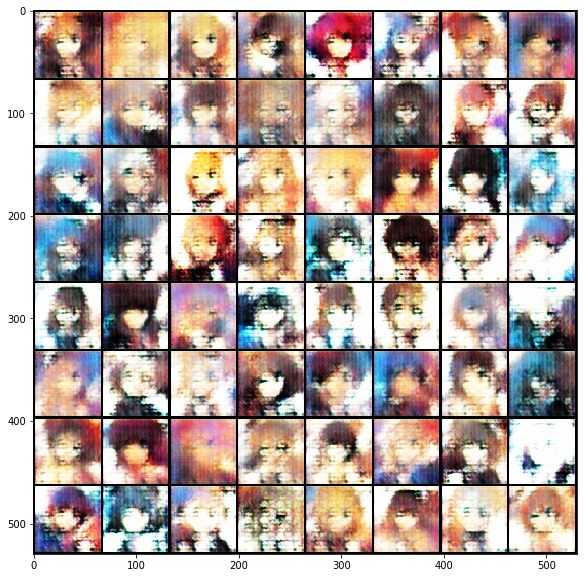

In [24]:
plot_epoch_image("000")

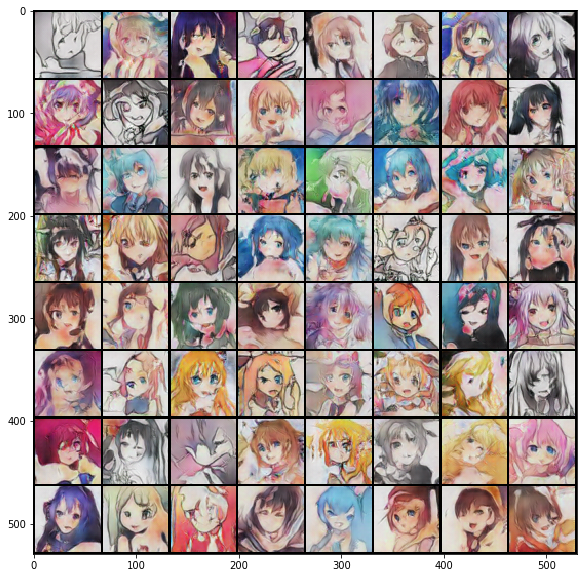

In [25]:
plot_epoch_image("015")

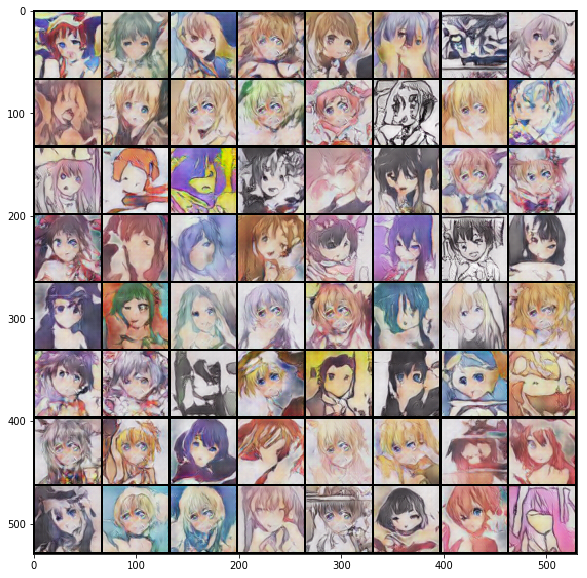

In [26]:
plot_epoch_image("030")

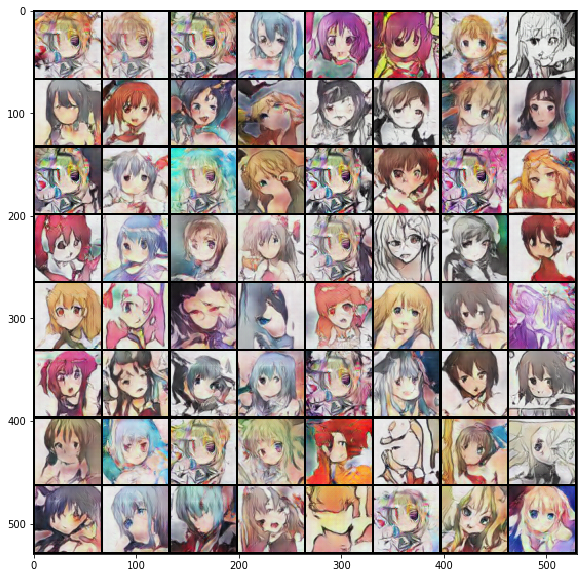

In [27]:
plot_epoch_image("040")

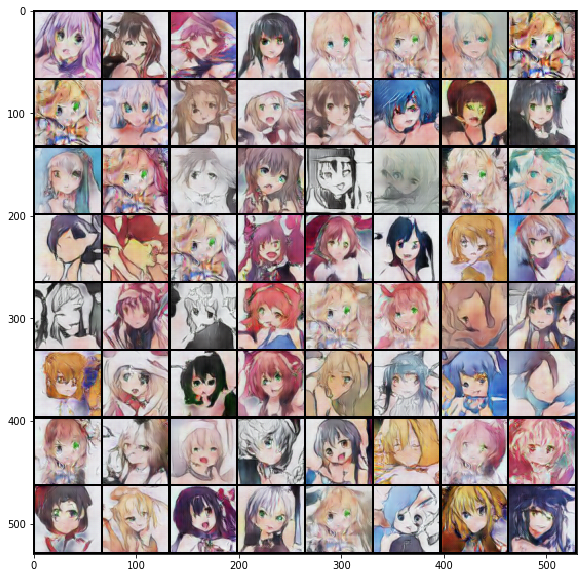

In [28]:
plot_epoch_image("045")